In [1]:
import numpy as np
import pandas as pd

def Peaks(x, y):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Power")

/tmp/ipykernel_3379/1592245428.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


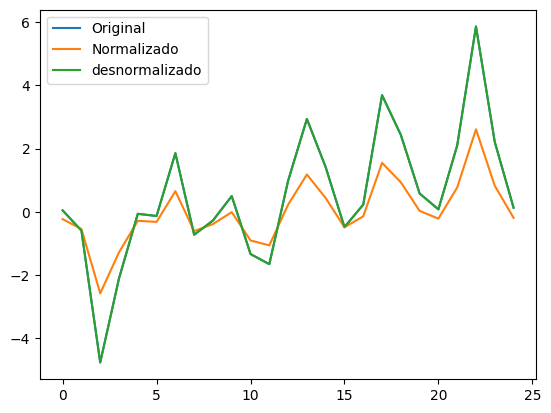

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 8.25 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-15 23:20:17.748390: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-15 23:20:17.748460: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-15 23:20:17.749920: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-15 23:20:17.760219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-15 23:20:21.338404: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_3_8  0.814057  0.541968  0.673124  0.755245  0.440720  3.062865   
model_1_3_7  0.813327  0.541140  0.672626  0.755591  0.442450  3.068398   
model_1_3_6  0.812580  0.540301  0.672111  0.755928  0.444221  3.074011   
model_1_3_5  0.797527  0.522399  0.661340  0.759488  0.479899  3.193719   
model_1_3_4  0.796461  0.521321  0.660506  0.759629  0.482426  3.200931   
model_1_3_3  0.795372  0.520228  0.659652  0.759761  0.485007  3.208236   
model_1_3_2  0.791832  0.515481  0.656936  0.760235  0.493399  3.239981   
model_1_3_1  0.790712  0.514371  0.656038  0.760321  0.496052  3.247406   
model_1_3_0  0.789552  0.513240  0.655105  0.760419  0.498801  3.254964   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_3_8  1.169218  0.862871  1.211391  0.663868  0.746801  0.674323   
model_1_3_7  1.170997  0.861651  1.223898  0.665169  0.745808  0.675645   
model_1_3_6  1.172839  0.860463  1.236481  0.666499  0.744790  0.676996   
model_1_3_5  1.211369  0.847912  1.400765  0.692748  0.724293  0.703658   
model_1_3_4  1.214350  0.847415  1.414486  0.694569  0.722841  0.705507   
model_1_3_3  1.217406  0.846950  1.428352  0.696424  0.721358  0.707392   
model_1_3_2  1.227120  0.845280  1.434392  0.702424  0.716537  0.713486   
model_1_3_1  1.230333  0.844975  1.447274  0.704310  0.715012  0.715402   
model_1_3_0  1.233668  0.844632  1.460988  0.706259  0.713433  0.717381   

                   aic        bic  
model_1_3_8  35.638690  72.603273  
model_1_3_7  35.630856  72.595439  
model_1_3_6  35.622867  72.587451  
model_1_3_5  35.468358  72.432942  
model_1_3_4  35.457857  72.422441  
model_1_3_3  35.447185  72.411769  
model_1_3_2  35.412872  72.377456  
model_1_3_1  35.402147  72.366731  
model_1_3_0  35.391096  72.355679

DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_4_9  0.828181  0.569435  0.701234  0.777249  0.407244  2.879187   
model_1_4_8  0.827982  0.569027  0.700767  0.777594  0.407716  2.881918   
model_1_4_7  0.826496  0.566043  0.697321  0.780249  0.411239  2.901870   
model_1_4_6  0.826291  0.565613  0.696816  0.780725  0.411724  2.904749   
model_1_4_5  0.825554  0.563889  0.694813  0.783078  0.413471  2.916278   
model_1_4_4  0.823806  0.560585  0.690990  0.787076  0.417615  2.938370   
model_1_4_3  0.822002  0.557062  0.687060  0.792564  0.421888  2.961926   
model_1_4_2  0.821659  0.556474  0.686396  0.793247  0.422703  2.965858   
model_1_4_1  0.821450  0.555969  0.685833  0.794316  0.423199  2.969238   
model_1_4_0  0.816086  0.544765  0.675249  0.818874  0.435912  3.044156   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_4_9  1.068667  0.605882  1.250504  0.638157  0.766034  0.648207   
model_1_4_8  1.070339  0.604943  1.254007  0.638526  0.765763  0.648582   
model_1_4_7  1.082667  0.597720  1.275725  0.641279  0.763739  0.651379   
model_1_4_6  1.084471  0.596425  1.277569  0.641657  0.763460  0.651763   
model_1_4_5  1.091637  0.590025  1.280708  0.643017  0.762457  0.653144   
model_1_4_4  1.105312  0.579150  1.297351  0.646231  0.760076  0.656409   
model_1_4_3  1.119367  0.564224  1.300959  0.649529  0.757620  0.659759   
model_1_4_2  1.121742  0.562367  1.302401  0.650156  0.757152  0.660395   
model_1_4_1  1.123757  0.559458  1.299010  0.650537  0.756868  0.660783   
model_1_4_0  1.161615  0.492660  1.211438  0.660237  0.749563  0.670635   

                   aic        bic  
model_1_4_9  35.796683  72.761267  
model_1_4_8  35.794370  72.758953  
model_1_4_7  35.777162  72.741746  
model_1_4_6  35.774803  72.739387  
model_1_4_5  35.766338  72.730921  
model_1_4_4  35.746391  72.710975  
model_1_4_3  35.726029  72.690613  
model_1_4_2  35.722171  72.686755  
model_1_4_1  35.719826  72.684410  
model_1_4_0  35.660628  72.625211

DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_5_9  0.826131  0.581252  0.705372  0.769628  0.412102  2.800168   
model_1_5_8  0.826074  0.580845  0.705190  0.770531  0.412238  2.802894   
model_1_5_7  0.826016  0.580430  0.705003  0.771457  0.412377  2.805664   
model_1_5_6  0.825955  0.580008  0.704811  0.772404  0.412521  2.808491   
model_1_5_5  0.825890  0.579575  0.704613  0.773371  0.412674  2.811382   
model_1_5_4  0.825078  0.573792  0.701881  0.786860  0.414599  2.850055   
model_1_5_3  0.824961  0.573242  0.701595  0.788032  0.414877  2.853735   
model_1_5_2  0.824837  0.572681  0.701301  0.789214  0.415170  2.857487   
model_1_5_1  0.828062  0.570505  0.701666  0.807203  0.407527  2.872032   
model_1_5_0  0.827979  0.569900  0.701362  0.808613  0.407724  2.876078   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_5_9  1.053867  0.927484  1.207092  0.641952  0.763243  0.652062   
model_1_5_8  1.054517  0.923849  1.216131  0.642058  0.763165  0.652169   
model_1_5_7  1.055186  0.920122  1.225229  0.642166  0.763085  0.652279   
model_1_5_6  1.055874  0.916308  1.234228  0.642278  0.763002  0.652393   
model_1_5_5  1.056582  0.912415  1.243091  0.642397  0.762914  0.652514   
model_1_5_4  1.066353  0.858106  1.330924  0.643894  0.761808  0.654034   
model_1_5_3  1.067377  0.853389  1.338774  0.644109  0.761649  0.654254   
model_1_5_2  1.068427  0.848630  1.346561  0.644337  0.761480  0.654485   
model_1_5_1  1.067124  0.776205  1.255027  0.638378  0.765871  0.648432   
model_1_5_0  1.068210  0.770528  1.258784  0.638532  0.765758  0.648589   

                   aic        bic  
model_1_5_9  35.772967  72.737551  
model_1_5_8  35.772309  72.736892  
model_1_5_7  35.771636  72.736220  
model_1_5_6  35.770936  72.735520  
model_1_5_5  35.770196  72.734780  
model_1_5_4  35.760886  72.725470  
model_1_5_3  35.759546  72.724130  
model_1_5_2  35.758132  72.722716  
model_1_5_1  35.795297  72.759880  
model_1_5_0  35.794331  72.758915

DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_6] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_6_9  0.843185  0.600392  0.713691  0.594945  0.371683  2.672177   
model_1_6_8  0.842930  0.600063  0.713566  0.595994  0.372286  2.674379   
model_1_6_7  0.842679  0.599736  0.713440  0.597063  0.372881  2.676569   
model_1_6_6  0.842408  0.599398  0.713306  0.598117  0.373524  2.678828   
model_1_6_5  0.842469  0.599145  0.713332  0.600096  0.373378  2.680517   
model_1_6_4  0.842190  0.598800  0.713195  0.601179  0.374039  2.682824   
model_1_6_3  0.841619  0.598100  0.712915  0.603397  0.375393  2.687508   
model_1_6_2  0.834168  0.589143  0.709343  0.632862  0.393054  2.747405   
model_1_6_1  0.833660  0.588640  0.709095  0.634135  0.394257  2.750769   
model_1_6_0  0.826802  0.581889  0.705710  0.650076  0.410513  2.795910   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_6_9  1.024109  0.574988  1.018570  0.609658  0.786464  0.619259   
model_1_6_8  1.024559  0.573500  1.022879  0.610152  0.786118  0.619762   
model_1_6_7  1.025008  0.571982  1.026741  0.610640  0.785776  0.620257   
model_1_6_6  1.025488  0.570486  1.031339  0.611166  0.785406  0.620792   
model_1_6_5  1.025395  0.567677  1.017330  0.611047  0.785490  0.620670   
model_1_6_4  1.025886  0.566139  1.021917  0.611588  0.785110  0.621219   
model_1_6_3  1.026885  0.562991  1.030741  0.612693  0.784333  0.622342   
model_1_6_2  1.039663  0.521165  1.101077  0.626940  0.774186  0.636814   
model_1_6_1  1.040549  0.519357  1.108608  0.627899  0.773495  0.637788   
model_1_6_0  1.052657  0.496728  1.198123  0.640713  0.764156  0.650803   

                   aic        bic  
model_1_6_9  35.979429  72.944013  
model_1_6_8  35.976186  72.940770  
model_1_6_7  35.972991  72.937575  
model_1_6_6  35.969544  72.934127  
model_1_6_5  35.970328  72.934911  
model_1_6_4  35.966788  72.931372  
model_1_6_3  35.959565  72.924149  
model_1_6_2  35.867618  72.832202  
model_1_6_1  35.861505  72.826089  
model_1_6_0  35.780696  72.745280

DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_7] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_7_0  0.845050  0.602728  0.717571  0.774014  0.367261  2.656561   
model_1_7_9  0.847719  0.600366  0.728804  0.730098  0.360936  2.672351   
model_1_7_1  0.844536  0.599169  0.718727  0.767934  0.368479  2.680362   
model_1_7_8  0.847213  0.599001  0.727186  0.736982  0.362136  2.681482   
model_1_7_2  0.844594  0.598816  0.718934  0.766842  0.368342  2.682718   
model_1_7_7  0.846824  0.598296  0.725554  0.743798  0.363057  2.686193   
model_1_7_3  0.844547  0.598273  0.719064  0.765835  0.368454  2.686350   
model_1_7_4  0.844431  0.597527  0.719132  0.764908  0.368729  2.691341   
model_1_7_5  0.845263  0.597057  0.721333  0.757764  0.366756  2.694484   
model_1_7_6  0.845422  0.595750  0.723016  0.751456  0.366379  2.703219   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_7_0  1.010233  0.447788  1.083214  0.606020  0.789005  0.615565   
model_1_7_9  0.970053  0.534806  1.104777  0.600779  0.792638  0.610241   
model_1_7_1  1.006097  0.459836  1.133353  0.607024  0.788305  0.616584   
model_1_7_8  0.975840  0.521167  1.107893  0.601777  0.791949  0.611254   
model_1_7_2  1.005357  0.462000  1.133568  0.606912  0.788383  0.616470   
model_1_7_7  0.981677  0.507661  1.108469  0.602543  0.791419  0.612032   
model_1_7_3  1.004893  0.463995  1.135810  0.607004  0.788319  0.616564   
model_1_7_4  1.004649  0.465831  1.137625  0.607230  0.788161  0.616794   
model_1_7_5  0.996775  0.479987  1.127126  0.605604  0.789295  0.615141   
model_1_7_6  0.990754  0.492486  1.121892  0.605293  0.789511  0.614825   

                   aic        bic  
model_1_7_0  36.003366  72.967950  
model_1_7_9  36.038109  73.002693  
model_1_7_1  35.996745  72.961329  
model_1_7_8  36.031473  72.996057  
model_1_7_2  35.997488  72.962071  
model_1_7_7  36.026388  72.990972  
model_1_7_3  35.996879  72.961463  
model_1_7_4  35.995388  72.959972  
model_1_7_5  36.006118  72.970701  
model_1_7_6  36.008174  72.972757

DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_8_9  0.842453  0.610284  0.728329  0.794997  0.373416  2.606035   
model_1_8_8  0.842085  0.609248  0.728260  0.796602  0.374289  2.612962   
model_1_8_7  0.842399  0.607964  0.728381  0.800220  0.373544  2.621547   
model_1_8_6  0.843135  0.607406  0.728695  0.804494  0.371800  2.625277   
model_1_8_5  0.843612  0.606877  0.728867  0.807515  0.370671  2.628812   
model_1_8_3  0.847226  0.606660  0.730475  0.822879  0.362103  2.630269   
model_1_8_4  0.846297  0.606498  0.730081  0.817884  0.364307  2.631352   
model_1_8_2  0.847672  0.606360  0.730596  0.826571  0.361048  2.632273   
model_1_8_1  0.847149  0.602117  0.729967  0.830748  0.362286  2.660646   
model_1_8_0  0.847748  0.602116  0.730132  0.835466  0.360867  2.660652   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_8_9  0.971752  0.646485  1.157223  0.611077  0.785469  0.620701   
model_1_8_8  0.971998  0.641425  1.216464  0.611791  0.784967  0.621427   
model_1_8_7  0.971565  0.630014  1.238791  0.611182  0.785395  0.620808   
model_1_8_6  0.970442  0.616535  1.240651  0.609754  0.786397  0.619357   
model_1_8_5  0.969826  0.607009  1.240991  0.608827  0.787046  0.618416   
model_1_8_3  0.964075  0.558558  1.108779  0.601750  0.791968  0.611227   
model_1_8_4  0.965483  0.574311  1.126207  0.603578  0.790702  0.613084   
model_1_8_2  0.963641  0.546917  1.117117  0.600873  0.792574  0.610336   
model_1_8_1  0.965892  0.533743  1.107032  0.601902  0.791863  0.611381   
model_1_8_0  0.965303  0.518864  1.105704  0.600722  0.792678  0.610183   

                   aic        bic  
model_1_8_9  35.970126  72.934710  
model_1_8_8  35.965455  72.930039  
model_1_8_7  35.969440  72.934023  
model_1_8_6  35.978799  72.943383  
model_1_8_5  35.984882  72.949466  
model_1_8_3  36.031655  72.996239  
model_1_8_4  36.019518  72.984102  
model_1_8_2  36.037490  73.002073  
model_1_8_1  36.030645  72.995229  
model_1_8_0  36.038494  73.003077

DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_9] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_9_9  0.846839  0.627745  0.733713  0.662804  0.363022  2.489271   
model_1_9_8  0.847254  0.626288  0.734074  0.676640  0.362038  2.499015   
model_1_9_7  0.847638  0.624576  0.734309  0.691295  0.361127  2.510462   
model_1_9_6  0.847779  0.622497  0.734293  0.706008  0.360792  2.524367   
model_1_9_5  0.847829  0.622196  0.734301  0.708299  0.360674  2.526375   
model_1_9_4  0.849030  0.620528  0.734576  0.727963  0.357828  2.537534   
model_1_9_3  0.848969  0.618606  0.733565  0.747724  0.357973  2.550382   
model_1_9_2  0.848938  0.618208  0.733424  0.750343  0.358046  2.553044   
model_1_9_1  0.843677  0.615059  0.730296  0.739252  0.370515  2.574100   
model_1_9_0  0.842794  0.612065  0.728962  0.752204  0.372608  2.594122   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_9_9  0.952492  0.390301  1.280067  0.602513  0.791440  0.612002   
model_1_9_8  0.951201  0.374286  1.253410  0.601696  0.792005  0.611172   
model_1_9_7  0.950361  0.357323  1.220928  0.600939  0.792528  0.610403   
model_1_9_6  0.950418  0.340293  1.189906  0.600660  0.792721  0.610120   
model_1_9_5  0.950391  0.337641  1.183202  0.600562  0.792789  0.610020   
model_1_9_4  0.949405  0.314881  1.075038  0.598187  0.794424  0.607608   
model_1_9_3  0.953021  0.292007  0.973415  0.598308  0.794341  0.607731   
model_1_9_2  0.953527  0.288975  0.958787  0.598369  0.794299  0.607793   
model_1_9_1  0.964716  0.301813  1.191937  0.608700  0.787135  0.618286   
model_1_9_0  0.969487  0.286821  1.158024  0.610416  0.785933  0.620030   

                   aic        bic  
model_1_9_9  36.026584  72.991168  
model_1_9_8  36.032011  72.996595  
model_1_9_7  36.037049  73.001632  
model_1_9_6  36.038905  73.003488  
model_1_9_5  36.039559  73.004143  
model_1_9_4  36.055408  73.019992  
model_1_9_3  36.054597  73.019181  
model_1_9_2  36.054189  73.018773  
model_1_9_1  35.985721  72.950305  
model_1_9_0  35.974457  72.939040

DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_10] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_10_9  0.848470  0.634087  0.742950  0.778085  0.359155  2.446860   
model_1_10_8  0.848529  0.633981  0.742855  0.779346  0.359015  2.447569   
model_1_10_7  0.849962  0.631364  0.739419  0.827214  0.355620  2.465070   
model_1_10_6  0.849989  0.631243  0.739344  0.828372  0.355555  2.465882   
model_1_10_4  0.849980  0.631149  0.739178  0.830681  0.355577  2.466508   
model_1_10_5  0.849969  0.631110  0.739249  0.829558  0.355601  2.466768   
model_1_10_3  0.849799  0.630992  0.738497  0.838726  0.356005  2.467557   
model_1_10_2  0.849800  0.630960  0.738427  0.839840  0.356002  2.467769   
model_1_10_0  0.847912  0.630229  0.735283  0.868391  0.360477  2.472663   
model_1_10_1  0.849167  0.629694  0.737193  0.852355  0.357504  2.476240   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_10_9  0.919454  0.288259  1.227077  0.599295  0.793662  0.608733   
model_1_10_8  0.919791  0.286622  1.227197  0.599178  0.793742  0.608615   
model_1_10_7  0.932082  0.224442  1.231129  0.596339  0.795692  0.605731   
model_1_10_6  0.932350  0.222939  1.230362  0.596284  0.795730  0.605675   
model_1_10_4  0.932946  0.219939  1.232735  0.596303  0.795717  0.605694   
model_1_10_5  0.932690  0.221398  1.232578  0.596323  0.795703  0.605715   
model_1_10_3  0.935383  0.209489  1.245315  0.596662  0.795471  0.606058   
model_1_10_2  0.935631  0.208041  1.245108  0.596659  0.795473  0.606056   
model_1_10_0  0.946876  0.170955  1.290249  0.600397  0.792902  0.609853   
model_1_10_1  0.940044  0.191786  1.269918  0.597916  0.794610  0.607333   

                    aic        bic  
model_1_10_9  36.048004  73.012588  
model_1_10_8  36.048784  73.013368  
model_1_10_7  36.067785  73.032368  
model_1_10_6  36.068151  73.032734  
model_1_10_4  36.068024  73.032608  
model_1_10_5  36.067890  73.032473  
model_1_10_3  36.065621  73.030204  
model_1_10_2  36.065638  73.030221  
model_1_10_0  36.040654  73.005238  
model_1_10_1  36.057219  73.021803

DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  33
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_11] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_11_5  0.847181  0.634970  0.737670  0.856248  0.362212  2.440955   
model_1_11_4  0.847425  0.634677  0.739450  0.867735  0.361633  2.442915   
model_1_11_3  0.847506  0.634652  0.739718  0.869343  0.361440  2.443081   
model_1_11_2  0.848616  0.634515  0.741904  0.881268  0.358809  2.443997   
model_1_11_1  0.848482  0.634351  0.742257  0.884922  0.359128  2.445095   
model_1_11_0  0.848501  0.634302  0.742368  0.885842  0.359083  2.445423   
model_1_11_9  0.844326  0.633639  0.730779  0.823616  0.368978  2.449859   
model_1_11_8  0.845281  0.633480  0.732741  0.832236  0.366713  2.450921   
model_1_11_7  0.845686  0.633443  0.733575  0.835912  0.365754  2.451166   
model_1_11_6  0.845724  0.633422  0.733684  0.836470  0.365665  2.451306   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_11_5  0.938340  0.416140  1.327495  0.601840  0.791905  0.611318   
model_1_11_4  0.931974  0.382887  1.340665  0.601359  0.792238  0.610830   
model_1_11_3  0.931015  0.378233  1.337641  0.601198  0.792349  0.610667   
model_1_11_2  0.923194  0.343713  1.259698  0.599007  0.793860  0.608440   
model_1_11_1  0.921932  0.333133  1.259729  0.599273  0.793677  0.608710   
model_1_11_0  0.921534  0.330471  1.254636  0.599235  0.793703  0.608672   
model_1_11_9  0.962989  0.510607  1.302073  0.607436  0.788018  0.617002   
model_1_11_8  0.955971  0.485654  1.314812  0.605568  0.789319  0.615106   
model_1_11_7  0.952986  0.475011  1.316614  0.604776  0.789870  0.614301   
model_1_11_6  0.952595  0.473396  1.318230  0.604702  0.789922  0.614226   

                    aic        bic  
model_1_11_5  36.031054  72.995637  
model_1_11_4  36.034250  72.998834  
model_1_11_3  36.035320  72.999904  
model_1_11_2  36.049931  73.014515  
model_1_11_1  36.048155  73.012739  
model_1_11_0  36.048405  73.012989  
model_1_11_9  35.994037  72.958621  
model_1_11_8  36.006351  72.970934  
model_1_11_7  36.011587  72.976170  
model_1_11_6  36.012077  72.976660

DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_12] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_12_0  0.845487  0.628667  0.732701  0.817670  0.366225  2.483103   
model_1_12_2  0.842670  0.608854  0.732732  0.801300  0.372903  2.615596   
model_1_12_1  0.842816  0.608844  0.732855  0.801847  0.372556  2.615663   
model_1_12_6  0.843652  0.608621  0.732874  0.796599  0.370575  2.617152   
model_1_12_5  0.843632  0.608582  0.732907  0.796839  0.370622  2.617417   
model_1_12_7  0.843193  0.608344  0.732472  0.794042  0.371662  2.619004   
model_1_12_8  0.843204  0.608343  0.732185  0.792353  0.371636  2.619010   
model_1_12_9  0.843105  0.608336  0.731662  0.790003  0.371871  2.619058   
model_1_12_4  0.842849  0.608334  0.732714  0.798049  0.372479  2.619071   
model_1_12_3  0.842747  0.608296  0.732735  0.798858  0.372719  2.619329   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_12_0  0.956113  0.741710  1.325226  0.605166  0.789599  0.614696   
model_1_12_2  0.956001  0.808300  1.426679  0.610658  0.785763  0.620275   
model_1_12_1  0.955563  0.806076  1.417912  0.610374  0.785962  0.619986   
model_1_12_6  0.955494  0.827427  1.322449  0.608749  0.787100  0.618336   
model_1_12_5  0.955378  0.826448  1.325467  0.608787  0.787074  0.618375   
model_1_12_7  0.956932  0.837828  1.333344  0.609641  0.786476  0.619242   
model_1_12_8  0.957959  0.844696  1.311622  0.609620  0.786491  0.619221   
model_1_12_9  0.959828  0.854256  1.287179  0.609812  0.786356  0.619416   
model_1_12_4  0.956068  0.821528  1.394212  0.610311  0.786007  0.619922   
model_1_12_3  0.955991  0.818238  1.404415  0.610507  0.785869  0.620122   

                    aic        bic  
model_1_12_0  36.009013  72.973597  
model_1_12_2  35.972873  72.937457  
model_1_12_1  35.974736  72.939319  
model_1_12_6  35.985398  72.949982  
model_1_12_5  35.985146  72.949730  
model_1_12_7  35.979541  72.944124  
model_1_12_8  35.979680  72.944263  
model_1_12_9  35.978416  72.942999  
model_1_12_4  35.975149  72.939733  
model_1_12_3  35.973860  72.938443

DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  66
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_13] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_13_0  0.840723  0.593952  0.727368  0.875610  0.377516  2.715243   
model_1_13_1  0.838499  0.587720  0.725933  0.866410  0.382789  2.756919   
model_1_13_9  0.820827  0.566953  0.715946  0.760554  0.424674  2.895786   
model_1_13_8  0.820901  0.566612  0.716244  0.761251  0.424499  2.898065   
model_1_13_7  0.820929  0.563373  0.718923  0.769611  0.424432  2.919727   
model_1_13_6  0.820990  0.563105  0.718999  0.770430  0.424288  2.921522   
model_1_13_5  0.822077  0.561078  0.719780  0.776260  0.421712  2.935071   
model_1_13_4  0.823335  0.558195  0.719970  0.787495  0.418730  2.954350   
model_1_13_2  0.824378  0.557981  0.720185  0.797269  0.416259  2.955781   
model_1_13_3  0.823401  0.557682  0.719906  0.789372  0.418574  2.957781   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_13_0  0.975190  0.532137  1.319592  0.614423  0.783113  0.624100   
model_1_13_1  0.980321  0.571492  1.342891  0.618699  0.780084  0.628443   
model_1_13_9  1.016045  1.024342  1.276955  0.651670  0.756020  0.661933   
model_1_13_8  1.014979  1.021360  1.285004  0.651536  0.756120  0.661797   
model_1_13_7  1.005394  0.985595  1.476803  0.651484  0.756159  0.661745   
model_1_13_6  1.005125  0.982090  1.483636  0.651374  0.756242  0.661633   
model_1_13_5  1.002329  0.957149  1.444252  0.649394  0.757721  0.659621   
model_1_13_4  1.001652  0.909089  1.404335  0.647094  0.759435  0.657285   
model_1_13_2  1.000884  0.867274  1.380916  0.645181  0.760855  0.655342   
model_1_13_3  1.001881  0.901059  1.403062  0.646973  0.759525  0.657162   

                    aic        bic  
model_1_13_0  35.948284  72.912868  
model_1_13_1  35.920545  72.885129  
model_1_13_9  35.712867  72.677451  
model_1_13_8  35.713690  72.678274  
model_1_13_7  35.714007  72.678591  
model_1_13_6  35.714685  72.679269  
model_1_13_5  35.726863  72.691447  
model_1_13_4  35.741056  72.705640  
model_1_13_2  35.752895  72.717478  
model_1_13_3  35.741805  72.706389

DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_14] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_14_9  0.833730  0.580621  0.728619  0.857473  0.394092  2.804390   
model_1_14_8  0.833342  0.580172  0.728083  0.857389  0.395011  2.807392   
model_1_14_7  0.832937  0.579727  0.727519  0.857339  0.395973  2.810370   
model_1_14_6  0.832528  0.579261  0.726971  0.857232  0.396942  2.813487   
model_1_14_5  0.832108  0.578786  0.726418  0.857113  0.397937  2.816662   
model_1_14_4  0.831676  0.578301  0.725859  0.856982  0.398959  2.819905   
model_1_14_3  0.831230  0.577812  0.725286  0.856853  0.400017  2.823176   
model_1_14_2  0.830774  0.577310  0.724713  0.856702  0.401099  2.826533   
model_1_14_1  0.830304  0.576797  0.724139  0.856536  0.402211  2.829961   
model_1_14_0  0.822509  0.568661  0.716834  0.852777  0.420688  2.884366   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_14_9  0.970712  0.464052  1.156649  0.627767  0.773590  0.637654   
model_1_14_8  0.972630  0.464323  1.157767  0.628499  0.773062  0.638397   
model_1_14_7  0.974650  0.464488  1.156748  0.629264  0.772509  0.639174   
model_1_14_6  0.976608  0.464836  1.158332  0.630033  0.771953  0.639955   
model_1_14_5  0.978589  0.465222  1.160125  0.630822  0.771381  0.640757   
model_1_14_4  0.980586  0.465651  1.162215  0.631632  0.770793  0.641580   
model_1_14_3  0.982637  0.466070  1.163651  0.632469  0.770186  0.642430   
model_1_14_2  0.984686  0.466563  1.165902  0.633324  0.769564  0.643298   
model_1_14_1  0.986739  0.467101  1.168541  0.634201  0.768925  0.644189   
model_1_14_0  1.012868  0.479341  1.248657  0.648605  0.758310  0.658820   

                    aic        bic  
model_1_14_9  35.862344  72.826927  
model_1_14_8  35.857683  72.822266  
model_1_14_7  35.852821  72.817404  
model_1_14_6  35.847932  72.812515  
model_1_14_5  35.842924  72.807508  
model_1_14_4  35.837791  72.802375  
model_1_14_3  35.832497  72.797081  
model_1_14_2  35.827093  72.791677  
model_1_14_1  35.821556  72.786139  
model_1_14_0  35.731725  72.696309

DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_15] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_15_9  0.842223  0.616854  0.728226  0.768590  0.373962  2.562100   
model_1_15_8  0.842301  0.616402  0.728433  0.771124  0.373778  2.565124   
model_1_15_7  0.843132  0.607680  0.731253  0.814690  0.371807  2.623447   
model_1_15_6  0.842987  0.605945  0.731619  0.822027  0.372151  2.635048   
model_1_15_5  0.842330  0.601341  0.731920  0.839670  0.373708  2.665834   
model_1_15_4  0.840643  0.595116  0.731997  0.859916  0.377707  2.707464   
model_1_15_3  0.840132  0.593643  0.731887  0.864156  0.378918  2.717312   
model_1_15_2  0.839855  0.592885  0.731821  0.866275  0.379574  2.722378   
model_1_15_1  0.839491  0.592508  0.731162  0.866413  0.380437  2.724903   
model_1_15_0  0.839189  0.591731  0.731077  0.868485  0.381153  2.730100   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_15_9  0.972121  0.445583  1.235567  0.611525  0.785154  0.621156   
model_1_15_8  0.971381  0.440704  1.238429  0.611374  0.785260  0.621002   
model_1_15_7  0.961292  0.356817  1.206616  0.609760  0.786393  0.619363   
model_1_15_6  0.959984  0.342690  1.212396  0.610041  0.786195  0.619649   
model_1_15_5  0.958905  0.308719  1.169406  0.611317  0.785301  0.620944   
model_1_15_4  0.958632  0.269734  1.181705  0.614579  0.783003  0.624258   
model_1_15_3  0.959026  0.261569  1.183017  0.615563  0.782307  0.625258   
model_1_15_2  0.959260  0.257490  1.186222  0.616096  0.781931  0.625799   
model_1_15_1  0.961618  0.257224  1.120188  0.616795  0.781435  0.626509   
model_1_15_0  0.961922  0.253235  1.123402  0.617376  0.781023  0.627099   

                    aic        bic  
model_1_15_9  35.967200  72.931783  
model_1_15_8  35.968187  72.932771  
model_1_15_7  35.978759  72.943343  
model_1_15_6  35.976913  72.941497  
model_1_15_5  35.968562  72.933145  
model_1_15_4  35.947272  72.911856  
model_1_15_3  35.940869  72.905452  
model_1_15_2  35.937411  72.901995  
model_1_15_1  35.932871  72.897455  
model_1_15_0  35.929108  72.893692

DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_16] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_16_9  0.842849  0.641062  0.750322  0.545584  0.372478  2.400220   
model_1_16_7  0.842883  0.640974  0.749962  0.549202  0.372397  2.400810   
model_1_16_8  0.842865  0.640967  0.750134  0.547486  0.372441  2.400857   
model_1_16_6  0.842904  0.640920  0.749786  0.551130  0.372348  2.401170   
model_1_16_5  0.843106  0.640315  0.749072  0.560622  0.371869  2.405212   
model_1_16_4  0.843529  0.637939  0.747399  0.583311  0.370866  2.421100   
model_1_16_3  0.843143  0.630758  0.742592  0.627975  0.371781  2.469120   
model_1_16_2  0.843060  0.630185  0.742171  0.630922  0.371979  2.472957   
model_1_16_1  0.844372  0.627728  0.739096  0.656695  0.368868  2.489386   
model_1_16_0  0.844251  0.627085  0.738564  0.659624  0.369155  2.493686   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_16_9  0.893083  0.556387  1.365325  0.610310  0.786007  0.619922   
model_1_16_7  0.894372  0.551957  1.370718  0.610244  0.786054  0.619854   
model_1_16_8  0.893757  0.554059  1.368184  0.610279  0.786029  0.619891   
model_1_16_6  0.895002  0.549596  1.373326  0.610204  0.786082  0.619814   
model_1_16_5  0.897554  0.537974  1.377806  0.609811  0.786357  0.619415   
model_1_16_4  0.903540  0.510194  1.383961  0.608988  0.786933  0.618579   
model_1_16_3  0.920733  0.455507  1.421405  0.609738  0.786408  0.619341   
model_1_16_2  0.922240  0.451899  1.424244  0.609901  0.786294  0.619506   
model_1_16_1  0.933238  0.420343  1.302052  0.607345  0.788081  0.616910   
model_1_16_0  0.935143  0.416757  1.304111  0.607582  0.787916  0.617150   

                    aic        bic  
model_1_16_9  35.975154  72.939738  
model_1_16_7  35.975588  72.940172  
model_1_16_8  35.975355  72.939938  
model_1_16_6  35.975850  72.940434  
model_1_16_5  35.978427  72.943011  
model_1_16_4  35.983828  72.948412  
model_1_16_3  35.978903  72.943487  
model_1_16_2  35.977837  72.942421  
model_1_16_1  35.994634  72.959218  
model_1_16_0  35.993075  72.957659

DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_17] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_17_5  0.848357  0.635517  0.766169  0.636148  0.359423  2.437299   
model_1_17_6  0.848234  0.635505  0.766278  0.630445  0.359715  2.437382   
model_1_17_7  0.848199  0.635486  0.766296  0.629356  0.359797  2.437510   
model_1_17_8  0.847943  0.635416  0.766328  0.620380  0.360405  2.437972   
model_1_17_0  0.846107  0.635356  0.755571  0.756475  0.364755  2.438377   
model_1_17_4  0.848912  0.635250  0.765064  0.666135  0.358107  2.439082   
model_1_17_1  0.846245  0.635180  0.755941  0.753980  0.364429  2.439556   
model_1_17_9  0.847898  0.635143  0.766375  0.610180  0.360511  2.439800   
model_1_17_3  0.848792  0.634878  0.762883  0.696511  0.358392  2.441575   
model_1_17_2  0.848701  0.634828  0.762526  0.700309  0.358607  2.441907   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_17_5  0.836401  0.363860  1.333882  0.599519  0.793508  0.608961   
model_1_17_6  0.836008  0.369563  1.331291  0.599762  0.793340  0.609208   
model_1_17_7  0.835946  0.370652  1.331844  0.599831  0.793293  0.609277   
model_1_17_8  0.835830  0.379629  1.332592  0.600337  0.792944  0.609792   
model_1_17_0  0.874310  0.243530  1.369047  0.603950  0.790444  0.613461   
model_1_17_4  0.840351  0.333873  1.328997  0.598420  0.794264  0.607845   
model_1_17_1  0.872984  0.246025  1.372137  0.603679  0.790632  0.613187   
model_1_17_9  0.835663  0.389828  1.273060  0.600426  0.792882  0.609882   
model_1_17_3  0.848155  0.303496  1.345325  0.598658  0.794100  0.608087   
model_1_17_2  0.849432  0.299698  1.349761  0.598838  0.793976  0.608269   

                    aic        bic  
model_1_17_5  36.046511  73.011095  
model_1_17_6  36.044886  73.009470  
model_1_17_7  36.044431  73.009015  
model_1_17_8  36.041056  73.005640  
model_1_17_0  36.017058  72.981641  
model_1_17_4  36.053850  73.018433  
model_1_17_1  36.018848  72.983431  
model_1_17_9  36.040466  73.005049  
model_1_17_3  36.052257  73.016841  
model_1_17_2  36.051057  73.015641

DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_18] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_18_0  0.847599  0.633728  0.763912  0.772967  0.361220  2.449265   
model_1_18_1  0.847857  0.631243  0.754191  0.759397  0.360609  2.465882   
model_1_18_2  0.847899  0.630851  0.752806  0.757147  0.360509  2.468500   
model_1_18_3  0.847909  0.630278  0.750725  0.754024  0.360485  2.472335   
model_1_18_4  0.847851  0.628584  0.744610  0.744815  0.360623  2.483658   
model_1_18_5  0.847489  0.624718  0.735774  0.728313  0.361481  2.509511   
model_1_18_6  0.847412  0.624296  0.735016  0.727008  0.361663  2.512336   
model_1_18_7  0.846819  0.621213  0.730679  0.719436  0.363068  2.532953   
model_1_18_8  0.846637  0.620276  0.729651  0.717545  0.363500  2.539219   
model_1_18_9  0.846450  0.619379  0.728649  0.715651  0.363944  2.545217   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_18_0  0.844472  0.546396  1.288238  0.601016  0.792475  0.610481   
model_1_18_1  0.879243  0.579056  1.243075  0.600507  0.792826  0.609965   
model_1_18_2  0.884200  0.584471  1.226892  0.600424  0.792884  0.609880   
model_1_18_3  0.891642  0.591987  1.211328  0.600404  0.792897  0.609860   
model_1_18_4  0.913515  0.614149  1.168767  0.600519  0.792818  0.609976   
model_1_18_5  0.945122  0.653866  1.068682  0.601233  0.792325  0.610701   
model_1_18_6  0.947832  0.657005  1.065897  0.601384  0.792220  0.610856   
model_1_18_7  0.963344  0.675229  1.048959  0.602551  0.791414  0.612040   
model_1_18_8  0.967024  0.679780  1.041935  0.602909  0.791165  0.612405   
model_1_18_9  0.970605  0.684338  1.034408  0.603278  0.790910  0.612779   

                    aic        bic  
model_1_18_0  36.036535  73.001119  
model_1_18_1  36.039922  73.004506  
model_1_18_2  36.040478  73.005062  
model_1_18_3  36.040610  73.005193  
model_1_18_4  36.039845  73.004428  
model_1_18_5  36.035094  72.999677  
model_1_18_6  36.034084  72.998668  
model_1_18_7  36.026333  72.990916  
model_1_18_8  36.023953  72.988537  
model_1_18_9  36.021511  72.986094

DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_19] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_19_9  0.845600  0.624686  0.719058  0.790960  0.365958  2.509729   
model_1_19_8  0.846054  0.623944  0.721078  0.798776  0.364883  2.514686   
model_1_19_7  0.846123  0.623868  0.721288  0.799605  0.364717  2.515197   
model_1_19_6  0.846140  0.623787  0.721457  0.800272  0.364678  2.515739   
model_1_19_5  0.846153  0.623704  0.721624  0.800936  0.364646  2.516293   
model_1_19_4  0.846232  0.623623  0.721848  0.801808  0.364460  2.516834   
model_1_19_3  0.846384  0.623547  0.722143  0.802934  0.364099  2.517344   
model_1_19_2  0.846876  0.622998  0.723602  0.808684  0.362934  2.521011   
model_1_19_1  0.846943  0.621775  0.725619  0.816800  0.362774  2.529193   
model_1_19_0  0.846796  0.620552  0.727259  0.823548  0.363123  2.537368   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_19_9  1.004913  0.451249  1.146992  0.604944  0.789753  0.614472   
model_1_19_8  0.997689  0.434377  1.137710  0.604055  0.790371  0.613568   
model_1_19_7  0.996936  0.432587  1.133803  0.603918  0.790466  0.613429   
model_1_19_6  0.996334  0.431146  1.134362  0.603886  0.790488  0.613396   
model_1_19_5  0.995736  0.429714  1.135068  0.603859  0.790507  0.613369   
model_1_19_4  0.994932  0.427831  1.129911  0.603705  0.790614  0.613213   
model_1_19_3  0.993880  0.425402  1.117688  0.603406  0.790821  0.612909   
model_1_19_2  0.988660  0.412989  1.068254  0.602440  0.791490  0.611928   
model_1_19_1  0.981445  0.395468  1.052348  0.602307  0.791582  0.611793   
model_1_19_0  0.975580  0.380902  1.034964  0.602597  0.791382  0.612087   

                    aic        bic  
model_1_19_9  36.010476  72.975059  
model_1_19_8  36.016359  72.980943  
model_1_19_7  36.017265  72.981849  
model_1_19_6  36.017480  72.982064  
model_1_19_5  36.017657  72.982240  
model_1_19_4  36.018678  72.983261  
model_1_19_3  36.020658  72.985241  
model_1_19_2  36.027069  72.991653  
model_1_19_1  36.027951  72.992535  
model_1_19_0  36.026027  72.990610

DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_20_0  0.845593  0.624082  0.719288  0.879577  0.365974  2.513768   
model_1_20_1  0.845571  0.622920  0.719510  0.875663  0.366025  2.521535   
model_1_20_2  0.845593  0.622474  0.719588  0.874375  0.365975  2.524516   
model_1_20_3  0.845598  0.621966  0.719628  0.873015  0.365962  2.527914   
model_1_20_4  0.845595  0.621447  0.719663  0.871642  0.365970  2.531388   
model_1_20_5  0.845297  0.620156  0.719399  0.868225  0.366677  2.540022   
model_1_20_6  0.845237  0.619451  0.719324  0.866641  0.366818  2.544732   
model_1_20_7  0.844674  0.618398  0.718702  0.863974  0.368153  2.551771   
model_1_20_8  0.844561  0.617467  0.718497  0.862147  0.368420  2.558000   
model_1_20_9  0.844419  0.616470  0.718250  0.860242  0.368758  2.564665   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_20_0  1.004092  0.373489  1.150949  0.604958  0.789744  0.614485   
model_1_20_1  1.003297  0.385627  1.153574  0.605000  0.789714  0.614529   
model_1_20_2  1.003016  0.389622  1.150771  0.604958  0.789743  0.614486   
model_1_20_3  1.002874  0.393839  1.148186  0.604948  0.789751  0.614475   
model_1_20_4  1.002748  0.398100  1.145293  0.604955  0.789746  0.614482   
model_1_20_5  1.003695  0.408696  1.157875  0.605539  0.789340  0.615075   
model_1_20_6  1.003961  0.413609  1.155460  0.605655  0.789259  0.615193   
model_1_20_7  1.006188  0.421880  1.185318  0.606756  0.788492  0.616312   
model_1_20_8  1.006921  0.427548  1.182696  0.606976  0.788339  0.616535   
model_1_20_9  1.007805  0.433454  1.180146  0.607254  0.788145  0.616818   

                    aic        bic  
model_1_20_0  36.010385  72.974969  
model_1_20_1  36.010105  72.974688  
model_1_20_2  36.010382  72.974966  
model_1_20_3  36.010451  72.975034  
model_1_20_4  36.010407  72.974991  
model_1_20_5  36.006548  72.971132  
model_1_20_6  36.005781  72.970364  
model_1_20_7  35.998516  72.963099  
model_1_20_8  35.997063  72.961647  
model_1_20_9  35.995231  72.959815

DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_21_6  0.846593  0.618135  0.720977  0.701720  0.363604  2.553533   
model_1_21_8  0.846923  0.617611  0.721174  0.700713  0.362822  2.557036   
model_1_21_9  0.846958  0.617589  0.721203  0.700631  0.362738  2.557186   
model_1_21_7  0.846867  0.617556  0.721018  0.701204  0.362954  2.557407   
model_1_21_0  0.844479  0.616363  0.718231  0.702616  0.368615  2.565380   
model_1_21_2  0.844580  0.616289  0.718258  0.702320  0.368374  2.565875   
model_1_21_1  0.844472  0.616229  0.718151  0.702293  0.368632  2.566277   
model_1_21_4  0.845126  0.615894  0.718509  0.701772  0.367081  2.568517   
model_1_21_3  0.844603  0.615847  0.718055  0.702172  0.368321  2.568834   
model_1_21_5  0.845451  0.615176  0.718504  0.701076  0.366312  2.573320   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_21_6  0.998049  0.331825  1.156243  0.602996  0.791105  0.612493   
model_1_21_8  0.997345  0.332946  1.151444  0.602347  0.791555  0.611833   
model_1_21_9  0.997240  0.333036  1.150850  0.602278  0.791603  0.611763   
model_1_21_7  0.997902  0.332399  1.147891  0.602457  0.791479  0.611945   
model_1_21_0  1.007872  0.330828  1.180528  0.607137  0.788227  0.616698   
model_1_21_2  1.007773  0.331157  1.183453  0.606938  0.788365  0.616497   
model_1_21_1  1.008158  0.331187  1.185116  0.607151  0.788217  0.616713   
model_1_21_4  1.006876  0.331767  1.178519  0.605872  0.789108  0.615414   
model_1_21_3  1.008503  0.331322  1.182468  0.606894  0.788396  0.616452   
model_1_21_5  1.006894  0.332541  1.173644  0.605237  0.789550  0.614769   

                    aic        bic  
model_1_21_6  36.023377  72.987961  
model_1_21_8  36.027688  72.992271  
model_1_21_9  36.028146  72.992730  
model_1_21_7  36.026959  72.991542  
model_1_21_0  35.996006  72.960590  
model_1_21_2  35.997311  72.961895  
model_1_21_1  35.995911  72.960495  
model_1_21_4  36.004345  72.968929  
model_1_21_3  35.997603  72.962187  
model_1_21_5  36.008542  72.973126

DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_22] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_22_0  0.846197  0.616743  0.721407  0.842138  0.364543  2.562842   
model_1_22_1  0.845655  0.614034  0.721143  0.835020  0.365827  2.580954   
model_1_22_2  0.845632  0.613940  0.721216  0.834270  0.365881  2.581586   
model_1_22_6  0.845634  0.613779  0.722342  0.827812  0.365878  2.582659   
model_1_22_5  0.845589  0.613575  0.722136  0.828350  0.365983  2.584025   
model_1_22_4  0.845554  0.613403  0.721949  0.828916  0.366066  2.585176   
model_1_22_3  0.845546  0.613328  0.721808  0.829538  0.366087  2.585676   
model_1_22_7  0.845149  0.612607  0.722160  0.822874  0.367027  2.590500   
model_1_22_8  0.843667  0.611382  0.721735  0.814563  0.370539  2.598690   
model_1_22_9  0.842726  0.610353  0.721353  0.807614  0.372770  2.605572   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_22_0  0.996511  0.536170  1.193721  0.603774  0.790566  0.613282   
model_1_22_1  0.997457  0.560346  1.161693  0.604837  0.789828  0.614362   
model_1_22_2  0.997193  0.562892  1.157685  0.604881  0.789797  0.614407   
model_1_22_6  0.993165  0.584829  1.103200  0.604879  0.789799  0.614405   
model_1_22_5  0.993902  0.583001  1.108624  0.604965  0.789739  0.614493   
model_1_22_4  0.994573  0.581078  1.113734  0.605034  0.789691  0.614562   
model_1_22_3  0.995077  0.578967  1.118363  0.605051  0.789679  0.614580   
model_1_22_7  0.993819  0.601599  1.077972  0.605827  0.789139  0.615368   
model_1_22_8  0.995339  0.629827  1.106938  0.608719  0.787121  0.618306   
model_1_22_9  0.996703  0.653429  1.095557  0.610549  0.785840  0.620164   

                    aic        bic  
model_1_22_0  36.018224  72.982807  
model_1_22_1  36.011188  72.975772  
model_1_22_2  36.010894  72.975478  
model_1_22_6  36.010910  72.975493  
model_1_22_5  36.010339  72.974922  
model_1_22_4  36.009885  72.974469  
model_1_22_3  36.009769  72.974353  
model_1_22_7  36.004641  72.969225  
model_1_22_8  35.985593  72.950177  
model_1_22_9  35.973589  72.938173

DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_23] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_23_0  0.843161  0.610643  0.721794  0.780102  0.371738  2.603633   
model_1_23_1  0.843260  0.610582  0.721632  0.778924  0.371504  2.604038   
model_1_23_2  0.842460  0.610145  0.719387  0.771349  0.373400  2.606964   
model_1_23_3  0.842248  0.609962  0.718985  0.770198  0.373904  2.608185   
model_1_23_4  0.840634  0.609244  0.716319  0.762471  0.377727  2.612990   
model_1_23_5  0.840769  0.608796  0.715187  0.754607  0.377408  2.615985   
model_1_23_6  0.840168  0.608322  0.713601  0.746958  0.378833  2.619154   
model_1_23_7  0.838345  0.605775  0.710303  0.733571  0.383154  2.636182   
model_1_23_8  0.838425  0.599165  0.709013  0.723143  0.382963  2.680386   
model_1_23_9  0.838124  0.598835  0.708568  0.721831  0.383676  2.682592   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_23_0  0.995126  0.771865  1.041077  0.609703  0.786432  0.619306   
model_1_23_1  0.995706  0.776000  1.033070  0.609511  0.786567  0.619110   
model_1_23_2  1.003735  0.802590  1.059927  0.611065  0.785477  0.620688   
model_1_23_3  1.005175  0.806629  1.064731  0.611477  0.785188  0.621107   
model_1_23_4  1.014710  0.833753  1.096878  0.614595  0.782991  0.624275   
model_1_23_5  1.018760  0.861356  1.042931  0.614336  0.783175  0.624011   
model_1_23_6  1.024434  0.888204  1.017849  0.615494  0.782356  0.625187   
model_1_23_7  1.036229  0.935194  1.001539  0.618994  0.779874  0.628743   
model_1_23_8  1.040845  0.971799  0.841766  0.618840  0.779983  0.628587   
model_1_23_9  1.042436  0.976405  0.845460  0.619416  0.779574  0.629171   

                    aic        bic  
model_1_23_0  35.979131  72.943715  
model_1_23_1  35.980392  72.944976  
model_1_23_2  35.970209  72.934793  
model_1_23_3  35.967514  72.932097  
model_1_23_4  35.947165  72.911748  
model_1_23_5  35.948856  72.913439  
model_1_23_6  35.941321  72.905905  
model_1_23_7  35.918637  72.883221  
model_1_23_8  35.919631  72.884215  
model_1_23_9  35.915913  72.880496

DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_24] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_24_0  0.837966  0.598258  0.708508  0.809745  0.384052  2.686448   
model_1_24_1  0.837136  0.596972  0.708301  0.801022  0.386019  2.695050   
model_1_24_2  0.835858  0.595111  0.707939  0.791114  0.389048  2.707496   
model_1_24_3  0.830428  0.589059  0.704698  0.762140  0.401917  2.747961   
model_1_24_4  0.828815  0.588564  0.703448  0.750507  0.405742  2.751277   
model_1_24_5  0.828615  0.588507  0.703283  0.749101  0.406215  2.751655   
model_1_24_6  0.827563  0.588130  0.702432  0.742051  0.408708  2.754173   
model_1_24_7  0.827368  0.588095  0.702279  0.740710  0.409171  2.754410   
model_1_24_8  0.827177  0.588074  0.702135  0.739384  0.409624  2.754554   
model_1_24_9  0.826980  0.588035  0.701981  0.738056  0.410091  2.754810   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_24_0  1.042650  0.568183  0.834506  0.619719  0.779358  0.629479   
model_1_24_1  1.043392  0.594233  0.819623  0.621304  0.778228  0.631089   
model_1_24_2  1.044686  0.623823  0.807901  0.623737  0.776488  0.633560   
model_1_24_3  1.056277  0.710351  0.813981  0.633970  0.769094  0.643954   
model_1_24_4  1.060751  0.745091  0.818789  0.636979  0.766897  0.647010   
model_1_24_5  1.061340  0.749291  0.819675  0.637350  0.766625  0.647388   
model_1_24_6  1.064383  0.770347  0.826039  0.639303  0.765192  0.649371   
model_1_24_7  1.064931  0.774352  0.827229  0.639665  0.764927  0.649739   
model_1_24_8  1.065446  0.778310  0.828373  0.640019  0.764666  0.650099   
model_1_24_9  1.065996  0.782276  0.829503  0.640384  0.764398  0.650469   

                    aic        bic  
model_1_24_0  35.913955  72.878538  
model_1_24_1  35.903738  72.868321  
model_1_24_2  35.888106  72.852689  
model_1_24_3  35.823018  72.787601  
model_1_24_4  35.804076  72.768660  
model_1_24_5  35.801743  72.766327  
model_1_24_6  35.789506  72.754090  
model_1_24_7  35.787244  72.751828  
model_1_24_8  35.785030  72.749613  
model_1_24_9  35.782751  72.747335

DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  47
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_25] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_25_9  0.841535  0.623664  0.721853  0.766187  0.375592  2.516560   
model_1_25_8  0.841729  0.623337  0.721961  0.768910  0.375134  2.518747   
model_1_25_7  0.842590  0.621490  0.722301  0.782325  0.373091  2.531101   
model_1_25_6  0.843287  0.619331  0.722523  0.798968  0.371439  2.545535   
model_1_25_5  0.843917  0.617150  0.722402  0.807294  0.369948  2.560118   
model_1_25_4  0.843962  0.615216  0.722016  0.815980  0.369841  2.573055   
model_1_25_3  0.836197  0.596899  0.712118  0.865969  0.388246  2.695536   
model_1_25_2  0.835275  0.595674  0.710450  0.869100  0.390429  2.703728   
model_1_25_1  0.830416  0.590352  0.705024  0.878318  0.401946  2.739320   
model_1_25_0  0.827729  0.588759  0.702664  0.883023  0.408315  2.749972   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_25_9  0.994917  0.577483  1.277022  0.612856  0.784218  0.622508   
model_1_25_8  0.994531  0.570757  1.273178  0.612482  0.784482  0.622127   
model_1_25_7  0.993314  0.537624  1.247936  0.610812  0.785655  0.620431   
model_1_25_6  0.992520  0.496517  1.222025  0.609458  0.786604  0.619057   
model_1_25_5  0.992951  0.475954  1.142700  0.608233  0.787461  0.617812   
model_1_25_4  0.994334  0.454501  1.107333  0.608146  0.787522  0.617723   
model_1_25_3  1.029736  0.331035  0.934989  0.623094  0.776949  0.632907   
model_1_25_2  1.035705  0.323302  0.876983  0.624844  0.775694  0.634684   
model_1_25_1  1.055112  0.300535  0.833291  0.633992  0.769077  0.643977   
model_1_25_0  1.063554  0.288914  0.827701  0.638995  0.765418  0.649059   

                    aic        bic  
model_1_25_9  35.958503  72.923086  
model_1_25_8  35.960946  72.925530  
model_1_25_7  35.971866  72.936450  
model_1_25_6  35.980739  72.945323  
model_1_25_5  35.988788  72.953372  
model_1_25_4  35.989364  72.953948  
model_1_25_3  35.892235  72.856818  
model_1_25_2  35.881016  72.845600  
model_1_25_1  35.822874  72.787457  
model_1_25_0  35.791432  72.756016

DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_26] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_26_0  0.841607  0.621107  0.721627  0.805347  0.375422  2.533662   
model_1_26_1  0.841260  0.618478  0.720993  0.801347  0.376244  2.551237   
model_1_26_2  0.841199  0.617984  0.720836  0.800534  0.376389  2.554542   
model_1_26_3  0.841159  0.617072  0.721054  0.796447  0.376485  2.560642   
model_1_26_5  0.841015  0.615964  0.721420  0.791201  0.376826  2.568048   
model_1_26_4  0.841029  0.615940  0.721297  0.791720  0.376793  2.568210   
model_1_26_6  0.840324  0.613724  0.721554  0.782561  0.378462  2.583028   
model_1_26_7  0.840322  0.613720  0.721631  0.782035  0.378468  2.583056   
model_1_26_8  0.839526  0.611871  0.721353  0.776208  0.380355  2.595422   
model_1_26_9  0.839281  0.610943  0.720916  0.775249  0.380935  2.601629   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_26_0  0.995725  0.643941  1.248212  0.612717  0.784316  0.622366   
model_1_26_1  0.997993  0.657173  1.247807  0.613387  0.783844  0.623047   
model_1_26_2  0.998554  0.659863  1.245758  0.613506  0.783760  0.623168   
model_1_26_3  0.997774  0.673384  1.225429  0.613583  0.783705  0.623247   
model_1_26_5  0.996465  0.690737  1.199679  0.613861  0.783509  0.623529   
model_1_26_4  0.996904  0.689022  1.199572  0.613834  0.783528  0.623502   
model_1_26_6  0.995987  0.719321  1.170155  0.615192  0.782570  0.624881   
model_1_26_7  0.995710  0.721062  1.165784  0.615197  0.782566  0.624886   
model_1_26_8  0.996703  0.740339  1.157367  0.616729  0.781482  0.626442   
model_1_26_9  0.998268  0.743511  1.154427  0.617200  0.781148  0.626920   

                    aic        bic  
model_1_26_0  35.959412  72.923995  
model_1_26_1  35.955037  72.919620  
model_1_26_2  35.954264  72.918847  
model_1_26_3  35.953756  72.918339  
model_1_26_5  35.951945  72.916528  
model_1_26_4  35.952120  72.916703  
model_1_26_6  35.943281  72.907864  
model_1_26_7  35.943248  72.907831  
model_1_26_8  35.933301  72.897884  
model_1_26_9  35.930251  72.894835

DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  144
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_27_9  0.835799  0.612827  0.718574  0.808462  0.389187  2.589026   
model_1_27_8  0.835870  0.612742  0.718693  0.809022  0.389019  2.589596   
model_1_27_7  0.835941  0.612656  0.718811  0.809584  0.388852  2.590174   
model_1_27_6  0.836011  0.612568  0.718928  0.810149  0.388687  2.590761   
model_1_27_5  0.836080  0.612479  0.719044  0.810715  0.388523  2.591355   
model_1_27_4  0.836148  0.612389  0.719158  0.811284  0.388361  2.591959   
model_1_27_3  0.836216  0.612297  0.719271  0.811855  0.388200  2.592570   
model_1_27_2  0.836283  0.612204  0.719382  0.812429  0.388041  2.593191   
model_1_27_1  0.836350  0.612111  0.719493  0.813005  0.387883  2.593819   
model_1_27_0  0.836415  0.612015  0.719601  0.813583  0.387727  2.594456   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_27_9  1.006644  0.659920  1.060231  0.623849  0.776408  0.633674   
model_1_27_8  1.006218  0.657991  1.063107  0.623714  0.776504  0.633537   
model_1_27_7  1.005796  0.656055  1.065991  0.623580  0.776600  0.633401   
model_1_27_6  1.005378  0.654109  1.068889  0.623447  0.776695  0.633266   
model_1_27_5  1.004965  0.652158  1.071788  0.623316  0.776789  0.633133   
model_1_27_4  1.004557  0.650197  1.074698  0.623186  0.776882  0.633000   
model_1_27_3  1.004152  0.648230  1.077621  0.623057  0.776975  0.632870   
model_1_27_2  1.003753  0.646253  1.080569  0.622929  0.777066  0.632740   
model_1_27_1  1.003359  0.644270  1.083516  0.622803  0.777157  0.632611   
model_1_27_0  1.002969  0.642278  1.086471  0.622677  0.777247  0.632484   

                    aic        bic  
model_1_27_9  35.887390  72.851973  
model_1_27_8  35.888255  72.852838  
model_1_27_7  35.889112  72.853696  
model_1_27_6  35.889964  72.854547  
model_1_27_5  35.890806  72.855389  
model_1_27_4  35.891642  72.856225  
model_1_27_3  35.892469  72.857053  
model_1_27_2  35.893290  72.857874  
model_1_27_1  35.894103  72.858686  
model_1_27_0  35.894908  72.859492

DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_28_7  0.836824  0.613697  0.713549  0.594449  0.386758  2.583207   
model_1_28_6  0.836720  0.613692  0.714108  0.596516  0.387006  2.583242   
model_1_28_8  0.836927  0.613675  0.713013  0.592557  0.386515  2.583354   
model_1_28_5  0.836607  0.613640  0.714686  0.598772  0.387273  2.583593   
model_1_28_9  0.837023  0.613593  0.712502  0.590928  0.386288  2.583905   
model_1_28_4  0.836489  0.613560  0.715285  0.601174  0.387552  2.584123   
model_1_28_3  0.836368  0.613463  0.715907  0.603703  0.387840  2.584778   
model_1_28_2  0.836237  0.613332  0.716546  0.606357  0.388151  2.585649   
model_1_28_1  0.836099  0.613182  0.717204  0.609114  0.388477  2.586651   
model_1_28_0  0.835953  0.613014  0.717880  0.611964  0.388823  2.587779   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_28_7  1.024620  0.552494  1.017172  0.621899  0.777803  0.631693   
model_1_28_6  1.022619  0.549677  1.021700  0.622098  0.777661  0.631895   
model_1_28_8  1.026535  0.555070  1.012833  0.621704  0.777943  0.631495   
model_1_28_5  1.020552  0.546604  1.026509  0.622313  0.777507  0.632113   
model_1_28_9  1.028364  0.557289  1.008869  0.621520  0.778073  0.631309   
model_1_28_4  1.018407  0.543332  1.031523  0.622537  0.777347  0.632341   
model_1_28_3  1.016184  0.539886  1.036761  0.622768  0.777182  0.632576   
model_1_28_2  1.013899  0.536271  1.042431  0.623017  0.777003  0.632829   
model_1_28_1  1.011546  0.532515  1.048236  0.623279  0.776816  0.633095   
model_1_28_0  1.009128  0.528632  1.054168  0.623556  0.776617  0.633377   

                    aic        bic  
model_1_28_7  35.899910  72.864494  
model_1_28_6  35.898632  72.863216  
model_1_28_8  35.901168  72.865751  
model_1_28_5  35.897251  72.861834  
model_1_28_9  35.902346  72.866930  
model_1_28_4  35.895811  72.860394  
model_1_28_3  35.894326  72.858909  
model_1_28_2  35.892724  72.857308  
model_1_28_1  35.891042  72.855625  
model_1_28_0  35.889265  72.853848

DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_29_9  0.851173  0.626547  0.742425  0.813182  0.352749  2.497280   
model_1_29_8  0.850868  0.625975  0.742026  0.815658  0.353471  2.501104   
model_1_29_7  0.850492  0.625338  0.741519  0.818255  0.354362  2.505364   
model_1_29_6  0.850045  0.624633  0.740886  0.820971  0.355422  2.510084   
model_1_29_5  0.849520  0.623855  0.740102  0.823804  0.356666  2.515284   
model_1_29_4  0.848954  0.623022  0.739155  0.826757  0.358008  2.520855   
model_1_29_3  0.848503  0.622205  0.738081  0.829848  0.359077  2.526316   
model_1_29_2  0.848385  0.621528  0.736922  0.833061  0.359357  2.530845   
model_1_29_1  0.848114  0.620818  0.735414  0.836378  0.359999  2.535594   
model_1_29_0  0.848295  0.620526  0.733682  0.839138  0.359571  2.537543   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_29_9  0.921330  0.328621  1.086262  0.593927  0.797342  0.603280   
model_1_29_8  0.922759  0.324266  1.102237  0.594535  0.796927  0.603898   
model_1_29_7  0.924571  0.319698  1.118559  0.595283  0.796415  0.604658   
model_1_29_6  0.926836  0.314921  1.134557  0.596173  0.795806  0.605562   
model_1_29_5  0.929641  0.309936  1.149831  0.597215  0.795091  0.606621   
model_1_29_4  0.933026  0.304742  1.161886  0.598338  0.794321  0.607761   
model_1_29_3  0.936869  0.299306  1.162760  0.599230  0.793706  0.608668   
model_1_29_2  0.941015  0.293653  1.140622  0.599464  0.793545  0.608905   
model_1_29_1  0.946407  0.287818  1.115358  0.599999  0.793177  0.609449   
model_1_29_0  0.952603  0.282964  1.044485  0.599642  0.793423  0.609086   

                    aic        bic  
model_1_29_9  36.083998  73.048582  
model_1_29_8  36.079906  73.044489  
model_1_29_7  36.074873  73.039457  
model_1_29_6  36.068898  73.033482  
model_1_29_5  36.061912  73.026495  
model_1_29_4  36.054401  73.018984  
model_1_29_3  36.048436  73.013020  
model_1_29_2  36.046877  73.011461  
model_1_29_1  36.043308  73.007891  
model_1_29_0  36.045690  73.010273

DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  103
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_30] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_30_0  0.841532  0.603383  0.717268  0.793425  0.375599  2.652178   
model_1_30_1  0.841471  0.603284  0.717130  0.792882  0.375743  2.652840   
model_1_30_2  0.841410  0.603187  0.716994  0.792343  0.375889  2.653493   
model_1_30_3  0.841348  0.603090  0.716859  0.791807  0.376035  2.654137   
model_1_30_4  0.841286  0.602995  0.716726  0.791274  0.376182  2.654771   
model_1_30_5  0.841224  0.602902  0.716593  0.790744  0.376330  2.655397   
model_1_30_6  0.841161  0.602810  0.716463  0.790217  0.376478  2.656013   
model_1_30_7  0.841098  0.602719  0.716333  0.789693  0.376627  2.656621   
model_1_30_8  0.841035  0.602629  0.716206  0.789172  0.376777  2.657220   
model_1_30_9  0.840972  0.602541  0.716079  0.788654  0.376928  2.657810   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_30_0  1.011316  0.604763  1.139647  0.612861  0.784214  0.622513   
model_1_30_1  1.011809  0.606350  1.137182  0.612979  0.784131  0.622633   
model_1_30_2  1.012297  0.607929  1.134739  0.613098  0.784048  0.622753   
model_1_30_3  1.012779  0.609498  1.132313  0.613217  0.783964  0.622875   
model_1_30_4  1.013256  0.611059  1.129906  0.613337  0.783879  0.622996   
model_1_30_5  1.013729  0.612611  1.127527  0.613457  0.783794  0.623119   
model_1_30_6  1.014196  0.614154  1.125209  0.613578  0.783709  0.623241   
model_1_30_7  1.014659  0.615688  1.122909  0.613700  0.783623  0.623365   
model_1_30_8  1.015116  0.617213  1.120625  0.613822  0.783537  0.623489   
model_1_30_9  1.015568  0.618730  1.118363  0.613944  0.783451  0.623613   

                    aic        bic  
model_1_30_0  35.958467  72.923050  
model_1_30_1  35.957697  72.922281  
model_1_30_2  35.956923  72.921507  
model_1_30_3  35.956146  72.920729  
model_1_30_4  35.955364  72.919948  
model_1_30_5  35.954579  72.919162  
model_1_30_6  35.953790  72.918374  
model_1_30_7  35.952998  72.917582  
model_1_30_8  35.952203  72.916787  
model_1_30_9  35.951405  72.915988

DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_31_9  0.841783  0.604770  0.717981  0.734010  0.375004  2.642902   
model_1_31_8  0.841738  0.604574  0.717831  0.734961  0.375113  2.644217   
model_1_31_7  0.841685  0.604372  0.717674  0.735919  0.375237  2.645567   
model_1_31_6  0.841625  0.604164  0.717508  0.736879  0.375379  2.646958   
model_1_31_5  0.841557  0.603950  0.717333  0.737843  0.375540  2.648387   
model_1_31_4  0.841482  0.603731  0.717148  0.738813  0.375717  2.649855   
model_1_31_3  0.841399  0.603505  0.716955  0.739783  0.375916  2.651363   
model_1_31_2  0.841306  0.603273  0.716751  0.740756  0.376135  2.652913   
model_1_31_1  0.841204  0.603035  0.716538  0.741728  0.376377  2.654504   
model_1_31_0  0.841093  0.602791  0.716314  0.742703  0.376641  2.656136   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_31_9  1.008767  0.814564  1.115900  0.612375  0.784556  0.622020   
model_1_31_8  1.009301  0.811651  1.116176  0.612464  0.784494  0.622110   
model_1_31_7  1.009864  0.808719  1.116422  0.612566  0.784422  0.622213   
model_1_31_6  1.010459  0.805778  1.116671  0.612682  0.784341  0.622331   
model_1_31_5  1.011085  0.802825  1.116912  0.612813  0.784248  0.622464   
model_1_31_4  1.011745  0.799855  1.117122  0.612958  0.784146  0.622611   
model_1_31_3  1.012437  0.796884  1.117355  0.613120  0.784032  0.622776   
model_1_31_2  1.013165  0.793906  1.117590  0.613299  0.783906  0.622958   
model_1_31_1  1.013929  0.790927  1.117844  0.613496  0.783767  0.623158   
model_1_31_0  1.014730  0.787943  1.118099  0.613711  0.783616  0.623376   

                    aic        bic  
model_1_31_9  35.961639  72.926222  
model_1_31_8  35.961058  72.925642  
model_1_31_7  35.960396  72.924980  
model_1_31_6  35.959638  72.924221  
model_1_31_5  35.958783  72.923366  
model_1_31_4  35.957838  72.922421  
model_1_31_3  35.956779  72.921363  
model_1_31_2  35.955612  72.920196  
model_1_31_1  35.954327  72.918910  
model_1_31_0  35.952926  72.917510

DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_32_9  0.838437  0.607234  0.726009  0.742100  0.382934  2.626430   
model_1_32_8  0.838021  0.606310  0.724466  0.748660  0.383922  2.632606   
model_1_32_7  0.838168  0.606261  0.724331  0.750273  0.383573  2.632937   
model_1_32_6  0.838709  0.605677  0.723107  0.760931  0.382291  2.636838   
model_1_32_0  0.841674  0.604718  0.718300  0.812801  0.375263  2.643255   
model_1_32_5  0.838314  0.604685  0.721341  0.770010  0.383227  2.643475   
model_1_32_1  0.841489  0.604641  0.718583  0.809867  0.375701  2.643769   
model_1_32_4  0.839819  0.604543  0.720331  0.786427  0.379659  2.644420   
model_1_32_2  0.841197  0.604520  0.718817  0.806661  0.376393  2.644573   
model_1_32_3  0.840729  0.604321  0.718978  0.802969  0.377503  2.645904   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_32_9  0.980048  0.425303  1.492810  0.618817  0.780000  0.628563   
model_1_32_8  0.985569  0.414485  1.474547  0.619614  0.779432  0.629373   
model_1_32_7  0.986052  0.411824  1.466080  0.619333  0.779633  0.629087   
model_1_32_6  0.990430  0.394249  1.417783  0.618296  0.780370  0.628034   
model_1_32_0  1.007624  0.308710  1.136193  0.612587  0.784407  0.622235   
model_1_32_5  0.996747  0.379277  1.389110  0.619054  0.779832  0.628803   
model_1_32_1  1.006612  0.313547  1.157886  0.612944  0.784156  0.622597   
model_1_32_4  1.000360  0.352204  1.299379  0.616165  0.781881  0.625869   
model_1_32_2  1.005774  0.318835  1.182152  0.613509  0.783758  0.623171   
model_1_32_3  1.005199  0.324923  1.211260  0.614413  0.783120  0.624089   

                    aic        bic  
model_1_32_9  35.919784  72.884367  
model_1_32_8  35.914631  72.879215  
model_1_32_7  35.916451  72.881034  
model_1_32_6  35.923149  72.887732  
model_1_32_0  35.960254  72.924838  
model_1_32_5  35.918253  72.882837  
model_1_32_1  35.957925  72.922509  
model_1_32_4  35.936961  72.901545  
model_1_32_2  35.954242  72.918825  
model_1_32_3  35.948351  72.912935

DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_33_0  0.838322  0.602919  0.712289  0.654031  0.383209  2.655286   
model_1_33_1  0.838400  0.601923  0.709488  0.648872  0.383024  2.661945   
model_1_33_2  0.837940  0.600690  0.706277  0.642032  0.384113  2.670185   
model_1_33_3  0.837694  0.599764  0.703737  0.636556  0.384696  2.676377   
model_1_33_4  0.837339  0.598861  0.701312  0.631018  0.385538  2.682416   
model_1_33_5  0.836897  0.597977  0.699000  0.625463  0.386586  2.688329   
model_1_33_6  0.836042  0.596856  0.696345  0.618480  0.388613  2.695826   
model_1_33_7  0.835492  0.596019  0.694277  0.613060  0.389915  2.701424   
model_1_33_8  0.834550  0.594934  0.691877  0.606279  0.392149  2.708681   
model_1_33_9  0.833957  0.594157  0.690038  0.601179  0.393554  2.713873   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_33_0  1.029127  1.000679  1.326455  0.619039  0.779842  0.628788   
model_1_33_1  1.039146  1.015600  1.272360  0.618889  0.779948  0.628636   
model_1_33_2  1.050631  1.035386  1.225828  0.619768  0.779323  0.629529   
model_1_33_3  1.059716  1.051224  1.178328  0.620239  0.778988  0.630007   
model_1_33_4  1.068389  1.067243  1.139366  0.620917  0.778504  0.630696   
model_1_33_5  1.076658  1.083310  1.110673  0.621761  0.777902  0.631553   
model_1_33_6  1.086155  1.103507  1.085125  0.623388  0.776738  0.633206   
model_1_33_7  1.093553  1.119185  1.057966  0.624432  0.775990  0.634266   
model_1_33_8  1.102138  1.138796  1.034732  0.626218  0.774706  0.636081   
model_1_33_9  1.108715  1.153549  1.009299  0.627339  0.773899  0.637219   

                    aic        bic  
model_1_33_0  35.918349  72.882933  
model_1_33_1  35.919315  72.883899  
model_1_33_2  35.913637  72.878221  
model_1_33_3  35.910603  72.875186  
model_1_33_4  35.906230  72.870813  
model_1_33_5  35.900800  72.865384  
model_1_33_6  35.890343  72.854927  
model_1_33_7  35.883654  72.848237  
model_1_33_8  35.872225  72.836808  
model_1_33_9  35.865072  72.829655

DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_34_9  0.845842  0.638990  0.732947  0.843505  0.365385  2.414076   
model_1_34_8  0.843956  0.633127  0.729187  0.851697  0.369855  2.453278   
model_1_34_7  0.844365  0.631000  0.728122  0.855563  0.368885  2.467503   
model_1_34_6  0.844608  0.629570  0.727337  0.858056  0.368310  2.477069   
model_1_34_5  0.844320  0.624148  0.723654  0.866038  0.368992  2.513324   
model_1_34_4  0.843412  0.618551  0.719197  0.873293  0.371145  2.550750   
model_1_34_3  0.843388  0.617794  0.718572  0.874309  0.371201  2.555814   
model_1_34_2  0.843360  0.617034  0.717935  0.875314  0.371267  2.560894   
model_1_34_1  0.841981  0.611576  0.712672  0.881679  0.374536  2.597393   
model_1_34_0  0.841616  0.606988  0.707506  0.887561  0.375400  2.628071   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_34_9  0.955234  0.556378  1.144107  0.604471  0.790082  0.613990   
model_1_34_8  0.968683  0.527252  1.216423  0.608157  0.787514  0.617735   
model_1_34_7  0.972491  0.513509  1.198478  0.607359  0.788071  0.616924   
model_1_34_6  0.975301  0.504643  1.185313  0.606885  0.788402  0.616443   
model_1_34_5  0.988472  0.476265  1.164571  0.607447  0.788010  0.617014   
model_1_34_4  1.004415  0.450473  1.143933  0.609217  0.786773  0.618811   
model_1_34_3  1.006653  0.446860  1.135642  0.609263  0.786741  0.618858   
model_1_34_2  1.008932  0.443287  1.127007  0.609317  0.786703  0.618913   
model_1_34_1  1.027756  0.420659  1.099299  0.611994  0.784825  0.621632   
model_1_34_0  1.046235  0.399747  1.035243  0.612699  0.784329  0.622348   

                    aic        bic  
model_1_34_9  36.013609  72.978192  
model_1_34_8  35.989286  72.953870  
model_1_34_7  35.994540  72.959124  
model_1_34_6  35.997663  72.962246  
model_1_34_5  35.993959  72.958542  
model_1_34_4  35.982326  72.946910  
model_1_34_3  35.982022  72.946606  
model_1_34_2  35.981665  72.946249  
model_1_34_1  35.964133  72.928716  
model_1_34_0  35.959527  72.924111

DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_35_0  0.846564  0.636756  0.731779  0.794923  0.363672  2.429015   
model_1_35_1  0.847075  0.635533  0.731252  0.794197  0.362462  2.437193   
model_1_35_2  0.847555  0.634119  0.730685  0.793396  0.361325  2.446649   
model_1_35_3  0.848027  0.632435  0.730078  0.792532  0.360205  2.457912   
model_1_35_4  0.848456  0.630285  0.729379  0.791597  0.359189  2.472283   
model_1_35_5  0.848782  0.627576  0.728549  0.790565  0.358416  2.490403   
model_1_35_6  0.848978  0.624521  0.727615  0.789412  0.357952  2.510832   
model_1_35_7  0.848964  0.620958  0.726506  0.788093  0.357984  2.534657   
model_1_35_8  0.848723  0.610340  0.721646  0.779821  0.358555  2.605660   
model_1_35_9  0.849559  0.608967  0.719071  0.772652  0.356573  2.614837   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_35_0  0.959410  0.276191  1.139227  0.603052  0.791066  0.612550   
model_1_35_1  0.961295  0.277169  1.130103  0.602048  0.791762  0.611529   
model_1_35_2  0.963324  0.278248  1.121811  0.601103  0.792415  0.610570   
model_1_35_3  0.965497  0.279412  1.113535  0.600171  0.793058  0.609623   
model_1_35_4  0.967997  0.280671  1.106784  0.599324  0.793642  0.608763   
model_1_35_5  0.970964  0.282061  1.102307  0.598679  0.794086  0.608107   
model_1_35_6  0.974305  0.283613  1.098710  0.598291  0.794352  0.607714   
model_1_35_7  0.978271  0.285390  1.097464  0.598318  0.794334  0.607741   
model_1_35_8  0.995655  0.296530  1.067043  0.598794  0.794006  0.608225   
model_1_35_9  1.004866  0.306185  1.025326  0.597137  0.795145  0.606542   

                    aic        bic  
model_1_35_0  36.023005  72.987588  
model_1_35_1  36.029674  72.994257  
model_1_35_2  36.035954  73.000538  
model_1_35_3  36.042164  73.006748  
model_1_35_4  36.047811  73.012395  
model_1_35_5  36.052121  73.016705  
model_1_35_6  36.054711  73.019295  
model_1_35_7  36.054532  73.019116  
model_1_35_8  36.051348  73.015932  
model_1_35_9  36.062433  73.027016

DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  368
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_36] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_36_3  0.828563  0.596801  0.731020  0.684464  0.406338  2.696195   
model_1_36_2  0.828613  0.596801  0.730900  0.684724  0.406221  2.696195   
model_1_36_4  0.828513  0.596801  0.731140  0.684201  0.406457  2.696196   
model_1_36_1  0.828662  0.596801  0.730782  0.684981  0.406105  2.696197   
model_1_36_5  0.828462  0.596800  0.731262  0.683935  0.406577  2.696198   
model_1_36_0  0.828710  0.596800  0.730666  0.685233  0.405990  2.696199   
model_1_36_6  0.828411  0.596800  0.731385  0.683666  0.406698  2.696202   
model_1_36_7  0.828359  0.596799  0.731508  0.683393  0.406821  2.696206   
model_1_36_8  0.828307  0.596798  0.731634  0.683118  0.406945  2.696212   
model_1_36_9  0.828254  0.596797  0.731760  0.682839  0.407071  2.696219   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_36_3  0.962127  0.946992  1.237347  0.637446  0.766554  0.647486   
model_1_36_2  0.962554  0.946212  1.237095  0.637354  0.766622  0.647392   
model_1_36_4  0.961697  0.947781  1.237603  0.637540  0.766486  0.647580   
model_1_36_1  0.962976  0.945442  1.236857  0.637263  0.766688  0.647300   
model_1_36_5  0.961261  0.948580  1.237853  0.637634  0.766417  0.647676   
model_1_36_0  0.963393  0.944684  1.236619  0.637174  0.766754  0.647208   
model_1_36_6  0.960822  0.949388  1.238107  0.637729  0.766347  0.647773   
model_1_36_7  0.960379  0.950206  1.238358  0.637825  0.766277  0.647871   
model_1_36_8  0.959931  0.951032  1.238609  0.637923  0.766205  0.647969   
model_1_36_9  0.959480  0.951869  1.238863  0.638021  0.766133  0.648069   

                    aic        bic  
model_1_36_3  35.801140  72.765724  
model_1_36_2  35.801718  72.766301  
model_1_36_4  35.800555  72.765138  
model_1_36_1  35.802289  72.766873  
model_1_36_5  35.799964  72.764548  
model_1_36_0  35.802852  72.767436  
model_1_36_6  35.799367  72.763950  
model_1_36_7  35.798762  72.763346  
model_1_36_8  35.798152  72.762736  
model_1_36_9  35.797535  72.762119

DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_37_9  0.834255  0.601027  0.729706  0.616128  0.392848  2.667932   
model_1_37_8  0.833717  0.600656  0.729912  0.618511  0.394123  2.670413   
model_1_37_7  0.833164  0.600274  0.730122  0.620914  0.395433  2.672972   
model_1_37_6  0.832597  0.599879  0.730334  0.623328  0.396777  2.675608   
model_1_37_5  0.832016  0.599474  0.730548  0.625744  0.398154  2.678320   
model_1_37_4  0.831422  0.599057  0.730761  0.628156  0.399563  2.681109   
model_1_37_3  0.830814  0.598628  0.730973  0.630559  0.401003  2.683975   
model_1_37_2  0.830193  0.598188  0.731180  0.632948  0.402475  2.686918   
model_1_37_1  0.829560  0.597736  0.731381  0.635318  0.403977  2.689939   
model_1_37_0  0.828913  0.597273  0.731575  0.637664  0.405509  2.693039   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_37_9  0.966826  0.290704  1.179202  0.626776  0.774304  0.636647   
model_1_37_8  0.966090  0.288899  1.184277  0.627792  0.773572  0.637679   
model_1_37_7  0.965339  0.287080  1.189489  0.628835  0.772819  0.638738   
model_1_37_6  0.964579  0.285252  1.194820  0.629902  0.772047  0.639823   
model_1_37_5  0.963813  0.283422  1.200292  0.630994  0.771256  0.640932   
model_1_37_4  0.963051  0.281595  1.206031  0.632110  0.770447  0.642065   
model_1_37_3  0.962295  0.279775  1.211868  0.633248  0.769619  0.643221   
model_1_37_2  0.961555  0.277967  1.217804  0.634409  0.768774  0.644400   
model_1_37_1  0.960834  0.276172  1.224675  0.635592  0.767911  0.645602   
model_1_37_0  0.960140  0.274395  1.231714  0.636796  0.767031  0.646825   

                    aic        bic  
model_1_37_9  35.868665  72.833249  
model_1_37_8  35.862185  72.826769  
model_1_37_7  35.855548  72.820132  
model_1_37_6  35.848763  72.813347  
model_1_37_5  35.841835  72.806419  
model_1_37_4  35.834769  72.799353  
model_1_37_3  35.827572  72.792156  
model_1_37_2  35.820247  72.784830  
model_1_37_1  35.812796  72.777380  
model_1_37_0  35.805225  72.769809

DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_38_9  0.837615  0.603545  0.731564  0.761474  0.384884  2.651093   
model_1_38_8  0.837533  0.603445  0.731407  0.764760  0.385079  2.651767   
model_1_38_7  0.837366  0.603298  0.731234  0.767282  0.385474  2.652750   
model_1_38_6  0.837129  0.603110  0.731050  0.769175  0.386036  2.654008   
model_1_38_5  0.836832  0.602884  0.730860  0.770537  0.386740  2.655516   
model_1_38_4  0.836492  0.602635  0.730669  0.771543  0.387546  2.657181   
model_1_38_3  0.836108  0.602356  0.730477  0.772170  0.388456  2.659045   
model_1_38_2  0.835687  0.602052  0.730284  0.772487  0.389453  2.661078   
model_1_38_1  0.835236  0.601728  0.730091  0.772549  0.390524  2.663249   
model_1_38_0  0.834757  0.601385  0.729899  0.772394  0.391657  2.665538   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_38_9  0.960181  0.072515  1.231519  0.620390  0.778880  0.630160   
model_1_38_8  0.960741  0.071516  1.221029  0.620547  0.778768  0.630320   
model_1_38_7  0.961361  0.070749  1.212325  0.620865  0.778541  0.630643   
model_1_38_6  0.962019  0.070174  1.205149  0.621318  0.778218  0.631103   
model_1_38_5  0.962700  0.069759  1.199315  0.621884  0.777814  0.631678   
model_1_38_4  0.963381  0.069454  1.194192  0.622532  0.777351  0.632336   
model_1_38_3  0.964069  0.069263  1.190027  0.623262  0.776828  0.633078   
model_1_38_2  0.964758  0.069167  1.186619  0.624062  0.776255  0.633890   
model_1_38_1  0.965448  0.069148  1.183767  0.624919  0.775640  0.634761   
model_1_38_0  0.966137  0.069195  1.181324  0.625825  0.774989  0.635681   

                    aic        bic  
model_1_38_9  35.909628  72.874212  
model_1_38_8  35.908615  72.873198  
model_1_38_7  35.906565  72.871149  
model_1_38_6  35.903652  72.868235  
model_1_38_5  35.900007  72.864590  
model_1_38_4  35.895842  72.860426  
model_1_38_3  35.891150  72.855734  
model_1_38_2  35.886022  72.850606  
model_1_38_1  35.880534  72.845118  
model_1_38_0  35.874737  72.839320

DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  63
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_39] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_39_9  0.841286  0.602562  0.746067  0.818148  0.376183  2.657673   
model_1_39_8  0.841314  0.602561  0.745979  0.818392  0.376117  2.657677   
model_1_39_7  0.841340  0.602559  0.745888  0.818637  0.376055  2.657690   
model_1_39_6  0.841365  0.602556  0.745796  0.818883  0.375997  2.657710   
model_1_39_5  0.841388  0.602552  0.745701  0.819130  0.375942  2.657739   
model_1_39_4  0.841409  0.602546  0.745603  0.819377  0.375891  2.657776   
model_1_39_3  0.841429  0.602539  0.745504  0.819627  0.375843  2.657821   
model_1_39_2  0.841448  0.602532  0.745401  0.819877  0.375799  2.657873   
model_1_39_1  0.841465  0.602523  0.745295  0.820129  0.375759  2.657932   
model_1_39_0  0.841480  0.602513  0.745187  0.820383  0.375722  2.657998   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_39_9  0.908304  0.952549  1.080627  0.613338  0.783879  0.622997   
model_1_39_8  0.908619  0.951271  1.081235  0.613284  0.783917  0.622942   
model_1_39_7  0.908943  0.949989  1.081868  0.613233  0.783952  0.622891   
model_1_39_6  0.909273  0.948701  1.082527  0.613186  0.783986  0.622843   
model_1_39_5  0.909613  0.947408  1.083207  0.613141  0.784017  0.622797   
model_1_39_4  0.909962  0.946110  1.083911  0.613099  0.784047  0.622755   
model_1_39_3  0.910319  0.944805  1.084637  0.613061  0.784074  0.622716   
model_1_39_2  0.910687  0.943492  1.085385  0.613025  0.784099  0.622679   
model_1_39_1  0.911064  0.942172  1.086156  0.612992  0.784122  0.622646   
model_1_39_0  0.911452  0.940844  1.086948  0.612962  0.784144  0.622615   

                    aic        bic  
model_1_39_9  35.955359  72.919943  
model_1_39_8  35.955709  72.920293  
model_1_39_7  35.956040  72.920623  
model_1_39_6  35.956351  72.920934  
model_1_39_5  35.956642  72.921226  
model_1_39_4  35.956913  72.921497  
model_1_39_3  35.957166  72.921750  
model_1_39_2  35.957401  72.921984  
model_1_39_1  35.957616  72.922199  
model_1_39_0  35.957813  72.922396

DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_40_9  0.843937  0.606092  0.748241  0.718157  0.369899  2.634067   
model_1_40_8  0.843727  0.605790  0.748015  0.719108  0.370396  2.636087   
model_1_40_7  0.843505  0.605473  0.747793  0.720038  0.370924  2.638201   
model_1_40_6  0.843271  0.605147  0.747574  0.720956  0.371478  2.640386   
model_1_40_5  0.843024  0.604807  0.747359  0.721858  0.372062  2.642656   
model_1_40_4  0.842766  0.604457  0.747145  0.722749  0.372676  2.644998   
model_1_40_3  0.842495  0.604096  0.746931  0.723630  0.373318  2.647411   
model_1_40_2  0.842211  0.603726  0.746718  0.724503  0.373990  2.649886   
model_1_40_1  0.841915  0.603346  0.746503  0.725369  0.374691  2.652425   
model_1_40_0  0.841607  0.602958  0.746287  0.726231  0.375422  2.655022   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_40_9  0.900529  0.365547  1.146125  0.608193  0.787489  0.617772   
model_1_40_8  0.901337  0.364315  1.138862  0.608602  0.787203  0.618187   
model_1_40_7  0.902129  0.363108  1.131927  0.609035  0.786900  0.618627   
model_1_40_6  0.902912  0.361917  1.125103  0.609490  0.786582  0.619089   
model_1_40_5  0.903683  0.360747  1.118417  0.609969  0.786246  0.619576   
model_1_40_4  0.904449  0.359592  1.111831  0.610472  0.785894  0.620086   
model_1_40_3  0.905212  0.358449  1.105359  0.610998  0.785525  0.620620   
model_1_40_2  0.905976  0.357317  1.098977  0.611547  0.785139  0.621178   
model_1_40_1  0.906743  0.356194  1.092731  0.612120  0.784736  0.621760   
model_1_40_0  0.907518  0.355076  1.086620  0.612717  0.784316  0.622367   

                    aic        bic  
model_1_40_9  35.989051  72.953635  
model_1_40_8  35.986363  72.950947  
model_1_40_7  35.983519  72.948102  
model_1_40_6  35.980531  72.945114  
model_1_40_5  35.977387  72.941971  
model_1_40_4  35.974093  72.938677  
model_1_40_3  35.970649  72.935232  
model_1_40_2  35.967055  72.931638  
model_1_40_1  35.963307  72.927891  
model_1_40_0  35.959409  72.923993

DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_41_9  0.845006  0.607495  0.751697  0.453035  0.367367  2.624684   
model_1_41_8  0.844988  0.607473  0.751329  0.456244  0.367408  2.624827   
model_1_41_7  0.844911  0.607358  0.750991  0.459078  0.367590  2.625597   
model_1_41_6  0.844854  0.607297  0.750623  0.462081  0.367725  2.626008   
model_1_41_5  0.844761  0.607174  0.750274  0.464884  0.367947  2.626828   
model_1_41_4  0.844650  0.607026  0.749933  0.467622  0.368209  2.627822   
model_1_41_3  0.844529  0.606865  0.749592  0.470343  0.368497  2.628894   
model_1_41_2  0.844395  0.606688  0.749254  0.473040  0.368813  2.630077   
model_1_41_1  0.844252  0.606500  0.748916  0.475731  0.369153  2.631335   
model_1_41_0  0.844100  0.606303  0.748578  0.478422  0.369513  2.632653   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_41_9  0.888164  0.297783  1.228834  0.606108  0.788944  0.615653   
model_1_41_8  0.889480  0.296037  1.217801  0.606142  0.788920  0.615688   
model_1_41_7  0.890691  0.294493  1.209729  0.606292  0.788816  0.615840   
model_1_41_6  0.892008  0.292859  1.199524  0.606403  0.788738  0.615954   
model_1_41_5  0.893254  0.291332  1.191146  0.606586  0.788610  0.616139   
model_1_41_4  0.894475  0.289842  1.183352  0.606803  0.788460  0.616359   
model_1_41_3  0.895695  0.288360  1.175649  0.607040  0.788294  0.616600   
model_1_41_2  0.896904  0.286892  1.168188  0.607300  0.788113  0.616864   
model_1_41_1  0.898111  0.285427  1.160787  0.607579  0.787918  0.617148   
model_1_41_0  0.899324  0.283962  1.153375  0.607876  0.787711  0.617449   

                    aic        bic  
model_1_41_9  36.002790  72.967373  
model_1_41_8  36.002566  72.967149  
model_1_41_7  36.001576  72.966160  
model_1_41_6  36.000840  72.965424  
model_1_41_5  35.999634  72.964218  
model_1_41_4  35.998207  72.962790  
model_1_41_3  35.996645  72.961228  
model_1_41_2  35.994930  72.959513  
model_1_41_1  35.993090  72.957674  
model_1_41_0  35.991140  72.955724

DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++


2024-09-15 23:31:35.083279: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_42] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_42] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/st

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_42_0  0.848427  0.606236  0.741568  0.655231  0.359257  2.633099   
model_1_42_1  0.848566  0.606132  0.741018  0.653109  0.358927  2.633794   
model_1_42_2  0.848705  0.606041  0.740480  0.650920  0.358597  2.634404   
model_1_42_3  0.848840  0.605948  0.739947  0.648726  0.358279  2.635026   
model_1_42_4  0.848969  0.605854  0.739421  0.646526  0.357972  2.635654   
model_1_42_5  0.849093  0.605756  0.738897  0.644330  0.357679  2.636314   
model_1_42_6  0.849211  0.605655  0.738380  0.642128  0.357398  2.636985   
model_1_42_7  0.849324  0.605551  0.737865  0.639929  0.357131  2.637683   
model_1_42_8  0.849431  0.605440  0.737351  0.637739  0.356877  2.638427   
model_1_42_9  0.849533  0.605324  0.736840  0.635550  0.356636  2.639202   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_42_0  0.924397  0.396083  1.094625  0.599380  0.793603  0.608820   
model_1_42_1  0.926365  0.398521  1.086317  0.599105  0.793792  0.608541   
model_1_42_2  0.928288  0.401035  1.078527  0.598830  0.793982  0.608261   
model_1_42_3  0.930193  0.403556  1.070813  0.598564  0.794165  0.607991   
model_1_42_4  0.932076  0.406084  1.063227  0.598308  0.794341  0.607731   
model_1_42_5  0.933949  0.408606  1.055637  0.598063  0.794509  0.607482   
model_1_42_6  0.935801  0.411136  1.048215  0.597828  0.794671  0.607243   
model_1_42_7  0.937641  0.413662  1.040837  0.597604  0.794824  0.607016   
model_1_42_8  0.939479  0.416178  1.033388  0.597392  0.794970  0.606800   
model_1_42_9  0.941310  0.418693  1.026008  0.597190  0.795108  0.606596   

                    aic        bic  
model_1_42_0  36.047435  73.012019  
model_1_42_1  36.049272  73.013855  
model_1_42_2  36.051111  73.015695  
model_1_42_3  36.052888  73.017471  
model_1_42_4  36.054600  73.019183  
model_1_42_5  36.056238  73.020821  
model_1_42_6  36.057809  73.022393  
model_1_42_7  36.059306  73.023890  
model_1_42_8  36.060729  73.025312  
model_1_42_9  36.062077  73.026661

DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_43_9  0.850115  0.608008  0.736089  0.863177  0.355257  2.621254   
model_1_43_8  0.850101  0.607770  0.736194  0.864222  0.355291  2.622847   
model_1_43_7  0.850077  0.607525  0.736293  0.865260  0.355346  2.624483   
model_1_43_6  0.850044  0.607273  0.736385  0.866290  0.355424  2.626165   
model_1_43_5  0.850002  0.607015  0.736471  0.867312  0.355525  2.627892   
model_1_43_4  0.849949  0.606750  0.736550  0.868327  0.355649  2.629664   
model_1_43_3  0.849887  0.606478  0.736622  0.869334  0.355797  2.631481   
model_1_43_2  0.849814  0.606200  0.736687  0.870333  0.355970  2.633344   
model_1_43_1  0.849731  0.605915  0.736746  0.871325  0.356166  2.635251   
model_1_43_0  0.849637  0.605623  0.736796  0.872308  0.356389  2.637203   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_43_9  0.943993  0.596247  1.006578  0.596035  0.795901  0.605422   
model_1_43_8  0.943619  0.591693  1.008357  0.596063  0.795882  0.605450   
model_1_43_7  0.943265  0.587173  1.010170  0.596109  0.795850  0.605497   
model_1_43_6  0.942935  0.582684  1.012020  0.596175  0.795805  0.605564   
model_1_43_5  0.942628  0.578227  1.013907  0.596259  0.795747  0.605649   
model_1_43_4  0.942345  0.573806  1.015830  0.596363  0.795676  0.605755   
model_1_43_3  0.942087  0.569417  1.017785  0.596487  0.795591  0.605881   
model_1_43_2  0.941854  0.565063  1.019778  0.596632  0.795492  0.606028   
model_1_43_1  0.941646  0.560743  1.021803  0.596797  0.795378  0.606196   
model_1_43_0  0.941464  0.556459  1.023883  0.596983  0.795251  0.606385   

                    aic        bic  
model_1_43_9  36.069826  73.034410  
model_1_43_8  36.069639  73.034222  
model_1_43_7  36.069327  73.033911  
model_1_43_6  36.068887  73.033471  
model_1_43_5  36.068320  73.032904  
model_1_43_4  36.067621  73.032205  
model_1_43_3  36.066789  73.031373  
model_1_43_2  36.065820  73.030404  
model_1_43_1  36.064714  73.029298  
model_1_43_0  36.063467  73.028050

DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_44_0  0.850061  0.607953  0.735590  0.778449  0.355384  2.621618   
model_1_44_1  0.850003  0.607896  0.735094  0.777230  0.355522  2.622001   
model_1_44_2  0.849940  0.607836  0.734601  0.776011  0.355671  2.622402   
model_1_44_3  0.849872  0.607774  0.734113  0.774790  0.355831  2.622820   
model_1_44_4  0.849800  0.607708  0.733628  0.773569  0.356002  2.623255   
model_1_44_5  0.849724  0.607641  0.733146  0.772346  0.356183  2.623707   
model_1_44_6  0.849643  0.607572  0.732668  0.771122  0.356374  2.624171   
model_1_44_7  0.849559  0.607500  0.732194  0.769897  0.356575  2.624651   
model_1_44_8  0.849469  0.607426  0.731723  0.768671  0.356786  2.625142   
model_1_44_9  0.849376  0.607351  0.731255  0.767444  0.357007  2.625647   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_44_0  0.945781  0.764523  0.999513  0.596141  0.795828  0.605530   
model_1_44_1  0.947554  0.768727  0.992903  0.596257  0.795748  0.605647   
model_1_44_2  0.949315  0.772935  0.986395  0.596382  0.795663  0.605774   
model_1_44_3  0.951063  0.777147  0.979991  0.596516  0.795571  0.605911   
model_1_44_4  0.952798  0.781362  0.973686  0.596659  0.795473  0.606056   
model_1_44_5  0.954521  0.785582  0.967483  0.596811  0.795369  0.606210   
model_1_44_6  0.956231  0.789805  0.961392  0.596971  0.795259  0.606372   
model_1_44_7  0.957928  0.794033  0.955406  0.597139  0.795144  0.606544   
model_1_44_8  0.959613  0.798264  0.949532  0.597316  0.795022  0.606723   
model_1_44_9  0.961286  0.802499  0.943766  0.597501  0.794895  0.606911   

                    aic        bic  
model_1_44_0  36.069112  73.033695  
model_1_44_1  36.068334  73.032918  
model_1_44_2  36.067496  73.032079  
model_1_44_3  36.066596  73.031180  
model_1_44_4  36.065638  73.030221  
model_1_44_5  36.064621  73.029205  
model_1_44_6  36.063548  73.028132  
model_1_44_7  36.062420  73.027003  
model_1_44_8  36.061236  73.025819  
model_1_44_9  36.059999  73.024582

DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_45] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_45_0  0.848784  0.606736  0.732839  0.760349  0.358411  2.629759   
model_1_45_1  0.848701  0.606657  0.733019  0.759279  0.358607  2.630284   
model_1_45_2  0.848617  0.606579  0.733196  0.758214  0.358807  2.630811   
model_1_45_3  0.848531  0.606500  0.733370  0.757156  0.359012  2.631339   
model_1_45_4  0.848443  0.606420  0.733541  0.756102  0.359220  2.631869   
model_1_45_5  0.848353  0.606341  0.733709  0.755054  0.359432  2.632401   
model_1_45_6  0.848262  0.606261  0.733875  0.754010  0.359648  2.632934   
model_1_45_7  0.848170  0.606181  0.734037  0.752972  0.359867  2.633469   
model_1_45_8  0.848075  0.606101  0.734198  0.751939  0.360090  2.634004   
model_1_45_9  0.847980  0.606021  0.734356  0.750911  0.360317  2.634540   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_45_0  0.955620  0.674228  0.957670  0.598675  0.794089  0.608103   
model_1_45_1  0.954975  0.677238  0.960061  0.598838  0.793976  0.608269   
model_1_45_2  0.954342  0.680232  0.962456  0.599005  0.793861  0.608439   
model_1_45_3  0.953720  0.683211  0.964850  0.599176  0.793744  0.608612   
model_1_45_4  0.953108  0.686175  0.967243  0.599350  0.793624  0.608789   
model_1_45_5  0.952507  0.689124  0.969635  0.599527  0.793502  0.608968   
model_1_45_6  0.951915  0.692059  0.972025  0.599706  0.793378  0.609151   
model_1_45_7  0.951333  0.694980  0.974411  0.599889  0.793252  0.609337   
model_1_45_8  0.950760  0.697887  0.976792  0.600075  0.793124  0.609526   
model_1_45_9  0.950195  0.700780  0.979216  0.600264  0.792994  0.609718   

                    aic        bic  
model_1_45_0  36.052149  73.016732  
model_1_45_1  36.051055  73.015638  
model_1_45_2  36.049939  73.014522  
model_1_45_3  36.048800  73.013384  
model_1_45_4  36.047641  73.012224  
model_1_45_5  36.046460  73.011044  
model_1_45_6  36.045260  73.009843  
model_1_45_7  36.044040  73.008624  
model_1_45_8  36.042801  73.007384  
model_1_45_9  36.041543  73.006127

DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_46_9  0.852468  0.616697  0.741717  0.858519  0.349679  2.563148   
model_1_46_8  0.852114  0.615684  0.741039  0.861657  0.350518  2.569922   
model_1_46_7  0.851741  0.614659  0.740348  0.864759  0.351403  2.576777   
model_1_46_6  0.851347  0.613622  0.739644  0.867825  0.352337  2.583712   
model_1_46_5  0.850932  0.612573  0.738927  0.870852  0.353319  2.590728   
model_1_46_4  0.850497  0.611511  0.738197  0.873840  0.354351  2.597825   
model_1_46_3  0.850039  0.610438  0.737454  0.876788  0.355435  2.605003   
model_1_46_2  0.849560  0.609352  0.736698  0.879695  0.356572  2.612263   
model_1_46_1  0.849057  0.608254  0.735930  0.882559  0.357764  2.619605   
model_1_46_0  0.848531  0.607144  0.735149  0.885381  0.359011  2.627030   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_46_9  0.923864  0.228534  1.006431  0.591337  0.799105  0.600650   
model_1_46_8  0.926287  0.223465  1.003997  0.592046  0.798624  0.601370   
model_1_46_7  0.928759  0.218454  1.001496  0.592793  0.798115  0.602129   
model_1_46_6  0.931277  0.213503  0.998926  0.593580  0.797579  0.602928   
model_1_46_5  0.933843  0.208613  0.996289  0.594406  0.797014  0.603768   
model_1_46_4  0.936455  0.203787  0.993592  0.595274  0.796421  0.604649   
model_1_46_3  0.939113  0.199025  0.990831  0.596184  0.795798  0.605573   
model_1_46_2  0.941816  0.194330  0.988009  0.597137  0.795145  0.606541   
model_1_46_1  0.944565  0.189702  0.985129  0.598134  0.794461  0.607554   
model_1_46_0  0.947358  0.185144  0.982196  0.599176  0.793744  0.608612   

                    aic        bic  
model_1_46_9  36.101478  73.066062  
model_1_46_8  36.096687  73.061270  
model_1_46_7  36.091640  73.056224  
model_1_46_6  36.086335  73.050919  
model_1_46_5  36.080768  73.045351  
model_1_46_4  36.074932  73.039516  
model_1_46_3  36.068824  73.033407  
model_1_46_2  36.062437  73.027021  
model_1_46_1  36.055765  73.020349  
model_1_46_0  36.048803  73.013387

DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_47_9  0.853996  0.620501  0.743981  0.822709  0.346058  2.537711   
model_1_47_8  0.853894  0.620137  0.743764  0.824534  0.346300  2.540147   
model_1_47_7  0.853782  0.619770  0.743547  0.826351  0.346566  2.542600   
model_1_47_6  0.853659  0.619400  0.743330  0.828158  0.346856  2.545072   
model_1_47_5  0.853526  0.619028  0.743112  0.829953  0.347173  2.547565   
model_1_47_4  0.853380  0.618651  0.742892  0.831735  0.347517  2.550081   
model_1_47_3  0.853223  0.618271  0.742670  0.833501  0.347889  2.552623   
model_1_47_2  0.853054  0.617887  0.742444  0.835251  0.348291  2.555195   
model_1_47_1  0.852871  0.617496  0.742211  0.836981  0.348723  2.557803   
model_1_47_0  0.852676  0.617100  0.741970  0.838693  0.349186  2.560451   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_47_9  0.915765  0.366554  1.103016  0.588267  0.801186  0.597532   
model_1_47_8  0.916542  0.362779  1.092067  0.588473  0.801047  0.597741   
model_1_47_7  0.917318  0.359022  1.080839  0.588698  0.800894  0.597970   
model_1_47_6  0.918094  0.355286  1.069341  0.588945  0.800727  0.598220   
model_1_47_5  0.918874  0.351575  1.057597  0.589213  0.800546  0.598493   
model_1_47_4  0.919659  0.347892  1.045611  0.589505  0.800348  0.598789   
model_1_47_3  0.920453  0.344240  1.035616  0.589821  0.800134  0.599110   
model_1_47_2  0.921262  0.340623  1.028295  0.590162  0.799903  0.599456   
model_1_47_1  0.922095  0.337044  1.021083  0.590528  0.799655  0.599828   
model_1_47_0  0.922958  0.333506  1.013805  0.590920  0.799389  0.600226   

                    aic        bic  
model_1_47_9  36.122297  73.086880  
model_1_47_8  36.120899  73.085483  
model_1_47_7  36.119367  73.083950  
model_1_47_6  36.117692  73.082275  
model_1_47_5  36.115867  73.080451  
model_1_47_4  36.113886  73.078469  
model_1_47_3  36.111743  73.076327  
model_1_47_2  36.109433  73.074017  
model_1_47_1  36.106953  73.071536  
model_1_47_0  36.104301  73.068885

DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_48_9  0.855221  0.621774  0.746589  0.888446  0.343154  2.529198   
model_1_48_8  0.855123  0.621654  0.746351  0.889225  0.343387  2.530000   
model_1_48_7  0.855020  0.621533  0.746108  0.890001  0.343632  2.530812   
model_1_48_6  0.854911  0.621410  0.745860  0.890772  0.343889  2.531636   
model_1_48_5  0.854797  0.621285  0.745608  0.891538  0.344158  2.532469   
model_1_48_4  0.854678  0.621159  0.745350  0.892299  0.344441  2.533314   
model_1_48_3  0.854553  0.621031  0.745087  0.893055  0.344737  2.534170   
model_1_48_2  0.854423  0.620901  0.744818  0.893806  0.345046  2.535038   
model_1_48_1  0.854287  0.620769  0.744545  0.894551  0.345369  2.535917   
model_1_48_0  0.854144  0.620636  0.744266  0.895289  0.345706  2.536808   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_48_9  0.906438  0.198065  1.091086  0.585793  0.802854  0.595019   
model_1_48_8  0.907288  0.196681  1.092245  0.585992  0.802720  0.595221   
model_1_48_7  0.908157  0.195304  1.093404  0.586201  0.802580  0.595433   
model_1_48_6  0.909043  0.193935  1.094561  0.586420  0.802432  0.595656   
model_1_48_5  0.909947  0.192575  1.095721  0.586650  0.802277  0.595889   
model_1_48_4  0.910869  0.191223  1.096876  0.586891  0.802115  0.596134   
model_1_48_3  0.911810  0.189881  1.098080  0.587143  0.801945  0.596390   
model_1_48_2  0.912770  0.188548  1.099311  0.587406  0.801767  0.596657   
model_1_48_1  0.913749  0.187226  1.100545  0.587681  0.801582  0.596936   
model_1_48_0  0.914747  0.185915  1.101781  0.587968  0.801388  0.597228   

                    aic        bic  
model_1_48_9  36.139154  73.103737  
model_1_48_8  36.137796  73.102380  
model_1_48_7  36.136370  73.100954  
model_1_48_6  36.134874  73.099458  
model_1_48_5  36.133307  73.097890  
model_1_48_4  36.131666  73.096249  
model_1_48_3  36.129950  73.094533  
model_1_48_2  36.128156  73.092739  
model_1_48_1  36.126284  73.090868  
model_1_48_0  36.124331  73.088915

DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_49] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_1_49_0  0.853640  0.619995  0.749789  0.842839  0.346902  2.541097   
model_1_49_1  0.853543  0.619975  0.749876  0.842114  0.347130  2.541232   
model_1_49_2  0.853445  0.619956  0.749963  0.841392  0.347363  2.541359   
model_1_49_3  0.853346  0.619938  0.750048  0.840676  0.347598  2.541478   
model_1_49_4  0.853246  0.619921  0.750132  0.839966  0.347836  2.541588   
model_1_49_5  0.853144  0.619906  0.750215  0.839259  0.348077  2.541691   
model_1_49_6  0.853042  0.619892  0.750297  0.838560  0.348319  2.541785   
model_1_49_7  0.852938  0.619879  0.750379  0.837864  0.348565  2.541874   
model_1_49_8  0.852834  0.619866  0.750459  0.837173  0.348812  2.541956   
model_1_49_9  0.852729  0.619855  0.750539  0.836488  0.349061  2.542030   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_1_49_0  0.894989  0.540560  1.051785  0.588984  0.800701  0.598260   
model_1_49_1  0.894677  0.543055  1.051298  0.589178  0.800570  0.598457   
model_1_49_2  0.894369  0.545538  1.050846  0.589375  0.800436  0.598657   
model_1_49_3  0.894065  0.548000  1.050430  0.589574  0.800301  0.598860   
model_1_49_4  0.893764  0.550443  1.050043  0.589776  0.800165  0.599064   
model_1_49_5  0.893466  0.552873  1.049690  0.589980  0.800026  0.599272   
model_1_49_6  0.893172  0.555279  1.049364  0.590186  0.799887  0.599480   
model_1_49_7  0.892881  0.557674  1.049070  0.590394  0.799746  0.599692   
model_1_49_8  0.892593  0.560050  1.048807  0.590603  0.799603  0.599905   
model_1_49_9  0.892308  0.562404  1.048562  0.590814  0.799461  0.600118   

                    aic        bic  
model_1_49_0  36.117425  73.082008  
model_1_49_1  36.116109  73.080693  
model_1_49_2  36.114770  73.079353  
model_1_49_3  36.113418  73.078001  
model_1_49_4  36.112051  73.076635  
model_1_49_5  36.110666  73.075249  
model_1_49_6  36.109273  73.073857  
model_1_49_7  36.107864  73.072448  
model_1_49_8  36.106443  73.071026  
model_1_49_9  36.105018  73.069601

DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_3_5  0.850887  0.618266  0.739702  0.850186  0.353426  2.552660   
model_2_3_4  0.850217  0.617936  0.738883  0.849506  0.355015  2.554864   
model_2_3_3  0.830296  0.606634  0.713866  0.830602  0.402232  2.630443   
model_2_3_2  0.829263  0.606110  0.712564  0.829680  0.404680  2.633944   
model_2_3_1  0.813297  0.599681  0.686992  0.819465  0.442522  2.676932   
model_2_3_0  0.801900  0.594345  0.671136  0.810873  0.469535  2.712619   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_3_5  0.931071  0.430925  1.655257  0.594496  0.692155  0.603859   
model_2_3_4  0.934001  0.432878  1.667437  0.595831  0.690770  0.605215   
model_2_3_3  1.023483  0.487256  2.000327  0.634218  0.649642  0.644206   
model_2_3_2  1.028144  0.489906  2.015906  0.636145  0.647510  0.646164   
model_2_3_1  1.119610  0.519290  2.247209  0.665223  0.614548  0.675700   
model_2_3_0  1.176326  0.544004  2.388375  0.685226  0.591019  0.696018   

                   aic         bic  
model_2_3_5  68.080164  139.834944  
model_2_3_4  68.071190  139.825970  
model_2_3_3  67.821451  139.576231  
model_2_3_2  67.809315  139.564095  
model_2_3_1  67.630529  139.385309  
model_2_3_0  67.512024  139.266804

DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_4] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_4_9  0.880921  0.649269  0.791842  0.828342  0.282241  2.345342   
model_2_4_8  0.880256  0.648172  0.790566  0.831638  0.283816  2.352678   
model_2_4_7  0.879906  0.647668  0.789912  0.833269  0.284646  2.356044   
model_2_4_6  0.879545  0.647088  0.789247  0.834885  0.285503  2.359921   
model_2_4_5  0.876662  0.642661  0.784193  0.845874  0.292335  2.389526   
model_2_4_4  0.876193  0.641986  0.783403  0.847394  0.293446  2.394041   
model_2_4_3  0.875712  0.641306  0.782596  0.848905  0.294586  2.398586   
model_2_4_2  0.870008  0.633507  0.773300  0.863380  0.308105  2.450743   
model_2_4_1  0.866296  0.631183  0.765156  0.867755  0.316903  2.466278   
model_2_4_0  0.858039  0.623859  0.750046  0.877612  0.336475  2.515258   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_4_9  0.744570  0.304111  1.233207  0.531263  0.754159  0.539630   
model_2_4_8  0.749134  0.298272  1.243888  0.532744  0.752787  0.541134   
model_2_4_7  0.751473  0.295383  1.249341  0.533522  0.752064  0.541925   
model_2_4_6  0.753851  0.292519  1.254786  0.534324  0.751318  0.542739   
model_2_4_5  0.771928  0.273051  1.294207  0.540680  0.745366  0.549196   
model_2_4_4  0.774757  0.270358  1.300347  0.541707  0.744399  0.550238   
model_2_4_3  0.777642  0.267680  1.306377  0.542757  0.743406  0.551305   
model_2_4_2  0.810892  0.242037  1.370661  0.555072  0.731630  0.563814   
model_2_4_1  0.840022  0.234287  1.458831  0.562942  0.723967  0.571808   
model_2_4_0  0.894072  0.216823  1.556443  0.580065  0.706919  0.589200   

                   aic         bic  
model_2_4_9  68.529989  140.284769  
model_2_4_8  68.518858  140.273638  
model_2_4_7  68.513019  140.267799  
model_2_4_6  68.507009  140.261789  
model_2_4_5  68.459708  140.214488  
model_2_4_4  68.452122  140.206902  
model_2_4_3  68.444372  140.199152  
model_2_4_2  68.354627  140.109407  
model_2_4_1  68.298317  140.053097  
model_2_4_0  68.178462  139.933241

DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_5] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_5_0  0.868736  0.651201  0.761004  0.608411  0.311121  2.332419   
model_2_5_9  0.807153  0.642794  0.654243 -0.354759  0.457086  2.388636   
model_2_5_8  0.805813  0.642473  0.653054 -0.368321  0.460261  2.390786   
model_2_5_7  0.803304  0.641541  0.650598 -0.393150  0.466208  2.397016   
model_2_5_6  0.800492  0.640396  0.647645 -0.421171  0.472873  2.404677   
model_2_5_5  0.799067  0.639746  0.646049 -0.435243  0.476250  2.409017   
model_2_5_4  0.797570  0.639228  0.644379 -0.450192  0.479798  2.412487   
model_2_5_3  0.797073  0.638890  0.643378 -0.451908  0.480977  2.414745   
model_2_5_2  0.795820  0.638344  0.641785 -0.463547  0.483946  2.418395   
model_2_5_1  0.795117  0.637829  0.640746 -0.466896  0.485612  2.421838   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_5_0  0.854876  0.324149  1.336316  0.557782  0.729003  0.566567   
model_2_5_9  1.236753  1.121440  1.534217  0.676081  0.601863  0.686729   
model_2_5_8  1.241005  1.132666  1.541339  0.678425  0.599098  0.689110   
model_2_5_7  1.249789  1.153219  1.553050  0.682794  0.593917  0.693548   
model_2_5_6  1.260355  1.176414  1.563920  0.687658  0.588112  0.698487   
model_2_5_5  1.266061  1.188062  1.568347  0.690109  0.585170  0.700977   
model_2_5_4  1.272035  1.200436  1.573707  0.692675  0.582080  0.703584   
model_2_5_3  1.275615  1.201857  1.573934  0.693525  0.581053  0.704447   
model_2_5_2  1.281314  1.211492  1.577121  0.695662  0.578467  0.706618   
model_2_5_1  1.285029  1.214264  1.577551  0.696859  0.577016  0.707834   

                   aic         bic  
model_2_5_0  68.335147  140.089927  
model_2_5_9  67.565769  139.320549  
model_2_5_8  67.551924  139.306704  
model_2_5_7  67.526247  139.281027  
model_2_5_6  67.497857  139.252637  
model_2_5_5  67.483624  139.238404  
model_2_5_4  67.468779  139.223559  
model_2_5_3  67.463873  139.218653  
model_2_5_2  67.451563  139.206343  
model_2_5_1  67.444689  139.199469

DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_6] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_6_1  0.838126  0.649237  0.703063  0.894436  0.383673  2.345555   
model_2_6_2  0.839105  0.648949  0.705455  0.893179  0.381352  2.347480   
model_2_6_3  0.840048  0.648638  0.707866  0.891848  0.379117  2.349556   
model_2_6_4  0.840948  0.648318  0.710283  0.890420  0.376985  2.351699   
model_2_6_5  0.841854  0.648009  0.712704  0.889070  0.374837  2.353767   
model_2_6_6  0.842673  0.647522  0.715124  0.887447  0.372894  2.357023   
model_2_6_7  0.845556  0.647246  0.724705  0.879951  0.366062  2.358867   
model_2_6_8  0.848515  0.646112  0.736183  0.869177  0.359048  2.366453   
model_2_6_0  0.822758  0.645923  0.677780  0.905447  0.420099  2.367716   
model_2_6_9  0.851734  0.645724  0.750859  0.852594  0.351420  2.369047   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_6_1  1.062127  0.401362  1.323137  0.619414  0.665808  0.629169   
model_2_6_2  1.053569  0.406139  1.320834  0.617537  0.667830  0.627263   
model_2_6_3  1.044948  0.411200  1.318536  0.615725  0.669777  0.625422   
model_2_6_4  1.036302  0.416632  1.315885  0.613991  0.671634  0.623660   
model_2_6_5  1.027643  0.421763  1.313012  0.612239  0.673505  0.621882   
model_2_6_6  1.018984  0.427935  1.310187  0.610651  0.675197  0.620268   
model_2_6_7  0.984715  0.456434  1.296537  0.605030  0.681148  0.614559   
model_2_6_8  0.943658  0.497398  1.288756  0.599206  0.687257  0.608643   
model_2_6_0  1.152564  0.359495  1.407338  0.648150  0.634080  0.658358   
model_2_6_9  0.891161  0.560447  1.256935  0.592807  0.693902  0.602143   

                   aic         bic  
model_2_6_1  67.915929  139.670709  
model_2_6_2  67.928066  139.682846  
model_2_6_3  67.939822  139.694602  
model_2_6_4  67.951102  139.705882  
model_2_6_5  67.962528  139.717307  
model_2_6_6  67.972920  139.727700  
model_2_6_7  68.009906  139.764686  
model_2_6_8  68.048598  139.803378  
model_2_6_0  67.734531  139.489311  
model_2_6_9  68.091546  139.846326

DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_7] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_7_4  0.869679  0.652967  0.772947  0.774971  0.308886  2.320610   
model_2_7_9  0.871844  0.652951  0.776102  0.768302  0.303755  2.320717   
model_2_7_8  0.871302  0.652926  0.775313  0.769352  0.305039  2.320886   
model_2_7_7  0.870739  0.652897  0.774495  0.770365  0.306373  2.321082   
model_2_7_5  0.869774  0.652887  0.773080  0.772861  0.308660  2.321143   
model_2_7_6  0.870162  0.652873  0.773648  0.771402  0.307742  2.321239   
model_2_7_3  0.862922  0.648111  0.765775  0.791559  0.324900  2.353085   
model_2_7_2  0.862261  0.648055  0.764906  0.792585  0.326468  2.353461   
model_2_7_1  0.853609  0.646053  0.753396  0.802743  0.346975  2.366845   
model_2_7_0  0.852685  0.645916  0.752150  0.803527  0.349164  2.367764   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_7_4  0.812155  0.277748  1.065815  0.555776  0.730950  0.564528   
model_2_7_9  0.800870  0.285978  1.073410  0.551140  0.735419  0.559820   
model_2_7_8  0.803694  0.284684  1.071908  0.552303  0.734301  0.561001   
model_2_7_7  0.806619  0.283433  1.070210  0.553509  0.733139  0.562227   
model_2_7_5  0.811680  0.280352  1.067689  0.555572  0.731147  0.564322   
model_2_7_6  0.809648  0.282153  1.069047  0.554745  0.731946  0.563482   
model_2_7_3  0.837808  0.257274  1.171949  0.570000  0.717001  0.578977   
model_2_7_2  0.840916  0.256007  1.177239  0.571373  0.715636  0.580372   
model_2_7_1  0.882088  0.243469  1.243673  0.589046  0.697773  0.598323   
model_2_7_0  0.886546  0.242502  1.250210  0.590901  0.695866  0.600207   

                   aic         bic  
model_2_7_4  68.349563  140.104343  
model_2_7_9  68.383066  140.137846  
model_2_7_8  68.374632  140.129412  
model_2_7_7  68.365906  140.120686  
model_2_7_5  68.351028  140.105808  
model_2_7_6  68.356986  140.111766  
model_2_7_3  68.248474  140.003254  
model_2_7_2  68.238849  139.993629  
model_2_7_1  68.117005  139.871785  
model_2_7_0  68.104426  139.859205

DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_8] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_8_0  0.875183  0.652889  0.780681  0.884553  0.295841  2.321130   
model_2_8_1  0.875569  0.652647  0.780924  0.882621  0.294926  2.322754   
model_2_8_2  0.877100  0.650697  0.780600  0.869380  0.291296  2.335789   
model_2_8_3  0.878495  0.649353  0.779792  0.862433  0.287990  2.344776   
model_2_8_4  0.878869  0.649215  0.779972  0.861987  0.287104  2.345703   
model_2_8_7  0.884389  0.646986  0.778461  0.855316  0.274020  2.360608   
model_2_8_6  0.884146  0.646982  0.778702  0.855310  0.274597  2.360632   
model_2_8_8  0.884634  0.646491  0.778304  0.854480  0.273439  2.363915   
model_2_8_5  0.882511  0.644994  0.779225  0.854751  0.278471  2.373928   
model_2_8_9  0.884801  0.644695  0.778037  0.852535  0.273044  2.375924   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_8_0  0.784491  0.122650  1.074635  0.543913  0.742313  0.552479   
model_2_8_1  0.783624  0.124704  1.074115  0.543071  0.743110  0.551623   
model_2_8_2  0.784781  0.138770  1.057612  0.539719  0.746271  0.548219   
model_2_8_3  0.787671  0.146151  1.015546  0.536647  0.749151  0.545098   
model_2_8_4  0.787026  0.146625  1.014012  0.535821  0.749923  0.544259   
model_2_8_7  0.792431  0.153712  0.982029  0.523469  0.761319  0.531714   
model_2_8_6  0.791572  0.153719  0.981254  0.524020  0.760817  0.532273   
model_2_8_8  0.792993  0.154600  0.980662  0.522914  0.761825  0.531149   
model_2_8_5  0.789699  0.154313  0.987530  0.527704  0.757442  0.536015   
model_2_8_9  0.793947  0.156667  0.973891  0.522536  0.762170  0.530766   

                   aic         bic  
model_2_8_0  68.435865  140.190645  
model_2_8_1  68.442063  140.196843  
model_2_8_2  68.466830  140.221610  
model_2_8_3  68.489660  140.244440  
model_2_8_4  68.495822  140.250602  
model_2_8_7  68.589107  140.343887  
model_2_8_6  68.584904  140.339683  
model_2_8_8  68.593352  140.348132  
model_2_8_5  68.556880  140.311660  
model_2_8_9  68.596243  140.351023

DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_9_0  0.884958  0.646443  0.777642  0.879420  0.272672  2.364235   
model_2_9_1  0.885476  0.645923  0.782060  0.871312  0.271444  2.367712   
model_2_9_2  0.885559  0.645515  0.782939  0.869681  0.271247  2.370442   
model_2_9_3  0.885881  0.644507  0.786737  0.860780  0.270484  2.377181   
model_2_9_4  0.885901  0.643719  0.787156  0.859489  0.270437  2.382453   
model_2_9_5  0.885911  0.643361  0.787532  0.858216  0.270413  2.384846   
model_2_9_6  0.885826  0.640626  0.788683  0.853337  0.270614  2.403138   
model_2_9_7  0.885746  0.635412  0.789155  0.851277  0.270803  2.438000   
model_2_9_9  0.885291  0.591647  0.789863  0.846973  0.271882  2.730655   
model_2_9_8  0.885277  0.591344  0.789716  0.847503  0.271916  2.732688   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_9_0  0.795362  0.454412  0.995064  0.522180  0.762493  0.530404   
model_2_9_1  0.779558  0.484967  0.995037  0.521003  0.763563  0.529208   
model_2_9_2  0.776413  0.491112  0.993685  0.520814  0.763735  0.529016   
model_2_9_3  0.762828  0.524656  0.985385  0.520081  0.764399  0.528272   
model_2_9_4  0.761332  0.529523  0.984396  0.520035  0.764441  0.528225   
model_2_9_5  0.759987  0.534320  0.983532  0.520012  0.764461  0.528202   
model_2_9_6  0.755867  0.552705  0.980976  0.520205  0.764287  0.528398   
model_2_9_7  0.754179  0.560470  0.979953  0.520387  0.764122  0.528583   
model_2_9_9  0.751648  0.576690  0.980067  0.521423  0.763182  0.529635   
model_2_9_8  0.752173  0.574692  0.980623  0.521456  0.763152  0.529668   

                   aic         bic  
model_2_9_0  68.598968  140.353748  
model_2_9_1  68.608000  140.362780  
model_2_9_2  68.609449  140.364228  
model_2_9_3  68.615084  140.369864  
model_2_9_4  68.615436  140.370216  
model_2_9_5  68.615611  140.370391  
model_2_9_6  68.614127  140.368907  
model_2_9_7  68.612727  140.367507  
model_2_9_9  68.604775  140.359555  
model_2_9_8  68.604523  140.359303

DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_10_7  0.889666  0.630593  0.792897  0.924685  0.261513  2.470227   
model_2_10_4  0.888158  0.629359  0.791886  0.927917  0.265087  2.478478   
model_2_10_6  0.889372  0.627874  0.792732  0.925318  0.262210  2.488407   
model_2_10_3  0.887819  0.626865  0.791684  0.928519  0.265890  2.495154   
model_2_10_8  0.892242  0.624630  0.794140  0.917104  0.255408  2.510101   
model_2_10_2  0.887115  0.613209  0.791257  0.929718  0.267558  2.586475   
model_2_10_5  0.888515  0.606485  0.792082  0.927495  0.264240  2.631435   
model_2_10_9  0.893324  0.605357  0.794465  0.911685  0.252843  2.638981   
model_2_10_1  0.886102  0.603386  0.790486  0.932056  0.269960  2.652157   
model_2_10_0  0.885748  0.595428  0.790150  0.933063  0.270798  2.705372   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_10_7  0.740794  0.211196  0.976670  0.511383  0.772213  0.519437   
model_2_10_4  0.744412  0.202132  0.965084  0.514866  0.769101  0.522974   
model_2_10_6  0.741384  0.209420  0.975090  0.512065  0.771606  0.520129   
model_2_10_3  0.745134  0.200445  0.962473  0.515645  0.768401  0.523766   
model_2_10_8  0.736348  0.232454  1.018286  0.505379  0.777531  0.513338   
model_2_10_2  0.746662  0.197081  0.957406  0.517260  0.766948  0.525407   
model_2_10_5  0.743712  0.203315  0.967348  0.514043  0.769838  0.522138   
model_2_10_9  0.735188  0.247648  1.053982  0.502835  0.779766  0.510754   
model_2_10_1  0.749418  0.190526  0.968872  0.519577  0.764856  0.527760   
model_2_10_0  0.750621  0.187703  0.973072  0.520383  0.764126  0.528578   

                    aic         bic  
model_2_10_7  68.682542  140.437322  
model_2_10_4  68.655396  140.410176  
model_2_10_6  68.677216  140.431996  
model_2_10_3  68.649348  140.404128  
model_2_10_8  68.729785  140.484565  
model_2_10_2  68.636835  140.391615  
model_2_10_5  68.661797  140.416577  
model_2_10_9  68.749975  140.504754  
model_2_10_1  68.618962  140.373742  
model_2_10_0  68.612761  140.367541

DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_11_7  0.897213  0.634058  0.802252  0.844945  0.243626  2.447058   
model_2_11_3  0.896668  0.633933  0.801209  0.847208  0.244916  2.447893   
model_2_11_6  0.897081  0.633608  0.801999  0.845508  0.243938  2.450065   
model_2_11_5  0.896947  0.631433  0.801742  0.846074  0.244256  2.464608   
model_2_11_4  0.896809  0.630714  0.801478  0.846639  0.244583  2.469416   
model_2_11_8  0.898350  0.628616  0.804502  0.839300  0.240929  2.483446   
model_2_11_9  0.898920  0.622431  0.805719  0.835436  0.239579  2.524804   
model_2_11_2  0.895222  0.604666  0.798474  0.852451  0.248343  2.643600   
model_2_11_1  0.893833  0.591894  0.795375  0.859485  0.251637  2.729008   
model_2_11_0  0.893682  0.585878  0.794845  0.861709  0.251994  2.769239   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_11_7  0.707332  0.136632  0.993858  0.493585  0.787794  0.501358   
model_2_11_3  0.711066  0.134638  1.003499  0.494890  0.786670  0.502684   
model_2_11_6  0.708238  0.136135  0.996176  0.493900  0.787522  0.501679   
model_2_11_5  0.709157  0.135637  0.998530  0.494222  0.787245  0.502006   
model_2_11_4  0.710102  0.135139  1.000890  0.494554  0.786960  0.502342   
model_2_11_8  0.699286  0.141606  0.971170  0.490846  0.790142  0.498576   
model_2_11_9  0.694932  0.145011  0.955225  0.489468  0.791318  0.497177   
model_2_11_2  0.720848  0.130018  1.026492  0.498340  0.783685  0.506189   
model_2_11_1  0.731933  0.123819  1.046973  0.501635  0.780816  0.509535   
model_2_11_0  0.733826  0.121859  1.048541  0.501990  0.780505  0.509895   

                    aic         bic  
model_2_11_7  68.824242  140.579022  
model_2_11_3  68.813682  140.568462  
model_2_11_6  68.821686  140.576465  
model_2_11_5  68.819079  140.573858  
model_2_11_4  68.816399  140.571179  
model_2_11_8  68.846502  140.601282  
model_2_11_9  68.857741  140.612521  
model_2_11_2  68.785890  140.540670  
model_2_11_1  68.759533  140.514313  
model_2_11_0  68.756704  140.511484

DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_12] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_12_7  0.899110  0.635154  0.821250  0.848706  0.239130  2.439728   
model_2_12_9  0.898882  0.634514  0.821941  0.844909  0.239670  2.444009   
model_2_12_8  0.898966  0.634387  0.821536  0.846803  0.239469  2.444856   
model_2_12_6  0.899834  0.630542  0.815554  0.872718  0.237412  2.470568   
model_2_12_5  0.899831  0.630323  0.815045  0.874502  0.237419  2.472032   
model_2_12_4  0.899821  0.630095  0.814535  0.876273  0.237443  2.473555   
model_2_12_3  0.899823  0.629898  0.814043  0.878029  0.237438  2.474876   
model_2_12_2  0.899798  0.629511  0.813516  0.879768  0.237499  2.477458   
model_2_12_1  0.899758  0.627713  0.812597  0.883467  0.237593  2.489488   
model_2_12_0  0.899741  0.626893  0.811144  0.888581  0.237632  2.494969   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_12_7  0.639378  0.269015  0.928074  0.489009  0.791710  0.496710   
model_2_12_9  0.636908  0.275766  0.927847  0.489561  0.791240  0.497271   
model_2_12_8  0.638355  0.272398  0.928177  0.489356  0.791415  0.497062   
model_2_12_6  0.659751  0.226319  0.933021  0.487250  0.793206  0.494923   
model_2_12_5  0.661574  0.223147  0.934248  0.487257  0.793200  0.494931   
model_2_12_4  0.663397  0.219998  0.935333  0.487281  0.793179  0.494956   
model_2_12_3  0.665157  0.216876  0.936273  0.487276  0.793183  0.494950   
model_2_12_2  0.667044  0.213784  0.937474  0.487339  0.793130  0.495014   
model_2_12_1  0.670331  0.207207  0.941956  0.487435  0.793049  0.495111   
model_2_12_0  0.675527  0.198113  0.944913  0.487475  0.793015  0.495152   

                    aic         bic  
model_2_12_7  68.861498  140.616278  
model_2_12_9  68.856988  140.611768  
model_2_12_8  68.858664  140.613444  
model_2_12_6  68.875914  140.630694  
model_2_12_5  68.875855  140.630635  
model_2_12_4  68.875654  140.630434  
model_2_12_3  68.875696  140.630476  
model_2_12_2  68.875182  140.629962  
model_2_12_1  68.874395  140.629175  
model_2_12_0  68.874064  140.628844

DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_13] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_13_0  0.899823  0.608943  0.819140  0.707256  0.237439  2.614997   
model_2_13_5  0.895938  0.594903  0.794001  0.550134  0.246646  2.708886   
model_2_13_6  0.895555  0.594758  0.792834  0.544365  0.247555  2.709853   
model_2_13_4  0.897455  0.594624  0.799616  0.583773  0.243051  2.710750   
model_2_13_8  0.892703  0.594575  0.786196  0.505601  0.254316  2.711077   
model_2_13_9  0.888874  0.594496  0.779426  0.462749  0.263389  2.711607   
model_2_13_3  0.897549  0.594487  0.800145  0.587660  0.242830  2.711667   
model_2_13_7  0.894770  0.594261  0.790847  0.536249  0.249415  2.713181   
model_2_13_1  0.899197  0.593146  0.807106  0.634586  0.238923  2.720631   
model_2_13_2  0.898129  0.593007  0.804791  0.622413  0.241454  2.721561   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_13_0  0.646925  0.337789  0.924095  0.487277  0.793183  0.494951   
model_2_13_5  0.736845  0.519086  1.004147  0.496635  0.785163  0.504456   
model_2_13_6  0.741020  0.525743  1.015337  0.497549  0.784372  0.505385   
model_2_13_4  0.716762  0.480271  0.970539  0.493002  0.788294  0.500766   
model_2_13_8  0.764764  0.570471  1.081545  0.504297  0.778483  0.512239   
model_2_13_9  0.788980  0.619917  1.137338  0.513214  0.770579  0.521297   
model_2_13_3  0.714868  0.475786  0.968390  0.492778  0.788487  0.500538   
model_2_13_7  0.748129  0.535107  1.041798  0.499414  0.782751  0.507280   
model_2_13_1  0.689969  0.421640  0.942201  0.488797  0.791890  0.496496   
model_2_13_2  0.698250  0.435686  0.954759  0.491379  0.789686  0.499118   

                    aic         bic  
model_2_13_0  68.875691  140.630471  
model_2_13_5  68.799601  140.554381  
model_2_13_6  68.792247  140.547026  
model_2_13_4  68.828967  140.583747  
model_2_13_8  68.738358  140.493138  
model_2_13_9  68.668246  140.423026  
model_2_13_3  68.830789  140.585569  
model_2_13_7  68.777276  140.532056  
model_2_13_1  68.863228  140.618008  
model_2_13_2  68.842156  140.596936

DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_14_0  0.886672  0.594652  0.775751  0.962636  0.268608  2.710562   
model_2_14_1  0.887043  0.594564  0.776117  0.962299  0.267730  2.711151   
model_2_14_2  0.888160  0.592854  0.777482  0.957076  0.265082  2.722584   
model_2_14_3  0.888221  0.590848  0.778175  0.951580  0.264938  2.736004   
model_2_14_4  0.888445  0.589221  0.779164  0.946757  0.264407  2.746878   
model_2_14_5  0.888803  0.587850  0.780254  0.942419  0.263558  2.756049   
model_2_14_6  0.889120  0.586594  0.781244  0.938415  0.262807  2.764447   
model_2_14_7  0.889363  0.585405  0.782094  0.934684  0.262231  2.772396   
model_2_14_8  0.890763  0.583508  0.784188  0.927678  0.258913  2.785085   
model_2_14_9  0.890988  0.582124  0.784799  0.923639  0.258380  2.794337   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_14_0  0.802127  0.110779  1.151610  0.518274  0.766033  0.526437   
model_2_14_1  0.800815  0.111778  1.148682  0.517426  0.766799  0.525575   
model_2_14_2  0.795934  0.127263  1.149883  0.514861  0.769105  0.522970   
model_2_14_3  0.793454  0.143558  1.151415  0.514721  0.769230  0.522827   
model_2_14_4  0.789918  0.157857  1.174183  0.514205  0.769693  0.522303   
model_2_14_5  0.786020  0.170720  1.207436  0.513379  0.770432  0.521465   
model_2_14_6  0.782478  0.182592  1.232844  0.512647  0.771086  0.520721   
model_2_14_7  0.779438  0.193652  1.254027  0.512085  0.771588  0.520150   
model_2_14_8  0.771947  0.214423  1.254153  0.508835  0.774478  0.516848   
model_2_14_9  0.769762  0.226399  1.270107  0.508311  0.774942  0.516317   

                    aic         bic  
model_2_14_0  68.629002  140.383782  
model_2_14_1  68.635555  140.390335  
model_2_14_2  68.655434  140.410213  
model_2_14_3  68.656520  140.411300  
model_2_14_4  68.660534  140.415314  
model_2_14_5  68.666960  140.421740  
model_2_14_6  68.672667  140.427447  
model_2_14_7  68.677059  140.431839  
model_2_14_8  68.702529  140.457309  
model_2_14_9  68.706644  140.461424

DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_15] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_15_1  0.892277  0.627404  0.785058  0.913361  0.255324  2.491552   
model_2_15_2  0.891762  0.623772  0.783592  0.907067  0.256545  2.515837   
model_2_15_6  0.895174  0.620399  0.785255  0.894871  0.248459  2.538395   
model_2_15_5  0.894847  0.620369  0.784427  0.894188  0.249232  2.538591   
model_2_15_4  0.897339  0.609469  0.789485  0.909841  0.243327  2.611485   
model_2_15_0  0.892397  0.605682  0.785291  0.914209  0.255041  2.636808   
model_2_15_9  0.889422  0.600465  0.778643  0.875167  0.262090  2.671690   
model_2_15_7  0.890288  0.597801  0.779663  0.877469  0.260038  2.689505   
model_2_15_8  0.890038  0.597638  0.779369  0.876736  0.260632  2.690599   
model_2_15_3  0.897571  0.597336  0.789889  0.910763  0.242778  2.692615   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_15_1  0.768835  0.456754  1.214513  0.505296  0.777604  0.513254   
model_2_15_2  0.774079  0.489939  1.218677  0.506502  0.776541  0.514479   
model_2_15_6  0.768132  0.554236  1.016098  0.498456  0.783584  0.506306   
model_2_15_5  0.771091  0.557838  1.003115  0.499231  0.782911  0.507094   
model_2_15_4  0.752999  0.475315  1.006588  0.493282  0.788054  0.501051   
model_2_15_0  0.768002  0.452287  1.211123  0.505015  0.777851  0.512969   
model_2_15_9  0.791782  0.658113  1.071615  0.511948  0.771711  0.520010   
model_2_15_7  0.788134  0.645980  1.052611  0.509940  0.773498  0.517971   
model_2_15_8  0.789184  0.649841  1.051597  0.510521  0.772981  0.518562   
model_2_15_3  0.751556  0.470451  0.999637  0.492725  0.788533  0.500485   

                    aic         bic  
model_2_15_1  68.730442  140.485222  
model_2_15_2  68.720904  140.475684  
model_2_15_6  68.784958  140.539738  
model_2_15_5  68.778742  140.533522  
model_2_15_4  68.826697  140.581476  
model_2_15_0  68.732665  140.487445  
model_2_15_9  68.678131  140.432911  
model_2_15_7  68.693852  140.448632  
model_2_15_8  68.689292  140.444071  
model_2_15_3  68.831219  140.585999

DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_16] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_16_1  0.895843  0.566359  0.778765  0.901452  0.246872  2.899756   
model_2_16_0  0.895566  0.566086  0.778792  0.902202  0.247529  2.901583   
model_2_16_9  0.896918  0.518787  0.770662  0.742792  0.244325  3.217874   
model_2_16_8  0.896876  0.518561  0.770648  0.743400  0.244424  3.219385   
model_2_16_2  0.891041  0.516551  0.764360  0.801153  0.258255  3.232827   
model_2_16_7  0.895879  0.515321  0.769468  0.756981  0.246788  3.241053   
model_2_16_6  0.895706  0.514906  0.769306  0.758584  0.247197  3.243824   
model_2_16_5  0.893545  0.511635  0.763454  0.787235  0.252319  3.265702   
model_2_16_4  0.893109  0.511001  0.763363  0.789426  0.253352  3.269940   
model_2_16_3  0.892878  0.510743  0.763199  0.790207  0.253901  3.271666   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_16_1  0.791346  0.106064  1.170098  0.496862  0.784966  0.504687   
model_2_16_0  0.791250  0.105257  1.164111  0.497523  0.784394  0.505359   
model_2_16_9  0.820329  0.276826  1.304209  0.494292  0.787185  0.502077   
model_2_16_8  0.820378  0.276171  1.303123  0.494393  0.787098  0.502179   
model_2_16_2  0.842869  0.214014  1.434064  0.508187  0.775052  0.516191   
model_2_16_7  0.824600  0.261555  1.292626  0.496777  0.785040  0.504601   
model_2_16_6  0.825180  0.259829  1.289816  0.497189  0.784683  0.505019   
model_2_16_5  0.846112  0.228993  1.482086  0.502313  0.780222  0.510224   
model_2_16_4  0.846438  0.226635  1.477808  0.503341  0.779322  0.511268   
model_2_16_3  0.847025  0.225794  1.479352  0.503886  0.778844  0.511822   

                    aic         bic  
model_2_16_1  68.797771  140.552550  
model_2_16_0  68.792453  140.547233  
model_2_16_9  68.818514  140.573294  
model_2_16_8  68.817698  140.572478  
model_2_16_2  68.707619  140.462399  
model_2_16_7  68.798453  140.553233  
model_2_16_6  68.795142  140.549922  
model_2_16_5  68.754125  140.508905  
model_2_16_4  68.745950  140.500730  
model_2_16_3  68.741622  140.496402

DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_17] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_17_1  0.861484  0.578893  0.712316  0.777616  0.328311  2.815942   
model_2_17_2  0.862950  0.578734  0.712955  0.776541  0.324835  2.817006   
model_2_17_3  0.864135  0.577664  0.713069  0.774450  0.322026  2.824163   
model_2_17_4  0.864311  0.577531  0.713106  0.774299  0.321608  2.825051   
model_2_17_5  0.864567  0.576746  0.713019  0.773187  0.321001  2.830301   
model_2_17_6  0.864640  0.576338  0.712760  0.771747  0.320830  2.833032   
model_2_17_7  0.864776  0.576114  0.712769  0.771543  0.320507  2.834525   
model_2_17_8  0.865348  0.575322  0.712818  0.770888  0.319152  2.839823   
model_2_17_9  0.865598  0.574947  0.712803  0.770508  0.318559  2.842333   
model_2_17_0  0.899221  0.541936  0.768391  0.906404  0.238865  3.063076   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_17_1  1.029031  0.815041  1.394807  0.572984  0.714031  0.582008   
model_2_17_2  1.026745  0.818980  1.409943  0.569943  0.717058  0.578919   
model_2_17_3  1.026335  0.826643  1.421861  0.567474  0.719505  0.576411   
model_2_17_4  1.026201  0.827197  1.424766  0.567105  0.719869  0.576036   
model_2_17_5  1.026515  0.831273  1.426689  0.566570  0.720397  0.575493   
model_2_17_6  1.027441  0.836550  1.424202  0.566418  0.720547  0.575339   
model_2_17_7  1.027410  0.837300  1.426889  0.566133  0.720828  0.575049   
model_2_17_8  1.027232  0.839700  1.437827  0.564935  0.722008  0.573832   
model_2_17_9  1.027286  0.841090  1.443676  0.564410  0.722525  0.573299   
model_2_17_0  0.828452  0.343031  1.350522  0.488738  0.791941  0.496435   

                    aic         bic  
model_2_17_1  68.227590  139.982370  
model_2_17_2  68.248879  140.003659  
model_2_17_3  68.266245  140.021025  
model_2_17_4  68.268842  140.023622  
model_2_17_5  68.272620  140.027400  
model_2_17_6  68.273689  140.028469  
model_2_17_7  68.275703  140.030483  
model_2_17_8  68.284178  140.038958  
model_2_17_9  68.287897  140.042677  
model_2_17_0  68.863712  140.618492

DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_18] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_18_2  0.872923  0.579391  0.729069  0.854151  0.301196  2.812616   
model_2_18_1  0.872219  0.578936  0.727519  0.856734  0.302866  2.815654   
model_2_18_0  0.866541  0.575744  0.714876  0.874366  0.316323  2.837003   
model_2_18_6  0.882281  0.572764  0.761046  0.693772  0.279016  2.856928   
model_2_18_5  0.882168  0.572536  0.761498  0.696312  0.279286  2.858454   
model_2_18_7  0.882447  0.572355  0.759426  0.680024  0.278622  2.859667   
model_2_18_4  0.881846  0.572353  0.762059  0.706979  0.280047  2.859677   
model_2_18_3  0.880764  0.572335  0.763778  0.719448  0.282613  2.859796   
model_2_18_8  0.879098  0.568358  0.764723  0.651659  0.286561  2.886393   
model_2_18_9  0.878976  0.568121  0.764626  0.617889  0.286851  2.887975   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_18_2  0.969104  0.265853  1.458988  0.548814  0.737648  0.557457   
model_2_18_1  0.974650  0.261145  1.457059  0.550332  0.736194  0.559000   
model_2_18_0  1.019874  0.229006  1.445571  0.562426  0.724472  0.571284   
model_2_18_6  0.854724  0.558192  1.712158  0.528220  0.756968  0.536539   
model_2_18_5  0.853109  0.553560  1.701960  0.528475  0.756733  0.536798   
model_2_18_7  0.860521  0.583250  1.727167  0.527847  0.757311  0.536160   
model_2_18_4  0.851100  0.534117  1.695639  0.529195  0.756070  0.537529   
model_2_18_3  0.844952  0.511388  1.670746  0.531614  0.753834  0.539986   
model_2_18_8  0.841571  0.634954  1.378880  0.535314  0.750396  0.543745   
model_2_18_9  0.841918  0.696510  1.397636  0.535584  0.750144  0.544019   

                    aic         bic  
model_2_18_2  68.399985  140.154765  
model_2_18_1  68.388932  140.143711  
model_2_18_0  68.301981  140.056761  
model_2_18_6  68.552970  140.307750  
model_2_18_5  68.551040  140.305820  
model_2_18_7  68.555796  140.310576  
model_2_18_4  68.545593  140.300373  
model_2_18_3  68.527351  140.282131  
model_2_18_8  68.499605  140.254385  
model_2_18_9  68.497588  140.252368

DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_19] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_19_9  0.891261  0.593082  0.767840  0.830584  0.257732  2.721062   
model_2_19_8  0.890785  0.591331  0.767043  0.836038  0.258860  2.732771   
model_2_19_7  0.890570  0.590613  0.766514  0.837681  0.259369  2.737573   
model_2_19_6  0.890426  0.589993  0.766232  0.839694  0.259711  2.741719   
model_2_19_5  0.890234  0.589329  0.765864  0.841511  0.260166  2.746158   
model_2_19_4  0.887915  0.584592  0.761219  0.854341  0.265662  2.777837   
model_2_19_3  0.882167  0.572403  0.766154  0.886785  0.279287  2.859341   
model_2_19_2  0.881421  0.571286  0.765683  0.887740  0.281056  2.866814   
model_2_19_1  0.880612  0.570236  0.765351  0.888607  0.282973  2.873834   
model_2_19_0  0.879847  0.569257  0.765003  0.889188  0.284785  2.880377   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_19_9  0.830423  0.461870  1.542978  0.507673  0.775507  0.515668   
model_2_19_8  0.833274  0.447002  1.555360  0.508783  0.774525  0.516796   
model_2_19_7  0.835166  0.442523  1.562845  0.509283  0.774081  0.517304   
model_2_19_6  0.836175  0.437034  1.566873  0.509619  0.773783  0.517645   
model_2_19_5  0.837490  0.432081  1.571632  0.510065  0.773387  0.518098   
model_2_19_4  0.854104  0.397102  1.680119  0.515424  0.768599  0.523542   
model_2_19_3  0.836452  0.308653  1.391882  0.528476  0.756732  0.536799   
model_2_19_2  0.838140  0.306050  1.393091  0.530147  0.755191  0.538496   
model_2_19_1  0.839326  0.303685  1.393191  0.531952  0.753521  0.540330   
model_2_19_0  0.840571  0.302101  1.398225  0.533653  0.751942  0.542057   

                    aic         bic  
model_2_19_9  68.711674  140.466454  
model_2_19_8  68.702937  140.457717  
model_2_19_7  68.699005  140.453784  
model_2_19_6  68.696368  140.451148  
model_2_19_5  68.692872  140.447652  
model_2_19_4  68.651059  140.405839  
model_2_19_3  68.551032  140.305811  
model_2_19_2  68.538406  140.293186  
model_2_19_1  68.524805  140.279585  
model_2_19_0  68.512038  140.266818

DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_20] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_20_9  0.902678  0.617834  0.760220  0.733598  0.230671  2.555544   
model_2_20_8  0.902534  0.616078  0.758825  0.740184  0.231012  2.567286   
model_2_20_7  0.902455  0.612185  0.758574  0.755480  0.231199  2.593322   
model_2_20_6  0.902878  0.609223  0.760020  0.766662  0.230197  2.613125   
model_2_20_5  0.902312  0.607786  0.758848  0.771314  0.231539  2.622736   
model_2_20_4  0.902199  0.607430  0.758635  0.771985  0.231808  2.625117   
model_2_20_3  0.902466  0.603893  0.763776  0.783805  0.231175  2.648769   
model_2_20_2  0.901901  0.602141  0.763760  0.782030  0.232513  2.660484   
model_2_20_1  0.901765  0.601531  0.763711  0.783281  0.232836  2.664567   
model_2_20_0  0.895544  0.596463  0.768981  0.782664  0.247581  2.698457   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_20_9  0.857680  0.344176  1.274988  0.480283  0.799078  0.487847   
model_2_20_8  0.862670  0.335667  1.328529  0.480637  0.798781  0.488207   
model_2_20_7  0.863565  0.315905  1.351965  0.480832  0.798618  0.488405   
model_2_20_6  0.858395  0.301459  1.330309  0.479789  0.799491  0.487345   
model_2_20_5  0.862585  0.295449  1.395080  0.481185  0.798322  0.488763   
model_2_20_4  0.863348  0.294581  1.405967  0.481464  0.798088  0.489047   
model_2_20_3  0.844960  0.279311  1.317770  0.480806  0.798639  0.488378   
model_2_20_2  0.845018  0.281605  1.336780  0.482196  0.797474  0.489790   
model_2_20_1  0.845193  0.279988  1.336465  0.482531  0.797192  0.490130   
model_2_20_0  0.826340  0.280785  1.480190  0.497575  0.784349  0.505412   

                    aic         bic  
model_2_20_9  68.933523  140.688303  
model_2_20_8  68.930571  140.685351  
model_2_20_7  68.928950  140.683730  
model_2_20_6  68.937638  140.692418  
model_2_20_5  68.926015  140.680795  
model_2_20_4  68.923693  140.678473  
model_2_20_3  68.929165  140.683945  
model_2_20_2  68.917621  140.672401  
model_2_20_1  68.914844  140.669624  
model_2_20_0  68.792033  140.546813

DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_21] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_21_0  0.900260  0.618247  0.761516  0.710499  0.236402  2.552785   
model_2_21_2  0.879165  0.614962  0.762357  0.479336  0.286403  2.574748   
model_2_21_1  0.904883  0.613061  0.760872  0.732676  0.225446  2.587462   
model_2_21_3  0.878533  0.611741  0.762117  0.464479  0.287901  2.596287   
model_2_21_4  0.877954  0.602596  0.738047  0.452152  0.289272  2.657444   
model_2_21_5  0.877681  0.601320  0.737669  0.449602  0.289920  2.665972   
model_2_21_6  0.877594  0.600905  0.737697  0.448238  0.290127  2.668749   
model_2_21_7  0.876376  0.596417  0.738254  0.435381  0.293014  2.698760   
model_2_21_8  0.875750  0.594515  0.739988  0.426902  0.294498  2.711479   
model_2_21_9  0.875498  0.593965  0.741497  0.421917  0.295093  2.715155   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_21_0  0.853042  0.379903  1.266940  0.486212  0.794086  0.493870   
model_2_21_2  0.850036  0.683250  1.264737  0.535166  0.750534  0.543595   
model_2_21_1  0.855347  0.350801  1.245788  0.474812  0.803629  0.482290   
model_2_21_3  0.850894  0.702746  1.309979  0.536564  0.749229  0.545015   
model_2_21_4  0.936991  0.718922  1.321769  0.537840  0.748034  0.546311   
model_2_21_5  0.938342  0.722269  1.319667  0.538442  0.747470  0.546922   
model_2_21_6  0.938244  0.724059  1.321717  0.538634  0.747290  0.547117   
model_2_21_7  0.936250  0.740931  1.338271  0.541307  0.744775  0.549832   
model_2_21_8  0.930047  0.752057  1.344348  0.542676  0.743483  0.551223   
model_2_21_9  0.924649  0.758599  1.348998  0.543225  0.742964  0.551780   

                    aic         bic  
model_2_21_0  68.884440  140.639220  
model_2_21_2  68.500711  140.255491  
model_2_21_1  68.979345  140.734125  
model_2_21_3  68.490276  140.245056  
model_2_21_4  68.480775  140.235555  
model_2_21_5  68.476304  140.231083  
model_2_21_6  68.474875  140.229655  
model_2_21_7  68.455072  140.209852  
model_2_21_8  68.444969  140.199749  
model_2_21_9  68.440927  140.195707

DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_22] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_22_0  0.876141  0.591705  0.740635  0.743880  0.293570  2.730267   
model_2_22_1  0.876031  0.587094  0.731465  0.721931  0.293830  2.761103   
model_2_22_2  0.879504  0.586956  0.733026  0.720819  0.285600  2.762028   
model_2_22_4  0.883184  0.585934  0.729001  0.716718  0.276877  2.768862   
model_2_22_5  0.888960  0.585331  0.741605  0.725010  0.263186  2.772893   
model_2_22_3  0.881672  0.584974  0.728799  0.719387  0.280460  2.775281   
model_2_22_6  0.890146  0.583248  0.741128  0.727380  0.260376  2.786821   
model_2_22_9  0.896925  0.580332  0.746067  0.705062  0.244307  2.806321   
model_2_22_7  0.892187  0.580300  0.738193  0.732442  0.255537  2.806539   
model_2_22_8  0.892761  0.579061  0.738117  0.725536  0.254177  2.814820   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_22_0  0.927734  0.501566  1.325408  0.541821  0.744291  0.550354   
model_2_22_1  0.960534  0.544549  1.370595  0.542061  0.744065  0.550598   
model_2_22_2  0.954952  0.546727  1.295544  0.534415  0.751233  0.542832   
model_2_22_4  0.969349  0.554757  1.262704  0.526191  0.758831  0.534478   
model_2_22_5  0.924263  0.538518  1.252050  0.513017  0.770756  0.521096   
model_2_22_3  0.970070  0.549531  1.283698  0.529585  0.755710  0.537925   
model_2_22_6  0.925970  0.533877  1.240784  0.510270  0.773204  0.518307   
model_2_22_9  0.908305  0.577584  1.094219  0.494274  0.787201  0.502058   
model_2_22_7  0.936467  0.523965  1.304148  0.505507  0.777419  0.513468   
model_2_22_8  0.936740  0.537489  1.297637  0.504160  0.778603  0.512100   

                    aic         bic  
model_2_22_0  68.451281  140.206061  
model_2_22_1  68.449510  140.204290  
model_2_22_2  68.506328  140.261108  
model_2_22_4  68.568363  140.323143  
model_2_22_5  68.669786  140.424566  
model_2_22_3  68.542649  140.297429  
model_2_22_6  68.691259  140.446039  
model_2_22_9  68.818663  140.573442  
model_2_22_7  68.728777  140.483557  
model_2_22_8  68.739445  140.494225

DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_23] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_23_9  0.874724  0.611238  0.760640  0.766845  0.296929  2.599652   
model_2_23_8  0.879202  0.609348  0.762337  0.790326  0.286315  2.612291   
model_2_23_7  0.883191  0.606752  0.761394  0.811337  0.276861  2.629649   
model_2_23_5  0.890795  0.603802  0.761141  0.851338  0.258838  2.649377   
model_2_23_6  0.890026  0.603627  0.761176  0.848302  0.260658  2.650546   
model_2_23_4  0.894097  0.600436  0.758833  0.872548  0.251010  2.671884   
model_2_23_3  0.895294  0.597578  0.756884  0.882753  0.248173  2.690995   
model_2_23_2  0.897872  0.584857  0.748874  0.916190  0.242062  2.776063   
model_2_23_0  0.898097  0.584619  0.748096  0.919567  0.241531  2.777657   
model_2_23_1  0.897817  0.584123  0.748197  0.917663  0.242193  2.780970   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_23_9  0.856178  0.775402  0.958114  0.544912  0.741365  0.553493   
model_2_23_8  0.850108  0.697312  1.012051  0.535084  0.750610  0.543511   
model_2_23_7  0.853482  0.627436  1.027292  0.526176  0.758845  0.534462   
model_2_23_5  0.854386  0.494404  1.032077  0.508761  0.774544  0.516774   
model_2_23_6  0.854261  0.504502  1.024840  0.510547  0.772958  0.518588   
model_2_23_4  0.862639  0.423865  1.034853  0.501009  0.781362  0.508900   
model_2_23_3  0.869612  0.389929  1.034279  0.498170  0.783833  0.506015   
model_2_23_2  0.898263  0.278725  1.090394  0.491998  0.789156  0.499747   
model_2_23_0  0.901046  0.267497  1.100088  0.491458  0.789619  0.499198   
model_2_23_1  0.900685  0.273827  1.094732  0.492131  0.789042  0.499882   

                    aic         bic  
model_2_23_9  68.428527  140.183307  
model_2_23_8  68.501323  140.256103  
model_2_23_7  68.568480  140.323260  
model_2_23_5  68.703106  140.457886  
model_2_23_6  68.689089  140.443869  
model_2_23_4  68.764523  140.519303  
model_2_23_3  68.787259  140.542039  
model_2_23_2  68.837122  140.591901  
model_2_23_0  68.841519  140.596299  
model_2_23_1  68.836040  140.590820

DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_24] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_24_0  0.872350  0.611209  0.757693  0.876057  0.302555  2.599850   
model_2_24_1  0.873884  0.602302  0.749389  0.865060  0.298919  2.659409   
model_2_24_2  0.873393  0.598879  0.747693  0.862946  0.300084  2.682295   
model_2_24_3  0.879960  0.587308  0.736943  0.849183  0.284518  2.759674   
model_2_24_4  0.883233  0.584433  0.731499  0.841925  0.276760  2.778902   
model_2_24_5  0.883748  0.577910  0.723254  0.831688  0.275541  2.822516   
model_2_24_6  0.885527  0.575550  0.723709  0.824042  0.271322  2.838301   
model_2_24_7  0.885638  0.574075  0.723508  0.823423  0.271059  2.848160   
model_2_24_8  0.885738  0.573936  0.723561  0.822538  0.270824  2.849095   
model_2_24_9  0.884731  0.568933  0.722664  0.809776  0.273211  2.882547   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_24_0  0.866718  0.384361  0.975224  0.550050  0.736464  0.558713   
model_2_24_1  0.896421  0.418466  0.983452  0.546735  0.739631  0.555346   
model_2_24_2  0.902487  0.425021  0.978088  0.547799  0.738617  0.556427   
model_2_24_3  0.940939  0.467701  0.927515  0.533402  0.752176  0.541803   
model_2_24_4  0.960412  0.490208  0.881536  0.526080  0.758933  0.534365   
model_2_24_5  0.989904  0.521956  0.836292  0.524920  0.759995  0.533187   
model_2_24_6  0.988276  0.545668  0.933568  0.520886  0.763669  0.529089   
model_2_24_7  0.988997  0.547586  0.934578  0.520633  0.763899  0.528833   
model_2_24_8  0.988806  0.550331  0.943863  0.520408  0.764103  0.528603   
model_2_24_9  0.992017  0.589905  1.044583  0.522696  0.762024  0.530928   

                    aic         bic  
model_2_24_0  68.390981  140.145761  
model_2_24_1  68.415163  140.169943  
model_2_24_2  68.407385  140.162165  
model_2_24_3  68.513920  140.268700  
model_2_24_4  68.569210  140.323990  
model_2_24_5  68.578040  140.332820  
model_2_24_6  68.608896  140.363676  
model_2_24_7  68.610839  140.365619  
model_2_24_8  68.612572  140.367352  
model_2_24_9  68.595023  140.349803

DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 29ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 25ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_25] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_25_9  0.872314  0.590768  0.725199  0.833587  0.302640  2.736537   
model_2_25_8  0.879772  0.586730  0.724115  0.867694  0.284964  2.763539   
model_2_25_7  0.883047  0.585115  0.723777  0.882672  0.277201  2.774338   
model_2_25_6  0.886449  0.580302  0.724644  0.905204  0.269139  2.806520   
model_2_25_5  0.886726  0.578578  0.724346  0.909568  0.268481  2.818051   
model_2_25_4  0.886799  0.577158  0.724153  0.913464  0.268308  2.827548   
model_2_25_3  0.886876  0.576539  0.724028  0.914988  0.268126  2.831682   
model_2_25_2  0.886801  0.575600  0.723857  0.916717  0.268305  2.837964   
model_2_25_1  0.886500  0.573732  0.723489  0.919825  0.269016  2.850459   
model_2_25_0  0.885700  0.570884  0.723011  0.923434  0.270914  2.869498   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_25_9  0.982949  0.656458  1.068388  0.550127  0.736391  0.558791   
model_2_25_8  0.986825  0.521914  1.067134  0.533820  0.751787  0.542227   
model_2_25_7  0.988033  0.462830  1.060820  0.526499  0.758549  0.534791   
model_2_25_6  0.984931  0.373945  1.048651  0.518786  0.765571  0.526956   
model_2_25_5  0.985997  0.356729  1.048424  0.518152  0.766144  0.526312   
model_2_25_4  0.986687  0.341363  1.047118  0.517984  0.766295  0.526142   
model_2_25_3  0.987137  0.335351  1.047272  0.517809  0.766454  0.525964   
model_2_25_2  0.987748  0.328530  1.046948  0.517981  0.766298  0.526139   
model_2_25_1  0.989063  0.316269  1.046586  0.518667  0.765678  0.526836   
model_2_25_0  0.990772  0.302032  1.045562  0.520494  0.764025  0.528691   

                    aic         bic  
model_2_25_9  68.390422  140.145202  
model_2_25_8  68.510784  140.265564  
model_2_25_7  68.566026  140.320806  
model_2_25_6  68.625056  140.379836  
model_2_25_5  68.629950  140.384730  
model_2_25_4  68.631243  140.386022  
model_2_25_3  68.632599  140.387379  
model_2_25_2  68.631265  140.386045  
model_2_25_1  68.625971  140.380751  
model_2_25_0  68.611907  140.366687

DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_26] | 

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_2_26_1  0.873221  0.592856  0.730930  0.833682  0.300490   2.722572   
model_2_26_0  0.872404  0.591314  0.726148  0.836983  0.302426   2.732883   
model_2_26_2  0.827169  0.424626  0.738373  0.682544  0.409643   3.847527   
model_2_26_6  0.815712 -0.211428  0.742855  0.644732  0.436798   8.100825   
model_2_26_3  0.820456 -0.601404  0.739050  0.662076  0.425555  10.708594   
model_2_26_4  0.817881 -0.625443  0.739465  0.653898  0.431658  10.869342   
model_2_26_5  0.815030 -0.658989  0.739812  0.645000  0.438415  11.093669   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_26_1  0.962446  0.706809  1.079248  0.548170  0.738263  0.556803   
model_2_26_0  0.979552  0.692779  1.069835  0.549933  0.736577  0.558594   
model_2_26_2  0.935825  1.349107  1.124025  0.640034  0.643187  0.650113   
model_2_26_6  0.919793  1.509797  1.135620  0.660907  0.619534  0.671316   
model_2_26_3  0.933403  1.436088  1.125227  0.652346  0.629328  0.662620   
model_2_26_4  0.931918  1.470844  1.126255  0.657007  0.624011  0.667354   
model_2_26_5  0.930679  1.508657  1.127539  0.662129  0.618126  0.672557   

                    aic         bic  
model_2_26_1  68.404683  140.159463  
model_2_26_0  68.391834  140.146614  
model_2_26_2  67.784939  139.539719  
model_2_26_6  67.656567  139.411347  
model_2_26_3  67.708722  139.463502  
model_2_26_4  67.680243  139.435023  
model_2_26_5  67.649181  139.403961

DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_27] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_2_27_0  0.808192 -1.662390  0.747715  0.835108  0.454621  17.803416   
model_2_27_1  0.811553 -2.017846  0.747682  0.833090  0.446656  20.180350   
model_2_27_3  0.816449 -2.321890  0.747735  0.829195  0.435051  22.213493   
model_2_27_2  0.814401 -2.338790  0.747679  0.831100  0.439906  22.326502   
model_2_27_5  0.841547 -3.239991  0.746131  0.807160  0.375565  28.352836   
model_2_27_4  0.840088 -3.298780  0.746047  0.809065  0.379022  28.745962   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_27_0  0.902409  0.359971  1.155013  0.674256  0.604010  0.684875   
model_2_27_1  0.902528  0.364376  1.153837  0.668324  0.610947  0.678849   
model_2_27_3  0.902337  0.372880  1.152309  0.659584  0.621056  0.669972   
model_2_27_2  0.902536  0.368719  1.152905  0.663254  0.616828  0.673699   
model_2_27_5  0.908076  0.420983  1.153605  0.612833  0.672871  0.622485   
model_2_27_4  0.908376  0.416824  1.154309  0.615648  0.669859  0.625344   

                    aic         bic  
model_2_27_0  67.576580  139.331360  
model_2_27_1  67.611931  139.366711  
model_2_27_3  67.664582  139.419362  
model_2_27_2  67.642390  139.397170  
model_2_27_5  67.958649  139.713429  
model_2_27_4  67.940321  139.695101

DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_28] | 9 +++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_31_7  0.856461 -49.141635  0.658258  0.874645  0.340214  335.297342   
model_2_31_6  0.855769 -50.378740  0.657067  0.875195  0.341855  343.569869   
model_2_31_4  0.837598 -70.584754  0.629571  0.878100  0.384923  478.687579   
model_2_31_3  0.834832 -71.583342  0.626016  0.878289  0.391479  485.365144   
model_2_31_5  0.847002 -71.940055  0.643165  0.876094  0.362635  487.750485   
model_2_31_2  0.810167 -76.534470  0.604733  0.886243  0.449941  518.473359   
model_2_31_1  0.792194 -90.723482  0.586597  0.879445  0.492541  613.355349   
model_2_31_0  0.789645 -91.317364  0.583722  0.878358  0.498582  617.326638   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_31_7  1.222392  0.458879  1.362356  0.583279  0.703662  0.592465   
model_2_31_6  1.226652  0.456865  1.368675  0.584684  0.702233  0.593892   
model_2_31_4  1.325002  0.446233  1.486926  0.620422  0.664719  0.630193   
model_2_31_3  1.337721  0.445540  1.501841  0.625683  0.659009  0.635537   
model_2_31_5  1.276378  0.453576  1.424500  0.602192  0.684133  0.611676   
model_2_31_2  1.413849  0.416424  1.494144  0.670776  0.608087  0.681340   
model_2_31_1  1.478718  0.441310  1.559227  0.701813  0.570980  0.712866   
model_2_31_0  1.489001  0.445287  1.568597  0.706103  0.565719  0.717224   

                    aic         bic  
model_2_31_7  68.156360  139.911140  
model_2_31_6  68.146736  139.901516  
model_2_31_4  67.909424  139.664204  
model_2_31_3  67.875647  139.630427  
model_2_31_5  68.028715  139.783494  
model_2_31_2  67.597278  139.352058  
model_2_31_1  67.416354  139.171134  
model_2_31_0  67.391975  139.146755

DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_32] | 9 +++++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_32_0  0.857032 -49.683712  0.658595  0.657567  0.338861  338.922214   
model_2_32_7  0.884797 -57.577496  0.689648  0.464332  0.273054  391.707984   
model_2_32_1  0.879908 -59.190739  0.684269  0.542825  0.284642  402.495751   
model_2_32_9  0.886033 -63.404618  0.692352  0.419760  0.270125  430.673977   
model_2_32_8  0.885927 -63.749067  0.692331  0.422783  0.270375  432.977307   
model_2_32_4  0.883279 -65.139443  0.688426  0.493499  0.276650  442.274759   
model_2_32_5  0.883496 -65.631132  0.688499  0.490330  0.276138  445.562689   
model_2_32_6  0.883665 -66.176730  0.688509  0.487138  0.275736  449.211101   
model_2_32_2  0.882198 -66.740291  0.686744  0.508099  0.279214  452.979637   
model_2_32_3  0.882356 -67.100045  0.686810  0.503976  0.278839  455.385317   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_32_0  1.221184  0.174289  1.358668  0.582118  0.704841  0.591286   
model_2_32_7  1.110110  0.272641  1.520368  0.522546  0.762161  0.530776   
model_2_32_1  1.129353  0.232691  1.407125  0.533519  0.752067  0.541921   
model_2_32_9  1.100440  0.295328  1.583895  0.519735  0.764712  0.527921   
model_2_32_8  1.100513  0.293789  1.580590  0.519976  0.764495  0.528165   
model_2_32_4  1.114482  0.257796  1.483092  0.525975  0.759029  0.534259   
model_2_32_5  1.114220  0.259409  1.486334  0.525488  0.759475  0.533764   
model_2_32_6  1.114185  0.261034  1.489774  0.525106  0.759825  0.533376   
model_2_32_2  1.120498  0.250365  1.461151  0.528407  0.756795  0.536729   
model_2_32_3  1.120263  0.252463  1.467011  0.528052  0.757122  0.536368   

                    aic         bic  
model_2_32_0  68.164329  139.919109  
model_2_32_7  68.596168  140.350948  
model_2_32_1  68.513046  140.267826  
model_2_32_9  68.617742  140.372522  
model_2_32_8  68.615892  140.370672  
model_2_32_4  68.570003  140.324783  
model_2_32_5  68.573712  140.328492  
model_2_32_6  68.576622  140.331402  
model_2_32_2  68.551552  140.306332  
model_2_32_3  68.554243  140.309023

DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_33] | 9 ++++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_33_5  0.882423 -64.192423  0.698717  0.884902  0.278680  435.942034   
model_2_33_6  0.882229 -64.754447  0.699493  0.882249  0.279141  439.700287   
model_2_33_8  0.881847 -65.138649  0.700480  0.878278  0.280046  442.269453   
model_2_33_7  0.882127 -65.265346  0.699890  0.880928  0.279382  443.116675   
model_2_33_9  0.881387 -65.558898  0.701947  0.873170  0.281136  445.079657   
model_2_33_4  0.883953 -67.944802  0.696417  0.899322  0.275054  461.034206   
model_2_33_1  0.885582 -68.796508  0.695274  0.914466  0.271193  466.729570   
model_2_33_0  0.885617 -68.876144  0.694897  0.915936  0.271111  467.262094   
model_2_33_3  0.884286 -69.490281  0.694916  0.905138  0.274264  471.368836   
model_2_33_2  0.885184 -69.515182  0.694680  0.912810  0.272136  471.535344   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_33_5  1.077672  0.400911  1.350966  0.527902  0.757260  0.536216   
model_2_33_6  1.074897  0.410153  1.339122  0.528338  0.756859  0.536659   
model_2_33_8  1.071366  0.423986  1.321770  0.529194  0.756071  0.537528   
model_2_33_7  1.073477  0.414756  1.333217  0.528566  0.756649  0.536891   
model_2_33_9  1.066120  0.441776  1.299471  0.530222  0.755121  0.538573   
model_2_33_4  1.085899  0.350683  1.415302  0.524456  0.760419  0.532716   
model_2_33_1  1.089986  0.297934  1.487645  0.520762  0.763782  0.528963   
model_2_33_0  1.091335  0.292815  1.495236  0.520683  0.763854  0.528883   
model_2_33_3  1.091269  0.330427  1.443557  0.523702  0.761107  0.531950   
model_2_33_2  1.092111  0.303703  1.480190  0.521666  0.762961  0.529882   

                    aic         bic  
model_2_33_5  68.555380  140.310160  
model_2_33_6  68.552078  140.306858  
model_2_33_8  68.545602  140.300382  
model_2_33_7  68.550347  140.305127  
model_2_33_9  68.537835  140.292615  
model_2_33_4  68.581576  140.336356  
model_2_33_1  68.609851  140.364631  
model_2_33_0  68.610456  140.365236  
model_2_33_3  68.587330  140.342110  
model_2_33_2  68.602907  140.357687

DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  38
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_34] | 9 ++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_34_9  0.900544 -30.515350  0.673670  0.715809  0.235729  210.743293   
model_2_34_8  0.900455 -30.646228  0.673863  0.716561  0.235940  211.618469   
model_2_34_7  0.900228 -31.106544  0.674664  0.718883  0.236479  214.696606   
model_2_34_6  0.900178 -31.279118  0.675018  0.719775  0.236597  215.850611   
model_2_34_5  0.899879 -32.332765  0.676848  0.724158  0.237305  222.896350   
model_2_34_4  0.895121 -39.658287  0.685737  0.756331  0.248582  271.882155   
model_2_34_3  0.888839 -51.462947  0.695338  0.787952  0.263472  350.819967   
model_2_34_2  0.888641 -52.744879  0.696164  0.789650  0.263943  359.392256   
model_2_34_1  0.888396 -52.835197  0.696841  0.791111  0.264522  359.996210   
model_2_34_0  0.886775 -55.110973  0.697885  0.796088  0.268365  375.214336   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_34_9  1.167263  0.431964  0.788168  0.485520  0.794672  0.493166   
model_2_34_8  1.166573  0.430821  0.786381  0.485737  0.794488  0.493387   
model_2_34_7  1.163707  0.427292  0.781345  0.486291  0.794019  0.493950   
model_2_34_6  1.162443  0.425935  0.783542  0.486413  0.793916  0.494073   
model_2_34_5  1.155896  0.419274  0.802193  0.487140  0.793300  0.494811   
model_2_34_4  1.124101  0.370371  0.954444  0.498580  0.783476  0.506433   
model_2_34_3  1.089759  0.322308  1.138138  0.513295  0.770507  0.521379   
model_2_34_2  1.086804  0.319727  1.146330  0.513754  0.770097  0.521845   
model_2_34_1  1.084383  0.317507  1.155075  0.514317  0.769593  0.522417   
model_2_34_0  1.080649  0.309942  1.189798  0.518039  0.766246  0.526198   

                    aic         bic  
model_2_34_9  68.890142  140.644922  
model_2_34_8  68.888351  140.643131  
model_2_34_7  68.883791  140.638571  
model_2_34_6  68.882792  140.637572  
model_2_34_5  68.876819  140.631599  
model_2_34_4  68.783961  140.538741  
model_2_34_3  68.667617  140.422397  
model_2_34_2  68.664046  140.418826  
model_2_34_1  68.659661  140.414441  
model_2_34_0  68.630817  140.385597

DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  37
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_35] | 9 +

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_35_6  0.821173  -0.453601  0.683949  0.752839  0.423855    9.720234   
model_2_35_7  0.808025  -2.698636  0.687061  0.715495  0.455017   24.732794   
model_2_35_5  0.842785  -4.388712  0.682230  0.807471  0.372629   36.034343   
model_2_35_8  0.798077  -5.561710  0.683317  0.690256  0.478597   43.878186   
model_2_35_9  0.797567  -5.914653  0.683626  0.688545  0.479805   46.238319   
model_2_35_4  0.846861  -8.259202  0.681396  0.817745  0.362970   61.916328   
model_2_35_0  0.897600 -30.862318  0.674009  0.953038  0.242709  213.063464   
model_2_35_1  0.881937 -33.786869  0.675652  0.912012  0.279832  232.619954   
model_2_35_2  0.876115 -36.523607  0.675993  0.896559  0.293632  250.920532   
model_2_35_3  0.867840 -46.934315  0.676941  0.874317  0.313244  320.536988   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_35_6  1.130496  1.280451  0.828685  0.651042  0.630808  0.661295   
model_2_35_7  1.119366  1.473921  0.849724  0.674549  0.603665  0.685173   
model_2_35_5  1.136645  0.997426  0.810435  0.610434  0.675427  0.620048   
model_2_35_8  1.132756  1.604674  0.873115  0.691807  0.583126  0.702703   
model_2_35_9  1.131652  1.613540  0.875078  0.692679  0.582074  0.703588   
model_2_35_4  1.139629  0.944198  0.806050  0.602470  0.683841  0.611958   
model_2_35_0  1.166052  0.243295  0.785222  0.492655  0.788593  0.500414   
model_2_35_1  1.160175  0.455836  0.778979  0.528991  0.756257  0.537322   
model_2_35_2  1.158952  0.535889  0.783306  0.541878  0.744237  0.550412   
model_2_35_3  1.155563  0.651117  0.789086  0.559682  0.727154  0.568497   

                    aic         bic  
model_2_35_6  67.716726  139.471506  
model_2_35_7  67.574842  139.329622  
model_2_35_5  67.974342  139.729122  
model_2_35_8  67.473791  139.228571  
model_2_35_9  67.468753  139.223533  
model_2_35_4  68.026871  139.781651  
model_2_35_0  68.831787  140.586567  
model_2_35_1  68.547134  140.301914  
model_2_35_2  68.450857  140.205637  
model_2_35_3  68.321543  140.076323

DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_36] | 9 ++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_2_36_6  0.830649 -2.712358  0.691034  0.559199  0.401395  24.824553   
model_2_36_7  0.830879 -2.715707  0.691143  0.559101  0.400850  24.846950   
model_2_36_8  0.831101 -2.729152  0.691242  0.558981  0.400323  24.936859   
model_2_36_9  0.831317 -2.739381  0.691328  0.558823  0.399810  25.005261   
model_2_36_5  0.829672 -2.751403  0.690526  0.559373  0.403711  25.085649   
model_2_36_4  0.829409 -2.773873  0.690380  0.559354  0.404332  25.235907   
model_2_36_3  0.827641 -2.827848  0.690041  0.559412  0.408524  25.596834   
model_2_36_2  0.827328 -2.876668  0.689880  0.559203  0.409267  25.923300   
model_2_36_1  0.819585 -3.550217  0.686041  0.551606  0.427618  30.427325   
model_2_36_0  0.818837 -3.641018  0.686136  0.550740  0.429390  31.034506   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_36_6  1.105155  1.174340  0.864972  0.633558  0.650371  0.643536   
model_2_36_7  1.104762  1.174601  0.864330  0.633127  0.650846  0.643099   
model_2_36_8  1.104410  1.174921  0.863698  0.632711  0.651305  0.642676   
model_2_36_9  1.104100  1.175341  0.863031  0.632306  0.651752  0.642264   
model_2_36_5  1.106971  1.173876  0.867231  0.635383  0.648354  0.645389   
model_2_36_4  1.107494  1.173925  0.867725  0.635871  0.647813  0.645886   
model_2_36_3  1.108704  1.173771  0.869105  0.639159  0.644162  0.649225   
model_2_36_2  1.109282  1.174329  0.869316  0.639740  0.643515  0.649815   
model_2_36_1  1.123012  1.194569  0.870041  0.653925  0.627530  0.664224   
model_2_36_0  1.122674  1.196875  0.868791  0.655279  0.625987  0.665599   

                    aic         bic  
model_2_36_6  67.825617  139.580396  
model_2_36_7  67.828334  139.583114  
model_2_36_8  67.830966  139.585746  
model_2_36_9  67.833530  139.588310  
model_2_36_5  67.814111  139.568891  
model_2_36_4  67.811036  139.565816  
model_2_36_3  67.790409  139.545189  
model_2_36_2  67.786777  139.541557  
model_2_36_1  67.699048  139.453828  
model_2_36_0  67.690779  139.445559

DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_2_37_9  0.860888 -0.448193  0.672111  0.432212  0.329723   9.684074   
model_2_37_8  0.855520 -0.711965  0.677995  0.449413  0.342446  11.447915   
model_2_37_7  0.854768 -0.728939  0.678507  0.451240  0.344228  11.561425   
model_2_37_6  0.853303 -0.820879  0.679670  0.455168  0.347699  12.176225   
model_2_37_5  0.852548 -0.856981  0.680242  0.457149  0.349489  12.417642   
model_2_37_4  0.851764 -0.881609  0.680771  0.459093  0.351348  12.582327   
model_2_37_3  0.850958 -0.915812  0.681270  0.461016  0.353258  12.811044   
model_2_37_2  0.850137 -0.953983  0.681753  0.462924  0.355204  13.066293   
model_2_37_1  0.835544 -2.186268  0.689614  0.496461  0.389793  21.306591   
model_2_37_0  0.834501 -2.329764  0.690033  0.498586  0.392264  22.266145   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_37_9  1.172841  0.623748  0.725186  0.574215  0.712800  0.583259   
model_2_37_8  1.151794  0.604852  0.751310  0.585189  0.701718  0.594405   
model_2_37_7  1.149963  0.602844  0.754268  0.586710  0.700166  0.595950   
model_2_37_6  1.145802  0.598530  0.760166  0.589660  0.697143  0.598947   
model_2_37_5  1.143755  0.596353  0.763125  0.591176  0.695583  0.600487   
model_2_37_4  1.141864  0.594217  0.766116  0.592746  0.693964  0.602082   
model_2_37_3  1.140079  0.592104  0.769608  0.594355  0.692301  0.603716   
model_2_37_2  1.138350  0.590009  0.773961  0.595990  0.690605  0.605376   
model_2_37_1  1.110234  0.553166  0.844614  0.624334  0.660477  0.634167   
model_2_37_0  1.108735  0.550832  0.849231  0.626310  0.658325  0.636174   

                    aic         bic  
model_2_37_9  68.219004  139.973784  
model_2_37_8  68.143284  139.898064  
model_2_37_7  68.132901  139.887681  
model_2_37_6  68.112836  139.867616  
model_2_37_5  68.102565  139.857345  
model_2_37_4  68.091955  139.846734  
model_2_37_3  68.081113  139.835893  
model_2_37_2  68.070125  139.824905  
model_2_37_1  67.884279  139.639059  
model_2_37_0  67.871638  139.626418

DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_38] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_38] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_38] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_2_38_3  0.859033 -0.381328  0.677401  0.728656  0.334119  9.236946   
model_2_38_4  0.855982 -0.393026  0.684176  0.699620  0.341350  9.315170   
model_2_38_5  0.855752 -0.394574  0.684818  0.697277  0.341896  9.325521   
model_2_38_6  0.855292 -0.397124  0.686078  0.692673  0.342985  9.342577   
model_2_38_7  0.854609 -0.412450  0.687942  0.685970  0.344605  9.445061   
model_2_38_8  0.854376 -0.412753  0.688553  0.683746  0.345156  9.447087   
model_2_38_2  0.859833 -0.416711  0.675204  0.737051  0.332223  9.473553   
model_2_38_1  0.860107 -0.418981  0.674452  0.739954  0.331574  9.488734   
model_2_38_0  0.860359 -0.432244  0.673672  0.742770  0.330977  9.577422   
model_2_38_9  0.852219 -0.479698  0.693212  0.664924  0.350270  9.894744   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_38_3  1.153918  0.620953  0.734826  0.578031  0.708971  0.587134   
model_2_38_4  1.129685  0.687399  0.756175  0.584251  0.702673  0.593453   
model_2_38_5  1.127387  0.692762  0.758589  0.584719  0.702197  0.593927   
model_2_38_6  1.122881  0.703298  0.763285  0.585649  0.701249  0.594873   
model_2_38_7  1.116214  0.718637  0.770126  0.587030  0.699838  0.596275   
model_2_38_8  1.114029  0.723726  0.772366  0.587500  0.699357  0.596753   
model_2_38_2  1.161777  0.601741  0.730756  0.576388  0.710623  0.585465   
model_2_38_1  1.164465  0.595098  0.729361  0.575824  0.711188  0.584893   
model_2_38_0  1.167258  0.588654  0.727988  0.575306  0.711708  0.584367   
model_2_38_9  1.097362  0.766798  0.791937  0.591836  0.694903  0.601157   

                    aic         bic  
model_2_38_3  68.192513  139.947293  
model_2_38_4  68.149697  139.904477  
model_2_38_5  68.146497  139.901277  
model_2_38_6  68.140136  139.894916  
model_2_38_7  68.130715  139.885495  
model_2_38_8  68.127516  139.882296  
model_2_38_2  68.203900  139.958680  
model_2_38_1  68.207809  139.962589  
model_2_38_0  68.211412  139.966192  
model_2_38_9  68.098104  139.852883

DataFrame salvo em ../results/metrics_2_38
+++++++++++ [2_39] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_39] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_39] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_39] | 9 ++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_39_0  0.855607  -0.422782  0.694090  0.671561  0.342240    9.514148   
model_2_39_1  0.859934  -0.471822  0.696335  0.484601  0.331984    9.842083   
model_2_39_2  0.859209  -0.612201  0.695116  0.401669  0.333701   10.780793   
model_2_39_3  0.858309  -0.781979  0.694001  0.317778  0.335836   11.916105   
model_2_39_4  0.862450  -1.453982  0.667183  0.219601  0.326020   16.409787   
model_2_39_5  0.863734  -2.148327  0.688984  0.197601  0.322977   21.052880   
model_2_39_6  0.865051  -6.333719  0.656263  0.166515  0.319856   49.040611   
model_2_39_7  0.867478 -33.975401  0.656309  0.102307  0.314103  233.880666   
model_2_39_8  0.868163 -50.163998  0.656732  0.066643  0.312480  342.133887   
model_2_39_9  0.868196 -61.978340  0.657376  0.019396  0.312400  421.136449   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_39_0  1.094223  0.092051  0.826090  0.585013  0.701898  0.594226   
model_2_39_1  1.086192  0.144449  0.872703  0.576181  0.710831  0.585255   
model_2_39_2  1.090554  0.167692  0.877748  0.577669  0.709335  0.586766   
model_2_39_3  1.094541  0.191204  0.880857  0.579514  0.707476  0.588640   
model_2_39_4  1.190468  0.218720  0.916512  0.570982  0.716026  0.579974   
model_2_39_5  1.112486  0.224886  0.928030  0.568311  0.718676  0.577261   
model_2_39_6  1.229527  0.233598  0.945349  0.565558  0.721395  0.574465   
model_2_39_7  1.229364  0.251594  0.991335  0.560449  0.726406  0.569275   
model_2_39_8  1.227851  0.261589  1.015407  0.558999  0.727820  0.567803   
model_2_39_9  1.225545  0.274831  1.043548  0.558928  0.727889  0.567730   

                    aic         bic  
model_2_39_0  68.144488  139.899268  
model_2_39_1  68.205334  139.960114  
model_2_39_2  68.195020  139.949800  
model_2_39_3  68.182265  139.937045  
model_2_39_4  68.241592  139.996372  
model_2_39_5  68.260349  140.015129  
model_2_39_6  68.279771  140.034551  
model_2_39_7  68.316071  140.070850  
model_2_39_8  68.326429  140.081209  
model_2_39_9  68.326941  140.081721

DataFrame salvo em ../results/metrics_2_39
+++++++++++ [2_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_40] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_40] | 3 ++++++++++++++++++
Stopped at epoch:  54
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_40] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_40] | 9 ++++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_40_9  0.868835 -57.324593  0.678403  0.736233  0.310887  390.016822   
model_2_40_7  0.869146 -58.537711  0.679891  0.740776  0.310150  398.128947   
model_2_40_8  0.869149 -58.570720  0.654633  0.740469  0.310143  398.349682   
model_2_40_6  0.869146 -58.718118  0.680205  0.741116  0.310150  399.335333   
model_2_40_5  0.869199 -59.529661  0.682335  0.744798  0.310024  404.762121   
model_2_40_4  0.869199 -59.654816  0.682652  0.745218  0.310023  405.599034   
model_2_40_3  0.869258 -59.908198  0.686411  0.750565  0.309884  407.293401   
model_2_40_2  0.869257 -59.944977  0.686760  0.751089  0.309886  407.539339   
model_2_40_0  0.868274 -61.573142  0.656722  0.796432  0.312215  418.426889   
model_2_40_1  0.868432 -62.076748  0.658622  0.793910  0.311841  421.794502   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_40_9  1.150334  0.938803  0.819221  0.557572  0.729207  0.566354   
model_2_40_7  1.145010  0.922635  0.809041  0.556911  0.729849  0.565682   
model_2_40_8  1.235359  0.923730  0.810350  0.556904  0.729856  0.565675   
model_2_40_6  1.143887  0.921425  0.807676  0.556911  0.729849  0.565682   
model_2_40_5  1.136271  0.908321  0.797542  0.556798  0.729959  0.565567   
model_2_40_4  1.135135  0.906824  0.796024  0.556797  0.729960  0.565566   
model_2_40_3  1.121690  0.887795  0.777525  0.556672  0.730081  0.565439   
model_2_40_2  1.120441  0.885931  0.778270  0.556674  0.730079  0.565441   
model_2_40_0  1.227887  0.724545  1.036754  0.558762  0.728051  0.567562   
model_2_40_1  1.221088  0.733521  1.023354  0.558427  0.728376  0.567222   

                    aic         bic  
model_2_40_9  68.336652  140.091432  
model_2_40_7  68.341397  140.096177  
model_2_40_8  68.341446  140.096226  
model_2_40_6  68.341397  140.096177  
model_2_40_5  68.342212  140.096992  
model_2_40_4  68.342217  140.096997  
model_2_40_3  68.343115  140.097895  
model_2_40_2  68.343104  140.097884  
model_2_40_0  68.328127  140.082907  
model_2_40_1  68.330526  140.085306

DataFrame salvo em ../results/metrics_2_40
+++++++++++ [2_41] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_41] | 7 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_41] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_41] | 9 +++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_41_0  0.879258 -61.823332  0.690548  0.852564  0.286181  420.099910   
model_2_41_1  0.880729 -62.747586  0.692431  0.837530  0.282696  426.280401   
model_2_41_2  0.882008 -63.624364  0.694038  0.821822  0.279664  432.143417   
model_2_41_3  0.883514 -63.651819  0.695175  0.794073  0.276094  432.327010   
model_2_41_9  0.883790 -65.968640  0.695603  0.578340  0.275441  447.819605   
model_2_41_7  0.884609 -66.002460  0.696358  0.608574  0.273500  448.045756   
model_2_41_8  0.883939 -66.177164  0.695506  0.582078  0.275088  449.214002   
model_2_41_6  0.885418 -66.534353  0.695604  0.635938  0.271582  451.602530   
model_2_41_5  0.885520 -70.287324  0.695788  0.739034  0.271340  476.698666   
model_2_41_4  0.884680 -71.195653  0.695972  0.766530  0.273330  482.772662   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_41_0  1.106891  0.148511  0.768069  0.534959  0.750727  0.543384   
model_2_41_1  1.100156  0.163654  0.758105  0.531692  0.753762  0.540065   
model_2_41_2  1.094409  0.179477  0.768046  0.528832  0.756404  0.537161   
model_2_41_3  1.090342  0.207428  0.789837  0.525447  0.759513  0.533722   
model_2_41_9  1.088810  0.424734  0.947725  0.524824  0.760082  0.533090   
model_2_41_7  1.086109  0.394280  0.925596  0.522972  0.761773  0.531208   
model_2_41_8  1.089158  0.420968  0.945571  0.524488  0.760389  0.532749   
model_2_41_6  1.088807  0.366716  0.908791  0.521135  0.763443  0.529343   
model_2_41_5  1.088150  0.262869  0.832748  0.520904  0.763653  0.529107   
model_2_41_4  1.087491  0.235172  0.810796  0.522810  0.761920  0.531044   

                    aic         bic  
model_2_41_0  68.502264  140.257044  
model_2_41_1  68.526765  140.281545  
model_2_41_2  68.548335  140.303115  
model_2_41_3  68.574027  140.328807  
model_2_41_9  68.578767  140.333547  
model_2_41_7  68.592908  140.347688  
model_2_41_8  68.581328  140.336108  
model_2_41_6  68.606981  140.361761  
model_2_41_5  68.608762  140.363542  
model_2_41_4  68.594150  140.348930

DataFrame salvo em ../results/metrics_2_41
+++++++++++ [2_42] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 4 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_42] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_42] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_42] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_42] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_42] | 9 ++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_42_9  0.871631  -2.828130  0.704492  0.823457  0.304259   25.598721   
model_2_42_8  0.872288  -5.950596  0.704631  0.828220  0.302701   46.478665   
model_2_42_7  0.872777  -9.928116  0.704628  0.832574  0.301543   73.076362   
model_2_42_5  0.877083 -11.174302  0.703379  0.856645  0.291337   81.409613   
model_2_42_4  0.878314 -11.950807  0.702409  0.867522  0.288420   86.602105   
model_2_42_3  0.878628 -12.076947  0.702099  0.870774  0.287674   87.445603   
model_2_42_6  0.874042 -18.870646  0.704217  0.843865  0.298545  132.875102   
model_2_42_2  0.882783 -37.135749  0.698150  0.909534  0.277827  255.013931   
model_2_42_1  0.883144 -49.491547  0.696785  0.919178  0.276972  337.637207   
model_2_42_0  0.883733 -56.327747  0.696466  0.921461  0.275575  383.350908   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_42_9  1.057013  0.654914  0.973086  0.551597  0.734980  0.560284   
model_2_42_8  1.056519  0.637243  0.961492  0.550183  0.736338  0.558847   
model_2_42_7  1.056527  0.621092  0.951957  0.549129  0.737346  0.557777   
model_2_42_5  1.060995  0.531796  0.908851  0.539756  0.746236  0.548257   
model_2_42_4  1.064464  0.491447  0.900668  0.537048  0.748776  0.545506   
model_2_42_3  1.065576  0.479385  0.902337  0.536353  0.749426  0.544800   
model_2_42_6  1.057998  0.579205  0.928911  0.546393  0.739957  0.554998   
model_2_42_2  1.079701  0.335596  0.927282  0.527093  0.758004  0.535394   
model_2_42_1  1.084581  0.299821  0.940497  0.526281  0.758748  0.534570   
model_2_42_0  1.085723  0.291352  0.942697  0.524953  0.759965  0.533220   

                    aic         bic  
model_2_42_9  68.379751  140.134531  
model_2_42_8  68.390020  140.144800  
model_2_42_7  68.397688  140.152468  
model_2_42_5  68.466551  140.221331  
model_2_42_4  68.486674  140.241453  
model_2_42_3  68.491854  140.246634  
model_2_42_6  68.417668  140.172448  
model_2_42_2  68.561516  140.316295  
model_2_42_1  68.567677  140.322457  
model_2_42_0  68.577790  140.332570

DataFrame salvo em ../results/metrics_2_42
+++++++++++ [2_43] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_43] | 8 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_43] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_2_43_9  0.889070 -1.146244  0.724837  0.801976  0.262926  14.351940   
model_2_43_7  0.886734 -1.774798  0.715143  0.812990  0.268462  18.555086   
model_2_43_8  0.887142 -1.956169  0.721347  0.805992  0.267495  19.767916   
model_2_43_3  0.874675 -2.368408  0.706636  0.860015  0.297046  22.524561   
model_2_43_0  0.876294 -2.374358  0.705880  0.907208  0.293207  22.564348   
model_2_43_2  0.874726 -2.387697  0.706490  0.866582  0.296923  22.653546   
model_2_43_1  0.875465 -2.412333  0.706024  0.892623  0.295173  22.818289   
model_2_43_4  0.872900 -2.426154  0.706798  0.837099  0.301252  22.910706   
model_2_43_6  0.873661 -2.492681  0.707076  0.832880  0.299448  23.355575   
model_2_43_5  0.873177 -2.514655  0.706950  0.833937  0.300595  23.502517   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_43_9  0.984241  0.245301  0.870034  0.512763  0.770983  0.520838   
model_2_43_7  1.018918  0.231656  0.872242  0.518133  0.766161  0.526293   
model_2_43_8  0.996727  0.240326  0.870491  0.517199  0.767003  0.525344   
model_2_43_3  1.049344  0.173406  0.949797  0.545019  0.741264  0.553602   
model_2_43_0  1.052052  0.114946  0.953263  0.541486  0.744607  0.550014   
model_2_43_2  1.049867  0.165270  0.951189  0.544907  0.741370  0.553488   
model_2_43_1  1.051536  0.133012  0.951785  0.543298  0.742895  0.551854   
model_2_43_4  1.048768  0.201793  0.950384  0.548864  0.737600  0.557508   
model_2_43_6  1.047772  0.207019  0.945381  0.547219  0.739171  0.555837   
model_2_43_5  1.048224  0.205708  0.947869  0.548266  0.738172  0.556900   

                    aic         bic  
model_2_43_9  68.671768  140.426548  
model_2_43_7  68.630091  140.384871  
model_2_43_8  68.637312  140.392092  
model_2_43_3  68.427740  140.182520  
model_2_43_0  68.453755  140.208535  
model_2_43_2  68.428563  140.183343  
model_2_43_1  68.440389  140.195168  
model_2_43_4  68.399619  140.154399  
model_2_43_6  68.411627  140.166407  
model_2_43_5  68.403981  140.158760

DataFrame salvo em ../results/metrics_2_43
+++++++++++ [2_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_44] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_44] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_2_44_1  0.886047 -1.119843  0.713977  0.658836  0.270092  14.175401   
model_2_44_8  0.888374 -1.212051  0.702589  0.634110  0.264574  14.791995   
model_2_44_2  0.887330 -1.329354  0.710521  0.651028  0.267050  15.576401   
model_2_44_9  0.889277 -1.397461  0.699010  0.625226  0.262435  16.031836   
model_2_44_6  0.888066 -1.416179  0.703211  0.636477  0.265306  16.156998   
model_2_44_5  0.887889 -1.418369  0.703689  0.637688  0.265724  16.171643   
model_2_44_7  0.888275 -1.481491  0.702852  0.635327  0.264809  16.593744   
model_2_44_4  0.887735 -1.841630  0.704870  0.639956  0.266089  19.001994   
model_2_44_3  0.887518 -1.940177  0.705250  0.641096  0.266605  19.660979   
model_2_44_0  0.891484 -2.461658  0.726304  0.710230  0.257204  23.148121   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_44_1  1.023087  0.603409  0.836439  0.519703  0.764741  0.527888   
model_2_44_8  1.063821  0.647142  0.763267  0.514368  0.769547  0.522469   
model_2_44_2  1.035450  0.617218  0.817868  0.516769  0.767390  0.524908   
model_2_44_9  1.076622  0.662854  0.740384  0.512285  0.771410  0.520352   
model_2_44_6  1.061596  0.642956  0.770051  0.515079  0.768910  0.523191   
model_2_44_5  1.059889  0.640814  0.773220  0.515484  0.768546  0.523602   
model_2_44_7  1.062881  0.644989  0.767177  0.514596  0.769343  0.522700   
model_2_44_4  1.055662  0.636802  0.773225  0.515838  0.768228  0.523962   
model_2_44_3  1.054303  0.634786  0.775759  0.516338  0.767779  0.524469   
model_2_44_0  0.978996  0.512510  0.862488  0.507152  0.775967  0.515140   

                    aic         bic  
model_2_44_1  68.617988  140.372768  
model_2_44_8  68.659267  140.414047  
model_2_44_2  68.640635  140.395415  
model_2_44_9  68.675500  140.430280  
model_2_44_6  68.653742  140.408522  
model_2_44_5  68.650595  140.405375  
model_2_44_7  68.657495  140.412275  
model_2_44_4  68.647850  140.402629  
model_2_44_3  68.643978  140.398758  
model_2_44_0  68.715775  140.470555

DataFrame salvo em ../results/metrics_2_44
+++++++++++ [2_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_45] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_45] | 9 ++

r2     r2_sup   r2_test    r2_val       mse    mse_sup  \
model_2_45_0  0.889480  -1.542506  0.698800  0.895802  0.261953  17.001752   
model_2_45_2  0.890368  -1.726249  0.706345  0.885228  0.259849  18.230437   
model_2_45_1  0.889610  -1.853592  0.698742  0.894877  0.261646  19.081983   
model_2_45_3  0.891094  -1.932700  0.705365  0.878510  0.258129  19.610975   
model_2_45_4  0.890622  -2.067003  0.703985  0.866876  0.259246  20.509062   
model_2_45_6  0.890525  -3.495398  0.702242  0.854661  0.259476  30.060749   
model_2_45_7  0.890693  -4.340569  0.700887  0.844866  0.259078  35.712411   
model_2_45_5  0.890662  -4.761073  0.703148  0.860810  0.259152  38.524321   
model_2_45_8  0.890594  -8.170761  0.700185  0.839364  0.259314  61.324921   
model_2_45_9  0.890742 -11.311642  0.699630  0.835573  0.258962  82.328008   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_45_0  1.077373  0.166850  0.738377  0.511814  0.771830  0.519874   
model_2_45_2  1.050386  0.183782  0.718833  0.509754  0.773663  0.517782   
model_2_45_1  1.077582  0.168331  0.736003  0.511513  0.772098  0.519569   
model_2_45_3  1.053894  0.194539  0.728614  0.508064  0.775161  0.516065   
model_2_45_4  1.058830  0.213169  0.787785  0.509162  0.774188  0.517181   
model_2_45_6  1.065063  0.232729  0.852375  0.509388  0.773988  0.517410   
model_2_45_7  1.069910  0.248413  0.914723  0.508997  0.774335  0.517013   
model_2_45_5  1.061824  0.222881  0.821053  0.509070  0.774270  0.517087   
model_2_45_8  1.072419  0.257223  0.947630  0.509229  0.774129  0.517249   
model_2_45_9  1.074405  0.263293  0.974121  0.508883  0.774436  0.516897   

                    aic         bic  
model_2_45_0  68.679177  140.433957  
model_2_45_2  68.695307  140.450087  
model_2_45_1  68.681526  140.436306  
model_2_45_3  68.708592  140.463372  
model_2_45_4  68.699956  140.454736  
model_2_45_6  68.698181  140.452961  
model_2_45_7  68.701255  140.456035  
model_2_45_5  68.700681  140.455461  
model_2_45_8  68.699429  140.454209  
model_2_45_9  68.702148  140.456928

DataFrame salvo em ../results/metrics_2_45
+++++++++++ [2_46] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_46] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_46] | 9 +++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_46_0  0.889603 -23.330072  0.701411  0.877626  0.261661  162.695305   
model_2_46_1  0.888541 -34.655735  0.701972  0.872346  0.264180  238.430067   
model_2_46_2  0.885292 -67.289344  0.703811  0.855977  0.271881  456.651155   
model_2_46_9  0.884162 -72.335135  0.709862  0.821776  0.274559  490.392383   
model_2_46_8  0.884113 -73.063083  0.709733  0.822247  0.274674  495.260176   
model_2_46_7  0.883588 -79.484521  0.708402  0.826653  0.275920  538.200366   
model_2_46_6  0.883530 -79.529956  0.708273  0.827201  0.276056  538.504184   
model_2_46_5  0.883017 -86.363102  0.707126  0.830991  0.277272  584.197467   
model_2_46_4  0.882936 -87.331758  0.706955  0.831556  0.277463  590.674876   
model_2_46_3  0.882773 -89.471102  0.706572  0.833616  0.277851  604.980675   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_46_0  1.068036  0.357939  0.960339  0.511528  0.772084  0.519584   
model_2_46_1  1.066029  0.373383  0.956191  0.513985  0.769890  0.522080   
model_2_46_2  1.059451  0.421261  0.941412  0.521422  0.763183  0.529634   
model_2_46_9  1.037806  0.521297  0.861354  0.523984  0.760850  0.532236   
model_2_46_8  1.038269  0.519921  0.863152  0.524094  0.760750  0.532348   
model_2_46_7  1.043030  0.507033  0.879973  0.525281  0.759665  0.533554   
model_2_46_6  1.043491  0.505431  0.881926  0.525410  0.759546  0.533685   
model_2_46_5  1.047593  0.494344  0.895955  0.526567  0.758487  0.534860   
model_2_46_4  1.048206  0.492693  0.898018  0.526748  0.758320  0.535044   
model_2_46_3  1.049574  0.486666  0.904191  0.527115  0.757983  0.535417   

                    aic         bic  
model_2_46_0  68.681410  140.436190  
model_2_46_1  68.662246  140.417026  
model_2_46_2  68.604781  140.359561  
model_2_46_9  68.585179  140.339959  
model_2_46_8  68.584340  140.339120  
model_2_46_7  68.575289  140.330069  
model_2_46_6  68.574304  140.329084  
model_2_46_5  68.565509  140.320289  
model_2_46_4  68.564132  140.318912  
model_2_46_3  68.561344  140.316124

DataFrame salvo em ../results/metrics_2_46
+++++++++++ [2_47] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_47] | 9 +++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_47_9  0.885089 -44.858050  0.706936  0.787790  0.272362  306.652995   
model_2_47_8  0.885100 -45.193266  0.707023  0.788294  0.272336  308.894582   
model_2_47_7  0.885175 -49.250998  0.707956  0.794189  0.272157  336.028652   
model_2_47_6  0.885173 -49.752214  0.708035  0.794745  0.272161  339.380287   
model_2_47_5  0.885179 -49.980817  0.708121  0.795331  0.272147  340.908955   
model_2_47_4  0.885177 -50.442749  0.708202  0.795905  0.272153  343.997900   
model_2_47_3  0.885085 -55.390340  0.708892  0.801955  0.272371  377.082463   
model_2_47_2  0.885065 -55.988774  0.708965  0.802580  0.272418  381.084196   
model_2_47_1  0.884830 -61.287111  0.709296  0.807752  0.272976  416.514200   
model_2_47_0  0.884791 -62.005184  0.709353  0.808420  0.273067  421.315957   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_47_9  1.048273  0.763468  0.719688  0.521883  0.762763  0.530103   
model_2_47_8  1.047960  0.761655  0.719367  0.521858  0.762787  0.530077   
model_2_47_7  1.044626  0.740447  0.731893  0.521687  0.762942  0.529903   
model_2_47_6  1.044341  0.738446  0.734776  0.521691  0.762938  0.529907   
model_2_47_5  1.044035  0.736338  0.737595  0.521677  0.762951  0.529893   
model_2_47_4  1.043745  0.734271  0.740413  0.521683  0.762945  0.529899   
model_2_47_3  1.041275  0.712508  0.773275  0.521892  0.762756  0.530111   
model_2_47_2  1.041014  0.710256  0.777035  0.521937  0.762715  0.530157   
model_2_47_1  1.039831  0.691652  0.808200  0.522471  0.762229  0.530700   
model_2_47_0  1.039628  0.689247  0.812348  0.522558  0.762150  0.530788   

                    aic         bic  
model_2_47_9  68.601245  140.356024  
model_2_47_8  68.601440  140.356220  
model_2_47_7  68.602751  140.357531  
model_2_47_6  68.602720  140.357500  
model_2_47_5  68.602826  140.357606  
model_2_47_4  68.602779  140.357559  
model_2_47_3  68.601182  140.355962  
model_2_47_2  68.600834  140.355614  
model_2_47_1  68.596742  140.351522  
model_2_47_0  68.596075  140.350855

DataFrame salvo em ../results/metrics_2_47
+++++++++++ [2_48] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_48] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_48] | 9 ++++++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_48_4  0.899603 -47.201613  0.693252  0.845141  0.237959  322.324411   
model_2_48_5  0.901082 -47.296408  0.693395  0.849913  0.234454  322.958304   
model_2_48_2  0.896306 -47.322923  0.692960  0.834391  0.245774  323.135610   
model_2_48_3  0.897993 -47.376549  0.693105  0.839899  0.241777  323.494203   
model_2_48_6  0.902348 -47.444471  0.707252  0.853898  0.231455  323.948400   
model_2_48_1  0.892865 -47.541121  0.692666  0.823177  0.253930  324.594702   
model_2_48_7  0.903331 -47.633724  0.707365  0.856872  0.229124  325.213935   
model_2_48_0  0.889431 -47.977316  0.692366  0.812045  0.262069  327.511539   
model_2_48_8  0.891565 -50.117597  0.694485  0.809734  0.257013  341.823607   
model_2_48_9  0.870859 -51.697940  0.694754  0.732113  0.306090  352.391367   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_48_4  1.097218  0.496438  0.716362  0.487811  0.792729  0.495493   
model_2_48_5  1.096709  0.481140  0.716471  0.484205  0.795783  0.491831   
model_2_48_2  1.098263  0.530902  0.716090  0.495756  0.785923  0.503564   
model_2_48_3  1.097745  0.513242  0.716191  0.491708  0.789405  0.499452   
model_2_48_6  1.047142  0.468365  0.715562  0.481098  0.798395  0.488675   
model_2_48_1  1.099317  0.566848  0.716665  0.503915  0.778819  0.511851   
model_2_48_7  1.046739  0.458832  0.715755  0.478668  0.800426  0.486207   
model_2_48_0  1.100388  0.602535  0.716757  0.511927  0.771729  0.519989   
model_2_48_8  1.092809  0.609944  0.722923  0.506964  0.776133  0.514949   
model_2_48_9  1.091849  0.858777  0.727802  0.553254  0.733386  0.561967   

                    aic         bic  
model_2_48_4  68.871310  140.626090  
model_2_48_5  68.900989  140.655769  
model_2_48_2  68.806687  140.561467  
model_2_48_3  68.839482  140.594262  
model_2_48_6  68.926738  140.681518  
model_2_48_1  68.741393  140.496173  
model_2_48_7  68.946988  140.701768  
model_2_48_0  68.678297  140.433076  
model_2_48_8  68.717258  140.472038  
model_2_48_9  68.367755  140.122534

DataFrame salvo em ../results/metrics_2_48
+++++++++++ [2_49] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_49] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_49] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_49] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_49] | 5 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 3ms/step
+++++++++++ [2_49] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [2_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_49] | 9 ++

r2     r2_sup   r2_test    r2_val       mse     mse_sup  \
model_2_49_3  0.891032 -39.258344  0.695914  0.885427  0.258275  269.207730   
model_2_49_2  0.888650 -41.034344  0.695799  0.896281  0.263921  281.083850   
model_2_49_1  0.884217 -44.503125  0.696118  0.910730  0.274427  304.279603   
model_2_49_0  0.877605 -47.663946  0.695450  0.923983  0.290100  325.416033   
model_2_49_4  0.894862 -65.073162  0.695716  0.846280  0.249197  441.831537   
model_2_49_5  0.895875 -71.705544  0.695392  0.839726  0.246796  486.182310   
model_2_49_6  0.895794 -73.429999  0.695321  0.837879  0.246988  497.713746   
model_2_49_7  0.895743 -75.071504  0.695267  0.836397  0.247109  508.690499   
model_2_49_8  0.895664 -78.168186  0.695188  0.833772  0.247296  529.398023   
model_2_49_9  0.895273 -89.271168  0.694729  0.823391  0.248224  603.643719   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_2_49_3  1.087697  0.177838  0.842882  0.508208  0.775034  0.516212   
model_2_49_2  1.088109  0.160989  0.822943  0.513733  0.770116  0.521824   
model_2_49_1  1.086967  0.138563  0.795337  0.523858  0.760965  0.532108   
model_2_49_0  1.089357  0.117992  0.758901  0.538610  0.747313  0.547092   
model_2_49_4  1.088407  0.238600  0.896232  0.499197  0.782941  0.507058   
model_2_49_5  1.089566  0.248772  0.905097  0.496786  0.785032  0.504610   
model_2_49_6  1.089819  0.251641  0.906996  0.496979  0.784866  0.504806   
model_2_49_7  1.090014  0.253940  0.908448  0.497101  0.784760  0.504930   
model_2_49_8  1.090295  0.258015  0.910496  0.497289  0.784597  0.505121   
model_2_49_9  1.091935  0.274128  0.918603  0.498221  0.783789  0.506067   

                    aic         bic  
model_2_49_3  68.707459  140.462239  
model_2_49_2  68.664208  140.418988  
model_2_49_1  68.586140  140.340920  
model_2_49_0  68.475057  140.229837  
model_2_49_4  68.779022  140.533802  
model_2_49_5  68.798383  140.553163  
model_2_49_6  68.796833  140.551613  
model_2_49_7  68.795850  140.550630  
model_2_49_8  68.794335  140.549115  
model_2_49_9  68.786849  140.541629

DataFrame salvo em ../results/metrics_2_49
Testando combinacao3: Hidden Size=[12], regularizer=0.02, learning_rate=0.01
+++++++++++ [3_0] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_2_0  0.792422  0.454601  0.646359  0.559665  0.492000  3.647087   
model_3_2_1  0.793146  0.434012  0.646067  0.524181  0.490284  3.784765   
model_3_2_2  0.795205  0.432745  0.647916  0.524688  0.485404  3.793234   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_2_0  1.264952  0.972670  1.694480  0.701427  0.114333  0.712474   
model_3_2_1  1.265999  1.051052  1.592181  0.700203  0.117422  0.711231   
model_3_2_2  1.259385  1.049932  1.580336  0.696710  0.126207  0.707682   

                   aic         bic  
model_3_2_0  99.418552  205.963528  
model_3_2_1  99.425540  205.970516  
model_3_2_2  99.445546  205.990522

DataFrame salvo em ../results/metrics_3_2
+++++++++++ [3_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_3] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_3] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_3] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_3_0  0.804997  0.418673  0.658498  0.895243  0.462195  3.887339   
model_3_3_1  0.810715  0.382586  0.644275  0.891623  0.448643  4.128648   
model_3_3_2  0.812667  0.381204  0.642757  0.891802  0.444015  4.137891   
model_3_3_3  0.812404  0.377990  0.640703  0.889349  0.444638  4.159381   
model_3_3_4  0.837489  0.310575  0.637214  0.898483  0.385183  4.610186   
model_3_3_5  0.846437  0.302191  0.621798  0.894971  0.363975  4.666255   
model_3_3_6  0.855770  0.237907  0.587019  0.879871  0.341854  5.096123   
model_3_3_8  0.850330  0.109035  0.500723  0.803785  0.354748  5.957885   
model_3_3_7  0.855223  0.058736  0.571273  0.875296  0.343150  6.294234   
model_3_3_9  0.854286  0.050523  0.455735  0.787538  0.345370  6.349155   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_3_0  1.221534  0.251624  1.507696  0.679849  0.167987  0.690556   
model_3_3_1  1.272406  0.260318  1.049645  0.669808  0.192382  0.680357   
model_3_3_2  1.277837  0.259888  1.055283  0.666344  0.200713  0.676839   
model_3_3_3  1.285185  0.265780  1.092646  0.666812  0.199592  0.677313   
model_3_3_4  1.297663  0.243841  0.940499  0.620631  0.306618  0.630406   
model_3_3_5  1.352807  0.252276  1.000513  0.603303  0.344796  0.612805   
model_3_3_6  1.477211  0.288546  1.228169  0.584683  0.384617  0.593891   
model_3_3_8  1.785886  0.471303  1.584591  0.595607  0.361406  0.604987   
model_3_3_7  1.533530  0.299535  1.296643  0.585790  0.382284  0.595015   
model_3_3_9  1.946804  0.510327  1.623020  0.587682  0.378288  0.596937   

                    aic         bic  
model_3_3_0   99.543538  206.088515  
model_3_3_1   99.603056  206.148032  
model_3_3_2   99.623794  206.168770  
model_3_3_3   99.620991  206.165967  
model_3_3_4   99.908073  206.453049  
model_3_3_5  100.021340  206.566316  
model_3_3_6  100.146745  206.691721  
model_3_3_8  100.072696  206.617672  
model_3_3_7  100.139178  206.684154  
model_3_3_9  100.126278  206.671255

DataFrame salvo em ../results/metrics_3_3
+++++++++++ [3_4] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [3_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [3_4] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_4] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_4_7  0.887478  0.220552  0.402934  0.592930  0.266699  5.212173   
model_3_4_8  0.893064  0.220486  0.411019  0.559635  0.253458  5.212615   
model_3_4_6  0.879104  0.219652  0.399284  0.678911  0.286547  5.218192   
model_3_4_5  0.876147  0.218960  0.385465  0.640008  0.293556  5.222816   
model_3_4_4  0.872883  0.182658  0.380315  0.654294  0.301293  5.465572   
model_3_4_9  0.890388  0.178756  0.393666  0.506525  0.259803  5.491661   
model_3_4_0  0.859442  0.175466  0.441770  0.726263  0.333149  5.513665   
model_3_4_2  0.869724  0.163708  0.405519  0.702377  0.308780  5.592286   
model_3_4_3  0.870755  0.161322  0.394669  0.698821  0.306335  5.608246   
model_3_4_1  0.860072  0.110783  0.428339  0.724842  0.331656  5.946196   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_4_7  2.135669  0.359355  1.882114  0.516429  0.519906  0.524562   
model_3_4_8  2.106752  0.388748  1.927357  0.503446  0.543741  0.511375   
model_3_4_6  2.148725  0.283452  1.747184  0.535301  0.484177  0.543731   
model_3_4_5  2.198156  0.317796  1.671625  0.541808  0.471560  0.550341   
model_3_4_4  2.216576  0.305184  1.533654  0.548901  0.457632  0.557546   
model_3_4_9  2.168821  0.435632  2.129951  0.509708  0.532320  0.517736   
model_3_4_0  1.996757  0.241650  1.475175  0.577191  0.400286  0.586281   
model_3_4_2  2.126426  0.262737  1.436316  0.555680  0.444154  0.564431   
model_3_4_3  2.165234  0.265876  1.427928  0.553475  0.448556  0.562192   
model_3_4_1  2.044799  0.242905  1.449302  0.575895  0.402975  0.584965   

                    aic         bic  
model_3_4_7  100.643270  207.188246  
model_3_4_8  100.745114  207.290090  
model_3_4_6  100.499705  207.044681  
model_3_4_5  100.451374  206.996350  
model_3_4_4  100.399346  206.944322  
model_3_4_9  100.695666  207.240642  
model_3_4_0  100.198329  206.743305  
model_3_4_2  100.350252  206.895228  
model_3_4_3  100.366153  206.911130  
model_3_4_1  100.207316  206.752293

DataFrame salvo em ../results/metrics_3_4
+++++++++++ [3_5] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_5] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_5] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_5] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_5_0  0.895246  0.095183  0.368470  0.939654  0.248287   6.050518   
model_3_5_1  0.898654 -0.014300  0.341821  0.935091  0.240210   6.782627   
model_3_5_2  0.901018 -1.071221  0.225955  0.914781  0.234608  13.850264   
model_3_5_3  0.906983 -1.398251  0.239504  0.903198  0.220468  16.037116   
model_3_5_4  0.910801 -1.723418  0.270291  0.888948  0.211418  18.211511   
model_3_5_5  0.908880 -1.902630  0.286502  0.880919  0.215972  19.409900   
model_3_5_8  0.908485 -1.905480  0.291505  0.874838  0.216908  19.428960   
model_3_5_6  0.908449 -2.011028  0.281248  0.878841  0.216993  20.134761   
model_3_5_7  0.908014 -2.131146  0.281172  0.875550  0.218024  20.937989   
model_3_5_9  0.905856 -3.219358  0.227912  0.861750  0.223140  28.214870   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_5_0  2.258947  0.273674  2.086486  0.498284  0.553049  0.506132   
model_3_5_1  2.354267  0.294369  2.040297  0.490112  0.567590  0.497831   
model_3_5_2  2.768713  0.386474  1.947335  0.484363  0.577675  0.491991   
model_3_5_3  2.720250  0.439006  1.785457  0.469540  0.603128  0.476935   
model_3_5_4  2.610128  0.503630  1.689252  0.459802  0.619419  0.467044   
model_3_5_5  2.552140  0.540045  1.646373  0.464728  0.611220  0.472047   
model_3_5_8  2.534247  0.567624  1.607401  0.465733  0.609537  0.473068   
model_3_5_6  2.570933  0.549468  1.635126  0.465825  0.609383  0.473161   
model_3_5_7  2.571205  0.564395  1.616117  0.466930  0.607528  0.474284   
model_3_5_9  2.761713  0.626977  1.560386  0.472377  0.598318  0.479816   

                    aic         bic  
model_3_5_0  100.786338  207.331314  
model_3_5_1  100.852484  207.397460  
model_3_5_2  100.899682  207.444659  
model_3_5_3  101.024006  207.568983  
model_3_5_4  101.107835  207.652811  
model_3_5_5  101.065208  207.610185  
model_3_5_8  101.056568  207.601545  
model_3_5_6  101.055781  207.600757  
model_3_5_7  101.046302  207.591278  
model_3_5_9  100.999912  207.544888

DataFrame salvo em ../results/metrics_3_5
+++++++++++ [3_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_6] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_6] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_6] | 9 ++++++++++++++

2024-09-15 23:50:33.077820: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step


r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_6_2  0.904410 -1.837145  0.173546  0.910191  0.226566  18.972001   
model_3_6_3  0.905354 -1.876365  0.185061  0.905979  0.224330  19.234264   
model_3_6_4  0.908614 -2.906316  0.124850  0.874037  0.216603  26.121554   
model_3_6_5  0.909748 -3.049878  0.116716  0.873295  0.213915  27.081551   
model_3_6_7  0.914198 -3.519573  0.077268  0.848533  0.203367  30.222404   
model_3_6_1  0.908043 -3.663194  0.182269  0.928793  0.217955  31.182799   
model_3_6_6  0.911022 -3.736306  0.084339  0.857570  0.210894  31.671701   
model_3_6_0  0.906059 -3.825301  0.197649  0.929803  0.222659  32.266808   
model_3_6_9  0.916891 -4.213091  0.012906  0.796118  0.196984  34.859965   
model_3_6_8  0.916820 -4.300351  0.017938  0.806943  0.197152  35.443470   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_6_2  2.956179  0.273202  1.664522  0.475990  0.592150  0.483486   
model_3_6_3  2.914991  0.286015  1.646574  0.473635  0.596176  0.481094   
model_3_6_4  3.130361  0.383183  1.724553  0.465406  0.610085  0.472736   
model_3_6_5  3.159457  0.385441  1.720515  0.462510  0.614924  0.469794   
model_3_6_7  3.300558  0.460766  1.688940  0.450962  0.633913  0.458064   
model_3_6_1  2.924977  0.216613  1.548371  0.466856  0.607652  0.474209   
model_3_6_6  3.275267  0.433275  1.728742  0.459232  0.620361  0.466465   
model_3_6_0  2.869963  0.213542  1.555408  0.471868  0.599184  0.479299   
model_3_6_9  3.530778  0.620214  1.589612  0.443829  0.645403  0.450818   
model_3_6_8  3.512778  0.587286  1.616226  0.444018  0.645100  0.451011   

                    aic         bic  
model_3_6_2  100.969436  207.514412  
model_3_6_3  100.989276  207.534253  
model_3_6_4  101.059378  207.604354  
model_3_6_5  101.084351  207.629328  
model_3_6_7  101.185491  207.730467  
model_3_6_1  101.046935  207.591912  
model_3_6_6  101.112795  207.657771  
model_3_6_0  101.004228  207.549204  
model_3_6_9  101.249268  207.794244  
model_3_6_8  101.247561  207.792537

DataFrame salvo em ../results/metrics_3_6
+++++++++++ [3_7] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_7] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_7] | 9 +++++++++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_7_7  0.915369  0.111784  0.378514  0.806123  0.200592   5.939503   
model_3_7_6  0.915602  0.109716  0.378065  0.807744  0.200039   5.953330   
model_3_7_5  0.915518  0.101050  0.375874  0.809330  0.200239   6.011282   
model_3_7_4  0.915247  0.080875  0.369069  0.817175  0.200881   6.146193   
model_3_7_8  0.914719 -0.042231  0.347743  0.779216  0.202134   6.969406   
model_3_7_9  0.914339 -0.109786  0.336918  0.776608  0.203034   7.421147   
model_3_7_3  0.913954 -0.167134  0.311920  0.836219  0.203946   7.804631   
model_3_7_2  0.915238 -0.584385  0.264188  0.849406  0.200902  10.594789   
model_3_7_1  0.910419 -2.941515  0.074640  0.865263  0.212325  26.356930   
model_3_7_0  0.922504 -4.473381  0.008341  0.934924  0.183680  36.600527   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_7_7  2.223020  0.551725  1.493277  0.447875  0.638907  0.454929   
model_3_7_6  2.224625  0.547112  1.488820  0.447257  0.639902  0.454301   
model_3_7_5  2.232461  0.542599  1.493479  0.447480  0.639543  0.454528   
model_3_7_4  2.256804  0.520273  1.527146  0.448197  0.638388  0.455256   
model_3_7_8  2.333085  0.628295  1.408794  0.449593  0.636132  0.456673   
model_3_7_9  2.371806  0.635716  1.404606  0.450593  0.634512  0.457689   
model_3_7_3  2.461221  0.466080  1.606688  0.451603  0.632870  0.458716   
model_3_7_2  2.631956  0.428552  1.624202  0.448221  0.638349  0.455280   
model_3_7_1  3.309960  0.383427  1.575567  0.460787  0.617787  0.468044   
model_3_7_0  3.547107  0.185191  1.529577  0.428579  0.669351  0.435329   

                    aic         bic  
model_3_7_7  101.212961  207.757937  
model_3_7_6  101.218483  207.763460  
model_3_7_5  101.216490  207.761467  
model_3_7_4  101.210089  207.755065  
model_3_7_8  101.197653  207.742630  
model_3_7_9  101.188767  207.733743  
model_3_7_3  101.179804  207.724781  
model_3_7_2  101.209874  207.754850  
model_3_7_1  101.099276  207.644252  
model_3_7_0  101.389122  207.934098

DataFrame salvo em ../results/metrics_3_7
+++++++++++ [3_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_8] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_8] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_8] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_8] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_8_0  0.913314  0.042335  0.366700  0.883690  0.205463   6.403912   
model_3_8_1  0.915298 -0.131393  0.368765  0.858728  0.200759   7.565632   
model_3_8_2  0.911714 -0.730031  0.338454  0.840184  0.209256  11.568727   
model_3_8_3  0.908138 -1.514468  0.312262  0.817808  0.217731  16.814258   
model_3_8_4  0.906495 -2.798008  0.285861  0.795400  0.221625  25.397295   
model_3_8_5  0.902517 -3.599244  0.257185  0.775805  0.231054  30.755168   
model_3_8_6  0.900834 -4.671223  0.227556  0.750686  0.235043  37.923496   
model_3_8_7  0.900655 -4.863979  0.225251  0.748852  0.235467  39.212454   
model_3_8_8  0.900349 -5.006575  0.222518  0.745558  0.236193  40.165998   
model_3_8_9  0.898100 -6.687041  0.209180  0.728549  0.241523  51.403280   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_8_0  2.265279  0.392265  1.379962  0.453280  0.630139  0.460419   
model_3_8_1  2.257891  0.476451  1.308433  0.448062  0.638606  0.455118   
model_3_8_2  2.366312  0.538990  1.290230  0.457445  0.623311  0.464649   
model_3_8_3  2.459998  0.614454  1.253412  0.466617  0.608054  0.473966   
model_3_8_4  2.554434  0.690027  1.285502  0.470771  0.601044  0.478185   
model_3_8_5  2.657007  0.756114  1.293835  0.480681  0.584071  0.488251   
model_3_8_6  2.762987  0.840830  1.274429  0.484813  0.576891  0.492448   
model_3_8_7  2.771233  0.847015  1.272669  0.485250  0.576127  0.492892   
model_3_8_8  2.781009  0.858122  1.270444  0.485997  0.574821  0.493651   
model_3_8_9  2.828716  0.915488  1.252012  0.491449  0.565227  0.499189   

                    aic         bic  
model_3_8_0  101.164978  207.709954  
model_3_8_1  101.211299  207.756275  
model_3_8_2  101.128396  207.673372  
model_3_8_3  101.048986  207.593962  
model_3_8_4  101.013533  207.558509  
model_3_8_5  100.930205  207.475182  
model_3_8_6  100.895972  207.440948  
model_3_8_7  100.892368  207.437344  
model_3_8_8  100.886214  207.431191  
model_3_8_9  100.841585  207.386561

DataFrame salvo em ../results/metrics_3_8
+++++++++++ [3_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_9] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 5 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_9] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_9] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_9] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_9] | 9 ++++++++++

r2     r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_9_9  0.933665  -6.741705  0.410399  0.858005  0.157227  51.768816   
model_3_9_8  0.932478  -7.750916  0.402133  0.862885  0.160041  58.517417   
model_3_9_0  0.897471  -7.837729  0.213754  0.888920  0.243014  59.097933   
model_3_9_1  0.916247  -8.450522  0.192577  0.912535  0.198512  63.195687   
model_3_9_7  0.931640  -8.853272  0.395478  0.865289  0.162027  65.888878   
model_3_9_4  0.928188  -9.926786  0.356818  0.880180  0.170208  73.067472   
model_3_9_2  0.920340 -11.077405  0.215104  0.900088  0.188809  80.761665   
model_3_9_6  0.929508 -11.454188  0.371792  0.869410  0.167079  83.281215   
model_3_9_5  0.929138 -11.528366  0.390441  0.869602  0.167958  83.777240   
model_3_9_3  0.926410 -13.884555  0.266596  0.890984  0.174423  99.533086   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_9_9  2.108969  0.537697  0.894627  0.396518  0.716971  0.402763   
model_3_9_8  2.138537  0.519219  0.964576  0.400051  0.711905  0.406351   
model_3_9_0  2.812355  0.420631  1.233933  0.492964  0.562542  0.500728   
model_3_9_1  2.888104  0.331207  1.037760  0.445547  0.642652  0.452564   
model_3_9_7  2.162340  0.510117  1.002706  0.402526  0.708329  0.408866   
model_3_9_4  2.300625  0.453728  0.999916  0.412563  0.693603  0.419060   
model_3_9_2  2.807528  0.378340  0.997121  0.434522  0.660118  0.441365   
model_3_9_6  2.247062  0.494510  1.076386  0.408753  0.699235  0.415190   
model_3_9_5  2.180356  0.493784  1.073260  0.409826  0.697653  0.416281   
model_3_9_3  2.623343  0.412814  0.969126  0.417640  0.686015  0.424217   

                    aic         bic  
model_3_9_9  101.700133  208.245109  
model_3_9_8  101.664656  208.209633  
model_3_9_0  100.829274  207.374250  
model_3_9_1  101.233812  207.778789  
model_3_9_7  101.639979  208.184955  
model_3_9_4  101.541468  208.086444  
model_3_9_2  101.334037  207.879013  
model_3_9_6  101.578577  208.123553  
model_3_9_5  101.568086  208.113063  
model_3_9_3  101.492542  208.037518

DataFrame salvo em ../results/metrics_3_9
+++++++++++ [3_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_10] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_10] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_10_9  0.898720 -0.812438  0.314587  0.579826  0.240054  12.119780   
model_3_10_8  0.907707 -1.616384  0.342615  0.649112  0.218751  17.495772   
model_3_10_7  0.912592 -2.150284  0.357536  0.684352  0.207174  21.065963   
model_3_10_5  0.923149 -4.526366  0.371862  0.748701  0.182151  36.954838   
model_3_10_4  0.926549 -4.900977  0.394553  0.778413  0.174093  39.459859   
model_3_10_6  0.919289 -4.958490  0.348332  0.722141  0.191300  39.844447   
model_3_10_3  0.931677 -6.110612  0.388045  0.818237  0.161938  47.548693   
model_3_10_2  0.932299 -6.140612  0.390668  0.830309  0.160464  47.749303   
model_3_10_1  0.933348 -6.324653  0.412703  0.856781  0.157979  48.979988   
model_3_10_0  0.933711 -6.731151  0.406628  0.859855  0.157118  51.698240   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_10_9  2.451683  0.920357  1.226577  0.489953  0.567871  0.497669   
model_3_10_8  2.351429  0.768592  1.137129  0.467709  0.606218  0.475075   
model_3_10_7  2.298056  0.691400  1.061931  0.455164  0.627058  0.462332   
model_3_10_5  2.246813  0.550450  0.954009  0.426792  0.672104  0.433513   
model_3_10_4  2.165648  0.485369  0.890451  0.417245  0.686608  0.423816   
model_3_10_6  2.330980  0.608628  0.996708  0.437379  0.655634  0.444267   
model_3_10_3  2.188928  0.398138  0.747663  0.402415  0.708490  0.408753   
model_3_10_2  2.179545  0.371695  0.789507  0.400580  0.711143  0.406889   
model_3_10_1  2.100727  0.313710  0.893313  0.397466  0.715617  0.403725   
model_3_10_0  2.122456  0.306976  0.884409  0.396381  0.717166  0.402624   

                     aic         bic  
model_3_10_9  100.853786  207.398762  
model_3_10_8  101.039639  207.584615  
model_3_10_7  101.148390  207.693367  
model_3_10_5  101.405838  207.950814  
model_3_10_4  101.496327  208.041303  
model_3_10_6  101.307825  207.852801  
model_3_10_3  101.641082  208.186059  
model_3_10_2  101.659367  208.204343  
model_3_10_1  101.690587  208.235564  
model_3_10_0  101.701515  208.246491

DataFrame salvo em ../results/metrics_3_10
+++++++++++ [3_11] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_11] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_11_1  0.915433 -0.384404  0.317414  0.787214  0.200441   9.257515   
model_3_11_0  0.914560 -0.417691  0.315955  0.787507  0.202509   9.480108   
model_3_11_6  0.921101 -0.692588  0.355325  0.700810  0.187005  11.318341   
model_3_11_7  0.921291 -0.768241  0.353995  0.697983  0.186556  11.824234   
model_3_11_8  0.921477 -0.792129  0.354270  0.695073  0.186114  11.983978   
model_3_11_9  0.921643 -0.831627  0.353237  0.688776  0.185722  12.248098   
model_3_11_2  0.917003 -0.942500  0.288168  0.782153  0.196718  12.989509   
model_3_11_5  0.919344 -1.523128  0.321132  0.717213  0.191169  16.872169   
model_3_11_4  0.919091 -1.592939  0.299630  0.748844  0.191771  17.338998   
model_3_11_3  0.917539 -1.885931  0.280478  0.757515  0.195449  19.298232   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_11_1  2.441569  0.322959  1.099990  0.447706  0.639180  0.454757   
model_3_11_0  2.446790  0.322515  1.106757  0.450010  0.635456  0.457098   
model_3_11_6  2.305964  0.454100  1.203120  0.432441  0.663366  0.439251   
model_3_11_7  2.310721  0.458390  1.196463  0.431921  0.664174  0.438724   
model_3_11_8  2.309739  0.462808  1.192833  0.431409  0.664969  0.438204   
model_3_11_9  2.313433  0.472364  1.183504  0.430955  0.665675  0.437742   
model_3_11_2  2.546181  0.330640  1.163530  0.443529  0.645881  0.450514   
model_3_11_5  2.428272  0.429204  1.272731  0.437229  0.655870  0.444115   
model_3_11_4  2.505184  0.381196  1.272524  0.437916  0.654787  0.444813   
model_3_11_3  2.573687  0.368035  1.287676  0.442096  0.648166  0.449058   

                     aic         bic  
model_3_11_1  101.214474  207.759450  
model_3_11_0  101.193939  207.738915  
model_3_11_6  101.353242  207.898218  
model_3_11_7  101.358047  207.903024  
model_3_11_8  101.362790  207.907766  
model_3_11_9  101.367008  207.911985  
model_3_11_2  101.251966  207.796942  
model_3_11_5  101.309192  207.854168  
model_3_11_4  101.302909  207.847886  
model_3_11_3  101.264916  207.809892

DataFrame salvo em ../results/metrics_3_11
+++++++++++ [3_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_12] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_12] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_12] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_12] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_12] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_12_0  0.922339 -0.922358  0.348274  0.963191  0.184071  12.854818   
model_3_12_1  0.922500 -1.079198  0.339626  0.961892  0.183689  13.903607   
model_3_12_2  0.931387 -1.456935  0.362829  0.963996  0.162627  16.429538   
model_3_12_4  0.886442 -1.477929  0.394448  0.768438  0.269154  16.569920   
model_3_12_5  0.869592 -1.491727  0.396420  0.709780  0.309092  16.662188   
model_3_12_3  0.934586 -1.682133  0.368012  0.954983  0.155044  17.935436   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_12_0  2.331186  0.131073  1.159472  0.429035  0.668648  0.435792   
model_3_12_1  2.362118  0.135700  1.131813  0.428589  0.669335  0.435339   
model_3_12_2  2.279122  0.128209  1.101714  0.403270  0.707249  0.409622   
model_3_12_4  2.166024  0.824578  1.189826  0.518801  0.515486  0.526972   
model_3_12_5  2.158972  1.033455  1.192037  0.555960  0.443593  0.564716   
model_3_12_3  2.260585  0.160303  1.130555  0.393757  0.720900  0.399958   

                     aic         bic  
model_3_12_0  101.384869  207.929846  
model_3_12_1  101.389024  207.934000  
model_3_12_2  101.632592  208.177568  
model_3_12_4  100.624940  207.169916  
model_3_12_5  100.348234  206.893210  
model_3_12_3  101.728090  208.273066

DataFrame salvo em ../results/metrics_3_12
+++++++++++ [3_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_13] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_13] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_13] | 9 +++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_13_0  0.884615  0.403189  0.449833  0.371825  0.273484   3.990876   
model_3_13_1  0.936232  0.226943  0.429643  0.782208  0.151142   5.169437   
model_3_13_2  0.936888  0.091755  0.420952  0.782794  0.149588   6.073441   
model_3_13_3  0.938643 -0.606271  0.402917  0.775781  0.145428  10.741139   
model_3_13_5  0.939844 -0.707342  0.401006  0.771924  0.142582  11.417004   
model_3_13_4  0.939058 -0.736115  0.400954  0.774728  0.144444  11.609408   
model_3_13_6  0.942546 -1.340375  0.392898  0.761586  0.136178  15.650101   
model_3_13_7  0.945158 -3.020249  0.379215  0.745123  0.129986  26.883422   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_13_0  1.967916  0.602134  1.075807  0.522957  0.507691  0.531193   
model_3_13_1  2.040134  0.208763  1.020994  0.388770  0.727924  0.394892   
model_3_13_2  2.071220  0.208202  1.009568  0.386766  0.730722  0.392857   
model_3_13_3  2.135730  0.214924  1.000971  0.381350  0.738211  0.387356   
model_3_13_5  2.142566  0.218621  0.994987  0.377600  0.743334  0.383547   
model_3_13_4  2.142753  0.215934  0.997036  0.380058  0.739982  0.386043   
model_3_13_6  2.171570  0.228530  0.967639  0.369023  0.754861  0.374835   
model_3_13_7  2.220511  0.244311  0.933704  0.360536  0.766007  0.366214   

                     aic         bic  
model_3_13_0  100.593022  207.137998  
model_3_13_1  101.779075  208.324051  
model_3_13_2  101.799746  208.344722  
model_3_13_3  101.856153  208.401130  
model_3_13_5  101.895682  208.440658  
model_3_13_4  101.869729  208.414706  
model_3_13_6  101.987585  208.532561  
model_3_13_7  102.080650  208.625627

DataFrame salvo em ../results/metrics_3_13
+++++++++++ [3_14] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_14] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 7 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_14] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_14] | 9 ++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_14_8  0.958586 -1.726004  0.300223  0.785867  0.098159  18.228803   
model_3_14_7  0.959126 -1.804641  0.309953  0.811521  0.096879  18.754648   
model_3_14_9  0.958527 -1.947863  0.295633  0.779306  0.098300  19.712371   
model_3_14_4  0.956460 -2.311321  0.345400  0.869680  0.103199  22.142817   
model_3_14_5  0.956653 -2.628533  0.342857  0.868225  0.102740  24.264018   
model_3_14_6  0.958644 -2.818693  0.325811  0.846081  0.098022  25.535619   
model_3_14_0  0.946824 -2.854623  0.383461  0.910150  0.126038  25.775879   
model_3_14_3  0.955170 -3.127071  0.354703  0.883485  0.106255  27.597745   
model_3_14_2  0.954449 -3.737525  0.356904  0.891994  0.107965  31.679850   
model_3_14_1  0.950258 -5.474973  0.373604  0.906112  0.117897  43.298176   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_14_8  2.503062  0.277223  1.240669  0.313303  0.823301  0.318237   
model_3_14_7  2.468257  0.244012  1.192269  0.311254  0.825604  0.316156   
model_3_14_9  2.519480  0.285718  1.238219  0.313528  0.823047  0.318466   
model_3_14_4  2.341465  0.168717  1.123028  0.321246  0.814227  0.326306   
model_3_14_5  2.350564  0.170601  1.124009  0.320532  0.815053  0.325580   
model_3_14_6  2.411535  0.199269  1.144680  0.313085  0.823547  0.318016   
model_3_14_0  2.205323  0.116323  0.973223  0.355019  0.773114  0.360610   
model_3_14_3  2.308191  0.150844  1.096088  0.325967  0.808727  0.331101   
model_3_14_2  2.300318  0.139829  1.033250  0.328581  0.805648  0.333755   
model_3_14_1  2.240583  0.121551  0.984777  0.343362  0.787769  0.348769   

                     aic         bic  
model_3_14_8  102.642339  209.187315  
model_3_14_7  102.668582  209.213558  
model_3_14_9  102.639463  209.184440  
model_3_14_4  102.542188  209.087164  
model_3_14_5  102.551099  209.096075  
model_3_14_6  102.645125  209.190101  
model_3_14_0  102.142340  208.687316  
model_3_14_3  102.483831  209.028807  
model_3_14_2  102.451892  208.996868  
model_3_14_1  102.275882  208.820859

DataFrame salvo em ../results/metrics_3_14
+++++++++++ [3_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_15] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_15] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_15_0  0.958742 -1.872334  0.304141  0.981246  0.097788  19.207313   
model_3_15_3  0.958828 -2.248780  0.287592  0.978389  0.097585  21.724605   
model_3_15_1  0.958823 -2.420610  0.297318  0.980497  0.097598  22.873637   
model_3_15_4  0.956473 -2.488408  0.249300  0.965515  0.103167  23.327002   
model_3_15_9  0.901854 -2.512111  0.140327  0.715336  0.232626  23.485504   
model_3_15_2  0.959032 -2.615457  0.291911  0.979671  0.097102  24.176579   
model_3_15_8  0.905601 -2.792214  0.147020  0.733135  0.223743  25.358554   
model_3_15_7  0.916926 -2.884375  0.165886  0.784068  0.196901  25.974833   
model_3_15_6  0.936946 -3.025747  0.199805  0.871612  0.149450  26.920188   
model_3_15_5  0.950694 -3.375346  0.215058  0.939836  0.116865  29.257961   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_15_0  2.489049  0.056093  1.321097  0.312711  0.823968  0.317636   
model_3_15_3  2.548243  0.064637  1.308130  0.312387  0.824333  0.317307   
model_3_15_1  2.513452  0.058333  1.319002  0.312407  0.824311  0.317327   
model_3_15_4  2.685211  0.103144  1.351628  0.321196  0.814285  0.326255   
model_3_15_9  3.075001  0.851413  1.418391  0.482313  0.581242  0.489909   
model_3_15_2  2.532795  0.060802  1.315839  0.311612  0.825203  0.316520   
model_3_15_8  3.051060  0.798179  1.437536  0.473015  0.597232  0.480465   
model_3_15_7  2.983579  0.645841  1.473481  0.443736  0.645551  0.450724   
model_3_15_6  2.862251  0.384000  1.464950  0.386587  0.730970  0.392676   
model_3_15_5  2.807693  0.179946  1.369283  0.341855  0.789628  0.347239   

                     aic         bic  
model_3_15_0  102.649897  209.194873  
model_3_15_3  102.654053  209.199029  
model_3_15_1  102.653799  209.198775  
model_3_15_4  102.542809  209.087785  
model_3_15_9  100.916649  207.461626  
model_3_15_2  102.663985  209.208961  
model_3_15_8  100.994510  207.539486  
model_3_15_7  101.250104  207.795081  
model_3_15_6  101.801591  208.346568  
model_3_15_5  102.293476  208.838453

DataFrame salvo em ../results/metrics_3_15
+++++++++++ [3_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_16] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_16] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_16] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_16_6  0.912296 -0.272773  0.061056  0.734345  0.207874   8.511038   
model_3_16_9  0.922973 -0.433247 -0.003864  0.659629  0.182570   9.584131   
model_3_16_5  0.903267 -0.583001  0.076799  0.774612  0.229277  10.585532   
model_3_16_8  0.918774 -0.590137  0.016440  0.694603  0.192521  10.633253   
model_3_16_7  0.918192 -0.672473  0.016410  0.697778  0.193901  11.183832   
model_3_16_4  0.907069 -1.493979  0.103284  0.822774  0.220265  16.677250   
model_3_16_0  0.904579 -3.041717  0.131916  0.917840  0.226166  27.026977   
model_3_16_1  0.907069 -3.211761  0.117192  0.902794  0.220265  28.164062   
model_3_16_2  0.908450 -3.418928  0.112866  0.900039  0.216991  29.549392   
model_3_16_3  0.909794 -3.431449  0.110047  0.897503  0.213805  29.633122   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_16_6  3.358548  0.251537  1.457988  0.455932  0.625798  0.463113   
model_3_16_9  3.590762  0.322282  1.297078  0.427282  0.671350  0.434011   
model_3_16_5  3.302238  0.213410  1.478037  0.478829  0.587271  0.486370   
model_3_16_8  3.518137  0.289167  1.378403  0.438772  0.653436  0.445682   
model_3_16_7  3.518243  0.286160  1.386865  0.440342  0.650951  0.447277   
model_3_16_4  3.207502  0.167807  1.373357  0.469324  0.603493  0.476715   
model_3_16_0  3.105087  0.077793  1.407704  0.475569  0.592870  0.483059   
model_3_16_1  3.157752  0.092040  1.452474  0.469324  0.603493  0.476716   
model_3_16_2  3.173227  0.094649  1.444328  0.465823  0.609386  0.473159   
model_3_16_3  3.183311  0.097050  1.431039  0.462391  0.615122  0.469673   

                     aic         bic  
model_3_16_6  101.141644  207.686621  
model_3_16_9  101.401245  207.946221  
model_3_16_5  100.945650  207.490626  
model_3_16_8  101.295100  207.840076  
model_3_16_7  101.280811  207.825787  
model_3_16_4  101.025849  207.570825  
model_3_16_0  100.972970  207.517947  
model_3_16_1  101.025846  207.570823  
model_3_16_2  101.055796  207.600773  
model_3_16_3  101.085380  207.630356

DataFrame salvo em ../results/metrics_3_16
+++++++++++ [3_17] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_17] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_17] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_17] | 7 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_17] | 9 

r2    r2_sup   r2_test    r2_val       mse    mse_sup  \
model_3_17_9  0.938220 -0.639016  0.146508  0.669437  0.146430  10.960107   
model_3_17_8  0.938422 -0.699449  0.145851  0.673169  0.145953  11.364221   
model_3_17_3  0.938725 -0.716945  0.090611  0.760228  0.145234  11.481219   
model_3_17_7  0.938588 -0.725144  0.146039  0.674993  0.145557  11.536043   
model_3_17_6  0.939348 -1.150256  0.135137  0.689179  0.143758  14.378771   
model_3_17_1  0.935260 -1.156344  0.047783  0.812349  0.153446  14.419482   
model_3_17_4  0.938885 -1.191136  0.098173  0.746186  0.144854  14.652134   
model_3_17_0  0.932544 -1.270035  0.031775  0.824181  0.159884  15.179734   
model_3_17_5  0.939562 -1.336368  0.105366  0.732856  0.143249  15.623305   
model_3_17_2  0.937610 -1.606572  0.061652  0.795408  0.147877  17.430159   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_17_9  3.052891  0.563982  1.292591  0.382662  0.736406  0.388689   
model_3_17_8  3.055242  0.557615  1.299304  0.382038  0.737265  0.388055   
model_3_17_3  3.252831  0.409080  1.271966  0.381095  0.738560  0.387097   
model_3_17_7  3.054568  0.554503  1.306752  0.381519  0.737978  0.387528   
model_3_17_6  3.093564  0.530300  1.245600  0.379154  0.741216  0.385126   
model_3_17_1  3.406025  0.320156  1.294851  0.391722  0.723777  0.397891   
model_3_17_4  3.225783  0.433039  1.270660  0.380597  0.739243  0.386591   
model_3_17_0  3.463286  0.299969  1.303336  0.399855  0.712187  0.406153   
model_3_17_5  3.200054  0.455780  1.253100  0.378482  0.742133  0.384443   
model_3_17_2  3.356417  0.349060  1.272404  0.384548  0.733802  0.390604   

                     aic         bic  
model_3_17_9  101.842411  208.387387  
model_3_17_8  101.848943  208.393919  
model_3_17_3  101.858822  208.403798  
model_3_17_7  101.854374  208.399350  
model_3_17_6  101.879247  208.424223  
model_3_17_1  101.748814  208.293790  
model_3_17_4  101.864059  208.409035  
model_3_17_0  101.666611  208.211587  
model_3_17_5  101.886347  208.431323  
model_3_17_2  101.822751  208.367728

DataFrame salvo em ../results/metrics_3_17
+++++++++++ [3_18] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_18] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_18] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_18_9  0.872106  0.267358  0.495466  0.231184  0.303133  4.899177   
model_3_18_8  0.893006  0.259670  0.468770  0.400165  0.253597  4.950587   
model_3_18_7  0.895007  0.259198  0.464474  0.416871  0.248854  4.953743   
model_3_18_6  0.896710  0.258114  0.459544  0.431438  0.244817  4.960996   
model_3_18_5  0.916220  0.237290  0.381939  0.600431  0.198575  5.100246   
model_3_18_4  0.927294  0.187640  0.311897  0.703611  0.172328  5.432255   
model_3_18_3  0.928877  0.175112  0.301649  0.717174  0.168576  5.516030   
model_3_18_2  0.931441  0.161346  0.289548  0.737249  0.162498  5.608084   
model_3_18_1  0.931630  0.160089  0.288624  0.741077  0.162049  5.616487   
model_3_18_0  0.934786  0.121309  0.269952  0.768909  0.154570  5.875813   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_18_9  1.804689  1.239927  1.108344  0.550576  0.454319  0.559247   
model_3_18_8  1.900179  0.967400  1.087697  0.503584  0.543491  0.511515   
model_3_18_7  1.915545  0.940456  1.092853  0.498853  0.552029  0.506709   
model_3_18_6  1.933181  0.916963  1.095327  0.494790  0.559296  0.502583   
model_3_18_5  2.210768  0.644416  1.107047  0.445617  0.642539  0.452635   
model_3_18_4  2.461304  0.478010  1.115996  0.415124  0.689787  0.421662   
model_3_18_3  2.497962  0.456135  1.112855  0.410580  0.696540  0.417047   
model_3_18_2  2.541247  0.423758  1.100334  0.403110  0.707482  0.409458   
model_3_18_1  2.544550  0.417584  1.110487  0.402553  0.708290  0.408893   
model_3_18_0  2.611338  0.372698  1.115879  0.393154  0.721753  0.399346   

                     aic         bic  
model_3_18_9  100.387164  206.932141  
model_3_18_8  100.744017  207.288994  
model_3_18_7  100.781776  207.326752  
model_3_18_6  100.814485  207.359461  
model_3_18_5  101.233179  207.778155  
model_3_18_4  101.516715  208.061691  
model_3_18_3  101.560734  208.105711  
model_3_18_2  101.634184  208.179160  
model_3_18_1  101.639712  208.184688  
model_3_18_0  101.734215  208.279191

DataFrame salvo em ../results/metrics_3_18
+++++++++++ [3_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 2 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_19] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_19_9  0.918410  0.383145  0.530055  0.783731  0.193385  4.124915   
model_3_19_6  0.914573  0.382157  0.534610  0.799663  0.202479  4.131522   
model_3_19_7  0.915610  0.381732  0.530581  0.782124  0.200020  4.134362   
model_3_19_8  0.915321  0.381291  0.530728  0.778105  0.200705  4.137312   
model_3_19_5  0.912551  0.380126  0.538885  0.810740  0.207272  4.145103   
model_3_19_4  0.911916  0.379086  0.546671  0.834833  0.208776  4.152058   
model_3_19_3  0.909105  0.376409  0.551799  0.852494  0.215439  4.169958   
model_3_19_2  0.905231  0.370440  0.551244  0.848770  0.224620  4.209869   
model_3_19_1  0.900452  0.362334  0.547940  0.858443  0.235949  4.264073   
model_3_19_0  0.874503  0.270673  0.497280  0.964200  0.297453  4.877013   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_19_9  1.680965  0.419288  1.389132  0.439756  0.651881  0.446681   
model_3_19_6  1.664673  0.388402  1.398403  0.449977  0.635510  0.457064   
model_3_19_7  1.679086  0.422405  1.356347  0.447236  0.639938  0.454279   
model_3_19_8  1.678560  0.430196  1.356078  0.448001  0.638704  0.455057   
model_3_19_5  1.649382  0.366925  1.404128  0.455271  0.626883  0.462441   
model_3_19_4  1.621531  0.320216  1.431344  0.456921  0.624174  0.464117   
model_3_19_3  1.603189  0.285976  1.477155  0.464154  0.612180  0.471464   
model_3_19_2  1.605173  0.293194  1.517583  0.473941  0.595653  0.481405   
model_3_19_1  1.616992  0.274442  1.561976  0.485745  0.575261  0.493395   
model_3_19_0  1.798199  0.069408  1.098811  0.545393  0.464544  0.553982   

                     aic         bic  
model_3_19_9  101.286143  207.831119  
model_3_19_6  101.194236  207.739212  
model_3_19_7  101.218679  207.763656  
model_3_19_8  101.211838  207.756814  
model_3_19_5  101.147447  207.692424  
model_3_19_4  101.132983  207.677959  
model_3_19_3  101.070153  207.615130  
model_3_19_2  100.986689  207.531665  
model_3_19_1  100.888282  207.433258  
model_3_19_0  100.424997  206.969973

DataFrame salvo em ../results/metrics_3_19
+++++++++++ [3_20] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_20] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_20] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_20_9  0.925075  0.387398  0.571003  0.674227  0.177587  4.096472   
model_3_20_3  0.918343  0.385322  0.554904  0.726637  0.193544  4.110356   
model_3_20_1  0.918205  0.385094  0.541459  0.797377  0.193871  4.111878   
model_3_20_0  0.918603  0.384908  0.538107  0.812948  0.192926  4.113126   
model_3_20_2  0.915783  0.384178  0.549014  0.741019  0.199611  4.118007   
model_3_20_4  0.918827  0.381936  0.563631  0.708393  0.192396  4.132998   
model_3_20_7  0.922154  0.380483  0.569818  0.695263  0.184511  4.142713   
model_3_20_8  0.925121  0.380465  0.574510  0.694667  0.177477  4.142835   
model_3_20_6  0.921459  0.380051  0.569295  0.693180  0.186157  4.145605   
model_3_20_5  0.919746  0.378695  0.568296  0.696597  0.190217  4.154667   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_20_9  1.534498  0.361777  1.543352  0.421411  0.680319  0.428048   
model_3_20_3  1.592083  0.303574  1.561919  0.439936  0.651595  0.446864   
model_3_20_1  1.640173  0.225017  1.442918  0.440308  0.651006  0.447242   
model_3_20_0  1.652163  0.207725  1.412701  0.439234  0.652707  0.446151   
model_3_20_2  1.613151  0.287604  1.583653  0.446779  0.640673  0.453815   
model_3_20_4  1.560867  0.323835  1.523153  0.438629  0.653662  0.445537   
model_3_20_7  1.538735  0.338417  1.503578  0.429547  0.667856  0.436312   
model_3_20_8  1.521952  0.339078  1.435991  0.421280  0.680518  0.427915   
model_3_20_6  1.540607  0.340730  1.503167  0.431459  0.664892  0.438255   
model_3_20_5  1.544181  0.336935  1.454088  0.436139  0.657583  0.443008   

                     aic         bic  
model_3_20_9  101.456587  208.001564  
model_3_20_3  101.284505  207.829481  
model_3_20_1  101.281127  207.826103  
model_3_20_0  101.290894  207.835870  
model_3_20_2  101.222769  207.767745  
model_3_20_4  101.296404  207.841380  
model_3_20_7  101.380096  207.925072  
model_3_20_8  101.457831  208.002807  
model_3_20_6  101.362327  207.907303  
model_3_20_5  101.319175  207.864152

DataFrame salvo em ../results/metrics_3_20
+++++++++++ [3_21] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_21] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_21] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_21] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_21] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_21_9  0.947701  0.467399  0.621412  0.879431  0.123959  3.561503   
model_3_21_8  0.947285  0.465681  0.620367  0.882737  0.124946  3.572995   
model_3_21_7  0.945898  0.459654  0.618797  0.887421  0.128233  3.613299   
model_3_21_6  0.942757  0.444938  0.612084  0.901995  0.135677  3.711700   
model_3_21_5  0.940994  0.436083  0.607844  0.907603  0.139855  3.770914   
model_3_21_4  0.936579  0.422936  0.601436  0.904448  0.150319  3.858827   
model_3_21_3  0.933568  0.408125  0.591284  0.912595  0.157457  3.957873   
model_3_21_2  0.932258  0.401772  0.586973  0.922786  0.160562  4.000350   
model_3_21_1  0.926720  0.390503  0.576542  0.925941  0.173687  4.075709   
model_3_21_0  0.926369  0.389220  0.574712  0.926732  0.174520  4.084292   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_21_9  1.354187  0.123338  0.987948  0.352077  0.776858  0.357622   
model_3_21_8  1.357925  0.119956  1.001155  0.353477  0.775081  0.359044   
model_3_21_7  1.363543  0.115165  1.019807  0.358096  0.769163  0.363736   
model_3_21_6  1.387553  0.100255  1.121268  0.368344  0.755762  0.374145   
model_3_21_5  1.402718  0.094519  1.175248  0.373971  0.748243  0.379861   
model_3_21_4  1.425639  0.097746  1.202361  0.387710  0.729406  0.393816   
model_3_21_3  1.461954  0.089412  1.351287  0.396808  0.716557  0.403058   
model_3_21_2  1.477374  0.078987  1.402962  0.400702  0.710966  0.407013   
model_3_21_1  1.514686  0.075760  1.496090  0.416758  0.687340  0.423321   
model_3_21_0  1.521231  0.074951  1.508413  0.417756  0.685841  0.424335   

                     aic         bic  
model_3_21_9  102.175616  208.720592  
model_3_21_8  102.159750  208.704726  
model_3_21_7  102.107812  208.652788  
model_3_21_6  101.994950  208.539926  
model_3_21_5  101.934304  208.479280  
model_3_21_4  101.789992  208.334968  
model_3_21_3  101.697209  208.242185  
model_3_21_2  101.658145  208.203122  
model_3_21_1  101.501001  208.045977  
model_3_21_0  101.491433  208.036409

DataFrame salvo em ../results/metrics_3_21
+++++++++++ [3_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_22] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_22] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_22] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_22_1  0.951373  0.475878  0.623271  0.951016  0.115254  3.504806   
model_3_22_0  0.949346  0.471673  0.623254  0.954320  0.120060  3.532927   
model_3_22_7  0.949724  0.466064  0.611410  0.876778  0.119165  3.570435   
model_3_22_8  0.950089  0.465821  0.607309  0.868288  0.118300  3.572059   
model_3_22_9  0.950299  0.465272  0.602738  0.858204  0.117801  3.575727   
model_3_22_6  0.949507  0.462507  0.612710  0.875918  0.119677  3.594217   
model_3_22_4  0.948710  0.460767  0.618053  0.885590  0.121567  3.605853   
model_3_22_5  0.948714  0.460315  0.616998  0.883390  0.121558  3.608873   
model_3_22_2  0.947757  0.458405  0.623173  0.911325  0.123827  3.621649   
model_3_22_3  0.949468  0.456976  0.620014  0.904568  0.119770  3.631203   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_22_1  1.347537  0.082827  1.020656  0.339492  0.792526  0.344838   
model_3_22_0  1.347600  0.077239  0.942811  0.346497  0.783875  0.351954   
model_3_22_7  1.389963  0.208355  1.181689  0.345202  0.785488  0.350639   
model_3_22_8  1.404634  0.222711  1.152421  0.343947  0.787044  0.349364   
model_3_22_9  1.420983  0.239762  1.113634  0.343222  0.787942  0.348627   
model_3_22_6  1.385314  0.209811  1.118419  0.345944  0.784565  0.351392   
model_3_22_4  1.366203  0.193455  1.107323  0.348665  0.781163  0.354156   
model_3_22_5  1.369976  0.197175  1.097332  0.348652  0.781178  0.354143   
model_3_22_2  1.347890  0.149940  1.046816  0.351891  0.777095  0.357433   
model_3_22_3  1.359188  0.161365  1.019103  0.346077  0.784399  0.351528   

                     aic         bic  
model_3_22_1  102.321225  208.866202  
model_3_22_0  102.239521  208.784497  
model_3_22_7  102.254498  208.799475  
model_3_22_8  102.269067  208.814043  
model_3_22_9  102.277516  208.822492  
model_3_22_6  102.245914  208.790890  
model_3_22_4  102.214580  208.759557  
model_3_22_5  102.214719  208.759696  
model_3_22_2  102.177739  208.722715  
model_3_22_3  102.244371  208.789347

DataFrame salvo em ../results/metrics_3_22
+++++++++++ [3_23] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 4 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_23] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_23] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_23_4  0.956107  0.492517  0.626778  0.903183  0.104036  3.393544   
model_3_23_8  0.954253  0.492413  0.629863  0.877050  0.108430  3.394236   
model_3_23_9  0.951998  0.492182  0.629145  0.864071  0.113774  3.395783   
model_3_23_5  0.955409  0.491927  0.628648  0.889215  0.105689  3.397489   
model_3_23_7  0.954443  0.491731  0.629920  0.879905  0.107978  3.398800   
model_3_23_6  0.954570  0.491566  0.629632  0.881244  0.107678  3.399901   
model_3_23_1  0.952531  0.486922  0.612446  0.946266  0.112511  3.430958   
model_3_23_3  0.954058  0.480887  0.624246  0.913120  0.108892  3.471313   
model_3_23_2  0.953985  0.471978  0.620370  0.934604  0.109064  3.530885   
model_3_23_0  0.951570  0.466990  0.605982  0.956106  0.114789  3.564239   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_23_4  1.334995  0.254554  0.975465  0.322546  0.812721  0.327626   
model_3_23_8  1.323959  0.323263  0.936090  0.329287  0.804811  0.334473   
model_3_23_9  1.326527  0.357388  0.960980  0.337303  0.795192  0.342616   
model_3_23_5  1.328306  0.291279  0.941188  0.325098  0.809746  0.330218   
model_3_23_7  1.323755  0.315756  0.939716  0.328600  0.805625  0.333775   
model_3_23_6  1.324785  0.312237  0.943311  0.328144  0.806165  0.333312   
model_3_23_1  1.386257  0.141278  1.092753  0.335426  0.797466  0.340709   
model_3_23_3  1.344051  0.228427  1.014030  0.329987  0.803980  0.335184   
model_3_23_2  1.357916  0.171941  1.028183  0.330249  0.803670  0.335450   
model_3_23_0  1.409378  0.115406  1.072844  0.338806  0.793364  0.344142   

                     aic         bic  
model_3_23_4  102.526038  209.071014  
model_3_23_8  102.443300  208.988276  
model_3_23_9  102.347090  208.892066  
model_3_23_5  102.494514  209.039490  
model_3_23_7  102.451658  208.996634  
model_3_23_6  102.457216  209.002192  
model_3_23_1  102.369415  208.914392  
model_3_23_3  102.434802  208.979778  
model_3_23_2  102.431639  208.976615  
model_3_23_0  102.329311  208.874288

DataFrame salvo em ../results/metrics_3_23
+++++++++++ [3_24] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [3_24] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_24] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_24] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_24] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_24_0  0.953837  0.488865  0.629419  0.984338  0.109416  3.417964   
model_3_24_1  0.954624  0.475333  0.633155  0.967108  0.107550  3.508454   
model_3_24_2  0.950413  0.466743  0.633200  0.954870  0.117531  3.565889   
model_3_24_3  0.948079  0.458544  0.627505  0.944494  0.123063  3.620716   
model_3_24_4  0.942611  0.422653  0.613574  0.918806  0.136022  3.860724   
model_3_24_7  0.936535  0.415461  0.599826  0.894109  0.150424  3.908817   
model_3_24_8  0.934286  0.403100  0.594378  0.882420  0.155754  3.991470   
model_3_24_9  0.934114  0.402278  0.593720  0.881617  0.156163  3.996971   
model_3_24_6  0.936790  0.399717  0.600746  0.895707  0.149820  4.014094   
model_3_24_5  0.939383  0.396035  0.606583  0.905719  0.143673  4.038718   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_24_0  1.325548  0.075306  0.946576  0.330780  0.803037  0.335990   
model_3_24_1  1.312182  0.158155  0.921968  0.327948  0.806396  0.333112   
model_3_24_2  1.312024  0.216999  0.936043  0.342828  0.788428  0.348227   
model_3_24_3  1.332395  0.266891  0.954269  0.350803  0.778471  0.356327   
model_3_24_4  1.382224  0.390404  1.034049  0.368812  0.755141  0.374620   
model_3_24_7  1.431400  0.509157  1.134632  0.387845  0.729216  0.393954   
model_3_24_8  1.450887  0.565359  1.117538  0.394657  0.719621  0.400873   
model_3_24_9  1.453241  0.569222  1.115227  0.395175  0.718885  0.401399   
model_3_24_6  1.428109  0.501470  1.137539  0.387065  0.730305  0.393161   
model_3_24_5  1.407229  0.453329  1.111908  0.379042  0.741369  0.385012   

                     aic         bic  
model_3_24_0  102.425201  208.970177  
model_3_24_1  102.459607  209.004583  
model_3_24_2  102.282105  208.827082  
model_3_24_3  102.190126  208.735102  
model_3_24_4  101.989873  208.534849  
model_3_24_7  101.788593  208.333569  
model_3_24_8  101.718950  208.263926  
model_3_24_9  101.713705  208.258681  
model_3_24_6  101.796648  208.341624  
model_3_24_5  101.880431  208.425408

DataFrame salvo em ../results/metrics_3_24
+++++++++++ [3_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_25] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_25] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 8 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_25] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_25_0  0.934265  0.384221  0.594834  0.946141  0.155804  4.117716   
model_3_25_3  0.929043  0.378645  0.571687  0.896668  0.168182  4.155002   
model_3_25_4  0.928726  0.376000  0.570867  0.893169  0.168932  4.172688   
model_3_25_2  0.930187  0.372280  0.574889  0.907376  0.165471  4.197565   
model_3_25_8  0.924560  0.370134  0.567499  0.823047  0.178808  4.211914   
model_3_25_7  0.924581  0.370133  0.567755  0.824474  0.178757  4.211922   
model_3_25_1  0.930567  0.368902  0.578852  0.920278  0.164569  4.220152   
model_3_25_5  0.926058  0.368394  0.571855  0.869663  0.175257  4.223550   
model_3_25_6  0.925995  0.367705  0.571530  0.860683  0.175407  4.228162   
model_3_25_9  0.920266  0.365832  0.565348  0.791883  0.188985  4.240685   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_25_0  1.449257  0.154460  1.064091  0.394720  0.719532  0.400937   
model_3_25_3  1.532052  0.296340  1.287428  0.410099  0.697250  0.416558   
model_3_25_4  1.534982  0.306373  1.286900  0.411014  0.695899  0.417487   
model_3_25_2  1.520598  0.265631  1.290399  0.406781  0.702130  0.413187   
model_3_25_8  1.547029  0.507471  1.265277  0.422856  0.678122  0.429516   
model_3_25_7  1.546116  0.503379  1.268796  0.422797  0.678213  0.429455   
model_3_25_1  1.506424  0.228629  1.160961  0.405671  0.703754  0.412060   
model_3_25_5  1.531448  0.373786  1.318605  0.418637  0.684513  0.425231   
model_3_25_6  1.532611  0.399538  1.314078  0.418816  0.684245  0.425412   
model_3_25_9  1.554724  0.596845  1.219071  0.434725  0.659801  0.441571   

                     aic         bic  
model_3_25_0  101.718311  208.263287  
model_3_25_3  101.565422  208.110399  
model_3_25_4  101.556515  208.101491  
model_3_25_2  101.597920  208.142897  
model_3_25_8  101.442890  207.987867  
model_3_25_7  101.443455  207.988431  
model_3_25_1  101.608852  208.153828  
model_3_25_5  101.483000  208.027976  
model_3_25_6  101.481298  208.026274  
model_3_25_9  101.332170  207.877146

DataFrame salvo em ../results/metrics_3_25
+++++++++++ [3_26] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_26] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_26] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_26] | 8 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_26] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_26_9  0.879267  0.434877  0.633010  0.458904  0.286161  3.778978   
model_3_26_6  0.812450  0.432730  0.631463  0.149197  0.444530  3.793335   
model_3_26_8  0.881421  0.425129  0.635212  0.491083  0.281056  3.844162   
model_3_26_7  0.881419  0.425106  0.634969  0.493537  0.281059  3.844320   
model_3_26_5  0.810241  0.423741  0.631292  0.182625  0.449766  3.853449   
model_3_26_1  0.884389  0.384265  0.579341  0.723674  0.274019  4.117422   
model_3_26_4  0.911050  0.383849  0.622776  0.834355  0.210830  4.120204   
model_3_26_3  0.873064  0.374152  0.593955  0.641867  0.300862  4.185049   
model_3_26_2  0.873143  0.373438  0.592877  0.646644  0.300676  4.189820   
model_3_26_0  0.923350  0.372138  0.574654  0.971457  0.181676  4.198517   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_26_9  1.312700  1.050958  1.184054  0.534940  0.484872  0.543365   
model_3_26_6  1.318237  1.652496  1.367520  0.666731  0.199786  0.677231   
model_3_26_8  1.304824  0.988458  1.154416  0.530147  0.494061  0.538496   
model_3_26_7  1.305695  0.983692  1.158397  0.530150  0.494056  0.538499   
model_3_26_5  1.318846  1.587569  1.181325  0.670646  0.190360  0.681208   
model_3_26_1  1.504672  0.536702  1.227892  0.523468  0.506728  0.531713   
model_3_26_4  1.349309  0.321728  1.168322  0.459162  0.620478  0.466393   
model_3_26_3  1.452399  0.695593  1.204773  0.548509  0.458408  0.557147   
model_3_26_2  1.456256  0.686315  1.208465  0.548339  0.458743  0.556975   
model_3_26_0  1.521438  0.055439  1.207746  0.426235  0.672958  0.432948   

                     aic         bic  
model_3_26_9  100.502403  207.047379  
model_3_26_6   99.621475  206.166451  
model_3_26_8  100.538403  207.083379  
model_3_26_7  100.538383  207.083359  
model_3_26_5   99.598054  206.143031  
model_3_26_1  100.589114  207.134090  
model_3_26_4  101.113411  207.658387  
model_3_26_3  100.402207  206.947184  
model_3_26_2  100.403444  206.948420  
model_3_26_0  101.411057  207.956033

DataFrame salvo em ../results/metrics_3_26
+++++++++++ [3_27] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 4 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_27_2  0.903435  0.440031  0.647362  0.931072  0.228879  3.744513   
model_3_27_0  0.887671  0.430705  0.633960  0.953558  0.266241  3.806880   
model_3_27_1  0.893146  0.422911  0.629873  0.944939  0.253265  3.858999   
model_3_27_3  0.925777  0.417728  0.639835  0.910962  0.175923  3.893658   
model_3_27_5  0.926821  0.417322  0.637975  0.909151  0.173448  3.896374   
model_3_27_4  0.926091  0.416684  0.638390  0.909442  0.175179  3.900638   
model_3_27_6  0.927320  0.416557  0.637020  0.907930  0.172266  3.901488   
model_3_27_7  0.927830  0.416001  0.636195  0.906792  0.171058  3.905203   
model_3_27_8  0.930912  0.407342  0.630011  0.891591  0.163751  3.963109   
model_3_27_9  0.931349  0.407034  0.629056  0.890728  0.162717  3.965165   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_27_2  1.261367  0.193388  1.434397  0.478413  0.587987  0.485947   
model_3_27_0  1.309303  0.130300  1.084919  0.515986  0.520730  0.524112   
model_3_27_1  1.323922  0.154483  1.020006  0.503255  0.544088  0.511181   
model_3_27_3  1.288291  0.249811  1.445577  0.419432  0.683315  0.426037   
model_3_27_5  1.294941  0.254892  1.454622  0.416471  0.687770  0.423030   
model_3_27_4  1.293459  0.254075  1.448279  0.418544  0.684655  0.425135   
model_3_27_6  1.298360  0.258318  1.447281  0.415049  0.689898  0.421586   
model_3_27_7  1.301311  0.261509  1.440629  0.413591  0.692073  0.420105   
model_3_27_8  1.323429  0.304160  1.392891  0.404662  0.705226  0.411035   
model_3_27_9  1.326846  0.306580  1.388099  0.403382  0.707088  0.409735   

                     aic         bic  
model_3_27_2  100.949126  207.494102  
model_3_27_0  100.646704  207.191681  
model_3_27_1  100.746635  207.291611  
model_3_27_3  101.475420  208.020396  
model_3_27_5  101.503757  208.048733  
model_3_27_4  101.483897  208.028873  
model_3_27_6  101.517434  208.062410  
model_3_27_7  101.531506  208.076483  
model_3_27_8  101.618817  208.163794  
model_3_27_9  101.631486  208.176463

DataFrame salvo em ../results/metrics_3_27
+++++++++++ [3_28] | 1 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 4 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_28] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_28] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_28_0  0.935747  0.403746  0.640266  0.957118  0.152292  3.987150   
model_3_28_1  0.935810  0.402991  0.640833  0.955774  0.152142  3.992201   
model_3_28_2  0.936065  0.402618  0.641718  0.954682  0.151539  3.994697   
model_3_28_3  0.934556  0.395805  0.655903  0.922416  0.155115  4.040252   
model_3_28_4  0.934459  0.395361  0.656456  0.920948  0.155345  4.043224   
model_3_28_5  0.933204  0.392143  0.656482  0.914214  0.158319  4.064744   
model_3_28_6  0.932971  0.391816  0.657049  0.912560  0.158871  4.066931   
model_3_28_7  0.932160  0.389754  0.658262  0.907439  0.160794  4.080719   
model_3_28_8  0.929918  0.384965  0.662755  0.894141  0.166108  4.112743   
model_3_28_9  0.929668  0.384517  0.663104  0.892593  0.166699  4.115734   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_28_0  1.286749  0.192000  1.361486  0.390246  0.725855  0.396392   
model_3_28_1  1.284718  0.198016  1.353455  0.390054  0.726123  0.396197   
model_3_28_2  1.281553  0.202904  1.344868  0.389280  0.727210  0.395410   
model_3_28_3  1.230816  0.347373  1.336567  0.393847  0.720772  0.400049   
model_3_28_4  1.228837  0.353945  1.327666  0.394138  0.720358  0.400345   
model_3_28_5  1.228745  0.384098  1.316370  0.397893  0.715005  0.404159   
model_3_28_6  1.226717  0.391503  1.310893  0.398586  0.714011  0.404863   
model_3_28_7  1.222379  0.414430  1.289941  0.400991  0.710550  0.407306   
model_3_28_8  1.206306  0.473972  1.241695  0.407563  0.700983  0.413982   
model_3_28_9  1.205058  0.480903  1.234835  0.408288  0.699919  0.414718   

                     aic         bic  
model_3_28_0  101.763916  208.308892  
model_3_28_1  101.765876  208.310852  
model_3_28_2  101.773829  208.318805  
model_3_28_3  101.727176  208.272152  
model_3_28_4  101.724215  208.269191  
model_3_28_5  101.686291  208.231267  
model_3_28_6  101.679330  208.224307  
model_3_28_7  101.655266  208.200243  
model_3_28_8  101.590235  208.135211  
model_3_28_9  101.583128  208.128104

DataFrame salvo em ../results/metrics_3_28
+++++++++++ [3_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_29] | 4 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_29] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_29] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_29] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_29] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_29_9  0.929248  0.431242  0.611099  0.768350  0.167696  3.803284   
model_3_29_8  0.929575  0.431044  0.611288  0.772101  0.166922  3.804613   
model_3_29_7  0.936013  0.421234  0.610064  0.816243  0.151661  3.870211   
model_3_29_6  0.936228  0.420926  0.610591  0.818945  0.151153  3.872269   
model_3_29_5  0.936868  0.419599  0.611501  0.825976  0.149634  3.881144   
model_3_29_4  0.937746  0.410066  0.617787  0.858395  0.147554  3.944890   
model_3_29_3  0.938186  0.409691  0.618821  0.864341  0.146512  3.947396   
model_3_29_2  0.934080  0.391052  0.637885  0.925641  0.156242  4.072040   
model_3_29_1  0.933625  0.389784  0.640532  0.930560  0.157322  4.080519   
model_3_29_0  0.930340  0.385428  0.662207  0.958149  0.165107  4.109643   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_29_9  1.391075  0.531780  1.838567  0.409507  0.698124  0.415957   
model_3_29_8  1.390401  0.523168  1.840392  0.408561  0.699518  0.414995   
model_3_29_7  1.394779  0.421837  1.698464  0.389437  0.726989  0.395571   
model_3_29_6  1.392892  0.415632  1.697556  0.388784  0.727905  0.394906   
model_3_29_5  1.389638  0.399492  1.676021  0.386826  0.730639  0.392918   
model_3_29_4  1.367153  0.325071  1.397001  0.384127  0.734383  0.390177   
model_3_29_3  1.363457  0.311422  1.408013  0.382769  0.736259  0.388797   
model_3_29_2  1.295263  0.170701  1.344939  0.395275  0.718743  0.401500   
model_3_29_1  1.285795  0.159407  1.347031  0.396639  0.716799  0.402885   
model_3_29_0  1.208265  0.096074  1.244875  0.406334  0.702785  0.412733   

                     aic         bic  
model_3_29_9  101.571202  208.116178  
model_3_29_8  101.580461  208.125437  
model_3_29_7  101.772209  208.317186  
model_3_29_6  101.778930  208.323907  
model_3_29_5  101.799125  208.344102  
model_3_29_4  101.827126  208.372102  
model_3_29_3  101.841295  208.386271  
model_3_29_2  101.712697  208.257673  
model_3_29_1  101.698919  208.243895  
model_3_29_0  101.602321  208.147297

DataFrame salvo em ../results/metrics_3_29
+++++++++++ [3_30] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_30] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_30] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_30] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_30] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_30] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_30_0  0.932570  0.430190  0.605848  0.962030  0.159822  3.810323   
model_3_30_3  0.934968  0.400650  0.587787  0.912648  0.154139  4.007854   
model_3_30_2  0.933356  0.400349  0.591367  0.916079  0.157960  4.009870   
model_3_30_1  0.930190  0.397820  0.593494  0.916286  0.165464  4.026780   
model_3_30_4  0.932331  0.391493  0.567012  0.880488  0.160389  4.069092   
model_3_30_6  0.933280  0.389390  0.548606  0.865832  0.158140  4.083149   
model_3_30_5  0.932419  0.388336  0.552099  0.868840  0.160180  4.090197   
model_3_30_7  0.932823  0.387616  0.542745  0.859260  0.159224  4.095012   
model_3_30_8  0.932883  0.387607  0.542181  0.858567  0.159081  4.095073   
model_3_30_9  0.932285  0.385646  0.533879  0.850181  0.160497  4.108185   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_30_0  1.409859  0.138998  1.760357  0.399778  0.712298  0.406074   
model_3_30_3  1.474461  0.319770  1.377151  0.392605  0.722529  0.398789   
model_3_30_2  1.461655  0.307211  1.411762  0.397442  0.715651  0.403701   
model_3_30_1  1.454050  0.306452  1.380135  0.406772  0.702143  0.413178   
model_3_30_4  1.548774  0.437498  1.298147  0.400486  0.711279  0.406793   
model_3_30_6  1.614610  0.491151  1.260875  0.397668  0.715327  0.403931   
model_3_30_5  1.602115  0.480137  1.276733  0.400225  0.711654  0.406528   
model_3_30_7  1.635576  0.515207  1.217880  0.399028  0.713376  0.405313   
model_3_30_8  1.637591  0.517744  1.212732  0.398849  0.713633  0.405131   
model_3_30_9  1.667287  0.548442  1.174674  0.400621  0.711084  0.406930   

                     aic         bic  
model_3_30_0  101.667383  208.212359  
model_3_30_3  101.739801  208.284777  
model_3_30_2  101.690826  208.235802  
model_3_30_1  101.598008  208.142984  
model_3_30_4  101.660310  208.205286  
model_3_30_6  101.688549  208.233525  
model_3_30_5  101.662913  208.207889  
model_3_30_7  101.674893  208.219869  
model_3_30_8  101.676685  208.221662  
model_3_30_9  101.658960  208.203937

DataFrame salvo em ../results/metrics_3_30
+++++++++++ [3_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 3 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_31] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_31] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_31_9  0.961103  0.457047  0.621205  0.950298  0.092193  3.630729   
model_3_31_8  0.960255  0.453748  0.618185  0.950904  0.094203  3.652787   
model_3_31_7  0.958685  0.448021  0.611375  0.953322  0.097925  3.691088   
model_3_31_6  0.958124  0.446403  0.609035  0.953951  0.099254  3.701907   
model_3_31_5  0.957081  0.442676  0.603062  0.956043  0.101726  3.726831   
model_3_31_4  0.956914  0.442292  0.602533  0.956142  0.102122  3.729399   
model_3_31_3  0.956618  0.441595  0.601628  0.956266  0.102824  3.734058   
model_3_31_2  0.951399  0.424436  0.583739  0.961865  0.115194  3.848798   
model_3_31_1  0.939352  0.398502  0.549152  0.966936  0.143748  4.022220   
model_3_31_0  0.932343  0.385559  0.533565  0.967381  0.160361  4.108769   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_31_9  1.354927  0.190555  1.107462  0.303632  0.834041  0.308414   
model_3_31_8  1.365731  0.188233  1.098373  0.306925  0.830422  0.311759   
model_3_31_7  1.390088  0.178961  1.124681  0.312930  0.823721  0.317858   
model_3_31_6  1.398460  0.176551  1.134545  0.315047  0.821329  0.320008   
model_3_31_5  1.419826  0.168531  1.174287  0.318946  0.816879  0.323969   
model_3_31_4  1.421716  0.168150  1.175118  0.319566  0.816166  0.324598   
model_3_31_3  1.424955  0.167674  1.180480  0.320661  0.814904  0.325711   
model_3_31_2  1.488943  0.146208  1.037412  0.339403  0.792634  0.344748   
model_3_31_1  1.612657  0.126765  1.147199  0.379141  0.741234  0.385112   
model_3_31_0  1.668410  0.125062  1.181698  0.400451  0.711328  0.406758   

                     aic         bic  
model_3_31_9  102.767753  209.312729  
model_3_31_8  102.724607  209.269584  
model_3_31_7  102.647102  209.192078  
model_3_31_6  102.620139  209.165116  
model_3_31_5  102.570936  209.115913  
model_3_31_4  102.563171  209.108148  
model_3_31_3  102.549480  209.094456  
model_3_31_2  102.322267  208.867243  
model_3_31_1  101.879385  208.424361  
model_3_31_0  101.660653  208.205629

DataFrame salvo em ../results/metrics_3_31
+++++++++++ [3_32] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_32] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_32] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_32_4  0.921561  0.471859  0.620566  0.800927  0.185915  3.531680   
model_3_32_5  0.921776  0.471347  0.620491  0.801036  0.185406  3.535104   
model_3_32_6  0.922292  0.470636  0.620705  0.801293  0.184184  3.539857   
model_3_32_7  0.922520  0.470605  0.620610  0.801494  0.183642  3.540065   
model_3_32_8  0.922772  0.470604  0.620525  0.801711  0.183044  3.540073   
model_3_32_3  0.919105  0.469406  0.619950  0.798040  0.191737  3.548084   
model_3_32_9  0.926660  0.469338  0.617341  0.805282  0.173829  3.548536   
model_3_32_0  0.915978  0.464434  0.623922  0.796660  0.199147  3.581335   
model_3_32_1  0.961286  0.459175  0.623285  0.955359  0.091760  3.616499   
model_3_32_2  0.917973  0.458971  0.623135  0.797829  0.194421  3.617866   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_32_4  1.357214  0.651428  1.044449  0.431179  0.665328  0.437969   
model_3_32_5  1.357481  0.651070  1.033280  0.430588  0.666245  0.437369   
model_3_32_6  1.356715  0.650228  1.018567  0.429166  0.668444  0.435925   
model_3_32_7  1.357056  0.649571  1.017524  0.428534  0.669420  0.435283   
model_3_32_8  1.357362  0.648862  1.016608  0.427837  0.670496  0.434575   
model_3_32_3  1.359418  0.660874  1.127056  0.437878  0.654847  0.444774   
model_3_32_9  1.368750  0.637175  0.993465  0.416929  0.687083  0.423495   
model_3_32_0  1.345209  0.665391  1.124905  0.446259  0.641508  0.453288   
model_3_32_1  1.347487  0.146078  1.085866  0.302919  0.834819  0.307690   
model_3_32_2  1.348026  0.661565  1.108275  0.440932  0.650016  0.447876   

                     aic         bic  
model_3_32_4  101.364929  207.909906  
model_3_32_5  101.370419  207.915395  
model_3_32_6  101.383642  207.928618  
model_3_32_7  101.389537  207.934513  
model_3_32_8  101.396055  207.941031  
model_3_32_3  101.303259  207.848235  
model_3_32_9  101.499361  208.044337  
model_3_32_0  101.227419  207.772395  
model_3_32_1  102.777153  209.322130  
model_3_32_2  101.275461  207.820437

DataFrame salvo em ../results/metrics_3_32
+++++++++++ [3_33] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_33] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_33] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_33] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_33] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_33] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_33_0  0.933702  0.472895  0.624343  0.933107  0.157138  3.524754   
model_3_33_9  0.964782  0.460881  0.626718  0.843318  0.083473  3.605094   
model_3_33_8  0.964666  0.460403  0.625951  0.845122  0.083749  3.608287   
model_3_33_7  0.963406  0.455304  0.617551  0.865042  0.086734  3.642382   
model_3_33_6  0.961701  0.449842  0.608338  0.885763  0.090775  3.678909   
model_3_33_5  0.959989  0.446244  0.602235  0.894597  0.094834  3.702967   
model_3_33_4  0.959604  0.445494  0.600935  0.895762  0.095747  3.707981   
model_3_33_3  0.957867  0.441896  0.594394  0.905211  0.099864  3.732043   
model_3_33_2  0.957488  0.441251  0.593285  0.906488  0.100761  3.736354   
model_3_33_1  0.957097  0.440608  0.592224  0.907639  0.101688  3.740657   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_33_0  1.343703  0.071134  1.062651  0.396407  0.717130  0.402650   
model_3_33_9  1.335208  0.166616  1.125891  0.288917  0.849737  0.293467   
model_3_33_8  1.337953  0.164698  1.131701  0.289393  0.849241  0.293951   
model_3_33_7  1.367997  0.143515  1.194038  0.294507  0.843867  0.299145   
model_3_33_6  1.400952  0.121480  1.252569  0.301289  0.836592  0.306034   
model_3_33_5  1.422784  0.112086  1.296899  0.307951  0.829287  0.312801   
model_3_33_4  1.427433  0.110847  1.307809  0.309431  0.827642  0.314304   
model_3_33_3  1.450828  0.100799  1.354139  0.316013  0.820231  0.320990   
model_3_33_2  1.454795  0.099441  1.362815  0.317428  0.818617  0.322427   
model_3_33_1  1.458592  0.098217  1.371560  0.318885  0.816948  0.323907   

                     aic         bic  
model_3_33_0  101.701257  208.246233  
model_3_33_9  102.966463  209.511440  
model_3_33_8  102.959873  209.504849  
model_3_33_7  102.889812  209.434788  
model_3_33_6  102.798736  209.343712  
model_3_33_5  102.711262  209.256238  
model_3_33_4  102.692087  209.237063  
model_3_33_3  102.607886  209.152862  
model_3_33_2  102.590014  209.134990  
model_3_33_1  102.571695  209.116671

DataFrame salvo em ../results/metrics_3_33
+++++++++++ [3_34] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_34] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_34] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 7 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_34] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_34] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_34_0  0.946708  0.448885  0.338479  0.796603  0.126313  3.685305   
model_3_34_1  0.941541  0.426851  0.322206  0.727806  0.138559  3.832652   
model_3_34_2  0.938704  0.423733  0.314788  0.698767  0.145282  3.853501   
model_3_34_3  0.938250  0.423229  0.313647  0.694272  0.146359  3.856873   
model_3_34_4  0.937676  0.422535  0.312732  0.689771  0.147719  3.861514   
model_3_34_5  0.937454  0.422311  0.313221  0.687905  0.148245  3.863006   
model_3_34_6  0.928308  0.410639  0.291718  0.588952  0.169923  3.941059   
model_3_34_7  0.922365  0.405407  0.279657  0.532120  0.184011  3.976048   
model_3_34_8  0.918482  0.401278  0.272185  0.498620  0.193212  4.003657   
model_3_34_9  0.914952  0.397966  0.266600  0.470009  0.201580  4.025806   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_34_0  2.366224  0.317421  1.221234  0.355406  0.772619  0.361003   
model_3_34_1  2.424431  0.424785  1.508453  0.372235  0.750575  0.378097   
model_3_34_2  2.450965  0.470104  1.590804  0.381159  0.738472  0.387162   
model_3_34_3  2.455044  0.477119  1.603335  0.382569  0.736534  0.388594   
model_3_34_4  2.458318  0.484143  1.616424  0.384343  0.734085  0.390396   
model_3_34_5  2.456570  0.487055  1.629672  0.385027  0.733138  0.391090   
model_3_34_6  2.533484  0.641480  1.835365  0.412218  0.694115  0.418710   
model_3_34_7  2.576627  0.730173  1.928630  0.428965  0.668755  0.435721   
model_3_34_8  2.603352  0.782453  1.983031  0.439559  0.652192  0.446482   
model_3_34_9  2.623330  0.827102  2.028009  0.448977  0.637128  0.456048   

                     aic         bic  
model_3_34_0  102.137978  208.682954  
model_3_34_1  101.952920  208.497896  
model_3_34_2  101.858151  208.403127  
model_3_34_3  101.843383  208.388359  
model_3_34_4  101.824882  208.369858  
model_3_34_5  101.817772  208.362749  
model_3_34_6  101.544815  208.089791  
model_3_34_7  101.385519  207.930495  
model_3_34_8  101.287930  207.832906  
model_3_34_9  101.203133  207.748110

DataFrame salvo em ../results/metrics_3_34
+++++++++++ [3_35] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_35] | 3 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 7 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_35] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_35] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_35_8  0.929430  0.411622  0.289915  0.791555  0.167264  3.934488   
model_3_35_9  0.929100  0.411472  0.288912  0.789007  0.168046  3.935491   
model_3_35_7  0.928925  0.411298  0.289627  0.793401  0.168462  3.936654   
model_3_35_6  0.928844  0.409901  0.288416  0.800878  0.168653  3.945995   
model_3_35_5  0.922096  0.400650  0.267594  0.822318  0.184647  4.007855   
model_3_35_3  0.921802  0.400552  0.267664  0.825162  0.185345  4.008513   
model_3_35_4  0.921652  0.400277  0.267218  0.823155  0.185701  4.010351   
model_3_35_1  0.917495  0.399684  0.267096  0.856171  0.195553  4.014319   
model_3_35_2  0.920266  0.399353  0.266916  0.829152  0.188984  4.016530   
model_3_35_0  0.916735  0.399143  0.266406  0.856797  0.197353  4.017936   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_35_8  2.539932  0.478187  1.773192  0.408980  0.698901  0.415421   
model_3_35_9  2.543521  0.484032  1.764999  0.409934  0.697495  0.416390   
model_3_35_7  2.540963  0.473952  1.783762  0.410441  0.696746  0.416905   
model_3_35_6  2.545293  0.456798  1.799915  0.410674  0.696401  0.417142   
model_3_35_5  2.619773  0.407613  1.925716  0.429706  0.667610  0.436473   
model_3_35_3  2.619525  0.401091  1.933643  0.430518  0.666353  0.437298   
model_3_35_4  2.621119  0.405694  1.932472  0.430930  0.665713  0.437717   
model_3_35_1  2.621555  0.329952  2.005887  0.442214  0.647978  0.449178   
model_3_35_2  2.622200  0.391937  1.962286  0.434723  0.659803  0.441569   
model_3_35_0  2.624024  0.328516  2.014759  0.444245  0.644737  0.451241   

                     aic         bic  
model_3_35_8  101.576358  208.121334  
model_3_35_9  101.567039  208.112015  
model_3_35_7  101.562090  208.107067  
model_3_35_6  101.559819  208.104795  
model_3_35_5  101.378619  207.923595  
model_3_35_3  101.371069  207.916045  
model_3_35_4  101.367235  207.912211  
model_3_35_1  101.263847  207.808823  
model_3_35_2  101.332186  207.877162  
model_3_35_0  101.245518  207.790494

DataFrame salvo em ../results/metrics_3_35
+++++++++++ [3_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [3_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_36] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_36] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_36] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_36_9  0.922269  0.460198  0.443099  0.827201  0.184238  3.609657   
model_3_36_8  0.922008  0.457733  0.441176  0.826907  0.184856  3.626144   
model_3_36_7  0.921930  0.456976  0.438690  0.828143  0.185040  3.631202   
model_3_36_6  0.941723  0.450252  0.411673  0.924474  0.138127  3.676165   
model_3_36_3  0.871562  0.444537  0.367253  0.644792  0.304422  3.714381   
model_3_36_5  0.938938  0.442468  0.381915  0.928070  0.144728  3.728218   
model_3_36_4  0.913461  0.440408  0.374775  0.821777  0.205113  3.741994   
model_3_36_2  0.936656  0.435810  0.363151  0.929143  0.150136  3.772740   
model_3_36_1  0.936322  0.427570  0.338045  0.942752  0.150930  3.827840   
model_3_36_0  0.932090  0.416313  0.302556  0.944894  0.160959  3.903120   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_36_9  1.992001  0.471790  1.464489  0.429230  0.668346  0.435990   
model_3_36_8  1.998880  0.472594  1.467787  0.429949  0.667234  0.436720   
model_3_36_7  2.007772  0.469219  1.474424  0.430163  0.666903  0.436938   
model_3_36_6  2.104411  0.206209  1.497000  0.371654  0.751353  0.377507   
model_3_36_3  2.263300  0.969820  1.587237  0.551744  0.451999  0.560434   
model_3_36_5  2.210854  0.196389  1.544634  0.380431  0.739471  0.386422   
model_3_36_4  2.236392  0.486600  1.577050  0.452894  0.630768  0.460027   
model_3_36_2  2.277973  0.193459  1.586467  0.387474  0.729734  0.393577   
model_3_36_1  2.367773  0.156303  1.626024  0.388497  0.728305  0.394616   
model_3_36_0  2.494717  0.150456  1.689081  0.401197  0.710252  0.407515   

                     aic         bic  
model_3_36_9  101.383050  207.928027  
model_3_36_8  101.376358  207.921334  
model_3_36_7  101.374365  207.919341  
model_3_36_6  101.959166  208.504142  
model_3_36_3  100.378681  206.923657  
model_3_36_5  101.865803  208.410779  
model_3_36_4  101.168385  207.713361  
model_3_36_2  101.792423  208.337399  
model_3_36_1  101.781877  208.326853  
model_3_36_0  101.653213  208.198189

DataFrame salvo em ../results/metrics_3_36
+++++++++++ [3_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_37] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_37] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_37] | 4 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_37] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_37] | 6 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_37] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_37_0  0.922840  0.458928  0.443759  0.907288  0.182883  3.618154   
model_3_37_2  0.948215  0.458255  0.440964  0.905480  0.122740  3.622652   
model_3_37_5  0.955684  0.457180  0.394955  0.889115  0.105038  3.629839   
model_3_37_1  0.943722  0.457037  0.443807  0.906315  0.133389  3.630796   
model_3_37_3  0.949220  0.453392  0.422962  0.894145  0.120357  3.655168   
model_3_37_4  0.949804  0.452447  0.412286  0.889161  0.118973  3.661491   
model_3_37_6  0.955024  0.452000  0.373938  0.882496  0.106602  3.664476   
model_3_37_7  0.954274  0.449241  0.362577  0.878233  0.108380  3.682925   
model_3_37_8  0.954387  0.448038  0.356726  0.876604  0.108111  3.690975   
model_3_37_9  0.954409  0.447780  0.355526  0.876258  0.108059  3.692696   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_37_0  1.989643  0.294756  1.463326  0.427648  0.670786  0.434383   
model_3_37_2  1.999638  0.300504  1.393710  0.350343  0.779051  0.355861   
model_3_37_5  2.164211  0.352532  1.374054  0.324096  0.810917  0.329201   
model_3_37_1  1.989468  0.297848  1.447270  0.365224  0.759882  0.370976   
model_3_37_3  2.064030  0.336541  1.414062  0.346925  0.783341  0.352389   
model_3_37_4  2.102221  0.352385  1.423154  0.344925  0.785832  0.350357   
model_3_37_6  2.239386  0.373577  1.407641  0.326499  0.808102  0.331641   
model_3_37_7  2.280025  0.387131  1.427506  0.329211  0.804901  0.334396   
model_3_37_8  2.300955  0.392309  1.430704  0.328803  0.805385  0.333981   
model_3_37_9  2.305247  0.393407  1.431153  0.328723  0.805480  0.333900   

                     aic         bic  
model_3_37_0  101.397816  207.942792  
model_3_37_2  102.195368  208.740344  
model_3_37_5  102.506857  209.051834  
model_3_37_1  102.028974  208.573950  
model_3_37_3  102.234582  208.779559  
model_3_37_4  102.257711  208.802687  
model_3_37_6  102.477308  209.022285  
model_3_37_7  102.444221  208.989198  
model_3_37_8  102.449189  208.994166  
model_3_37_9  102.450160  208.995137

DataFrame salvo em ../results/metrics_3_37
+++++++++++ [3_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_38] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_38] | 8 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_38] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_38_9  0.959093  0.487014  0.642204  0.948605  0.096958  3.430339   
model_3_38_8  0.959924  0.484375  0.638572  0.957466  0.094987  3.447985   
model_3_38_7  0.959913  0.484135  0.638616  0.957846  0.095014  3.449594   
model_3_38_3  0.958946  0.477731  0.641381  0.970828  0.097306  3.492412   
model_3_38_2  0.958685  0.476914  0.641878  0.971830  0.097924  3.497881   
model_3_38_5  0.959393  0.475104  0.637744  0.968105  0.096246  3.509982   
model_3_38_6  0.958690  0.472718  0.634221  0.963713  0.097912  3.525936   
model_3_38_4  0.959734  0.472631  0.640575  0.969136  0.095439  3.526521   
model_3_38_0  0.954799  0.446863  0.353002  0.985322  0.107136  3.698828   
model_3_38_1  0.955375  0.444076  0.328286  0.978593  0.105770  3.717465   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_38_9  1.279815  0.272182  1.159623  0.311381  0.825463  0.316285   
model_3_38_8  1.292806  0.225251  1.177470  0.308200  0.829010  0.313054   
model_3_38_7  1.292649  0.223244  1.180787  0.308243  0.828963  0.313097   
model_3_38_3  1.282760  0.154490  1.298098  0.311939  0.824836  0.316852   
model_3_38_2  1.280981  0.149184  1.304815  0.312928  0.823723  0.317857   
model_3_38_5  1.295769  0.168913  1.296180  0.310236  0.826743  0.315122   
model_3_38_6  1.308368  0.192171  1.231581  0.312909  0.823745  0.317837   
model_3_38_4  1.285643  0.163449  1.283443  0.308931  0.828198  0.313797   
model_3_38_0  2.314273  0.077734  1.433870  0.327317  0.807140  0.332472   
model_3_38_1  2.402683  0.113368  1.387286  0.325223  0.809600  0.330345   

                     aic         bic  
model_3_38_9  102.666957  209.211933  
model_3_38_8  102.708021  209.252997  
model_3_38_7  102.707472  209.252449  
model_3_38_3  102.659791  209.204768  
model_3_38_2  102.647125  209.192101  
model_3_38_5  102.681687  209.226663  
model_3_38_6  102.647369  209.192345  
model_3_38_4  102.698544  209.243521  
model_3_38_0  102.467308  209.012285  
model_3_38_1  102.492980  209.037957

DataFrame salvo em ../results/metrics_3_38
+++++++++++ [3_39] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_39] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [3_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_39] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_39] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_39_0  0.960694  0.483533  0.639701  0.964806  0.093164  3.453614   
model_3_39_1  0.960543  0.482930  0.638646  0.963729  0.093521  3.457650   
model_3_39_2  0.960609  0.480977  0.636009  0.962688  0.093364  3.470709   
model_3_39_3  0.960335  0.479019  0.633671  0.960706  0.094014  3.483804   
model_3_39_4  0.960151  0.478114  0.632285  0.959931  0.094449  3.489856   
model_3_39_5  0.960094  0.477783  0.632136  0.959495  0.094585  3.492069   
model_3_39_6  0.956719  0.470526  0.621169  0.949240  0.102583  3.540595   
model_3_39_7  0.955381  0.468430  0.618236  0.945191  0.105755  3.554610   
model_3_39_8  0.953689  0.467333  0.620008  0.941047  0.109767  3.561946   
model_3_39_9  0.951716  0.463714  0.614346  0.936440  0.114443  3.586150   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_39_0  1.288770  0.214223  1.047416  0.305228  0.832292  0.310035   
model_3_39_1  1.292543  0.220774  1.043475  0.305812  0.831650  0.310628   
model_3_39_2  1.301975  0.227111  1.080145  0.305555  0.831932  0.310367   
model_3_39_3  1.310338  0.239178  1.064346  0.306617  0.830762  0.311446   
model_3_39_4  1.315296  0.243894  1.073090  0.307325  0.829980  0.312165   
model_3_39_5  1.315829  0.246550  1.075334  0.307547  0.829734  0.312390   
model_3_39_6  1.355055  0.308967  1.082359  0.320286  0.815336  0.325330   
model_3_39_7  1.365547  0.333613  1.070847  0.325200  0.809626  0.330322   
model_3_39_8  1.359210  0.358840  0.966151  0.331310  0.802405  0.336528   
model_3_39_9  1.379462  0.386880  1.001586  0.338294  0.793987  0.343622   

                     aic         bic  
model_3_39_0  102.746790  209.291766  
model_3_39_1  102.739146  209.284122  
model_3_39_2  102.742499  209.287475  
model_3_39_3  102.728621  209.273597  
model_3_39_4  102.719397  209.264373  
model_3_39_5  102.716516  209.261492  
model_3_39_6  102.554163  209.099139  
model_3_39_7  102.493256  209.038233  
model_3_39_8  102.418799  208.963776  
model_3_39_9  102.335357  208.880333

DataFrame salvo em ../results/metrics_3_39
+++++++++++ [3_40] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_40] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_40] | 6 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_40] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_40] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_40] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_40_2  0.957396  0.465804  0.607367  0.935061  0.100979  3.572168   
model_3_40_3  0.957558  0.465785  0.607433  0.932169  0.100596  3.572301   
model_3_40_1  0.955009  0.463930  0.611392  0.944715  0.106638  3.584700   
model_3_40_0  0.954450  0.463895  0.611976  0.945631  0.107962  3.584936   
model_3_40_4  0.958638  0.461221  0.597174  0.915401  0.098035  3.602815   
model_3_40_6  0.963950  0.451377  0.572320  0.820107  0.085446  3.668643   
model_3_40_7  0.963989  0.450716  0.570649  0.813763  0.085353  3.673062   
model_3_40_5  0.963694  0.450670  0.570568  0.822109  0.086052  3.673372   
model_3_40_8  0.959632  0.438792  0.545761  0.682048  0.095680  3.752800   
model_3_40_9  0.958490  0.436307  0.541338  0.653815  0.098388  3.769420   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_40_2  1.404426  0.059269  0.978178  0.317772  0.818224  0.322777   
model_3_40_3  1.404190  0.061908  0.946092  0.317169  0.818913  0.322165   
model_3_40_1  1.390028  0.050457  0.936247  0.326555  0.808037  0.331697   
model_3_40_0  1.387938  0.049622  0.943495  0.328575  0.805654  0.333750   
model_3_40_4  1.440887  0.077212  0.980606  0.313105  0.823524  0.318037   
model_3_40_6  1.529787  0.164185  0.886949  0.292311  0.846186  0.296914   
model_3_40_7  1.535764  0.169976  0.885801  0.292153  0.846352  0.296754   
model_3_40_5  1.536054  0.162359  0.891533  0.293346  0.845095  0.297966   
model_3_40_8  1.624785  0.290190  0.882634  0.309322  0.827763  0.314194   
model_3_40_9  1.640608  0.315957  0.885129  0.313668  0.822889  0.318608   

                     aic         bic  
model_3_40_2  102.585683  209.130659  
model_3_40_3  102.593276  209.138253  
model_3_40_1  102.476633  209.021609  
model_3_40_0  102.451957  208.996933  
model_3_40_4  102.644862  209.189838  
model_3_40_6  102.919750  209.464727  
model_3_40_7  102.921910  209.466886  
model_3_40_5  102.905614  209.450591  
model_3_40_8  102.693489  209.238465  
model_3_40_9  102.637683  209.182659

DataFrame salvo em ../results/metrics_3_40
+++++++++++ [3_41] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_41] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_41] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_41_0  0.963834  0.435781  0.545470  0.820717  0.085721  3.772937   
model_3_41_4  0.966842  0.435568  0.551555  0.793775  0.078591  3.774362   
model_3_41_1  0.964064  0.435517  0.545015  0.818806  0.085175  3.774699   
model_3_41_2  0.964923  0.435413  0.545587  0.813869  0.083139  3.775393   
model_3_41_3  0.965909  0.435243  0.546344  0.807206  0.080803  3.776535   
model_3_41_6  0.967235  0.432384  0.545886  0.766376  0.077659  3.795648   
model_3_41_8  0.968456  0.432300  0.549805  0.745393  0.074766  3.796213   
model_3_41_9  0.968386  0.432215  0.549799  0.743461  0.074931  3.796780   
model_3_41_7  0.967646  0.432052  0.548257  0.755780  0.076686  3.797872   
model_3_41_5  0.966249  0.431816  0.543566  0.777769  0.079996  3.799446   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_41_0  1.625828  0.110071  0.968343  0.292781  0.845691  0.297392   
model_3_41_4  1.604063  0.126611  1.014636  0.280341  0.858525  0.284756   
model_3_41_1  1.627454  0.111244  0.973491  0.291847  0.846674  0.296444   
model_3_41_2  1.625410  0.114275  0.987378  0.288339  0.850338  0.292880   
model_3_41_3  1.622703  0.118365  1.002917  0.284259  0.854544  0.288736   
model_3_41_6  1.624339  0.143433  1.107984  0.278673  0.860204  0.283062   
model_3_41_8  1.610323  0.156316  1.139425  0.273434  0.865411  0.277740   
model_3_41_9  1.610342  0.157502  1.141637  0.273735  0.865114  0.278046   
model_3_41_7  1.615857  0.149938  1.122300  0.276923  0.861955  0.281284   
model_3_41_5  1.632639  0.136438  1.083371  0.282835  0.855997  0.287290   

                     aic         bic  
model_3_41_0  102.913318  209.458295  
model_3_41_4  103.086989  209.631965  
model_3_41_1  102.926099  209.471075  
model_3_41_2  102.974471  209.519447  
model_3_41_3  103.031480  209.576456  
model_3_41_6  103.110864  209.655840  
model_3_41_8  103.186779  209.731755  
model_3_41_9  103.182378  209.727354  
model_3_41_7  103.136068  209.681044  
model_3_41_5  103.051564  209.596540

DataFrame salvo em ../results/metrics_3_41
+++++++++++ [3_42] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_42] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_42_9  0.932399  0.467726  0.589932  0.689697  0.160228  3.559318   
model_3_42_8  0.932272  0.467208  0.589321  0.690347  0.160529  3.562781   
model_3_42_7  0.930757  0.465331  0.581083  0.694188  0.164118  3.575336   
model_3_42_3  0.967801  0.453252  0.578242  0.932906  0.076317  3.656110   
model_3_42_5  0.968099  0.451739  0.579055  0.932566  0.075611  3.666223   
model_3_42_6  0.968448  0.450806  0.580500  0.932605  0.074785  3.672463   
model_3_42_4  0.967975  0.450667  0.578585  0.932785  0.075906  3.673394   
model_3_42_2  0.967132  0.448596  0.570228  0.934784  0.077903  3.687238   
model_3_42_1  0.965354  0.442203  0.563418  0.936169  0.082118  3.729991   
model_3_42_0  0.965146  0.438003  0.563751  0.937384  0.082610  3.758076   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_42_9  1.466789  0.585772  1.066149  0.400285  0.711568  0.406589   
model_3_42_8  1.468976  0.584543  1.073066  0.400661  0.711026  0.406971   
model_3_42_7  1.498443  0.577292  1.048865  0.405115  0.704565  0.411495   
model_3_42_3  1.508603  0.126656  1.033354  0.276256  0.862618  0.280607   
model_3_42_5  1.505695  0.127298  1.030876  0.274974  0.863891  0.279304   
model_3_42_6  1.500528  0.127223  1.031823  0.273469  0.865377  0.277776   
model_3_42_4  1.507379  0.126884  1.032767  0.275510  0.863359  0.279849   
model_3_42_2  1.537268  0.123111  1.045888  0.279111  0.859764  0.283507   
model_3_42_1  1.561630  0.120496  1.079387  0.286563  0.852176  0.291076   
model_3_42_0  1.560437  0.118203  1.107201  0.287420  0.851290  0.291947   

                     aic         bic  
model_3_42_9  101.662317  208.207293  
model_3_42_8  101.658563  208.203539  
model_3_42_7  101.614338  208.159315  
model_3_42_3  103.145707  209.690683  
model_3_42_5  103.164319  209.709295  
model_3_42_6  103.186272  209.731248  
model_3_42_4  103.156522  209.701498  
model_3_42_2  103.104578  209.649554  
model_3_42_1  102.999190  209.544167  
model_3_42_0  102.987241  209.532217

DataFrame salvo em ../results/metrics_3_42
+++++++++++ [3_43] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_43] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_43] | 4 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_43] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_43_1  0.941277  0.472917  0.591999  0.870852  0.139185  3.524609   
model_3_43_0  0.940350  0.472595  0.592360  0.877092  0.141382  3.526758   
model_3_43_2  0.942747  0.471142  0.590707  0.865319  0.135700  3.536476   
model_3_43_4  0.946952  0.466405  0.589433  0.827624  0.125733  3.568152   
model_3_43_5  0.947027  0.466012  0.589509  0.826541  0.125557  3.570780   
model_3_43_6  0.946998  0.461901  0.589511  0.811864  0.125624  3.598270   
model_3_43_3  0.947600  0.461066  0.586068  0.843212  0.124199  3.603854   
model_3_43_7  0.946824  0.459171  0.588732  0.800949  0.126038  3.616523   
model_3_43_8  0.946100  0.456011  0.587801  0.787795  0.127753  3.637660   
model_3_43_9  0.945924  0.455106  0.587767  0.781190  0.128171  3.643709   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_43_1  1.459395  0.090601  1.275365  0.373075  0.749449  0.378950   
model_3_43_0  1.458104  0.086224  1.250023  0.376008  0.745493  0.381930   
model_3_43_2  1.464018  0.094483  1.295839  0.368374  0.755722  0.374176   
model_3_43_4  1.468576  0.120926  1.365141  0.354589  0.773663  0.360173   
model_3_43_5  1.468304  0.121687  1.369922  0.354341  0.773980  0.359921   
model_3_43_6  1.468297  0.131983  1.424748  0.354435  0.773859  0.360017   
model_3_43_3  1.480609  0.109991  1.404921  0.352419  0.776425  0.357969   
model_3_43_7  1.471084  0.139640  1.476102  0.355018  0.773115  0.360609   
model_3_43_8  1.474412  0.148868  1.525531  0.357426  0.770027  0.363055   
model_3_43_9  1.474533  0.153502  1.547791  0.358010  0.769274  0.363649   

                     aic         bic  
model_3_43_1  101.943905  208.488881  
model_3_43_0  101.912579  208.457556  
model_3_43_2  101.994623  208.539600  
model_3_43_4  102.147184  208.692160  
model_3_43_5  102.149985  208.694961  
model_3_43_6  102.148920  208.693897  
model_3_43_3  102.171739  208.716715  
model_3_43_7  102.142352  208.687328  
model_3_43_8  102.115313  208.660289  
model_3_43_9  102.108773  208.653749

DataFrame salvo em ../results/metrics_3_43
+++++++++++ [3_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_44] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 4 ++++++++++++++++++
Stopped at epoch:  61
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_44] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_44] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_44_9  0.961877  0.522688  0.694195  0.882032  0.090359  3.191788   
model_3_44_8  0.961717  0.522352  0.693964  0.882128  0.090737  3.194035   
model_3_44_7  0.961759  0.517918  0.693562  0.883601  0.090639  3.223681   
model_3_44_6  0.961889  0.517454  0.692966  0.885142  0.090330  3.226789   
model_3_44_5  0.963242  0.512637  0.685820  0.900427  0.087124  3.259000   
model_3_44_4  0.963333  0.512616  0.685025  0.901893  0.086907  3.259139   
model_3_44_3  0.963434  0.512122  0.684200  0.903445  0.086668  3.262441   
model_3_44_1  0.950384  0.470535  0.614835  0.977575  0.117600  3.540533   
model_3_44_2  0.950565  0.466972  0.616212  0.976999  0.117172  3.564361   
model_3_44_0  0.946278  0.452063  0.589664  0.984176  0.127331  3.664056   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_44_9  1.093847  0.257703  1.155753  0.300597  0.837342  0.305331   
model_3_44_8  1.094673  0.257493  1.160490  0.301226  0.836661  0.305970   
model_3_44_7  1.096110  0.254274  1.163481  0.301063  0.836838  0.305804   
model_3_44_6  1.098241  0.250908  1.166914  0.300550  0.837394  0.305283   
model_3_44_5  1.123803  0.217518  1.192201  0.295168  0.843165  0.299817   
model_3_44_4  1.126648  0.214317  1.196053  0.294800  0.843556  0.299443   
model_3_44_3  1.129597  0.210926  1.199914  0.294395  0.843985  0.299032   
model_3_44_1  1.377713  0.048987  1.471290  0.342929  0.788304  0.348329   
model_3_44_2  1.372786  0.050245  1.465013  0.342303  0.789075  0.347694   
model_3_44_0  1.467750  0.034567  1.541867  0.356835  0.770786  0.362455   

                     aic         bic  
model_3_44_9  102.807938  209.352914  
model_3_44_8  102.799575  209.344551  
model_3_44_7  102.801744  209.346720  
model_3_44_6  102.808568  209.353544  
model_3_44_5  102.880843  209.425819  
model_3_44_4  102.885836  209.430813  
model_3_44_3  102.891330  209.436306  
model_3_44_1  102.280931  208.825907  
model_3_44_2  102.288231  208.833207  
model_3_44_0  102.121924  208.666900

DataFrame salvo em ../results/metrics_3_44
+++++++++++ [3_45] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_45] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_45] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_45] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_45] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_45_1  0.942527  0.525747  0.669209  0.889904  0.136222  3.171331   
model_3_45_2  0.943091  0.521933  0.656850  0.887709  0.134885  3.196838   
model_3_45_3  0.943207  0.520974  0.654140  0.886919  0.134610  3.203247   
model_3_45_4  0.943302  0.519919  0.651270  0.886051  0.134384  3.210307   
model_3_45_0  0.940170  0.519071  0.683343  0.888705  0.141808  3.215971   
model_3_45_5  0.943364  0.518889  0.648489  0.885087  0.134239  3.217189   
model_3_45_6  0.941279  0.507075  0.620282  0.867856  0.139180  3.296189   
model_3_45_7  0.940505  0.504110  0.612755  0.862628  0.141015  3.316020   
model_3_45_8  0.939962  0.502151  0.607905  0.859164  0.142302  3.329116   
model_3_45_9  0.939665  0.501148  0.605470  0.857361  0.143006  3.335827   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_45_1  1.183219  0.389946  1.122139  0.369083  0.754781  0.374896   
model_3_45_2  1.227429  0.397720  1.117673  0.367267  0.757189  0.373051   
model_3_45_3  1.237122  0.400518  1.113730  0.366893  0.757683  0.372671   
model_3_45_4  1.247387  0.403593  1.109831  0.366585  0.758090  0.372358   
model_3_45_0  1.132662  0.394191  1.148675  0.376574  0.744727  0.382504   
model_3_45_5  1.257335  0.407006  1.106228  0.366386  0.758352  0.372156   
model_3_45_6  1.358230  0.468037  1.083609  0.373069  0.749457  0.378944   
model_3_45_7  1.385151  0.486554  1.077131  0.375519  0.746154  0.381433   
model_3_45_8  1.402502  0.498823  1.075080  0.377230  0.743837  0.383171   
model_3_45_9  1.411210  0.505210  1.073322  0.378161  0.742570  0.384117   

                     aic         bic  
model_3_45_1  101.986933  208.531909  
model_3_45_2  102.006663  208.551640  
model_3_45_3  102.010741  208.555717  
model_3_45_4  102.014100  208.559077  
model_3_45_0  101.906565  208.451542  
model_3_45_5  102.016271  208.561247  
model_3_45_6  101.943969  208.488946  
model_3_45_7  101.917782  208.462758  
model_3_45_8  101.899603  208.444579  
model_3_45_9  101.889740  208.434716

DataFrame salvo em ../results/metrics_3_45
+++++++++++ [3_46] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_46] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [3_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_46] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_46_7  0.946361  0.508394  0.613333  0.898773  0.127134  3.287371   
model_3_46_8  0.946309  0.507961  0.612915  0.896043  0.127257  3.290266   
model_3_46_9  0.946313  0.507835  0.613565  0.895505  0.127249  3.291109   
model_3_46_6  0.944477  0.504464  0.611545  0.921870  0.131599  3.313650   
model_3_46_4  0.943762  0.504388  0.611072  0.923374  0.133296  3.314160   
model_3_46_5  0.944167  0.504179  0.611198  0.922564  0.132335  3.315557   
model_3_46_3  0.943372  0.503963  0.610625  0.923909  0.134219  3.317000   
model_3_46_2  0.943122  0.503696  0.609884  0.924324  0.134811  3.318788   
model_3_46_1  0.942735  0.503406  0.609519  0.924634  0.135729  3.320727   
model_3_46_0  0.942063  0.503108  0.608378  0.924469  0.137322  3.322722   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_46_7  1.383087  0.136291  1.156464  0.356558  0.771142  0.362173   
model_3_46_8  1.384581  0.139967  1.167945  0.356732  0.770919  0.362350   
model_3_46_9  1.382254  0.140691  1.158906  0.356720  0.770935  0.362338   
model_3_46_6  1.389480  0.105193  1.055419  0.362766  0.763103  0.368479   
model_3_46_4  1.391171  0.103168  1.051402  0.365097  0.760050  0.370847   
model_3_46_5  1.390721  0.104259  1.055691  0.363779  0.761779  0.369508   
model_3_46_3  1.392770  0.102448  1.053248  0.366359  0.758388  0.372129   
model_3_46_2  1.395422  0.101889  1.055247  0.367166  0.757322  0.372948   
model_3_46_1  1.396729  0.101472  1.054619  0.368415  0.755669  0.374217   
model_3_46_0  1.400810  0.101694  1.057520  0.370569  0.752802  0.376405   

                     aic         bic  
model_3_46_7  102.125033  208.670009  
model_3_46_8  102.123087  208.668063  
model_3_46_9  102.123220  208.668197  
model_3_46_6  102.055986  208.600962  
model_3_46_4  102.030369  208.575345  
model_3_46_5  102.044832  208.589808  
model_3_46_3  102.016567  208.561543  
model_3_46_2  102.007765  208.552742  
model_3_46_1  101.994183  208.539159  
model_3_46_0  101.970858  208.515834

DataFrame salvo em ../results/metrics_3_46
+++++++++++ [3_47] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_47] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_47] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_47] | 7 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 8 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_47] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_47_3  0.895252  0.516993  0.620659  0.817782  0.248273  3.229873   
model_3_47_4  0.897311  0.516867  0.625621  0.814522  0.243392  3.230711   
model_3_47_5  0.898136  0.515384  0.634666  0.803296  0.241437  3.240626   
model_3_47_2  0.894984  0.514610  0.619834  0.818223  0.248908  3.245807   
model_3_47_6  0.898297  0.506837  0.642030  0.790405  0.241057  3.297782   
model_3_47_0  0.946855  0.506106  0.619054  0.993412  0.125964  3.302670   
model_3_47_1  0.946892  0.504979  0.619312  0.992806  0.125877  3.310208   
model_3_47_9  0.968789  0.494553  0.663568  0.956291  0.073975  3.379926   
model_3_47_8  0.967596  0.492630  0.660337  0.960262  0.076805  3.392787   
model_3_47_7  0.960298  0.487654  0.650325  0.960702  0.094101  3.426061   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_47_3  1.356882  0.646903  1.145786  0.498270  0.553075  0.506117   
model_3_47_4  1.339132  0.658478  1.128250  0.493347  0.561862  0.501117   
model_3_47_5  1.306779  0.698333  1.113076  0.491363  0.565380  0.499101   
model_3_47_2  1.359833  0.645340  1.150591  0.498907  0.551931  0.506764   
model_3_47_6  1.280439  0.744095  1.098544  0.490975  0.566065  0.498708   
model_3_47_0  1.362621  0.023390  1.100972  0.354914  0.773248  0.360504   
model_3_47_1  1.361700  0.025541  1.096254  0.354791  0.773405  0.360379   
model_3_47_9  1.203399  0.155175  0.970623  0.271984  0.866835  0.276267   
model_3_47_8  1.214953  0.141076  0.982465  0.277136  0.861741  0.281501   
model_3_47_7  1.250766  0.139515  1.020954  0.306758  0.830606  0.311589   

                     aic         bic  
model_3_47_3  100.786452  207.331428  
model_3_47_4  100.826168  207.371144  
model_3_47_5  100.842292  207.387268  
model_3_47_2  100.781341  207.326317  
model_3_47_6  100.845445  207.390422  
model_3_47_0  102.143516  208.688492  
model_3_47_1  102.144906  208.689882  
model_3_47_9  103.208053  209.753029  
model_3_47_8  103.132983  209.677959  
model_3_47_7  102.726783  209.271759

DataFrame salvo em ../results/metrics_3_47
+++++++++++ [3_48] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_48] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_48] | 4 ++++++++++++++++++
Stopped at epoch:  23
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 6 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_48] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [3_48] | 8 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_48] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_48_8  0.968054  0.516569  0.621294  0.745899  0.075719  3.232703   
model_3_48_9  0.967711  0.516494  0.619744  0.741556  0.076530  3.233207   
model_3_48_6  0.974692  0.514138  0.652443  0.836722  0.059985  3.248959   
model_3_48_7  0.970711  0.513958  0.635389  0.780145  0.069420  3.250164   
model_3_48_5  0.976526  0.513410  0.660639  0.865213  0.055637  3.253832   
model_3_48_4  0.976616  0.513376  0.657735  0.882719  0.055424  3.254059   
model_3_48_3  0.976929  0.511380  0.660729  0.898332  0.054682  3.267404   
model_3_48_2  0.975865  0.510358  0.658229  0.917087  0.057205  3.274239   
model_3_48_1  0.974699  0.507141  0.663376  0.931599  0.059968  3.295749   
model_3_48_0  0.971528  0.498807  0.663525  0.934253  0.067484  3.351478   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_48_8  1.354608  0.268828  1.146683  0.275171  0.863695  0.279505   
model_3_48_9  1.360152  0.273424  1.149907  0.276641  0.862235  0.280998   
model_3_48_6  1.243191  0.172741  1.049616  0.244919  0.892018  0.248776   
model_3_48_7  1.304194  0.232597  1.122935  0.263477  0.875034  0.267627   
model_3_48_5  1.213874  0.142599  1.005308  0.235874  0.899846  0.239589   
model_3_48_4  1.224263  0.124079  1.005040  0.235424  0.900229  0.239132   
model_3_48_3  1.213554  0.107560  0.982383  0.233842  0.901565  0.237525   
model_3_48_2  1.222495  0.087718  0.977496  0.239175  0.897024  0.242941   
model_3_48_1  1.204085  0.072365  0.957921  0.244884  0.892049  0.248741   
model_3_48_0  1.203551  0.069557  0.948186  0.259777  0.878520  0.263868   

                     aic         bic  
model_3_48_8  103.161443  209.706419  
model_3_48_9  103.140134  209.685110  
model_3_48_6  103.627309  210.172285  
model_3_48_7  103.335151  209.880127  
model_3_48_5  103.777822  210.322798  
model_3_48_4  103.785469  210.330445  
model_3_48_3  103.812441  210.357417  
model_3_48_2  103.722244  210.267220  
model_3_48_1  103.627875  210.172851  
model_3_48_0  103.391731  209.936707

DataFrame salvo em ../results/metrics_3_48
+++++++++++ [3_49] | 1 ++++++++++++++++++
Stopped at epoch:  36
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [3_49] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 2ms/step
+++++++++++ [3_49] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [3_49] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [3_49] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [3_49] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_3_49_0  0.963007  0.510270  0.661004  0.954666  0.087680  3.274826   
model_3_49_1  0.962269  0.509606  0.662523  0.951812  0.089429  3.279268   
model_3_49_2  0.942982  0.497743  0.689438  0.885939  0.135144  3.358595   
model_3_49_3  0.933495  0.489394  0.696143  0.855087  0.157630  3.414424   
model_3_49_4  0.925836  0.481755  0.699850  0.829997  0.175783  3.465505   
model_3_49_5  0.920473  0.476319  0.702083  0.812680  0.188495  3.501856   
model_3_49_6  0.916237  0.472010  0.703845  0.799179  0.198533  3.530673   
model_3_49_7  0.915104  0.470916  0.704159  0.795471  0.201220  3.537989   
model_3_49_8  0.904250  0.459982  0.707966  0.761638  0.226945  3.611102   
model_3_49_9  0.887649  0.442710  0.713032  0.710258  0.266294  3.726604   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_3_49_0  1.212568  0.184094  0.980557  0.296108  0.842164  0.300771   
model_3_49_1  1.207134  0.195684  0.969987  0.299046  0.839016  0.303756   
model_3_49_2  1.110863  0.463188  0.878289  0.367620  0.756722  0.373409   
model_3_49_3  1.086879  0.588473  0.873254  0.397026  0.716245  0.403279   
model_3_49_4  1.073619  0.690359  0.869576  0.419264  0.683568  0.425867   
model_3_49_5  1.065633  0.760681  0.867243  0.434161  0.660683  0.440998   
model_3_49_6  1.059328  0.815505  0.865238  0.445571  0.642613  0.452588   
model_3_49_7  1.058204  0.830563  0.864741  0.448576  0.637777  0.455640   
model_3_49_8  1.044589  0.967955  0.861716  0.476388  0.591468  0.483890   
model_3_49_9  1.026468  1.176601  0.858403  0.516036  0.520636  0.524163   

                     aic         bic  
model_3_49_0  102.868124  209.413101  
model_3_49_1  102.828625  209.373601  
model_3_49_2  102.002824  208.547800  
model_3_49_3  101.695012  208.239988  
model_3_49_4  101.477015  208.021991  
model_3_49_5  101.337362  207.882339  
model_3_49_6  101.233595  207.778572  
model_3_49_7  101.206713  207.751689  
model_3_49_8  100.966094  207.511071  
model_3_49_9  100.646312  207.191288

DataFrame salvo em ../results/metrics_3_49
Testando combinacao4: Hidden Size=[24], regularizer=0.02, learning_rate=0.01
+++++++++++ [4_0] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_11_4  0.807684  0.367455  0.202334  0.841456  0.455826  4.229831   
model_4_11_3  0.803703  0.366371  0.201888  0.837809  0.465261  4.237081   
model_4_11_2  0.799613  0.365257  0.201361  0.833922  0.474957  4.244526   
model_4_11_1  0.795410  0.364117  0.200746  0.829801  0.484917  4.252150   
model_4_11_0  0.791097  0.362952  0.200049  0.825450  0.495142  4.259941   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_11_4  2.853207  0.369338  2.333491  0.675149  1.372977  0.685782   
model_4_11_3  2.854801  0.377835  2.357920  0.682100  1.380696  0.692843   
model_4_11_2  2.856685  0.386888  2.382943  0.689171  1.388630  0.700025   
model_4_11_1  2.858884  0.396490  2.408612  0.696360  1.396780  0.707327   
model_4_11_0  2.861380  0.406625  2.434960  0.703663  1.405146  0.714745   

                     aic         bic  
model_4_11_4  195.571287  406.486852  
model_4_11_3  195.530315  406.445880  
model_4_11_2  195.489064  406.404629  
model_4_11_1  195.447554  406.363120  
model_4_11_0  195.405823  406.321389

DataFrame salvo em ../results/metrics_4_11
+++++++++++ [4_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_12_9  0.837188  0.396904  0.229647  0.333650  0.385895  4.032903   
model_4_12_8  0.834740  0.395040  0.229063  0.330795  0.391698  4.045368   
model_4_12_7  0.832250  0.393025  0.228264  0.328124  0.397599  4.058845   
model_4_12_6  0.829717  0.390803  0.227192  0.325624  0.403603  4.073705   
model_4_12_5  0.827110  0.388377  0.225695  0.322833  0.409783  4.089923   
model_4_12_4  0.824388  0.385666  0.223725  0.319343  0.416234  4.108057   
model_4_12_3  0.821524  0.382675  0.221131  0.314756  0.423022  4.128053   
model_4_12_2  0.818466  0.379381  0.217796  0.308247  0.430271  4.150085   
model_4_12_1  0.815168  0.375731  0.213615  0.299431  0.438087  4.174491   
model_4_12_0  0.811583  0.371760  0.208484  0.287656  0.446585  4.201042   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_12_9  2.755506  0.626685  1.876112  0.621204  1.315756  0.630988   
model_4_12_8  2.757599  0.629370  1.913358  0.625858  1.320505  0.635715   
model_4_12_7  2.760456  0.631881  1.951581  0.630555  1.325333  0.640485   
model_4_12_6  2.764290  0.634233  1.990882  0.635297  1.330245  0.645303   
model_4_12_5  2.769643  0.636858  2.031268  0.640143  1.335302  0.650225   
model_4_12_4  2.776691  0.640140  2.073746  0.645162  1.340581  0.655323   
model_4_12_3  2.785968  0.644454  2.118056  0.650401  1.346135  0.660644   
model_4_12_2  2.797899  0.650576  2.164550  0.655951  1.352066  0.666281   
model_4_12_1  2.812853  0.658867  2.214727  0.661882  1.358462  0.672306   
model_4_12_0  2.831207  0.669940  2.272666  0.668270  1.365415  0.678795   

                     aic         bic  
model_4_12_9  195.904380  406.819945  
model_4_12_8  195.874526  406.790092  
model_4_12_7  195.844621  406.760186  
model_4_12_6  195.814648  406.730213  
model_4_12_5  195.784255  406.699820  
model_4_12_4  195.753016  406.668581  
model_4_12_3  195.720663  406.636228  
model_4_12_2  195.686680  406.602245  
model_4_12_1  195.650675  406.566240  
model_4_12_0  195.612251  406.527816

DataFrame salvo em ../results/metrics_4_12
+++++++++++ [4_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_13_9  0.866331  0.408109  0.283318  0.959688  0.316822  3.957977   
model_4_13_8  0.863824  0.406923  0.278275  0.959544  0.322763  3.965911   
model_4_13_7  0.861233  0.405742  0.273156  0.959280  0.328904  3.973803   
model_4_13_6  0.858554  0.404573  0.267959  0.958886  0.335254  3.981625   
model_4_13_5  0.855784  0.403417  0.262686  0.958358  0.341819  3.989355   
model_4_13_4  0.852923  0.402279  0.257344  0.957689  0.348602  3.996966   
model_4_13_3  0.849966  0.401159  0.251926  0.956873  0.355610  4.004455   
model_4_13_2  0.846915  0.400060  0.246440  0.955909  0.362840  4.011803   
model_4_13_1  0.843770  0.398985  0.240902  0.954793  0.370296  4.018991   
model_4_13_0  0.840529  0.397933  0.235309  0.953525  0.377978  4.026022   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_13_9  2.563528  0.145838  1.618968  0.562869  1.259237  0.571734   
model_4_13_8  2.581568  0.146359  1.617183  0.568122  1.264098  0.577069   
model_4_13_7  2.599880  0.147316  1.640023  0.573501  1.269123  0.582533   
model_4_13_6  2.618469  0.148740  1.667409  0.579011  1.274319  0.588130   
model_4_13_5  2.637330  0.150651  1.695231  0.584653  1.279691  0.593861   
model_4_13_4  2.656437  0.153070  1.724228  0.590425  1.285241  0.599723   
model_4_13_3  2.675816  0.156023  1.754064  0.596331  1.290976  0.605722   
model_4_13_2  2.695439  0.159512  1.784203  0.602362  1.296892  0.611849   
model_4_13_1  2.715251  0.163547  1.814585  0.608520  1.302992  0.618103   
model_4_13_0  2.735257  0.168136  1.845243  0.614799  1.309278  0.624481   

                     aic         bic  
model_4_13_9  196.298832  407.214397  
model_4_13_8  196.261677  407.177242  
model_4_13_7  196.223981  407.139546  
model_4_13_6  196.185735  407.101300  
model_4_13_5  196.146946  407.062511  
model_4_13_4  196.107652  407.023217  
model_4_13_3  196.067839  406.983404  
model_4_13_2  196.027586  406.943151  
model_4_13_1  195.986904  406.902470  
model_4_13_0  195.945840  406.861406

DataFrame salvo em ../results/metrics_4_13
+++++++++++ [4_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_14_9  0.885124  0.423099  0.316948  0.810252  0.272277  3.857738   
model_4_14_8  0.883594  0.421599  0.313363  0.812556  0.275905  3.867773   
model_4_14_7  0.881978  0.420099  0.309823  0.814459  0.279734  3.877798   
model_4_14_6  0.880275  0.418604  0.306322  0.815930  0.283772  3.887797   
model_4_14_5  0.878496  0.417109  0.302869  0.817084  0.287988  3.897793   
model_4_14_4  0.876641  0.415611  0.299473  0.817910  0.292384  3.907814   
model_4_14_3  0.874715  0.414120  0.296121  0.818390  0.296950  3.917782   
model_4_14_2  0.872716  0.412616  0.292824  0.818568  0.301687  3.927841   
model_4_14_1  0.870654  0.411128  0.289605  0.818483  0.306574  3.937791   
model_4_14_0  0.868526  0.409623  0.286444  0.818134  0.311619  3.947852   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_14_9  2.443236  0.290445  1.452730  0.521802  1.222789  0.530020   
model_4_14_8  2.456061  0.286918  1.470581  0.525266  1.225757  0.533539   
model_4_14_7  2.468725  0.284006  1.488122  0.528899  1.228891  0.537229   
model_4_14_6  2.481246  0.281755  1.505590  0.532703  1.232195  0.541092   
model_4_14_5  2.493596  0.279988  1.522735  0.536645  1.235644  0.545097   
model_4_14_4  2.505746  0.278724  1.539548  0.540726  1.239241  0.549241   
model_4_14_3  2.517735  0.277988  1.556013  0.544932  1.242978  0.553514   
model_4_14_2  2.529529  0.277716  1.572170  0.549260  1.246853  0.557911   
model_4_14_1  2.541040  0.277847  1.588004  0.553692  1.250852  0.562412   
model_4_14_0  2.552348  0.278381  1.603581  0.558229  1.254980  0.567020   

                     aic         bic  
model_4_14_9  196.601867  407.517432  
model_4_14_8  196.575399  407.490964  
model_4_14_7  196.547830  407.463395  
model_4_14_6  196.519168  407.434733  
model_4_14_5  196.489674  407.405240  
model_4_14_4  196.459374  407.374939  
model_4_14_3  196.428380  407.343945  
model_4_14_2  196.396732  407.312297  
model_4_14_1  196.364590  407.280155  
model_4_14_0  196.331945  407.247510

DataFrame salvo em ../results/metrics_4_14
+++++++++++ [4_15] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_15] | 3 ++++++++++++++++++


2024-09-16 00:05:48.737013: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_15] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_15] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_15_9  0.903364  0.447857  0.357184  0.910904  0.229046  3.692186   
model_4_15_8  0.901869  0.446291  0.355674  0.910753  0.232590  3.702655   
model_4_15_7  0.900370  0.444642  0.353763  0.910714  0.236142  3.713679   
model_4_15_6  0.898865  0.442904  0.351457  0.910791  0.239708  3.725305   
model_4_15_5  0.897350  0.441062  0.348755  0.910975  0.243299  3.737621   
model_4_15_4  0.895812  0.439103  0.345649  0.911223  0.246946  3.750718   
model_4_15_3  0.894233  0.436977  0.342089  0.911490  0.250689  3.764939   
model_4_15_2  0.892591  0.434662  0.338044  0.911705  0.254580  3.780417   
model_4_15_1  0.890869  0.432128  0.333471  0.911806  0.258662  3.797365   
model_4_15_0  0.889054  0.429346  0.328399  0.911726  0.262964  3.815967   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_15_9  2.299314  0.283736  1.324973  0.478587  1.187415  0.486124   
model_4_15_8  2.304717  0.284218  1.329552  0.482276  1.190315  0.489871   
model_4_15_7  2.311554  0.284344  1.335383  0.485945  1.193222  0.493598   
model_4_15_6  2.319801  0.284098  1.342749  0.489600  1.196140  0.497311   
model_4_15_5  2.329464  0.283512  1.351209  0.493254  1.199078  0.501022   
model_4_15_4  2.340575  0.282720  1.360879  0.496937  1.202062  0.504763   
model_4_15_3  2.353311  0.281870  1.371839  0.500688  1.205124  0.508573   
model_4_15_2  2.367780  0.281187  1.384193  0.504559  1.208308  0.512505   
model_4_15_1  2.384135  0.280865  1.397781  0.508588  1.211649  0.516598   
model_4_15_0  2.402277  0.281120  1.412460  0.512800  1.215168  0.520876   

                     aic         bic  
model_4_15_9  196.947668  407.863233  
model_4_15_8  196.916955  407.832520  
model_4_15_7  196.886641  407.802206  
model_4_15_6  196.856664  407.772229  
model_4_15_5  196.826926  407.742491  
model_4_15_4  196.797168  407.712734  
model_4_15_3  196.767088  407.682653  
model_4_15_2  196.736283  407.651848  
model_4_15_1  196.704465  407.620030  
model_4_15_0  196.671479  407.587044

DataFrame salvo em ../results/metrics_4_15
+++++++++++ [4_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_16_0  0.905208  0.447551  0.357773  0.784204  0.224676  3.694230   
model_4_16_1  0.906992  0.447209  0.358334  0.786971  0.220446  3.696519   
model_4_16_2  0.908718  0.446826  0.358869  0.789370  0.216355  3.699076   
model_4_16_3  0.910388  0.446403  0.359376  0.791426  0.212398  3.701906   
model_4_16_4  0.912002  0.445936  0.359862  0.793157  0.208573  3.705032   
model_4_16_5  0.913566  0.445426  0.360328  0.794620  0.204866  3.708439   
model_4_16_6  0.915084  0.444883  0.360780  0.795867  0.201267  3.712073   
model_4_16_7  0.916557  0.444312  0.361226  0.796912  0.197775  3.715885   
model_4_16_8  0.917991  0.443715  0.361655  0.797796  0.194378  3.719882   
model_4_16_9  0.919383  0.443100  0.362068  0.798523  0.191078  3.723994   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_16_0  2.297210  0.182516  1.313452  0.474000  1.183840  0.481465   
model_4_16_1  2.295203  0.180177  1.302215  0.469516  1.180378  0.476911   
model_4_16_2  2.293287  0.178148  1.291191  0.465140  1.177031  0.472465   
model_4_16_3  2.291473  0.176408  1.280297  0.460867  1.173793  0.468125   
model_4_16_4  2.289738  0.174944  1.269576  0.456698  1.170664  0.463891   
model_4_16_5  2.288068  0.173707  1.259018  0.452621  1.167630  0.459749   
model_4_16_6  2.286451  0.172652  1.248987  0.448628  1.164686  0.455694   
model_4_16_7  2.284857  0.171768  1.239184  0.444719  1.161828  0.451723   
model_4_16_8  2.283322  0.171021  1.229400  0.440884  1.159049  0.447827   
model_4_16_9  2.281845  0.170406  1.219630  0.437125  1.156348  0.444009   

                     aic         bic  
model_4_16_0  196.986190  407.901755  
model_4_16_1  197.024207  407.939773  
model_4_16_2  197.061667  407.977233  
model_4_16_3  197.098586  408.014152  
model_4_16_4  197.134931  408.050497  
model_4_16_5  197.170802  408.086367  
model_4_16_6  197.206242  408.121807  
model_4_16_7  197.241252  408.156817  
model_4_16_8  197.275898  408.191463  
model_4_16_9  197.310146  408.225711

DataFrame salvo em ../results/metrics_4_16
+++++++++++ [4_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_17] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_17_9  0.929741  0.444737  0.368976  0.811356  0.166527  3.713045   
model_4_17_8  0.928843  0.444606  0.368404  0.812825  0.168656  3.713923   
model_4_17_7  0.927916  0.444467  0.367808  0.814223  0.170852  3.714849   
model_4_17_6  0.926961  0.444322  0.367187  0.815550  0.173118  3.715823   
model_4_17_5  0.925975  0.444168  0.366537  0.816800  0.175454  3.716850   
model_4_17_4  0.924958  0.444009  0.365866  0.817967  0.177863  3.717912   
model_4_17_3  0.923910  0.443841  0.365165  0.819049  0.180347  3.719035   
model_4_17_2  0.922830  0.443667  0.364435  0.820043  0.182908  3.720199   
model_4_17_1  0.921716  0.443485  0.363676  0.820941  0.185549  3.721417   
model_4_17_0  0.920567  0.443296  0.362888  0.821741  0.188271  3.722681   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_17_9  2.257138  0.223693  1.186194  0.408077  1.136260  0.414504   
model_4_17_8  2.259181  0.221952  1.189073  0.410678  1.138002  0.417146   
model_4_17_7  2.261313  0.220294  1.192044  0.413343  1.139799  0.419853   
model_4_17_6  2.263537  0.218721  1.195115  0.416074  1.141652  0.422627   
model_4_17_5  2.265859  0.217238  1.198292  0.418872  1.143564  0.425469   
model_4_17_4  2.268260  0.215854  1.201584  0.421738  1.145535  0.428380   
model_4_17_3  2.270770  0.214571  1.204974  0.424673  1.147568  0.431361   
model_4_17_2  2.273380  0.213393  1.208468  0.427677  1.149663  0.434413   
model_4_17_1  2.276094  0.212328  1.212077  0.430754  1.151824  0.437538   
model_4_17_0  2.278912  0.211379  1.215796  0.433902  1.154051  0.440735   

                     aic         bic  
model_4_17_9  197.585195  408.500760  
model_4_17_8  197.559785  408.475350  
model_4_17_7  197.533911  408.449476  
model_4_17_6  197.507569  408.423134  
model_4_17_5  197.480761  408.396326  
model_4_17_4  197.453485  408.369051  
model_4_17_3  197.425745  408.341310  
model_4_17_2  197.397545  408.313111  
model_4_17_1  197.368873  408.284438  
model_4_17_0  197.339749  408.255314

DataFrame salvo em ../results/metrics_4_17
+++++++++++ [4_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_18_9  0.937609  0.450319  0.383229  0.898382  0.147879  3.675723   
model_4_18_8  0.937081  0.449906  0.382471  0.903266  0.149131  3.678480   
model_4_18_7  0.936506  0.449469  0.381597  0.907907  0.150492  3.681402   
model_4_18_6  0.935881  0.449006  0.380595  0.912274  0.151973  3.684499   
model_4_18_5  0.935203  0.448513  0.379457  0.916342  0.153582  3.687793   
model_4_18_4  0.934466  0.447988  0.378168  0.920076  0.155328  3.691305   
model_4_18_3  0.933668  0.447426  0.376714  0.923438  0.157220  3.695066   
model_4_18_2  0.932802  0.446824  0.375083  0.926383  0.159272  3.699090   
model_4_18_1  0.931863  0.446178  0.373260  0.928859  0.161498  3.703408   
model_4_18_0  0.930845  0.445484  0.371229  0.930820  0.163911  3.708052   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_18_9  2.206153  0.127977  1.296662  0.384550  1.121001  0.390606   
model_4_18_8  2.208865  0.121827  1.284887  0.386174  1.122025  0.392256   
model_4_18_7  2.211992  0.115982  1.272829  0.387933  1.123139  0.394043   
model_4_18_6  2.215578  0.110482  1.260484  0.389838  1.124351  0.395977   
model_4_18_5  2.219648  0.105358  1.247880  0.391896  1.125667  0.398067   
model_4_18_4  2.224258  0.100656  1.237681  0.394116  1.127096  0.400323   
model_4_18_3  2.229458  0.096422  1.227575  0.396510  1.128644  0.402754   
model_4_18_2  2.235291  0.092713  1.217353  0.399089  1.130323  0.405374   
model_4_18_1  2.241814  0.089594  1.207035  0.401868  1.132145  0.408197   
model_4_18_0  2.249078  0.087125  1.196646  0.404859  1.134119  0.411235   

                     aic         bic  
model_4_18_9  197.822724  408.738289  
model_4_18_8  197.805865  408.721430  
model_4_18_7  197.787690  408.703256  
model_4_18_6  197.768098  408.683664  
model_4_18_5  197.747040  408.662605  
model_4_18_4  197.724437  408.640002  
model_4_18_3  197.700219  408.615784  
model_4_18_2  197.674284  408.589849  
model_4_18_1  197.646524  408.562089  
model_4_18_0  197.616867  408.532432

DataFrame salvo em ../results/metrics_4_18
+++++++++++ [4_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_19_9  0.946368  0.454333  0.399211  0.858156  0.127118  3.648877   
model_4_19_8  0.945645  0.454066  0.397784  0.858111  0.128832  3.650661   
model_4_19_7  0.944888  0.453775  0.396321  0.857921  0.130626  3.652612   
model_4_19_6  0.944099  0.453455  0.394818  0.857591  0.132497  3.654752   
model_4_19_5  0.943275  0.453106  0.393279  0.857117  0.134450  3.657084   
model_4_19_4  0.942418  0.452726  0.391701  0.856503  0.136482  3.659625   
model_4_19_3  0.941526  0.452315  0.390089  0.855743  0.138595  3.662369   
model_4_19_2  0.940600  0.451872  0.388442  0.854845  0.140790  3.665334   
model_4_19_1  0.939639  0.451392  0.386751  0.853803  0.143068  3.668544   
model_4_19_0  0.938642  0.450875  0.385017  0.852617  0.145430  3.671999   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_19_9  2.148987  0.216862  1.175031  0.356536  1.104013  0.362151   
model_4_19_8  2.154090  0.216932  1.186631  0.358932  1.105416  0.364585   
model_4_19_7  2.159325  0.217222  1.198386  0.361422  1.106884  0.367114   
model_4_19_6  2.164700  0.217726  1.210301  0.364002  1.108415  0.369734   
model_4_19_5  2.170206  0.218451  1.222348  0.366674  1.110012  0.372448   
model_4_19_4  2.175849  0.219390  1.234515  0.369434  1.111675  0.375252   
model_4_19_3  2.181615  0.220552  1.246795  0.372284  1.113405  0.378147   
model_4_19_2  2.187507  0.221924  1.259177  0.375220  1.115201  0.381129   
model_4_19_1  2.193556  0.223517  1.271624  0.378243  1.117064  0.384200   
model_4_19_0  2.199759  0.225331  1.284117  0.381353  1.118997  0.387359   

                     aic         bic  
model_4_19_9  198.125283  409.040848  
model_4_19_8  198.098487  409.014052  
model_4_19_7  198.070834  408.986399  
model_4_19_6  198.042387  408.957952  
model_4_19_5  198.013133  408.928698  
model_4_19_4  197.983131  408.898696  
model_4_19_3  197.952392  408.867957  
model_4_19_2  197.920970  408.836536  
model_4_19_1  197.888872  408.804437  
model_4_19_0  197.856123  408.771688

DataFrame salvo em ../results/metrics_4_19
+++++++++++ [4_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_20_0  0.947425  0.454268  0.400331  0.968532  0.124614  3.649315   
model_4_20_1  0.948431  0.454190  0.401420  0.969053  0.122228  3.649834   
model_4_20_2  0.949390  0.454098  0.402474  0.969482  0.119956  3.650452   
model_4_20_3  0.950302  0.453992  0.403481  0.969826  0.117794  3.651160   
model_4_20_4  0.951168  0.453870  0.404425  0.970086  0.115740  3.651974   
model_4_20_5  0.951997  0.453733  0.405315  0.970282  0.113777  3.652891   
model_4_20_6  0.952785  0.453574  0.406125  0.970409  0.111909  3.653951   
model_4_20_7  0.953538  0.453398  0.406864  0.970479  0.110123  3.655132   
model_4_20_8  0.954259  0.453201  0.407519  0.970501  0.108414  3.656445   
model_4_20_9  0.954952  0.452983  0.408095  0.970481  0.106772  3.657908   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_20_0  2.144982  0.130158  1.160058  0.353006  1.101964  0.358566   
model_4_20_1  2.141088  0.128004  1.145472  0.349611  1.100012  0.355117   
model_4_20_2  2.137315  0.126229  1.131280  0.346346  1.098153  0.351801   
model_4_20_3  2.133715  0.124808  1.117499  0.343211  1.096384  0.348616   
model_4_20_4  2.130337  0.123731  1.104153  0.340206  1.094704  0.345564   
model_4_20_5  2.127155  0.122921  1.091227  0.337308  1.093097  0.342620   
model_4_20_6  2.124255  0.122397  1.078767  0.334528  1.091569  0.339797   
model_4_20_7  2.121612  0.122104  1.066724  0.331848  1.090108  0.337075   
model_4_20_8  2.119271  0.122016  1.055084  0.329263  1.088709  0.334448   
model_4_20_9  2.117208  0.122096  1.043893  0.326760  1.087366  0.331906   

                     aic         bic  
model_4_20_0  198.165076  409.080641  
model_4_20_1  198.203741  409.119306  
model_4_20_2  198.241263  409.156828  
model_4_20_3  198.277642  409.193207  
model_4_20_4  198.312816  409.228381  
model_4_20_5  198.347033  409.262598  
model_4_20_6  198.380138  409.295703  
model_4_20_7  198.412308  409.327873  
model_4_20_8  198.443599  409.359165  
model_4_20_9  198.474115  409.389680

DataFrame salvo em ../results/metrics_4_20
+++++++++++ [4_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_21] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_21_0  0.955763  0.452697  0.406506  0.907129  0.104850  3.659820   
model_4_21_1  0.956546  0.452382  0.404881  0.908263  0.102993  3.661921   
model_4_21_2  0.957301  0.452043  0.403224  0.909277  0.101204  3.664189   
model_4_21_3  0.958028  0.451680  0.401543  0.910170  0.099481  3.666621   
model_4_21_4  0.958728  0.451292  0.399838  0.910941  0.097824  3.669211   
model_4_21_5  0.959400  0.450883  0.398118  0.911593  0.096231  3.671950   
model_4_21_6  0.960045  0.450452  0.396383  0.912128  0.094701  3.674832   
model_4_21_7  0.960664  0.449999  0.394637  0.912546  0.093234  3.677857   
model_4_21_8  0.961257  0.449527  0.392884  0.912847  0.091829  3.681012   
model_4_21_9  0.961824  0.449038  0.391129  0.913039  0.090484  3.684286   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_21_0  2.122894  0.142264  1.029031  0.323806  1.085793  0.328906   
model_4_21_1  2.128708  0.140527  1.014415  0.320926  1.084274  0.325980   
model_4_21_2  2.134632  0.138975  1.000057  0.318126  1.082810  0.323136   
model_4_21_3  2.140644  0.137607  0.985965  0.315406  1.081400  0.320373   
model_4_21_4  2.146743  0.136425  0.972174  0.312768  1.080044  0.317694   
model_4_21_5  2.152895  0.135426  0.958695  0.310211  1.078740  0.315096   
model_4_21_6  2.159104  0.134607  0.945527  0.307735  1.077488  0.312581   
model_4_21_7  2.165348  0.133967  0.932707  0.305342  1.076288  0.310151   
model_4_21_8  2.171619  0.133505  0.920231  0.303034  1.075139  0.307806   
model_4_21_9  2.177897  0.133212  0.908119  0.300805  1.074038  0.305543   

                     aic         bic  
model_4_21_0  198.510444  409.426009  
model_4_21_1  198.546181  409.461746  
model_4_21_2  198.581227  409.496793  
model_4_21_3  198.615577  409.531142  
model_4_21_4  198.649176  409.564741  
model_4_21_5  198.682012  409.597577  
model_4_21_6  198.714068  409.629633  
model_4_21_7  198.745288  409.660853  
model_4_21_8  198.775647  409.691212  
model_4_21_9  198.805169  409.720735

DataFrame salvo em ../results/metrics_4_21
+++++++++++ [4_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_22_7  0.967343  0.450150  0.390278  0.985927  0.077403  3.676853   
model_4_22_6  0.966783  0.450136  0.390559  0.985987  0.078731  3.676945   
model_4_22_8  0.967869  0.450134  0.389953  0.985789  0.076156  3.676956   
model_4_22_5  0.966187  0.450089  0.390792  0.985969  0.080143  3.677255   
model_4_22_9  0.968362  0.450089  0.389582  0.985579  0.074988  3.677257   
model_4_22_4  0.965555  0.450009  0.390980  0.985870  0.081641  3.677795   
model_4_22_3  0.964886  0.449892  0.391116  0.985686  0.083227  3.678577   
model_4_22_2  0.964179  0.449739  0.391201  0.985418  0.084902  3.679595   
model_4_22_1  0.963434  0.449546  0.391228  0.985061  0.086668  3.680889   
model_4_22_0  0.962649  0.449312  0.391207  0.984615  0.088529  3.682450   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_22_7  2.180940  0.049924  0.842337  0.278213  1.063334  0.282595   
model_4_22_6  2.179935  0.049710  0.850244  0.280591  1.064421  0.285010   
model_4_22_8  2.182101  0.050411  0.834446  0.275964  1.062314  0.280310   
model_4_22_5  2.179100  0.049775  0.858122  0.283095  1.065576  0.287554   
model_4_22_9  2.183429  0.051158  0.826520  0.273840  1.061359  0.278152   
model_4_22_4  2.178430  0.050127  0.865991  0.285729  1.066802  0.290229   
model_4_22_3  2.177943  0.050777  0.873948  0.288491  1.068100  0.293035   
model_4_22_2  2.177638  0.051729  0.882472  0.291379  1.069470  0.295968   
model_4_22_1  2.177541  0.052994  0.891062  0.294395  1.070916  0.299031   
model_4_22_0  2.177616  0.054577  0.899610  0.297538  1.072438  0.302224   

                     aic         bic  
model_4_22_7  199.117467  410.033032  
model_4_22_6  199.083428  409.998993  
model_4_22_8  199.149942  410.065507  
model_4_22_5  199.047885  409.963451  
model_4_22_9  199.180849  410.096414  
model_4_22_4  199.010849  409.926414  
model_4_22_3  198.972364  409.887929  
model_4_22_2  198.932517  409.848082  
model_4_22_1  198.891337  409.806902  
model_4_22_0  198.848847  409.764412

DataFrame salvo em ../results/metrics_4_22
+++++++++++ [4_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_23_0  0.968777  0.448944  0.389310  0.920450  0.074005  3.684915   
model_4_23_1  0.969166  0.447785  0.389043  0.919104  0.073082  3.692666   
model_4_23_2  0.969532  0.446616  0.388791  0.917578  0.072215  3.700483   
model_4_23_3  0.969873  0.445438  0.388549  0.915875  0.071406  3.708357   
model_4_23_4  0.970192  0.444253  0.388322  0.913999  0.070651  3.716285   
model_4_23_5  0.970487  0.443061  0.388108  0.911954  0.069951  3.724252   
model_4_23_6  0.970760  0.441860  0.387903  0.909738  0.069304  3.732282   
model_4_23_7  0.971011  0.440657  0.387710  0.907360  0.068709  3.740327   
model_4_23_8  0.971241  0.439451  0.387532  0.904821  0.068165  3.748395   
model_4_23_9  0.971449  0.438244  0.387364  0.902133  0.067671  3.756467   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_23_0  2.184403  0.075090  0.820689  0.272039  1.060554  0.276324   
model_4_23_1  2.185358  0.076362  0.814964  0.270336  1.059799  0.274594   
model_4_23_2  2.186260  0.077802  0.809330  0.268728  1.059089  0.272960   
model_4_23_3  2.187124  0.079409  0.803790  0.267218  1.058427  0.271427   
model_4_23_4  2.187936  0.081181  0.798593  0.265802  1.057810  0.269989   
model_4_23_5  2.188702  0.083111  0.794109  0.264482  1.057237  0.268647   
model_4_23_6  2.189436  0.085202  0.789814  0.263256  1.056707  0.267402   
model_4_23_7  2.190126  0.087447  0.785819  0.262124  1.056221  0.266252   
model_4_23_8  2.190762  0.089843  0.781911  0.261085  1.055776  0.265197   
model_4_23_9  2.191363  0.092381  0.778103  0.260137  1.055372  0.264234   

                     aic         bic  
model_4_23_0  199.207236  410.122801  
model_4_23_1  199.232356  410.147921  
model_4_23_2  199.256219  410.171784  
model_4_23_3  199.278756  410.194321  
model_4_23_4  199.300007  410.215573  
model_4_23_5  199.319933  410.235498  
model_4_23_6  199.338514  410.254079  
model_4_23_7  199.355753  410.271318  
model_4_23_8  199.371638  410.287203  
model_4_23_9  199.386186  410.301751

DataFrame salvo em ../results/metrics_4_23
+++++++++++ [4_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_24_0  0.972162  0.437062  0.384112  0.982546  0.065981  3.764367   
model_4_24_1  0.972824  0.435910  0.380910  0.983749  0.064413  3.772070   
model_4_24_2  0.973436  0.434804  0.377766  0.984665  0.062962  3.779466   
model_4_24_3  0.974000  0.433743  0.374657  0.985322  0.061624  3.786566   
model_4_24_4  0.974521  0.432726  0.371565  0.985728  0.060391  3.793363   
model_4_24_5  0.974997  0.431774  0.368514  0.985901  0.059261  3.799728   
model_4_24_6  0.975434  0.430889  0.365501  0.985854  0.058225  3.805647   
model_4_24_7  0.975833  0.430061  0.362497  0.985595  0.057280  3.811186   
model_4_24_8  0.976196  0.429318  0.359565  0.985132  0.056421  3.816152   
model_4_24_9  0.976522  0.428641  0.356666  0.984472  0.055648  3.820677   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_24_0  2.202997  0.029300  0.771787  0.256867  1.053988  0.260913   
model_4_24_1  2.214450  0.027280  0.765502  0.253797  1.052705  0.257794   
model_4_24_2  2.225695  0.025742  0.762055  0.250923  1.051519  0.254875   
model_4_24_3  2.236816  0.024639  0.766645  0.248242  1.050423  0.252151   
model_4_24_4  2.247875  0.023958  0.771232  0.245745  1.049414  0.249615   
model_4_24_5  2.258791  0.023667  0.775941  0.243436  1.048490  0.247270   
model_4_24_6  2.269566  0.023746  0.780709  0.241299  1.047642  0.245099   
model_4_24_7  2.280310  0.024181  0.785670  0.239332  1.046869  0.243101   
model_4_24_8  2.290800  0.024958  0.790775  0.237531  1.046166  0.241272   
model_4_24_9  2.301169  0.026066  0.796149  0.235898  1.045534  0.239614   

                     aic         bic  
model_4_24_0  199.436783  410.352348  
model_4_24_1  199.484889  410.400454  
model_4_24_2  199.530434  410.445999  
model_4_24_3  199.573409  410.488974  
model_4_24_4  199.613842  410.529407  
model_4_24_5  199.651600  410.567166  
model_4_24_6  199.686870  410.602435  
model_4_24_7  199.719615  410.635180  
model_4_24_8  199.749823  410.665388  
model_4_24_9  199.777416  410.692981

DataFrame salvo em ../results/metrics_4_24
+++++++++++ [4_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_25] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_25_0  0.976745  0.427568  0.354321  0.947056  0.055119  3.827856   
model_4_25_1  0.976952  0.426502  0.351963  0.946216  0.054628  3.834984   
model_4_25_2  0.977144  0.425440  0.349586  0.945308  0.054173  3.842084   
model_4_25_3  0.977321  0.424386  0.347196  0.944340  0.053752  3.849133   
model_4_25_4  0.977486  0.423337  0.344783  0.943315  0.053362  3.856149   
model_4_25_5  0.977638  0.422297  0.342358  0.942241  0.053002  3.863105   
model_4_25_6  0.977779  0.421266  0.339924  0.941127  0.052667  3.869996   
model_4_25_7  0.977910  0.420245  0.337474  0.939975  0.052358  3.876822   
model_4_25_8  0.978031  0.419237  0.335015  0.938792  0.052072  3.883568   
model_4_25_9  0.978142  0.418239  0.332545  0.937581  0.051807  3.890239   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_25_0  2.309558  0.083854  0.789827  0.234774  1.045101  0.238472   
model_4_25_1  2.317992  0.085184  0.783494  0.233727  1.044699  0.237408   
model_4_25_2  2.326492  0.086623  0.777173  0.232752  1.044327  0.236417   
model_4_25_3  2.335043  0.088156  0.770863  0.231846  1.043983  0.235497   
model_4_25_4  2.343672  0.089779  0.764562  0.231003  1.043663  0.234641   
model_4_25_5  2.352346  0.091480  0.758274  0.230221  1.043368  0.233846   
model_4_25_6  2.361054  0.093244  0.751989  0.229493  1.043094  0.233107   
model_4_25_7  2.369816  0.095068  0.745728  0.228818  1.042841  0.232421   
model_4_25_8  2.378614  0.096943  0.739494  0.228192  1.042607  0.231786   
model_4_25_9  2.387448  0.098860  0.733287  0.227612  1.042391  0.231196   

                     aic         bic  
model_4_25_0  199.796524  410.712089  
model_4_25_1  199.814412  410.729977  
model_4_25_2  199.831135  410.746700  
model_4_25_3  199.846733  410.762298  
model_4_25_4  199.861296  410.776861  
model_4_25_5  199.874868  410.790433  
model_4_25_6  199.887530  410.803095  
model_4_25_7  199.899317  410.814882  
model_4_25_8  199.910269  410.825834  
model_4_25_9  199.920460  410.836025

DataFrame salvo em ../results/metrics_4_25
+++++++++++ [4_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_26_0  0.978309  0.417615  0.330708  0.969350  0.051411  3.894410   
model_4_26_1  0.978442  0.417017  0.328986  0.968181  0.051097  3.898409   
model_4_26_2  0.978545  0.416443  0.327376  0.966876  0.050853  3.902247   
model_4_26_3  0.978621  0.415888  0.325855  0.965450  0.050672  3.905959   
model_4_26_4  0.978675  0.415349  0.324419  0.963926  0.050545  3.909561   
model_4_26_5  0.978709  0.414828  0.323066  0.962326  0.050463  3.913049   
model_4_26_6  0.978727  0.414323  0.321792  0.960663  0.050420  3.916427   
model_4_26_7  0.978730  0.413831  0.320587  0.958946  0.050413  3.919717   
model_4_26_8  0.978721  0.413354  0.319448  0.957192  0.050435  3.922904   
model_4_26_9  0.978700  0.412886  0.318366  0.955399  0.050486  3.926032   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_26_0  2.394020  0.060977  0.726669  0.226741  1.042067  0.230312   
model_4_26_1  2.400179  0.063304  0.720042  0.226047  1.041810  0.229607   
model_4_26_2  2.405937  0.065900  0.713452  0.225507  1.041610  0.229058   
model_4_26_3  2.411377  0.068736  0.706863  0.225105  1.041462  0.228650   
model_4_26_4  2.416513  0.071768  0.700327  0.224822  1.041358  0.228363   
model_4_26_5  2.421355  0.074952  0.693824  0.224640  1.041291  0.228178   
model_4_26_6  2.425912  0.078260  0.687397  0.224545  1.041256  0.228081   
model_4_26_7  2.430221  0.081676  0.681062  0.224529  1.041250  0.228066   
model_4_26_8  2.434296  0.085166  0.674815  0.224578  1.041268  0.228114   
model_4_26_9  2.438166  0.088733  0.668681  0.224690  1.041310  0.228229   

                     aic         bic  
model_4_26_0  199.935789  410.851354  
model_4_26_1  199.948043  410.863608  
model_4_26_2  199.957618  410.873184  
model_4_26_3  199.964757  410.880322  
model_4_26_4  199.969786  410.885351  
model_4_26_5  199.973020  410.888585  
model_4_26_6  199.974722  410.890287  
model_4_26_7  199.974995  410.890560  
model_4_26_8  199.974136  410.889701  
model_4_26_9  199.972133  410.887698

DataFrame salvo em ../results/metrics_4_26
+++++++++++ [4_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_27_9  0.980323  0.419010  0.329787  0.955899  0.046639  3.885082   
model_4_27_8  0.980221  0.418478  0.328764  0.957363  0.046879  3.888640   
model_4_27_7  0.980108  0.417929  0.327714  0.958778  0.047149  3.892308   
model_4_27_6  0.979981  0.417364  0.326640  0.960140  0.047448  3.896090   
model_4_27_5  0.979842  0.416781  0.325538  0.961446  0.047778  3.899991   
model_4_27_4  0.979689  0.416179  0.324410  0.962692  0.048141  3.904014   
model_4_27_3  0.979522  0.415559  0.323254  0.963876  0.048537  3.908159   
model_4_27_2  0.979340  0.414920  0.322072  0.964994  0.048968  3.912432   
model_4_27_1  0.979143  0.414262  0.320864  0.966042  0.049436  3.916832   
model_4_27_0  0.978929  0.413584  0.319628  0.967017  0.049941  3.921364   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_27_9  2.397313  0.065967  0.626674  0.215960  1.038162  0.219361   
model_4_27_8  2.400973  0.063776  0.630545  0.216516  1.038359  0.219926   
model_4_27_7  2.404727  0.061660  0.634458  0.217138  1.038579  0.220557   
model_4_27_6  2.408571  0.059623  0.638420  0.217825  1.038824  0.221256   
model_4_27_5  2.412512  0.057670  0.642441  0.218582  1.039094  0.222025   
model_4_27_4  2.416548  0.055806  0.646501  0.219410  1.039391  0.222866   
model_4_27_3  2.420680  0.054035  0.650626  0.220311  1.039715  0.223781   
model_4_27_2  2.424909  0.052362  0.654800  0.221288  1.040068  0.224773   
model_4_27_1  2.429229  0.050794  0.659021  0.222342  1.040451  0.225844   
model_4_27_0  2.433650  0.049336  0.663697  0.223475  1.040864  0.226995   

                     aic         bic  
model_4_27_9  200.130654  411.046219  
model_4_27_8  200.120355  411.035920  
model_4_27_7  200.108897  411.024462  
model_4_27_6  200.096247  411.011812  
model_4_27_5  200.082372  410.997937  
model_4_27_4  200.067250  410.982815  
model_4_27_3  200.050852  410.966417  
model_4_27_2  200.033157  410.948722  
model_4_27_1  200.014157  410.929722  
model_4_27_0  199.993816  410.909381

DataFrame salvo em ../results/metrics_4_27
+++++++++++ [4_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_28_0  0.980512  0.418989  0.328417  0.976790  0.046191  3.885226   
model_4_28_1  0.980676  0.418919  0.326976  0.975476  0.045802  3.885690   
model_4_28_2  0.980813  0.418806  0.325466  0.973978  0.045477  3.886447   
model_4_28_3  0.980919  0.418650  0.323890  0.972265  0.045227  3.887488   
model_4_28_4  0.980989  0.418458  0.322260  0.970310  0.045059  3.888774   
model_4_28_5  0.981022  0.418230  0.320568  0.968080  0.044983  3.890296   
model_4_28_6  0.981013  0.417968  0.318818  0.965551  0.045004  3.892050   
model_4_28_7  0.980960  0.417673  0.317004  0.962699  0.045130  3.894025   
model_4_28_8  0.980862  0.417349  0.315141  0.959518  0.045361  3.896188   
model_4_28_9  0.980718  0.416994  0.313221  0.955997  0.045703  3.898562   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_28_0  2.402213  0.033113  0.620956  0.214921  1.037796  0.218306   
model_4_28_1  2.407369  0.034988  0.615155  0.214013  1.037477  0.217383   
model_4_28_2  2.412769  0.037125  0.609260  0.213254  1.037211  0.216612   
model_4_28_3  2.418407  0.039568  0.603312  0.212666  1.037006  0.216015   
model_4_28_4  2.424238  0.042358  0.597383  0.212271  1.036869  0.215615   
model_4_28_5  2.430289  0.045540  0.593904  0.212091  1.036807  0.215431   
model_4_28_6  2.436548  0.049148  0.591147  0.212141  1.036824  0.215482   
model_4_28_7  2.443038  0.053216  0.588385  0.212437  1.036927  0.215783   
model_4_28_8  2.449700  0.057754  0.585627  0.212982  1.037117  0.216336   
model_4_28_9  2.456569  0.062778  0.582832  0.213782  1.037396  0.217148   

                     aic         bic  
model_4_28_0  200.149931  411.065496  
model_4_28_1  200.166874  411.082439  
model_4_28_2  200.181093  411.096658  
model_4_28_3  200.192135  411.107700  
model_4_28_4  200.199557  411.115122  
model_4_28_5  200.202957  411.118523  
model_4_28_6  200.202010  411.117575  
model_4_28_7  200.196434  411.111999  
model_4_28_8  200.186186  411.101751  
model_4_28_9  200.171201  411.086766

DataFrame salvo em ../results/metrics_4_28
+++++++++++ [4_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_29_6  0.982073  0.417344  0.315397  0.983480  0.042490  3.896227   
model_4_29_5  0.981912  0.417339  0.315158  0.983859  0.042871  3.896260   
model_4_29_7  0.982225  0.417337  0.315618  0.983085  0.042131  3.896273   
model_4_29_4  0.981741  0.417319  0.314894  0.984221  0.043277  3.896391   
model_4_29_8  0.982366  0.417315  0.315817  0.982674  0.041796  3.896417   
model_4_29_3  0.981559  0.417285  0.314608  0.984566  0.043708  3.896619   
model_4_29_9  0.982499  0.417282  0.315997  0.982250  0.041481  3.896639   
model_4_29_2  0.981366  0.417236  0.314298  0.984892  0.044165  3.896945   
model_4_29_1  0.981162  0.417172  0.313965  0.985197  0.044649  3.897371   
model_4_29_0  0.980946  0.417092  0.313607  0.985482  0.045162  3.897908   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_29_6  2.448784  0.055414  0.542839  0.206130  1.034767  0.209376   
model_4_29_5  2.449640  0.054143  0.548251  0.207054  1.035079  0.210315   
model_4_29_7  2.447994  0.056740  0.537522  0.205259  1.034474  0.208491   
model_4_29_4  2.450584  0.052928  0.553757  0.208032  1.035411  0.211308   
model_4_29_8  2.447282  0.058116  0.532302  0.204440  1.034199  0.207660   
model_4_29_3  2.451608  0.051772  0.559370  0.209065  1.035764  0.212358   
model_4_29_9  2.446639  0.059539  0.527163  0.203670  1.033942  0.206878   
model_4_29_2  2.452716  0.050679  0.565071  0.210155  1.036138  0.213465   
model_4_29_1  2.453907  0.049654  0.570886  0.211304  1.036534  0.214632   
model_4_29_0  2.455187  0.048699  0.576798  0.212513  1.036953  0.215859   

                     aic         bic  
model_4_29_6  200.316991  411.232556  
model_4_29_5  200.299100  411.214665  
model_4_29_7  200.333934  411.249499  
model_4_29_4  200.280257  411.195822  
model_4_29_8  200.349921  411.265486  
model_4_29_3  200.260434  411.176000  
model_4_29_9  200.365016  411.280581  
model_4_29_2  200.239638  411.155203  
model_4_29_1  200.217829  411.133394  
model_4_29_0  200.195016  411.110582

DataFrame salvo em ../results/metrics_4_29
+++++++++++ [4_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [4_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_30_9  0.984021  0.424807  0.324260  0.973366  0.037873  3.846318   
model_4_30_8  0.983952  0.424088  0.323540  0.974420  0.038036  3.851124   
model_4_30_7  0.983866  0.423361  0.322796  0.975396  0.038242  3.855985   
model_4_30_6  0.983761  0.422626  0.322028  0.976292  0.038489  3.860903   
model_4_30_5  0.983639  0.421883  0.321238  0.977107  0.038780  3.865870   
model_4_30_4  0.983497  0.421132  0.320420  0.977838  0.039114  3.870896   
model_4_30_3  0.983337  0.420374  0.319583  0.978484  0.039494  3.875962   
model_4_30_2  0.983158  0.419609  0.318722  0.979043  0.039919  3.881074   
model_4_30_1  0.982959  0.418838  0.317834  0.979513  0.040392  3.886230   
model_4_30_0  0.982739  0.418063  0.316927  0.979891  0.040912  3.891418   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_30_9  2.417083  0.050678  0.490535  0.194609  1.030989  0.197674   
model_4_30_8  2.419657  0.048673  0.493721  0.195029  1.031123  0.198101   
model_4_30_7  2.422318  0.046816  0.496943  0.195555  1.031291  0.198635   
model_4_30_6  2.425067  0.045110  0.500207  0.196186  1.031493  0.199276   
model_4_30_5  2.427893  0.043559  0.503844  0.196925  1.031731  0.200027   
model_4_30_4  2.430817  0.042168  0.507598  0.197773  1.032005  0.200888   
model_4_30_3  2.433813  0.040939  0.511398  0.198730  1.032315  0.201860   
model_4_30_2  2.436892  0.039875  0.515254  0.199798  1.032664  0.202945   
model_4_30_1  2.440068  0.038982  0.519163  0.200977  1.033050  0.204142   
model_4_30_0  2.443312  0.038263  0.523135  0.202268  1.033476  0.205453   

                     aic         bic  
model_4_30_9  200.547057  411.462623  
model_4_30_8  200.538427  411.453992  
model_4_30_7  200.527652  411.443217  
model_4_30_6  200.514761  411.430326  
model_4_30_5  200.499724  411.415289  
model_4_30_4  200.482538  411.398104  
model_4_30_3  200.463229  411.378795  
model_4_30_2  200.441789  411.357354  
model_4_30_1  200.418266  411.333831  
model_4_30_0  200.392651  411.308216

DataFrame salvo em ../results/metrics_4_30
+++++++++++ [4_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_31_0  0.984148  0.424293  0.323701  0.956618  0.037572  3.849759   
model_4_31_1  0.984262  0.423778  0.323127  0.956002  0.037303  3.853201   
model_4_31_2  0.984362  0.423263  0.322538  0.955320  0.037064  3.856642   
model_4_31_3  0.984450  0.422749  0.321934  0.954574  0.036856  3.860082   
model_4_31_4  0.984526  0.422233  0.321312  0.953766  0.036676  3.863533   
model_4_31_5  0.984590  0.421717  0.320678  0.952898  0.036526  3.866980   
model_4_31_6  0.984642  0.421202  0.320029  0.951971  0.036402  3.870425   
model_4_31_7  0.984682  0.420687  0.319368  0.950988  0.036306  3.873867   
model_4_31_8  0.984712  0.420173  0.318693  0.949951  0.036235  3.877306   
model_4_31_9  0.984732  0.419659  0.318007  0.948861  0.036189  3.880740   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_31_0  2.419081  0.070250  0.486892  0.193834  1.030743  0.196887   
model_4_31_1  2.421137  0.071247  0.483296  0.193139  1.030523  0.196181   
model_4_31_2  2.423244  0.072351  0.479745  0.192521  1.030328  0.195553   
model_4_31_3  2.425404  0.073558  0.476431  0.191979  1.030157  0.195002   
model_4_31_4  2.427629  0.074866  0.473293  0.191511  1.030010  0.194527   
model_4_31_5  2.429896  0.076273  0.470191  0.191117  1.029887  0.194127   
model_4_31_6  2.432216  0.077773  0.467126  0.190794  1.029786  0.193798   
model_4_31_7  2.434583  0.079366  0.464098  0.190540  1.029707  0.193541   
model_4_31_8  2.436995  0.081046  0.461114  0.190354  1.029649  0.193352   
model_4_31_9  2.439450  0.082809  0.458146  0.190234  1.029611  0.193230   

                     aic         bic  
model_4_31_0  200.563011  411.478576  
model_4_31_1  200.577383  411.492948  
model_4_31_2  200.590199  411.505765  
model_4_31_3  200.601479  411.517044  
model_4_31_4  200.611240  411.526805  
model_4_31_5  200.619480  411.535045  
model_4_31_6  200.626254  411.541819  
model_4_31_7  200.631565  411.547130  
model_4_31_8  200.635475  411.551040  
model_4_31_9  200.638009  411.553574

DataFrame salvo em ../results/metrics_4_31
+++++++++++ [4_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_32_6  0.986055  0.419925  0.330923  0.985623  0.033053  3.878962   
model_4_32_5  0.985930  0.419923  0.329341  0.986468  0.033348  3.878979   
model_4_32_7  0.986160  0.419914  0.332423  0.984671  0.032804  3.879035   
model_4_32_4  0.985786  0.419908  0.327670  0.987200  0.033691  3.879080   
model_4_32_8  0.986246  0.419891  0.333845  0.983614  0.032600  3.879194   
model_4_32_3  0.985620  0.419880  0.325918  0.987814  0.034084  3.879262   
model_4_32_9  0.986314  0.419855  0.335193  0.982458  0.032439  3.879430   
model_4_32_2  0.985432  0.419842  0.324077  0.988308  0.034529  3.879521   
model_4_32_1  0.985222  0.419791  0.322142  0.988675  0.035026  3.879862   
model_4_32_0  0.984989  0.419730  0.320121  0.988912  0.035580  3.880270   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_32_6  2.393249  0.023363  0.493710  0.181804  1.027045  0.184667   
model_4_32_5  2.398909  0.021991  0.488161  0.182613  1.027287  0.185489   
model_4_32_7  2.387885  0.024911  0.499334  0.181119  1.026842  0.183971   
model_4_32_4  2.404886  0.020802  0.482811  0.183551  1.027567  0.186442   
model_4_32_8  2.382797  0.026628  0.505001  0.180554  1.026675  0.183398   
model_4_32_3  2.411152  0.019803  0.477754  0.184619  1.027889  0.187527   
model_4_32_9  2.377976  0.028507  0.510740  0.180109  1.026543  0.182945   
model_4_32_2  2.417739  0.019001  0.472760  0.185819  1.028253  0.188745   
model_4_32_1  2.424660  0.018404  0.467827  0.187154  1.028660  0.190101   
model_4_32_0  2.431888  0.018019  0.462959  0.188625  1.029113  0.191596   

                     aic         bic  
model_4_32_6  200.819306  411.734872  
model_4_32_5  200.801534  411.717099  
model_4_32_7  200.834414  411.749979  
model_4_32_4  200.781048  411.696613  
model_4_32_8  200.846894  411.762459  
model_4_32_3  200.757837  411.673402  
model_4_32_9  200.856776  411.772341  
model_4_32_2  200.731928  411.647494  
model_4_32_1  200.703302  411.618867  
model_4_32_0  200.671969  411.587534

DataFrame salvo em ../results/metrics_4_32
+++++++++++ [4_33] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_33_9  0.987626  0.424320  0.347344  0.984851  0.029328  3.849574   
model_4_33_8  0.987631  0.424036  0.346489  0.985635  0.029317  3.851471   
model_4_33_7  0.987620  0.423743  0.345620  0.986367  0.029344  3.853432   
model_4_33_6  0.987592  0.423441  0.344737  0.987042  0.029410  3.855451   
model_4_33_5  0.987547  0.423129  0.343840  0.987662  0.029517  3.857538   
model_4_33_4  0.987484  0.422807  0.342930  0.988224  0.029665  3.859692   
model_4_33_3  0.987404  0.422475  0.342007  0.988728  0.029855  3.861911   
model_4_33_2  0.987306  0.422133  0.341071  0.989171  0.030088  3.864198   
model_4_33_1  0.987189  0.421781  0.340122  0.989552  0.030365  3.866552   
model_4_33_0  0.987053  0.421418  0.339160  0.989871  0.030687  3.868980   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_33_9  2.334514  0.042113  0.498383  0.171254  1.023997  0.173951   
model_4_33_8  2.337571  0.039932  0.498672  0.171221  1.023988  0.173917   
model_4_33_7  2.340679  0.037900  0.499014  0.171300  1.024010  0.173997   
model_4_33_6  2.343836  0.036021  0.500037  0.171494  1.024065  0.174195   
model_4_33_5  2.347046  0.034298  0.501073  0.171805  1.024152  0.174510   
model_4_33_4  2.350301  0.032735  0.502105  0.172235  1.024273  0.174947   
model_4_33_3  2.353604  0.031336  0.503153  0.172785  1.024428  0.175507   
model_4_33_2  2.356951  0.030105  0.504212  0.173459  1.024619  0.176191   
model_4_33_1  2.360346  0.029044  0.505280  0.174256  1.024846  0.177000   
model_4_33_0  2.363785  0.028158  0.506361  0.175177  1.025110  0.177936   

                     aic         bic  
model_4_33_9  201.058425  411.973991  
model_4_33_8  201.059203  411.974768  
model_4_33_7  201.057366  411.972931  
model_4_33_6  201.052827  411.968392  
model_4_33_5  201.045592  411.961157  
model_4_33_4  201.035592  411.951157  
model_4_33_3  201.022819  411.938385  
model_4_33_2  201.007258  411.922823  
model_4_33_1  200.988920  411.904485  
model_4_33_0  200.967825  411.883390

DataFrame salvo em ../results/metrics_4_33
+++++++++++ [4_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_34_7  0.988190  0.424872  0.341089  0.984103  0.027992  3.845886   
model_4_34_6  0.988247  0.424869  0.341960  0.985460  0.027858  3.845902   
model_4_34_8  0.988101  0.424858  0.340199  0.982585  0.028203  3.845979   
model_4_34_5  0.988270  0.424852  0.342813  0.986651  0.027802  3.846019   
model_4_34_9  0.987982  0.424832  0.339295  0.980916  0.028486  3.846152   
model_4_34_4  0.988259  0.424816  0.343643  0.987667  0.027829  3.846256   
model_4_34_3  0.988211  0.424763  0.344448  0.988499  0.027943  3.846613   
model_4_34_2  0.988125  0.424687  0.345223  0.989138  0.028147  3.847118   
model_4_34_1  0.987999  0.424591  0.345969  0.989580  0.028444  3.847762   
model_4_34_0  0.987834  0.424469  0.346677  0.989817  0.028837  3.848577   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_34_7  2.356888  0.033343  0.471172  0.167309  1.022904  0.169944   
model_4_34_6  2.353772  0.030497  0.473672  0.166906  1.022794  0.169535   
model_4_34_8  2.360069  0.036528  0.468677  0.167937  1.023077  0.170582   
model_4_34_5  2.350719  0.027998  0.476200  0.166739  1.022749  0.169365   
model_4_34_9  2.363303  0.040029  0.466217  0.168777  1.023308  0.171435   
model_4_34_4  2.347752  0.025869  0.478777  0.166821  1.022771  0.169448   
model_4_34_3  2.344872  0.024124  0.481391  0.167162  1.022864  0.169794   
model_4_34_2  2.342100  0.022782  0.484489  0.167770  1.023031  0.170412   
model_4_34_1  2.339429  0.021855  0.488357  0.168652  1.023274  0.171309   
model_4_34_0  2.336900  0.021359  0.493101  0.169813  1.023595  0.172488   

                     aic         bic  
model_4_34_7  201.151661  412.067226  
model_4_34_6  201.161297  412.076862  
model_4_34_8  201.136656  412.052221  
model_4_34_5  201.165301  412.080866  
model_4_34_9  201.116716  412.032281  
model_4_34_4  201.163330  412.078895  
model_4_34_3  201.155174  412.070739  
model_4_34_2  201.140641  412.056206  
model_4_34_1  201.119661  412.035226  
model_4_34_0  201.092222  412.007788

DataFrame salvo em ../results/metrics_4_34
+++++++++++ [4_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_35_9  0.988506  0.428801  0.336017  0.977184  0.027243  3.819612   
model_4_35_8  0.988570  0.428438  0.336196  0.978761  0.027091  3.822040   
model_4_35_7  0.988608  0.428069  0.336413  0.980179  0.027002  3.824506   
model_4_35_6  0.988619  0.427696  0.336674  0.981439  0.026975  3.826998   
model_4_35_5  0.988605  0.427315  0.336964  0.982545  0.027009  3.829545   
model_4_35_4  0.988565  0.426929  0.337294  0.983497  0.027104  3.832125   
model_4_35_3  0.988499  0.426534  0.337650  0.984298  0.027259  3.834771   
model_4_35_2  0.988408  0.426127  0.338032  0.984949  0.027475  3.837492   
model_4_35_1  0.988292  0.425710  0.338439  0.985447  0.027751  3.840278   
model_4_35_0  0.988149  0.425278  0.338860  0.985796  0.028088  3.843168   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_35_9  2.375027  0.039184  0.469579  0.165055  1.022291  0.167654   
model_4_35_8  2.374389  0.036475  0.462812  0.164594  1.022167  0.167186   
model_4_35_7  2.373611  0.034041  0.456053  0.164323  1.022094  0.166911   
model_4_35_6  2.372680  0.031876  0.449305  0.164240  1.022072  0.166827   
model_4_35_5  2.371640  0.029976  0.442521  0.164343  1.022100  0.166931   
model_4_35_4  2.370460  0.028341  0.435734  0.164632  1.022177  0.167225   
model_4_35_3  2.369189  0.026966  0.440180  0.165104  1.022305  0.167704   
model_4_35_2  2.367822  0.025848  0.446792  0.165755  1.022481  0.168366   
model_4_35_1  2.366366  0.024992  0.453319  0.166587  1.022707  0.169211   
model_4_35_0  2.364859  0.024394  0.459783  0.167595  1.022983  0.170235   

                     aic         bic  
model_4_35_9  201.205915  412.121481  
model_4_35_8  201.217090  412.132655  
model_4_35_7  201.223681  412.139247  
model_4_35_6  201.225701  412.141266  
model_4_35_5  201.223196  412.138761  
model_4_35_4  201.216169  412.131734  
model_4_35_3  201.204729  412.120294  
model_4_35_2  201.188968  412.104533  
model_4_35_1  201.168945  412.084510  
model_4_35_0  201.144809  412.060374

DataFrame salvo em ../results/metrics_4_35
+++++++++++ [4_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [4_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_36] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_36_0  0.988614  0.427155  0.332022  0.974287  0.026988  3.830615   
model_4_36_1  0.988696  0.425540  0.328148  0.972706  0.026792  3.841415   
model_4_36_2  0.988755  0.423957  0.324394  0.970831  0.026653  3.852000   
model_4_36_3  0.988790  0.422403  0.320747  0.968657  0.026571  3.862393   
model_4_36_4  0.988800  0.420878  0.317205  0.966190  0.026546  3.872594   
model_4_36_5  0.988787  0.419380  0.313761  0.963433  0.026577  3.882609   
model_4_36_6  0.988751  0.417908  0.310406  0.960390  0.026662  3.892451   
model_4_36_7  0.988692  0.416461  0.307137  0.957069  0.026802  3.902125   
model_4_36_8  0.988611  0.415039  0.303945  0.953474  0.026994  3.911640   
model_4_36_9  0.988508  0.413638  0.300827  0.949611  0.027237  3.921003   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_36_0  2.389318  0.020977  0.467590  0.164280  1.022083  0.166868   
model_4_36_1  2.403174  0.022267  0.465516  0.163681  1.021922  0.166259   
model_4_36_2  2.416602  0.023797  0.463370  0.163256  1.021808  0.165827   
model_4_36_3  2.429648  0.025571  0.461287  0.163006  1.021742  0.165573   
model_4_36_4  2.442317  0.027583  0.459178  0.162929  1.021721  0.165495   
model_4_36_5  2.454638  0.029832  0.457033  0.163024  1.021746  0.165591   
model_4_36_6  2.466638  0.032315  0.454853  0.163286  1.021816  0.165858   
model_4_36_7  2.478331  0.035024  0.452659  0.163713  1.021930  0.166291   
model_4_36_8  2.489749  0.037957  0.450541  0.164298  1.022087  0.166885   
model_4_36_9  2.500902  0.041109  0.448479  0.165037  1.022287  0.167636   

                     aic         bic  
model_4_36_0  201.224723  412.140289  
model_4_36_1  201.239334  412.154899  
model_4_36_2  201.249742  412.165307  
model_4_36_3  201.255870  412.171435  
model_4_36_4  201.257759  412.173324  
model_4_36_5  201.255443  412.171008  
model_4_36_6  201.249000  412.164565  
model_4_36_7  201.238574  412.154139  
model_4_36_8  201.224297  412.139862  
model_4_36_9  201.206339  412.121904

DataFrame salvo em ../results/metrics_4_36
+++++++++++ [4_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_37_0  0.988725  0.413113  0.300077  0.994226  0.026723  3.924517   
model_4_37_1  0.988923  0.412594  0.299315  0.994234  0.026255  3.927988   
model_4_37_2  0.989101  0.412084  0.298544  0.994178  0.025833  3.931395   
model_4_37_3  0.989260  0.411581  0.297755  0.994058  0.025456  3.934760   
model_4_37_4  0.989401  0.411084  0.296951  0.993875  0.025122  3.938085   
model_4_37_5  0.989524  0.410595  0.296137  0.993632  0.024831  3.941355   
model_4_37_6  0.989628  0.410111  0.295304  0.993328  0.024583  3.944591   
model_4_37_7  0.989716  0.409635  0.294463  0.992969  0.024374  3.947774   
model_4_37_8  0.989788  0.409166  0.293610  0.992556  0.024204  3.950913   
model_4_37_9  0.989844  0.408703  0.292745  0.992090  0.024071  3.954008   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_37_0  2.503583  0.016339  0.443809  0.163473  1.021866  0.166047   
model_4_37_1  2.506311  0.016316  0.442193  0.162034  1.021483  0.164586   
model_4_37_2  2.509067  0.016475  0.441403  0.160727  1.021138  0.163258   
model_4_37_3  2.511891  0.016816  0.440747  0.159548  1.020829  0.162061   
model_4_37_4  2.514764  0.017334  0.440138  0.158499  1.020556  0.160995   
model_4_37_5  2.517679  0.018021  0.440433  0.157579  1.020318  0.160061   
model_4_37_6  2.520659  0.018879  0.440820  0.156789  1.020115  0.159258   
model_4_37_7  2.523666  0.019897  0.441174  0.156122  1.019944  0.158580   
model_4_37_8  2.526715  0.021066  0.441483  0.155575  1.019804  0.158025   
model_4_37_9  2.529809  0.022384  0.441757  0.155147  1.019696  0.157591   

                     aic         bic  
model_4_37_0  201.244438  412.160004  
model_4_37_1  201.279796  412.195361  
model_4_37_2  201.312202  412.227767  
model_4_37_3  201.341638  412.257203  
model_4_37_4  201.368031  412.283596  
model_4_37_5  201.391306  412.306871  
model_4_37_6  201.411429  412.326994  
model_4_37_7  201.428480  412.344045  
model_4_37_8  201.442510  412.358075  
model_4_37_9  201.453516  412.369082

DataFrame salvo em ../results/metrics_4_37
+++++++++++ [4_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_38_0  0.989960  0.408377  0.290950  0.971435  0.023798  3.956184   
model_4_38_1  0.990040  0.408058  0.289199  0.970928  0.023607  3.958317   
model_4_38_2  0.990088  0.407746  0.287496  0.970151  0.023494  3.960403   
model_4_38_3  0.990104  0.407443  0.285842  0.969122  0.023455  3.962434   
model_4_38_4  0.990092  0.407147  0.284240  0.967856  0.023484  3.964408   
model_4_38_5  0.990053  0.406862  0.282690  0.966371  0.023577  3.966319   
model_4_38_6  0.989988  0.406586  0.281195  0.964684  0.023729  3.968162   
model_4_38_7  0.989901  0.406320  0.279753  0.962812  0.023936  3.969939   
model_4_38_8  0.989793  0.406066  0.278368  0.960772  0.024194  3.971637   
model_4_38_9  0.989665  0.405822  0.277037  0.958579  0.024497  3.973269   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_38_0  2.536229  0.037697  0.438862  0.154265  1.019472  0.156695   
model_4_38_1  2.542495  0.038366  0.436255  0.153647  1.019317  0.156066   
model_4_38_2  2.548586  0.039391  0.433679  0.153279  1.019224  0.155693   
model_4_38_3  2.554500  0.040750  0.431393  0.153150  1.019192  0.155562   
model_4_38_4  2.560232  0.042420  0.429292  0.153245  1.019216  0.155658   
model_4_38_5  2.565778  0.044381  0.427206  0.153548  1.019292  0.155966   
model_4_38_6  2.571124  0.046607  0.425134  0.154043  1.019416  0.156469   
model_4_38_7  2.576281  0.049076  0.423093  0.154713  1.019586  0.157150   
model_4_38_8  2.581234  0.051769  0.421077  0.155543  1.019796  0.157992   
model_4_38_9  2.585997  0.054663  0.419076  0.156515  1.020044  0.158980   

                     aic         bic  
model_4_38_0  201.476328  412.391893  
model_4_38_1  201.492398  412.407963  
model_4_38_2  201.501979  412.417545  
model_4_38_3  201.505353  412.420918  
model_4_38_4  201.502880  412.418445  
model_4_38_5  201.494967  412.410532  
model_4_38_6  201.482094  412.397659  
model_4_38_7  201.464725  412.380290  
model_4_38_8  201.443339  412.358904  
model_4_38_9  201.418413  412.333979

DataFrame salvo em ../results/metrics_4_38
+++++++++++ [4_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_39_0  0.989835  0.405719  0.278082  0.996188  0.024093  3.973961   
model_4_39_1  0.989997  0.405604  0.279081  0.996140  0.023710  3.974728   
model_4_39_2  0.990151  0.405479  0.280031  0.996078  0.023345  3.975568   
model_4_39_3  0.990296  0.405343  0.280935  0.996002  0.023000  3.976475   
model_4_39_4  0.990434  0.405196  0.281791  0.995912  0.022674  3.977456   
model_4_39_5  0.990564  0.405039  0.282598  0.995808  0.022365  3.978505   
model_4_39_6  0.990686  0.404873  0.283361  0.995692  0.022075  3.979620   
model_4_39_7  0.990801  0.404695  0.284077  0.995562  0.021802  3.980804   
model_4_39_8  0.990909  0.404509  0.284748  0.995420  0.021547  3.982050   
model_4_39_9  0.991010  0.404314  0.285375  0.995266  0.021308  3.983357   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_39_0  2.582259  0.014754  0.417251  0.155220  1.019714  0.157665   
model_4_39_1  2.578686  0.014939  0.415495  0.153979  1.019400  0.156404   
model_4_39_2  2.575288  0.015179  0.413863  0.152791  1.019102  0.155197   
model_4_39_3  2.572052  0.015473  0.412267  0.151657  1.018820  0.154046   
model_4_39_4  2.568991  0.015822  0.410698  0.150577  1.018552  0.152949   
model_4_39_5  2.566107  0.016223  0.409151  0.149551  1.018300  0.151906   
model_4_39_6  2.563376  0.016674  0.407626  0.148577  1.018063  0.150917   
model_4_39_7  2.560815  0.017176  0.406125  0.147656  1.017840  0.149981   
model_4_39_8  2.558416  0.017725  0.404634  0.146788  1.017630  0.149100   
model_4_39_9  2.556171  0.018323  0.403161  0.145972  1.017435  0.148271   

                     aic         bic  
model_4_39_0  201.451643  412.367208  
model_4_39_1  201.483751  412.399316  
model_4_39_2  201.514734  412.430299  
model_4_39_3  201.544526  412.460091  
model_4_39_4  201.573112  412.488677  
model_4_39_5  201.600484  412.516049  
model_4_39_6  201.626609  412.542174  
model_4_39_7  201.651480  412.567045  
model_4_39_8  201.675065  412.590630  
model_4_39_9  201.697366  412.612932

DataFrame salvo em ../results/metrics_4_39
+++++++++++ [4_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_40_0  0.991116  0.403903  0.284355  0.992963  0.021058  3.986106   
model_4_40_1  0.991217  0.403494  0.283336  0.992766  0.020818  3.988841   
model_4_40_2  0.991314  0.403087  0.282318  0.992562  0.020588  3.991563   
model_4_40_3  0.991406  0.402682  0.281300  0.992352  0.020369  3.994269   
model_4_40_4  0.991495  0.402279  0.280285  0.992137  0.020159  3.996960   
model_4_40_5  0.991579  0.401879  0.279270  0.991915  0.019958  3.999640   
model_4_40_6  0.991660  0.401480  0.278257  0.991689  0.019767  4.002306   
model_4_40_7  0.991737  0.401083  0.277246  0.991458  0.019584  4.004962   
model_4_40_8  0.991811  0.400689  0.276237  0.991221  0.019410  4.007598   
model_4_40_9  0.991881  0.400296  0.275229  0.990980  0.019244  4.010224   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_40_0  2.559820  0.018614  0.399802  0.145113  1.017230  0.147398   
model_4_40_1  2.563466  0.019136  0.396434  0.144284  1.017034  0.146556   
model_4_40_2  2.567108  0.019675  0.393099  0.143487  1.016846  0.145747   
model_4_40_3  2.570748  0.020230  0.389777  0.142720  1.016667  0.144967   
model_4_40_4  2.574377  0.020800  0.386455  0.141982  1.016495  0.144218   
model_4_40_5  2.578008  0.021385  0.383134  0.141274  1.016331  0.143499   
model_4_40_6  2.581631  0.021984  0.379811  0.140594  1.016174  0.142808   
model_4_40_7  2.585250  0.022595  0.376488  0.139943  1.016024  0.142147   
model_4_40_8  2.588858  0.023221  0.373166  0.139320  1.015882  0.141514   
model_4_40_9  2.592463  0.023858  0.369834  0.138724  1.015747  0.140909   

                     aic         bic  
model_4_40_0  201.720981  412.636546  
model_4_40_1  201.743887  412.659452  
model_4_40_2  201.766048  412.681613  
model_4_40_3  201.787492  412.703057  
model_4_40_4  201.808224  412.723789  
model_4_40_5  201.828222  412.743787  
model_4_40_6  201.847513  412.763078  
model_4_40_7  201.866082  412.781647  
model_4_40_8  201.883928  412.799493  
model_4_40_9  201.901079  412.816644

DataFrame salvo em ../results/metrics_4_40
+++++++++++ [4_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_41_0  0.991991  0.400184  0.275793  0.997843  0.018984  4.010970   
model_4_41_1  0.992093  0.400077  0.276399  0.997686  0.018742  4.011685   
model_4_41_2  0.992187  0.399975  0.277035  0.997509  0.018519  4.012370   
model_4_41_3  0.992272  0.399876  0.277705  0.997312  0.018317  4.013033   
model_4_41_4  0.992349  0.399779  0.278402  0.997094  0.018134  4.013677   
model_4_41_5  0.992418  0.399684  0.279121  0.996854  0.017971  4.014313   
model_4_41_6  0.992478  0.399591  0.279862  0.996592  0.017828  4.014936   
model_4_41_7  0.992530  0.399499  0.280616  0.996308  0.017706  4.015553   
model_4_41_8  0.992573  0.399405  0.281379  0.996002  0.017604  4.016181   
model_4_41_9  0.992607  0.399311  0.282148  0.995673  0.017523  4.016811   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_41_0  2.590445  0.007029  0.377093  0.137782  1.015533  0.139952   
model_4_41_1  2.588279  0.007541  0.384972  0.136901  1.015335  0.139057   
model_4_41_2  2.586002  0.008116  0.392881  0.136086  1.015153  0.138229   
model_4_41_3  2.583607  0.008759  0.400960  0.135339  1.014987  0.137470   
model_4_41_4  2.581116  0.009470  0.409754  0.134662  1.014838  0.136783   
model_4_41_5  2.578541  0.010252  0.418528  0.134056  1.014705  0.136167   
model_4_41_6  2.575893  0.011105  0.427246  0.133523  1.014588  0.135626   
model_4_41_7  2.573193  0.012030  0.435915  0.133064  1.014488  0.135160   
model_4_41_8  2.570466  0.013029  0.444540  0.132681  1.014405  0.134770   
model_4_41_9  2.567714  0.014100  0.453100  0.132373  1.014338  0.134458   

                     aic         bic  
model_4_41_0  201.928338  412.843903  
model_4_41_1  201.953998  412.869564  
model_4_41_2  201.977871  412.893436  
model_4_41_3  201.999896  412.915461  
model_4_41_4  202.019950  412.935516  
model_4_41_5  202.037987  412.953552  
model_4_41_6  202.053925  412.969490  
model_4_41_7  202.067694  412.983259  
model_4_41_8  202.079234  412.994799  
model_4_41_9  202.088513  413.004078

DataFrame salvo em ../results/metrics_4_41
+++++++++++ [4_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [4_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_42_0  0.992672  0.399121  0.280583  0.990213  0.017369  4.018082   
model_4_42_1  0.992730  0.398931  0.279028  0.989724  0.017232  4.019352   
model_4_42_2  0.992780  0.398741  0.277489  0.989198  0.017112  4.020621   
model_4_42_3  0.992824  0.398551  0.275962  0.988639  0.017008  4.021890   
model_4_42_4  0.992861  0.398362  0.274447  0.988047  0.016920  4.023156   
model_4_42_5  0.992892  0.398173  0.272948  0.987423  0.016846  4.024418   
model_4_42_6  0.992917  0.397985  0.271464  0.986769  0.016787  4.025675   
model_4_42_7  0.992936  0.397798  0.269994  0.986087  0.016742  4.026926   
model_4_42_8  0.992950  0.397612  0.268538  0.985377  0.016711  4.028169   
model_4_42_9  0.992958  0.397427  0.267098  0.984640  0.016692  4.029405   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_42_0  2.573314  0.014955  0.449968  0.131791  1.014212  0.133867   
model_4_42_1  2.578874  0.015704  0.446859  0.131272  1.014100  0.133339   
model_4_42_2  2.584380  0.016507  0.444163  0.130814  1.014002  0.132874   
model_4_42_3  2.589843  0.017362  0.442600  0.130416  1.013917  0.132470   
model_4_42_4  2.595260  0.018267  0.441052  0.130076  1.013845  0.132125   
model_4_42_5  2.600624  0.019220  0.439516  0.129793  1.013784  0.131837   
model_4_42_6  2.605932  0.020219  0.437989  0.129565  1.013736  0.131606   
model_4_42_7  2.611190  0.021261  0.436489  0.129391  1.013699  0.131429   
model_4_42_8  2.616396  0.022347  0.434998  0.129270  1.013673  0.131305   
model_4_42_9  2.621547  0.023472  0.433517  0.129198  1.013658  0.131232   

                     aic         bic  
model_4_42_0  202.106144  413.021709  
model_4_42_1  202.121941  413.037506  
model_4_42_2  202.135915  413.051480  
model_4_42_3  202.148100  413.063666  
model_4_42_4  202.158538  413.074103  
model_4_42_5  202.167251  413.082816  
model_4_42_6  202.174276  413.089842  
model_4_42_7  202.179658  413.095223  
model_4_42_8  202.183422  413.098987  
model_4_42_9  202.185650  413.101215

DataFrame salvo em ../results/metrics_4_42
+++++++++++ [4_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_43_9  0.993031  0.402573  0.267295  0.988256  0.016517  3.994997   
model_4_43_8  0.993037  0.402093  0.267285  0.988643  0.016504  3.998204   
model_4_43_7  0.993040  0.401606  0.267272  0.989025  0.016497  4.001460   
model_4_43_6  0.993040  0.401112  0.267258  0.989404  0.016496  4.004768   
model_4_43_5  0.993038  0.400610  0.267242  0.989778  0.016502  4.008127   
model_4_43_4  0.993032  0.400099  0.267224  0.990147  0.016515  4.011539   
model_4_43_3  0.993024  0.399581  0.267203  0.990512  0.016535  4.015003   
model_4_43_2  0.993012  0.399055  0.267181  0.990871  0.016562  4.018521   
model_4_43_1  0.992997  0.398521  0.267156  0.991225  0.016597  4.022094   
model_4_43_0  0.992979  0.397978  0.267128  0.991573  0.016641  4.025722   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_43_9  2.620844  0.032752  0.413779  0.128520  1.013515  0.130544   
model_4_43_8  2.620880  0.031674  0.415678  0.128467  1.013504  0.130490   
model_4_43_7  2.620926  0.030607  0.417585  0.128439  1.013498  0.130462   
model_4_43_6  2.620975  0.029552  0.419518  0.128436  1.013498  0.130458   
model_4_43_5  2.621033  0.028509  0.421465  0.128459  1.013502  0.130482   
model_4_43_4  2.621097  0.027478  0.423428  0.128509  1.013513  0.130533   
model_4_43_3  2.621171  0.026461  0.425405  0.128587  1.013529  0.130612   
model_4_43_2  2.621252  0.025460  0.427402  0.128695  1.013552  0.130721   
model_4_43_1  2.621341  0.024473  0.429409  0.128831  1.013581  0.130860   
model_4_43_0  2.621440  0.023503  0.431438  0.128999  1.013616  0.131030   

                     aic         bic  
model_4_43_9  202.206689  413.122254  
model_4_43_8  202.208332  413.123898  
model_4_43_7  202.209208  413.124773  
model_4_43_6  202.209310  413.124875  
model_4_43_5  202.208574  413.124139  
model_4_43_4  202.207019  413.122585  
model_4_43_3  202.204598  413.120163  
model_4_43_2  202.201252  413.116817  
model_4_43_1  202.197008  413.112573  
model_4_43_0  202.191817  413.107382

DataFrame salvo em ../results/metrics_4_43
+++++++++++ [4_44] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_44_9  0.991510  0.408546  0.244701  0.979853  0.020123  3.955057   
model_4_44_8  0.991709  0.408248  0.245827  0.981133  0.019652  3.957045   
model_4_44_7  0.991896  0.407949  0.246951  0.982366  0.019209  3.959050   
model_4_44_6  0.992070  0.407648  0.248067  0.983552  0.018795  3.961061   
model_4_44_5  0.992233  0.407346  0.249181  0.984690  0.018409  3.963078   
model_4_44_4  0.992384  0.407045  0.250289  0.985780  0.018053  3.965095   
model_4_44_3  0.992521  0.406741  0.251389  0.986821  0.017726  3.967126   
model_4_44_2  0.992646  0.406439  0.252486  0.987811  0.017429  3.969148   
model_4_44_1  0.992759  0.406138  0.253579  0.988752  0.017163  3.971158   
model_4_44_0  0.992858  0.405839  0.254665  0.989641  0.016928  3.973160   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_44_9  2.701659  0.052403  0.467410  0.141856  1.016466  0.144090   
model_4_44_8  2.697633  0.049074  0.464717  0.140186  1.016080  0.142394   
model_4_44_7  2.693614  0.045865  0.461990  0.138596  1.015718  0.140779   
model_4_44_6  2.689622  0.042781  0.459239  0.137093  1.015379  0.139252   
model_4_44_5  2.685636  0.039821  0.456450  0.135679  1.015063  0.137816   
model_4_44_4  2.681673  0.036988  0.453658  0.134360  1.014771  0.136476   
model_4_44_3  2.677737  0.034280  0.450977  0.133139  1.014504  0.135235   
model_4_44_2  2.673813  0.031703  0.448298  0.132020  1.014261  0.134099   
model_4_44_1  2.669905  0.029258  0.445611  0.131009  1.014044  0.133073   
model_4_44_0  2.666020  0.026944  0.442906  0.130109  1.013852  0.132158   

                     aic         bic  
model_4_44_9  201.811778  412.727343  
model_4_44_8  201.859131  412.774696  
model_4_44_7  201.904754  412.820319  
model_4_44_6  201.948375  412.863940  
model_4_44_5  201.989848  412.905413  
model_4_44_4  202.028937  412.944502  
model_4_44_3  202.065457  412.981022  
model_4_44_2  202.099205  413.014770  
model_4_44_1  202.129945  413.045510  
model_4_44_0  202.157532  413.073097

DataFrame salvo em ../results/metrics_4_44
+++++++++++ [4_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_45_0  0.991584  0.407178  0.242675  0.933217  0.019947  3.964201   
model_4_45_1  0.991631  0.405810  0.240629  0.932178  0.019835  3.973351   
model_4_45_2  0.991650  0.404443  0.238565  0.930636  0.019790  3.982495   
model_4_45_3  0.991641  0.403073  0.236480  0.928568  0.019813  3.991651   
model_4_45_4  0.991601  0.401706  0.234378  0.925965  0.019907  4.000794   
model_4_45_5  0.991532  0.400335  0.232248  0.922814  0.020071  4.009961   
model_4_45_6  0.991432  0.398968  0.230103  0.919110  0.020307  4.019103   
model_4_45_7  0.991302  0.397601  0.227932  0.914854  0.020615  4.028244   
model_4_45_8  0.991142  0.396237  0.225740  0.910040  0.020995  4.037368   
model_4_45_9  0.990952  0.394874  0.223524  0.904672  0.021447  4.046478   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_45_0  2.708909  0.040641  0.470958  0.141233  1.016321  0.143457   
model_4_45_1  2.716226  0.041274  0.474709  0.140837  1.016230  0.143056   
model_4_45_2  2.723610  0.042212  0.478382  0.140677  1.016193  0.142893   
model_4_45_3  2.731067  0.043471  0.481978  0.140760  1.016212  0.142977   
model_4_45_4  2.738587  0.045055  0.485481  0.141091  1.016288  0.143313   
model_4_45_5  2.746203  0.046972  0.489033  0.141672  1.016423  0.143903   
model_4_45_6  2.753876  0.049226  0.492520  0.142503  1.016616  0.144748   
model_4_45_7  2.761642  0.051816  0.496110  0.143580  1.016868  0.145841   
model_4_45_8  2.769482  0.054746  0.499719  0.144897  1.017179  0.147179   
model_4_45_9  2.777408  0.058013  0.503375  0.146447  1.017549  0.148753   

                     aic         bic  
model_4_45_0  201.829386  412.744951  
model_4_45_1  201.840595  412.756160  
model_4_45_2  201.845155  412.760720  
model_4_45_3  201.842790  412.758355  
model_4_45_4  201.833405  412.748971  
model_4_45_5  201.816959  412.732524  
model_4_45_6  201.793559  412.709124  
model_4_45_7  201.763464  412.679030  
model_4_45_8  201.726938  412.642503  
model_4_45_9  201.684380  412.599945

DataFrame salvo em ../results/metrics_4_45
+++++++++++ [4_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_46_9  0.992220  0.399910  0.242645  0.995043  0.018441  4.012807   
model_4_46_8  0.992153  0.399479  0.240931  0.995284  0.018598  4.015686   
model_4_46_7  0.992075  0.399034  0.239175  0.995491  0.018784  4.018662   
model_4_46_6  0.991985  0.398574  0.237378  0.995661  0.018998  4.021742   
model_4_46_5  0.991881  0.398096  0.235537  0.995794  0.019243  4.024932   
model_4_46_4  0.991764  0.397603  0.233654  0.995887  0.019520  4.028229   
model_4_46_3  0.991633  0.397094  0.231724  0.995937  0.019831  4.031638   
model_4_46_2  0.991487  0.396567  0.229750  0.995943  0.020177  4.035158   
model_4_46_1  0.991325  0.396022  0.227726  0.995900  0.020561  4.038805   
model_4_46_0  0.991147  0.395457  0.225650  0.995808  0.020983  4.042581   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_46_9  2.709014  0.015687  0.455974  0.135796  1.015089  0.137935   
model_4_46_8  2.715147  0.014925  0.459610  0.136375  1.015218  0.138523   
model_4_46_7  2.721426  0.014271  0.463823  0.137053  1.015370  0.139212   
model_4_46_6  2.727854  0.013731  0.468074  0.137834  1.015545  0.140004   
model_4_46_5  2.734438  0.013311  0.472383  0.138719  1.015745  0.140904   
model_4_46_4  2.741174  0.013017  0.476758  0.139715  1.015972  0.141915   
model_4_46_3  2.748080  0.012858  0.481142  0.140823  1.016227  0.143041   
model_4_46_2  2.755139  0.012841  0.485564  0.142047  1.016510  0.144284   
model_4_46_1  2.762381  0.012974  0.490613  0.143390  1.016824  0.145649   
model_4_46_0  2.769805  0.013266  0.496957  0.144856  1.017169  0.147137   

                     aic         bic  
model_4_46_9  201.986402  412.901968  
model_4_46_8  201.969385  412.884951  
model_4_46_7  201.949539  412.865105  
model_4_46_6  201.926830  412.842396  
model_4_46_5  201.901213  412.816778  
model_4_46_4  201.872601  412.788166  
model_4_46_3  201.840998  412.756563  
model_4_46_2  201.806379  412.721944  
model_4_46_1  201.768738  412.684303  
model_4_46_0  201.728059  412.643625

DataFrame salvo em ../results/metrics_4_46
+++++++++++ [4_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [4_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_47_9  0.992699  0.401485  0.249119  0.974133  0.017306  4.002272   
model_4_47_8  0.992675  0.401348  0.248516  0.975017  0.017360  4.003187   
model_4_47_7  0.992647  0.401207  0.247903  0.975867  0.017427  4.004130   
model_4_47_6  0.992614  0.401061  0.247280  0.976681  0.017506  4.005106   
model_4_47_5  0.992575  0.400911  0.246649  0.977459  0.017598  4.006108   
model_4_47_4  0.992531  0.400757  0.246007  0.978199  0.017704  4.007144   
model_4_47_3  0.992481  0.400597  0.245354  0.978900  0.017822  4.008214   
model_4_47_2  0.992425  0.400432  0.244693  0.979560  0.017955  4.009313   
model_4_47_1  0.992363  0.400263  0.244020  0.980179  0.018102  4.010442   
model_4_47_0  0.992294  0.400089  0.243337  0.980753  0.018264  4.011610   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_47_9  2.685859  0.027247  0.437599  0.131551  1.014160  0.133623   
model_4_47_8  2.688016  0.026315  0.439343  0.131759  1.014205  0.133834   
model_4_47_7  2.690209  0.025421  0.441102  0.132012  1.014260  0.134091   
model_4_47_6  2.692434  0.024563  0.442892  0.132312  1.014325  0.134396   
model_4_47_5  2.694692  0.023743  0.444687  0.132659  1.014400  0.134748   
model_4_47_4  2.696989  0.022964  0.446502  0.133055  1.014486  0.135151   
model_4_47_3  2.699325  0.022225  0.448343  0.133500  1.014583  0.135602   
model_4_47_2  2.701691  0.021530  0.450194  0.133996  1.014691  0.136106   
model_4_47_1  2.704095  0.020879  0.452058  0.134543  1.014812  0.136662   
model_4_47_0  2.706539  0.020273  0.453944  0.135143  1.014944  0.137271   

                     aic         bic  
model_4_47_9  202.113428  413.028993  
model_4_47_8  202.107118  413.022683  
model_4_47_7  202.099440  413.015005  
model_4_47_6  202.090371  413.005936  
model_4_47_5  202.079899  412.995464  
model_4_47_4  202.067970  412.983535  
model_4_47_3  202.054627  412.970192  
model_4_47_2  202.039786  412.955352  
model_4_47_1  202.023476  412.939042  
model_4_47_0  202.005683  412.921249

DataFrame salvo em ../results/metrics_4_47
+++++++++++ [4_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [4_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [4_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [4_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [4_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [4_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_48] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_48_9  0.993129  0.408461  0.281308  0.995543  0.016286  3.955625   
model_4_48_8  0.993169  0.407817  0.278353  0.996052  0.016192  3.959928   
model_4_48_7  0.993191  0.407163  0.275345  0.996510  0.016139  3.964305   
model_4_48_6  0.993195  0.406497  0.272280  0.996917  0.016128  3.968755   
model_4_48_5  0.993182  0.405820  0.269155  0.997271  0.016160  3.973284   
model_4_48_4  0.993150  0.405130  0.265968  0.997571  0.016236  3.977900   
model_4_48_3  0.993099  0.404428  0.262727  0.997815  0.016357  3.982592   
model_4_48_2  0.993028  0.403712  0.259418  0.998002  0.016524  3.987378   
model_4_48_1  0.992938  0.402985  0.256053  0.998133  0.016737  3.992239   
model_4_48_0  0.992829  0.402243  0.252619  0.998206  0.016998  3.997206   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_48_9  2.570719  0.015732  0.486015  0.127616  1.013326  0.129626   
model_4_48_8  2.581289  0.013936  0.481517  0.127247  1.013249  0.129251   
model_4_48_7  2.592049  0.012319  0.476866  0.127039  1.013206  0.129040   
model_4_48_6  2.603012  0.010883  0.472351  0.126997  1.013197  0.128997   
model_4_48_5  2.614191  0.009634  0.467694  0.127122  1.013223  0.129124   
model_4_48_4  2.625588  0.008576  0.462882  0.127421  1.013285  0.129428   
model_4_48_3  2.637183  0.007715  0.457943  0.127896  1.013384  0.129910   
model_4_48_2  2.649019  0.007051  0.452858  0.128546  1.013521  0.130571   
model_4_48_1  2.661055  0.006590  0.447900  0.129372  1.013695  0.131410   
model_4_48_0  2.673339  0.006334  0.442810  0.130375  1.013908  0.132428   

                     aic         bic  
model_4_48_9  202.234919  413.150484  
model_4_48_8  202.246504  413.162069  
model_4_48_7  202.253042  413.168607  
model_4_48_6  202.254375  413.169940  
model_4_48_5  202.250419  413.165985  
model_4_48_4  202.241023  413.156588  
model_4_48_3  202.226158  413.141723  
model_4_48_2  202.205862  413.121428  
model_4_48_1  202.180248  413.095813  
model_4_48_0  202.149368  413.064933

DataFrame salvo em ../results/metrics_4_48
+++++++++++ [4_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [4_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_4_49_0  0.993252  0.408211  0.281947  0.997099  0.015993  3.957299   
model_4_49_1  0.993364  0.407967  0.282605  0.996957  0.015729  3.958929   
model_4_49_2  0.993464  0.407728  0.283277  0.996738  0.015490  3.960523   
model_4_49_3  0.993554  0.407495  0.283962  0.996444  0.015278  3.962085   
model_4_49_4  0.993633  0.407267  0.284664  0.996075  0.015092  3.963609   
model_4_49_5  0.993701  0.407045  0.285381  0.995634  0.014930  3.965093   
model_4_49_6  0.993759  0.406828  0.286110  0.995121  0.014793  3.966545   
model_4_49_7  0.993806  0.406616  0.286852  0.994539  0.014680  3.967962   
model_4_49_8  0.993844  0.406409  0.287606  0.993889  0.014591  3.969344   
model_4_49_9  0.993872  0.406208  0.288372  0.993172  0.014524  3.970693   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_4_49_0  2.568433  0.003874  0.480990  0.126465  1.013087  0.128457   
model_4_49_1  2.566082  0.004063  0.476038  0.125414  1.012870  0.127389   
model_4_49_2  2.563676  0.004356  0.471321  0.124461  1.012675  0.126421   
model_4_49_3  2.561226  0.004749  0.466690  0.123605  1.012501  0.125552   
model_4_49_4  2.558715  0.005241  0.462192  0.122848  1.012349  0.124783   
model_4_49_5  2.556149  0.005831  0.457848  0.122190  1.012217  0.124114   
model_4_49_6  2.553543  0.006515  0.453559  0.121627  1.012104  0.123543   
model_4_49_7  2.550889  0.007292  0.449321  0.121162  1.012012  0.123070   
model_4_49_8  2.548190  0.008161  0.445926  0.120793  1.011939  0.122695   
model_4_49_9  2.545451  0.009118  0.443368  0.120517  1.011885  0.122415   

                     aic         bic  
model_4_49_0  202.271148  413.186713  
model_4_49_1  202.304540  413.220105  
model_4_49_2  202.335059  413.250625  
model_4_49_3  202.362647  413.278212  
model_4_49_4  202.387226  413.302791  
model_4_49_5  202.408723  413.324288  
model_4_49_6  202.427184  413.342749  
model_4_49_7  202.442519  413.358084  
model_4_49_8  202.454724  413.370289  
model_4_49_9  202.463843  413.379408

DataFrame salvo em ../results/metrics_4_49
Testando combinacao5: Hidden Size=[36], regularizer=0.02, learning_rate=0.01
+++++++++++ [5_0] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [=====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_10_3  0.795281  0.510829  0.582443  0.873975  0.485223  3.271089   
model_5_10_2  0.793502  0.510133  0.583527  0.876663  0.489439  3.275742   
model_5_10_1  0.791662  0.509411  0.584631  0.879345  0.493802  3.280571   
model_5_10_0  0.789747  0.508659  0.585737  0.881998  0.498340  3.285601   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_10_3  1.493577  0.678203  3.145914  0.696579  1.161753  0.707550   
model_5_10_2  1.489700  0.663736  3.150949  0.699599  1.163159  0.710617   
model_5_10_1  1.485752  0.649308  3.155787  0.702710  1.164613  0.713777   
model_5_10_0  1.481793  0.635029  3.160498  0.705932  1.166126  0.717050   

                     aic         bic  
model_5_10_3  291.446295  606.732449  
model_5_10_2  291.428991  606.715145  
model_5_10_1  291.411243  606.697397  
model_5_10_0  291.392945  606.679099

DataFrame salvo em ../results/metrics_5_10
+++++++++++ [5_11] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_11_9  0.841331  0.520168  0.616714  0.896971  0.376076  3.208636   
model_5_11_8  0.839376  0.519806  0.615332  0.897437  0.380709  3.211061   
model_5_11_7  0.837338  0.519421  0.613879  0.897823  0.385541  3.213633   
model_5_11_6  0.835214  0.519015  0.612355  0.898129  0.390574  3.216350   
model_5_11_5  0.833004  0.518587  0.610758  0.898351  0.395812  3.219214   
model_5_11_4  0.830705  0.518135  0.609088  0.898489  0.401261  3.222231   
model_5_11_3  0.828315  0.517662  0.607340  0.898539  0.406927  3.225400   
model_5_11_2  0.825831  0.517164  0.605514  0.898501  0.412813  3.228723   
model_5_11_1  0.823251  0.516644  0.603607  0.898368  0.418929  3.232205   
model_5_11_0  0.820574  0.516099  0.601618  0.898141  0.425274  3.235845   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_11_9  1.370991  0.602695  3.184754  0.613250  1.125368  0.622908   
model_5_11_8  1.375936  0.599967  3.182775  0.617016  1.126912  0.626733   
model_5_11_7  1.381133  0.597710  3.180855  0.620919  1.128523  0.630698   
model_5_11_6  1.386582  0.595921  3.178950  0.624959  1.130201  0.634801   
model_5_11_5  1.392295  0.594622  3.177044  0.629136  1.131947  0.639044   
model_5_11_4  1.398269  0.593815  3.175132  0.633452  1.133764  0.643428   
model_5_11_3  1.404521  0.593525  3.173179  0.637909  1.135653  0.647955   
model_5_11_2  1.411054  0.593748  3.171146  0.642506  1.137615  0.652624   
model_5_11_1  1.417874  0.594526  3.169085  0.647247  1.139653  0.657440   
model_5_11_0  1.424990  0.595853  3.166924  0.652130  1.141769  0.662401   

                     aic         bic  
model_5_11_9  291.955928  607.242082  
model_5_11_8  291.931441  607.217595  
model_5_11_7  291.906216  607.192370  
model_5_11_6  291.880278  607.166432  
model_5_11_5  291.853632  607.139787  
model_5_11_4  291.826285  607.112440  
model_5_11_3  291.798242  607.084396  
model_5_11_2  291.769519  607.055673  
model_5_11_1  291.740110  607.026264  
model_5_11_0  291.710043  606.996197

DataFrame salvo em ../results/metrics_5_11
+++++++++++ [5_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_12_9  0.865610  0.526437  0.632871  0.910927  0.318530  3.166721   
model_5_12_8  0.863467  0.525895  0.631527  0.911645  0.323609  3.170342   
model_5_12_7  0.861264  0.525335  0.630129  0.912308  0.328831  3.174085   
model_5_12_6  0.859000  0.524757  0.628679  0.912918  0.334198  3.177949   
model_5_12_5  0.856674  0.524161  0.627170  0.913472  0.339711  3.181939   
model_5_12_4  0.854283  0.523544  0.625599  0.913968  0.345378  3.186060   
model_5_12_3  0.851827  0.522909  0.623965  0.914406  0.351198  3.190311   
model_5_12_2  0.849305  0.522253  0.622262  0.914787  0.357176  3.194693   
model_5_12_1  0.846716  0.521578  0.620488  0.915109  0.363313  3.199207   
model_5_12_0  0.844058  0.520883  0.618640  0.915372  0.369613  3.203858   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_12_9  1.313200  0.246432  2.891751  0.564385  1.106185  0.573273   
model_5_12_8  1.318008  0.244444  2.919806  0.568866  1.107878  0.577825   
model_5_12_7  1.323007  0.242609  2.948128  0.573438  1.109619  0.582469   
model_5_12_6  1.328195  0.240922  2.976793  0.578098  1.111408  0.587203   
model_5_12_5  1.333591  0.239390  3.005702  0.582847  1.113246  0.592027   
model_5_12_4  1.339209  0.238018  3.034879  0.587689  1.115135  0.596944   
model_5_12_3  1.345054  0.236806  3.064310  0.592620  1.117075  0.601953   
model_5_12_2  1.351145  0.235751  3.094005  0.597642  1.119068  0.607054   
model_5_12_1  1.357491  0.234861  3.123943  0.602755  1.121114  0.612248   
model_5_12_0  1.364104  0.234133  3.154143  0.607958  1.123213  0.617532   

                     aic         bic  
model_5_12_9  292.288077  607.574231  
model_5_12_8  292.256439  607.542593  
model_5_12_7  292.224422  607.510576  
model_5_12_6  292.192045  607.478200  
model_5_12_5  292.159320  607.445474  
model_5_12_4  292.126232  607.412386  
model_5_12_3  292.092810  607.378964  
model_5_12_2  292.059054  607.345208  
model_5_12_1  292.024979  607.311134  
model_5_12_0  291.990600  607.276754

DataFrame salvo em ../results/metrics_5_12
+++++++++++ [5_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_13_9  0.885417  0.529716  0.645777  0.692910  0.271585  3.144795   
model_5_13_8  0.883759  0.529428  0.644785  0.697085  0.275514  3.146716   
model_5_13_7  0.882036  0.529128  0.643740  0.700847  0.279598  3.148721   
model_5_13_6  0.880244  0.528817  0.642638  0.704159  0.283844  3.150802   
model_5_13_5  0.878382  0.528495  0.641471  0.706983  0.288259  3.152957   
model_5_13_4  0.876445  0.528164  0.640235  0.709286  0.292850  3.155170   
model_5_13_3  0.874432  0.527825  0.638924  0.711054  0.297619  3.157436   
model_5_13_2  0.872344  0.527481  0.637535  0.712277  0.302570  3.159735   
model_5_13_1  0.870178  0.527134  0.636064  0.712954  0.307703  3.162058   
model_5_13_0  0.867934  0.526785  0.634510  0.713082  0.313022  3.164390   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_13_9  1.267036  0.236696  2.727442  0.521138  1.090535  0.529345   
model_5_13_8  1.270582  0.233478  2.741660  0.524894  1.091845  0.533161   
model_5_13_7  1.274322  0.230578  2.756247  0.528770  1.093206  0.537098   
model_5_13_6  1.278265  0.228025  2.771260  0.532770  1.094622  0.541161   
model_5_13_5  1.282437  0.225849  2.786758  0.536898  1.096094  0.545353   
model_5_13_4  1.286858  0.224074  2.802802  0.541156  1.097624  0.549679   
model_5_13_3  1.291547  0.222711  2.819407  0.545545  1.099214  0.554137   
model_5_13_2  1.296516  0.221768  2.836614  0.550063  1.100864  0.558726   
model_5_13_1  1.301776  0.221247  2.854404  0.554710  1.102576  0.563446   
model_5_13_0  1.307336  0.221148  2.872778  0.559484  1.104349  0.568295   

                     aic         bic  
model_5_13_9  292.606962  607.893116  
model_5_13_8  292.578233  607.864387  
model_5_13_7  292.548805  607.834959  
model_5_13_6  292.518661  607.804815  
model_5_13_5  292.487791  607.773945  
model_5_13_4  292.456189  607.742343  
model_5_13_3  292.423880  607.710034  
model_5_13_2  292.390887  607.677041  
model_5_13_1  292.357238  607.643392  
model_5_13_0  292.322961  607.609115

DataFrame salvo em ../results/metrics_5_13
+++++++++++ [5_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_14_9  0.901001  0.537284  0.658997  0.895811  0.234646  3.094184   
model_5_14_8  0.899619  0.536578  0.657602  0.896457  0.237921  3.098903   
model_5_14_7  0.898200  0.535863  0.656226  0.897077  0.241285  3.103688   
model_5_14_6  0.896743  0.535136  0.654866  0.897670  0.244738  3.108548   
model_5_14_5  0.895247  0.534398  0.653517  0.898235  0.248284  3.113485   
model_5_14_4  0.893713  0.533648  0.652189  0.898774  0.251921  3.118499   
model_5_14_3  0.892138  0.532886  0.650872  0.899286  0.255655  3.123595   
model_5_14_2  0.890521  0.532112  0.649577  0.899767  0.259486  3.128767   
model_5_14_1  0.888863  0.531326  0.648295  0.900219  0.263416  3.134023   
model_5_14_0  0.887162  0.530527  0.647026  0.900639  0.267448  3.139369   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_14_9  1.219748  0.283467  2.499633  0.484403  1.078221  0.492032   
model_5_14_8  1.224738  0.281708  2.521746  0.487772  1.079313  0.495454   
model_5_14_7  1.229660  0.280024  2.544003  0.491208  1.080434  0.498944   
model_5_14_6  1.234526  0.278409  2.566392  0.494710  1.081585  0.502501   
model_5_14_5  1.239350  0.276872  2.588945  0.498281  1.082767  0.506128   
model_5_14_4  1.244100  0.275405  2.611641  0.501918  1.083980  0.509822   
model_5_14_3  1.248810  0.274013  2.634492  0.505623  1.085225  0.513586   
model_5_14_2  1.253443  0.272704  2.657497  0.509398  1.086502  0.517420   
model_5_14_1  1.258030  0.271475  2.680655  0.513240  1.087812  0.521323   
model_5_14_0  1.262566  0.270331  2.703971  0.517154  1.089156  0.525299   

                     aic         bic  
model_5_14_9  292.899355  608.185509  
model_5_14_8  292.871631  608.157785  
model_5_14_7  292.843553  608.129707  
model_5_14_6  292.815136  608.101290  
model_5_14_5  292.786365  608.072519  
model_5_14_4  292.757277  608.043432  
model_5_14_3  292.727855  608.014009  
model_5_14_2  292.698106  607.984260  
model_5_14_1  292.668045  607.954199  
model_5_14_0  292.637658  607.923812

DataFrame salvo em ../results/metrics_5_14
+++++++++++ [5_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [5_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_15_0  0.902937  0.536930  0.659889  0.925383  0.230059  3.096552   
model_5_15_1  0.904791  0.536564  0.660828  0.926420  0.225665  3.098999   
model_5_15_2  0.906566  0.536189  0.661807  0.927202  0.221456  3.101507   
model_5_15_3  0.908264  0.535806  0.662828  0.927731  0.217432  3.104068   
model_5_15_4  0.909884  0.535417  0.663868  0.928005  0.213592  3.106670   
model_5_15_5  0.911429  0.535022  0.664925  0.928035  0.209931  3.109307   
model_5_15_6  0.912898  0.534621  0.665987  0.927814  0.206449  3.111989   
model_5_15_7  0.914293  0.534214  0.667040  0.927348  0.203143  3.114715   
model_5_15_8  0.915616  0.533805  0.668092  0.926649  0.200007  3.117450   
model_5_15_9  0.916867  0.533388  0.669116  0.925710  0.197041  3.120235   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_15_0  1.216558  0.159999  2.475861  0.479645  1.076692  0.487199   
model_5_15_1  1.213198  0.157775  2.452324  0.475042  1.075227  0.482523   
model_5_15_2  1.209697  0.156097  2.429020  0.470591  1.073824  0.478003   
model_5_15_3  1.206046  0.154962  2.405925  0.466296  1.072483  0.473640   
model_5_15_4  1.202326  0.154375  2.383047  0.462160  1.071203  0.469439   
model_5_15_5  1.198543  0.154312  2.360378  0.458182  1.069982  0.465398   
model_5_15_6  1.194744  0.154785  2.338133  0.454366  1.068821  0.461522   
model_5_15_7  1.190977  0.155785  2.316671  0.450714  1.067719  0.457812   
model_5_15_8  1.187217  0.157283  2.295425  0.447221  1.066674  0.454264   
model_5_15_9  1.183552  0.159297  2.274379  0.443893  1.065685  0.450884   

                     aic         bic  
model_5_15_0  292.938838  608.224992  
model_5_15_1  292.977411  608.263565  
model_5_15_2  293.015061  608.301215  
model_5_15_3  293.051738  608.337892  
model_5_15_4  293.087375  608.373529  
model_5_15_5  293.121956  608.408110  
model_5_15_6  293.155407  608.441561  
model_5_15_7  293.187691  608.473846  
model_5_15_8  293.218809  608.504963  
model_5_15_9  293.248689  608.534843

DataFrame salvo em ../results/metrics_5_15
+++++++++++ [5_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_16_9  0.926591  0.540414  0.673948  0.919959  0.173994  3.073251   
model_5_16_8  0.925806  0.539812  0.673532  0.920945  0.175853  3.077277   
model_5_16_7  0.924984  0.539189  0.673101  0.921872  0.177802  3.081446   
model_5_16_6  0.924124  0.538544  0.672657  0.922737  0.179841  3.085759   
model_5_16_5  0.923222  0.537877  0.672196  0.923535  0.181978  3.090218   
model_5_16_4  0.922279  0.537188  0.671720  0.924263  0.184214  3.094829   
model_5_16_3  0.921292  0.536476  0.671229  0.924914  0.186554  3.099590   
model_5_16_2  0.920259  0.535740  0.670723  0.925486  0.189001  3.104512   
model_5_16_1  0.919179  0.534980  0.670203  0.925970  0.191562  3.109593   
model_5_16_0  0.918049  0.534195  0.669666  0.926364  0.194240  3.114839   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_16_9  1.166269  0.257911  2.061353  0.417126  1.058002  0.423695   
model_5_16_8  1.167756  0.254733  2.081830  0.419349  1.058622  0.425953   
model_5_16_7  1.169297  0.251747  2.102472  0.421666  1.059272  0.428307   
model_5_16_6  1.170888  0.248959  2.123285  0.424077  1.059952  0.430756   
model_5_16_5  1.172535  0.246388  2.144288  0.426588  1.060664  0.433307   
model_5_16_4  1.174240  0.244042  2.165482  0.429201  1.061409  0.435961   
model_5_16_3  1.175994  0.241945  2.186855  0.431919  1.062189  0.438721   
model_5_16_2  1.177804  0.240102  2.208421  0.434743  1.063005  0.441589   
model_5_16_1  1.179666  0.238542  2.230189  0.437678  1.063859  0.444571   
model_5_16_0  1.181586  0.237272  2.252164  0.440726  1.064751  0.447667   

                     aic         bic  
model_5_16_9  293.497471  608.783625  
model_5_16_8  293.476211  608.762365  
model_5_16_7  293.454170  608.740324  
model_5_16_6  293.431363  608.717517  
model_5_16_5  293.407744  608.693898  
model_5_16_4  293.383317  608.669471  
model_5_16_3  293.358068  608.644222  
model_5_16_2  293.332005  608.618159  
model_5_16_1  293.305085  608.591239  
model_5_16_0  293.277324  608.563478

DataFrame salvo em ../results/metrics_5_16
+++++++++++ [5_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_17] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_17_2  0.930424  0.540481  0.671743  0.822886  0.164909  3.072802   
model_5_17_1  0.929230  0.540476  0.672494  0.821725  0.167738  3.072841   
model_5_17_3  0.931538  0.540472  0.670982  0.823428  0.162268  3.072866   
model_5_17_0  0.927953  0.540454  0.673229  0.819922  0.170765  3.072985   
model_5_17_4  0.932576  0.540446  0.670206  0.823381  0.159809  3.073039   
model_5_17_5  0.933538  0.540406  0.669420  0.822762  0.157528  3.073306   
model_5_17_6  0.934428  0.540352  0.668623  0.821598  0.155418  3.073668   
model_5_17_7  0.935249  0.540281  0.667814  0.819915  0.153471  3.074141   
model_5_17_8  0.936004  0.540197  0.666996  0.817738  0.151682  3.074703   
model_5_17_9  0.936696  0.540101  0.666173  0.815094  0.150042  3.075344   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_17_2  1.174156  0.197386  1.995615  0.406090  1.054974  0.412485   
model_5_17_1  1.171471  0.198679  2.016898  0.409559  1.055917  0.416009   
model_5_17_3  1.176877  0.196781  1.974565  0.402825  1.054093  0.409169   
model_5_17_0  1.168841  0.200689  2.038442  0.413237  1.056926  0.419745   
model_5_17_4  1.179655  0.196834  1.953751  0.399761  1.053274  0.406057   
model_5_17_5  1.182465  0.197524  1.933265  0.396898  1.052513  0.403149   
model_5_17_6  1.185316  0.198821  1.913220  0.394231  1.051810  0.400440   
model_5_17_7  1.188212  0.200696  1.893386  0.391754  1.051161  0.397924   
model_5_17_8  1.191135  0.203123  1.873793  0.389464  1.050564  0.395598   
model_5_17_9  1.194080  0.206069  1.854404  0.387352  1.050018  0.393453   

                     aic         bic  
model_5_17_2  293.604726  608.890880  
model_5_17_1  293.570700  608.856854  
model_5_17_3  293.637012  608.923167  
model_5_17_0  293.534936  608.821090  
model_5_17_4  293.667555  608.953709  
model_5_17_5  293.696304  608.982458  
model_5_17_6  293.723273  609.009427  
model_5_17_7  293.748484  609.034638  
model_5_17_8  293.771937  609.058091  
model_5_17_9  293.793681  609.079835

DataFrame salvo em ../results/metrics_5_17
+++++++++++ [5_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_18_0  0.937577  0.539952  0.665848  0.957989  0.147955  3.076344   
model_5_18_1  0.938428  0.539801  0.665523  0.957947  0.145937  3.077350   
model_5_18_2  0.939251  0.539652  0.665196  0.957880  0.143988  3.078352   
model_5_18_3  0.940045  0.539502  0.664865  0.957789  0.142104  3.079352   
model_5_18_4  0.940814  0.539353  0.664533  0.957676  0.140283  3.080351   
model_5_18_5  0.941556  0.539204  0.664200  0.957542  0.138523  3.081345   
model_5_18_6  0.942274  0.539056  0.663865  0.957388  0.136823  3.082333   
model_5_18_7  0.942967  0.538909  0.663528  0.957215  0.135179  3.083318   
model_5_18_8  0.943637  0.538763  0.663191  0.957023  0.133591  3.084296   
model_5_18_9  0.944285  0.538617  0.662853  0.956814  0.132056  3.085271   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_18_0  1.195241  0.222121  1.844112  0.384649  1.049322  0.390707   
model_5_18_1  1.196403  0.222345  1.833919  0.382017  1.048649  0.388033   
model_5_18_2  1.197576  0.222698  1.823822  0.379457  1.047999  0.385433   
model_5_18_3  1.198759  0.223179  1.813850  0.376967  1.047372  0.382904   
model_5_18_4  1.199945  0.223777  1.803976  0.374544  1.046765  0.380443   
model_5_18_5  1.201136  0.224487  1.794505  0.372187  1.046178  0.378049   
model_5_18_6  1.202337  0.225302  1.785193  0.369895  1.045611  0.375721   
model_5_18_7  1.203539  0.226219  1.775999  0.367667  1.045063  0.373457   
model_5_18_8  1.204748  0.227232  1.767045  0.365502  1.044534  0.371258   
model_5_18_9  1.205954  0.228334  1.758280  0.363395  1.044022  0.369118   

                     aic         bic  
model_5_18_0  293.821699  609.107854  
model_5_18_1  293.849165  609.135319  
model_5_18_2  293.876058  609.162212  
model_5_18_3  293.902389  609.188543  
model_5_18_4  293.928183  609.214338  
model_5_18_5  293.953432  609.239586  
model_5_18_6  293.978142  609.264296  
model_5_18_7  294.002316  609.288470  
model_5_18_8  294.025939  609.312093  
model_5_18_9  294.049060  609.335214

DataFrame salvo em ../results/metrics_5_18
+++++++++++ [5_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_19_0  0.945238  0.538257  0.662377  0.875617  0.129797  3.087677   
model_5_19_1  0.946164  0.537894  0.661909  0.876022  0.127601  3.090104   
model_5_19_2  0.947064  0.537528  0.661452  0.876325  0.125467  3.092556   
model_5_19_3  0.947939  0.537158  0.661002  0.876522  0.123395  3.095029   
model_5_19_4  0.948787  0.536785  0.660565  0.876611  0.121384  3.097522   
model_5_19_5  0.949610  0.536409  0.660137  0.876586  0.119434  3.100036   
model_5_19_6  0.950407  0.536029  0.659718  0.876445  0.117545  3.102575   
model_5_19_7  0.951178  0.535647  0.659310  0.876182  0.115718  3.105131   
model_5_19_8  0.951923  0.535261  0.658911  0.875796  0.113951  3.107711   
model_5_19_9  0.952643  0.534872  0.658522  0.875281  0.112244  3.110312   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_19_0  1.207659  0.116635  1.747204  0.360274  1.043269  0.365948   
model_5_19_1  1.209332  0.116255  1.736123  0.357213  1.042537  0.362839   
model_5_19_2  1.210968  0.115971  1.725041  0.354214  1.041826  0.359792   
model_5_19_3  1.212575  0.115787  1.713951  0.351276  1.041135  0.356808   
model_5_19_4  1.214139  0.115703  1.702908  0.348402  1.040464  0.353889   
model_5_19_5  1.215669  0.115727  1.691908  0.345592  1.039814  0.351035   
model_5_19_6  1.217167  0.115859  1.680917  0.342849  1.039185  0.348248   
model_5_19_7  1.218627  0.116105  1.669932  0.340174  1.038576  0.345531   
model_5_19_8  1.220055  0.116468  1.658951  0.337566  1.037986  0.342882   
model_5_19_9  1.221447  0.116950  1.647983  0.335029  1.037418  0.340305   

                     aic         bic  
model_5_19_0  294.083561  609.369715  
model_5_19_1  294.117688  609.403842  
model_5_19_2  294.151418  609.437572  
model_5_19_3  294.184734  609.470888  
model_5_19_4  294.217593  609.503747  
model_5_19_5  294.249986  609.536140  
model_5_19_6  294.281866  609.568021  
model_5_19_7  294.313197  609.599351  
model_5_19_8  294.343979  609.630133  
model_5_19_9  294.374153  609.660307

DataFrame salvo em ../results/metrics_5_19
+++++++++++ [5_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_20_0  0.953146  0.534767  0.659114  0.910375  0.111053  3.111016   
model_5_20_1  0.953629  0.534665  0.659681  0.909444  0.109909  3.111700   
model_5_20_2  0.954091  0.534564  0.660225  0.908471  0.108813  3.112370   
model_5_20_3  0.954535  0.534467  0.660748  0.907457  0.107761  3.113020   
model_5_20_4  0.954960  0.534372  0.661249  0.906400  0.106754  3.113655   
model_5_20_5  0.955366  0.534279  0.661730  0.905306  0.105790  3.114275   
model_5_20_6  0.955755  0.534189  0.662191  0.904174  0.104868  3.114878   
model_5_20_7  0.956127  0.534101  0.662632  0.903005  0.103988  3.115471   
model_5_20_8  0.956481  0.534014  0.663055  0.901800  0.103148  3.116051   
model_5_20_9  0.956818  0.533928  0.663460  0.900560  0.102349  3.116623   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_20_0  1.219330  0.175769  1.649430  0.333246  1.037020  0.338494   
model_5_20_1  1.217301  0.177595  1.650472  0.331526  1.036639  0.336747   
model_5_20_2  1.215355  0.179502  1.651131  0.329868  1.036274  0.335063   
model_5_20_3  1.213486  0.181492  1.651404  0.328270  1.035923  0.333440   
model_5_20_4  1.211692  0.183564  1.651336  0.326733  1.035587  0.331879   
model_5_20_5  1.209974  0.185710  1.650948  0.325254  1.035266  0.330377   
model_5_20_6  1.208323  0.187931  1.650242  0.323834  1.034959  0.328934   
model_5_20_7  1.206747  0.190223  1.649260  0.322472  1.034665  0.327550   
model_5_20_8  1.205231  0.192585  1.648030  0.321167  1.034385  0.326225   
model_5_20_9  1.203786  0.195016  1.646573  0.319920  1.034119  0.324958   

                     aic         bic  
model_5_20_0  294.395502  609.681656  
model_5_20_1  294.416199  609.702353  
model_5_20_2  294.436255  609.722410  
model_5_20_3  294.455673  609.741827  
model_5_20_4  294.474448  609.760602  
model_5_20_5  294.492594  609.778749  
model_5_20_6  294.510101  609.796255  
model_5_20_7  294.526960  609.813114  
model_5_20_8  294.543175  609.829330  
model_5_20_9  294.558742  609.844896

DataFrame salvo em ../results/metrics_5_20
+++++++++++ [5_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_21_0  0.957548  0.533643  0.662749  0.980428  0.100620  3.118528   
model_5_21_1  0.958246  0.533343  0.661995  0.980279  0.098965  3.120541   
model_5_21_2  0.958913  0.533027  0.661204  0.980069  0.097384  3.122650   
model_5_21_3  0.959550  0.532697  0.660376  0.979801  0.095874  3.124857   
model_5_21_4  0.960156  0.532354  0.659514  0.979473  0.094437  3.127150   
model_5_21_5  0.960733  0.531998  0.658620  0.979087  0.093070  3.129530   
model_5_21_6  0.961281  0.531630  0.657698  0.978643  0.091770  3.131992   
model_5_21_7  0.961801  0.531251  0.656749  0.978144  0.090539  3.134527   
model_5_21_8  0.962292  0.530861  0.655776  0.977589  0.089374  3.137133   
model_5_21_9  0.962756  0.530462  0.654780  0.976980  0.088274  3.139800   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_21_0  1.206329  0.062978  1.631480  0.317207  1.033543  0.322203   
model_5_21_1  1.209026  0.063459  1.616560  0.314587  1.032991  0.319541   
model_5_21_2  1.211855  0.064133  1.601824  0.312063  1.032464  0.316978   
model_5_21_3  1.214815  0.064996  1.587248  0.309635  1.031960  0.314511   
model_5_21_4  1.217898  0.066051  1.572870  0.307306  1.031481  0.312145   
model_5_21_5  1.221095  0.067294  1.558656  0.305073  1.031026  0.309878   
model_5_21_6  1.224393  0.068722  1.544588  0.302936  1.030592  0.307707   
model_5_21_7  1.227789  0.070328  1.530694  0.300897  1.030182  0.305636   
model_5_21_8  1.231271  0.072114  1.516954  0.298955  1.029794  0.303664   
model_5_21_9  1.234831  0.074073  1.503378  0.297110  1.029427  0.301789   

                     aic         bic  
model_5_21_0  294.592805  609.878959  
model_5_21_1  294.625979  609.912133  
model_5_21_2  294.658195  609.944349  
model_5_21_3  294.689444  609.975598  
model_5_21_4  294.719649  610.005803  
model_5_21_5  294.748815  610.034969  
model_5_21_6  294.776931  610.063085  
model_5_21_7  294.803944  610.090099  
model_5_21_8  294.829843  610.115997  
model_5_21_9  294.854610  610.140764

DataFrame salvo em ../results/metrics_5_21
+++++++++++ [5_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_22_0  0.963358  0.530462  0.654583  0.936890  0.086848  3.139804   
model_5_22_1  0.963941  0.530457  0.654383  0.936441  0.085466  3.139836   
model_5_22_2  0.964507  0.530448  0.654178  0.935926  0.084126  3.139899   
model_5_22_3  0.965054  0.530434  0.653972  0.935346  0.082829  3.139988   
model_5_22_4  0.965584  0.530418  0.653762  0.934704  0.081572  3.140100   
model_5_22_5  0.966098  0.530396  0.653547  0.934001  0.080355  3.140244   
model_5_22_6  0.966594  0.530371  0.653331  0.933239  0.079178  3.140408   
model_5_22_7  0.967075  0.530343  0.653112  0.932421  0.078038  3.140598   
model_5_22_8  0.967541  0.530312  0.652890  0.931548  0.076935  3.140808   
model_5_22_9  0.967991  0.530277  0.652666  0.930623  0.075868  3.141040   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_22_0  1.235538  0.064039  1.490551  0.294700  1.028951  0.299341   
model_5_22_1  1.236253  0.064494  1.477874  0.292345  1.028491  0.296949   
model_5_22_2  1.236984  0.065016  1.465320  0.290045  1.028044  0.294613   
model_5_22_3  1.237723  0.065605  1.452912  0.287800  1.027612  0.292333   
model_5_22_4  1.238473  0.066257  1.440626  0.285609  1.027193  0.290107   
model_5_22_5  1.239242  0.066970  1.428473  0.283470  1.026787  0.287934   
model_5_22_6  1.240015  0.067743  1.416449  0.281385  1.026395  0.285817   
model_5_22_7  1.240797  0.068573  1.404556  0.279352  1.026015  0.283752   
model_5_22_8  1.241591  0.069459  1.392781  0.277371  1.025647  0.281740   
model_5_22_9  1.242393  0.070398  1.381276  0.275442  1.025291  0.279780   

                     aic         bic  
model_5_22_0  294.887195  610.173349  
model_5_22_1  294.919280  610.205435  
model_5_22_2  294.950876  610.237030  
model_5_22_3  294.981953  610.268107  
model_5_22_4  295.012531  610.298685  
model_5_22_5  295.042596  610.328751  
model_5_22_6  295.072120  610.358274  
model_5_22_7  295.101124  610.387278  
model_5_22_8  295.129594  610.415748  
model_5_22_9  295.157518  610.443672

DataFrame salvo em ../results/metrics_5_22
+++++++++++ [5_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_23_0  0.968504  0.530224  0.652675  0.982267  0.074652  3.141395   
model_5_23_1  0.968993  0.530166  0.652673  0.982229  0.073492  3.141779   
model_5_23_2  0.969459  0.530105  0.652660  0.982153  0.072388  3.142188   
model_5_23_3  0.969903  0.530040  0.652638  0.982040  0.071336  3.142625   
model_5_23_4  0.970325  0.529971  0.652605  0.981893  0.070335  3.143089   
model_5_23_5  0.970726  0.529897  0.652562  0.981712  0.069386  3.143579   
model_5_23_6  0.971105  0.529820  0.652510  0.981498  0.068486  3.144096   
model_5_23_7  0.971466  0.529739  0.652448  0.981253  0.067632  3.144638   
model_5_23_8  0.971806  0.529654  0.652377  0.980977  0.066825  3.145205   
model_5_23_9  0.972128  0.529566  0.652297  0.980673  0.066062  3.145795   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_23_0  1.242362  0.073592  1.368042  0.273225  1.024886  0.277528   
model_5_23_1  1.242369  0.073751  1.354945  0.271094  1.024499  0.275364   
model_5_23_2  1.242415  0.074069  1.341989  0.269049  1.024131  0.273287   
model_5_23_3  1.242495  0.074535  1.329146  0.267087  1.023780  0.271294   
model_5_23_4  1.242611  0.075146  1.316731  0.265208  1.023447  0.269385   
model_5_23_5  1.242764  0.075898  1.304615  0.263412  1.023130  0.267561   
model_5_23_6  1.242952  0.076785  1.292621  0.261697  1.022830  0.265819   
model_5_23_7  1.243173  0.077802  1.280963  0.260061  1.022546  0.264157   
model_5_23_8  1.243428  0.078946  1.269431  0.258505  1.022277  0.262576   
model_5_23_9  1.243714  0.080208  1.258009  0.257026  1.022022  0.261074   

                     aic         bic  
model_5_23_0  295.189836  610.475990  
model_5_23_1  295.221158  610.507312  
model_5_23_2  295.251440  610.537594  
model_5_23_3  295.280718  610.566872  
model_5_23_4  295.308958  610.595112  
model_5_23_5  295.336136  610.622290  
model_5_23_6  295.362265  610.648420  
model_5_23_7  295.387351  610.673505  
model_5_23_8  295.411359  610.697513  
model_5_23_9  295.434316  610.720470

DataFrame salvo em ../results/metrics_5_23
+++++++++++ [5_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_24_0  0.972508  0.529113  0.651770  0.793927  0.065162  3.148825   
model_5_24_1  0.972870  0.528659  0.651246  0.791907  0.064303  3.151860   
model_5_24_2  0.973216  0.528204  0.650725  0.789618  0.063482  3.154900   
model_5_24_3  0.973546  0.527750  0.650208  0.787062  0.062701  3.157941   
model_5_24_4  0.973860  0.527294  0.649694  0.784250  0.061957  3.160986   
model_5_24_5  0.974158  0.526839  0.649183  0.781180  0.061251  3.164033   
model_5_24_6  0.974441  0.526383  0.648676  0.777864  0.060580  3.167079   
model_5_24_7  0.974709  0.525928  0.648171  0.774309  0.059945  3.170124   
model_5_24_8  0.974962  0.525472  0.647670  0.770520  0.059344  3.173169   
model_5_24_9  0.975201  0.525017  0.647172  0.766500  0.058778  3.176211   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_24_0  1.245598  0.073846  1.256762  0.255269  1.021722  0.259289   
model_5_24_1  1.247473  0.074570  1.256732  0.253580  1.021436  0.257573   
model_5_24_2  1.249335  0.075390  1.256793  0.251957  1.021162  0.255925   
model_5_24_3  1.251185  0.076306  1.256953  0.250402  1.020902  0.254345   
model_5_24_4  1.253023  0.077314  1.257202  0.248912  1.020654  0.252832   
model_5_24_5  1.254851  0.078414  1.257544  0.247488  1.020418  0.251386   
model_5_24_6  1.256667  0.079602  1.257965  0.246130  1.020195  0.250007   
model_5_24_7  1.258471  0.080876  1.258463  0.244836  1.019983  0.248692   
model_5_24_8  1.260264  0.082234  1.259045  0.243607  1.019783  0.247443   
model_5_24_9  1.262047  0.083674  1.259717  0.242441  1.019594  0.246259   

                     aic         bic  
model_5_24_0  295.461755  610.747909  
model_5_24_1  295.488309  610.774464  
model_5_24_2  295.513986  610.800140  
model_5_24_3  295.538756  610.824910  
model_5_24_4  295.562624  610.848778  
model_5_24_5  295.585565  610.871720  
model_5_24_6  295.607576  610.893730  
model_5_24_7  295.628663  610.914817  
model_5_24_8  295.648799  610.934953  
model_5_24_9  295.667987  610.954141

DataFrame salvo em ../results/metrics_5_24
+++++++++++ [5_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_25] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_25_0  0.975388  0.524877  0.647032  0.975930  0.058334  3.177148   
model_5_25_1  0.975566  0.524736  0.646887  0.975248  0.057914  3.178091   
model_5_25_2  0.975734  0.524594  0.646738  0.974559  0.057514  3.179042   
model_5_25_3  0.975894  0.524451  0.646582  0.973863  0.057136  3.179998   
model_5_25_4  0.976045  0.524307  0.646423  0.973161  0.056778  3.180960   
model_5_25_5  0.976187  0.524163  0.646259  0.972453  0.056440  3.181927   
model_5_25_6  0.976322  0.524017  0.646091  0.971738  0.056122  3.182897   
model_5_25_7  0.976448  0.523872  0.645918  0.971019  0.055822  3.183873   
model_5_25_8  0.976567  0.523725  0.645741  0.970294  0.055541  3.184852   
model_5_25_9  0.976678  0.523578  0.645560  0.969565  0.055278  3.185833   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_25_0  1.262546  0.076742  1.248532  0.241525  1.019446  0.245328   
model_5_25_1  1.263064  0.078915  1.237478  0.240652  1.019306  0.244442   
model_5_25_2  1.263599  0.081111  1.226541  0.239821  1.019173  0.243598   
model_5_25_3  1.264154  0.083329  1.215714  0.239031  1.019047  0.242795   
model_5_25_4  1.264724  0.085568  1.205001  0.238282  1.018927  0.242034   
model_5_25_5  1.265310  0.087827  1.194400  0.237572  1.018815  0.241313   
model_5_25_6  1.265913  0.090104  1.183907  0.236901  1.018709  0.240632   
model_5_25_7  1.266531  0.092398  1.173516  0.236267  1.018609  0.239988   
model_5_25_8  1.267163  0.094708  1.163239  0.235671  1.018515  0.239383   
model_5_25_9  1.267812  0.097034  1.153065  0.235112  1.018427  0.238815   

                     aic         bic  
model_5_25_0  295.683134  610.969288  
model_5_25_1  295.697608  610.983762  
model_5_25_2  295.711452  610.997606  
model_5_25_3  295.724648  611.010802  
model_5_25_4  295.737208  611.023362  
model_5_25_5  295.749141  611.035295  
model_5_25_6  295.760458  611.046612  
model_5_25_7  295.771168  611.057322  
model_5_25_8  295.781269  611.067423  
model_5_25_9  295.790772  611.076926

DataFrame salvo em ../results/metrics_5_25
+++++++++++ [5_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_26_0  0.976878  0.522749  0.642614  0.954729  0.054804  3.191377   
model_5_26_1  0.977041  0.521902  0.639652  0.952452  0.054417  3.197046   
model_5_26_2  0.977167  0.521035  0.636672  0.949851  0.054119  3.202843   
model_5_26_3  0.977255  0.520151  0.633680  0.946925  0.053911  3.208755   
model_5_26_4  0.977305  0.519250  0.630673  0.943669  0.053791  3.214781   
model_5_26_5  0.977318  0.518332  0.627653  0.940080  0.053761  3.220917   
model_5_26_6  0.977293  0.517399  0.624619  0.936157  0.053821  3.227155   
model_5_26_7  0.977230  0.516452  0.621574  0.931904  0.053970  3.233486   
model_5_26_8  0.977130  0.515492  0.618518  0.927322  0.054206  3.239906   
model_5_26_9  0.976994  0.514520  0.615452  0.922419  0.054528  3.246409   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_26_0  1.278350  0.049863  1.145875  0.234102  1.018269  0.237789   
model_5_26_1  1.288944  0.052371  1.138774  0.233275  1.018140  0.236949   
model_5_26_2  1.299602  0.055235  1.131793  0.232636  1.018041  0.236299   
model_5_26_3  1.310304  0.058459  1.124937  0.232187  1.017972  0.235844   
model_5_26_4  1.321060  0.062044  1.118190  0.231928  1.017932  0.235581   
model_5_26_5  1.331862  0.065998  1.111582  0.231865  1.017922  0.235516   
model_5_26_6  1.342717  0.070318  1.105117  0.231994  1.017942  0.235648   
model_5_26_7  1.353609  0.075003  1.099237  0.232314  1.017991  0.235973   
model_5_26_8  1.364539  0.080049  1.093698  0.232822  1.018070  0.236489   
model_5_26_9  1.375506  0.085450  1.088302  0.233513  1.018178  0.237191   

                     aic         bic  
model_5_26_0  295.807986  611.094140  
model_5_26_1  295.822143  611.108297  
model_5_26_2  295.833127  611.119281  
model_5_26_3  295.840849  611.127004  
model_5_26_4  295.845308  611.131462  
model_5_26_5  295.846408  611.132562  
model_5_26_6  295.844178  611.130332  
model_5_26_7  295.838662  611.124816  
model_5_26_8  295.829919  611.116074  
model_5_26_9  295.818064  611.104219

DataFrame salvo em ../results/metrics_5_26
+++++++++++ [5_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_27_0  0.977310  0.514437  0.616319  0.969093  0.053780  3.246965   
model_5_27_1  0.977614  0.514346  0.617164  0.968537  0.053059  3.247571   
model_5_27_2  0.977908  0.514248  0.617985  0.967952  0.052363  3.248225   
model_5_27_3  0.978190  0.514144  0.618784  0.967338  0.051693  3.248924   
model_5_27_4  0.978462  0.514033  0.619561  0.966698  0.051049  3.249666   
model_5_27_5  0.978724  0.513915  0.620316  0.966029  0.050429  3.250449   
model_5_27_6  0.978975  0.513792  0.621050  0.965334  0.049833  3.251272   
model_5_27_7  0.979216  0.513664  0.621764  0.964612  0.049262  3.252131   
model_5_27_8  0.979448  0.513530  0.622457  0.963864  0.048713  3.253025   
model_5_27_9  0.979669  0.513392  0.623131  0.963090  0.048188  3.253951   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_27_0  1.372404  0.045904  1.080263  0.231906  1.017928  0.235558   
model_5_27_1  1.369383  0.046729  1.072340  0.230344  1.017687  0.233972   
model_5_27_2  1.366447  0.047598  1.064539  0.228830  1.017456  0.232434   
model_5_27_3  1.363586  0.048509  1.056846  0.227361  1.017232  0.230942   
model_5_27_4  1.360808  0.049461  1.049267  0.225940  1.017018  0.229498   
model_5_27_5  1.358107  0.050454  1.041797  0.224564  1.016811  0.228101   
model_5_27_6  1.355481  0.051487  1.034437  0.223234  1.016612  0.226749   
model_5_27_7  1.352928  0.052559  1.027167  0.221949  1.016422  0.225445   
model_5_27_8  1.350449  0.053670  1.020014  0.220711  1.016239  0.224187   
model_5_27_9  1.348039  0.054818  1.012954  0.219517  1.016064  0.222975   

                     aic         bic  
model_5_27_0  295.845698  611.131852  
model_5_27_1  295.872720  611.158874  
model_5_27_2  295.899102  611.185256  
model_5_27_3  295.924861  611.211015  
model_5_27_4  295.949951  611.236105  
model_5_27_5  295.974381  611.260535  
model_5_27_6  295.998144  611.284298  
model_5_27_7  296.021225  611.307379  
model_5_27_8  296.043611  611.329766  
model_5_27_9  296.065294  611.351448

DataFrame salvo em ../results/metrics_5_27
+++++++++++ [5_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_28_0  0.979981  0.513269  0.623471  0.983360  0.047448  3.254770   
model_5_28_1  0.980276  0.513143  0.623786  0.982921  0.046750  3.255612   
model_5_28_2  0.980553  0.513014  0.624077  0.982404  0.046094  3.256474   
model_5_28_3  0.980813  0.512882  0.624345  0.981814  0.045476  3.257359   
model_5_28_4  0.981057  0.512747  0.624589  0.981152  0.044898  3.258263   
model_5_28_5  0.981285  0.512609  0.624812  0.980421  0.044358  3.259187   
model_5_28_6  0.981498  0.512468  0.625014  0.979622  0.043854  3.260129   
model_5_28_7  0.981695  0.512324  0.625195  0.978759  0.043386  3.261089   
model_5_28_8  0.981878  0.512178  0.625357  0.977834  0.042952  3.262065   
model_5_28_9  0.982047  0.512030  0.625500  0.976848  0.042553  3.263059   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_28_0  1.346822  0.026457  1.002261  0.217826  1.015817  0.221256   
model_5_28_1  1.345696  0.027155  0.991753  0.216218  1.015585  0.219623   
model_5_28_2  1.344654  0.027977  0.981587  0.214694  1.015366  0.218075   
model_5_28_3  1.343696  0.028915  0.972995  0.213252  1.015160  0.216611   
model_5_28_4  1.342822  0.029967  0.964569  0.211892  1.014967  0.215229   
model_5_28_5  1.342024  0.031130  0.956295  0.210613  1.014787  0.213930   
model_5_28_6  1.341304  0.032399  0.948179  0.209413  1.014619  0.212712   
model_5_28_7  1.340655  0.033771  0.940215  0.208293  1.014463  0.211573   
model_5_28_8  1.340075  0.035243  0.932397  0.207250  1.014319  0.210514   
model_5_28_9  1.339564  0.036810  0.924733  0.206283  1.014185  0.209532   

                     aic         bic  
model_5_28_0  296.096240  611.382394  
model_5_28_1  296.125873  611.412027  
model_5_28_2  296.154162  611.440316  
model_5_28_3  296.181120  611.467274  
model_5_28_4  296.206709  611.492863  
model_5_28_5  296.230937  611.517091  
model_5_28_6  296.253779  611.539933  
model_5_28_7  296.275237  611.561391  
model_5_28_8  296.295322  611.581476  
model_5_28_9  296.314018  611.600172

DataFrame salvo em ../results/metrics_5_28
+++++++++++ [5_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_29_0  0.982157  0.511923  0.625858  0.973318  0.042293  3.263770   
model_5_29_1  0.982237  0.511808  0.626210  0.971115  0.042102  3.264543   
model_5_29_2  0.982288  0.511684  0.626559  0.968681  0.041981  3.265372   
model_5_29_3  0.982310  0.511551  0.626903  0.966017  0.041929  3.266257   
model_5_29_4  0.982303  0.511410  0.627243  0.963124  0.041945  3.267202   
model_5_29_5  0.982268  0.511261  0.627578  0.960006  0.042028  3.268201   
model_5_29_6  0.982206  0.511103  0.627910  0.956667  0.042176  3.269257   
model_5_29_7  0.982115  0.510937  0.628236  0.953105  0.042391  3.270364   
model_5_29_8  0.981997  0.510764  0.628560  0.949324  0.042670  3.271525   
model_5_29_9  0.981853  0.510583  0.628879  0.945329  0.043012  3.272736   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_29_0  1.338285  0.031754  0.920498  0.205651  1.014099  0.208890   
model_5_29_1  1.337025  0.034376  0.916466  0.205189  1.014035  0.208420   
model_5_29_2  1.335776  0.037273  0.912638  0.204894  1.013995  0.208121   
model_5_29_3  1.334547  0.040443  0.908906  0.204766  1.013977  0.207991   
model_5_29_4  1.333330  0.043886  0.905799  0.204805  1.013983  0.208030   
model_5_29_5  1.332132  0.047596  0.903134  0.205006  1.014010  0.208235   
model_5_29_6  1.330946  0.051571  0.900564  0.205369  1.014060  0.208603   
model_5_29_7  1.329777  0.055809  0.898084  0.205890  1.014131  0.209133   
model_5_29_8  1.328619  0.060309  0.895700  0.206567  1.014224  0.209820   
model_5_29_9  1.327478  0.065063  0.893404  0.207394  1.014339  0.210661   

                     aic         bic  
model_5_29_0  296.326291  611.612445  
model_5_29_1  296.335297  611.621451  
model_5_29_2  296.341054  611.627208  
model_5_29_3  296.343546  611.629700  
model_5_29_4  296.342797  611.628951  
model_5_29_5  296.338860  611.625015  
model_5_29_6  296.331789  611.617943  
model_5_29_7  296.321648  611.607802  
model_5_29_8  296.308525  611.594679  
model_5_29_9  296.292532  611.578686

DataFrame salvo em ../results/metrics_5_29
+++++++++++ [5_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_30_9  0.984032  0.512170  0.629525  0.968305  0.037848  3.262119   
model_5_30_8  0.983864  0.512049  0.629512  0.969092  0.038245  3.262929   
model_5_30_7  0.983687  0.511921  0.629489  0.969832  0.038666  3.263783   
model_5_30_6  0.983498  0.511786  0.629457  0.970523  0.039112  3.264690   
model_5_30_5  0.983300  0.511642  0.629413  0.971166  0.039583  3.265652   
model_5_30_4  0.983089  0.511490  0.629357  0.971753  0.040082  3.266671   
model_5_30_3  0.982867  0.511329  0.629290  0.972284  0.040608  3.267748   
model_5_30_2  0.982633  0.511158  0.629209  0.972756  0.041163  3.268892   
model_5_30_1  0.982386  0.510977  0.629115  0.973165  0.041748  3.270099   
model_5_30_0  0.982126  0.510786  0.629005  0.973509  0.042364  3.271379   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_30_9  1.325169  0.040946  0.814715  0.194545  1.012617  0.197609   
model_5_30_8  1.325214  0.039929  0.822190  0.195563  1.012749  0.198642   
model_5_30_7  1.325295  0.038973  0.829731  0.196636  1.012890  0.199733   
model_5_30_6  1.325411  0.038079  0.837342  0.197767  1.013038  0.200882   
model_5_30_5  1.325568  0.037249  0.845008  0.198955  1.013195  0.202088   
model_5_30_4  1.325768  0.036491  0.852755  0.200205  1.013362  0.203359   
model_5_30_3  1.326008  0.035805  0.860564  0.201515  1.013537  0.204689   
model_5_30_2  1.326299  0.035195  0.868424  0.202887  1.013722  0.206083   
model_5_30_1  1.326634  0.034666  0.876352  0.204324  1.013917  0.207542   
model_5_30_0  1.327028  0.034222  0.884622  0.205826  1.014123  0.209068   

                     aic         bic  
model_5_30_9  296.548368  611.834522  
model_5_30_8  296.527500  611.813654  
model_5_30_7  296.505597  611.791751  
model_5_30_6  296.482664  611.768818  
model_5_30_5  296.458709  611.744863  
model_5_30_4  296.433644  611.719799  
model_5_30_3  296.407560  611.693714  
model_5_30_2  296.380418  611.666572  
model_5_30_1  296.352191  611.638345  
model_5_30_0  296.322892  611.609046

DataFrame salvo em ../results/metrics_5_30
+++++++++++ [5_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_31_0  0.984296  0.511660  0.628271  0.989192  0.037222  3.265529   
model_5_31_1  0.984548  0.511150  0.627027  0.988759  0.036623  3.268942   
model_5_31_2  0.984790  0.510639  0.625795  0.988268  0.036051  3.272357   
model_5_31_3  0.985020  0.510128  0.624574  0.987719  0.035506  3.275777   
model_5_31_4  0.985240  0.509616  0.623363  0.987116  0.034985  3.279197   
model_5_31_5  0.985449  0.509105  0.622164  0.986458  0.034490  3.282616   
model_5_31_6  0.985647  0.508594  0.620976  0.985747  0.034019  3.286034   
model_5_31_7  0.985835  0.508083  0.619799  0.984982  0.033573  3.289450   
model_5_31_8  0.986014  0.507572  0.618632  0.984166  0.033149  3.292865   
model_5_31_9  0.986183  0.507062  0.617476  0.983300  0.032750  3.296277   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_31_0  1.329653  0.011914  0.807804  0.192930  1.012408  0.195969   
model_5_31_1  1.334102  0.012391  0.801064  0.191373  1.012209  0.194387   
model_5_31_2  1.338509  0.012932  0.794487  0.189872  1.012018  0.192862   
model_5_31_3  1.342879  0.013537  0.788003  0.188429  1.011836  0.191397   
model_5_31_4  1.347207  0.014202  0.781612  0.187043  1.011663  0.189989   
model_5_31_5  1.351496  0.014927  0.775314  0.185714  1.011497  0.188639   
model_5_31_6  1.355746  0.015711  0.769097  0.184442  1.011340  0.187347   
model_5_31_7  1.359956  0.016554  0.762974  0.183228  1.011192  0.186114   
model_5_31_8  1.364130  0.017453  0.756914  0.182070  1.011051  0.184937   
model_5_31_9  1.368265  0.018408  0.750957  0.180968  1.010917  0.183819   

                     aic         bic  
model_5_31_0  296.581709  611.867864  
model_5_31_1  296.614132  611.900286  
model_5_31_2  296.645618  611.931772  
model_5_31_3  296.676130  611.962284  
model_5_31_4  296.705670  611.991824  
model_5_31_5  296.734189  612.020343  
model_5_31_6  296.761679  612.047834  
model_5_31_7  296.788088  612.074242  
model_5_31_8  296.813457  612.099611  
model_5_31_9  296.837730  612.123884

DataFrame salvo em ../results/metrics_5_31
+++++++++++ [5_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_32_9  0.987718  0.509473  0.616010  0.971586  0.029110  3.280155   
model_5_32_8  0.987594  0.509254  0.616163  0.972146  0.029405  3.281621   
model_5_32_7  0.987463  0.509030  0.616315  0.972685  0.029714  3.283118   
model_5_32_6  0.987327  0.508802  0.616465  0.973204  0.030038  3.284646   
model_5_32_5  0.987184  0.508568  0.616614  0.973701  0.030377  3.286206   
model_5_32_4  0.987034  0.508330  0.616762  0.974175  0.030732  3.287798   
model_5_32_3  0.986878  0.508087  0.616909  0.974626  0.031102  3.289423   
model_5_32_2  0.986715  0.507839  0.617054  0.975052  0.031488  3.291084   
model_5_32_1  0.986545  0.507585  0.617196  0.975452  0.031891  3.292779   
model_5_32_0  0.986367  0.507327  0.617337  0.975827  0.032312  3.294509   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_32_9  1.373510  0.036935  0.704012  0.170616  1.009704  0.173303   
model_5_32_8  1.372964  0.036208  0.708462  0.171479  1.009802  0.174179   
model_5_32_7  1.372419  0.035507  0.712961  0.172379  1.009906  0.175093   
model_5_32_6  1.371882  0.034833  0.717504  0.173316  1.010014  0.176046   
model_5_32_5  1.371348  0.034186  0.722096  0.174291  1.010127  0.177036   
model_5_32_4  1.370819  0.033571  0.726735  0.175305  1.010245  0.178066   
model_5_32_3  1.370293  0.032985  0.731480  0.176357  1.010368  0.179134   
model_5_32_2  1.369776  0.032431  0.736274  0.177450  1.010497  0.180244   
model_5_32_1  1.369266  0.031910  0.741117  0.178582  1.010631  0.181394   
model_5_32_0  1.368762  0.031423  0.746010  0.179755  1.010771  0.182586   

                     aic         bic  
model_5_32_9  297.073366  612.359520  
model_5_32_8  297.053185  612.339339  
model_5_32_7  297.032250  612.318405  
model_5_32_6  297.010556  612.296710  
model_5_32_5  296.988121  612.274275  
model_5_32_4  296.964917  612.251071  
model_5_32_3  296.940980  612.227134  
model_5_32_2  296.916273  612.202427  
model_5_32_1  296.890838  612.176992  
model_5_32_0  296.864652  612.150806

DataFrame salvo em ../results/metrics_5_32
+++++++++++ [5_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_33_9  0.988486  0.510653  0.621396  0.985806  0.027289  3.272268   
model_5_33_8  0.988445  0.510545  0.620843  0.986444  0.027388  3.272985   
model_5_33_7  0.988396  0.510436  0.620293  0.987064  0.027504  3.273718   
model_5_33_6  0.988339  0.510324  0.619744  0.987665  0.027638  3.274469   
model_5_33_5  0.988275  0.510209  0.619198  0.988248  0.027789  3.275236   
model_5_33_4  0.988203  0.510092  0.618656  0.988809  0.027960  3.276017   
model_5_33_3  0.988123  0.509973  0.618119  0.989351  0.028150  3.276813   
model_5_33_2  0.988035  0.509851  0.617583  0.989871  0.028359  3.277627   
model_5_33_1  0.987938  0.509727  0.617054  0.990369  0.028588  3.278456   
model_5_33_0  0.987833  0.509601  0.616529  0.990845  0.028838  3.279298   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_33_9  1.354244  0.034800  0.639228  0.165195  1.009097  0.167796   
model_5_33_8  1.356222  0.033235  0.645588  0.165494  1.009130  0.168101   
model_5_33_7  1.358189  0.031715  0.651973  0.165844  1.009169  0.168456   
model_5_33_6  1.360154  0.030240  0.658381  0.166246  1.009213  0.168864   
model_5_33_5  1.362108  0.028813  0.664804  0.166702  1.009264  0.169327   
model_5_33_4  1.364045  0.027435  0.671279  0.167213  1.009321  0.169846   
model_5_33_3  1.365968  0.026108  0.677787  0.167779  1.009384  0.170421   
model_5_33_2  1.367883  0.024833  0.684319  0.168401  1.009454  0.171053   
model_5_33_1  1.369777  0.023611  0.690873  0.169081  1.009530  0.171744   
model_5_33_0  1.371653  0.022445  0.697434  0.169819  1.009614  0.172493   

                     aic         bic  
model_5_33_9  297.202526  612.488680  
model_5_33_8  297.195278  612.481432  
model_5_33_7  297.186830  612.472984  
model_5_33_6  297.177146  612.463300  
model_5_33_5  297.166199  612.452353  
model_5_33_4  297.153952  612.440106  
model_5_33_3  297.140434  612.426588  
model_5_33_2  297.125630  612.411784  
model_5_33_1  297.109514  612.395668  
model_5_33_0  297.092094  612.378248

DataFrame salvo em ../results/metrics_5_33
+++++++++++ [5_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_34_0  0.988608  0.510207  0.621606  0.992277  0.027001  3.275248   
model_5_34_1  0.988711  0.509762  0.621804  0.991647  0.026758  3.278225   
model_5_34_2  0.988796  0.509317  0.621992  0.990929  0.026556  3.281196   
model_5_34_3  0.988863  0.508874  0.622170  0.990128  0.026396  3.284163   
model_5_34_4  0.988914  0.508431  0.622338  0.989246  0.026275  3.287125   
model_5_34_5  0.988950  0.507989  0.622498  0.988287  0.026192  3.290079   
model_5_34_6  0.988970  0.507548  0.622649  0.987256  0.026144  3.293026   
model_5_34_7  0.988975  0.507109  0.622794  0.986156  0.026131  3.295966   
model_5_34_8  0.988967  0.506671  0.622932  0.984991  0.026151  3.298896   
model_5_34_9  0.988945  0.506234  0.623063  0.983764  0.026203  3.301817   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_34_0  1.353495  0.014469  0.642012  0.164321  1.009001  0.166909   
model_5_34_1  1.352783  0.015649  0.644810  0.163577  1.008920  0.166154   
model_5_34_2  1.352111  0.016993  0.647619  0.162962  1.008853  0.165528   
model_5_34_3  1.351477  0.018495  0.650438  0.162469  1.008799  0.165027   
model_5_34_4  1.350874  0.020148  0.653267  0.162096  1.008759  0.164649   
model_5_34_5  1.350304  0.021943  0.656108  0.161838  1.008731  0.164387   
model_5_34_6  1.349762  0.023875  0.658958  0.161692  1.008715  0.164239   
model_5_34_7  1.349245  0.025936  0.661818  0.161652  1.008711  0.164198   
model_5_34_8  1.348752  0.028118  0.664676  0.161713  1.008718  0.164260   
model_5_34_9  1.348282  0.030417  0.667553  0.161872  1.008735  0.164422   

                     aic         bic  
model_5_34_0  297.223740  612.509894  
model_5_34_1  297.241878  612.528032  
model_5_34_2  297.256965  612.543119  
model_5_34_3  297.269082  612.555236  
model_5_34_4  297.278271  612.564425  
model_5_34_5  297.284627  612.570781  
model_5_34_6  297.288241  612.574395  
model_5_34_7  297.289229  612.575383  
model_5_34_8  297.287717  612.573871  
model_5_34_9  297.283787  612.569941

DataFrame salvo em ../results/metrics_5_34
+++++++++++ [5_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [5_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_35] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_35_0  0.989101  0.506056  0.623400  0.997071  0.025832  3.303005   
model_5_35_1  0.989245  0.505880  0.623733  0.996862  0.025492  3.304184   
model_5_35_2  0.989375  0.505705  0.624064  0.996620  0.025183  3.305354   
model_5_35_3  0.989493  0.505531  0.624393  0.996347  0.024904  3.306517   
model_5_35_4  0.989598  0.505358  0.624719  0.996042  0.024654  3.307674   
model_5_35_5  0.989691  0.505186  0.625041  0.995706  0.024434  3.308824   
model_5_35_6  0.989773  0.505015  0.625362  0.995341  0.024241  3.309967   
model_5_35_7  0.989842  0.504845  0.625678  0.994947  0.024076  3.311103   
model_5_35_8  0.989901  0.504676  0.625993  0.994524  0.023937  3.312235   
model_5_35_9  0.989948  0.504507  0.626304  0.994074  0.023825  3.313361   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_35_0  1.347078  0.009526  0.664637  0.160722  1.008611  0.163253   
model_5_35_1  1.345885  0.010206  0.661734  0.159661  1.008498  0.162175   
model_5_35_2  1.344700  0.010993  0.658850  0.158691  1.008395  0.161190   
model_5_35_3  1.343524  0.011883  0.655969  0.157809  1.008302  0.160295   
model_5_35_4  1.342359  0.012875  0.653113  0.157017  1.008219  0.159490   
model_5_35_5  1.341206  0.013967  0.650269  0.156313  1.008145  0.158774   
model_5_35_6  1.340059  0.015155  0.647474  0.155696  1.008081  0.158148   
model_5_35_7  1.338927  0.016436  0.644736  0.155164  1.008026  0.157608   
model_5_35_8  1.337802  0.017811  0.642011  0.154716  1.007980  0.157153   
model_5_35_9  1.336687  0.019274  0.639304  0.154353  1.007942  0.156784   

                     aic         bic  
model_5_35_0  297.312316  612.598470  
model_5_35_1  297.338811  612.624965  
model_5_35_2  297.363186  612.649340  
model_5_35_3  297.385471  612.671625  
model_5_35_4  297.405597  612.691751  
model_5_35_5  297.423588  612.709742  
model_5_35_6  297.439408  612.725562  
model_5_35_7  297.453092  612.739246  
model_5_35_8  297.464645  612.750800  
model_5_35_9  297.474056  612.760210

DataFrame salvo em ../results/metrics_5_35
+++++++++++ [5_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_36_0  0.990111  0.504145  0.626181  0.986411  0.023439  3.315783   
model_5_36_1  0.990264  0.503788  0.626059  0.986416  0.023076  3.318175   
model_5_36_2  0.990408  0.503434  0.625939  0.986383  0.022735  3.320541   
model_5_36_3  0.990543  0.503084  0.625819  0.986314  0.022416  3.322878   
model_5_36_4  0.990669  0.502739  0.625700  0.986209  0.022117  3.325186   
model_5_36_5  0.990786  0.502399  0.625584  0.986070  0.021838  3.327462   
model_5_36_6  0.990896  0.502063  0.625469  0.985899  0.021579  3.329708   
model_5_36_7  0.990997  0.501732  0.625356  0.985697  0.021339  3.331921   
model_5_36_8  0.991091  0.501406  0.625244  0.985465  0.021116  3.334102   
model_5_36_9  0.991177  0.501084  0.625133  0.985204  0.020911  3.336252   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_36_0  1.337128  0.026689  0.631941  0.153097  1.007813  0.155508   
model_5_36_1  1.337564  0.026680  0.624702  0.151908  1.007693  0.154300   
model_5_36_2  1.337995  0.026744  0.617544  0.150781  1.007579  0.153156   
model_5_36_3  1.338423  0.026881  0.610480  0.149718  1.007472  0.152076   
model_5_36_4  1.338848  0.027087  0.604047  0.148718  1.007373  0.151060   
model_5_36_5  1.339265  0.027359  0.598762  0.147778  1.007280  0.150106   
model_5_36_6  1.339677  0.027695  0.593529  0.146898  1.007194  0.149212   
model_5_36_7  1.340081  0.028092  0.588466  0.146077  1.007113  0.148378   
model_5_36_8  1.340481  0.028548  0.583429  0.145314  1.007039  0.147603   
model_5_36_9  1.340877  0.029060  0.578401  0.144607  1.006971  0.146885   

                     aic         bic  
model_5_36_0  297.506741  612.792895  
model_5_36_1  297.537931  612.824085  
model_5_36_2  297.567694  612.853849  
model_5_36_3  297.595996  612.882150  
model_5_36_4  297.622823  612.908977  
model_5_36_5  297.648172  612.934326  
model_5_36_6  297.672065  612.958219  
model_5_36_7  297.694475  612.980629  
model_5_36_8  297.715424  613.001578  
model_5_36_9  297.734934  613.021088

DataFrame salvo em ../results/metrics_5_36
+++++++++++ [5_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_37_0  0.991209  0.500835  0.624888  0.991849  0.020837  3.337922   
model_5_37_1  0.991232  0.500586  0.624650  0.991457  0.020782  3.339583   
model_5_37_2  0.991248  0.500339  0.624418  0.991046  0.020744  3.341237   
model_5_37_3  0.991256  0.500093  0.624193  0.990618  0.020724  3.342880   
model_5_37_4  0.991258  0.499849  0.623973  0.990173  0.020720  3.344514   
model_5_37_5  0.991252  0.499605  0.623758  0.989711  0.020733  3.346142   
model_5_37_6  0.991240  0.499363  0.623549  0.989233  0.020763  3.347759   
model_5_37_7  0.991221  0.499123  0.623346  0.988740  0.020807  3.349370   
model_5_37_8  0.991196  0.498883  0.623146  0.988232  0.020867  3.350971   
model_5_37_9  0.991165  0.498645  0.622949  0.987709  0.020941  3.352565   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_37_0  1.341753  0.026368  0.573785  0.144352  1.006946  0.146625   
model_5_37_1  1.342605  0.027637  0.569193  0.144158  1.006928  0.146429   
model_5_37_2  1.343433  0.028966  0.564644  0.144028  1.006915  0.146296   
model_5_37_3  1.344241  0.030351  0.560129  0.143958  1.006908  0.146225   
model_5_37_4  1.345027  0.031792  0.555648  0.143946  1.006907  0.146213   
model_5_37_5  1.345794  0.033286  0.551203  0.143991  1.006912  0.146259   
model_5_37_6  1.346542  0.034832  0.546797  0.144092  1.006921  0.146362   
model_5_37_7  1.347270  0.036428  0.542423  0.144247  1.006936  0.146519   
model_5_37_8  1.347987  0.038071  0.538083  0.144454  1.006956  0.146729   
model_5_37_9  1.348691  0.039761  0.533780  0.144711  1.006981  0.146990   

                     aic         bic  
model_5_37_0  297.742008  613.028162  
model_5_37_1  297.747369  613.033523  
model_5_37_2  297.751003  613.037157  
model_5_37_3  297.752945  613.039100  
model_5_37_4  297.753279  613.039433  
model_5_37_5  297.752012  613.038166  
model_5_37_6  297.749201  613.035355  
model_5_37_7  297.744900  613.031054  
model_5_37_8  297.739185  613.025339  
model_5_37_9  297.732068  613.018222

DataFrame salvo em ../results/metrics_5_37
+++++++++++ [5_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [5_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_38_0  0.991282  0.497894  0.621377  0.993350  0.020662  3.357583   
model_5_38_1  0.991387  0.497150  0.619821  0.992957  0.020414  3.362561   
model_5_38_2  0.991479  0.496412  0.618280  0.992491  0.020197  3.367498   
model_5_38_3  0.991558  0.495679  0.616756  0.991954  0.020008  3.372398   
model_5_38_4  0.991626  0.494952  0.615245  0.991348  0.019848  3.377258   
model_5_38_5  0.991682  0.494231  0.613751  0.990676  0.019715  3.382078   
model_5_38_6  0.991727  0.493516  0.612270  0.989939  0.019609  3.386860   
model_5_38_7  0.991761  0.492807  0.610804  0.989140  0.019529  3.391601   
model_5_38_8  0.991784  0.492104  0.609354  0.988282  0.019474  3.396301   
model_5_38_9  0.991797  0.491407  0.607919  0.987366  0.019443  3.400962   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_38_0  1.354312  0.010314  0.525691  0.143744  1.006888  0.146008   
model_5_38_1  1.359880  0.010923  0.517616  0.142879  1.006805  0.145129   
model_5_38_2  1.365389  0.011646  0.509539  0.142115  1.006733  0.144353   
model_5_38_3  1.370843  0.012479  0.501462  0.141450  1.006670  0.143678   
model_5_38_4  1.376245  0.013419  0.493396  0.140882  1.006616  0.143101   
model_5_38_5  1.381592  0.014461  0.485331  0.140411  1.006572  0.142622   
model_5_38_6  1.386887  0.015604  0.478674  0.140033  1.006537  0.142238   
model_5_38_7  1.392130  0.016842  0.473551  0.139746  1.006510  0.141947   
model_5_38_8  1.397317  0.018174  0.468409  0.139550  1.006492  0.141747   
model_5_38_9  1.402452  0.019595  0.463242  0.139440  1.006482  0.141636   

                     aic         bic  
model_5_38_0  297.758891  613.045045  
model_5_38_1  297.783021  613.069176  
model_5_38_2  297.804471  613.090625  
model_5_38_3  297.823231  613.109385  
model_5_38_4  297.839319  613.125473  
model_5_38_5  297.852734  613.138889  
model_5_38_6  297.863510  613.149664  
model_5_38_7  297.871703  613.157857  
model_5_38_8  297.877343  613.163497  
model_5_38_9  297.880485  613.166639

DataFrame salvo em ../results/metrics_5_38
+++++++++++ [5_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_39_0  0.991838  0.491210  0.607982  0.990361  0.019347  3.402284   
model_5_39_1  0.991873  0.491011  0.608040  0.989950  0.019262  3.403614   
model_5_39_2  0.991904  0.490810  0.608092  0.989525  0.019190  3.404953   
model_5_39_3  0.991929  0.490609  0.608138  0.989088  0.019130  3.406300   
model_5_39_4  0.991949  0.490407  0.608179  0.988639  0.019081  3.407653   
model_5_39_5  0.991965  0.490204  0.608214  0.988179  0.019044  3.409011   
model_5_39_6  0.991976  0.489999  0.608244  0.987706  0.019017  3.410377   
model_5_39_7  0.991983  0.489794  0.608268  0.987223  0.019002  3.411748   
model_5_39_8  0.991985  0.489589  0.608288  0.986729  0.018996  3.413122   
model_5_39_9  0.991983  0.489383  0.608303  0.986224  0.019001  3.414501   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_39_0  1.402224  0.024010  0.467691  0.139092  1.006449  0.141283   
model_5_39_1  1.402018  0.025035  0.472072  0.138789  1.006421  0.140975   
model_5_39_2  1.401833  0.026092  0.476377  0.138529  1.006397  0.140710   
model_5_39_3  1.401666  0.027181  0.480616  0.138311  1.006377  0.140489   
model_5_39_4  1.401522  0.028300  0.484788  0.138135  1.006361  0.140310   
model_5_39_5  1.401395  0.029448  0.488897  0.137999  1.006348  0.140172   
model_5_39_6  1.401290  0.030624  0.492954  0.137904  1.006340  0.140075   
model_5_39_7  1.401203  0.031828  0.496936  0.137846  1.006334  0.140017   
model_5_39_8  1.401133  0.033059  0.500874  0.137827  1.006333  0.139998   
model_5_39_9  1.401079  0.034316  0.504749  0.137845  1.006334  0.140016   

                     aic         bic  
model_5_39_0  297.890470  613.176624  
model_5_39_1  297.899199  613.185353  
model_5_39_2  297.906708  613.192862  
model_5_39_3  297.913016  613.199170  
model_5_39_4  297.918099  613.204253  
model_5_39_5  297.922037  613.208191  
model_5_39_6  297.924804  613.210958  
model_5_39_7  297.926467  613.212621  
model_5_39_8  297.927018  613.213172  
model_5_39_9  297.926491  613.212645

DataFrame salvo em ../results/metrics_5_39
+++++++++++ [5_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_40_0  0.992077  0.489105  0.608112  0.971024  0.018778  3.416358   
model_5_40_1  0.992165  0.488824  0.607921  0.970472  0.018570  3.418233   
model_5_40_2  0.992247  0.488541  0.607730  0.969862  0.018376  3.420129   
model_5_40_3  0.992323  0.488255  0.607537  0.969198  0.018196  3.422044   
model_5_40_4  0.992393  0.487966  0.607343  0.968481  0.018029  3.423976   
model_5_40_5  0.992458  0.487674  0.607148  0.967713  0.017875  3.425925   
model_5_40_6  0.992518  0.487380  0.606953  0.966897  0.017733  3.427892   
model_5_40_7  0.992573  0.487084  0.606756  0.966036  0.017604  3.429875   
model_5_40_8  0.992623  0.486785  0.606559  0.965131  0.017486  3.431872   
model_5_40_9  0.992668  0.486483  0.606360  0.964186  0.017379  3.433889   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_40_0  1.401761  0.021319  0.502388  0.137034  1.006260  0.139193   
model_5_40_1  1.402443  0.021726  0.500097  0.136272  1.006191  0.138418   
model_5_40_2  1.403129  0.022174  0.497844  0.135559  1.006126  0.137694   
model_5_40_3  1.403818  0.022663  0.495624  0.134893  1.006066  0.137017   
model_5_40_4  1.404511  0.023190  0.493443  0.134273  1.006010  0.136387   
model_5_40_5  1.405207  0.023755  0.491381  0.133698  1.005959  0.135803   
model_5_40_6  1.405907  0.024355  0.489356  0.133167  1.005912  0.135264   
model_5_40_7  1.406611  0.024989  0.487364  0.132679  1.005868  0.134768   
model_5_40_8  1.407316  0.025655  0.485402  0.132233  1.005829  0.134316   
model_5_40_9  1.408026  0.026351  0.483474  0.131828  1.005793  0.133904   

                     aic         bic  
model_5_40_0  297.950094  613.236248  
model_5_40_1  297.972400  613.258554  
model_5_40_2  297.993379  613.279533  
model_5_40_3  298.013101  613.299255  
model_5_40_4  298.031530  613.317684  
model_5_40_5  298.048695  613.334849  
model_5_40_6  298.064601  613.350755  
model_5_40_7  298.079294  613.365448  
model_5_40_8  298.092748  613.378902  
model_5_40_9  298.105037  613.391191

DataFrame salvo em ../results/metrics_5_40
+++++++++++ [5_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_41_0  0.992537  0.486310  0.604616  0.985234  0.017689  3.435049   
model_5_41_1  0.992381  0.486132  0.602877  0.984225  0.018058  3.436239   
model_5_41_2  0.992203  0.485950  0.601141  0.983122  0.018481  3.437457   
model_5_41_3  0.992002  0.485764  0.599413  0.981931  0.018957  3.438699   
model_5_41_4  0.991779  0.485575  0.597690  0.980654  0.019484  3.439965   
model_5_41_5  0.991537  0.485382  0.595973  0.979296  0.020060  3.441254   
model_5_41_6  0.991274  0.485186  0.594268  0.977861  0.020682  3.442562   
model_5_41_7  0.990994  0.484988  0.592571  0.976353  0.021347  3.443888   
model_5_41_8  0.990695  0.484787  0.590880  0.974773  0.022055  3.445235   
model_5_41_9  0.990379  0.484583  0.589201  0.973126  0.022804  3.446597   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_41_0  1.414266  0.040798  0.481518  0.133001  1.005897  0.135096   
model_5_41_1  1.420484  0.043586  0.479646  0.134378  1.006020  0.136495   
model_5_41_2  1.426694  0.046633  0.477790  0.135945  1.006161  0.138086   
model_5_41_3  1.432878  0.049924  0.475964  0.137685  1.006320  0.139854   
model_5_41_4  1.439040  0.053452  0.474152  0.139587  1.006495  0.141785   
model_5_41_5  1.445180  0.057205  0.472474  0.141633  1.006687  0.143864   
model_5_41_6  1.451281  0.061170  0.471029  0.143811  1.006894  0.146076   
model_5_41_7  1.457351  0.065337  0.469596  0.146106  1.007116  0.148407   
model_5_41_8  1.463398  0.069702  0.468163  0.148510  1.007352  0.150849   
model_5_41_9  1.469403  0.074251  0.466745  0.151009  1.007602  0.153387   

                     aic         bic  
model_5_41_0  298.069582  613.355736  
model_5_41_1  298.028385  613.314539  
model_5_41_2  297.982015  613.268169  
model_5_41_3  297.931135  613.217289  
model_5_41_4  297.876279  613.162433  
model_5_41_5  297.818054  613.104208  
model_5_41_6  297.757021  613.043175  
model_5_41_7  297.693681  612.979835  
model_5_41_8  297.628399  612.914553  
model_5_41_9  297.561661  612.847815

DataFrame salvo em ../results/metrics_5_41
+++++++++++ [5_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_42_0  0.990511  0.484527  0.589027  0.996554  0.022490  3.446971   
model_5_42_1  0.990635  0.484470  0.588853  0.996414  0.022196  3.447352   
model_5_42_2  0.990751  0.484412  0.588679  0.996257  0.021922  3.447740   
model_5_42_3  0.990858  0.484353  0.588505  0.996084  0.021667  3.448135   
model_5_42_4  0.990958  0.484293  0.588331  0.995896  0.021432  3.448538   
model_5_42_5  0.991050  0.484231  0.588156  0.995694  0.021214  3.448947   
model_5_42_6  0.991134  0.484169  0.587982  0.995476  0.021014  3.449363   
model_5_42_7  0.991211  0.484106  0.587808  0.995245  0.020832  3.449785   
model_5_42_8  0.991281  0.484042  0.587633  0.995000  0.020667  3.450214   
model_5_42_9  0.991343  0.483977  0.587459  0.994741  0.020518  3.450647   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_42_0  1.470025  0.012630  0.462179  0.149967  1.007497  0.152329   
model_5_42_1  1.470648  0.013146  0.457663  0.148984  1.007399  0.151331   
model_5_42_2  1.471271  0.013721  0.453196  0.148062  1.007308  0.150393   
model_5_42_3  1.471893  0.014353  0.448763  0.147199  1.007223  0.149517   
model_5_42_4  1.472517  0.015042  0.444385  0.146395  1.007144  0.148701   
model_5_42_5  1.473141  0.015784  0.440050  0.145649  1.007072  0.147943   
model_5_42_6  1.473763  0.016581  0.435755  0.144963  1.007005  0.147246   
model_5_42_7  1.474388  0.017429  0.431501  0.144332  1.006944  0.146605   
model_5_42_8  1.475011  0.018327  0.427559  0.143759  1.006889  0.146023   
model_5_42_9  1.475635  0.019275  0.424221  0.143241  1.006840  0.145497   

                     aic         bic  
model_5_42_0  297.589365  612.875520  
model_5_42_1  297.615652  612.901806  
model_5_42_2  297.640507  612.926661  
model_5_42_3  297.663887  612.950041  
model_5_42_4  297.685781  612.971935  
model_5_42_5  297.706212  612.992367  
model_5_42_6  297.725116  613.011270  
model_5_42_7  297.742546  613.028700  
model_5_42_8  297.758479  613.044633  
model_5_42_9  297.772911  613.059065

DataFrame salvo em ../results/metrics_5_42
+++++++++++ [5_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_43_0  0.991408  0.483754  0.587257  0.990885  0.020365  3.452140   
model_5_43_1  0.991468  0.483531  0.587057  0.990697  0.020223  3.453630   
model_5_43_2  0.991523  0.483309  0.586857  0.990502  0.020091  3.455115   
model_5_43_3  0.991575  0.483087  0.586658  0.990300  0.019969  3.456599   
model_5_43_4  0.991623  0.482866  0.586459  0.990093  0.019856  3.458078   
model_5_43_5  0.991666  0.482645  0.586260  0.989880  0.019753  3.459556   
model_5_43_6  0.991706  0.482425  0.586063  0.989661  0.019658  3.461029   
model_5_43_7  0.991742  0.482205  0.585866  0.989437  0.019573  3.462499   
model_5_43_8  0.991775  0.481986  0.585670  0.989208  0.019496  3.463964   
model_5_43_9  0.991804  0.481767  0.585474  0.988974  0.019427  3.465425   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_43_0  1.476357  0.032411  0.424028  0.142708  1.006789  0.144955   
model_5_43_1  1.477073  0.033081  0.423931  0.142208  1.006742  0.144448   
model_5_43_2  1.477787  0.033775  0.423817  0.141743  1.006698  0.143976   
model_5_43_3  1.478500  0.034491  0.423693  0.141311  1.006657  0.143537   
model_5_43_4  1.479211  0.035227  0.423557  0.140911  1.006619  0.143130   
model_5_43_5  1.479922  0.035985  0.423410  0.140544  1.006585  0.142758   
model_5_43_6  1.480630  0.036763  0.423251  0.140208  1.006553  0.142416   
model_5_43_7  1.481333  0.037560  0.423082  0.139903  1.006525  0.142106   
model_5_43_8  1.482035  0.038375  0.422902  0.139627  1.006499  0.141826   
model_5_43_9  1.482737  0.039207  0.422705  0.139380  1.006476  0.141576   

                     aic         bic  
model_5_43_0  297.787829  613.073983  
model_5_43_1  297.801849  613.088003  
model_5_43_2  297.814952  613.101106  
model_5_43_3  297.827168  613.113322  
model_5_43_4  297.838505  613.124659  
model_5_43_5  297.848929  613.135083  
model_5_43_6  297.858504  613.144658  
model_5_43_7  297.867232  613.153386  
model_5_43_8  297.875112  613.161266  
model_5_43_9  297.882192  613.168347

DataFrame salvo em ../results/metrics_5_43
+++++++++++ [5_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_44_9  0.992188  0.482391  0.594249  0.980692  0.018515  3.461251   
model_5_44_8  0.992168  0.482338  0.593412  0.981413  0.018564  3.461608   
model_5_44_7  0.992143  0.482283  0.592567  0.982123  0.018622  3.461978   
model_5_44_6  0.992115  0.482225  0.591712  0.982820  0.018688  3.462361   
model_5_44_5  0.992083  0.482166  0.590849  0.983506  0.018764  3.462757   
model_5_44_4  0.992047  0.482105  0.589976  0.984178  0.018850  3.463168   
model_5_44_3  0.992007  0.482041  0.589094  0.984838  0.018944  3.463591   
model_5_44_2  0.991963  0.481976  0.588202  0.985483  0.019049  3.464028   
model_5_44_1  0.991914  0.481909  0.587302  0.986113  0.019164  3.464479   
model_5_44_0  0.991861  0.481839  0.586393  0.986727  0.019290  3.464944   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_44_9  1.451347  0.028326  0.389484  0.136069  1.006172  0.138212   
model_5_44_8  1.454341  0.027268  0.392664  0.136250  1.006188  0.138395   
model_5_44_7  1.457365  0.026227  0.395874  0.136461  1.006208  0.138611   
model_5_44_6  1.460422  0.025204  0.399115  0.136706  1.006230  0.138859   
model_5_44_5  1.463511  0.024198  0.402394  0.136983  1.006255  0.139140   
model_5_44_4  1.466632  0.023212  0.405698  0.137294  1.006284  0.139456   
model_5_44_3  1.469787  0.022244  0.409029  0.137638  1.006315  0.139806   
model_5_44_2  1.472977  0.021298  0.412401  0.138019  1.006350  0.140192   
model_5_44_1  1.476195  0.020374  0.415805  0.138435  1.006389  0.140616   
model_5_44_0  1.479448  0.019472  0.419236  0.138889  1.006431  0.141077   

                     aic         bic  
model_5_44_9  297.978365  613.264519  
model_5_44_8  297.973067  613.259221  
model_5_44_7  297.966854  613.253008  
model_5_44_6  297.959700  613.245854  
model_5_44_5  297.951601  613.237755  
model_5_44_4  297.942529  613.228683  
model_5_44_3  297.932503  613.218657  
model_5_44_2  297.921464  613.207619  
model_5_44_1  297.909404  613.195559  
model_5_44_0  297.896308  613.182462

DataFrame salvo em ../results/metrics_5_44
+++++++++++ [5_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_45_0  0.992306  0.482378  0.594808  0.996160  0.018236  3.461340   
model_5_45_1  0.992416  0.482364  0.595357  0.996137  0.017976  3.461433   
model_5_45_2  0.992517  0.482349  0.595898  0.996100  0.017737  3.461534   
model_5_45_3  0.992610  0.482333  0.596428  0.996051  0.017515  3.461640   
model_5_45_4  0.992696  0.482316  0.596950  0.995990  0.017312  3.461752   
model_5_45_5  0.992775  0.482299  0.597463  0.995918  0.017126  3.461870   
model_5_45_6  0.992846  0.482280  0.597968  0.995834  0.016957  3.461993   
model_5_45_7  0.992910  0.482261  0.598464  0.995739  0.016804  3.462121   
model_5_45_8  0.992968  0.482241  0.598952  0.995634  0.016667  3.462254   
model_5_45_9  0.993019  0.482221  0.599432  0.995519  0.016545  3.462392   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_45_0  1.449348  0.019952  0.391097  0.135039  1.006079  0.137166   
model_5_45_1  1.447386  0.020073  0.392670  0.134076  1.005993  0.136188   
model_5_45_2  1.445451  0.020262  0.394202  0.133179  1.005913  0.135276   
model_5_45_3  1.443555  0.020516  0.395706  0.132345  1.005839  0.134429   
model_5_45_4  1.441687  0.020833  0.397162  0.131574  1.005771  0.133646   
model_5_45_5  1.439850  0.021211  0.398599  0.130865  1.005709  0.132926   
model_5_45_6  1.438046  0.021647  0.400162  0.130218  1.005653  0.132269   
model_5_45_7  1.436270  0.022139  0.401697  0.129630  1.005602  0.131671   
model_5_45_8  1.434526  0.022685  0.403201  0.129101  1.005556  0.131134   
model_5_45_9  1.432810  0.023283  0.404661  0.128628  1.005515  0.130654   

                     aic         bic  
model_5_45_0  298.008757  613.294912  
model_5_45_1  298.037388  613.323542  
model_5_45_2  298.064256  613.350411  
model_5_45_3  298.089382  613.375536  
model_5_45_4  298.112738  613.398892  
model_5_45_5  298.134343  613.420497  
model_5_45_6  298.154182  613.440336  
model_5_45_7  298.172287  613.458441  
model_5_45_8  298.188653  613.474808  
model_5_45_9  298.203321  613.489475

DataFrame salvo em ../results/metrics_5_45
+++++++++++ [5_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_46_0  0.993071  0.481784  0.599067  0.988651  0.016423  3.465311   
model_5_46_1  0.993115  0.481350  0.598702  0.988089  0.016318  3.468217   
model_5_46_2  0.993153  0.480917  0.598338  0.987489  0.016228  3.471110   
model_5_46_3  0.993185  0.480487  0.597977  0.986853  0.016153  3.473984   
model_5_46_4  0.993210  0.480060  0.597617  0.986183  0.016093  3.476844   
model_5_46_5  0.993229  0.479635  0.597258  0.985480  0.016048  3.479685   
model_5_46_6  0.993243  0.479213  0.596902  0.984745  0.016015  3.482507   
model_5_46_7  0.993251  0.478793  0.596549  0.983980  0.015996  3.485311   
model_5_46_8  0.993254  0.478377  0.596196  0.983187  0.015990  3.488097   
model_5_46_9  0.993251  0.477963  0.595846  0.982366  0.015996  3.490861   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_46_0  1.434114  0.015916  0.398533  0.128153  1.005475  0.130172   
model_5_46_1  1.435420  0.016704  0.392503  0.127740  1.005440  0.129752   
model_5_46_2  1.436720  0.017545  0.386581  0.127389  1.005410  0.129395   
model_5_46_3  1.438013  0.018437  0.380762  0.127096  1.005385  0.129097   
model_5_46_4  1.439302  0.019377  0.375038  0.126859  1.005365  0.128857   
model_5_46_5  1.440584  0.020363  0.369412  0.126679  1.005350  0.128674   
model_5_46_6  1.441860  0.021394  0.363941  0.126552  1.005339  0.128545   
model_5_46_7  1.443121  0.022466  0.358576  0.126477  1.005333  0.128468   
model_5_46_8  1.444384  0.023579  0.353314  0.126452  1.005330  0.128444   
model_5_46_9  1.445635  0.024730  0.348131  0.126475  1.005332  0.128467   

                     aic         bic  
model_5_46_0  298.218109  613.504263  
model_5_46_1  298.231022  613.517176  
model_5_46_2  298.242053  613.528207  
model_5_46_3  298.251263  613.537417  
model_5_46_4  298.258711  613.544865  
model_5_46_5  298.264402  613.550556  
model_5_46_6  298.268413  613.554567  
model_5_46_7  298.270793  613.556947  
model_5_46_8  298.271559  613.557713  
model_5_46_9  298.270828  613.556982

DataFrame salvo em ../results/metrics_5_46
+++++++++++ [5_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_47_0  0.993222  0.477587  0.595319  0.993302  0.016065  3.493381   
model_5_47_1  0.993184  0.477214  0.594800  0.992881  0.016155  3.495871   
model_5_47_2  0.993137  0.476846  0.594287  0.992438  0.016267  3.498331   
model_5_47_3  0.993082  0.476484  0.593783  0.991975  0.016398  3.500756   
model_5_47_4  0.993018  0.476125  0.593286  0.991490  0.016549  3.503152   
model_5_47_5  0.992947  0.475772  0.592797  0.990987  0.016718  3.505514   
model_5_47_6  0.992868  0.475424  0.592315  0.990465  0.016904  3.507842   
model_5_47_7  0.992782  0.475081  0.591840  0.989926  0.017108  3.510136   
model_5_47_8  0.992690  0.474743  0.591372  0.989370  0.017327  3.512396   
model_5_47_9  0.992591  0.474410  0.590913  0.988799  0.017561  3.514623   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_47_0  1.447520  0.024773  0.345795  0.126747  1.005355  0.128743   
model_5_47_1  1.449378  0.026328  0.343486  0.127104  1.005386  0.129105   
model_5_47_2  1.451211  0.027965  0.341202  0.127541  1.005423  0.129550   
model_5_47_3  1.453014  0.029681  0.338933  0.128055  1.005466  0.130072   
model_5_47_4  1.454793  0.031472  0.336681  0.128642  1.005517  0.130668   
model_5_47_5  1.456543  0.033334  0.334445  0.129297  1.005573  0.131333   
model_5_47_6  1.458265  0.035264  0.332229  0.130017  1.005635  0.132064   
model_5_47_7  1.459966  0.037258  0.330051  0.130796  1.005703  0.132856   
model_5_47_8  1.461639  0.039312  0.327964  0.131631  1.005776  0.133704   
model_5_47_9  1.463281  0.041424  0.325898  0.132519  1.005854  0.134606   

                     aic         bic  
model_5_47_0  298.262262  613.548416  
model_5_47_1  298.251013  613.537167  
model_5_47_2  298.237262  613.523416  
model_5_47_3  298.221172  613.507326  
model_5_47_4  298.202885  613.489039  
model_5_47_5  298.182587  613.468741  
model_5_47_6  298.160373  613.446527  
model_5_47_7  298.136471  613.422625  
model_5_47_8  298.111009  613.397163  
model_5_47_9  298.084108  613.370262

DataFrame salvo em ../results/metrics_5_47
+++++++++++ [5_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [5_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [5_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_48_9  0.993278  0.475209  0.587048  0.991531  0.015932  3.509279   
model_5_48_8  0.993226  0.475133  0.587417  0.991753  0.016056  3.509785   
model_5_48_7  0.993170  0.475057  0.587790  0.991969  0.016188  3.510299   
model_5_48_6  0.993111  0.474979  0.588168  0.992178  0.016329  3.510818   
model_5_48_5  0.993048  0.474900  0.588548  0.992381  0.016477  3.511345   
model_5_48_4  0.992982  0.474821  0.588933  0.992576  0.016635  3.511877   
model_5_48_3  0.992912  0.474740  0.589322  0.992764  0.016801  3.512416   
model_5_48_2  0.992837  0.474659  0.589715  0.992944  0.016977  3.512959   
model_5_48_1  0.992759  0.474577  0.590110  0.993116  0.017162  3.513509   
model_5_48_0  0.992677  0.474494  0.590510  0.993279  0.017356  3.514063   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_48_9  1.477106  0.021402  0.297384  0.126223  1.005311  0.128211   
model_5_48_8  1.475787  0.020841  0.299964  0.126714  1.005353  0.128709   
model_5_48_7  1.474451  0.020296  0.302596  0.127234  1.005397  0.129238   
model_5_48_6  1.473100  0.019767  0.305284  0.127784  1.005443  0.129796   
model_5_48_5  1.471738  0.019255  0.308029  0.128364  1.005493  0.130386   
model_5_48_4  1.470363  0.018761  0.310833  0.128976  1.005545  0.131007   
model_5_48_3  1.468972  0.018286  0.313707  0.129619  1.005601  0.131660   
model_5_48_2  1.467567  0.017832  0.316637  0.130294  1.005659  0.132346   
model_5_48_1  1.466151  0.017397  0.319643  0.131003  1.005721  0.133066   
model_5_48_0  1.464721  0.016983  0.322726  0.131744  1.005786  0.133819   

                     aic         bic  
model_5_48_9  298.278806  613.564961  
model_5_48_8  298.263302  613.549456  
model_5_48_7  298.246909  613.533064  
model_5_48_6  298.229671  613.515825  
model_5_48_5  298.211538  613.497693  
model_5_48_4  298.192519  613.478673  
model_5_48_3  298.172628  613.458782  
model_5_48_2  298.151838  613.437992  
model_5_48_1  298.130137  613.416292  
model_5_48_0  298.107578  613.393733

DataFrame salvo em ../results/metrics_5_48
+++++++++++ [5_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [5_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [5_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [5_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [5_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_5_49_0  0.993333  0.475094  0.586856  0.979003  0.015801  3.510046   
model_5_49_1  0.993386  0.474980  0.586664  0.978845  0.015676  3.510811   
model_5_49_2  0.993436  0.474867  0.586471  0.978679  0.015558  3.511570   
model_5_49_3  0.993483  0.474753  0.586278  0.978503  0.015446  3.512327   
model_5_49_4  0.993528  0.474641  0.586085  0.978319  0.015341  3.513081   
model_5_49_5  0.993570  0.474529  0.585893  0.978126  0.015241  3.513829   
model_5_49_6  0.993609  0.474417  0.585699  0.977926  0.015148  3.514575   
model_5_49_7  0.993646  0.474306  0.585504  0.977718  0.015060  3.515318   
model_5_49_8  0.993681  0.474196  0.585311  0.977502  0.014978  3.516057   
model_5_49_9  0.993713  0.474086  0.585117  0.977279  0.014901  3.516792   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_5_49_0  1.477792  0.034646  0.297753  0.125702  1.005267  0.127682   
model_5_49_1  1.478480  0.034906  0.298128  0.125205  1.005226  0.127177   
model_5_49_2  1.479170  0.035180  0.298486  0.124732  1.005186  0.126697   
model_5_49_3  1.479858  0.035470  0.298846  0.124284  1.005149  0.126241   
model_5_49_4  1.480551  0.035774  0.299196  0.123858  1.005114  0.125809   
model_5_49_5  1.481237  0.036092  0.299535  0.123456  1.005081  0.125401   
model_5_49_6  1.481932  0.036422  0.299885  0.123077  1.005050  0.125015   
model_5_49_7  1.482626  0.036765  0.300243  0.122719  1.005020  0.124652   
model_5_49_8  1.483320  0.037122  0.300606  0.122384  1.004993  0.124311   
model_5_49_9  1.484011  0.037490  0.300975  0.122070  1.004967  0.123993   

                     aic         bic  
model_5_49_0  298.295369  613.581523  
model_5_49_1  298.311208  613.597362  
model_5_49_2  298.326345  613.612499  
model_5_49_3  298.340751  613.626906  
model_5_49_4  298.354462  613.640617  
model_5_49_5  298.367468  613.653622  
model_5_49_6  298.379794  613.665949  
model_5_49_7  298.391431  613.677585  
model_5_49_8  298.402370  613.688524  
model_5_49_9  298.412641  613.698795

DataFrame salvo em ../results/metrics_5_49
Testando combinacao6: Hidden Size=[4, 2], regularizer=0.02, learning_rate=0.01
+++++++++++ [6_0] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_0] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_0] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_3_1  0.806252  0.565745  0.588758  0.720693  0.459221  2.903864   
model_6_3_0  0.798417  0.558275  0.583457  0.725660  0.477789  2.953815   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_3_1   1.47099  0.438496  2.186018  0.677658  0.682054  0.688331   
model_6_3_0   1.48995  0.430699  2.274916  0.691223  0.669198  0.702109   

                   aic         bic  
model_6_3_1  51.556449  105.916130  
model_6_3_0  51.477170  105.836852

DataFrame salvo em ../results/metrics_6_3
+++++++++++ [6_4] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_4] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_4_9  0.813100  0.580677  0.617023  0.745598  0.442990  2.804014   
model_6_4_8  0.811838  0.579547  0.615364  0.745309  0.445980  2.811574   
model_6_4_7  0.812157  0.579151  0.615071  0.747479  0.445223  2.814220   
model_6_4_6  0.811063  0.578150  0.613580  0.747449  0.447816  2.820910   
model_6_4_5  0.810502  0.577285  0.612628  0.748331  0.449148  2.826697   
model_6_4_4  0.809005  0.572990  0.607571  0.757462  0.452696  2.855420   
model_6_4_3  0.808547  0.572312  0.606790  0.758411  0.453780  2.859948   
model_6_4_2  0.810022  0.568973  0.593990  0.770577  0.450283  2.882282   
model_6_4_1  0.808743  0.567906  0.592193  0.770280  0.453315  2.889412   
model_6_4_0  0.807606  0.566843  0.590605  0.770265  0.456011  2.896524   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_4_9  1.369887  0.544128  2.229315  0.665575  0.693292  0.676057   
model_6_4_8  1.375819  0.544747  2.247261  0.667817  0.691221  0.678335   
model_6_4_7  1.376869  0.540104  2.240718  0.667250  0.691745  0.677759   
model_6_4_6  1.382202  0.540168  2.255556  0.669191  0.689950  0.679730   
model_6_4_5  1.385607  0.538282  2.262182  0.670185  0.689028  0.680739   
model_6_4_4  1.403696  0.518753  2.255533  0.672827  0.686571  0.683423   
model_6_4_3  1.406491  0.516723  2.256756  0.673632  0.685821  0.684241   
model_6_4_2  1.452275  0.490701  2.147675  0.671032  0.688242  0.681600   
model_6_4_1  1.458702  0.491337  2.161021  0.673287  0.686143  0.683890   
model_6_4_0  1.464383  0.491368  2.172248  0.675286  0.684276  0.685921   

                   aic         bic  
model_6_4_9  51.628416  105.988098  
model_6_4_8  51.614962  105.974644  
model_6_4_7  51.618359  105.978041  
model_6_4_6  51.606746  105.966428  
model_6_4_5  51.600808  105.960489  
model_6_4_4  51.585068  105.944750  
model_6_4_3  51.580285  105.939966  
model_6_4_2  51.595756  105.955438  
model_6_4_1  51.582337  105.942019  
model_6_4_0  51.570476  105.930158

DataFrame salvo em ../results/metrics_6_4
+++++++++++ [6_5] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_5] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_5_9  0.828866  0.585089  0.632947  0.797200  0.405620  2.774513   
model_6_5_8  0.827773  0.584744  0.631785  0.797115  0.408212  2.776820   
model_6_5_7  0.827028  0.584310  0.631106  0.798471  0.409977  2.779721   
model_6_5_6  0.826157  0.583955  0.630346  0.798627  0.412041  2.782092   
model_6_5_5  0.825259  0.583579  0.629549  0.798781  0.414170  2.784608   
model_6_5_4  0.824351  0.583191  0.628741  0.798962  0.416323  2.787201   
model_6_5_2  0.817567  0.582520  0.621771  0.802560  0.432401  2.791690   
model_6_5_1  0.816597  0.582026  0.620799  0.803007  0.434700  2.794992   
model_6_5_3  0.816650  0.582024  0.621455  0.800198  0.434574  2.795007   
model_6_5_0  0.815526  0.581612  0.619640  0.803453  0.437240  2.797760   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_5_9  1.312926  0.936440  1.861933  0.636883  0.719165  0.646913   
model_6_5_8  1.317085  0.936833  1.886683  0.638915  0.717371  0.648977   
model_6_5_7  1.319513  0.930574  1.907827  0.640294  0.716149  0.650378   
model_6_5_6  1.322232  0.929854  1.927662  0.641904  0.714720  0.652013   
model_6_5_5  1.325083  0.929140  1.947882  0.643560  0.713245  0.653696   
model_6_5_4  1.327972  0.928305  1.968236  0.645231  0.711755  0.655393   
model_6_5_2  1.352901  0.911691  2.135783  0.657572  0.700623  0.667928   
model_6_5_1  1.356378  0.909628  2.157177  0.659318  0.699031  0.669702   
model_6_5_3  1.354032  0.922598  2.143905  0.659223  0.699118  0.669605   
model_6_5_0  1.360526  0.907567  2.180300  0.661241  0.697273  0.671655   

                   aic         bic  
model_6_5_9  51.804679  106.164361  
model_6_5_8  51.791938  106.151620  
model_6_5_7  51.783311  106.142992  
model_6_5_6  51.773266  106.132948  
model_6_5_5  51.762958  106.122639  
model_6_5_4  51.752589  106.112271  
model_6_5_2  51.676802  106.036484  
model_6_5_1  51.666198  106.025880  
model_6_5_3  51.666776  106.026458  
model_6_5_0  51.654548  106.014230

DataFrame salvo em ../results/metrics_6_5
+++++++++++ [6_6] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_6] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_6_9  0.861092  0.606911  0.633310  0.802643  0.329238  2.628586   
model_6_6_8  0.860944  0.606409  0.633992  0.804003  0.329589  2.631947   
model_6_6_7  0.853016  0.591838  0.628215  0.853249  0.348381  2.729378   
model_6_6_2  0.833236  0.587709  0.636906  0.803340  0.395262  2.756989   
model_6_6_1  0.832431  0.587366  0.636003  0.803552  0.397170  2.759283   
model_6_6_0  0.831411  0.586744  0.635423  0.802836  0.399589  2.763446   
model_6_6_6  0.842242  0.586389  0.624552  0.841823  0.373917  2.765817   
model_6_6_5  0.841368  0.585770  0.624352  0.841036  0.375989  2.769956   
model_6_6_4  0.841169  0.585301  0.624379  0.843275  0.376460  2.773096   
model_6_6_3  0.841049  0.585022  0.624495  0.845633  0.376745  2.774957   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_6_9  1.311629  0.176097  1.774841  0.573793  0.772049  0.582829   
model_6_6_8  1.309191  0.174884  1.780619  0.574098  0.771806  0.583140   
model_6_6_7  1.329854  0.130943  1.564386  0.590238  0.758795  0.599534   
model_6_6_2  1.298767  0.175475  1.819721  0.628699  0.726336  0.638600   
model_6_6_1  1.301996  0.175286  1.827522  0.630214  0.725015  0.640140   
model_6_6_0  1.304072  0.175925  1.837097  0.632130  0.723341  0.642086   
model_6_6_6  1.342956  0.141138  1.664578  0.611488  0.741115  0.621118   
model_6_6_5  1.343670  0.141840  1.667616  0.613180  0.739680  0.622837   
model_6_6_4  1.343575  0.139842  1.659835  0.613563  0.739355  0.623226   
model_6_6_3  1.343161  0.137739  1.647989  0.613795  0.739157  0.623462   

                   aic         bic  
model_6_6_9  52.221948  106.581630  
model_6_6_8  52.219820  106.579502  
model_6_6_7  52.108919  106.468601  
model_6_6_2  51.856412  106.216093  
model_6_6_1  51.846781  106.206463  
model_6_6_0  51.834638  106.194320  
model_6_6_6  51.967441  106.327123  
model_6_6_5  51.956390  106.316071  
model_6_6_4  51.953889  106.313571  
model_6_6_3  51.952376  106.312057

DataFrame salvo em ../results/metrics_6_6
+++++++++++ [6_7] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 3 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_7] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_7] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_7_9  0.878209  0.622311  0.628566  0.780979  0.288669  2.525611   
model_6_7_6  0.876511  0.621304  0.629043  0.782319  0.292693  2.532343   
model_6_7_8  0.877459  0.621108  0.626916  0.780403  0.290446  2.533656   
model_6_7_7  0.876690  0.620453  0.627354  0.780824  0.292269  2.538029   
model_6_7_5  0.872936  0.619999  0.627503  0.774881  0.301167  2.541067   
model_6_7_4  0.870538  0.618079  0.627509  0.773220  0.306850  2.553906   
model_6_7_2  0.871814  0.615105  0.638121  0.793895  0.303825  2.573793   
model_6_7_3  0.868913  0.615022  0.628941  0.776095  0.310701  2.574348   
model_6_7_1  0.865163  0.610601  0.636130  0.790114  0.319589  2.603914   
model_6_7_0  0.865074  0.610356  0.636171  0.791321  0.319802  2.605550   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_7_9  1.328599  0.426707  1.656677  0.537279  0.800137  0.545741   
model_6_7_6  1.326891  0.424097  1.644927  0.541011  0.797351  0.549531   
model_6_7_8  1.334499  0.427830  1.645260  0.538931  0.798907  0.547418   
model_6_7_7  1.332933  0.427010  1.652290  0.540619  0.797645  0.549133   
model_6_7_5  1.332399  0.438588  1.663839  0.548787  0.791484  0.557429   
model_6_7_4  1.332378  0.441825  1.689039  0.553940  0.787550  0.562664   
model_6_7_2  1.294422  0.401543  1.763172  0.551203  0.789644  0.559884   
model_6_7_3  1.327256  0.436223  1.736752  0.557405  0.784883  0.566184   
model_6_7_1  1.301542  0.408909  1.793969  0.565322  0.778729  0.574226   
model_6_7_0  1.301393  0.406558  1.790996  0.565510  0.778582  0.574416   

                   aic         bic  
model_6_7_9  52.484951  106.844633  
model_6_7_6  52.457264  106.816946  
model_6_7_8  52.472673  106.832355  
model_6_7_7  52.460161  106.819843  
model_6_7_5  52.400183  106.759865  
model_6_7_4  52.362796  106.722477  
model_6_7_2  52.382606  106.742288  
model_6_7_3  52.337851  106.697533  
model_6_7_1  52.281437  106.641118  
model_6_7_0  52.280108  106.639790

DataFrame salvo em ../results/metrics_6_7
+++++++++++ [6_8] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_8] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_8] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_8] | 9 ++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_8_7  0.889704  0.622906  0.616457  0.845710  0.261422  2.521631   
model_6_8_6  0.886850  0.622894  0.622985  0.854371  0.268187  2.521706   
model_6_8_5  0.886651  0.622860  0.623298  0.854688  0.268660  2.521940   
model_6_8_4  0.886430  0.622816  0.623586  0.855006  0.269183  2.522229   
model_6_8_8  0.889813  0.622814  0.616030  0.845212  0.261165  2.522244   
model_6_8_9  0.889956  0.622773  0.615729  0.844628  0.260826  2.522519   
model_6_8_2  0.885078  0.622644  0.625092  0.856902  0.272387  2.523380   
model_6_8_3  0.885276  0.622643  0.624828  0.856598  0.271917  2.523390   
model_6_8_0  0.880809  0.622549  0.629900  0.861311  0.282507  2.524016   
model_6_8_1  0.883745  0.621908  0.627005  0.857628  0.275547  2.528302   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_8_7  1.371911  0.167731  1.575560  0.511295  0.819002  0.519347   
model_6_8_6  1.348562  0.158316  1.609451  0.517868  0.814318  0.526024   
model_6_8_5  1.347441  0.157971  1.612051  0.518324  0.813991  0.526487   
model_6_8_4  1.346413  0.157625  1.614245  0.518828  0.813629  0.526999   
model_6_8_8  1.373439  0.168273  1.573974  0.511043  0.819180  0.519092   
model_6_8_9  1.374515  0.168907  1.572956  0.510711  0.819415  0.518754   
model_6_8_2  1.341024  0.155563  1.625267  0.521907  0.811410  0.530127   
model_6_8_3  1.341968  0.155895  1.623175  0.521457  0.811736  0.529669   
model_6_8_0  1.323828  0.150770  1.653788  0.531514  0.804404  0.539884   
model_6_8_1  1.334181  0.154774  1.654175  0.524925  0.809223  0.533192   

                   aic         bic  
model_6_8_7  52.683235  107.042917  
model_6_8_6  52.632140  106.991821  
model_6_8_5  52.628617  106.988298  
model_6_8_4  52.624728  106.984410  
model_6_8_8  52.685203  107.044885  
model_6_8_9  52.687805  107.047487  
model_6_8_2  52.601062  106.960744  
model_6_8_3  52.604516  106.964198  
model_6_8_0  52.528106  106.887787  
model_6_8_1  52.577996  106.937678

DataFrame salvo em ../results/metrics_6_8
+++++++++++ [6_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_9] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_9] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_9] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_9_0  0.890144  0.621821  0.613729  0.779817  0.260379  2.528883   
model_6_9_1  0.889451  0.621477  0.607302  0.759221  0.262023  2.531184   
model_6_9_2  0.888994  0.620637  0.602301  0.746024  0.263105  2.536803   
model_6_9_3  0.888002  0.620406  0.595735  0.726498  0.265458  2.538345   
model_6_9_4  0.887432  0.618852  0.590632  0.713629  0.266808  2.548739   
model_6_9_5  0.888683  0.615010  0.588967  0.713708  0.263842  2.574432   
model_6_9_6  0.888312  0.614734  0.581935  0.691677  0.264722  2.576273   
model_6_9_7  0.888330  0.614684  0.581407  0.690090  0.264679  2.576612   
model_6_9_8  0.888350  0.614628  0.580834  0.688440  0.264631  2.576983   
model_6_9_9  0.888326  0.613844  0.578346  0.679820  0.264688  2.582230   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_9_0  1.381669  0.282319  1.583803  0.510274  0.819724  0.518310   
model_6_9_1  1.404658  0.308727  1.530115  0.511882  0.818586  0.519943   
model_6_9_2  1.422546  0.325648  1.505749  0.512937  0.817837  0.521016   
model_6_9_3  1.446034  0.350684  1.469410  0.515226  0.816208  0.523340   
model_6_9_4  1.464286  0.367185  1.470181  0.516535  0.815273  0.524670   
model_6_9_5  1.470240  0.367084  1.489847  0.513656  0.817326  0.521745   
model_6_9_6  1.495396  0.395332  1.439916  0.514511  0.816717  0.522614   
model_6_9_7  1.497282  0.397367  1.435514  0.514470  0.816747  0.522572   
model_6_9_8  1.499331  0.399482  1.430185  0.514423  0.816780  0.522525   
model_6_9_9  1.508233  0.410535  1.421238  0.514479  0.816741  0.522581   

                   aic         bic  
model_6_9_0  52.691233  107.050915  
model_6_9_1  52.678648  107.038330  
model_6_9_2  52.670407  107.030089  
model_6_9_3  52.652600  107.012282  
model_6_9_4  52.642451  107.002132  
model_6_9_5  52.664808  107.024490  
model_6_9_6  52.658153  107.017835  
model_6_9_7  52.658474  107.018156  
model_6_9_8  52.658835  107.018517  
model_6_9_9  52.658406  107.018087

DataFrame salvo em ../results/metrics_6_9
+++++++++++ [6_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_10] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_10] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_10] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_10_0  0.888468  0.613501  0.579399  0.923480  0.264352  2.584521   
model_6_10_1  0.888844  0.610719  0.587219  0.910887  0.263461  2.603126   
model_6_10_2  0.888945  0.610366  0.588226  0.909635  0.263222  2.605483   
model_6_10_3  0.887352  0.609098  0.589974  0.899928  0.266997  2.613962   
model_6_10_4  0.887312  0.608931  0.590762  0.898374  0.267091  2.615079   
model_6_10_5  0.887251  0.608015  0.594431  0.892548  0.267237  2.621207   
model_6_10_6  0.887296  0.607568  0.595352  0.891376  0.267129  2.624196   
model_6_10_7  0.887312  0.607304  0.596187  0.890162  0.267092  2.625963   
model_6_10_8  0.886970  0.606554  0.596875  0.888111  0.267904  2.630973   
model_6_10_9  0.887092  0.606235  0.597875  0.887230  0.267615  2.633109   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_10_0  1.504466  0.314517  1.417541  0.514152  0.816973  0.522249   
model_6_10_1  1.476495  0.366279  1.386610  0.513285  0.817590  0.521369   
model_6_10_2  1.472890  0.371423  1.381845  0.513052  0.817756  0.521132   
model_6_10_3  1.466640  0.411322  1.385263  0.516717  0.815142  0.524855   
model_6_10_4  1.463820  0.417710  1.379597  0.516809  0.815077  0.524948   
model_6_10_5  1.450699  0.441656  1.361340  0.516950  0.814976  0.525092   
model_6_10_6  1.447404  0.446472  1.357115  0.516846  0.815050  0.524985   
model_6_10_7  1.444414  0.451464  1.352114  0.516809  0.815076  0.524949   
model_6_10_8  1.441956  0.459894  1.354715  0.517594  0.814514  0.525746   
model_6_10_9  1.438379  0.463513  1.348574  0.517315  0.814714  0.525462   

                    aic         bic  
model_6_10_0  52.660945  107.020627  
model_6_10_1  52.667698  107.027379  
model_6_10_2  52.669513  107.029195  
model_6_10_3  52.641038  107.000719  
model_6_10_4  52.640328  107.000010  
model_6_10_5  52.639236  106.998917  
model_6_10_6  52.640045  106.999727  
model_6_10_7  52.640325  107.000007  
model_6_10_8  52.634255  106.993937  
model_6_10_9  52.636414  106.996096

DataFrame salvo em ../results/metrics_6_10
+++++++++++ [6_11] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_11] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_11] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_11] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_11_0  0.886965  0.606292  0.597489  0.872645  0.267915  2.632728   
model_6_11_2  0.888248  0.604458  0.594431  0.866190  0.264873  2.644988   
model_6_11_1  0.888130  0.603603  0.594896  0.871842  0.265154  2.650707   
model_6_11_9  0.887414  0.601379  0.587966  0.855522  0.266851  2.665581   
model_6_11_3  0.887484  0.601311  0.593628  0.860169  0.266684  2.666033   
model_6_11_5  0.887745  0.601200  0.590427  0.858350  0.266067  2.666780   
model_6_11_8  0.887319  0.601055  0.587991  0.855854  0.267076  2.667748   
model_6_11_7  0.887359  0.600998  0.588133  0.856145  0.266982  2.668126   
model_6_11_6  0.887409  0.600951  0.588282  0.856395  0.266862  2.668442   
model_6_11_4  0.887684  0.600883  0.591867  0.859635  0.266210  2.668897   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_11_0  1.439760  0.440878  1.353168  0.517605  0.814507  0.525757   
model_6_11_2  1.450696  0.463226  1.351526  0.514658  0.816613  0.522763   
model_6_11_1  1.449035  0.443659  1.352717  0.514931  0.816418  0.523040   
model_6_11_9  1.473822  0.500158  1.371147  0.516576  0.815243  0.524712   
model_6_11_3  1.453571  0.484071  1.376276  0.516414  0.815359  0.524547   
model_6_11_5  1.465021  0.490368  1.368552  0.515817  0.815786  0.523940   
model_6_11_8  1.473732  0.499006  1.370134  0.516794  0.815087  0.524933   
model_6_11_7  1.473224  0.497999  1.370395  0.516703  0.815153  0.524840   
model_6_11_6  1.472690  0.497136  1.371136  0.516587  0.815236  0.524723   
model_6_11_4  1.459869  0.485919  1.373811  0.515955  0.815687  0.524081   

                    aic         bic  
model_6_11_0  52.634172  106.993854  
model_6_11_2  52.657011  107.016693  
model_6_11_1  52.654891  107.014573  
model_6_11_9  52.642131  107.001813  
model_6_11_3  52.643383  107.003065  
model_6_11_5  52.648016  107.007698  
model_6_11_8  52.640444  107.000126  
model_6_11_7  52.641150  107.000831  
model_6_11_6  52.642048  107.001729  
model_6_11_4  52.646941  107.006623

DataFrame salvo em ../results/metrics_6_11
+++++++++++ [6_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_12] | 2 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_12] | 3 ++++++++++++++++++
Stopped at epoch:  32
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_12] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_12] | 5 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_12] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_12] | 7 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_12] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_12] | 9 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_12_1  0.890121  0.605272  0.579345  0.762418  0.260434  2.639549   
model_6_12_2  0.890468  0.604851  0.560723  0.738968  0.259613  2.642361   
model_6_12_6  0.889628  0.603700  0.533927  0.705985  0.261602  2.650062   
model_6_12_3  0.888885  0.603497  0.553627  0.721246  0.263363  2.651419   
model_6_12_7  0.889051  0.603395  0.532950  0.701214  0.262972  2.652102   
model_6_12_4  0.889170  0.603362  0.546750  0.715289  0.262689  2.652321   
model_6_12_8  0.889089  0.603295  0.532466  0.700902  0.262880  2.652765   
model_6_12_9  0.889251  0.603181  0.529817  0.698732  0.262498  2.653529   
model_6_12_5  0.889251  0.603063  0.540821  0.710866  0.262497  2.654323   
model_6_12_0  0.887448  0.601214  0.587259  0.776394  0.266771  2.666686   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_12_1  1.504659  0.437735  1.382165  0.510327  0.819686  0.518364   
model_6_12_2  1.571268  0.480940  1.427134  0.509522  0.820255  0.517546   
model_6_12_6  1.667115  0.541710  1.457157  0.511470  0.818877  0.519526   
model_6_12_3  1.596651  0.513593  1.469922  0.513189  0.817658  0.521272   
model_6_12_7  1.670610  0.550500  1.458259  0.512808  0.817929  0.520884   
model_6_12_4  1.621248  0.524569  1.466819  0.512532  0.818124  0.520604   
model_6_12_8  1.672341  0.551076  1.456005  0.512718  0.817992  0.520793   
model_6_12_9  1.681818  0.555074  1.445023  0.512345  0.818257  0.520414   
model_6_12_5  1.642458  0.532717  1.476479  0.512344  0.818258  0.520413   
model_6_12_0  1.476352  0.411985  1.371764  0.516498  0.815299  0.524633   

                    aic         bic  
model_6_12_1  52.690815  107.050497  
model_6_12_2  52.697129  107.056811  
model_6_12_6  52.681862  107.041544  
model_6_12_3  52.668442  107.028124  
model_6_12_7  52.671418  107.031100  
model_6_12_4  52.673566  107.033248  
model_6_12_8  52.672114  107.031796  
model_6_12_9  52.675027  107.034708  
model_6_12_5  52.675033  107.034715  
model_6_12_0  52.642732  107.002414

DataFrame salvo em ../results/metrics_6_12
+++++++++++ [6_13] | 1 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_13] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_13] | 5 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_13] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_13] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_13] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_13] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_13_3  0.885711  0.599758  0.551949  0.913482  0.270887  2.676418   
model_6_13_1  0.887703  0.599522  0.548060  0.930098  0.266165  2.678001   
model_6_13_2  0.887476  0.599474  0.548287  0.928409  0.266702  2.678316   
model_6_13_0  0.887892  0.599349  0.548253  0.931776  0.265717  2.679156   
model_6_13_9  0.878603  0.599283  0.569961  0.861610  0.287734  2.679599   
model_6_13_4  0.884060  0.599261  0.557657  0.897977  0.274801  2.679741   
model_6_13_5  0.883351  0.599165  0.559411  0.892920  0.276481  2.680386   
model_6_13_6  0.883057  0.599129  0.559504  0.890911  0.277177  2.680624   
model_6_13_8  0.881174  0.599079  0.564044  0.877048  0.281641  2.680959   
model_6_13_7  0.881277  0.599054  0.563928  0.877853  0.281395  2.681129   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_13_3  1.602651  0.306317  1.524112  0.520468  0.812449  0.528665   
model_6_13_1  1.616564  0.247489  1.508005  0.515912  0.815718  0.524037   
model_6_13_2  1.615750  0.253468  1.511598  0.516432  0.815346  0.524566   
model_6_13_0  1.615872  0.241545  1.499909  0.515478  0.816028  0.523596   
model_6_13_9  1.538225  0.489971  1.521538  0.536408  0.800785  0.544856   
model_6_13_4  1.582235  0.361211  1.527860  0.524214  0.809739  0.532470   
model_6_13_5  1.575963  0.379116  1.532832  0.525814  0.808576  0.534095   
model_6_13_6  1.575628  0.386228  1.530246  0.526476  0.808094  0.534768   
model_6_13_8  1.559388  0.435310  1.526839  0.530698  0.805003  0.539056   
model_6_13_7  1.559805  0.432463  1.528855  0.530467  0.805173  0.538821   

                    aic         bic  
model_6_13_3  52.612106  106.971788  
model_6_13_1  52.647274  107.006956  
model_6_13_2  52.643244  107.002925  
model_6_13_0  52.650646  107.010328  
model_6_13_9  52.491441  106.851123  
model_6_13_4  52.583420  106.943101  
model_6_13_5  52.571229  106.930911  
model_6_13_6  52.566195  106.925876  
model_6_13_8  52.534248  106.893929  
model_6_13_7  52.535990  106.895672

DataFrame salvo em ../results/metrics_6_13
+++++++++++ [6_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_14] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_14] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_14_9  0.886386  0.605644  0.567475  0.827203  0.269287  2.637060   
model_6_14_8  0.885957  0.605243  0.567704  0.827829  0.270304  2.639743   
model_6_14_7  0.885511  0.604825  0.567968  0.828464  0.271362  2.642535   
model_6_14_6  0.885058  0.604437  0.568168  0.829074  0.272436  2.645130   
model_6_14_5  0.883709  0.603400  0.568662  0.830964  0.275632  2.652066   
model_6_14_4  0.881572  0.601492  0.569575  0.833299  0.280698  2.664823   
model_6_14_3  0.881018  0.601112  0.569626  0.833882  0.282011  2.667364   
model_6_14_2  0.880435  0.600624  0.569768  0.834466  0.283393  2.670626   
model_6_14_1  0.879833  0.600135  0.569909  0.835057  0.284818  2.673901   
model_6_14_0  0.879238  0.599781  0.569883  0.835637  0.286230  2.676264   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_14_9  1.547118  0.334069  1.371047  0.518928  0.813557  0.527101   
model_6_14_8  1.546297  0.332858  1.380201  0.519907  0.812853  0.528095   
model_6_14_7  1.545353  0.331631  1.390522  0.520924  0.812120  0.529128   
model_6_14_6  1.544638  0.330451  1.399655  0.521954  0.811377  0.530174   
model_6_14_5  1.542871  0.326797  1.428093  0.525007  0.809164  0.533275   
model_6_14_4  1.539605  0.322283  1.471424  0.529809  0.805656  0.538153   
model_6_14_3  1.539425  0.321157  1.480329  0.531047  0.804747  0.539410   
model_6_14_2  1.538916  0.320027  1.490781  0.532347  0.803790  0.540731   
model_6_14_1  1.538411  0.318884  1.501914  0.533683  0.802804  0.542088   
model_6_14_0  1.538503  0.317763  1.510882  0.535005  0.801826  0.543431   

                    aic         bic  
model_6_14_9  52.623957  106.983639  
model_6_14_8  52.616419  106.976101  
model_6_14_7  52.608605  106.968287  
model_6_14_6  52.600706  106.960388  
model_6_14_5  52.577378  106.937060  
model_6_14_4  52.540951  106.900633  
model_6_14_3  52.531621  106.891303  
model_6_14_2  52.521841  106.881523  
model_6_14_1  52.511811  106.871493  
model_6_14_0  52.501918  106.861600

DataFrame salvo em ../results/metrics_6_14
+++++++++++ [6_15] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_15] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_15] | 8 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_15] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_15_9  0.854092  0.612860  0.617880  0.749594  0.345831  2.588810   
model_6_15_8  0.865304  0.612714  0.606011  0.795182  0.319256  2.589781   
model_6_15_7  0.878737  0.609561  0.586125  0.857400  0.287418  2.610867   
model_6_15_6  0.881119  0.608353  0.579999  0.872105  0.281772  2.618943   
model_6_15_5  0.883531  0.607184  0.575155  0.887078  0.276054  2.626764   
model_6_15_4  0.883614  0.607056  0.574822  0.887920  0.275857  2.627617   
model_6_15_3  0.883707  0.606972  0.574461  0.888689  0.275638  2.628181   
model_6_15_2  0.883834  0.606894  0.574036  0.889621  0.275335  2.628700   
model_6_15_1  0.885170  0.605772  0.572052  0.898980  0.272170  2.636202   
model_6_15_0  0.885248  0.605668  0.571732  0.899870  0.271983  2.636898   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_15_9  1.366823  0.883132  1.293795  0.588074  0.760560  0.597336   
model_6_15_8  1.409276  0.722351  1.290389  0.565028  0.778960  0.573926   
model_6_15_7  1.480406  0.502921  1.328697  0.536114  0.801004  0.544557   
model_6_15_6  1.502319  0.451060  1.346604  0.530822  0.804913  0.539182   
model_6_15_5  1.519646  0.398254  1.362539  0.525408  0.808871  0.533683   
model_6_15_4  1.520839  0.395282  1.364269  0.525221  0.809008  0.533493   
model_6_15_3  1.522129  0.392570  1.364486  0.525012  0.809160  0.533281   
model_6_15_2  1.523650  0.389283  1.364474  0.524723  0.809369  0.532987   
model_6_15_1  1.530745  0.356276  1.380246  0.521699  0.811561  0.529915   
model_6_15_0  1.531891  0.353136  1.381474  0.521520  0.811690  0.529734   

                    aic         bic  
model_6_15_9  52.123609  106.483291  
model_6_15_8  52.283523  106.643204  
model_6_15_7  52.493637  106.853319  
model_6_15_6  52.533316  106.892997  
model_6_15_5  52.574317  106.933999  
model_6_15_4  52.575745  106.935427  
model_6_15_3  52.577336  106.937017  
model_6_15_2  52.579536  106.939218  
model_6_15_1  52.602660  106.962342  
model_6_15_0  52.604029  106.963711

DataFrame salvo em ../results/metrics_6_15
+++++++++++ [6_16] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
 1/32 [..............................] - ETA: 1s

2024-09-16 00:28:30.661047: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_16] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_16] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step


r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_16_0  0.855842  0.612518  0.618806  0.916393  0.341683  2.591092   
model_6_16_1  0.856614  0.612221  0.619156  0.915164  0.339852  2.593077   
model_6_16_2  0.857534  0.612163  0.619652  0.914017  0.337672  2.593469   
model_6_16_3  0.859124  0.611917  0.620392  0.911699  0.333904  2.595110   
model_6_16_4  0.859720  0.611611  0.620698  0.910385  0.332490  2.597160   
model_6_16_5  0.860457  0.611482  0.621066  0.909156  0.330743  2.598022   
model_6_16_6  0.861130  0.611302  0.621369  0.907898  0.329149  2.599224   
model_6_16_7  0.861759  0.611120  0.621671  0.906624  0.327657  2.600440   
model_6_16_8  0.862429  0.610956  0.621886  0.905385  0.326069  2.601540   
model_6_16_9  0.863082  0.610838  0.622204  0.904127  0.324522  2.602328   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_16_0  1.363509  0.308451  1.297697  0.584537  0.763433  0.593742   
model_6_16_1  1.362258  0.312986  1.300663  0.582969  0.764700  0.592150   
model_6_16_2  1.360483  0.317217  1.300182  0.581095  0.766210  0.590247   
model_6_16_3  1.357835  0.325771  1.300540  0.577845  0.768818  0.586945   
model_6_16_4  1.356742  0.330619  1.304145  0.576620  0.769797  0.585701   
model_6_16_5  1.355424  0.335152  1.304495  0.575103  0.771007  0.584160   
model_6_16_6  1.354340  0.339793  1.305318  0.573715  0.772111  0.582750   
model_6_16_7  1.353263  0.344494  1.306437  0.572413  0.773144  0.581428   
model_6_16_8  1.352492  0.349064  1.306068  0.571024  0.774243  0.580017   
model_6_16_9  1.351353  0.353705  1.305978  0.569668  0.775314  0.578640   

                    aic         bic  
model_6_16_0  52.147744  106.507426  
model_6_16_1  52.158487  106.518169  
model_6_16_2  52.171363  106.531045  
model_6_16_3  52.193802  106.553484  
model_6_16_4  52.202290  106.561972  
model_6_16_5  52.212826  106.572507  
model_6_16_6  52.222490  106.582172  
model_6_16_7  52.231578  106.591260  
model_6_16_8  52.241294  106.600976  
model_6_16_9  52.250805  106.610487

DataFrame salvo em ../results/metrics_6_16
+++++++++++ [6_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [6_17] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_17] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [6_17] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_17] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_17] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_17_9  0.883781  0.614135  0.593040  0.753954  0.275461  2.580280   
model_6_17_8  0.883010  0.613994  0.594754  0.759171  0.277289  2.581224   
model_6_17_4  0.870494  0.612160  0.617507  0.811837  0.306955  2.593490   
model_6_17_3  0.867934  0.611647  0.618383  0.815587  0.313022  2.596917   
model_6_17_2  0.867445  0.611565  0.618943  0.817054  0.314181  2.597464   
model_6_17_5  0.873251  0.611222  0.609467  0.786349  0.300420  2.599763   
model_6_17_0  0.863991  0.611149  0.621722  0.823419  0.322369  2.600248   
model_6_17_6  0.873156  0.610927  0.608517  0.784015  0.300645  2.601736   
model_6_17_1  0.864145  0.610924  0.620889  0.821777  0.322001  2.601755   
model_6_17_7  0.875170  0.610076  0.600317  0.757911  0.295871  2.607422   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_17_9  1.455671  0.348172  1.295524  0.524844  0.809282  0.533110   
model_6_17_8  1.449543  0.340789  1.291817  0.526583  0.808016  0.534876   
model_6_17_4  1.368157  0.266264  1.316696  0.554035  0.787477  0.562760   
model_6_17_3  1.365024  0.260957  1.317682  0.559484  0.783276  0.568295   
model_6_17_2  1.363018  0.258881  1.313644  0.560518  0.782474  0.569346   
model_6_17_5  1.396914  0.302331  1.348208  0.548106  0.792001  0.556738   
model_6_17_0  1.353078  0.249874  1.304695  0.567775  0.776805  0.576717   
model_6_17_6  1.400313  0.305633  1.356068  0.548311  0.791846  0.556946   
model_6_17_1  1.356058  0.252197  1.313814  0.567452  0.777059  0.576389   
model_6_17_7  1.429643  0.342573  1.388269  0.543940  0.795151  0.552507   

                    aic         bic  
model_6_17_9  52.578617  106.938299  
model_6_17_8  52.565386  106.925068  
model_6_17_4  52.362110  106.721792  
model_6_17_3  52.322964  106.682646  
model_6_17_2  52.315572  106.675254  
model_6_17_5  52.405149  106.764830  
model_6_17_0  52.264120  106.623801  
model_6_17_6  52.403651  106.763332  
model_6_17_1  52.266398  106.626080  
model_6_17_7  52.435664  106.795346

DataFrame salvo em ../results/metrics_6_17
+++++++++++ [6_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_18] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_18] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_18_1  0.884338  0.613906  0.588361  0.911649  0.274140  2.581812   
model_6_18_0  0.884168  0.613687  0.589104  0.912767  0.274544  2.583274   
model_6_18_3  0.888349  0.613628  0.583512  0.903863  0.264635  2.583673   
model_6_18_2  0.887245  0.613299  0.584753  0.904754  0.267252  2.585870   
model_6_18_4  0.890078  0.613064  0.580538  0.899077  0.260536  2.587440   
model_6_18_5  0.891149  0.612617  0.577389  0.892998  0.257998  2.590431   
model_6_18_6  0.892247  0.612089  0.574024  0.887049  0.255396  2.593965   
model_6_18_7  0.893038  0.610653  0.572365  0.883051  0.253520  2.603563   
model_6_18_8  0.893486  0.610215  0.569618  0.877708  0.252460  2.606491   
model_6_18_9  0.893574  0.610195  0.569281  0.877067  0.252251  2.606628   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_18_1  1.472410  0.087390  1.322247  0.523584  0.810196  0.531830   
model_6_18_0  1.469752  0.086283  1.320827  0.523970  0.809917  0.532222   
model_6_18_3  1.489755  0.095091  1.331406  0.514427  0.816777  0.522529   
model_6_18_2  1.485313  0.094209  1.359628  0.516964  0.814966  0.525106   
model_6_18_4  1.500390  0.099824  1.363015  0.510427  0.819615  0.518466   
model_6_18_5  1.511655  0.105837  1.395442  0.507935  0.821373  0.515934   
model_6_18_6  1.523693  0.111722  1.405825  0.505367  0.823174  0.513326   
model_6_18_7  1.529626  0.115676  1.440300  0.503508  0.824473  0.511438   
model_6_18_8  1.539453  0.120961  1.469001  0.502454  0.825207  0.510367   
model_6_18_9  1.540657  0.121595  1.471080  0.502246  0.825352  0.510156   

                    aic         bic  
model_6_18_1  52.588230  106.947912  
model_6_18_0  52.585286  106.944967  
model_6_18_3  52.658806  107.018488  
model_6_18_2  52.639127  106.998808  
model_6_18_4  52.690029  107.049711  
model_6_18_5  52.709610  107.069291  
model_6_18_6  52.729879  107.089560  
model_6_18_7  52.744623  107.104305  
model_6_18_8  52.753006  107.112688  
model_6_18_9  52.754662  107.114343

DataFrame salvo em ../results/metrics_6_18
+++++++++++ [6_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_19] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_19] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_19] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_19] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_19] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_19_0  0.893990  0.609848  0.567169  0.560738  0.251264  2.608945   
model_6_19_1  0.894817  0.609027  0.565472  0.543061  0.249304  2.614438   
model_6_19_2  0.895250  0.607411  0.563833  0.534062  0.248279  2.625243   
model_6_19_3  0.895087  0.606175  0.559786  0.508087  0.248664  2.633512   
model_6_19_4  0.895020  0.606019  0.559359  0.504916  0.248823  2.634554   
model_6_19_5  0.895289  0.605344  0.558861  0.499480  0.248185  2.639067   
model_6_19_6  0.894316  0.603455  0.556087  0.476767  0.250490  2.651695   
model_6_19_7  0.894450  0.603377  0.555947  0.476541  0.250173  2.652221   
model_6_19_8  0.894337  0.603184  0.555573  0.473787  0.250441  2.653513   
model_6_19_9  0.895376  0.601893  0.555802  0.478900  0.247979  2.662146   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_19_0  1.548212  0.293655  1.481538  0.501263  0.826035  0.509157   
model_6_19_1  1.554281  0.305473  1.401249  0.499303  0.827392  0.507167   
model_6_19_2  1.560145  0.311489  1.359937  0.498276  0.828102  0.506123   
model_6_19_3  1.574621  0.328853  1.280372  0.498663  0.827835  0.506516   
model_6_19_4  1.576146  0.330973  1.271728  0.498821  0.827725  0.506677   
model_6_19_5  1.577928  0.334607  1.246723  0.498181  0.828167  0.506027   
model_6_19_6  1.587852  0.349791  1.200096  0.500490  0.826571  0.508372   
model_6_19_7  1.588350  0.349942  1.195662  0.500173  0.826790  0.508050   
model_6_19_8  1.589691  0.351784  1.190064  0.500440  0.826605  0.508322   
model_6_19_9  1.588871  0.348365  1.174557  0.497975  0.828309  0.505818   

                    aic         bic  
model_6_19_0  52.762500  107.122182  
model_6_19_1  52.778167  107.137849  
model_6_19_2  52.786408  107.146089  
model_6_19_3  52.783302  107.142984  
model_6_19_4  52.782030  107.141712  
model_6_19_5  52.787163  107.146845  
model_6_19_6  52.768670  107.128352  
model_6_19_7  52.771206  107.130888  
model_6_19_8  52.769066  107.128748  
model_6_19_9  52.788819  107.148500

DataFrame salvo em ../results/metrics_6_19
+++++++++++ [6_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [6_20] | 2 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_20] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_20] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_20] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_20] | 7 ++++++++++++++++++
Stopped at epoch:  30
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_20] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_20] | 9

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_20_9  0.870015  0.615016  0.622445  0.803885  0.308091  2.574387   
model_6_20_8  0.873040  0.614328  0.619381  0.815906  0.300918  2.578988   
model_6_20_7  0.873651  0.614179  0.618721  0.818364  0.299473  2.579984   
model_6_20_6  0.876265  0.613768  0.615746  0.828781  0.293275  2.582738   
model_6_20_5  0.883829  0.612077  0.602607  0.862782  0.275349  2.594045   
model_6_20_4  0.885188  0.611516  0.599624  0.869402  0.272127  2.597796   
model_6_20_3  0.890476  0.608649  0.587596  0.893899  0.259594  2.616963   
model_6_20_2  0.890708  0.608490  0.586817  0.895227  0.259044  2.618026   
model_6_20_1  0.892312  0.607230  0.580711  0.904741  0.255242  2.626454   
model_6_20_0  0.895275  0.602063  0.556638  0.933316  0.248219  2.661005   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_20_9  1.350491  0.684936  1.136568  0.555059  0.786691  0.563801   
model_6_20_8  1.361451  0.642952  1.142550  0.548560  0.791656  0.557200   
model_6_20_7  1.363814  0.634368  1.143945  0.547241  0.792657  0.555859   
model_6_20_6  1.374455  0.597988  1.139435  0.541549  0.796948  0.550078   
model_6_20_5  1.421451  0.479238  1.119754  0.524737  0.809360  0.533001   
model_6_20_4  1.432122  0.456116  1.122306  0.521658  0.811590  0.529874   
model_6_20_3  1.475144  0.370561  1.164193  0.509504  0.820268  0.517528   
model_6_20_2  1.477933  0.365921  1.165043  0.508964  0.820648  0.516979   
model_6_20_1  1.499772  0.332693  1.167994  0.505215  0.823281  0.513171   
model_6_20_0  1.585880  0.232896  1.171975  0.498216  0.828143  0.506062   

                    aic         bic  
model_6_20_9  52.354723  106.714404  
model_6_20_8  52.401832  106.761513  
model_6_20_7  52.411465  106.771147  
model_6_20_6  52.453289  106.812971  
model_6_20_5  52.579433  106.939115  
model_6_20_4  52.602970  106.962652  
model_6_20_3  52.697272  107.056954  
model_6_20_2  52.701513  107.061195  
model_6_20_1  52.731087  107.090769  
model_6_20_0  52.786886  107.146568

DataFrame salvo em ../results/metrics_6_20
+++++++++++ [6_21] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_21] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_21] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_21] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_21] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_21_0  0.872462  0.614042  0.621124  0.883025  0.302290  2.580900   
model_6_21_1  0.873051  0.613803  0.620494  0.881271  0.300893  2.582501   
model_6_21_2  0.873615  0.613550  0.619927  0.879519  0.299556  2.584191   
model_6_21_3  0.874013  0.613284  0.618399  0.877085  0.298614  2.585974   
model_6_21_4  0.874644  0.612712  0.618266  0.875929  0.297118  2.589795   
model_6_21_5  0.875614  0.612084  0.617224  0.872437  0.294819  2.593994   
model_6_21_6  0.878700  0.609217  0.613657  0.856414  0.287505  2.613168   
model_6_21_9  0.879912  0.608672  0.608659  0.834356  0.284632  2.616809   
model_6_21_7  0.879250  0.608620  0.612604  0.852577  0.286202  2.617162   
model_6_21_8  0.879521  0.608357  0.612069  0.850615  0.285557  2.618918   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_21_0  1.355217  0.318639  1.095164  0.549809  0.790706  0.558468   
model_6_21_1  1.357472  0.323417  1.083994  0.548537  0.791674  0.557176   
model_6_21_2  1.359498  0.328188  1.074302  0.547317  0.792599  0.555937   
model_6_21_3  1.364965  0.334820  1.054562  0.546456  0.793252  0.555062   
model_6_21_4  1.365440  0.337969  1.058034  0.545085  0.794287  0.553670   
model_6_21_5  1.369166  0.347482  1.043523  0.542972  0.795879  0.551524   
model_6_21_6  1.381926  0.391126  0.996180  0.536195  0.800943  0.544640   
model_6_21_9  1.399806  0.451213  0.912598  0.533509  0.802932  0.541912   
model_6_21_7  1.385695  0.401579  0.981682  0.534978  0.801845  0.543404   
model_6_21_8  1.387606  0.406923  0.973988  0.534376  0.802292  0.542792   

                    aic         bic  
model_6_21_0  52.392734  106.752416  
model_6_21_1  52.402002  106.761683  
model_6_21_2  52.410907  106.770588  
model_6_21_3  52.417208  106.776889  
model_6_21_4  52.427251  106.786933  
model_6_21_5  52.442788  106.802470  
model_6_21_6  52.493028  106.852710  
model_6_21_9  52.513114  106.872796  
model_6_21_7  52.502116  106.861798  
model_6_21_8  52.506624  106.866305

DataFrame salvo em ../results/metrics_6_21
+++++++++++ [6_22] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_22] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_22] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_22] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_22_1  0.886874  0.610357  0.604718  0.833448  0.268132  2.605543   
model_6_22_2  0.887042  0.610285  0.604420  0.831944  0.267731  2.606026   
model_6_22_5  0.887493  0.609928  0.603120  0.822834  0.266663  2.608410   
model_6_22_3  0.886830  0.609926  0.604398  0.830177  0.268235  2.608429   
model_6_22_9  0.888619  0.609913  0.601128  0.814114  0.263994  2.608512   
model_6_22_0  0.884444  0.609907  0.607144  0.846981  0.273890  2.608552   
model_6_22_8  0.888492  0.609880  0.601500  0.815550  0.264296  2.608731   
model_6_22_7  0.888280  0.609775  0.601904  0.816912  0.264799  2.609439   
model_6_22_6  0.887716  0.609758  0.602687  0.820701  0.266135  2.609552   
model_6_22_4  0.886818  0.609709  0.604103  0.828441  0.268262  2.609878   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_22_1  1.413901  0.347778  1.087852  0.517814  0.814357  0.525969   
model_6_22_2  1.414965  0.350917  1.099999  0.517428  0.814634  0.525577   
model_6_22_5  1.419617  0.369940  1.156328  0.516395  0.815373  0.524527   
model_6_22_3  1.415045  0.354608  1.123758  0.517914  0.814285  0.526071   
model_6_22_9  1.426743  0.388149  1.170512  0.513804  0.817221  0.521896   
model_6_22_0  1.405223  0.319520  1.018093  0.523345  0.810369  0.531588   
model_6_22_8  1.425412  0.385150  1.161989  0.514098  0.817012  0.522194   
model_6_22_7  1.423967  0.382305  1.155642  0.514586  0.816664  0.522690   
model_6_22_6  1.421165  0.374394  1.165278  0.515883  0.815739  0.524007   
model_6_22_4  1.416101  0.358233  1.139170  0.517940  0.814266  0.526097   

                    aic         bic  
model_6_22_1  52.632555  106.992237  
model_6_22_2  52.635541  106.995223  
model_6_22_5  52.643537  107.003218  
model_6_22_3  52.631784  106.991466  
model_6_22_9  52.663655  107.023337  
model_6_22_0  52.590054  106.949736  
model_6_22_8  52.661369  107.021051  
model_6_22_7  52.657569  107.017250  
model_6_22_6  52.647505  107.007187  
model_6_22_4  52.631580  106.991262

DataFrame salvo em ../results/metrics_6_22
+++++++++++ [6_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 2 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 3 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_23] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_23] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_23] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_23] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_23] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_23_9  0.883826  0.644865  0.629865  0.630536  0.275356  2.374788   
model_6_23_8  0.884616  0.642822  0.628884  0.642202  0.273483  2.388448   
model_6_23_7  0.885533  0.641462  0.627403  0.652084  0.271308  2.397548   
model_6_23_6  0.886506  0.638773  0.625324  0.665520  0.269003  2.415529   
model_6_23_5  0.886897  0.637255  0.624345  0.672550  0.268075  2.425678   
model_6_23_4  0.886960  0.636877  0.624149  0.674289  0.267926  2.428207   
model_6_23_3  0.887992  0.632771  0.621094  0.694111  0.265481  2.455660   
model_6_23_2  0.888235  0.631072  0.620074  0.701525  0.264904  2.467023   
model_6_23_1  0.888666  0.623932  0.615498  0.726092  0.263883  2.514765   
model_6_23_0  0.888725  0.610713  0.602024  0.768746  0.263743  2.603166   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_23_9  1.323953  0.592056  1.087671  0.524744  0.809355  0.533008   
model_6_23_8  1.327459  0.573363  1.082413  0.522956  0.810652  0.531192   
model_6_23_7  1.332760  0.557527  1.074378  0.520873  0.812157  0.529076   
model_6_23_6  1.340195  0.535996  1.064241  0.518655  0.813753  0.526823   
model_6_23_5  1.343695  0.524731  1.058797  0.517760  0.814395  0.525914   
model_6_23_4  1.344399  0.521944  1.058589  0.517616  0.814499  0.525768   
model_6_23_3  1.355326  0.490179  1.045320  0.515249  0.816191  0.523363   
model_6_23_2  1.358975  0.478299  1.057526  0.514688  0.816591  0.522794   
model_6_23_1  1.375340  0.438931  1.113160  0.513695  0.817298  0.521785   
model_6_23_0  1.423536  0.370579  1.165151  0.513559  0.817395  0.521647   

                    aic         bic  
model_6_23_9  52.579383  106.939064  
model_6_23_8  52.593033  106.952715  
model_6_23_7  52.608998  106.968679  
model_6_23_6  52.626068  106.985749  
model_6_23_5  52.632974  106.992655  
model_6_23_4  52.634087  106.993769  
model_6_23_3  52.652422  107.012104  
model_6_23_2  52.656776  107.016458  
model_6_23_1  52.664503  107.024184  
model_6_23_0  52.665563  107.025245

DataFrame salvo em ../results/metrics_6_23
+++++++++++ [6_24] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_24] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_24] | 6 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_24] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_24_0  0.884374  0.644364  0.630848  0.933778  0.274055  2.378141   
model_6_24_1  0.884703  0.644168  0.631263  0.932608  0.273276  2.379451   
model_6_24_2  0.884983  0.643814  0.631623  0.931432  0.272612  2.381819   
model_6_24_3  0.886047  0.642288  0.633177  0.924056  0.270091  2.392020   
model_6_24_4  0.886153  0.641976  0.633434  0.922725  0.269840  2.394111   
model_6_24_5  0.887098  0.637357  0.633452  0.902981  0.267599  2.424998   
model_6_24_6  0.886949  0.636854  0.633437  0.901482  0.267952  2.428357   
model_6_24_7  0.886918  0.636520  0.633247  0.900057  0.268025  2.430592   
model_6_24_8  0.886427  0.634589  0.632890  0.894124  0.269190  2.443506   
model_6_24_9  0.881858  0.624101  0.626416  0.858137  0.280020  2.513639   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_24_0  1.320436  0.252001  1.100525  0.523503  0.810255  0.531747   
model_6_24_1  1.318951  0.256454  1.103833  0.522758  0.810795  0.530991   
model_6_24_2  1.317662  0.260929  1.109688  0.522122  0.811255  0.530345   
model_6_24_3  1.312105  0.288996  1.139781  0.519703  0.813000  0.527888   
model_6_24_4  1.311184  0.294060  1.145789  0.519461  0.813174  0.527642   
model_6_24_5  1.311121  0.369195  1.184601  0.517300  0.814725  0.525447   
model_6_24_6  1.311175  0.374899  1.194502  0.517641  0.814481  0.525793   
model_6_24_7  1.311855  0.380322  1.196293  0.517711  0.814430  0.525865   
model_6_24_8  1.313131  0.402898  1.219056  0.518835  0.813624  0.527006   
model_6_24_9  1.336290  0.539843  1.313089  0.529169  0.806125  0.537503   

                    aic         bic  
model_6_24_0  52.588852  106.948534  
model_6_24_1  52.594544  106.954226  
model_6_24_2  52.599413  106.959094  
model_6_24_3  52.617991  106.977673  
model_6_24_4  52.619851  106.979533  
model_6_24_5  52.636532  106.996213  
model_6_24_6  52.633897  106.993578  
model_6_24_7  52.633350  106.993032  
model_6_24_8  52.624676  106.984358  
model_6_24_9  52.545788  106.905470

DataFrame salvo em ../results/metrics_6_24
+++++++++++ [6_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_25] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_25] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_25] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_25] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_25] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_25_0  0.882424  0.623718  0.624611  0.589653  0.278678  2.516201   
model_6_25_1  0.882653  0.623540  0.623429  0.588248  0.278135  2.517389   
model_6_25_2  0.882871  0.623307  0.622156  0.586619  0.277619  2.518947   
model_6_25_3  0.881899  0.619577  0.614821  0.571020  0.279921  2.543892   
model_6_25_4  0.883068  0.618173  0.605719  0.559850  0.277152  2.553282   
model_6_25_5  0.883184  0.617985  0.604588  0.558421  0.276876  2.554534   
model_6_25_6  0.887535  0.617584  0.598188  0.571154  0.266563  2.557218   
model_6_25_7  0.887731  0.617310  0.596435  0.568554  0.266100  2.559047   
model_6_25_8  0.887328  0.614353  0.588588  0.555419  0.267054  2.578823   
model_6_25_9  0.887475  0.614069  0.587389  0.554667  0.266705  2.580724   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_25_0  1.342745  0.383980  1.300579  0.527900  0.807055  0.536214   
model_6_25_1  1.346972  0.385294  1.292646  0.527385  0.807431  0.535690   
model_6_25_2  1.351527  0.386818  1.294404  0.526895  0.807788  0.535193   
model_6_25_3  1.377762  0.401416  1.388761  0.529076  0.806194  0.537408   
model_6_25_4  1.410319  0.411868  1.381474  0.526453  0.808111  0.534744   
model_6_25_5  1.414366  0.413205  1.380647  0.526190  0.808303  0.534477   
model_6_25_6  1.437258  0.401291  1.250792  0.516297  0.815443  0.524428   
model_6_25_7  1.443528  0.403723  1.253728  0.515849  0.815763  0.523973   
model_6_25_8  1.471598  0.416014  1.309877  0.516773  0.815103  0.524911   
model_6_25_9  1.475886  0.416717  1.305816  0.516435  0.815344  0.524568   

                    aic         bic  
model_6_25_0  52.555396  106.915078  
model_6_25_1  52.559300  106.918982  
model_6_25_2  52.563013  106.922695  
model_6_25_3  52.546495  106.906177  
model_6_25_4  52.566375  106.926057  
model_6_25_5  52.568375  106.928056  
model_6_25_6  52.644292  107.003974  
model_6_25_7  52.647765  107.007447  
model_6_25_8  52.640610  107.000291  
model_6_25_9  52.643223  107.002905

DataFrame salvo em ../results/metrics_6_25
+++++++++++ [6_26] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_26] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_26] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_26] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_26] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_26_1  0.889639  0.615799  0.583160  0.844313  0.261578  2.569155   
model_6_26_8  0.887590  0.615228  0.579863  0.803193  0.266434  2.572974   
model_6_26_7  0.888846  0.615151  0.581353  0.823051  0.263457  2.573489   
model_6_26_6  0.889246  0.615138  0.582008  0.830375  0.262507  2.573574   
model_6_26_9  0.887442  0.615090  0.579549  0.798474  0.266784  2.573895   
model_6_26_5  0.889480  0.615088  0.582474  0.835209  0.261955  2.573906   
model_6_26_4  0.889547  0.615039  0.582700  0.837472  0.261796  2.574237   
model_6_26_3  0.889599  0.614997  0.582931  0.839683  0.261673  2.574518   
model_6_26_2  0.889647  0.614973  0.583132  0.841931  0.261558  2.574677   
model_6_26_0  0.888769  0.614495  0.587413  0.884811  0.263639  2.577875   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_26_1  1.491011  0.300555  1.355458  0.511447  0.818894  0.519501   
model_6_26_8  1.502804  0.379937  1.455234  0.516172  0.815532  0.524301   
model_6_26_7  1.497475  0.341600  1.387645  0.513281  0.817593  0.521364   
model_6_26_6  1.495132  0.327461  1.373919  0.512355  0.818251  0.520424   
model_6_26_9  1.503928  0.389046  1.467849  0.516511  0.815290  0.524646   
model_6_26_5  1.493468  0.318130  1.365260  0.511815  0.818633  0.519876   
model_6_26_4  1.492659  0.313760  1.362584  0.511660  0.818743  0.519718   
model_6_26_3  1.491833  0.309492  1.360061  0.511539  0.818829  0.519596   
model_6_26_2  1.491113  0.305153  1.357394  0.511427  0.818908  0.519481   
model_6_26_0  1.475799  0.222372  1.310971  0.513458  0.817467  0.521545   

                    aic         bic  
model_6_26_1  52.682049  107.041731  
model_6_26_8  52.645261  107.004942  
model_6_26_7  52.667730  107.027412  
model_6_26_6  52.674953  107.034635  
model_6_26_9  52.642632  107.002314  
model_6_26_5  52.679168  107.038849  
model_6_26_4  52.680381  107.040063  
model_6_26_3  52.681323  107.041005  
model_6_26_2  52.682202  107.041884  
model_6_26_0  52.666347  107.026029

DataFrame salvo em ../results/metrics_6_26
+++++++++++ [6_27] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_27] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_27] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_27] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_27] | 5 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_27] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_27_0  0.887919  0.614829  0.579521  0.837515  0.265653  2.575641   
model_6_27_1  0.890184  0.614481  0.580221  0.821892  0.260286  2.577969   
model_6_27_2  0.890955  0.614396  0.580388  0.816284  0.258459  2.578539   
model_6_27_3  0.891680  0.614046  0.580703  0.809302  0.256740  2.580879   
model_6_27_4  0.892300  0.613511  0.580475  0.799723  0.255269  2.584453   
model_6_27_5  0.892327  0.613338  0.580390  0.798475  0.255206  2.585608   
model_6_27_6  0.892700  0.612685  0.580283  0.791033  0.254322  2.589976   
model_6_27_7  0.892774  0.612642  0.580256  0.790062  0.254145  2.590263   
model_6_27_9  0.893394  0.612179  0.579512  0.777140  0.252676  2.593361   
model_6_27_8  0.893042  0.612093  0.579964  0.782914  0.253511  2.593935   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_27_0  1.504031  0.178126  1.466981  0.515415  0.816073  0.523532   
model_6_27_1  1.501525  0.195254  1.454560  0.510183  0.819788  0.518217   
model_6_27_2  1.500926  0.201402  1.449359  0.508388  0.821054  0.516395   
model_6_27_3  1.499801  0.209055  1.447941  0.506695  0.822244  0.514675   
model_6_27_4  1.500615  0.219556  1.444632  0.505241  0.823262  0.513199   
model_6_27_5  1.500922  0.220924  1.446090  0.505179  0.823306  0.513135   
model_6_27_6  1.501305  0.229083  1.453913  0.504304  0.823918  0.512246   
model_6_27_7  1.501401  0.230148  1.453700  0.504128  0.824040  0.512068   
model_6_27_9  1.504060  0.244313  1.453724  0.502669  0.825057  0.510586   
model_6_27_8  1.502445  0.237984  1.462509  0.503499  0.824479  0.511429   

                    aic         bic  
model_6_27_0  52.651131  107.010812  
model_6_27_1  52.691947  107.051629  
model_6_27_2  52.706040  107.065721  
model_6_27_3  52.719386  107.079068  
model_6_27_4  52.730875  107.090557  
model_6_27_5  52.731372  107.091054  
model_6_27_6  52.738308  107.097989  
model_6_27_7  52.739699  107.099381  
model_6_27_9  52.751293  107.110975  
model_6_27_8  52.744694  107.104376

DataFrame salvo em ../results/metrics_6_27
+++++++++++ [6_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_28] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_28] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_28_9  0.893083  0.614279  0.574234  0.772471  0.253413  2.579317   
model_6_28_7  0.893884  0.613801  0.576626  0.797269  0.251516  2.582515   
model_6_28_8  0.893899  0.613768  0.576733  0.795690  0.251479  2.582733   
model_6_28_6  0.893933  0.613348  0.577034  0.810633  0.251400  2.585546   
model_6_28_5  0.893911  0.613329  0.577313  0.813051  0.251451  2.585669   
model_6_28_4  0.893804  0.612655  0.578315  0.835708  0.251706  2.590181   
model_6_28_2  0.893504  0.612316  0.579226  0.847317  0.252415  2.592443   
model_6_28_1  0.893487  0.612311  0.579375  0.848850  0.252455  2.592481   
model_6_28_3  0.893472  0.612278  0.579056  0.845562  0.252491  2.592699   
model_6_28_0  0.893401  0.612206  0.579596  0.850598  0.252661  2.593177   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_28_9  1.522939  0.188109  1.406468  0.503402  0.824547  0.511330   
model_6_28_7  1.514384  0.167608  1.418319  0.501514  0.825860  0.509412   
model_6_28_8  1.514003  0.168912  1.419877  0.501477  0.825886  0.509375   
model_6_28_6  1.512925  0.156559  1.424702  0.501398  0.825941  0.509294   
model_6_28_5  1.511925  0.154560  1.427900  0.501448  0.825906  0.509346   
model_6_28_4  1.508342  0.135828  1.441297  0.501703  0.825729  0.509604   
model_6_28_2  1.505084  0.126230  1.453031  0.502409  0.825238  0.510322   
model_6_28_1  1.504552  0.124963  1.452415  0.502449  0.825210  0.510362   
model_6_28_3  1.505693  0.127681  1.454904  0.502485  0.825185  0.510398   
model_6_28_0  1.503761  0.123518  1.454966  0.502654  0.825068  0.510571   

                    aic         bic  
model_6_28_9  52.745467  107.105149  
model_6_28_7  52.760495  107.120177  
model_6_28_8  52.760790  107.120472  
model_6_28_6  52.761421  107.121103  
model_6_28_5  52.761018  107.120699  
model_6_28_4  52.758988  107.118669  
model_6_28_2  52.753361  107.113043  
model_6_28_1  52.753041  107.112723  
model_6_28_3  52.752760  107.112441  
model_6_28_0  52.751411  107.111092

DataFrame salvo em ../results/metrics_6_28
+++++++++++ [6_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_29] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_29] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_29] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_29] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_29] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_29_0  0.893184  0.614062  0.573848  0.936223  0.253174  2.580768   
model_6_29_1  0.893354  0.613777  0.573651  0.935568  0.252771  2.582678   
model_6_29_2  0.893564  0.613303  0.572998  0.933899  0.252275  2.585844   
model_6_29_3  0.893713  0.612857  0.572344  0.932176  0.251921  2.588827   
model_6_29_4  0.893869  0.612365  0.571808  0.930422  0.251552  2.592116   
model_6_29_5  0.894088  0.611967  0.571872  0.930167  0.251031  2.594779   
model_6_29_6  0.894123  0.610883  0.571314  0.927195  0.250948  2.602029   
model_6_29_7  0.894052  0.610451  0.571324  0.926607  0.251117  2.604917   
model_6_29_8  0.894050  0.610115  0.571008  0.925847  0.251123  2.607161   
model_6_29_9  0.894036  0.608994  0.569419  0.920385  0.251156  2.614661   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_29_0  1.524323  0.212245  1.401832  0.503164  0.824712  0.511089   
model_6_29_1  1.525027  0.214423  1.399728  0.502763  0.824992  0.510681   
model_6_29_2  1.527360  0.219978  1.391544  0.502270  0.825335  0.510180   
model_6_29_3  1.529700  0.225713  1.383303  0.501917  0.825580  0.509822   
model_6_29_4  1.531619  0.231550  1.375255  0.501550  0.825836  0.509448   
model_6_29_5  1.531389  0.232397  1.377443  0.501030  0.826196  0.508920   
model_6_29_6  1.533386  0.242288  1.374477  0.500947  0.826254  0.508837   
model_6_29_7  1.533348  0.244244  1.377284  0.501116  0.826137  0.509008   
model_6_29_8  1.534481  0.246776  1.375075  0.501121  0.826133  0.509014   
model_6_29_9  1.540163  0.264953  1.351652  0.501154  0.826110  0.509047   

                    aic         bic  
model_6_29_0  52.747354  107.107036  
model_6_29_1  52.750546  107.110228  
model_6_29_2  52.754473  107.114155  
model_6_29_3  52.757283  107.116965  
model_6_29_4  52.760212  107.119893  
model_6_29_5  52.764359  107.124041  
model_6_29_6  52.765019  107.124701  
model_6_29_7  52.763675  107.123356  
model_6_29_8  52.763628  107.123310  
model_6_29_9  52.763366  107.123048

DataFrame salvo em ../results/metrics_6_29
+++++++++++ [6_30] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_30] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_30] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_30] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_30_0  0.893858  0.608164  0.569623  0.920279  0.251577  2.620209   
model_6_30_1  0.893956  0.607835  0.569684  0.919240  0.251345  2.622406   
model_6_30_2  0.893200  0.606392  0.570540  0.913680  0.253137  2.632057   
model_6_30_3  0.892913  0.604998  0.571096  0.907595  0.253816  2.641383   
model_6_30_4  0.892815  0.604656  0.571243  0.906060  0.254050  2.643670   
model_6_30_5  0.892721  0.604310  0.571381  0.904559  0.254273  2.645982   
model_6_30_6  0.892045  0.603461  0.571585  0.901836  0.255873  2.651657   
model_6_30_7  0.891891  0.603096  0.571751  0.900231  0.256239  2.654101   
model_6_30_8  0.891805  0.602815  0.571948  0.898787  0.256442  2.655976   
model_6_30_9  0.891791  0.602589  0.572169  0.897505  0.256477  2.657489   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_30_0  1.539434  0.342226  1.351402  0.501574  0.825819  0.509473   
model_6_30_1  1.539215  0.346687  1.343730  0.501344  0.825979  0.509239   
model_6_30_2  1.536153  0.370555  1.355648  0.503127  0.824738  0.511051   
model_6_30_3  1.534164  0.396677  1.346284  0.503802  0.824268  0.511736   
model_6_30_4  1.533639  0.403266  1.343969  0.504034  0.824106  0.511972   
model_6_30_5  1.533144  0.409708  1.341510  0.504255  0.823952  0.512196   
model_6_30_6  1.532416  0.421399  1.353564  0.505839  0.822844  0.513806   
model_6_30_7  1.531824  0.428289  1.351485  0.506201  0.822590  0.514173   
model_6_30_8  1.531116  0.434487  1.347700  0.506401  0.822450  0.514376   
model_6_30_9  1.530326  0.439992  1.342197  0.506436  0.822426  0.514412   

                    aic         bic  
model_6_30_0  52.760015  107.119697  
model_6_30_1  52.761854  107.121535  
model_6_30_2  52.747650  107.107331  
model_6_30_3  52.742291  107.101972  
model_6_30_4  52.740449  107.100131  
model_6_30_5  52.738696  107.098378  
model_6_30_6  52.726146  107.085827  
model_6_30_7  52.723289  107.082971  
model_6_30_8  52.721707  107.081389  
model_6_30_9  52.721432  107.081114

DataFrame salvo em ../results/metrics_6_30
+++++++++++ [6_31] | 1 ++++++++++++++++++
Stopped at epoch:  57
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 3 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_31] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_31] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 7 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_31] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_31] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_31_0  0.886208  0.589643  0.551219  0.872280  0.269710  2.744058   
model_6_31_1  0.886085  0.589442  0.550664  0.871185  0.270001  2.745400   
model_6_31_2  0.881618  0.584737  0.539986  0.845937  0.280587  2.776864   
model_6_31_3  0.881172  0.584301  0.539025  0.843485  0.281644  2.779783   
model_6_31_4  0.879103  0.582434  0.535491  0.833265  0.286548  2.792264   
model_6_31_5  0.878868  0.582211  0.535065  0.832052  0.287106  2.793754   
model_6_31_6  0.876117  0.579993  0.531756  0.820061  0.293627  2.808591   
model_6_31_7  0.872414  0.577125  0.527709  0.803865  0.302404  2.827765   
model_6_31_8  0.869457  0.575188  0.525928  0.793250  0.309412  2.840720   
model_6_31_9  0.869223  0.574995  0.525652  0.792167  0.309968  2.842011   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_31_0  1.605262  0.467855  1.366943  0.519336  0.813264  0.527515   
model_6_31_1  1.607249  0.471865  1.365102  0.519616  0.813062  0.527800   
model_6_31_2  1.645445  0.564353  1.333675  0.529705  0.805733  0.538047   
model_6_31_3  1.648882  0.573335  1.329370  0.530702  0.805001  0.539060   
model_6_31_4  1.661521  0.610770  1.315921  0.535302  0.801606  0.543732   
model_6_31_5  1.663046  0.615215  1.314217  0.535822  0.801220  0.544261   
model_6_31_6  1.674882  0.659140  1.303603  0.541874  0.796705  0.550407   
model_6_31_7  1.689356  0.718467  1.284628  0.549912  0.790628  0.558573   
model_6_31_8  1.695728  0.757352  1.286737  0.556248  0.785776  0.565009   
model_6_31_9  1.696715  0.761317  1.284439  0.556747  0.785391  0.565515   

                    aic         bic  
model_6_31_0  52.620817  106.980499  
model_6_31_1  52.618658  106.978340  
model_6_31_2  52.541742  106.901423  
model_6_31_3  52.534222  106.893904  
model_6_31_4  52.499698  106.859379  
model_6_31_5  52.495811  106.855492  
model_6_31_6  52.450891  106.810572  
model_6_31_7  52.391985  106.751667  
model_6_31_8  52.346163  106.705844  
model_6_31_9  52.342576  106.702257

DataFrame salvo em ../results/metrics_6_31
+++++++++++ [6_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_32] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_32] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_32_9  0.883836  0.595803  0.534503  0.634459  0.275332  2.702870   
model_6_32_8  0.880039  0.590994  0.533303  0.675085  0.284332  2.735023   
model_6_32_7  0.879546  0.590530  0.533166  0.678056  0.285499  2.738130   
model_6_32_6  0.876676  0.587408  0.532254  0.697173  0.292301  2.759004   
model_6_32_5  0.875255  0.583673  0.528810  0.729643  0.295671  2.783981   
model_6_32_4  0.874909  0.583262  0.528723  0.732657  0.296489  2.786727   
model_6_32_3  0.874566  0.581322  0.527999  0.752117  0.297302  2.799701   
model_6_32_2  0.872745  0.578508  0.526801  0.766686  0.301618  2.818522   
model_6_32_1  0.872184  0.577931  0.526656  0.769332  0.302949  2.822375   
model_6_32_0  0.870266  0.575970  0.525978  0.777080  0.307495  2.835493   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_32_9  1.665057  0.127467  1.321667  0.524721  0.809371  0.532985   
model_6_32_8  1.669350  0.113301  1.331146  0.533228  0.803140  0.541625   
model_6_32_7  1.669837  0.112265  1.334396  0.534321  0.802332  0.542736   
model_6_32_6  1.673099  0.105598  1.345531  0.540649  0.797622  0.549164   
model_6_32_5  1.685419  0.094276  1.314695  0.543756  0.795290  0.552320   
model_6_32_4  1.685731  0.093225  1.314111  0.544508  0.794723  0.553084   
model_6_32_3  1.688320  0.086439  1.281818  0.545254  0.794160  0.553842   
model_6_32_2  1.692604  0.081359  1.268248  0.549198  0.791172  0.557847   
model_6_32_1  1.693125  0.080436  1.269914  0.550408  0.790250  0.559077   
model_6_32_0  1.695550  0.077734  1.276903  0.554522  0.787103  0.563255   

                    aic         bic  
model_6_32_9  52.579555  106.939237  
model_6_32_8  52.515227  106.874909  
model_6_32_7  52.507035  106.866716  
model_6_32_6  52.459941  106.819623  
model_6_32_5  52.437019  106.796700  
model_6_32_4  52.431488  106.791169  
model_6_32_3  52.426012  106.785694  
model_6_32_2  52.397186  106.756868  
model_6_32_1  52.388381  106.748062  
model_6_32_0  52.358594  106.718276

DataFrame salvo em ../results/metrics_6_32
+++++++++++ [6_33] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_33] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_33] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_33] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_33_9  0.885386  0.598449  0.536805  0.730048  0.271658  2.685171   
model_6_33_8  0.886242  0.598171  0.536618  0.747282  0.269627  2.687033   
model_6_33_7  0.886072  0.597863  0.536512  0.750530  0.270030  2.689094   
model_6_33_6  0.885971  0.597728  0.536506  0.752164  0.270271  2.689992   
model_6_33_5  0.885882  0.597417  0.536401  0.759821  0.270480  2.692078   
model_6_33_4  0.885782  0.597320  0.536400  0.760549  0.270720  2.692721   
model_6_33_3  0.885851  0.597222  0.536129  0.763399  0.270555  2.693377   
model_6_33_2  0.885458  0.596924  0.535965  0.769720  0.271488  2.695370   
model_6_33_1  0.885326  0.596816  0.535957  0.770507  0.271799  2.696095   
model_6_33_0  0.883902  0.595914  0.534690  0.775848  0.275176  2.702123   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_33_9  1.656820  0.378683  1.371842  0.521208  0.811915  0.529417   
model_6_33_8  1.657492  0.354508  1.347747  0.519257  0.813321  0.527434   
model_6_33_7  1.657868  0.349952  1.344763  0.519644  0.813042  0.527828   
model_6_33_6  1.657891  0.347660  1.343950  0.519876  0.812875  0.528063   
model_6_33_5  1.658266  0.336918  1.334968  0.520077  0.812730  0.528268   
model_6_33_4  1.658270  0.335897  1.334912  0.520307  0.812565  0.528501   
model_6_33_3  1.659241  0.331899  1.328489  0.520149  0.812678  0.528341   
model_6_33_2  1.659827  0.323032  1.321672  0.521045  0.812033  0.529251   
model_6_33_1  1.659856  0.321928  1.321511  0.521343  0.811817  0.529554   
model_6_33_0  1.664388  0.314436  1.323293  0.524572  0.809480  0.532833   

                    aic         bic  
model_6_33_9  52.606423  106.966105  
model_6_33_8  52.621429  106.981111  
model_6_33_7  52.618443  106.978125  
model_6_33_6  52.616661  106.976342  
model_6_33_5  52.615111  106.974792  
model_6_33_4  52.613344  106.973026  
model_6_33_3  52.614558  106.974240  
model_6_33_2  52.607678  106.967360  
model_6_33_1  52.605385  106.965067  
model_6_33_0  52.580692  106.940373

DataFrame salvo em ../results/metrics_6_33
+++++++++++ [6_34] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_34] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_34] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_34] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_34] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_34_9  0.894753  0.604896  0.541466  0.864537  0.249454  2.642059   
model_6_34_8  0.894424  0.604512  0.541253  0.866574  0.250234  2.644632   
model_6_34_7  0.893426  0.603536  0.540929  0.868720  0.252600  2.651160   
model_6_34_6  0.891741  0.601891  0.540915  0.871447  0.256595  2.662158   
model_6_34_5  0.890702  0.600922  0.540621  0.874426  0.259058  2.668633   
model_6_34_4  0.890085  0.600204  0.540411  0.875841  0.260521  2.673435   
model_6_34_1  0.889051  0.599914  0.539684  0.885354  0.262971  2.675378   
model_6_34_3  0.889416  0.599809  0.540275  0.879950  0.262104  2.676080   
model_6_34_2  0.889133  0.599615  0.540298  0.880106  0.262776  2.677379   
model_6_34_0  0.888589  0.599581  0.539738  0.886032  0.264065  2.677602   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_34_9  1.640150  0.163553  1.453959  0.499454  0.827288  0.507320   
model_6_34_8  1.640912  0.161093  1.450899  0.500234  0.826748  0.508112   
model_6_34_7  1.642070  0.158503  1.450041  0.502594  0.825110  0.510509   
model_6_34_6  1.642120  0.155210  1.453957  0.506552  0.822344  0.514529   
model_6_34_5  1.643172  0.151614  1.446425  0.508978  0.820639  0.516993   
model_6_34_4  1.643925  0.149905  1.441908  0.510412  0.819626  0.518451   
model_6_34_1  1.646522  0.138420  1.386854  0.512807  0.817929  0.520884   
model_6_34_3  1.644408  0.144944  1.422196  0.511961  0.818529  0.520024   
model_6_34_2  1.644326  0.144756  1.421921  0.512617  0.818065  0.520690   
model_6_34_0  1.646332  0.137601  1.384123  0.513873  0.817172  0.521966   

                    aic         bic  
model_6_34_9  52.776958  107.136639  
model_6_34_8  52.770715  107.130397  
model_6_34_7  52.751892  107.111574  
model_6_34_6  52.720515  107.080197  
model_6_34_5  52.701405  107.061087  
model_6_34_4  52.690146  107.049827  
model_6_34_1  52.671419  107.031101  
model_6_34_3  52.678025  107.037706  
model_6_34_2  52.672907  107.032589  
model_6_34_0  52.663118  107.022799

DataFrame salvo em ../results/metrics_6_34
+++++++++++ [6_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_35] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_35] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_35] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_35_9  0.896107  0.610436  0.529784  0.807734  0.246247  2.605019   
model_6_35_8  0.895993  0.609663  0.531585  0.813491  0.246516  2.610184   
model_6_35_7  0.895982  0.609544  0.531845  0.814390  0.246544  2.610982   
model_6_35_6  0.895970  0.609416  0.532094  0.815287  0.246570  2.611840   
model_6_35_5  0.895953  0.609290  0.532351  0.816178  0.246612  2.612680   
model_6_35_4  0.895479  0.606955  0.537212  0.831974  0.247736  2.628293   
model_6_35_3  0.895434  0.606798  0.537548  0.832934  0.247841  2.629343   
model_6_35_2  0.895339  0.606475  0.538224  0.834869  0.248066  2.631503   
model_6_35_1  0.894901  0.605262  0.540704  0.841474  0.249105  2.639612   
model_6_35_0  0.894828  0.605085  0.541081  0.842405  0.249277  2.640798   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_35_9  1.681936  0.165869  1.375923  0.496233  0.829509  0.504048   
model_6_35_8  1.675493  0.160902  1.387765  0.496504  0.829322  0.504323   
model_6_35_7  1.674564  0.160127  1.389446  0.496532  0.829303  0.504351   
model_6_35_6  1.673674  0.159353  1.390982  0.496559  0.829285  0.504379   
model_6_35_5  1.672752  0.158584  1.392700  0.496601  0.829256  0.504422   
model_6_35_4  1.655365  0.144957  1.425537  0.497731  0.828478  0.505569   
model_6_35_3  1.654163  0.144128  1.427737  0.497837  0.828405  0.505677   
model_6_35_2  1.651745  0.142460  1.432030  0.498062  0.828249  0.505906   
model_6_35_1  1.642875  0.136762  1.449073  0.499104  0.827530  0.506965   
model_6_35_0  1.641528  0.135958  1.451543  0.499277  0.827411  0.507140   

                    aic         bic  
model_6_35_9  52.802841  107.162523  
model_6_35_8  52.800657  107.160339  
model_6_35_7  52.800433  107.160114  
model_6_35_6  52.800215  107.159897  
model_6_35_5  52.799876  107.159558  
model_6_35_4  52.790785  107.150467  
model_6_35_3  52.789932  107.149614  
model_6_35_2  52.788124  107.147805  
model_6_35_1  52.779762  107.139444  
model_6_35_0  52.778380  107.138061

DataFrame salvo em ../results/metrics_6_35
+++++++++++ [6_36] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_36] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_36] | 7 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_36] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_36_0  0.897092  0.609866  0.530763  0.866953  0.243912  2.608829   
model_6_36_1  0.896280  0.608941  0.530828  0.844696  0.245837  2.615015   
model_6_36_2  0.896278  0.608919  0.530812  0.843525  0.245841  2.615163   
model_6_36_3  0.896272  0.608878  0.530738  0.842287  0.245856  2.615435   
model_6_36_4  0.896238  0.608862  0.530709  0.840934  0.245936  2.615544   
model_6_36_5  0.896194  0.608828  0.530667  0.839490  0.246039  2.615771   
model_6_36_6  0.895170  0.608551  0.530124  0.812898  0.248467  2.617618   
model_6_36_7  0.895186  0.608520  0.530012  0.812063  0.248429  2.617828   
model_6_36_8  0.894886  0.608413  0.529748  0.806411  0.249139  2.618547   
model_6_36_9  0.894683  0.608185  0.529760  0.803898  0.249622  2.620072   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_36_0  1.678434  0.155222  1.349970  0.493874  0.831125  0.501652   
model_6_36_1  1.678200  0.181189  1.349353  0.495820  0.829792  0.503628   
model_6_36_2  1.678259  0.182555  1.348247  0.495823  0.829790  0.503632   
model_6_36_3  1.678524  0.183999  1.346556  0.495839  0.829779  0.503648   
model_6_36_4  1.678627  0.185579  1.345740  0.495920  0.829724  0.503730   
model_6_36_5  1.678779  0.187263  1.344938  0.496023  0.829652  0.503835   
model_6_36_6  1.680719  0.218287  1.328172  0.498464  0.827972  0.506315   
model_6_36_7  1.681121  0.219262  1.325860  0.498427  0.827998  0.506276   
model_6_36_8  1.682065  0.225855  1.322716  0.499139  0.827506  0.507000   
model_6_36_9  1.682021  0.228788  1.327038  0.499622  0.827172  0.507490   

                    aic         bic  
model_6_36_0  52.821898  107.181580  
model_6_36_1  52.806173  107.165855  
model_6_36_2  52.806142  107.165823  
model_6_36_3  52.806015  107.165696  
model_6_36_4  52.805365  107.165047  
model_6_36_5  52.804529  107.164211  
model_6_36_6  52.784892  107.144574  
model_6_36_7  52.785196  107.144878  
model_6_36_8  52.779486  107.139168  
model_6_36_9  52.775614  107.135296

DataFrame salvo em ../results/metrics_6_36
+++++++++++ [6_37] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_37] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_37] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_37] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_37] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_37_0  0.895797  0.607383  0.534083  0.791347  0.246981  2.625429   
model_6_37_1  0.895849  0.603804  0.542421  0.771253  0.246858  2.649366   
model_6_37_2  0.895806  0.603547  0.543104  0.769238  0.246960  2.651081   
model_6_37_3  0.895047  0.602454  0.549240  0.753722  0.248760  2.658390   
model_6_37_4  0.894013  0.600818  0.553046  0.738796  0.251210  2.669330   
model_6_37_5  0.893783  0.600470  0.553544  0.736961  0.251754  2.671660   
model_6_37_6  0.892838  0.599223  0.556050  0.721761  0.253996  2.680001   
model_6_37_7  0.892609  0.598993  0.556471  0.719577  0.254537  2.681537   
model_6_37_8  0.890156  0.598106  0.558428  0.695621  0.260352  2.687464   
model_6_37_9  0.881384  0.594213  0.558685  0.644252  0.281144  2.713500   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_37_0  1.666557  0.550523  1.261355  0.496972  0.829000  0.504799   
model_6_37_1  1.636733  0.603541  1.165829  0.496848  0.829086  0.504673   
model_6_37_2  1.634291  0.608856  1.155093  0.496951  0.829015  0.504777   
model_6_37_3  1.612344  0.649795  1.086487  0.498758  0.827769  0.506613   
model_6_37_4  1.598730  0.689177  1.049759  0.501208  0.826073  0.509102   
model_6_37_5  1.596946  0.694018  1.044960  0.501751  0.825695  0.509653   
model_6_37_6  1.587983  0.734125  1.022422  0.503980  0.824144  0.511917   
model_6_37_7  1.586477  0.739886  1.017395  0.504517  0.823769  0.512462   
model_6_37_8  1.579477  0.803093  0.941443  0.510247  0.819743  0.518283   
model_6_37_9  1.578560  0.938628  0.941466  0.530230  0.805348  0.538580   

                    aic         bic  
model_6_37_0  52.796885  107.156567  
model_6_37_1  52.797885  107.157567  
model_6_37_2  52.797058  107.156739  
model_6_37_3  52.782535  107.142217  
model_6_37_4  52.762935  107.122616  
model_6_37_5  52.758602  107.118284  
model_6_37_6  52.740876  107.100558  
model_6_37_7  52.736618  107.096300  
model_6_37_8  52.691440  107.051122  
model_6_37_9  52.537780  106.897461

DataFrame salvo em ../results/metrics_6_37
+++++++++++ [6_38] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_38] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_38] | 8 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_38] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_38_9  0.892449  0.610268  0.558981  0.727962  0.254917  2.606142   
model_6_38_8  0.892358  0.609979  0.559095  0.729327  0.255133  2.608071   
model_6_38_7  0.892011  0.608821  0.559538  0.735391  0.255955  2.615816   
model_6_38_6  0.891192  0.606551  0.560060  0.745556  0.257896  2.630993   
model_6_38_5  0.890735  0.605601  0.560194  0.749608  0.258978  2.637349   
model_6_38_4  0.890587  0.605250  0.560264  0.751079  0.259331  2.639695   
model_6_38_3  0.890434  0.604903  0.560377  0.752619  0.259692  2.642013   
model_6_38_2  0.889010  0.602402  0.560685  0.761637  0.263068  2.658741   
model_6_38_1  0.888765  0.602035  0.560717  0.762805  0.263648  2.661194   
model_6_38_0  0.883543  0.596386  0.559079  0.773932  0.276026  2.698969   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_38_9  1.577498  0.223848  0.982156  0.504893  0.823506  0.512845   
model_6_38_8  1.577093  0.222725  0.981384  0.505107  0.823356  0.513062   
model_6_38_7  1.575505  0.217735  0.976446  0.505920  0.822787  0.513888   
model_6_38_6  1.573639  0.209371  0.970582  0.507835  0.821443  0.515833   
model_6_38_5  1.573161  0.206037  0.966203  0.508899  0.820694  0.516914   
model_6_38_4  1.572910  0.204827  0.964889  0.509245  0.820450  0.517265   
model_6_38_3  1.572506  0.203559  0.963882  0.509600  0.820200  0.517625   
model_6_38_2  1.571403  0.196138  0.955820  0.512902  0.817862  0.520979   
model_6_38_1  1.571290  0.195177  0.954776  0.513467  0.817461  0.521553   
model_6_38_0  1.577149  0.186021  0.946983  0.525382  0.808891  0.533656   

                    aic         bic  
model_6_38_9  52.733634  107.093315  
model_6_38_8  52.731939  107.091621  
model_6_38_7  52.725503  107.085185  
model_6_38_6  52.710396  107.070077  
model_6_38_5  52.702021  107.061702  
model_6_38_4  52.699302  107.058984  
model_6_38_3  52.696521  107.056202  
model_6_38_2  52.670684  107.030365  
model_6_38_1  52.666280  107.025962  
model_6_38_0  52.574521  106.934203

DataFrame salvo em ../results/metrics_6_38
+++++++++++ [6_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [6_39] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_39] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_39] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_39_0  0.892509  0.609937  0.559264  0.909460  0.254773  2.608351   
model_6_39_1  0.892480  0.609574  0.559430  0.908918  0.254842  2.610778   
model_6_39_2  0.892558  0.609198  0.559553  0.908474  0.254657  2.613298   
model_6_39_3  0.892915  0.606040  0.562278  0.903478  0.253813  2.634413   
model_6_39_4  0.892813  0.604409  0.563685  0.900890  0.254054  2.645317   
model_6_39_5  0.892795  0.604136  0.563897  0.900416  0.254096  2.647144   
model_6_39_6  0.892761  0.603876  0.564099  0.899942  0.254178  2.648883   
model_6_39_7  0.892711  0.603620  0.564296  0.899458  0.254297  2.650597   
model_6_39_8  0.892596  0.603126  0.564677  0.898496  0.254567  2.653897   
model_6_39_9  0.892532  0.602878  0.564858  0.898014  0.254719  2.655554   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_39_0  1.576487  0.575610  0.984701  0.504751  0.823605  0.512700   
model_6_39_1  1.575894  0.579052  0.987394  0.504819  0.823558  0.512769   
model_6_39_2  1.575452  0.581880  0.989340  0.504636  0.823686  0.512583   
model_6_39_3  1.565706  0.613638  1.010606  0.503798  0.824270  0.511733   
model_6_39_4  1.560673  0.630095  1.021971  0.504037  0.824104  0.511975   
model_6_39_5  1.559914  0.633104  1.023924  0.504079  0.824074  0.512018   
model_6_39_6  1.559194  0.636119  1.025708  0.504160  0.824018  0.512100   
model_6_39_7  1.558487  0.639196  1.028066  0.504278  0.823935  0.512220   
model_6_39_8  1.557124  0.645311  1.032300  0.504547  0.823748  0.512493   
model_6_39_9  1.556477  0.648379  1.034742  0.504697  0.823643  0.512646   

                    aic         bic  
model_6_39_0  52.734762  107.094443  
model_6_39_1  52.734222  107.093904  
model_6_39_2  52.735675  107.095357  
model_6_39_3  52.742316  107.101998  
model_6_39_4  52.740420  107.100102  
model_6_39_5  52.740088  107.099769  
model_6_39_6  52.739445  107.099127  
model_6_39_7  52.738508  107.098189  
model_6_39_8  52.736380  107.096062  
model_6_39_9  52.735186  107.094868

DataFrame salvo em ../results/metrics_6_39
+++++++++++ [6_40] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_40] | 2 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_40] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_40] | 5 ++++++++++++++++++
Stopped at epoch:  24
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [6_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_40] | 8 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_40] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_40_0  0.892924  0.602529  0.563280  0.873791  0.253792  2.657889   
model_6_40_1  0.893397  0.602010  0.561917  0.870049  0.252669  2.661360   
model_6_40_2  0.893622  0.601547  0.561611  0.869432  0.252135  2.664456   
model_6_40_3  0.893816  0.601245  0.559956  0.864902  0.251677  2.666479   
model_6_40_4  0.894887  0.599070  0.551824  0.842252  0.249137  2.681024   
model_6_40_6  0.894875  0.599034  0.550800  0.838701  0.249167  2.681264   
model_6_40_5  0.894910  0.599005  0.551386  0.841024  0.249083  2.681454   
model_6_40_7  0.894896  0.598623  0.548770  0.832692  0.249117  2.684011   
model_6_40_8  0.894795  0.598199  0.544491  0.820166  0.249356  2.686848   
model_6_40_9  0.894781  0.598152  0.544068  0.818932  0.249389  2.687157   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_40_0  1.562123  0.186943  1.053842  0.503777  0.824285  0.511711   
model_6_40_1  1.566998  0.192486  1.070726  0.502662  0.825062  0.510579   
model_6_40_2  1.568093  0.193400  1.079123  0.502131  0.825432  0.510039   
model_6_40_3  1.574011  0.200110  1.097553  0.501674  0.825749  0.509575   
model_6_40_4  1.603100  0.233659  1.202010  0.499136  0.827508  0.506997   
model_6_40_6  1.606763  0.238919  1.213170  0.499166  0.827487  0.507028   
model_6_40_5  1.604666  0.235478  1.206804  0.499082  0.827545  0.506942   
model_6_40_7  1.614023  0.247820  1.235543  0.499116  0.827521  0.506977   
model_6_40_8  1.629330  0.266373  1.276964  0.499355  0.827356  0.507220   
model_6_40_9  1.630843  0.268202  1.281111  0.499389  0.827333  0.507254   

                    aic         bic  
model_6_40_0  52.742484  107.102166  
model_6_40_1  52.751346  107.111028  
model_6_40_2  52.755577  107.115259  
model_6_40_3  52.759218  107.118900  
model_6_40_4  52.779505  107.139187  
model_6_40_6  52.779263  107.138944  
model_6_40_5  52.779937  107.139618  
model_6_40_7  52.779663  107.139345  
model_6_40_8  52.777751  107.137432  
model_6_40_9  52.777483  107.137164

DataFrame salvo em ../results/metrics_6_40
+++++++++++ [6_41] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_41] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_41] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_41] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_41_9  0.896477  0.606694  0.540729  0.653657  0.245368  2.630036   
model_6_41_8  0.896620  0.606103  0.542644  0.673507  0.245031  2.633994   
model_6_41_7  0.896532  0.605058  0.542779  0.680875  0.245239  2.640977   
model_6_41_6  0.896036  0.603399  0.543290  0.689618  0.246414  2.652070   
model_6_41_5  0.895981  0.603141  0.543289  0.690851  0.246545  2.653798   
model_6_41_4  0.895700  0.602454  0.543572  0.690649  0.247210  2.658392   
model_6_41_3  0.895170  0.600739  0.544029  0.699801  0.248466  2.669857   
model_6_41_2  0.894923  0.599825  0.544221  0.704564  0.249052  2.675969   
model_6_41_1  0.894844  0.599577  0.544309  0.706079  0.249240  2.677633   
model_6_41_0  0.895181  0.599334  0.544266  0.720369  0.248440  2.679257   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_41_9  1.642786  0.304366  1.170124  0.495347  0.830117  0.503148   
model_6_41_8  1.635935  0.286922  1.131379  0.495006  0.830350  0.502802   
model_6_41_7  1.635455  0.280447  1.155270  0.495216  0.830206  0.503016   
model_6_41_6  1.633627  0.272763  1.191008  0.496401  0.829393  0.504219   
model_6_41_5  1.633628  0.271680  1.194918  0.496533  0.829302  0.504353   
model_6_41_4  1.632616  0.271857  1.213014  0.497203  0.828842  0.505033   
model_6_41_3  1.630983  0.263815  1.253169  0.498464  0.827972  0.506314   
model_6_41_2  1.630294  0.259629  1.268204  0.499051  0.827566  0.506911   
model_6_41_1  1.629981  0.258298  1.272467  0.499240  0.827436  0.507102   
model_6_41_0  1.630133  0.245739  1.258646  0.498438  0.827990  0.506288   

                    aic         bic  
model_6_41_9  52.809989  107.169671  
model_6_41_8  52.812739  107.172421  
model_6_41_7  52.811041  107.170723  
model_6_41_6  52.801483  107.161164  
model_6_41_5  52.800418  107.160100  
model_6_41_4  52.795031  107.154713  
model_6_41_3  52.784895  107.144577  
model_6_41_2  52.780186  107.139868  
model_6_41_1  52.778674  107.138356  
model_6_41_0  52.785105  107.144787

DataFrame salvo em ../results/metrics_6_41
+++++++++++ [6_42] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_42] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_42] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_42] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_42] | 9 ++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_42_6  0.892836  0.609461  0.582596  0.844370  0.254000  2.611534   
model_6_42_7  0.892252  0.609446  0.586292  0.838986  0.255383  2.611634   
model_6_42_8  0.892176  0.609441  0.586911  0.838239  0.255564  2.611670   
model_6_42_9  0.892096  0.609439  0.587518  0.837480  0.255752  2.611680   
model_6_42_5  0.894179  0.609229  0.574545  0.856435  0.250817  2.613087   
model_6_42_4  0.894761  0.609159  0.569500  0.863542  0.249437  2.613554   
model_6_42_3  0.894830  0.609159  0.568757  0.864533  0.249273  2.613555   
model_6_42_2  0.895302  0.609125  0.563309  0.871761  0.248155  2.613782   
model_6_42_1  0.896343  0.607268  0.551671  0.891968  0.245688  2.626200   
model_6_42_0  0.896364  0.607228  0.550757  0.893125  0.245638  2.626467   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_42_6  1.493030  0.447790  1.076746  0.503984  0.824140  0.511922   
model_6_42_7  1.479811  0.463279  1.080412  0.505354  0.823183  0.513313   
model_6_42_8  1.477597  0.465429  1.081422  0.505534  0.823058  0.513495   
model_6_42_9  1.475424  0.467613  1.082355  0.505720  0.822927  0.513684   
model_6_42_5  1.521827  0.413073  1.073165  0.500816  0.826345  0.508703   
model_6_42_4  1.539873  0.392626  1.072558  0.499437  0.827300  0.507303   
model_6_42_3  1.542532  0.389774  1.072520  0.499272  0.827414  0.507135   
model_6_42_2  1.562019  0.368978  1.073410  0.498151  0.828188  0.505997   
model_6_42_1  1.603646  0.310836  1.130621  0.495669  0.829895  0.503476   
model_6_42_0  1.606916  0.307507  1.134090  0.495619  0.829930  0.503424   

                    aic         bic  
model_6_42_6  52.740840  107.100522  
model_6_42_7  52.729981  107.089663  
model_6_42_8  52.728562  107.088244  
model_6_42_9  52.727092  107.086774  
model_6_42_5  52.766066  107.125748  
model_6_42_4  52.777096  107.136778  
model_6_42_3  52.778417  107.138099  
model_6_42_2  52.787405  107.147087  
model_6_42_1  52.807385  107.167066  
model_6_42_0  52.807793  107.167475

DataFrame salvo em ../results/metrics_6_42
+++++++++++ [6_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 3 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_43] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_43] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_43] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_43] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_43] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_43_0  0.892242  0.609307  0.586625  0.633857  0.255406  2.612568   
model_6_43_1  0.892368  0.609173  0.585685  0.631943  0.255109  2.613462   
model_6_43_2  0.893646  0.607529  0.573031  0.600980  0.252080  2.624457   
model_6_43_3  0.894046  0.606667  0.565176  0.579717  0.251131  2.630217   
model_6_43_4  0.894171  0.606099  0.560504  0.565545  0.250836  2.634015   
model_6_43_5  0.894189  0.605955  0.559231  0.561500  0.250794  2.634979   
model_6_43_6  0.894199  0.605758  0.557360  0.555709  0.250768  2.636298   
model_6_43_7  0.894141  0.605304  0.552672  0.542198  0.250907  2.639333   
model_6_43_8  0.894086  0.604931  0.549864  0.532676  0.251038  2.641825   
model_6_43_9  0.893801  0.604136  0.543445  0.510787  0.251712  2.647144   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_43_0  1.478619  0.292867  1.076192  0.505377  0.823167  0.513337   
model_6_43_1  1.481981  0.294398  1.069684  0.505083  0.823373  0.513038   
model_6_43_2  1.527245  0.319164  1.010731  0.502076  0.825470  0.509983   
model_6_43_3  1.555340  0.336172  1.039740  0.501130  0.826127  0.509022   
model_6_43_4  1.572050  0.347508  1.058183  0.500835  0.826331  0.508723   
model_6_43_5  1.576605  0.350743  1.064121  0.500793  0.826361  0.508680   
model_6_43_6  1.583298  0.355375  1.071536  0.500767  0.826378  0.508654   
model_6_43_7  1.600065  0.366182  1.085663  0.500906  0.826282  0.508795   
model_6_43_8  1.610109  0.373799  1.098614  0.501036  0.826192  0.508927   
model_6_43_9  1.633071  0.391307  1.126940  0.501709  0.825725  0.509611   

                    aic         bic  
model_6_43_0  52.729799  107.089481  
model_6_43_1  52.732130  107.091812  
model_6_43_2  52.756015  107.115696  
model_6_43_3  52.763560  107.123241  
model_6_43_4  52.765913  107.125595  
model_6_43_5  52.766250  107.125931  
model_6_43_6  52.766454  107.126136  
model_6_43_7  52.765347  107.125029  
model_6_43_8  52.764306  107.123987  
model_6_43_9  52.758938  107.118619

DataFrame salvo em ../results/metrics_6_43
+++++++++++ [6_44] | 1 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_44] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_44_0  0.890492  0.602693  0.552643  0.790485  0.259556  2.656792   
model_6_44_1  0.890205  0.602512  0.553123  0.788744  0.260234  2.658002   
model_6_44_2  0.889164  0.602143  0.554401  0.782395  0.262702  2.660474   
model_6_44_3  0.889030  0.602048  0.554545  0.781585  0.263021  2.661109   
model_6_44_4  0.888889  0.601956  0.554709  0.780769  0.263354  2.661721   
model_6_44_5  0.888729  0.601838  0.555057  0.779830  0.263735  2.662508   
model_6_44_6  0.888586  0.601743  0.555242  0.779018  0.264073  2.663144   
model_6_44_7  0.888430  0.601704  0.555482  0.778099  0.264443  2.663405   
model_6_44_8  0.886225  0.600103  0.557902  0.766276  0.269669  2.674113   
model_6_44_9  0.886090  0.599968  0.558062  0.765672  0.269989  2.675013   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_44_0  1.600171  0.660813  1.023142  0.509466  0.820294  0.517490   
model_6_44_1  1.598452  0.666306  1.018734  0.510132  0.819824  0.518166   
model_6_44_2  1.593883  0.686329  0.998422  0.512545  0.818116  0.520617   
model_6_44_3  1.593368  0.688884  0.996338  0.512856  0.817895  0.520933   
model_6_44_4  1.592781  0.691457  0.994101  0.513180  0.817665  0.521262   
model_6_44_5  1.591535  0.694419  0.990269  0.513551  0.817401  0.521639   
model_6_44_6  1.590875  0.696980  0.988168  0.513881  0.817166  0.521974   
model_6_44_7  1.590015  0.699878  0.985086  0.514240  0.816911  0.522339   
model_6_44_8  1.581357  0.737167  0.953965  0.519297  0.813292  0.527475   
model_6_44_9  1.580788  0.739074  0.952742  0.519605  0.813070  0.527788   

                    aic         bic  
model_6_44_0  52.697566  107.057247  
model_6_44_1  52.692346  107.052027  
model_6_44_2  52.673468  107.033149  
model_6_44_3  52.671041  107.030723  
model_6_44_4  52.668515  107.028197  
model_6_44_5  52.665624  107.025306  
model_6_44_6  52.663057  107.022739  
model_6_44_7  52.660262  107.019944  
model_6_44_8  52.621118  106.980800  
model_6_44_9  52.618748  106.978430

DataFrame salvo em ../results/metrics_6_44
+++++++++++ [6_45] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_45] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_45] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_45] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_45] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_45] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_45_9  0.888899  0.604453  0.535061  0.534883  0.263330  2.645022   
model_6_45_8  0.888815  0.603081  0.551646  0.597531  0.263531  2.654196   
model_6_45_7  0.888727  0.602950  0.551992  0.598519  0.263739  2.655072   
model_6_45_6  0.888638  0.602802  0.552363  0.599913  0.263949  2.656068   
model_6_45_5  0.888442  0.602521  0.553114  0.602690  0.264414  2.657946   
model_6_45_4  0.888337  0.602383  0.553476  0.604160  0.264662  2.658868   
model_6_45_3  0.888226  0.602229  0.553843  0.605516  0.264927  2.659895   
model_6_45_2  0.887842  0.601750  0.554869  0.609295  0.265836  2.663099   
model_6_45_1  0.887546  0.601443  0.555591  0.611338  0.266537  2.665150   
model_6_45_0  0.887229  0.601054  0.556217  0.613872  0.267289  2.667753   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_45_9  1.663060  0.522767  1.135434  0.513157  0.817681  0.521239   
model_6_45_8  1.603737  0.452354  1.014482  0.513352  0.817542  0.521437   
model_6_45_7  1.602498  0.451244  1.012197  0.513555  0.817398  0.521643   
model_6_45_6  1.601170  0.449677  1.008994  0.513760  0.817252  0.521851   
model_6_45_5  1.598484  0.446556  1.002313  0.514212  0.816931  0.522310   
model_6_45_4  1.597189  0.444904  0.998770  0.514454  0.816758  0.522556   
model_6_45_3  1.595877  0.443380  0.995510  0.514711  0.816575  0.522817   
model_6_45_2  1.592209  0.439132  0.985273  0.515593  0.815946  0.523713   
model_6_45_1  1.589625  0.436835  0.978557  0.516272  0.815461  0.524403   
model_6_45_0  1.587384  0.433987  0.972140  0.517000  0.814940  0.525142   

                    aic         bic  
model_6_45_9  52.668693  107.028374  
model_6_45_8  52.667172  107.026854  
model_6_45_7  52.665594  107.025275  
model_6_45_6  52.663996  107.023678  
model_6_45_5  52.660480  107.020162  
model_6_45_4  52.658600  107.018282  
model_6_45_3  52.656602  107.016284  
model_6_45_2  52.649751  107.009433  
model_6_45_1  52.644485  107.004166  
model_6_45_0  52.638851  106.998533

DataFrame salvo em ../results/metrics_6_45
+++++++++++ [6_46] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_46] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_46] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [6_46] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_46] | 8 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_46] | 9 +

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_46_9  0.890058  0.622509  0.558343  0.760759  0.260585  2.524284   
model_6_46_8  0.890959  0.620390  0.556282  0.775138  0.258448  2.538457   
model_6_46_7  0.890862  0.619970  0.556086  0.775835  0.258678  2.541261   
model_6_46_6  0.892363  0.616060  0.548058  0.812263  0.255120  2.567411   
model_6_46_5  0.892342  0.615827  0.547871  0.813254  0.255170  2.568964   
model_6_46_4  0.891871  0.613098  0.545450  0.824433  0.256286  2.587218   
model_6_46_3  0.891549  0.611739  0.544243  0.829855  0.257049  2.596306   
model_6_46_2  0.891494  0.611472  0.544027  0.831071  0.257180  2.598091   
model_6_46_1  0.891397  0.611174  0.543763  0.832061  0.257410  2.600082   
model_6_46_0  0.890690  0.607553  0.539059  0.861804  0.259087  2.624298   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_46_9  1.579782  0.441070  1.307173  0.510475  0.819582  0.518515   
model_6_46_8  1.587153  0.414561  1.287932  0.508377  0.821061  0.516384   
model_6_46_7  1.587856  0.413275  1.289478  0.508604  0.820902  0.516614   
model_6_46_6  1.616570  0.346116  1.231807  0.505094  0.823365  0.513049   
model_6_46_5  1.617238  0.344289  1.230277  0.505143  0.823331  0.513099   
model_6_46_4  1.625897  0.323679  1.216126  0.506247  0.822558  0.514220   
model_6_46_3  1.630218  0.313683  1.209050  0.507000  0.822030  0.514984   
model_6_46_2  1.630987  0.311442  1.207471  0.507130  0.821939  0.515116   
model_6_46_1  1.631932  0.309616  1.206362  0.507356  0.821780  0.515346   
model_6_46_0  1.648758  0.254781  1.140280  0.509005  0.820619  0.517022   

                    aic         bic  
model_6_46_9  52.689654  107.049335  
model_6_46_8  52.706124  107.065806  
model_6_46_7  52.704345  107.064026  
model_6_46_6  52.732042  107.091724  
model_6_46_5  52.731651  107.091333  
model_6_46_4  52.722920  107.082601  
model_6_46_3  52.716980  107.076662  
model_6_46_2  52.715955  107.075636  
model_6_46_1  52.714172  107.073854  
model_6_46_0  52.701187  107.060868

DataFrame salvo em ../results/metrics_6_46
+++++++++++ [6_47] | 1 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_47] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_47] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 4 ++++++++++++++++++
Stopped at epoch:  35
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_47] | 5 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [6_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_47] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_47_9  0.885972  0.627672  0.553266  0.603263  0.270268  2.489759   
model_6_47_8  0.885878  0.627656  0.553253  0.603438  0.270491  2.489867   
model_6_47_7  0.889241  0.625963  0.555013  0.626803  0.262520  2.501184   
model_6_47_6  0.889302  0.625757  0.554963  0.628037  0.262376  2.502566   
model_6_47_5  0.889492  0.625754  0.554984  0.630368  0.261926  2.502584   
model_6_47_4  0.889631  0.625728  0.555032  0.632305  0.261596  2.502759   
model_6_47_3  0.890733  0.624815  0.554856  0.648904  0.258985  2.508862   
model_6_47_0  0.892834  0.623678  0.557887  0.721049  0.254004  2.516468   
model_6_47_1  0.892904  0.623678  0.557611  0.716838  0.253838  2.516468   
model_6_47_2  0.892920  0.623632  0.557239  0.712343  0.253800  2.516778   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_47_9  1.597940  0.690529  1.077513  0.519873  0.812877  0.528061   
model_6_47_8  1.597989  0.690225  1.083080  0.520088  0.812723  0.528278   
model_6_47_7  1.591693  0.649557  1.078292  0.512367  0.818242  0.520436   
model_6_47_6  1.591871  0.647410  1.082060  0.512227  0.818341  0.520294   
model_6_47_5  1.591797  0.643353  1.082133  0.511787  0.818653  0.519847   
model_6_47_4  1.591626  0.639981  1.083646  0.511465  0.818881  0.519520   
model_6_47_3  1.592253  0.611089  1.126216  0.508905  0.820689  0.516920   
model_6_47_0  1.581412  0.485520  1.220909  0.503988  0.824138  0.511925   
model_6_47_1  1.582400  0.492849  1.214164  0.503823  0.824253  0.511758   
model_6_47_2  1.583731  0.500673  1.208603  0.503785  0.824279  0.511719   

                    aic         bic  
model_6_47_9  52.616681  106.976363  
model_6_47_8  52.615033  106.974714  
model_6_47_7  52.674856  107.034538  
model_6_47_6  52.675950  107.035632  
model_6_47_5  52.679389  107.039070  
model_6_47_4  52.681908  107.041590  
model_6_47_3  52.701973  107.061654  
model_6_47_0  52.740812  107.100493  
model_6_47_1  52.742119  107.101801  
model_6_47_2  52.742421  107.102102

DataFrame salvo em ../results/metrics_6_47
+++++++++++ [6_48] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_48] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_48] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_48] | 6 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [6_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_48] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_48_0  0.887484  0.626761  0.555440  0.692557  0.266685  2.495854   
model_6_48_1  0.887701  0.626449  0.555836  0.688916  0.266170  2.497938   
model_6_48_3  0.889500  0.626373  0.556439  0.686458  0.261907  2.498443   
model_6_48_2  0.887931  0.626311  0.556044  0.687241  0.265625  2.498862   
model_6_48_4  0.890339  0.623893  0.559368  0.660671  0.259919  2.515027   
model_6_48_5  0.888901  0.619869  0.566703  0.615782  0.263326  2.541937   
model_6_48_6  0.888552  0.617201  0.567467  0.603763  0.264152  2.559779   
model_6_48_7  0.888511  0.617005  0.567356  0.602364  0.264251  2.561090   
model_6_48_8  0.888366  0.616694  0.567371  0.599802  0.264595  2.563172   
model_6_48_9  0.886938  0.614305  0.568852  0.580513  0.267980  2.579141   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_48_0  1.590166  0.385753  1.064524  0.516416  0.815358  0.524549   
model_6_48_1  1.588747  0.390322  1.063713  0.515916  0.815715  0.524041   
model_6_48_3  1.586591  0.393406  1.018237  0.511768  0.818666  0.519828   
model_6_48_2  1.588005  0.392424  1.059813  0.515389  0.816092  0.523505   
model_6_48_4  1.576115  0.425761  0.988133  0.509822  0.820043  0.517851   
model_6_48_5  1.549877  0.482084  1.093350  0.513153  0.817684  0.521235   
model_6_48_6  1.547147  0.497165  1.125265  0.513958  0.817112  0.522052   
model_6_48_7  1.547544  0.498919  1.127675  0.514053  0.817043  0.522149   
model_6_48_8  1.547489  0.502135  1.133439  0.514388  0.816805  0.522489   
model_6_48_9  1.542192  0.526337  1.190175  0.517668  0.814462  0.525820   

                    aic         bic  
model_6_48_0  52.643374  107.003055  
model_6_48_1  52.647243  107.006925  
model_6_48_3  52.679534  107.039215  
model_6_48_2  52.651336  107.011018  
model_6_48_4  52.694773  107.054454  
model_6_48_5  52.668725  107.028406  
model_6_48_6  52.662458  107.022140  
model_6_48_7  52.661712  107.021394  
model_6_48_8  52.659110  107.018792  
model_6_48_9  52.633688  106.993370

DataFrame salvo em ../results/metrics_6_48
+++++++++++ [6_49] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [6_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [6_49] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 3ms/step
+++++++++++ [6_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [6_49] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_6_49_5  0.887753  0.620262  0.581218  0.725267  0.266048  2.539313   
model_6_49_4  0.888737  0.620131  0.577547  0.750620  0.263716  2.540186   
model_6_49_9  0.884106  0.619638  0.582099  0.686204  0.274692  2.543482   
model_6_49_8  0.884537  0.619576  0.582129  0.689105  0.273669  2.543899   
model_6_49_6  0.886481  0.619494  0.581604  0.706505  0.269062  2.544449   
model_6_49_7  0.884533  0.619463  0.582120  0.690131  0.273678  2.544653   
model_6_49_3  0.886606  0.618175  0.576476  0.739499  0.268767  2.553266   
model_6_49_2  0.887398  0.618117  0.575344  0.747036  0.266888  2.553657   
model_6_49_1  0.887020  0.615790  0.571065  0.760214  0.267785  2.569211   
model_6_49_0  0.886822  0.614918  0.569006  0.765640  0.268255  2.575043   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_6_49_5  1.497959  0.503546  1.021786  0.515798  0.815799  0.523922   
model_6_49_4  1.511090  0.457078  1.056716  0.513532  0.817414  0.521620   
model_6_49_9  1.494808  0.575143  0.974646  0.524111  0.809814  0.532365   
model_6_49_8  1.494701  0.569827  0.976818  0.523134  0.810523  0.531373   
model_6_49_6  1.496579  0.537934  0.997324  0.518712  0.813712  0.526881   
model_6_49_7  1.494734  0.567946  0.982318  0.523143  0.810516  0.531382   
model_6_49_3  1.514922  0.477461  1.128713  0.518427  0.813917  0.526592   
model_6_49_2  1.518970  0.463647  1.119998  0.516612  0.815217  0.524748   
model_6_49_1  1.534274  0.439493  1.162562  0.517479  0.814597  0.525629   
model_6_49_0  1.541640  0.429548  1.178735  0.517933  0.814271  0.526090   

                    aic         bic  
model_6_49_5  52.648158  107.007840  
model_6_49_4  52.665768  107.025450  
model_6_49_9  52.584208  106.943890  
model_6_49_8  52.591671  106.951353  
model_6_49_6  52.625627  106.985308  
model_6_49_7  52.591604  106.951286  
model_6_49_3  52.627823  106.987504  
model_6_49_2  52.641850  107.001532  
model_6_49_1  52.635145  106.994827  
model_6_49_0  52.631636  106.991318

DataFrame salvo em ../results/metrics_6_49
Testando combinacao7: Hidden Size=[8, 4], regularizer=0.02, learning_rate=0.01
+++++++++++ [7_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_0] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [====

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_3_9  0.837664  0.361514  0.447949  0.883552  0.384767  4.269561   
model_7_3_8  0.835817  0.359867  0.446069  0.886746  0.389146  4.280575   
model_7_3_7  0.833814  0.358153  0.444151  0.889551  0.393894  4.292032   
model_7_3_6  0.831649  0.356374  0.442201  0.891948  0.399025  4.303929   
model_7_3_5  0.829319  0.354525  0.440183  0.893929  0.404547  4.316294   
model_7_3_4  0.826800  0.352607  0.438133  0.895403  0.410518  4.329122   
model_7_3_3  0.824092  0.350614  0.436024  0.896376  0.416937  4.342450   
model_7_3_2  0.821183  0.348552  0.433857  0.896803  0.423832  4.356235   
model_7_3_1  0.818064  0.346415  0.431625  0.896656  0.431223  4.370527   
model_7_3_0  0.814719  0.344219  0.429325  0.895873  0.439152  4.385209   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_3_9  1.974654  0.360144  1.676673  0.620296  11.389486  0.630065   
model_7_3_8  1.981379  0.350268  1.692629  0.623816  11.507736  0.633640   
model_7_3_7  1.988239  0.341592  1.708851  0.627610  11.635930  0.637494   
model_7_3_6  1.995214  0.334179  1.725351  0.631684  11.774489  0.641633   
model_7_3_5  2.002433  0.328050  1.742190  0.636040  11.923580  0.646057   
model_7_3_4  2.009767  0.323493  1.759337  0.640717  12.084818  0.650807   
model_7_3_3  2.017310  0.320484  1.776969  0.645707  12.258140  0.655876   
model_7_3_2  2.025059  0.319164  1.795241  0.651024  12.444317  0.661277   
model_7_3_1  2.033044  0.319618  1.813990  0.656675  12.643883  0.667017   
model_7_3_0  2.041271  0.322041  1.833425  0.662686  12.857996  0.673122   

                    aic         bic  
model_7_3_9  131.910235  273.245408  
model_7_3_8  131.887600  273.222773  
model_7_3_7  131.863348  273.198520  
model_7_3_6  131.837461  273.172634  
model_7_3_5  131.809976  273.145149  
model_7_3_4  131.780671  273.115843  
model_7_3_3  131.749641  273.084813  
model_7_3_2  131.716837  273.052010  
model_7_3_1  131.682262  273.017434  
model_7_3_0  131.645819  272.980991

DataFrame salvo em ../results/metrics_7_3
+++++++++++ [7_4] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_4] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_4_9  0.872118  0.391307  0.515021  0.800235  0.303104  4.070330   
model_7_4_8  0.869660  0.390876  0.509841  0.797230  0.308932  4.073212   
model_7_4_7  0.867169  0.390146  0.504466  0.794357  0.314835  4.078095   
model_7_4_6  0.864636  0.389101  0.499021  0.791611  0.320838  4.085087   
model_7_4_5  0.862095  0.387798  0.493512  0.789242  0.326861  4.093801   
model_7_4_4  0.859569  0.386204  0.488134  0.787499  0.332849  4.104455   
model_7_4_3  0.857042  0.384261  0.482852  0.786323  0.338838  4.117452   
model_7_4_2  0.854567  0.382029  0.477818  0.786157  0.344704  4.132376   
model_7_4_1  0.852130  0.379507  0.473023  0.786906  0.350480  4.149239   
model_7_4_0  0.849726  0.376741  0.468575  0.788449  0.356179  4.167736   

             mse_test   mse_val      mape      rmse     r2_adj       rsd  \
model_7_4_9  1.734742  0.250630  1.573310  0.550549   9.184425  0.559220   
model_7_4_8  1.753270  0.254400  1.587663  0.555816   9.341779  0.564570   
model_7_4_7  1.772495  0.258005  1.601029  0.561101   9.501178  0.569938   
model_7_4_6  1.791972  0.261450  1.613347  0.566426   9.663282  0.575346   
model_7_4_5  1.811678  0.264422  1.624471  0.571718   9.825910  0.580722   
model_7_4_4  1.830914  0.266609  1.633990  0.576931   9.987607  0.586017   
model_7_4_3  1.849808  0.268084  1.641737  0.582098  10.149321  0.591266   
model_7_4_2  1.867814  0.268292  1.647677  0.587115  10.307700  0.596361   
model_7_4_1  1.884965  0.267353  1.652052  0.592013  10.463659  0.601337   
model_7_4_0  1.900877  0.265417  1.655324  0.596807  10.617549  0.606206   

                    aic         bic  
model_7_4_9  132.387358  273.722530  
model_7_4_8  132.349271  273.684443  
model_7_4_7  132.311414  273.646587  
model_7_4_6  132.273636  273.608809  
model_7_4_5  132.236440  273.571613  
model_7_4_4  132.200131  273.535303  
model_7_4_3  132.164464  273.499637  
model_7_4_2  132.130140  273.465312  
model_7_4_1  132.096906  273.432078  
model_7_4_0  132.064645  273.399817

DataFrame salvo em ../results/metrics_7_4
+++++++++++ [7_5] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [7_5] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_5] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_5] | 9 +++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_5_0  0.896075  0.391623  0.526059  0.943161  0.246322  4.068219   
model_7_5_1  0.898149  0.390767  0.526443  0.944555  0.241406  4.073941   
model_7_5_2  0.900107  0.389756  0.526673  0.945345  0.236766  4.080708   
model_7_5_3  0.901948  0.388581  0.526728  0.945507  0.232403  4.088565   
model_7_5_4  0.903670  0.387248  0.526652  0.945055  0.228320  4.097478   
model_7_5_5  0.905286  0.385784  0.526436  0.944064  0.224490  4.107263   
model_7_5_6  0.906788  0.384169  0.526090  0.942464  0.220931  4.118063   
model_7_5_7  0.908183  0.382415  0.525622  0.940304  0.217625  4.129795   
model_7_5_8  0.909470  0.380516  0.525042  0.937600  0.214574  4.142491   
model_7_5_9  0.910663  0.378485  0.524357  0.934425  0.211746  4.156075   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_5_0  1.695258  0.087831  1.307167  0.496309  7.651197  0.504125   
model_7_5_1  1.693885  0.085678  1.284558  0.491331  7.518454  0.499069   
model_7_5_2  1.693064  0.084457  1.262435  0.486586  7.393170  0.494250   
model_7_5_3  1.692868  0.084206  1.240806  0.482082  7.275358  0.489674   
model_7_5_4  1.693138  0.084904  1.219636  0.477828  7.165103  0.485354   
model_7_5_5  1.693913  0.086436  1.199046  0.473804  7.061679  0.481265   
model_7_5_6  1.695148  0.088909  1.178757  0.470033  6.965574  0.477435   
model_7_5_7  1.696822  0.092247  1.158810  0.466503  6.876315  0.473850   
model_7_5_8  1.698898  0.096426  1.156645  0.463221  6.793921  0.470516   
model_7_5_9  1.701346  0.101331  1.162146  0.460159  6.717568  0.467406   

                    aic         bic  
model_7_5_0  132.802230  274.137403  
model_7_5_1  132.842549  274.177722  
model_7_5_2  132.881363  274.216536  
model_7_5_3  132.918563  274.253735  
model_7_5_4  132.954014  274.289186  
model_7_5_5  132.987850  274.323022  
model_7_5_6  133.019813  274.354986  
model_7_5_7  133.049964  274.385137  
model_7_5_8  133.078205  274.413378  
model_7_5_9  133.104737  274.439909

DataFrame salvo em ../results/metrics_7_5
+++++++++++ [7_6] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_6] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_6_0  0.912406  0.376568  0.528689  0.958468  0.207616  4.168893   
model_7_6_1  0.914130  0.374765  0.533350  0.959328  0.203528  4.180947   
model_7_6_2  0.915792  0.372901  0.537845  0.960033  0.199589  4.193411   
model_7_6_3  0.917420  0.371124  0.542492  0.960707  0.195731  4.205296   
model_7_6_4  0.919006  0.369311  0.547155  0.961298  0.191972  4.217422   
model_7_6_5  0.920551  0.367463  0.551894  0.961830  0.188311  4.229777   
model_7_6_6  0.922047  0.365621  0.556624  0.962256  0.184763  4.242095   
model_7_6_7  0.923505  0.363770  0.561584  0.962630  0.181308  4.254473   
model_7_6_8  0.924914  0.361877  0.566471  0.962874  0.177969  4.267129   
model_7_6_9  0.926268  0.359884  0.571397  0.962968  0.174758  4.280457   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_6_0  1.685851  0.089598  1.151356  0.455649  6.606043  0.462825   
model_7_6_1  1.669181  0.087743  1.140546  0.451141  6.495677  0.458246   
model_7_6_2  1.653103  0.086223  1.129999  0.446753  6.389296  0.453789   
model_7_6_3  1.636478  0.084769  1.119471  0.442415  6.285143  0.449383   
model_7_6_4  1.619800  0.083494  1.108941  0.438146  6.183635  0.445047   
model_7_6_5  1.602849  0.082346  1.098758  0.433948  6.084766  0.440782   
model_7_6_6  1.585931  0.081427  1.089431  0.429841  5.988982  0.436611   
model_7_6_7  1.568189  0.080621  1.080257  0.425803  5.895679  0.432509   
model_7_6_8  1.550707  0.080094  1.071210  0.421864  5.805523  0.428508   
model_7_6_9  1.533089  0.079891  1.062239  0.418041  5.718820  0.424624   

                    aic         bic  
model_7_6_0  133.144134  274.479306  
model_7_6_1  133.183900  274.519073  
model_7_6_2  133.222994  274.558167  
model_7_6_3  133.262024  274.597197  
model_7_6_4  133.300811  274.635983  
model_7_6_5  133.339326  274.674498  
model_7_6_6  133.377360  274.712532  
model_7_6_7  133.415118  274.750290  
model_7_6_8  133.452292  274.787465  
model_7_6_9  133.488706  274.823879

DataFrame salvo em ../results/metrics_7_6
+++++++++++ [7_7] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_7] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_7] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_7] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_7_0  0.928213  0.359981  0.575697  0.945547  0.170149  4.279809   
model_7_7_1  0.930082  0.359665  0.579486  0.949556  0.165719  4.281921   
model_7_7_2  0.931846  0.358851  0.582370  0.953032  0.161539  4.287365   
model_7_7_3  0.933523  0.357628  0.584847  0.956150  0.157564  4.295547   
model_7_7_4  0.935094  0.355977  0.586772  0.958754  0.153839  4.306587   
model_7_7_5  0.936506  0.353820  0.588071  0.960503  0.150493  4.321011   
model_7_7_6  0.937730  0.351190  0.588692  0.961213  0.147591  4.338595   
model_7_7_7  0.938742  0.348150  0.588759  0.960782  0.145193  4.358925   
model_7_7_8  0.939517  0.344661  0.588301  0.959038  0.143356  4.382257   
model_7_7_9  0.940049  0.340851  0.587324  0.955927  0.142095  4.407731   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_7_0  1.517707  0.106648  1.048707  0.412491  5.594363  0.418987   
model_7_7_1  1.504154  0.098796  1.034961  0.407087  5.474760  0.413498   
model_7_7_2  1.493840  0.091989  1.021315  0.401919  5.361879  0.408249   
model_7_7_3  1.484979  0.085882  1.007411  0.396944  5.254554  0.403195   
model_7_7_4  1.478091  0.080782  0.994109  0.392223  5.153959  0.398400   
model_7_7_5  1.473448  0.077357  0.981162  0.387934  5.063620  0.394044   
model_7_7_6  1.471225  0.075966  0.968531  0.384176  4.985252  0.390226   
model_7_7_7  1.470984  0.076809  0.956416  0.381042  4.920496  0.387043   
model_7_7_8  1.472624  0.080226  0.944679  0.378623  4.870891  0.384586   
model_7_7_9  1.476118  0.086318  0.933700  0.376955  4.836863  0.382892   

                    aic         bic  
model_7_7_0  133.542163  274.877336  
model_7_7_1  133.594918  274.930091  
model_7_7_2  133.646018  274.981190  
model_7_7_3  133.695844  275.031016  
model_7_7_4  133.743700  275.078873  
model_7_7_5  133.787675  275.122848  
model_7_7_6  133.826623  275.161795  
model_7_7_7  133.859387  275.194560  
model_7_7_8  133.884854  275.220027  
model_7_7_9  133.902513  275.237686

DataFrame salvo em ../results/metrics_7_7
+++++++++++ [7_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_8] | 9 +++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_8_0  0.940781  0.338615  0.590230  0.921620  0.140362  4.422685   
model_7_8_1  0.941468  0.336238  0.593295  0.919282  0.138733  4.438577   
model_7_8_2  0.942098  0.333746  0.596565  0.916617  0.137239  4.455244   
model_7_8_3  0.942663  0.331043  0.599927  0.913584  0.135899  4.473317   
model_7_8_4  0.943169  0.328232  0.603270  0.910231  0.134699  4.492116   
model_7_8_5  0.943630  0.325447  0.606738  0.906651  0.133608  4.510739   
model_7_8_6  0.944026  0.322498  0.610212  0.902636  0.132668  4.530458   
model_7_8_7  0.944381  0.319653  0.613691  0.898410  0.131828  4.549483   
model_7_8_8  0.944676  0.316765  0.617002  0.893839  0.131128  4.568795   
model_7_8_9  0.944898  0.313746  0.620216  0.888817  0.130602  4.588981   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_8_0  1.465724  0.111799  0.922502  0.374649  4.790047  0.380549   
model_7_8_1  1.454762  0.115133  0.912072  0.372469  4.746069  0.378335   
model_7_8_2  1.443062  0.118935  0.902274  0.370458  4.705737  0.376292   
model_7_8_3  1.431038  0.123261  0.892934  0.368645  4.669549  0.374451   
model_7_8_4  1.419081  0.128044  0.884208  0.367014  4.637158  0.372794   
model_7_8_5  1.406676  0.133150  0.875802  0.365524  4.607691  0.371281   
model_7_8_6  1.394248  0.138877  0.868099  0.364237  4.582317  0.369973   
model_7_8_7  1.381805  0.144904  0.860735  0.363081  4.559611  0.368799   
model_7_8_8  1.369961  0.151424  0.853908  0.362116  4.540726  0.367819   
model_7_8_9  1.358466  0.158588  0.847432  0.361389  4.526520  0.367081   

                    aic         bic  
model_7_8_0  133.927067  275.262239  
model_7_8_1  133.950410  275.285582  
model_7_8_2  133.972059  275.307232  
model_7_8_3  133.991686  275.326858  
model_7_8_4  134.009419  275.344591  
model_7_8_5  134.025688  275.360861  
model_7_8_6  134.039804  275.374977  
model_7_8_7  134.052521  275.387694  
model_7_8_8  134.063160  275.398333  
model_7_8_9  134.071201  275.406373

DataFrame salvo em ../results/metrics_7_8
+++++++++++ [7_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_9_0  0.945314  0.311069  0.621935  0.958243  0.129617  4.606884   
model_7_9_1  0.945698  0.308350  0.623491  0.955656  0.128706  4.625065   
model_7_9_2  0.946038  0.305715  0.624874  0.952955  0.127901  4.642688   
model_7_9_3  0.946341  0.303069  0.626122  0.950171  0.127182  4.660382   
model_7_9_4  0.946626  0.300456  0.627194  0.947358  0.126506  4.677852   
model_7_9_5  0.946876  0.297873  0.628099  0.944475  0.125913  4.695127   
model_7_9_6  0.947126  0.295356  0.628809  0.941675  0.125321  4.711960   
model_7_9_7  0.947366  0.292896  0.629369  0.938895  0.124753  4.728408   
model_7_9_8  0.947594  0.290492  0.629756  0.936145  0.124213  4.744480   
model_7_9_9  0.947823  0.288138  0.630001  0.933478  0.123670  4.760227   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_9_0  1.352318  0.102267  0.841066  0.360024  4.499924  0.365694   
model_7_9_1  1.346749  0.108603  0.834643  0.358756  4.475325  0.364406   
model_7_9_2  1.341806  0.115218  0.828143  0.357632  4.453578  0.363264   
model_7_9_3  1.337340  0.122037  0.821695  0.356627  4.434184  0.362243   
model_7_9_4  1.333507  0.128926  0.815194  0.355677  4.415918  0.361278   
model_7_9_5  1.330268  0.135987  0.808728  0.354842  4.399909  0.360431   
model_7_9_6  1.327730  0.142844  0.802197  0.354008  4.383933  0.359583   
model_7_9_7  1.325725  0.149653  0.795668  0.353203  4.368573  0.358766   
model_7_9_8  1.324341  0.156387  0.789089  0.352439  4.354001  0.357989   
model_7_9_9  1.323464  0.162920  0.782528  0.351668  4.339348  0.357206   

                    aic         bic  
model_7_9_0  134.086341  275.421513  
model_7_9_1  134.100448  275.435620  
model_7_9_2  134.113002  275.448174  
model_7_9_3  134.124265  275.459437  
model_7_9_4  134.134931  275.470104  
model_7_9_5  134.144326  275.479499  
model_7_9_6  134.153746  275.488919  
model_7_9_7  134.162845  275.498018  
model_7_9_8  134.171515  275.506688  
model_7_9_9  134.180273  275.515445

DataFrame salvo em ../results/metrics_7_9
+++++++++++ [7_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_10] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_10_9  0.937098  0.295860  0.648913  0.804001  0.149091  4.708584   
model_7_10_8  0.938739  0.295149  0.647350  0.817929  0.145199  4.713344   
model_7_10_7  0.940248  0.294421  0.645683  0.831125  0.141623  4.718209   
model_7_10_6  0.941614  0.293678  0.643951  0.843523  0.138386  4.723179   
model_7_10_5  0.942859  0.292929  0.642126  0.855270  0.135434  4.728186   
model_7_10_4  0.943995  0.292162  0.640245  0.866429  0.132742  4.733319   
model_7_10_3  0.944999  0.291392  0.638290  0.876867  0.130362  4.738466   
model_7_10_2  0.945889  0.290599  0.636303  0.886689  0.128255  4.743766   
model_7_10_1  0.946657  0.289788  0.634243  0.895857  0.126434  4.749194   
model_7_10_0  0.947302  0.288968  0.632148  0.904365  0.124905  4.754672   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_10_9  1.255817  0.378068  0.666404  0.386123  5.025758  0.392204   
model_7_10_8  1.261408  0.351202  0.677411  0.381051  4.920680  0.387052   
model_7_10_7  1.267373  0.325749  0.688675  0.376329  4.824114  0.382255   
model_7_10_6  1.273565  0.301835  0.700177  0.372003  4.736701  0.377861   
model_7_10_5  1.280094  0.279175  0.711747  0.368014  4.656994  0.373810   
model_7_10_4  1.286824  0.257650  0.723371  0.364337  4.584297  0.370075   
model_7_10_3  1.293817  0.237515  0.735188  0.361057  4.520046  0.366744   
model_7_10_2  1.300925  0.218570  0.747030  0.358127  4.463134  0.363767   
model_7_10_1  1.308291  0.200884  0.758893  0.355576  4.413978  0.361176   
model_7_10_0  1.315784  0.184473  0.770782  0.353419  4.372686  0.358985   

                     aic         bic  
model_7_10_9  133.806397  275.141570  
model_7_10_8  133.859293  275.194466  
model_7_10_7  133.909170  275.244343  
model_7_10_6  133.955418  275.290590  
model_7_10_5  133.998541  275.333713  
model_7_10_4  134.038699  275.373872  
model_7_10_3  134.074875  275.410048  
model_7_10_2  134.107476  275.442648  
model_7_10_1  134.136067  275.471240  
model_7_10_0  134.160405  275.495577

DataFrame salvo em ../results/metrics_7_10
+++++++++++ [7_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_11_0  0.937702  0.294295  0.647068  0.957197  0.147657  4.719052   
model_7_11_1  0.938168  0.292558  0.644962  0.951354  0.146553  4.730671   
model_7_11_2  0.938543  0.290801  0.642978  0.944831  0.145666  4.742416   
model_7_11_3  0.938809  0.288938  0.641058  0.937673  0.145034  4.754875   
model_7_11_4  0.939003  0.286993  0.639125  0.929997  0.144574  4.767878   
model_7_11_5  0.939111  0.284911  0.637323  0.921787  0.144318  4.781803   
model_7_11_6  0.939147  0.282887  0.635606  0.913135  0.144234  4.795340   
model_7_11_7  0.939110  0.280809  0.634037  0.904065  0.144321  4.809234   
model_7_11_8  0.939019  0.278672  0.632585  0.894623  0.144537  4.823521   
model_7_11_9  0.938858  0.276424  0.631178  0.884741  0.144919  4.838556   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_11_0  1.262418  0.058066  0.673077  0.384262  4.987048  0.390314   
model_7_11_1  1.269951  0.065993  0.679335  0.382823  4.957239  0.388852   
model_7_11_2  1.277049  0.074842  0.684589  0.381662  4.933269  0.387673   
model_7_11_3  1.283915  0.084553  0.690926  0.380834  4.916224  0.386832   
model_7_11_4  1.290828  0.094967  0.696603  0.380229  4.903793  0.386217   
model_7_11_5  1.297274  0.106104  0.700888  0.379892  4.896886  0.385875   
model_7_11_6  1.303418  0.117841  0.704180  0.379782  4.894610  0.385763   
model_7_11_7  1.309029  0.130146  0.706623  0.379896  4.896950  0.385879   
model_7_11_8  1.314221  0.142954  0.708165  0.380180  4.902790  0.386168   
model_7_11_9  1.319254  0.156361  0.709150  0.380682  4.913109  0.386678   

                     aic         bic  
model_7_11_0  133.825721  275.160894  
model_7_11_1  133.840731  275.175903  
model_7_11_2  133.852882  275.188054  
model_7_11_3  133.861568  275.196740  
model_7_11_4  133.867926  275.203099  
model_7_11_5  133.871468  275.206641  
model_7_11_6  133.872637  275.207809  
model_7_11_7  133.871435  275.206608  
model_7_11_8  133.868441  275.203613  
model_7_11_9  133.863159  275.198332

DataFrame salvo em ../results/metrics_7_11
+++++++++++ [7_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_12_0  0.939473  0.274950  0.629291  0.935365  0.143460  4.848413   
model_7_12_1  0.940123  0.273628  0.627484  0.932232  0.141921  4.857254   
model_7_12_2  0.940799  0.272439  0.625943  0.929441  0.140318  4.865206   
model_7_12_3  0.941468  0.271374  0.624404  0.926786  0.138731  4.872325   
model_7_12_4  0.942142  0.270369  0.622987  0.924325  0.137135  4.879049   
model_7_12_5  0.942830  0.269495  0.621624  0.922155  0.135503  4.884890   
model_7_12_6  0.943519  0.268734  0.620337  0.920148  0.133871  4.889978   
model_7_12_7  0.944186  0.267950  0.618830  0.918095  0.132291  4.895222   
model_7_12_8  0.944822  0.267110  0.617066  0.915936  0.130782  4.900837   
model_7_12_9  0.945484  0.266461  0.615627  0.914103  0.129214  4.905179   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_12_0  1.326004  0.096885  0.703709  0.378761  4.873718  0.384727   
model_7_12_1  1.332468  0.101581  0.698450  0.376724  4.832149  0.382657   
model_7_12_2  1.337980  0.105764  0.693061  0.374591  4.788873  0.380490   
model_7_12_3  1.343484  0.109745  0.687738  0.372466  4.746021  0.378332   
model_7_12_4  1.348555  0.113433  0.682674  0.370318  4.702929  0.376150   
model_7_12_5  1.353429  0.116686  0.677817  0.368107  4.658848  0.373904   
model_7_12_6  1.358031  0.119695  0.673342  0.365884  4.614791  0.371646   
model_7_12_7  1.363421  0.122772  0.668822  0.363718  4.572117  0.369446   
model_7_12_8  1.369734  0.126008  0.664632  0.361638  4.531386  0.367334   
model_7_12_9  1.374881  0.128756  0.661108  0.359464  4.489051  0.365125   

                     aic         bic  
model_7_12_0  133.883394  275.218567  
model_7_12_1  133.904972  275.240145  
model_7_12_2  133.927686  275.262859  
model_7_12_3  133.950435  275.285608  
model_7_12_4  133.973575  275.308748  
model_7_12_5  133.997527  275.332699  
model_7_12_6  134.021756  275.356928  
model_7_12_7  134.045507  275.380679  
model_7_12_8  134.068443  275.403615  
model_7_12_9  134.092564  275.427737

DataFrame salvo em ../results/metrics_7_12
+++++++++++ [7_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_13_0  0.945388  0.261548  0.613655  0.857946  0.129440  4.938034   
model_7_13_1  0.945213  0.256745  0.611876  0.851222  0.129856  4.970152   
model_7_13_2  0.945018  0.251916  0.610097  0.844528  0.130317  5.002441   
model_7_13_3  0.944767  0.246965  0.608314  0.837492  0.130913  5.035546   
model_7_13_4  0.944465  0.242048  0.606675  0.830124  0.131629  5.068428   
model_7_13_5  0.944195  0.236964  0.604896  0.823151  0.132268  5.102426   
model_7_13_6  0.943922  0.231979  0.603069  0.816257  0.132915  5.135760   
model_7_13_7  0.943658  0.226997  0.601206  0.809477  0.133542  5.169075   
model_7_13_8  0.943472  0.221902  0.599245  0.803432  0.133982  5.203146   
model_7_13_9  0.943319  0.216701  0.597009  0.797717  0.134344  5.237924   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_13_0  1.381934  0.223538  0.669906  0.359778  4.495140  0.365444   
model_7_13_1  1.388296  0.234120  0.678235  0.360355  4.506363  0.366030   
model_7_13_2  1.394659  0.244654  0.686233  0.360995  4.518829  0.366680   
model_7_13_3  1.401040  0.255725  0.694284  0.361819  4.534916  0.367517   
model_7_13_4  1.406902  0.267320  0.702220  0.362807  4.554241  0.368521   
model_7_13_5  1.413265  0.278293  0.709950  0.363686  4.571497  0.369414   
model_7_13_6  1.419799  0.289141  0.717499  0.364575  4.588964  0.370316   
model_7_13_7  1.426462  0.299810  0.724634  0.365434  4.605898  0.371189   
model_7_13_8  1.433477  0.309323  0.732061  0.366035  4.617781  0.371800   
model_7_13_9  1.441476  0.318317  0.739336  0.366530  4.627559  0.372302   

                     aic         bic  
model_7_13_0  134.089077  275.424249  
model_7_13_1  134.082665  275.417838  
model_7_13_2  134.075567  275.410739  
model_7_13_3  134.066445  275.401617  
model_7_13_4  134.055540  275.390713  
model_7_13_5  134.045854  275.381027  
model_7_13_6  134.036097  275.371269  
model_7_13_7  134.026682  275.361855  
model_7_13_8  134.020102  275.355274  
model_7_13_9  134.014704  275.349876

DataFrame salvo em ../results/metrics_7_13
+++++++++++ [7_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_14] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_14_9  0.945099  0.239897  0.570027  0.791392  0.130126  5.082815   
model_7_14_8  0.945472  0.238020  0.571951  0.799173  0.129241  5.095362   
model_7_14_7  0.945720  0.236012  0.574011  0.806020  0.128654  5.108790   
model_7_14_6  0.945825  0.234001  0.576211  0.811792  0.128405  5.122237   
model_7_14_5  0.945764  0.231923  0.578452  0.816334  0.128550  5.136137   
model_7_14_4  0.945656  0.229618  0.581118  0.820521  0.128807  5.151549   
model_7_14_3  0.945360  0.227318  0.583891  0.823327  0.129507  5.166929   
model_7_14_2  0.944914  0.224994  0.586623  0.825044  0.130563  5.182466   
model_7_14_1  0.944458  0.222262  0.590175  0.826731  0.131645  5.200740   
model_7_14_0  0.943882  0.219636  0.593418  0.827606  0.133010  5.218295   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_14_9  1.537988  0.304115  0.755235  0.360729  4.513657  0.366411   
model_7_14_8  1.531107  0.292771  0.754422  0.359501  4.489768  0.365163   
model_7_14_7  1.523738  0.282790  0.753593  0.358684  4.473925  0.364333   
model_7_14_6  1.515869  0.274375  0.752310  0.358336  4.467194  0.363980   
model_7_14_5  1.507853  0.267754  0.750788  0.358538  4.471105  0.364185   
model_7_14_4  1.498316  0.261650  0.748064  0.358897  4.478042  0.364549   
model_7_14_3  1.488397  0.257559  0.746233  0.359871  4.496955  0.365539   
model_7_14_2  1.478626  0.255056  0.744984  0.361336  4.525476  0.367026   
model_7_14_1  1.465922  0.252596  0.740860  0.362829  4.554687  0.368544   
model_7_14_0  1.454319  0.251322  0.739826  0.364706  4.591543  0.370449   

                     aic         bic  
model_7_14_9  134.078509  275.413681  
model_7_14_8  134.092153  275.427325  
model_7_14_7  134.101253  275.436426  
model_7_14_6  134.105132  275.440305  
model_7_14_5  134.102878  275.438051  
model_7_14_4  134.098885  275.434057  
model_7_14_3  134.088038  275.423211  
model_7_14_2  134.071793  275.406966  
model_7_14_1  134.055290  275.390462  
model_7_14_0  134.034660  275.369833

DataFrame salvo em ../results/metrics_7_14
+++++++++++ [7_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_15_0  0.948408  0.238966  0.570512  0.915271  0.122283  5.089036   
model_7_15_1  0.950044  0.237156  0.571110  0.923062  0.118405  5.101139   
model_7_15_2  0.950029  0.234843  0.571231  0.914831  0.118442  5.116610   
model_7_15_3  0.948552  0.231835  0.571794  0.892337  0.121942  5.136720   
model_7_15_4  0.946142  0.228723  0.572394  0.860710  0.127653  5.157533   
model_7_15_5  0.942794  0.224536  0.572573  0.820141  0.135589  5.185529   
model_7_15_6  0.939050  0.220552  0.573406  0.775870  0.144463  5.212169   
model_7_15_7  0.935044  0.215730  0.574758  0.729173  0.153958  5.244416   
model_7_15_8  0.931052  0.211294  0.576292  0.682690  0.163420  5.274078   
model_7_15_9  0.926580  0.206215  0.577113  0.631789  0.174019  5.308041   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_15_0  1.536254  0.101957  0.743989  0.349690  4.301885  0.355197   
model_7_15_1  1.534115  0.092582  0.733995  0.344101  4.197187  0.349520   
model_7_15_2  1.533681  0.102487  0.723598  0.344154  4.198165  0.349574   
model_7_15_3  1.531667  0.129556  0.716291  0.349202  4.292673  0.354701   
model_7_15_4  1.529521  0.167613  0.713821  0.357286  4.446902  0.362913   
model_7_15_5  1.528881  0.216432  0.712566  0.368224  4.661176  0.374023   
model_7_15_6  1.525902  0.269705  0.710445  0.380083  4.900795  0.386069   
model_7_15_7  1.521066  0.325897  0.708894  0.392375  5.157180  0.398554   
model_7_15_8  1.515578  0.381832  0.706722  0.404253  5.412683  0.410620   
model_7_15_9  1.512643  0.443083  0.704699  0.417156  5.698874  0.423726   

                     aic         bic  
model_7_15_0  134.202837  275.538009  
model_7_15_1  134.267281  275.602453  
model_7_15_2  134.266669  275.601842  
model_7_15_3  134.208424  275.543597  
model_7_15_4  134.116872  275.452045  
model_7_15_5  133.996255  275.331427  
model_7_15_6  133.869463  275.204636  
model_7_15_7  133.742150  275.077322  
model_7_15_8  133.622858  274.958030  
model_7_15_9  133.497178  274.832350

DataFrame salvo em ../results/metrics_7_15
+++++++++++ [7_16] | 1 ++++++++++++++++++
Stopped at epoch:  28
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_16] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_16_0  0.949049  0.189412  0.619378  0.957963  0.120764  5.420409   
model_7_16_1  0.949692  0.188971  0.620544  0.956589  0.119239  5.423352   
model_7_16_2  0.950315  0.188549  0.621687  0.955193  0.117762  5.426176   
model_7_16_3  0.950917  0.188143  0.622812  0.953770  0.116337  5.428891   
model_7_16_4  0.951500  0.187755  0.623897  0.952337  0.114956  5.431488   
model_7_16_5  0.952063  0.187386  0.624959  0.950893  0.113619  5.433952   
model_7_16_6  0.952608  0.187013  0.626016  0.949425  0.112329  5.436445   
model_7_16_7  0.953135  0.186666  0.627060  0.947948  0.111079  5.438769   
model_7_16_8  0.953646  0.186330  0.628097  0.946463  0.109869  5.441012   
model_7_16_9  0.954141  0.186018  0.629092  0.944974  0.108695  5.443101   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_16_0  1.361463  0.083552  0.671447  0.347511  4.260878  0.352984   
model_7_16_1  1.357292  0.086282  0.670560  0.345310  4.219699  0.350749   
model_7_16_2  1.353203  0.089058  0.669651  0.343165  4.179819  0.348570   
model_7_16_3  1.349179  0.091886  0.668754  0.341082  4.141328  0.346453   
model_7_16_4  1.345297  0.094733  0.667806  0.339051  4.104031  0.344391   
model_7_16_5  1.341500  0.097605  0.666828  0.337074  4.067946  0.342383   
model_7_16_6  1.337720  0.100521  0.665872  0.335155  4.033105  0.340433   
model_7_16_7  1.333984  0.103458  0.664887  0.333286  3.999368  0.338535   
model_7_16_8  1.330274  0.106409  0.663884  0.331465  3.966686  0.336685   
model_7_16_9  1.326716  0.109368  0.662827  0.329689  3.934977  0.334881   

                     aic         bic  
model_7_16_0  134.227831  275.563003  
model_7_16_1  134.253248  275.588421  
model_7_16_2  134.278175  275.613348  
model_7_16_3  134.302533  275.637705  
model_7_16_4  134.326420  275.661593  
model_7_16_5  134.349807  275.684980  
model_7_16_6  134.372650  275.707822  
model_7_16_7  134.395020  275.730193  
model_7_16_8  134.416932  275.752105  
model_7_16_9  134.438424  275.773597

DataFrame salvo em ../results/metrics_7_16
+++++++++++ [7_17] | 1 ++++++++++++++++++
Stopped at epoch:  43
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_17_9  0.943472  0.272263  0.644462  0.838924  0.133983  4.866378   
model_7_17_8  0.943948  0.271655  0.644013  0.841923  0.132855  4.870448   
model_7_17_7  0.944467  0.270974  0.643557  0.845122  0.131623  4.874998   
model_7_17_6  0.945031  0.270231  0.643094  0.848515  0.130287  4.879967   
model_7_17_5  0.945471  0.269517  0.642544  0.851453  0.129244  4.884744   
model_7_17_4  0.945972  0.268655  0.641832  0.854657  0.128056  4.890506   
model_7_17_3  0.946405  0.267832  0.641006  0.857625  0.127030  4.896010   
model_7_17_2  0.946817  0.266879  0.640332  0.860541  0.126055  4.902385   
model_7_17_1  0.947243  0.265953  0.639687  0.863534  0.125045  4.908579   
model_7_17_0  0.947695  0.264878  0.638887  0.866663  0.123972  4.915761   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_17_9  1.271740  0.493385  0.495402  0.366037  4.617807  0.371801   
model_7_17_8  1.273346  0.484198  0.496801  0.364493  4.587353  0.370233   
model_7_17_7  1.274976  0.474402  0.498102  0.362799  4.554083  0.368512   
model_7_17_6  1.276633  0.464008  0.499476  0.360952  4.518000  0.366637   
model_7_17_5  1.278599  0.455007  0.500896  0.359506  4.489855  0.365167   
model_7_17_4  1.281147  0.445194  0.502043  0.357849  4.457766  0.363485   
model_7_17_3  1.284102  0.436104  0.503339  0.356413  4.430074  0.362026   
model_7_17_2  1.286512  0.427173  0.504545  0.355042  4.403741  0.360634   
model_7_17_1  1.288820  0.418003  0.506414  0.353617  4.376467  0.359186   
model_7_17_0  1.291679  0.408420  0.508321  0.352097  4.347498  0.357642   

                     aic         bic  
model_7_17_9  134.020088  275.355260  
model_7_17_8  134.036995  275.372167  
model_7_17_7  134.055630  275.390802  
model_7_17_6  134.076039  275.411211  
model_7_17_5  134.092103  275.427276  
model_7_17_4  134.110578  275.445751  
model_7_17_3  134.126660  275.461832  
model_7_17_2  134.142074  275.477246  
model_7_17_1  134.158164  275.493336  
model_7_17_0  134.175397  275.510570

DataFrame salvo em ../results/metrics_7_17
+++++++++++ [7_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_18_9  0.940321  0.332819  0.698847  0.851513  0.141451  4.461446   
model_7_18_8  0.941249  0.326947  0.695041  0.861885  0.139250  4.500708   
model_7_18_7  0.941845  0.321610  0.693043  0.870187  0.137838  4.536397   
model_7_18_6  0.942379  0.316045  0.689705  0.878212  0.136573  4.573608   
model_7_18_5  0.942820  0.310084  0.686230  0.885768  0.135528  4.613470   
model_7_18_4  0.943062  0.304042  0.682509  0.892079  0.134954  4.653874   
model_7_18_3  0.943201  0.297747  0.677950  0.897853  0.134625  4.695971   
model_7_18_2  0.943423  0.291146  0.670931  0.904323  0.134099  4.740109   
model_7_18_1  0.943606  0.284539  0.662166  0.910648  0.133665  4.784290   
model_7_18_0  0.943612  0.278198  0.653775  0.915990  0.133649  4.826693   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_18_9  1.077206  0.279581  0.471927  0.376100  4.819471  0.382023   
model_7_18_8  1.090822  0.260053  0.484815  0.373163  4.760039  0.379039   
model_7_18_7  1.097968  0.244420  0.496262  0.371266  4.721916  0.377113   
model_7_18_6  1.109908  0.229310  0.508315  0.369558  4.687744  0.375378   
model_7_18_5  1.122338  0.215083  0.517145  0.368141  4.659533  0.373939   
model_7_18_4  1.135648  0.203200  0.524951  0.367361  4.644027  0.373146   
model_7_18_3  1.151955  0.192328  0.528521  0.366913  4.635156  0.372692   
model_7_18_2  1.177061  0.180147  0.527543  0.366196  4.620955  0.371963   
model_7_18_1  1.208411  0.168237  0.519576  0.365603  4.609235  0.371361   
model_7_18_0  1.238427  0.158178  0.508182  0.365581  4.608804  0.371338   

                     aic         bic  
model_7_18_9  133.911600  275.246773  
model_7_18_8  133.942965  275.278137  
model_7_18_7  133.963347  275.298519  
model_7_18_6  133.981794  275.316967  
model_7_18_5  133.997153  275.332325  
model_7_18_4  134.005645  275.340818  
model_7_18_3  134.010520  275.345692  
model_7_18_2  134.018348  275.353520  
model_7_18_1  134.024832  275.360004  
model_7_18_0  134.025071  275.360243

DataFrame salvo em ../results/metrics_7_18
+++++++++++ [7_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [7_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [7_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [7_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_19] | 9 +++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_19_8  0.932398  0.339292  0.708125  0.837812  0.160229  4.418157   
model_7_19_7  0.933595  0.339252  0.706749  0.846181  0.157393  4.418427   
model_7_19_6  0.934693  0.339206  0.705456  0.854188  0.154789  4.418730   
model_7_19_9  0.931279  0.339100  0.709384  0.829869  0.162883  4.419444   
model_7_19_5  0.935905  0.338943  0.704263  0.862784  0.151918  4.420493   
model_7_19_4  0.936962  0.338485  0.703180  0.870736  0.149413  4.423556   
model_7_19_3  0.937985  0.337861  0.702189  0.878607  0.146988  4.427725   
model_7_19_2  0.938922  0.336939  0.701563  0.886152  0.144767  4.433890   
model_7_19_1  0.939499  0.335652  0.700311  0.892136  0.143398  4.442495   
model_7_19_0  0.940075  0.334273  0.699537  0.898157  0.142035  4.451721   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_19_8  1.044020  0.427812  0.374889  0.400286  5.326507  0.406590   
model_7_19_7  1.048943  0.405735  0.386908  0.396727  5.249921  0.402976   
model_7_19_6  1.053567  0.384616  0.399527  0.393432  5.179619  0.399629   
model_7_19_9  1.039518  0.448764  0.363325  0.403588  5.398175  0.409944   
model_7_19_5  1.057834  0.361941  0.412026  0.389766  5.102084  0.395905   
model_7_19_4  1.061706  0.340966  0.423340  0.386540  5.034456  0.392628   
model_7_19_3  1.065253  0.320205  0.434842  0.383390  4.968973  0.389428   
model_7_19_2  1.067491  0.300303  0.444871  0.380483  4.909007  0.386475   
model_7_19_1  1.071971  0.284517  0.455106  0.378679  4.872039  0.384643   
model_7_19_0  1.074737  0.268637  0.463520  0.376875  4.835222  0.382810   

                     aic         bic  
model_7_19_8  133.662302  274.997475  
model_7_19_7  133.698023  275.033195  
model_7_19_6  133.731383  275.066556  
model_7_19_9  133.629444  274.964617  
model_7_19_5  133.768833  275.104006  
model_7_19_4  133.802081  275.137253  
model_7_19_3  133.834809  275.169982  
model_7_19_2  133.865257  275.200430  
model_7_19_1  133.884261  275.219434  
model_7_19_0  133.903369  275.238542

DataFrame salvo em ../results/metrics_7_19
+++++++++++ [7_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_20] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_20_0  0.932451  0.336242  0.701215  0.989504  0.160104  4.438555   
model_7_20_1  0.933544  0.333369  0.693060  0.988752  0.157513  4.457762   
model_7_20_2  0.934571  0.330554  0.684996  0.987859  0.155079  4.476591   
model_7_20_3  0.935535  0.327756  0.677057  0.986833  0.152794  4.495298   
model_7_20_4  0.936442  0.324975  0.669298  0.985692  0.150645  4.513894   
model_7_20_5  0.937296  0.322215  0.661730  0.984448  0.148620  4.532351   
model_7_20_6  0.938101  0.319491  0.654275  0.983115  0.146712  4.550565   
model_7_20_7  0.938858  0.316790  0.647032  0.981696  0.144919  4.568630   
model_7_20_8  0.939570  0.314106  0.639930  0.980196  0.143231  4.586574   
model_7_20_9  0.940240  0.311424  0.632920  0.978613  0.141642  4.604509   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_20_0  1.068736  0.033170  0.359761  0.400130  5.323141  0.406432   
model_7_20_1  1.097907  0.035547  0.356229  0.396880  5.253180  0.403130   
model_7_20_2  1.126750  0.038367  0.353309  0.393801  5.187443  0.400002   
model_7_20_3  1.155147  0.041609  0.350486  0.390889  5.125744  0.397045   
model_7_20_4  1.182902  0.045215  0.348036  0.388131  5.067733  0.394243   
model_7_20_5  1.209972  0.049148  0.346401  0.385513  5.013050  0.391585   
model_7_20_6  1.236640  0.053359  0.344670  0.383030  4.961515  0.389062   
model_7_20_7  1.262545  0.057844  0.342780  0.380682  4.913110  0.386678   
model_7_20_8  1.287950  0.062584  0.340840  0.378458  4.867519  0.384419   
model_7_20_9  1.313023  0.067586  0.338745  0.376353  4.824617  0.382281   

                     aic         bic  
model_7_20_0  133.663859  274.999032  
model_7_20_1  133.696490  275.031662  
model_7_20_2  133.727643  275.062816  
model_7_20_3  133.757331  275.092504  
model_7_20_4  133.785652  275.120825  
model_7_20_5  133.812721  275.147893  
model_7_20_6  133.838571  275.173743  
model_7_20_7  133.863159  275.198331  
model_7_20_8  133.886597  275.221770  
model_7_20_9  133.908907  275.244080

DataFrame salvo em ../results/metrics_7_20
+++++++++++ [7_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_21_7  0.945489  0.315684  0.610154  0.877637  0.129201  4.576023   
model_7_21_6  0.945120  0.315651  0.612156  0.887516  0.130077  4.576243   
model_7_21_5  0.944643  0.315301  0.614634  0.895890  0.131206  4.578583   
model_7_21_8  0.945705  0.315255  0.608790  0.865674  0.128690  4.578895   
model_7_21_4  0.944086  0.314850  0.617491  0.903149  0.132526  4.581599   
model_7_21_9  0.945875  0.314515  0.608397  0.853328  0.128287  4.583843   
model_7_21_3  0.943436  0.314254  0.620576  0.909287  0.134068  4.585588   
model_7_21_2  0.942716  0.313541  0.623606  0.914635  0.135774  4.590352   
model_7_21_1  0.941952  0.312860  0.626776  0.919434  0.137585  4.594910   
model_7_21_0  0.941122  0.312154  0.629815  0.923603  0.139551  4.599632   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_21_7  1.394456  0.089709  0.343789  0.359445  4.488684  0.365106   
model_7_21_6  1.387294  0.082466  0.341315  0.360662  4.512348  0.366342   
model_7_21_5  1.378433  0.076327  0.338989  0.362223  4.542817  0.367928   
model_7_21_8  1.399335  0.098479  0.346673  0.358734  4.474900  0.364384   
model_7_21_4  1.368213  0.071005  0.336949  0.364042  4.578480  0.369775   
model_7_21_9  1.400742  0.107530  0.349210  0.358171  4.464004  0.363812   
model_7_21_3  1.357178  0.066505  0.335412  0.366153  4.620102  0.371919   
model_7_21_2  1.346339  0.062584  0.335330  0.368475  4.666174  0.374278   
model_7_21_1  1.335000  0.059066  0.336236  0.370924  4.715068  0.376766   
model_7_21_0  1.324130  0.056009  0.337074  0.373566  4.768170  0.379449   

                     aic         bic  
model_7_21_7  134.092775  275.427947  
model_7_21_6  134.079254  275.414427  
model_7_21_5  134.061980  275.397152  
model_7_21_8  134.100692  275.435865  
model_7_21_4  134.041948  275.377120  
model_7_21_9  134.106974  275.442146  
model_7_21_3  134.018819  275.353992  
model_7_21_2  133.993527  275.328699  
model_7_21_1  133.967030  275.302202  
model_7_21_0  133.938645  275.273817

DataFrame salvo em ../results/metrics_7_21
+++++++++++ [7_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_22_0  0.946972  0.313684  0.606702  0.980067  0.125687  4.589402   
model_7_22_1  0.948034  0.312862  0.604997  0.980434  0.123169  4.594895   
model_7_22_2  0.949068  0.312049  0.603274  0.980724  0.120719  4.600333   
model_7_22_3  0.950067  0.311227  0.601570  0.980936  0.118350  4.605830   
model_7_22_4  0.951036  0.310412  0.599919  0.981074  0.116055  4.611275   
model_7_22_5  0.951972  0.309595  0.598253  0.981133  0.113836  4.616740   
model_7_22_6  0.952880  0.308776  0.596550  0.981129  0.111683  4.622218   
model_7_22_7  0.953759  0.307968  0.594873  0.981054  0.109599  4.627620   
model_7_22_8  0.954610  0.307141  0.593193  0.980909  0.107584  4.633150   
model_7_22_9  0.955433  0.306317  0.591540  0.980696  0.105633  4.638659   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_22_0  1.406806  0.035499  0.346039  0.354524  4.393812  0.360107   
model_7_22_1  1.412903  0.034845  0.343003  0.350954  4.325806  0.356481   
model_7_22_2  1.419065  0.034330  0.340069  0.347447  4.259661  0.352919   
model_7_22_3  1.425162  0.033952  0.337117  0.344020  4.195688  0.349438   
model_7_22_4  1.431067  0.033706  0.334127  0.340669  4.133728  0.346034   
model_7_22_5  1.437025  0.033600  0.331247  0.337396  4.073798  0.342709   
model_7_22_6  1.443116  0.033608  0.328391  0.334190  4.015668  0.339453   
model_7_22_7  1.449116  0.033741  0.325572  0.331058  3.959403  0.336272   
model_7_22_8  1.455124  0.034001  0.322759  0.327999  3.904974  0.333165   
model_7_22_9  1.461037  0.034380  0.319993  0.325012  3.852301  0.330131   

                     aic         bic  
model_7_22_0  134.147916  275.483089  
model_7_22_1  134.188400  275.523572  
model_7_22_2  134.228578  275.563750  
model_7_22_3  134.268219  275.603392  
model_7_22_4  134.307377  275.642550  
model_7_22_5  134.345996  275.681168  
model_7_22_6  134.384181  275.719354  
model_7_22_7  134.421849  275.757021  
model_7_22_8  134.458975  275.794147  
model_7_22_9  134.495571  275.830744

DataFrame salvo em ../results/metrics_7_22
+++++++++++ [7_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_23_0  0.955834  0.303988  0.592104  0.969612  0.104681  4.654234   
model_7_23_1  0.956149  0.301602  0.592474  0.963254  0.103936  4.670190   
model_7_23_2  0.956374  0.299120  0.592670  0.955971  0.103403  4.686790   
model_7_23_3  0.956505  0.296606  0.592683  0.947742  0.103092  4.703596   
model_7_23_4  0.956544  0.294054  0.592507  0.938597  0.102999  4.720665   
model_7_23_5  0.956502  0.291442  0.592157  0.928598  0.103098  4.738133   
model_7_23_6  0.956373  0.288754  0.591694  0.917723  0.103404  4.756105   
model_7_23_7  0.956165  0.286020  0.591067  0.906062  0.103897  4.774386   
model_7_23_8  0.955882  0.283227  0.590339  0.893650  0.104568  4.793064   
model_7_23_9  0.955526  0.280429  0.589498  0.880525  0.105413  4.811772   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_23_0  1.459021  0.029239  0.315281  0.323544  3.826599  0.328640   
model_7_23_1  1.457696  0.035357  0.310141  0.322391  3.806475  0.327468   
model_7_23_2  1.456997  0.042364  0.304841  0.321563  3.792083  0.326627   
model_7_23_3  1.456948  0.050282  0.299178  0.321080  3.783703  0.326137   
model_7_23_4  1.457577  0.059081  0.293280  0.320934  3.781176  0.325989   
model_7_23_5  1.458832  0.068702  0.287054  0.321089  3.783853  0.326146   
model_7_23_6  1.460486  0.079166  0.280846  0.321565  3.792116  0.326629   
model_7_23_7  1.462731  0.090386  0.274471  0.322330  3.805418  0.327406   
model_7_23_8  1.465333  0.102328  0.269383  0.323370  3.823561  0.328463   
model_7_23_9  1.468343  0.114957  0.274283  0.324673  3.846352  0.329786   

                     aic         bic  
model_7_23_0  134.513675  275.848848  
model_7_23_1  134.527965  275.863138  
model_7_23_2  134.538248  275.873421  
model_7_23_3  134.544260  275.879432  
model_7_23_4  134.546076  275.881249  
model_7_23_5  134.544152  275.879324  
model_7_23_6  134.538225  275.873397  
model_7_23_7  134.528719  275.863891  
model_7_23_8  134.515826  275.850999  
model_7_23_9  134.499747  275.834920

DataFrame salvo em ../results/metrics_7_23
+++++++++++ [7_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_24] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_24_0  0.956185  0.275838  0.591879  0.991972  0.103849  4.842478   
model_7_24_1  0.956634  0.271194  0.595529  0.990513  0.102786  4.873528   
model_7_24_2  0.956994  0.266718  0.598256  0.988799  0.101932  4.903461   
model_7_24_3  0.957252  0.262264  0.600746  0.986783  0.101321  4.933242   
model_7_24_4  0.957393  0.257966  0.603072  0.984439  0.100987  4.961982   
model_7_24_5  0.957390  0.253579  0.605599  0.981573  0.100994  4.991322   
model_7_24_6  0.957285  0.249269  0.607898  0.978399  0.101243  5.020143   
model_7_24_7  0.957155  0.244988  0.609352  0.975208  0.101551  5.048770   
model_7_24_8  0.956857  0.240647  0.611245  0.971433  0.102257  5.077794   
model_7_24_9  0.956448  0.236353  0.613067  0.967319  0.103228  5.106513   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_24_0  1.459824  0.025711  0.285088  0.322257  3.804143  0.327332   
model_7_24_1  1.446768  0.030383  0.304931  0.320602  3.775419  0.325651   
model_7_24_2  1.437014  0.035875  0.324647  0.319268  3.752367  0.324296   
model_7_24_3  1.428108  0.042330  0.344109  0.318310  3.735880  0.323323   
model_7_24_4  1.419789  0.049839  0.364338  0.317784  3.726851  0.322789   
model_7_24_5  1.410749  0.059016  0.385469  0.317795  3.727040  0.322800   
model_7_24_6  1.402527  0.069181  0.406307  0.318186  3.733755  0.323198   
model_7_24_7  1.397324  0.079403  0.428082  0.318670  3.742071  0.323689   
model_7_24_8  1.390554  0.091493  0.449930  0.319776  3.761143  0.324812   
model_7_24_9  1.384037  0.104667  0.472241  0.321291  3.787356  0.326351   

                     aic         bic  
model_7_24_0  134.529628  275.864800  
model_7_24_1  134.550220  275.885393  
model_7_24_2  134.566901  275.902074  
model_7_24_3  134.578917  275.914090  
model_7_24_4  134.585529  275.920701  
model_7_24_5  134.585390  275.920563  
model_7_24_6  134.580471  275.915644  
model_7_24_7  134.574397  275.909569  
model_7_24_8  134.560534  275.895707  
model_7_24_9  134.541637  275.876809

DataFrame salvo em ../results/metrics_7_24
+++++++++++ [7_25] | 1 ++++++++++++++++++
Stopped at epoch:  64
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_25] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_25_9  0.968887  0.298896  0.605382  0.945793  0.073744  4.688288   
model_7_25_8  0.969010  0.298479  0.605465  0.946380  0.073452  4.691074   
model_7_25_7  0.969131  0.298068  0.605581  0.946966  0.073166  4.693820   
model_7_25_6  0.969237  0.297591  0.605667  0.947526  0.072915  4.697009   
model_7_25_5  0.969342  0.297049  0.605800  0.948091  0.072666  4.700639   
model_7_25_4  0.969440  0.296466  0.605926  0.948647  0.072434  4.704536   
model_7_25_3  0.969528  0.295867  0.606055  0.949187  0.072225  4.708538   
model_7_25_2  0.969611  0.295271  0.606203  0.949723  0.072029  4.712524   
model_7_25_1  0.969692  0.294619  0.606394  0.950264  0.071835  4.716889   
model_7_25_0  0.969827  0.293153  0.606742  0.951302  0.071517  4.726686   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_25_9  1.411525  0.287429  0.320681  0.271558  2.991237  0.275835   
model_7_25_8  1.411228  0.284318  0.321999  0.271019  2.983341  0.275288   
model_7_25_7  1.410814  0.281211  0.323326  0.270491  2.975617  0.274751   
model_7_25_6  1.410507  0.278241  0.324678  0.270027  2.968841  0.274280   
model_7_25_5  1.410029  0.275242  0.326086  0.269565  2.962116  0.273811   
model_7_25_4  1.409580  0.272294  0.327384  0.269135  2.955858  0.273374   
model_7_25_3  1.409119  0.269431  0.328822  0.268747  2.950221  0.272980   
model_7_25_2  1.408588  0.266589  0.330229  0.268381  2.944916  0.272608   
model_7_25_1  1.407905  0.263724  0.331669  0.268020  2.939687  0.272241   
model_7_25_0  1.406662  0.258218  0.334593  0.267426  2.931091  0.271637   

                     aic         bic  
model_7_25_9  135.214312  276.549484  
model_7_25_8  135.222259  276.557431  
model_7_25_7  135.230062  276.565235  
model_7_25_6  135.236933  276.572106  
model_7_25_5  135.243777  276.578949  
model_7_25_4  135.250166  276.585339  
model_7_25_3  135.255938  276.591110  
model_7_25_2  135.261386  276.596558  
model_7_25_1  135.266770  276.601943  
model_7_25_0  135.275653  276.610826

DataFrame salvo em ../results/metrics_7_25
+++++++++++ [7_26] | 1 ++++++++++++++++++
Stopped at epoch:  43
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_26] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_26_4  0.977982  0.299957  0.664968  0.937837  0.052186  4.681191   
model_7_26_3  0.978023  0.299947  0.663295  0.939605  0.052089  4.681257   
model_7_26_5  0.977922  0.299918  0.666684  0.935985  0.052328  4.681452   
model_7_26_2  0.978052  0.299905  0.661588  0.941322  0.052021  4.681540   
model_7_26_6  0.977851  0.299822  0.668338  0.934093  0.052498  4.682095   
model_7_26_1  0.978063  0.299818  0.659810  0.942963  0.051995  4.682120   
model_7_26_0  0.978060  0.299730  0.658066  0.944541  0.052003  4.682710   
model_7_26_7  0.977754  0.299725  0.670076  0.932073  0.052726  4.682744   
model_7_26_8  0.977642  0.299558  0.671709  0.929981  0.052993  4.683857   
model_7_26_9  0.977518  0.299319  0.673329  0.927848  0.053287  4.685454   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_26_4  1.198389  0.117745  0.251414  0.228443  2.409138  0.232041   
model_7_26_3  1.204374  0.114395  0.252488  0.228230  2.406511  0.231825   
model_7_26_5  1.192252  0.121251  0.250299  0.228754  2.412974  0.232357   
model_7_26_2  1.210480  0.111143  0.253593  0.228081  2.404673  0.231673   
model_7_26_6  1.186335  0.124835  0.249205  0.229125  2.417553  0.232733   
model_7_26_1  1.216839  0.108034  0.254615  0.228023  2.403960  0.231614   
model_7_26_0  1.223078  0.105045  0.255672  0.228042  2.404187  0.231633   
model_7_26_7  1.180117  0.128661  0.248190  0.229622  2.423719  0.233239   
model_7_26_8  1.174279  0.132624  0.247161  0.230203  2.430925  0.233828   
model_7_26_9  1.168485  0.136664  0.246052  0.230840  2.438858  0.234475   

                     aic         bic  
model_7_26_4  135.905867  277.241039  
model_7_26_3  135.909599  277.244772  
model_7_26_5  135.900430  277.235602  
model_7_26_2  135.912215  277.247388  
model_7_26_6  135.893959  277.229132  
model_7_26_1  135.913231  277.248403  
model_7_26_0  135.912907  277.248079  
model_7_26_7  135.885279  277.220451  
model_7_26_8  135.875182  277.210355  
model_7_26_9  135.864125  277.199297

DataFrame salvo em ../results/metrics_7_26
+++++++++++ [7_27] | 1 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_27] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_27_9  0.971131  0.323061  0.694327  0.933573  0.068425  4.526691   
model_7_27_8  0.971467  0.322857  0.694182  0.934916  0.067630  4.528062   
model_7_27_7  0.971800  0.322637  0.694001  0.936259  0.066839  4.529531   
model_7_27_6  0.972129  0.322400  0.693782  0.937597  0.066060  4.531118   
model_7_27_5  0.972455  0.322142  0.693524  0.938933  0.065288  4.532839   
model_7_27_4  0.972777  0.321859  0.693227  0.940267  0.064524  4.534731   
model_7_27_3  0.973093  0.321562  0.692887  0.941590  0.063776  4.536721   
model_7_27_2  0.973403  0.321226  0.692506  0.942905  0.063040  4.538962   
model_7_27_1  0.973707  0.320866  0.692072  0.944210  0.062320  4.541369   
model_7_27_0  0.974004  0.320473  0.691605  0.945502  0.061616  4.543999   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_27_9  1.093374  0.269657  0.319756  0.261582  2.847615  0.265701   
model_7_27_8  1.093893  0.264208  0.313516  0.260057  2.826135  0.264153   
model_7_27_7  1.094539  0.258752  0.307155  0.258533  2.804801  0.262605   
model_7_27_6  1.095322  0.253321  0.300757  0.257021  2.783744  0.261068   
model_7_27_5  1.096246  0.247899  0.294301  0.255515  2.762910  0.259539   
model_7_27_4  1.097311  0.242482  0.287753  0.254016  2.742279  0.258016   
model_7_27_3  1.098525  0.237111  0.281382  0.252538  2.722071  0.256516   
model_7_27_2  1.099888  0.231773  0.275059  0.251077  2.702205  0.255032   
model_7_27_1  1.101440  0.226477  0.268705  0.249639  2.682758  0.253571   
model_7_27_0  1.103112  0.221232  0.262285  0.248226  2.663765  0.252136   

                     aic         bic  
model_7_27_9  135.364033  276.699205  
model_7_27_8  135.387420  276.722592  
model_7_27_7  135.410923  276.746095  
model_7_27_6  135.434395  276.769568  
model_7_27_5  135.457893  276.793065  
model_7_27_4  135.481435  276.816608  
model_7_27_3  135.504768  276.839941  
model_7_27_2  135.527975  276.863147  
model_7_27_1  135.550955  276.886128  
model_7_27_0  135.573658  276.908830

DataFrame salvo em ../results/metrics_7_27
+++++++++++ [7_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_28_0  0.971554  0.322737  0.693289  0.961410  0.067422  4.528862   
model_7_28_1  0.971946  0.322568  0.692202  0.961801  0.066493  4.529990   
model_7_28_2  0.972311  0.322431  0.691070  0.962142  0.065628  4.530904   
model_7_28_3  0.972642  0.322351  0.689936  0.962420  0.064843  4.531445   
model_7_28_4  0.972932  0.322284  0.688786  0.962617  0.064156  4.531889   
model_7_28_5  0.973176  0.322223  0.687642  0.962725  0.063578  4.532299   
model_7_28_6  0.973377  0.322115  0.686515  0.962750  0.063101  4.533020   
model_7_28_7  0.973521  0.322040  0.685416  0.962660  0.062759  4.533525   
model_7_28_8  0.973609  0.321951  0.684324  0.962456  0.062553  4.534117   
model_7_28_9  0.973632  0.321884  0.683292  0.962123  0.062498  4.534562   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_28_0  1.097088  0.213544  0.316120  0.259658  2.820539  0.263747   
model_7_28_1  1.100976  0.211378  0.313309  0.257862  2.795434  0.261923   
model_7_28_2  1.105025  0.209493  0.310462  0.256179  2.772078  0.260213   
model_7_28_3  1.109082  0.207956  0.308335  0.254643  2.750890  0.258653   
model_7_28_4  1.113193  0.206863  0.307745  0.253291  2.732349  0.257280   
model_7_28_5  1.117286  0.206264  0.308857  0.252147  2.716744  0.256119   
model_7_28_6  1.121318  0.206128  0.309937  0.251200  2.703863  0.255156   
model_7_28_7  1.125250  0.206625  0.310936  0.250518  2.694629  0.254464   
model_7_28_8  1.129153  0.207752  0.311846  0.250106  2.689052  0.254044   
model_7_28_9  1.132847  0.209595  0.312835  0.249996  2.687577  0.253934   

                     aic         bic  
model_7_28_0  135.393558  276.728731  
model_7_28_1  135.421330  276.756502  
model_7_28_2  135.447518  276.782691  
model_7_28_3  135.471575  276.806748  
model_7_28_4  135.492867  276.828039  
model_7_28_5  135.510964  276.846137  
model_7_28_6  135.526027  276.861200  
model_7_28_7  135.536896  276.872069  
model_7_28_8  135.543489  276.878662  
model_7_28_9  135.545236  276.880409

DataFrame salvo em ../results/metrics_7_28
+++++++++++ [7_29] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_29] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_29_9  0.976842  0.358583  0.730750  0.907596  0.054890  4.289159   
model_7_29_8  0.977074  0.355810  0.728495  0.916902  0.054339  4.307702   
model_7_29_7  0.977230  0.353156  0.726353  0.925103  0.053970  4.325450   
model_7_29_6  0.977339  0.350453  0.723989  0.932670  0.053711  4.343521   
model_7_29_5  0.977398  0.347816  0.721621  0.939590  0.053571  4.361159   
model_7_29_4  0.977410  0.345233  0.719162  0.945900  0.053542  4.378432   
model_7_29_3  0.977373  0.342796  0.716664  0.951568  0.053631  4.394724   
model_7_29_2  0.977290  0.340531  0.714283  0.956661  0.053827  4.409874   
model_7_29_1  0.977170  0.338325  0.711763  0.961306  0.054111  4.424627   
model_7_29_0  0.977014  0.336240  0.709300  0.965503  0.054481  4.438568   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_29_9  0.963091  0.069185  0.577630  0.234286  2.482140  0.237976   
model_7_29_8  0.971159  0.062218  0.558077  0.233106  2.467252  0.236778   
model_7_29_7  0.978819  0.056078  0.538632  0.232314  2.457300  0.235973   
model_7_29_6  0.987275  0.050412  0.518856  0.231755  2.450293  0.235405   
model_7_29_5  0.995747  0.045231  0.498814  0.231454  2.446519  0.235099   
model_7_29_4  1.004542  0.040506  0.478793  0.231392  2.445746  0.235036   
model_7_29_3  1.013475  0.036262  0.459318  0.231584  2.448152  0.235231   
model_7_29_2  1.021992  0.032449  0.440562  0.232006  2.453430  0.235660   
model_7_29_1  1.031007  0.028972  0.422560  0.232619  2.461119  0.236282   
model_7_29_0  1.039816  0.025829  0.405399  0.233412  2.471099  0.237088   

                     aic         bic  
model_7_29_9  135.804850  277.140023  
model_7_29_8  135.825042  277.160214  
model_7_29_7  135.838653  277.173826  
model_7_29_6  135.848292  277.183464  
model_7_29_5  135.853504  277.188677  
model_7_29_4  135.854573  277.189745  
model_7_29_3  135.851247  277.186419  
model_7_29_2  135.843971  277.179144  
model_7_29_1  135.833419  277.168591  
model_7_29_0  135.819804  277.154976

DataFrame salvo em ../results/metrics_7_29
+++++++++++ [7_30] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_30] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_30_0  0.970931  0.354479  0.723850  0.927549  0.068900  4.316599   
model_7_30_1  0.969673  0.353499  0.722822  0.922329  0.071881  4.323157   
model_7_30_2  0.968482  0.352430  0.721780  0.917358  0.074704  4.330304   
model_7_30_3  0.967290  0.351251  0.720723  0.912400  0.077528  4.338187   
model_7_30_4  0.966100  0.350040  0.719637  0.907458  0.080348  4.346286   
model_7_30_5  0.964869  0.348776  0.718581  0.902371  0.083268  4.354739   
model_7_30_6  0.963757  0.347379  0.717408  0.897742  0.085903  4.364081   
model_7_30_7  0.962659  0.345885  0.716232  0.893168  0.088505  4.374067   
model_7_30_8  0.961638  0.344456  0.715086  0.888882  0.090926  4.383629   
model_7_30_9  0.960624  0.342909  0.713838  0.884643  0.093328  4.393969   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_30_0  0.987773  0.236002  0.586561  0.262488  2.860432  0.266621   
model_7_30_1  0.991451  0.253007  0.588999  0.268107  2.940945  0.272330   
model_7_30_2  0.995178  0.269197  0.590803  0.273320  3.017150  0.277624   
model_7_30_3  0.998959  0.285348  0.592809  0.278439  3.093413  0.282824   
model_7_30_4  1.002841  0.301445  0.594677  0.283458  3.169572  0.287922   
model_7_30_5  1.006620  0.318016  0.596560  0.288563  3.248414  0.293107   
model_7_30_6  1.010814  0.333095  0.598067  0.293093  3.319566  0.297709   
model_7_30_7  1.015023  0.347993  0.599318  0.297498  3.389823  0.302184   
model_7_30_8  1.019120  0.361954  0.600517  0.301540  3.455199  0.306289   
model_7_30_9  1.023584  0.375764  0.601765  0.305496  3.520046  0.310308   

                     aic         bic  
model_7_30_0  135.350206  276.685379  
model_7_30_1  135.265474  276.600646  
model_7_30_2  135.188453  276.523625  
model_7_30_3  135.114232  276.449405  
model_7_30_4  135.042764  276.377937  
model_7_30_5  134.971373  276.306546  
model_7_30_6  134.909063  276.244236  
model_7_30_7  134.849385  276.184558  
model_7_30_8  134.795408  276.130580  
model_7_30_9  134.743270  276.078442

DataFrame salvo em ../results/metrics_7_30
+++++++++++ [7_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_31_0  0.961267  0.337095  0.711448  0.992230  0.091805  4.432851   
model_7_31_1  0.961860  0.331213  0.708784  0.990577  0.090398  4.472183   
model_7_31_2  0.962411  0.325246  0.706029  0.988635  0.089092  4.512080   
model_7_31_3  0.962921  0.319310  0.703128  0.986489  0.087885  4.551779   
model_7_31_4  0.963396  0.313415  0.700150  0.984134  0.086759  4.591198   
model_7_31_5  0.963841  0.307617  0.697119  0.981660  0.085704  4.629967   
model_7_31_6  0.964264  0.302011  0.694302  0.979107  0.084700  4.667456   
model_7_31_7  0.964662  0.296538  0.691433  0.976467  0.083758  4.704051   
model_7_31_8  0.965044  0.291245  0.688705  0.973799  0.082852  4.739450   
model_7_31_9  0.965405  0.286167  0.686034  0.971047  0.081998  4.773402   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_31_0  1.032133  0.010610  0.599854  0.302993  3.478916  0.307765   
model_7_31_1  1.041663  0.012867  0.597971  0.300663  3.440942  0.305399   
model_7_31_2  1.051516  0.015519  0.596312  0.298483  3.405665  0.303184   
model_7_31_3  1.061895  0.018450  0.594636  0.296454  3.373079  0.301123   
model_7_31_4  1.072546  0.021666  0.593424  0.294549  3.342667  0.299188   
model_7_31_5  1.083389  0.025045  0.592364  0.292753  3.314188  0.297363   
model_7_31_6  1.093463  0.028531  0.591381  0.291033  3.287084  0.295617   
model_7_31_7  1.103727  0.032136  0.590192  0.289410  3.261637  0.293968   
model_7_31_8  1.113485  0.035780  0.589264  0.287839  3.237159  0.292373   
model_7_31_9  1.123040  0.039538  0.588367  0.286352  3.214099  0.290862   

                     aic         bic  
model_7_31_0  134.776181  276.111354  
model_7_31_1  134.807055  276.142228  
model_7_31_2  134.836171  276.171344  
model_7_31_3  134.863447  276.198620  
model_7_31_4  134.889244  276.224416  
model_7_31_5  134.913706  276.248879  
model_7_31_6  134.937268  276.272441  
model_7_31_7  134.959646  276.294818  
model_7_31_8  134.981410  276.316583  
model_7_31_9  135.002133  276.337305

DataFrame salvo em ../results/metrics_7_31
+++++++++++ [7_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_32_0  0.966102  0.285341  0.689825  0.993192  0.080346  4.778927   
model_7_32_1  0.966699  0.284472  0.692902  0.993124  0.078929  4.784736   
model_7_32_2  0.967202  0.283466  0.695488  0.992784  0.077737  4.791463   
model_7_32_3  0.967644  0.282550  0.697420  0.992279  0.076690  4.797593   
model_7_32_4  0.968018  0.281599  0.699069  0.991591  0.075803  4.803950   
model_7_32_5  0.968346  0.280530  0.699989  0.990795  0.075027  4.811100   
model_7_32_6  0.968618  0.279510  0.700917  0.989847  0.074382  4.817921   
model_7_32_7  0.968827  0.278434  0.701775  0.988739  0.073885  4.825113   
model_7_32_8  0.969022  0.277394  0.702130  0.987615  0.073424  4.832067   
model_7_32_9  0.969162  0.276309  0.702482  0.986353  0.073093  4.839322   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_32_0  1.109477  0.025207  0.578179  0.283453  3.169494  0.287917   
model_7_32_1  1.098471  0.025458  0.568552  0.280943  3.131246  0.285368   
model_7_32_2  1.089223  0.026716  0.558939  0.278813  3.099046  0.283204   
model_7_32_3  1.082310  0.028586  0.549619  0.276929  3.070777  0.281290   
model_7_32_4  1.076413  0.031135  0.540517  0.275323  3.046822  0.279659   
model_7_32_5  1.073122  0.034081  0.531238  0.273910  3.025875  0.278224   
model_7_32_6  1.069803  0.037590  0.522532  0.272731  3.008476  0.277027   
model_7_32_7  1.066733  0.041694  0.514170  0.271818  2.995043  0.276099   
model_7_32_8  1.065463  0.045855  0.505817  0.270969  2.982605  0.275237   
model_7_32_9  1.064205  0.050527  0.497640  0.270357  2.973659  0.274615   

                     aic         bic  
model_7_32_0  135.042836  276.378008  
model_7_32_1  135.078410  276.413583  
model_7_32_2  135.108858  276.444031  
model_7_32_3  135.135976  276.471149  
model_7_32_4  135.159247  276.494420  
model_7_32_5  135.179820  276.514993  
model_7_32_6  135.197072  276.532244  
model_7_32_7  135.210492  276.545665  
model_7_32_8  135.223000  276.558173  
model_7_32_9  135.232045  276.567218

DataFrame salvo em ../results/metrics_7_32
+++++++++++ [7_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_33_0  0.969667  0.276333  0.703822  0.978073  0.071895  4.839161   
model_7_33_1  0.970126  0.276180  0.705047  0.976916  0.070807  4.840186   
model_7_33_2  0.970545  0.275801  0.706101  0.975484  0.069813  4.842720   
model_7_33_3  0.970919  0.275159  0.707003  0.973728  0.068927  4.847014   
model_7_33_4  0.971254  0.274262  0.707755  0.971700  0.068135  4.853010   
model_7_33_5  0.971550  0.273199  0.708408  0.969436  0.067433  4.860125   
model_7_33_6  0.971814  0.271968  0.708893  0.966988  0.066807  4.868350   
model_7_33_7  0.972046  0.270523  0.709289  0.964376  0.066256  4.878015   
model_7_33_8  0.972258  0.268986  0.709613  0.961635  0.065753  4.888294   
model_7_33_9  0.972444  0.267295  0.709822  0.958772  0.065312  4.899601   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_33_0  1.059411  0.026103  0.493914  0.268132  2.941310  0.272355   
model_7_33_1  1.055031  0.027480  0.490568  0.266097  2.911943  0.270287   
model_7_33_2  1.051258  0.029186  0.487007  0.264221  2.885091  0.268383   
model_7_33_3  1.048033  0.031275  0.483399  0.262540  2.861173  0.266675   
model_7_33_4  1.045342  0.033691  0.479797  0.261026  2.839774  0.265137   
model_7_33_5  1.043007  0.036385  0.475980  0.259679  2.820828  0.263768   
model_7_33_6  1.041272  0.039300  0.471969  0.258470  2.803915  0.262540   
model_7_33_7  1.039855  0.042409  0.468493  0.257402  2.789041  0.261456   
model_7_33_8  1.038698  0.045673  0.465210  0.256424  2.775476  0.260463   
model_7_33_9  1.037951  0.049081  0.462797  0.255563  2.763563  0.259587   

                     aic         bic  
model_7_33_0  135.265097  276.600270  
model_7_33_1  135.295584  276.630756  
model_7_33_2  135.323872  276.659044  
model_7_33_3  135.349410  276.684582  
model_7_33_4  135.372538  276.707711  
model_7_33_5  135.393241  276.728413  
model_7_33_6  135.411905  276.747077  
model_7_33_7  135.428465  276.763637  
model_7_33_8  135.443686  276.778859  
model_7_33_9  135.457152  276.792324

DataFrame salvo em ../results/metrics_7_33
+++++++++++ [7_34] | 1 ++++++++++++++++++
Stopped at epoch:  218
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_34] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_34_9  0.957209  0.374804  0.698555  0.497542  0.101422  4.180690   
model_7_34_8  0.957274  0.374656  0.698572  0.498377  0.101269  4.181676   
model_7_34_7  0.957342  0.374536  0.698619  0.499253  0.101108  4.182481   
model_7_34_6  0.957409  0.374407  0.698649  0.500125  0.100948  4.183346   
model_7_34_5  0.957479  0.374279  0.698685  0.501028  0.100782  4.184198   
model_7_34_4  0.957550  0.374147  0.698709  0.501942  0.100615  4.185079   
model_7_34_3  0.957622  0.374018  0.698725  0.502869  0.100445  4.185944   
model_7_34_2  0.957695  0.373890  0.698757  0.503820  0.100270  4.186800   
model_7_34_1  0.957767  0.373771  0.698795  0.504750  0.100100  4.187596   
model_7_34_0  0.957844  0.373655  0.698843  0.505746  0.099918  4.188372   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_34_9  1.078250  0.503553  0.971721  0.318469  3.738604  0.323484   
model_7_34_8  1.078190  0.502716  0.970676  0.318228  3.734473  0.323240   
model_7_34_7  1.078023  0.501838  0.969619  0.317975  3.730125  0.322983   
model_7_34_6  1.077915  0.500963  0.968621  0.317723  3.725806  0.322727   
model_7_34_5  1.077787  0.500059  0.967629  0.317463  3.721330  0.322462   
model_7_34_4  1.077702  0.499143  0.966574  0.317198  3.716804  0.322194   
model_7_34_3  1.077642  0.498213  0.965553  0.316930  3.712207  0.321921   
model_7_34_2  1.077528  0.497261  0.964481  0.316655  3.707501  0.321642   
model_7_34_1  1.077391  0.496328  0.963404  0.316386  3.702911  0.321369   
model_7_34_0  1.077221  0.495330  0.962201  0.316097  3.697978  0.321076   

                     aic         bic  
model_7_34_9  134.576927  275.912099  
model_7_34_8  134.579947  275.915119  
model_7_34_7  134.583129  275.918301  
model_7_34_6  134.586296  275.921468  
model_7_34_5  134.589582  275.924755  
model_7_34_4  134.592911  275.928084  
model_7_34_3  134.596298  275.931471  
model_7_34_2  134.599772  275.934944  
model_7_34_1  134.603165  275.938338  
model_7_34_0  134.606819  275.941991

DataFrame salvo em ../results/metrics_7_34
+++++++++++ [7_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_35_3  0.960273  0.377310  0.710462  0.947001  0.094162  4.163933   
model_7_35_2  0.959683  0.377268  0.707650  0.948059  0.095558  4.164212   
model_7_35_1  0.958985  0.376905  0.704712  0.947920  0.097214  4.166641   
model_7_35_4  0.960757  0.376822  0.713030  0.944899  0.093014  4.167191   
model_7_35_0  0.958162  0.376173  0.701733  0.946524  0.099163  4.171534   
model_7_35_5  0.961107  0.375115  0.715213  0.941463  0.092184  4.178609   
model_7_35_6  0.961376  0.373371  0.717350  0.937140  0.091547  4.190273   
model_7_35_7  0.961546  0.370726  0.719058  0.931791  0.091144  4.207959   
model_7_35_8  0.961591  0.366336  0.719920  0.925238  0.091036  4.237317   
model_7_35_9  0.961694  0.363069  0.720922  0.919279  0.090793  4.259163   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_35_3  1.035660  0.054542  1.303026  0.306858  3.542553  0.311690   
model_7_35_2  1.045720  0.053453  1.224151  0.309124  3.580258  0.313993   
model_7_35_1  1.056230  0.053596  1.139602  0.311792  3.624981  0.316702   
model_7_35_4  1.026475  0.056705  1.377268  0.304983  3.511576  0.309786   
model_7_35_0  1.066884  0.055033  1.055965  0.314902  3.677614  0.319862   
model_7_35_5  1.018667  0.060241  1.456459  0.303618  3.489150  0.308400   
model_7_35_6  1.011021  0.064690  1.529549  0.302568  3.471963  0.307333   
model_7_35_7  1.004912  0.070195  1.601648  0.301900  3.461061  0.306655   
model_7_35_8  1.001831  0.076938  1.673869  0.301722  3.458165  0.306474   
model_7_35_9  0.998244  0.083070  1.730094  0.301318  3.451590  0.306064   

                     aic         bic  
model_7_35_3  134.725486  276.060659  
model_7_35_2  134.696045  276.031218  
model_7_35_1  134.661676  275.996849  
model_7_35_4  134.750003  276.085175  
model_7_35_0  134.621971  275.957144  
model_7_35_5  134.767941  276.103114  
model_7_35_6  134.781798  276.116971  
model_7_35_7  134.790639  276.125811  
model_7_35_8  134.792993  276.128166  
model_7_35_9  134.798350  276.133523

DataFrame salvo em ../results/metrics_7_35
+++++++++++ [7_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_36_0  0.962355  0.361879  0.719382  0.983821  0.089226  4.267116   
model_7_36_1  0.962969  0.360410  0.717722  0.983468  0.087770  4.276943   
model_7_36_2  0.963540  0.358802  0.715903  0.982952  0.086418  4.287695   
model_7_36_3  0.964068  0.357097  0.713982  0.982304  0.085166  4.299092   
model_7_36_4  0.964561  0.355341  0.712004  0.981553  0.083998  4.310836   
model_7_36_5  0.965028  0.353399  0.709933  0.980731  0.082891  4.323826   
model_7_36_6  0.965475  0.351400  0.707855  0.979870  0.081831  4.337193   
model_7_36_7  0.965909  0.349430  0.705697  0.979001  0.080802  4.350366   
model_7_36_8  0.966316  0.347373  0.703469  0.978051  0.079838  4.364121   
model_7_36_9  0.966710  0.345238  0.701174  0.977089  0.078904  4.378394   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_36_0  1.003755  0.038702  1.716389  0.298708  3.409288  0.303412   
model_7_36_1  1.009690  0.039546  1.702971  0.296259  3.369959  0.300925   
model_7_36_2  1.016198  0.040779  1.689726  0.293970  3.333463  0.298599   
model_7_36_3  1.023072  0.042329  1.676344  0.291833  3.299661  0.296429   
model_7_36_4  1.030145  0.044126  1.663147  0.289825  3.268128  0.294389   
model_7_36_5  1.037552  0.046092  1.649920  0.287908  3.238230  0.292443   
model_7_36_6  1.044987  0.048151  1.636865  0.286061  3.209598  0.290566   
model_7_36_7  1.052704  0.050230  1.623465  0.284257  3.181818  0.288734   
model_7_36_8  1.060675  0.052504  1.610617  0.282556  3.155783  0.287006   
model_7_36_9  1.068882  0.054804  1.597803  0.280899  3.130581  0.285323   

                     aic         bic  
model_7_36_0  134.833161  276.168334  
model_7_36_1  134.866078  276.201251  
model_7_36_2  134.897117  276.232289  
model_7_36_3  134.926300  276.261473  
model_7_36_4  134.953914  276.289087  
model_7_36_5  134.980453  276.315626  
model_7_36_6  135.006203  276.341375  
model_7_36_7  135.031507  276.366679  
model_7_36_8  135.055516  276.390688  
model_7_36_9  135.079034  276.414207

DataFrame salvo em ../results/metrics_7_36
+++++++++++ [7_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_37_0  0.967628  0.338293  0.697451  0.977431  0.076729  4.424841   
model_7_37_1  0.968306  0.330763  0.693429  0.978194  0.075121  4.475191   
model_7_37_2  0.968859  0.324471  0.690001  0.978392  0.073810  4.517267   
model_7_37_3  0.969271  0.318190  0.686651  0.978007  0.072834  4.559266   
model_7_37_4  0.969466  0.311271  0.682906  0.976714  0.072370  4.605535   
model_7_37_5  0.969388  0.303760  0.678727  0.974303  0.072557  4.655758   
model_7_37_6  0.969148  0.296552  0.674552  0.971215  0.073125  4.703958   
model_7_37_7  0.968777  0.289976  0.670703  0.967552  0.074004  4.747934   
model_7_37_8  0.968368  0.284185  0.667319  0.963745  0.074974  4.786656   
model_7_37_9  0.967920  0.279166  0.664290  0.959799  0.076035  4.820223   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_37_0  1.082201  0.060478  1.581882  0.277000  3.071833  0.281362   
model_7_37_1  1.096587  0.058433  1.571784  0.274081  3.028409  0.278398   
model_7_37_2  1.108849  0.057902  1.563167  0.271680  2.993018  0.275959   
model_7_37_3  1.120831  0.058934  1.555079  0.269878  2.966673  0.274129   
model_7_37_4  1.134227  0.062399  1.551010  0.269017  2.954145  0.273254   
model_7_37_5  1.149175  0.068859  1.551771  0.269364  2.959192  0.273607   
model_7_37_6  1.164109  0.077135  1.552801  0.270417  2.974529  0.274676   
model_7_37_7  1.177875  0.086952  1.554755  0.272038  2.998270  0.276322   
model_7_37_8  1.189979  0.097153  1.554555  0.273815  3.024460  0.278127   
model_7_37_9  1.200813  0.107726  1.552729  0.275745  3.053101  0.280087   

                     aic         bic  
model_7_37_0  135.134957  276.470129  
model_7_37_1  135.177320  276.512493  
model_7_37_2  135.212524  276.547696  
model_7_37_3  135.239137  276.574309  
model_7_37_4  135.251918  276.587090  
model_7_37_5  135.246760  276.581932  
model_7_37_6  135.231163  276.566336  
model_7_37_7  135.207261  276.542433  
model_7_37_8  135.181217  276.516390  
model_7_37_9  135.153121  276.488293

DataFrame salvo em ../results/metrics_7_37
+++++++++++ [7_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_38_0  0.968445  0.277728  0.665459  0.938983  0.074791  4.829834   
model_7_38_1  0.968960  0.276269  0.666515  0.938667  0.073570  4.839590   
model_7_38_2  0.969463  0.274553  0.667547  0.938284  0.072378  4.851065   
model_7_38_3  0.969946  0.272815  0.668356  0.937830  0.071234  4.862692   
model_7_38_4  0.970417  0.271010  0.669082  0.937276  0.070119  4.874760   
model_7_38_5  0.970863  0.269099  0.669727  0.936608  0.069060  4.887535   
model_7_38_6  0.971286  0.267065  0.670264  0.935763  0.068058  4.901141   
model_7_38_7  0.971686  0.264986  0.670719  0.934726  0.067110  4.915042   
model_7_38_8  0.972063  0.262887  0.671072  0.933520  0.066216  4.929080   
model_7_38_9  0.972422  0.260600  0.671280  0.932154  0.065364  4.944373   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_38_0  1.196634  0.054105  1.537187  0.273480  3.019513  0.277787   
model_7_38_1  1.192856  0.054386  1.522103  0.271239  2.986549  0.275510   
model_7_38_2  1.189166  0.054725  1.506280  0.269032  2.954359  0.273269   
model_7_38_3  1.186271  0.055127  1.490766  0.266897  2.923468  0.271101   
model_7_38_4  1.183673  0.055619  1.474998  0.264799  2.893342  0.268969   
model_7_38_5  1.181369  0.056211  1.458806  0.262793  2.864759  0.266931   
model_7_38_6  1.179447  0.056960  1.442664  0.260879  2.837696  0.264987   
model_7_38_7  1.177818  0.057880  1.427729  0.259055  2.812099  0.263135   
model_7_38_8  1.176556  0.058949  1.422165  0.257325  2.787965  0.261377   
model_7_38_9  1.175813  0.060161  1.416635  0.255664  2.764960  0.259690   

                     aic         bic  
model_7_38_0  135.186110  276.521283  
model_7_38_1  135.219026  276.554198  
model_7_38_2  135.251699  276.586872  
model_7_38_3  135.283564  276.618736  
model_7_38_4  135.315136  276.650309  
model_7_38_5  135.345560  276.680732  
model_7_38_6  135.374798  276.709971  
model_7_38_7  135.402852  276.738025  
model_7_38_8  135.429667  276.764840  
model_7_38_9  135.455568  276.790740

DataFrame salvo em ../results/metrics_7_38
+++++++++++ [7_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [7_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_39] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_39_0  0.972852  0.258256  0.672379  0.985023  0.064347  4.960046   
model_7_39_1  0.973092  0.255800  0.673439  0.982213  0.063776  4.976468   
model_7_39_2  0.973141  0.253253  0.674445  0.977528  0.063662  4.993504   
model_7_39_3  0.972995  0.250601  0.675433  0.970954  0.064006  5.011235   
model_7_39_4  0.972654  0.247846  0.676384  0.962453  0.064816  5.029655   
model_7_39_5  0.972121  0.244987  0.677314  0.952075  0.066079  5.048778   
model_7_39_6  0.971406  0.242022  0.678226  0.939911  0.067774  5.068605   
model_7_39_7  0.970532  0.238994  0.679163  0.926209  0.069844  5.088853   
model_7_39_8  0.969515  0.235906  0.680085  0.911119  0.072256  5.109498   
model_7_39_9  0.968375  0.232749  0.681037  0.894867  0.074958  5.130611   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_39_0  1.171882  0.017202  1.408088  0.253666  2.737491  0.257661   
model_7_39_1  1.168089  0.020430  1.399526  0.252539  2.722082  0.256516   
model_7_39_2  1.164490  0.025811  1.391024  0.252313  2.719003  0.256287   
model_7_39_3  1.160957  0.033361  1.382473  0.252995  2.728302  0.256979   
model_7_39_4  1.157557  0.043126  1.373727  0.254590  2.750165  0.258600   
model_7_39_5  1.154230  0.055046  1.365165  0.257057  2.784254  0.261106   
model_7_39_6  1.150965  0.069017  1.356393  0.260334  2.830025  0.264434   
model_7_39_7  1.147615  0.084755  1.347323  0.264280  2.885923  0.268442   
model_7_39_8  1.144316  0.102087  1.337959  0.268805  2.951063  0.273039   
model_7_39_9  1.140910  0.120753  1.328310  0.273785  3.024027  0.278097   

                     aic         bic  
model_7_39_0  135.486940  276.822112  
model_7_39_1  135.504755  276.839928  
model_7_39_2  135.508335  276.843507  
model_7_39_3  135.497545  276.832717  
model_7_39_4  135.472403  276.807576  
model_7_39_5  135.433823  276.768996  
model_7_39_6  135.383164  276.718337  
model_7_39_7  135.322989  276.658161  
model_7_39_8  135.255075  276.590247  
model_7_39_9  135.181645  276.516818

DataFrame salvo em ../results/metrics_7_39
+++++++++++ [7_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_40] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_40_1  0.966629  0.221299  0.686101  0.855678  0.079096  5.207179   
model_7_40_0  0.966647  0.220800  0.685048  0.860877  0.079054  5.210516   
model_7_40_2  0.965852  0.217525  0.685335  0.842435  0.080937  5.232415   
model_7_40_3  0.964596  0.213211  0.684419  0.817186  0.083915  5.261264   
model_7_40_5  0.963121  0.208912  0.692378  0.794404  0.087410  5.290008   
model_7_40_4  0.963876  0.208381  0.684764  0.805346  0.085622  5.293559   
model_7_40_6  0.963396  0.207232  0.691122  0.793178  0.086758  5.301245   
model_7_40_7  0.963276  0.203144  0.688147  0.788477  0.087043  5.328582   
model_7_40_8  0.963976  0.200801  0.685463  0.792185  0.085385  5.344247   
model_7_40_9  0.964045  0.196189  0.681646  0.789389  0.085221  5.375086   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_40_1  1.122800  0.159782  1.317839  0.281240  3.135746  0.285669   
model_7_40_0  1.126564  0.154026  1.372821  0.281166  3.134620  0.285594   
model_7_40_2  1.125537  0.174444  1.291208  0.284495  3.185467  0.288975   
model_7_40_3  1.128814  0.202397  1.477724  0.289682  3.265887  0.294244   
model_7_40_5  1.100344  0.227620  1.549469  0.295652  3.360249  0.300308   
model_7_40_4  1.127579  0.215505  1.507408  0.292612  3.311963  0.297220   
model_7_40_6  1.104838  0.228977  1.545279  0.294547  3.342634  0.299185   
model_7_40_7  1.115478  0.234181  1.545747  0.295030  3.350328  0.299676   
model_7_40_8  1.125082  0.230077  1.536827  0.292207  3.305565  0.296809   
model_7_40_9  1.138732  0.233172  1.537515  0.291926  3.301139  0.296524   

                     aic         bic  
model_7_40_1  135.074192  276.409364  
model_7_40_0  135.075246  276.410419  
model_7_40_2  135.028165  276.363337  
model_7_40_3  134.955891  276.291063  
model_7_40_5  134.874290  276.209462  
model_7_40_4  134.915630  276.250802  
model_7_40_6  134.889272  276.224444  
model_7_40_7  134.882714  276.217886  
model_7_40_8  134.921172  276.256345  
model_7_40_9  134.925015  276.260188

DataFrame salvo em ../results/metrics_7_40
+++++++++++ [7_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_41_0  0.964642  0.195566  0.681721  0.993550  0.083805  5.379251   
model_7_41_1  0.965213  0.194894  0.681708  0.993429  0.082453  5.383749   
model_7_41_2  0.965754  0.194150  0.681715  0.993272  0.081169  5.388720   
model_7_41_3  0.966274  0.193425  0.681695  0.993100  0.079937  5.393573   
model_7_41_4  0.966771  0.192626  0.681683  0.992906  0.078760  5.398912   
model_7_41_5  0.967246  0.191825  0.681697  0.992696  0.077633  5.404270   
model_7_41_6  0.967682  0.190909  0.681624  0.992431  0.076601  5.410395   
model_7_41_7  0.968111  0.190015  0.681589  0.992174  0.075584  5.416374   
model_7_41_8  0.968504  0.189100  0.681513  0.991872  0.074652  5.422490   
model_7_41_9  0.968899  0.188159  0.681456  0.991592  0.073716  5.428782   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_41_0  1.138465  0.039778  1.523084  0.289491  3.262906  0.294050   
model_7_41_1  1.138512  0.040526  1.509510  0.287146  3.226386  0.291668   
model_7_41_2  1.138487  0.041491  1.495969  0.284901  3.191717  0.289388   
model_7_41_3  1.138558  0.042553  1.482667  0.282732  3.158468  0.287185   
model_7_41_4  1.138602  0.043748  1.469371  0.280642  3.126682  0.285062   
model_7_41_5  1.138551  0.045044  1.456109  0.278627  3.096253  0.283015   
model_7_41_6  1.138813  0.046680  1.443162  0.276769  3.068384  0.281128   
model_7_41_7  1.138939  0.048260  1.430185  0.274925  3.040915  0.279255   
model_7_41_8  1.139211  0.050127  1.417556  0.273225  3.015750  0.277528   
model_7_41_9  1.139413  0.051851  1.404838  0.271507  2.990487  0.275783   

                     aic         bic  
model_7_41_0  134.958524  276.293696  
model_7_41_1  134.991065  276.326237  
model_7_41_2  135.022453  276.357626  
model_7_41_3  135.053026  276.388199  
model_7_41_4  135.082698  276.417870  
model_7_41_5  135.111520  276.446693  
model_7_41_6  135.138288  276.473461  
model_7_41_7  135.165028  276.500200  
model_7_41_8  135.189841  276.525014  
model_7_41_9  135.215065  276.550237

DataFrame salvo em ../results/metrics_7_41
+++++++++++ [7_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_42_9  0.973534  0.205729  0.674885  0.971473  0.062730  5.311293   
model_7_42_8  0.973515  0.204375  0.675691  0.974480  0.062775  5.320350   
model_7_42_7  0.973379  0.202852  0.676454  0.976724  0.063096  5.330531   
model_7_42_6  0.973156  0.201395  0.676942  0.978409  0.063626  5.340274   
model_7_42_5  0.972815  0.199842  0.677475  0.979341  0.064434  5.350658   
model_7_42_4  0.972365  0.198221  0.678135  0.979561  0.065500  5.361503   
model_7_42_3  0.971827  0.196573  0.678789  0.979236  0.066776  5.372521   
model_7_42_2  0.971207  0.194709  0.679488  0.978402  0.068245  5.384982   
model_7_42_1  0.970511  0.192674  0.680166  0.977088  0.069895  5.398590   
model_7_42_0  0.969739  0.190542  0.680763  0.975324  0.071724  5.412848   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_42_9  1.162917  0.047995  1.071171  0.250459  2.693829  0.254403   
model_7_42_8  1.160034  0.042937  1.102317  0.250550  2.695057  0.254496   
model_7_42_7  1.157306  0.039161  1.133743  0.251190  2.703730  0.255146   
model_7_42_6  1.155558  0.036326  1.167173  0.252241  2.718021  0.256214   
model_7_42_5  1.153653  0.034758  1.201107  0.253839  2.739861  0.257837   
model_7_42_4  1.151292  0.034387  1.233041  0.255930  2.768638  0.259961   
model_7_42_3  1.148952  0.034934  1.266162  0.258411  2.803101  0.262481   
model_7_42_2  1.146453  0.036338  1.300453  0.261237  2.842743  0.265351   
model_7_42_1  1.144028  0.038548  1.335192  0.264377  2.887310  0.268541   
model_7_42_0  1.141891  0.041516  1.370347  0.267813  2.936685  0.272031   

                     aic         bic  
model_7_42_9  135.537840  276.873013  
model_7_42_8  135.536391  276.871563  
model_7_42_7  135.526183  276.861356  
model_7_42_6  135.509477  276.844650  
model_7_42_5  135.484213  276.819385  
model_7_42_4  135.451404  276.786576  
model_7_42_3  135.412808  276.747981  
model_7_42_2  135.369313  276.704486  
model_7_42_1  135.321519  276.656691  
model_7_42_0  135.269868  276.605041

DataFrame salvo em ../results/metrics_7_42
+++++++++++ [7_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_43_0  0.973389  0.200474  0.673497  0.964356  0.063074  5.346436   
model_7_43_1  0.973115  0.194841  0.671934  0.960007  0.063722  5.384103   
model_7_43_2  0.972737  0.189083  0.670255  0.955049  0.064619  5.422608   
model_7_43_3  0.972283  0.183191  0.668537  0.949654  0.065695  5.462003   
model_7_43_4  0.971651  0.177086  0.666650  0.943180  0.067193  5.502830   
model_7_43_5  0.970955  0.171076  0.664879  0.936371  0.068843  5.543022   
model_7_43_6  0.970024  0.164619  0.662955  0.928110  0.071050  5.586194   
model_7_43_7  0.969014  0.158340  0.661065  0.919415  0.073442  5.628187   
model_7_43_8  0.967933  0.151852  0.659058  0.910317  0.076004  5.671568   
model_7_43_9  0.966673  0.145159  0.656853  0.900125  0.078992  5.716326   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_43_0  1.167881  0.066914  1.058559  0.251146  2.703134  0.255101   
model_7_43_1  1.173472  0.075079  1.046025  0.252431  2.720611  0.256407   
model_7_43_2  1.179480  0.084388  1.033820  0.254204  2.744857  0.258207   
model_7_43_3  1.185624  0.094517  1.021643  0.256310  2.773890  0.260346   
model_7_43_4  1.192373  0.106669  1.011639  0.259216  2.814352  0.263299   
model_7_43_5  1.198708  0.119453  1.001702  0.262380  2.858907  0.266512   
model_7_43_6  1.205589  0.134961  0.992216  0.266552  2.918489  0.270750   
model_7_43_7  1.212351  0.151284  0.982768  0.271001  2.983074  0.275269   
model_7_43_8  1.219531  0.168365  0.973186  0.275689  3.052271  0.280031   
model_7_43_9  1.227416  0.187498  0.964091  0.281055  3.132939  0.285481   

                     aic         bic  
model_7_43_0  135.526884  276.862056  
model_7_43_1  135.506464  276.841637  
model_7_43_2  135.478479  276.813652  
model_7_43_3  135.445474  276.780647  
model_7_43_4  135.400367  276.735539  
model_7_43_5  135.351846  276.687019  
model_7_43_6  135.288748  276.623921  
model_7_43_7  135.222528  276.557700  
model_7_43_8  135.153930  276.489102  
model_7_43_9  135.076822  276.411995

DataFrame salvo em ../results/metrics_7_43
+++++++++++ [7_44] | 1 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_44] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_44_9  0.970528  0.190808  0.687975  0.940562  0.069853  5.411074   
model_7_44_8  0.970730  0.189731  0.687501  0.943139  0.069376  5.418273   
model_7_44_7  0.970907  0.188649  0.686992  0.945638  0.068956  5.425507   
model_7_44_6  0.971071  0.187549  0.686429  0.948092  0.068568  5.432861   
model_7_44_5  0.971212  0.186422  0.685880  0.950484  0.068233  5.440400   
model_7_44_4  0.971346  0.185294  0.685255  0.952873  0.067916  5.447940   
model_7_44_3  0.971448  0.184152  0.684683  0.955141  0.067674  5.455577   
model_7_44_2  0.971532  0.182962  0.684036  0.957380  0.067474  5.463536   
model_7_44_1  0.971615  0.181744  0.683290  0.959640  0.067277  5.471679   
model_7_44_0  0.971665  0.180528  0.682584  0.961776  0.067159  5.479810   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_44_9  1.116097  0.148963  0.808922  0.264298  2.886179  0.268460   
model_7_44_8  1.117791  0.142504  0.813461  0.263393  2.873290  0.267541   
model_7_44_7  1.119612  0.136242  0.818067  0.262595  2.861953  0.266730   
model_7_44_6  1.121624  0.130090  0.822587  0.261856  2.851486  0.265980   
model_7_44_5  1.123588  0.124095  0.827062  0.261215  2.842438  0.265329   
model_7_44_4  1.125824  0.118109  0.831488  0.260607  2.833872  0.264711   
model_7_44_3  1.127870  0.112425  0.835903  0.260143  2.827346  0.264240   
model_7_44_2  1.130187  0.106813  0.840339  0.259757  2.821928  0.263848   
model_7_44_1  1.132853  0.101150  0.844652  0.259379  2.816626  0.263464   
model_7_44_0  1.135380  0.095796  0.848958  0.259151  2.813438  0.263233   

                     aic         bic  
model_7_44_9  135.322717  276.657890  
model_7_44_8  135.336431  276.671604  
model_7_44_7  135.348572  276.683744  
model_7_44_6  135.359847  276.695020  
model_7_44_5  135.369644  276.704817  
model_7_44_4  135.378965  276.714137  
model_7_44_3  135.386095  276.721267  
model_7_44_2  135.392033  276.727206  
model_7_44_1  135.397862  276.733034  
model_7_44_0  135.401375  276.736547

DataFrame salvo em ../results/metrics_7_44
+++++++++++ [7_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_45_1  0.971357  0.191053  0.686827  0.984819  0.067888  5.409430   
model_7_45_0  0.970968  0.190816  0.687376  0.985594  0.068810  5.411017   
model_7_45_2  0.971740  0.190314  0.685904  0.984089  0.066981  5.414373   
model_7_45_3  0.972114  0.189030  0.684983  0.983351  0.066096  5.422958   
model_7_45_4  0.972484  0.187521  0.684100  0.982644  0.065217  5.433048   
model_7_45_5  0.972801  0.185986  0.683057  0.981684  0.064468  5.443313   
model_7_45_6  0.973096  0.183717  0.681973  0.980677  0.063767  5.458490   
model_7_45_7  0.973416  0.180927  0.681055  0.979849  0.063009  5.477146   
model_7_45_8  0.973719  0.177780  0.679903  0.978998  0.062290  5.498191   
model_7_45_9  0.973977  0.174775  0.678857  0.977961  0.061680  5.518283   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_45_1  1.120203  0.033461  0.799682  0.260554  2.833120  0.264657   
model_7_45_0  1.118240  0.031754  0.804269  0.262317  2.858022  0.266449   
model_7_45_2  1.123503  0.035071  0.796013  0.258807  2.808618  0.262882   
model_7_45_3  1.126798  0.036698  0.792318  0.257091  2.784714  0.261140   
model_7_45_4  1.129958  0.038256  0.788417  0.255376  2.760995  0.259398   
model_7_45_5  1.133686  0.040372  0.785585  0.253905  2.740755  0.257903   
model_7_45_6  1.137564  0.042592  0.783366  0.252522  2.721845  0.256499   
model_7_45_7  1.140846  0.044416  0.781147  0.251015  2.701361  0.254968   
model_7_45_8  1.144969  0.046292  0.779401  0.249580  2.681963  0.253511   
model_7_45_9  1.148711  0.048578  0.777824  0.248354  2.665478  0.252265   

                     aic         bic  
model_7_45_1  135.379785  276.714957  
model_7_45_0  135.352799  276.687972  
model_7_45_2  135.406698  276.741871  
model_7_45_3  135.433307  276.768480  
model_7_45_4  135.460066  276.795238  
model_7_45_5  135.483186  276.818359  
model_7_45_6  135.505031  276.840204  
model_7_45_7  135.528967  276.864139  
model_7_45_8  135.551900  276.887073  
model_7_45_9  135.571599  276.906771

DataFrame salvo em ../results/metrics_7_45
+++++++++++ [7_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [7_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_46_9  0.965895  0.183415  0.672267  0.721819  0.080835  5.460505   
model_7_46_8  0.968850  0.183253  0.672565  0.758972  0.073832  5.461592   
model_7_46_7  0.971214  0.182928  0.672868  0.789227  0.068228  5.463764   
model_7_46_6  0.973225  0.182435  0.673333  0.815389  0.063463  5.467062   
model_7_46_5  0.974779  0.181740  0.673781  0.836215  0.059779  5.471709   
model_7_46_4  0.975856  0.180868  0.674401  0.851506  0.057225  5.477538   
model_7_46_3  0.976443  0.179852  0.675090  0.861115  0.055835  5.484330   
model_7_46_2  0.976560  0.178682  0.675976  0.865266  0.055557  5.492159   
model_7_46_1  0.976173  0.177538  0.676838  0.863532  0.056474  5.499807   
model_7_46_0  0.975312  0.176196  0.677821  0.856296  0.058515  5.508780   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_46_9  1.172283  0.280654  0.807355  0.284315  3.182716  0.288793   
model_7_46_8  1.171217  0.243171  0.800150  0.271721  2.993624  0.276000   
model_7_46_7  1.170133  0.212647  0.793536  0.261204  2.842288  0.265318   
model_7_46_6  1.168468  0.186253  0.787277  0.251918  2.713627  0.255886   
model_7_46_5  1.166866  0.165241  0.781340  0.244498  2.614160  0.248349   
model_7_46_4  1.164649  0.149814  0.777498  0.239217  2.545189  0.242985   
model_7_46_3  1.162185  0.140120  0.775419  0.236294  2.507651  0.240015   
model_7_46_2  1.159015  0.135932  0.773669  0.235705  2.500145  0.239417   
model_7_46_1  1.155931  0.137682  0.772306  0.237643  2.524919  0.241386   
model_7_46_0  1.152416  0.144982  0.773092  0.241899  2.580020  0.245708   

                     aic         bic  
model_7_46_9  135.030684  276.365857  
model_7_46_8  135.211916  276.547088  
model_7_46_7  135.369807  276.704980  
model_7_46_6  135.514599  276.849771  
model_7_46_5  135.634194  276.969367  
model_7_46_4  135.721532  277.056704  
model_7_46_3  135.770718  277.105890  
model_7_46_2  135.780700  277.115873  
model_7_46_1  135.747941  277.083114  
model_7_46_0  135.676948  277.012121

DataFrame salvo em ../results/metrics_7_46
+++++++++++ [7_47] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_47] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_47_3  0.971175  0.170701  0.671811  0.978809  0.068321  5.545523   
model_7_47_4  0.971620  0.166363  0.672106  0.978589  0.067266  5.574531   
model_7_47_0  0.969891  0.162642  0.674476  0.982925  0.071364  5.599419   
model_7_47_5  0.971997  0.162197  0.672012  0.977901  0.066371  5.602390   
model_7_47_1  0.969941  0.159163  0.674766  0.980032  0.071245  5.622678   
model_7_47_2  0.970087  0.156585  0.674812  0.977762  0.070899  5.639923   
model_7_47_6  0.972421  0.156465  0.672151  0.977587  0.065367  5.640725   
model_7_47_7  0.972726  0.150544  0.672204  0.976505  0.064645  5.680319   
model_7_47_8  0.972923  0.146737  0.672228  0.974899  0.064178  5.705774   
model_7_47_9  0.973081  0.141912  0.672501  0.973127  0.063802  5.738038   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_47_3  1.173913  0.040880  0.810464  0.261383  2.844808  0.265500   
model_7_47_4  1.172856  0.041306  0.804248  0.259357  2.816320  0.263442   
model_7_47_0  1.164380  0.032940  0.770226  0.267140  2.926973  0.271348   
model_7_47_5  1.173196  0.042632  0.798254  0.257626  2.792162  0.261684   
model_7_47_1  1.163342  0.038521  0.765838  0.266918  2.923770  0.271122   
model_7_47_2  1.163180  0.042900  0.761994  0.266269  2.914417  0.270462   
model_7_47_6  1.172696  0.043238  0.789647  0.255669  2.765037  0.259696   
model_7_47_7  1.172508  0.045325  0.781026  0.254254  2.745552  0.258258   
model_7_47_8  1.172422  0.048424  0.777016  0.253333  2.732932  0.257323   
model_7_47_9  1.171444  0.051842  0.771307  0.252591  2.722785  0.256569   

                     aic         bic  
model_7_47_3  135.367074  276.702246  
model_7_47_4  135.398199  276.733371  
model_7_47_0  135.279923  276.615096  
model_7_47_5  135.424978  276.760151  
model_7_47_1  135.283250  276.618423  
model_7_47_2  135.292997  276.628170  
model_7_47_6  135.455481  276.790653  
model_7_47_7  135.477682  276.812855  
model_7_47_8  135.492194  276.827367  
model_7_47_9  135.503940  276.839112

DataFrame salvo em ../results/metrics_7_47
+++++++++++ [7_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [7_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [7_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [7_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [7_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_48_0  0.972564  0.139022  0.674972  0.939296  0.065028  5.757367   
model_7_48_1  0.971985  0.136792  0.677305  0.927690  0.066400  5.772273   
model_7_48_2  0.971643  0.135182  0.679568  0.918795  0.067212  5.783044   
model_7_48_3  0.970661  0.133016  0.682447  0.902759  0.069540  5.797523   
model_7_48_4  0.969976  0.132610  0.684518  0.890069  0.071162  5.800243   
model_7_48_5  0.969271  0.131543  0.686173  0.877260  0.072834  5.807374   
model_7_48_6  0.968686  0.130525  0.686901  0.865895  0.074220  5.814181   
model_7_48_7  0.967434  0.129881  0.687777  0.846987  0.077187  5.818491   
model_7_48_8  0.966324  0.129508  0.688441  0.829690  0.079819  5.820984   
model_7_48_9  0.965167  0.128823  0.688198  0.812019  0.082560  5.825565   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_48_0  1.162605  0.062129  0.771030  0.255006  2.755891  0.259022   
model_7_48_1  1.154261  0.074008  0.771189  0.257683  2.792946  0.261741   
model_7_48_2  1.146168  0.083112  0.766251  0.259253  2.814870  0.263336   
model_7_48_3  1.135867  0.099525  0.764016  0.263704  2.877713  0.267857   
model_7_48_4  1.128461  0.112512  0.759306  0.266763  2.921525  0.270964   
model_7_48_5  1.122539  0.125622  0.752799  0.269879  2.966678  0.274129   
model_7_48_6  1.119937  0.137254  0.749519  0.272433  3.004083  0.276724   
model_7_48_7  1.116802  0.156606  0.747225  0.277826  3.084206  0.282201   
model_7_48_8  1.114427  0.174309  0.744688  0.282522  3.155265  0.286971   
model_7_48_9  1.115298  0.192396  0.742140  0.287333  3.229288  0.291858   

                     aic         bic  
model_7_48_0  135.465871  276.801043  
model_7_48_1  135.424103  276.759276  
model_7_48_2  135.399796  276.734969  
model_7_48_3  135.331714  276.666887  
model_7_48_4  135.285585  276.620758  
model_7_48_5  135.239132  276.574305  
model_7_48_6  135.201451  276.536623  
model_7_48_7  135.123047  276.458220  
model_7_48_8  135.055997  276.391169  
model_7_48_9  134.988459  276.323632

DataFrame salvo em ../results/metrics_7_48
+++++++++++ [7_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [7_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [7_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [7_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_7_49_0  0.965816  0.127800  0.688272  0.943616  0.081023  5.832404   
model_7_49_1  0.966442  0.126782  0.688346  0.944357  0.079539  5.839216   
model_7_49_2  0.967049  0.125784  0.688426  0.945035  0.078100  5.845884   
model_7_49_3  0.967639  0.124772  0.688494  0.945660  0.076702  5.852656   
model_7_49_4  0.968210  0.123765  0.688581  0.946223  0.075349  5.859386   
model_7_49_5  0.968765  0.122769  0.688650  0.946748  0.074032  5.866051   
model_7_49_6  0.969307  0.121786  0.688714  0.947241  0.072748  5.872621   
model_7_49_7  0.969828  0.120802  0.688785  0.947657  0.071514  5.879201   
model_7_49_8  0.970336  0.119833  0.688861  0.948042  0.070310  5.885682   
model_7_49_9  0.970829  0.118870  0.688930  0.948395  0.069141  5.892123   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_7_49_0  1.115032  0.094388  0.735160  0.284645  3.187786  0.289128   
model_7_49_1  1.114767  0.093148  0.728240  0.282027  3.147725  0.286469   
model_7_49_2  1.114482  0.092013  0.721412  0.279463  3.108850  0.283865   
model_7_49_3  1.114240  0.090966  0.714695  0.276952  3.071116  0.281313   
model_7_49_4  1.113927  0.090025  0.708058  0.274498  3.034587  0.278822   
model_7_49_5  1.113681  0.089146  0.701515  0.272088  2.999018  0.276374   
model_7_49_6  1.113453  0.088321  0.695027  0.269718  2.964332  0.273965   
model_7_49_7  1.113200  0.087624  0.688627  0.267420  2.931010  0.271632   
model_7_49_8  1.112928  0.086979  0.682448  0.265161  2.898515  0.269337   
model_7_49_9  1.112681  0.086388  0.676441  0.262947  2.866944  0.267088   

                     aic         bic  
model_7_49_0  135.026044  276.361216  
model_7_49_1  135.063005  276.398178  
model_7_49_2  135.099538  276.434710  
model_7_49_3  135.135648  276.470821  
model_7_49_4  135.171238  276.506411  
model_7_49_5  135.206512  276.541684  
model_7_49_6  135.241519  276.576692  
model_7_49_7  135.275737  276.610910  
model_7_49_8  135.309679  276.644852  
model_7_49_9  135.343218  276.678390

DataFrame salvo em ../results/metrics_7_49
Testando combinacao8: Hidden Size=[12, 6], regularizer=0.02, learning_rate=0.01
+++++++++++ [8_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [===

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_7_6  0.814218  0.392518  0.457799  0.836034  0.440338  4.062238   
model_8_7_5  0.810400  0.389893  0.455851  0.832427  0.449389  4.079791   
model_8_7_4  0.806475  0.387208  0.453807  0.828504  0.458691  4.097741   
model_8_7_3  0.802446  0.384463  0.451659  0.824263  0.468242  4.116098   
model_8_7_2  0.798305  0.381653  0.449403  0.819697  0.478055  4.134886   
model_8_7_1  0.794056  0.378779  0.447032  0.814805  0.488128  4.154104   
model_8_7_0  0.789694  0.375839  0.444546  0.809585  0.498466  4.173770   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_7_6  1.939422  0.197710  1.200111  0.663580  1.208597  0.674031   
model_8_7_5  1.946389  0.202058  1.212465  0.670365  1.212885  0.680923   
model_8_7_4  1.953702  0.206789  1.225031  0.677267  1.217291  0.687934   
model_8_7_3  1.961383  0.211903  1.237811  0.684282  1.221815  0.695059   
model_8_7_2  1.969454  0.217408  1.250809  0.691415  1.226464  0.702305   
model_8_7_1  1.977933  0.223308  1.264027  0.698661  1.231236  0.709664   
model_8_7_0  1.986828  0.229602  1.277446  0.706021  1.236133  0.717140   

                    aic         bic  
model_8_7_6  243.640424  506.741283  
model_8_7_5  243.599731  506.700590  
model_8_7_4  243.558756  506.659616  
model_8_7_3  243.517541  506.618400  
model_8_7_2  243.476057  506.576917  
model_8_7_1  243.434357  506.535217  
model_8_7_0  243.392440  506.493299

DataFrame salvo em ../results/metrics_8_7
+++++++++++ [8_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_8_9  0.848722  0.406139  0.463128  0.895072  0.358559  3.971148   
model_8_8_8  0.845620  0.404906  0.462695  0.892755  0.365909  3.979395   
model_8_8_7  0.842445  0.403645  0.462240  0.890331  0.373435  3.987829   
model_8_8_6  0.839195  0.402356  0.461764  0.887800  0.381138  3.996446   
model_8_8_5  0.835869  0.401040  0.461267  0.885158  0.389023  4.005249   
model_8_8_4  0.832464  0.399695  0.460746  0.882405  0.397092  4.014245   
model_8_8_3  0.828980  0.398321  0.460204  0.879539  0.405350  4.023429   
model_8_8_2  0.825415  0.396917  0.459638  0.876558  0.413800  4.032817   
model_8_8_1  0.821767  0.395484  0.459050  0.873459  0.422446  4.042404   
model_8_8_0  0.818036  0.394017  0.458438  0.870242  0.431291  4.052212   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_8_9  1.920359  0.227072  1.082383  0.598798  1.169856  0.608228   
model_8_8_8  1.921908  0.232086  1.093698  0.604904  1.173338  0.614431   
model_8_8_7  1.923536  0.237330  1.105115  0.611093  1.176904  0.620717   
model_8_8_6  1.925238  0.242809  1.116629  0.617364  1.180553  0.627087   
model_8_8_5  1.927018  0.248525  1.128246  0.623717  1.184288  0.633540   
model_8_8_4  1.928882  0.254483  1.139967  0.630153  1.188110  0.640077   
model_8_8_3  1.930820  0.260685  1.151796  0.636671  1.192022  0.646698   
model_8_8_2  1.932842  0.267137  1.163729  0.643273  1.196025  0.653404   
model_8_8_1  1.934946  0.273842  1.175748  0.649958  1.200121  0.660195   
model_8_8_0  1.937137  0.280804  1.187882  0.656727  1.204311  0.667070   

                    aic         bic  
model_8_8_9  244.051326  507.152185  
model_8_8_8  244.010740  507.111599  
model_8_8_7  243.970023  507.070883  
model_8_8_6  243.929188  507.030048  
model_8_8_5  243.888236  506.989095  
model_8_8_4  243.847173  506.948033  
model_8_8_3  243.806010  506.906870  
model_8_8_2  243.764743  506.865603  
model_8_8_1  243.723387  506.824247  
model_8_8_0  243.681946  506.782805

DataFrame salvo em ../results/metrics_8_8
+++++++++++ [8_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_9] | 9 ++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_9_9  0.873352  0.418460  0.480775  0.868858  0.300181  3.888758   
model_8_9_8  0.871149  0.417404  0.479195  0.867749  0.305402  3.895824   
model_8_9_7  0.868892  0.416309  0.477576  0.866570  0.310752  3.903143   
model_8_9_6  0.866578  0.415177  0.475918  0.865316  0.316236  3.910717   
model_8_9_5  0.864208  0.414006  0.474219  0.863987  0.321854  3.918545   
model_8_9_4  0.861778  0.412795  0.472477  0.862580  0.327613  3.926644   
model_8_9_3  0.859289  0.411544  0.470695  0.861095  0.333513  3.935008   
model_8_9_2  0.856739  0.410253  0.468867  0.859530  0.339556  3.943640   
model_8_9_1  0.854129  0.408922  0.466997  0.857889  0.345741  3.952542   
model_8_9_0  0.851457  0.407551  0.465085  0.856173  0.352075  3.961708   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_9_9  1.857236  0.352480  0.994377  0.547888  1.142202  0.556516   
model_8_9_8  1.862889  0.355461  1.002326  0.552632  1.144675  0.561335   
model_8_9_7  1.868680  0.358632  1.010712  0.557451  1.147209  0.566230   
model_8_9_6  1.874612  0.362001  1.019394  0.562349  1.149807  0.571205   
model_8_9_5  1.880689  0.365572  1.028151  0.567322  1.152469  0.576257   
model_8_9_4  1.886919  0.369354  1.036993  0.572375  1.155197  0.581389   
model_8_9_3  1.893295  0.373345  1.045914  0.577506  1.157992  0.586601   
model_8_9_2  1.899831  0.377552  1.054910  0.582714  1.160854  0.591891   
model_8_9_1  1.906520  0.381962  1.063985  0.587998  1.163784  0.597258   
model_8_9_0  1.913361  0.386574  1.073140  0.593359  1.166785  0.602704   

                    aic         bic  
model_8_9_9  244.406740  507.507599  
model_8_9_8  244.372255  507.473114  
model_8_9_7  244.337522  507.438382  
model_8_9_6  244.302534  507.403393  
model_8_9_5  244.267314  507.368174  
model_8_9_4  244.231843  507.332702  
model_8_9_3  244.196149  507.297009  
model_8_9_2  244.160235  507.261095  
model_8_9_1  244.124129  507.224989  
model_8_9_0  244.087823  507.188683

DataFrame salvo em ../results/metrics_8_9
+++++++++++ [8_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_10_9  0.895797  0.435567  0.499567  0.859876  0.246980  3.774365   
model_8_10_8  0.893782  0.434002  0.497824  0.857561  0.251757  3.784829   
model_8_10_7  0.891719  0.432406  0.496049  0.855159  0.256646  3.795501   
model_8_10_6  0.889606  0.430780  0.494243  0.852665  0.261654  3.806380   
model_8_10_5  0.887444  0.429121  0.492407  0.850078  0.266779  3.817470   
model_8_10_4  0.885231  0.427430  0.490540  0.847395  0.272024  3.828780   
model_8_10_3  0.882965  0.425705  0.488643  0.844612  0.277395  3.840313   
model_8_10_2  0.880645  0.423946  0.486717  0.841726  0.282894  3.852076   
model_8_10_1  0.878271  0.422153  0.484763  0.838737  0.288522  3.864063   
model_8_10_0  0.875840  0.420325  0.482783  0.835640  0.294283  3.876287   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_10_9  1.790019  0.285138  0.961556  0.496971  1.116999  0.504798   
model_8_10_8  1.796255  0.289848  0.964661  0.501754  1.119262  0.509656   
model_8_10_7  1.802602  0.294736  0.967805  0.506603  1.121578  0.514581   
model_8_10_6  1.809064  0.299811  0.970991  0.511521  1.123951  0.519577   
model_8_10_5  1.815632  0.305076  0.974216  0.516506  1.126378  0.524641   
model_8_10_4  1.822308  0.310536  0.977481  0.521559  1.128863  0.529774   
model_8_10_3  1.829095  0.316198  0.980784  0.526683  1.131407  0.534978   
model_8_10_2  1.835985  0.322070  0.984126  0.531878  1.134013  0.540255   
model_8_10_1  1.842971  0.328153  0.987505  0.537142  1.136678  0.545602   
model_8_10_0  1.850055  0.334456  0.990926  0.542479  1.139408  0.551022   

                     aic         bic  
model_8_10_9  244.796893  507.897752  
model_8_10_8  244.758584  507.859444  
model_8_10_7  244.720112  507.820971  
model_8_10_6  244.681463  507.782323  
model_8_10_5  244.642673  507.743532  
model_8_10_4  244.603728  507.704587  
model_8_10_3  244.564626  507.665486  
model_8_10_2  244.525365  507.626224  
model_8_10_1  244.485969  507.586829  
model_8_10_0  244.446425  507.547284

DataFrame salvo em ../results/metrics_8_10
+++++++++++ [8_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_11_9  0.905738  0.439603  0.516921  0.904064  0.223420  3.747377   
model_8_11_8  0.904875  0.439359  0.515325  0.904480  0.225466  3.749010   
model_8_11_7  0.903980  0.439076  0.513748  0.904875  0.227586  3.750905   
model_8_11_6  0.903058  0.438755  0.512179  0.905258  0.229771  3.753049   
model_8_11_5  0.902110  0.438396  0.510595  0.905632  0.232018  3.755449   
model_8_11_4  0.901135  0.438000  0.508966  0.905997  0.234330  3.758093   
model_8_11_3  0.900132  0.437572  0.507268  0.906351  0.236706  3.760960   
model_8_11_2  0.899100  0.437112  0.505482  0.906691  0.239153  3.764035   
model_8_11_1  0.898034  0.436624  0.503602  0.907011  0.241679  3.767298   
model_8_11_0  0.896935  0.436109  0.501630  0.907309  0.244283  3.770739   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_11_9  1.727945  0.508701  0.863134  0.472673  1.105838  0.480117   
model_8_11_8  1.733656  0.506494  0.872587  0.474832  1.106808  0.482310   
model_8_11_7  1.739296  0.504402  0.882175  0.477060  1.107812  0.484573   
model_8_11_6  1.744906  0.502369  0.891881  0.479345  1.108847  0.486894   
model_8_11_5  1.750574  0.500384  0.901684  0.481682  1.109912  0.489268   
model_8_11_4  1.756400  0.498450  0.911570  0.484076  1.111007  0.491700   
model_8_11_3  1.762474  0.496574  0.921502  0.486524  1.112132  0.494187   
model_8_11_2  1.768862  0.494772  0.931470  0.489033  1.113292  0.496735   
model_8_11_1  1.775585  0.493076  0.941462  0.491608  1.114488  0.499350   
model_8_11_0  1.782639  0.491495  0.951493  0.494250  1.115722  0.502034   

                     aic         bic  
model_8_11_9  244.997405  508.098265  
model_8_11_8  244.979175  508.080035  
model_8_11_7  244.960452  508.061312  
model_8_11_6  244.941341  508.042201  
model_8_11_5  244.921881  508.022740  
model_8_11_4  244.902054  508.002913  
model_8_11_3  244.881873  507.982732  
model_8_11_2  244.861300  507.962159  
model_8_11_1  244.840293  507.941153  
model_8_11_0  244.818855  507.919715

DataFrame salvo em ../results/metrics_8_11
+++++++++++ [8_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [8_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_12] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_12_9  0.919037  0.446499  0.529649  0.910269  0.191897  3.701261   
model_8_12_8  0.917859  0.445912  0.528644  0.909476  0.194691  3.705191   
model_8_12_7  0.916646  0.445302  0.527583  0.908647  0.197564  3.709268   
model_8_12_6  0.915403  0.444671  0.526463  0.907784  0.200512  3.713489   
model_8_12_5  0.914126  0.444018  0.525286  0.906886  0.203539  3.717857   
model_8_12_4  0.912815  0.443343  0.524051  0.905951  0.206645  3.722368   
model_8_12_3  0.911470  0.442646  0.522755  0.904979  0.209833  3.727032   
model_8_12_2  0.910090  0.441923  0.521394  0.903970  0.213104  3.731864   
model_8_12_1  0.908675  0.441177  0.519972  0.902924  0.216457  3.736853   
model_8_12_0  0.907224  0.440404  0.518479  0.901840  0.219896  3.742023   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_12_9  1.682420  0.472811  0.784177  0.438060  1.090905  0.444959   
model_8_12_8  1.686011  0.476990  0.791570  0.441238  1.092229  0.448187   
model_8_12_7  1.689808  0.481358  0.799078  0.444482  1.093590  0.451482   
model_8_12_6  1.693813  0.485905  0.806701  0.447786  1.094987  0.454838   
model_8_12_5  1.698024  0.490640  0.814430  0.451153  1.096420  0.458258   
model_8_12_4  1.702443  0.495566  0.822267  0.454582  1.097892  0.461741   
model_8_12_3  1.707079  0.500685  0.830222  0.458075  1.099402  0.465289   
model_8_12_2  1.711945  0.506004  0.838291  0.461632  1.100952  0.468902   
model_8_12_1  1.717031  0.511513  0.846463  0.465249  1.102540  0.472576   
model_8_12_0  1.722374  0.517228  0.854759  0.468931  1.104169  0.476316   

                     aic         bic  
model_8_12_9  245.301596  508.402456  
model_8_12_8  245.272685  508.373545  
model_8_12_7  245.243384  508.344244  
model_8_12_6  245.213760  508.314620  
model_8_12_5  245.183798  508.284658  
model_8_12_4  245.153507  508.254366  
model_8_12_3  245.122888  508.223748  
model_8_12_2  245.091948  508.192808  
model_8_12_1  245.060728  508.161587  
model_8_12_0  245.029201  508.130061

DataFrame salvo em ../results/metrics_8_12
+++++++++++ [8_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_13_9  0.929706  0.448381  0.527639  0.879501  0.166611  3.688677   
model_8_13_8  0.928733  0.448234  0.527900  0.878893  0.168917  3.689663   
model_8_13_7  0.927740  0.448079  0.528148  0.878273  0.171270  3.690701   
model_8_13_6  0.926727  0.447915  0.528385  0.877641  0.173672  3.691798   
model_8_13_5  0.925693  0.447742  0.528610  0.876998  0.176121  3.692950   
model_8_13_4  0.924639  0.447561  0.528822  0.876342  0.178621  3.694163   
model_8_13_3  0.923563  0.447370  0.529018  0.875674  0.181171  3.695439   
model_8_13_2  0.922465  0.447169  0.529201  0.874994  0.183772  3.696783   
model_8_13_1  0.921345  0.446957  0.529367  0.874302  0.186427  3.698198   
model_8_13_0  0.920203  0.446734  0.529517  0.873596  0.189135  3.699691   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_13_9  1.689608  0.355126  0.722509  0.408180  1.078927  0.414608   
model_8_13_8  1.688676  0.356920  0.728483  0.410996  1.080019  0.417468   
model_8_13_7  1.687786  0.358746  0.734499  0.413848  1.081134  0.420366   
model_8_13_6  1.686939  0.360608  0.740564  0.416739  1.082272  0.423302   
model_8_13_5  1.686135  0.362505  0.746670  0.419668  1.083432  0.426278   
model_8_13_4  1.685378  0.364438  0.752815  0.422636  1.084616  0.429292   
model_8_13_3  1.684674  0.366404  0.759006  0.425642  1.085824  0.432345   
model_8_13_2  1.684020  0.368409  0.765235  0.428687  1.087057  0.435438   
model_8_13_1  1.683425  0.370450  0.771504  0.431772  1.088314  0.438572   
model_8_13_0  1.682891  0.372528  0.777819  0.434896  1.089597  0.441745   

                     aic         bic  
model_8_13_9  245.584192  508.685051  
model_8_13_8  245.556692  508.657551  
model_8_13_7  245.529023  508.629883  
model_8_13_6  245.501179  508.602038  
model_8_13_5  245.473163  508.574023  
model_8_13_4  245.444978  508.545838  
model_8_13_3  245.416629  508.517488  
model_8_13_2  245.388115  508.488974  
model_8_13_1  245.359434  508.460294  
model_8_13_0  245.330594  508.431453

DataFrame salvo em ../results/metrics_8_13
+++++++++++ [8_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_14_5  0.936735  0.448817  0.524813  0.931167  0.149949  3.685761   
model_8_14_4  0.935651  0.448810  0.525413  0.930469  0.152518  3.685808   
model_8_14_6  0.937787  0.448799  0.524163  0.931811  0.147457  3.685886   
model_8_14_3  0.934534  0.448776  0.525962  0.929714  0.155166  3.686036   
model_8_14_7  0.938807  0.448751  0.523462  0.932404  0.145039  3.686202   
model_8_14_2  0.933382  0.448717  0.526459  0.928897  0.157896  3.686434   
model_8_14_8  0.939798  0.448679  0.522713  0.932949  0.142691  3.686685   
model_8_14_1  0.932195  0.448631  0.526905  0.928017  0.160711  3.687009   
model_8_14_9  0.940760  0.448582  0.521921  0.933450  0.140410  3.687332   
model_8_14_0  0.930970  0.448519  0.527298  0.927070  0.163615  3.687758   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_14_5  1.699717  0.223953  0.739555  0.387233  1.071034  0.393332   
model_8_14_4  1.697569  0.226225  0.737072  0.390536  1.072251  0.396687   
model_8_14_6  1.702042  0.221859  0.741926  0.384001  1.069853  0.390049   
model_8_14_3  1.695606  0.228681  0.734451  0.393911  1.073505  0.400115   
model_8_14_7  1.704550  0.219928  0.744102  0.380840  1.068708  0.386838   
model_8_14_2  1.693828  0.231339  0.731649  0.397362  1.074799  0.403620   
model_8_14_8  1.707227  0.218156  0.746049  0.377745  1.067596  0.383694   
model_8_14_1  1.692235  0.234203  0.728715  0.400888  1.076132  0.407202   
model_8_14_9  1.710060  0.216527  0.747786  0.374714  1.066515  0.380615   
model_8_14_0  1.690829  0.237282  0.725652  0.404494  1.077508  0.410864   

                     aic         bic  
model_8_14_5  245.794915  508.895774  
model_8_14_4  245.760940  508.861799  
model_8_14_6  245.828439  508.929299  
model_8_14_3  245.726516  508.827376  
model_8_14_7  245.861507  508.962367  
model_8_14_2  245.691631  508.792491  
model_8_14_8  245.894145  508.995005  
model_8_14_1  245.656289  508.757149  
model_8_14_9  245.926372  509.027232  
model_8_14_0  245.620475  508.721335

DataFrame salvo em ../results/metrics_8_14
+++++++++++ [8_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_15] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_15_0  0.941884  0.448477  0.522478  0.934186  0.137745  3.688035   
model_8_15_1  0.942979  0.448368  0.523027  0.934944  0.135152  3.688767   
model_8_15_2  0.944043  0.448255  0.523568  0.935598  0.132629  3.689522   
model_8_15_3  0.945079  0.448138  0.524100  0.936154  0.130173  3.690303   
model_8_15_4  0.946088  0.448017  0.524623  0.936617  0.127782  3.691110   
model_8_15_5  0.947069  0.447893  0.525135  0.936993  0.125456  3.691944   
model_8_15_6  0.948025  0.447764  0.525639  0.937285  0.123191  3.692802   
model_8_15_7  0.948955  0.447633  0.526132  0.937497  0.120987  3.693681   
model_8_15_8  0.949860  0.447498  0.526616  0.937633  0.118841  3.694585   
model_8_15_9  0.950741  0.447360  0.527090  0.937695  0.116753  3.695505   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_15_0  1.708068  0.072972  0.742237  0.371141  1.065253  0.376986   
model_8_15_1  1.706105  0.072132  0.736744  0.367630  1.064024  0.373420   
model_8_15_2  1.704169  0.071407  0.731317  0.364182  1.062829  0.369918   
model_8_15_3  1.702268  0.070791  0.725939  0.360794  1.061665  0.366477   
model_8_15_4  1.700397  0.070277  0.720617  0.357467  1.060533  0.363096   
model_8_15_5  1.698563  0.069860  0.715347  0.354197  1.059431  0.359775   
model_8_15_6  1.696763  0.069536  0.710125  0.350985  1.058358  0.356513   
model_8_15_7  1.694999  0.069301  0.704984  0.347831  1.057314  0.353309   
model_8_15_8  1.693269  0.069151  0.699905  0.344734  1.056297  0.350163   
model_8_15_9  1.691570  0.069081  0.694864  0.341692  1.055308  0.347073   

                     aic         bic  
model_8_15_0  245.964696  509.065556  
model_8_15_1  246.002714  509.103573  
model_8_15_2  246.040404  509.141264  
model_8_15_3  246.077788  509.178648  
model_8_15_4  246.114852  509.215712  
model_8_15_5  246.151607  509.252466  
model_8_15_6  246.188046  509.288906  
model_8_15_7  246.224150  509.325010  
model_8_15_8  246.259934  509.360793  
model_8_15_9  246.295385  509.396245

DataFrame salvo em ../results/metrics_8_15
+++++++++++ [8_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_16_9  0.958283  0.456694  0.544056  0.955060  0.098878  3.633090   
model_8_16_8  0.957622  0.455828  0.542538  0.955524  0.100445  3.638883   
model_8_16_7  0.956941  0.454947  0.540983  0.955954  0.102058  3.644770   
model_8_16_6  0.956241  0.454052  0.539392  0.956347  0.103718  3.650759   
model_8_16_5  0.955520  0.453142  0.537762  0.956702  0.105426  3.656841   
model_8_16_4  0.954778  0.452217  0.536092  0.957018  0.107184  3.663027   
model_8_16_3  0.954016  0.451277  0.534382  0.957294  0.108991  3.669311   
model_8_16_2  0.953231  0.450322  0.532628  0.957527  0.110851  3.675701   
model_8_16_1  0.952424  0.449351  0.530829  0.957716  0.112764  3.682195   
model_8_16_0  0.951594  0.448363  0.528984  0.957860  0.114731  3.688797   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_16_9  1.630886  0.071257  0.655388  0.314448  1.046840  0.319400   
model_8_16_8  1.636315  0.070520  0.659209  0.316930  1.047583  0.321921   
model_8_16_7  1.641876  0.069838  0.663063  0.319465  1.048347  0.324496   
model_8_16_6  1.647570  0.069216  0.666943  0.322053  1.049133  0.327125   
model_8_16_5  1.653397  0.068653  0.670850  0.324694  1.049942  0.329807   
model_8_16_4  1.659371  0.068151  0.674784  0.327389  1.050775  0.332545   
model_8_16_3  1.665488  0.067715  0.678747  0.330138  1.051631  0.335338   
model_8_16_2  1.671764  0.067345  0.682736  0.332943  1.052512  0.338187   
model_8_16_1  1.678196  0.067045  0.686753  0.335803  1.053418  0.341092   
model_8_16_0  1.684797  0.066816  0.690798  0.338719  1.054350  0.344054   

                     aic         bic  
model_8_16_9  246.627744  509.728604  
model_8_16_8  246.596296  509.697155  
model_8_16_7  246.564431  509.665290  
model_8_16_6  246.532156  509.633015  
model_8_16_5  246.499490  509.600350  
model_8_16_4  246.466421  509.567280  
model_8_16_3  246.432975  509.533835  
model_8_16_2  246.399135  509.499995  
model_8_16_1  246.364922  509.465782  
model_8_16_0  246.330335  509.431194

DataFrame salvo em ../results/metrics_8_16
+++++++++++ [8_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_17] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_17_9  0.965417  0.463645  0.541662  0.954384  0.081968  3.586610   
model_8_17_8  0.964795  0.463005  0.541931  0.954236  0.083442  3.590890   
model_8_17_7  0.964154  0.462352  0.542195  0.954020  0.084962  3.595257   
model_8_17_6  0.963493  0.461686  0.542452  0.953731  0.086528  3.599710   
model_8_17_5  0.962812  0.461008  0.542702  0.953369  0.088142  3.604243   
model_8_17_4  0.962111  0.460318  0.542946  0.952932  0.089804  3.608858   
model_8_17_3  0.961389  0.459616  0.543183  0.952419  0.091516  3.613553   
model_8_17_2  0.960645  0.458902  0.543412  0.951827  0.093278  3.618325   
model_8_17_1  0.959880  0.458177  0.543634  0.951156  0.095092  3.623175   
model_8_17_0  0.959093  0.457440  0.543848  0.950403  0.096958  3.628098   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_17_9  1.639450  0.054077  0.615358  0.286300  1.038830  0.290809   
model_8_17_8  1.638485  0.054252  0.619191  0.288864  1.039528  0.293413   
model_8_17_7  1.637541  0.054509  0.623099  0.291483  1.040248  0.296073   
model_8_17_6  1.636623  0.054851  0.627042  0.294157  1.040990  0.298790   
model_8_17_5  1.635728  0.055280  0.631076  0.296887  1.041755  0.301563   
model_8_17_4  1.634856  0.055798  0.635109  0.299674  1.042542  0.304393   
model_8_17_3  1.634009  0.056406  0.639141  0.302516  1.043353  0.307280   
model_8_17_2  1.633189  0.057108  0.643172  0.305415  1.044188  0.310225   
model_8_17_1  1.632395  0.057904  0.647200  0.308370  1.045047  0.313226   
model_8_17_0  1.631628  0.058797  0.651225  0.311381  1.045931  0.316285   

                     aic         bic  
model_8_17_9  247.002855  510.103714  
model_8_17_8  246.967198  510.068058  
model_8_17_7  246.931098  510.031957  
model_8_17_6  246.894566  509.995426  
model_8_17_5  246.857610  509.958469  
model_8_17_4  246.820244  509.921104  
model_8_17_3  246.782486  509.883346  
model_8_17_2  246.744341  509.845201  
model_8_17_1  246.705821  509.806681  
model_8_17_0  246.666954  509.767814

DataFrame salvo em ../results/metrics_8_17
+++++++++++ [8_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_18_9  0.971110  0.466700  0.546825  0.978901  0.068474  3.566181   
model_8_18_8  0.970598  0.466438  0.546378  0.979054  0.069688  3.567931   
model_8_18_7  0.970074  0.466167  0.545916  0.979197  0.070930  3.569743   
model_8_18_6  0.969538  0.465886  0.545440  0.979331  0.072201  3.571623   
model_8_18_5  0.968989  0.465595  0.544949  0.979453  0.073501  3.573569   
model_8_18_4  0.968428  0.465294  0.544442  0.979563  0.074832  3.575582   
model_8_18_3  0.967854  0.464983  0.543919  0.979660  0.076193  3.577661   
model_8_18_2  0.967266  0.464662  0.543380  0.979744  0.077587  3.579805   
model_8_18_1  0.966664  0.464332  0.542824  0.979811  0.079013  3.582013   
model_8_18_0  0.966048  0.463993  0.542252  0.979863  0.080473  3.584281   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_18_9  1.620981  0.030889  0.562148  0.261676  1.032438  0.265797   
model_8_18_8  1.622580  0.030665  0.567240  0.263986  1.033013  0.268143   
model_8_18_7  1.624231  0.030455  0.572384  0.266327  1.033601  0.270522   
model_8_18_6  1.625935  0.030259  0.577580  0.268703  1.034203  0.272935   
model_8_18_5  1.627691  0.030080  0.582822  0.271111  1.034819  0.275381   
model_8_18_4  1.629506  0.029920  0.588112  0.273554  1.035449  0.277862   
model_8_18_3  1.631375  0.029777  0.593457  0.276031  1.036094  0.280378   
model_8_18_2  1.633303  0.029655  0.598852  0.278544  1.036754  0.282931   
model_8_18_1  1.635290  0.029556  0.604300  0.281093  1.037430  0.285520   
model_8_18_0  1.637337  0.029480  0.609800  0.283678  1.038122  0.288145   

                     aic         bic  
model_8_18_9  247.362593  510.463452  
model_8_18_8  247.327440  510.428300  
model_8_18_7  247.292115  510.392975  
model_8_18_6  247.256590  510.357450  
model_8_18_5  247.220901  510.321761  
model_8_18_4  247.185022  510.285882  
model_8_18_3  247.148965  510.249825  
model_8_18_2  247.112718  510.213578  
model_8_18_1  247.076284  510.177144  
model_8_18_0  247.039668  510.140528

DataFrame salvo em ../results/metrics_8_18
+++++++++++ [8_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_19_9  0.975328  0.467836  0.555076  0.982703  0.058476  3.558582   
model_8_19_8  0.974979  0.467739  0.554339  0.982726  0.059304  3.559235   
model_8_19_7  0.974614  0.467638  0.553585  0.982729  0.060169  3.559909   
model_8_19_6  0.974234  0.467533  0.552811  0.982712  0.061071  3.560609   
model_8_19_5  0.973838  0.467425  0.552019  0.982674  0.062010  3.561331   
model_8_19_4  0.973425  0.467313  0.551206  0.982616  0.062988  3.562079   
model_8_19_3  0.972996  0.467198  0.550374  0.982536  0.064005  3.562851   
model_8_19_2  0.972550  0.467079  0.549520  0.982435  0.065062  3.563645   
model_8_19_1  0.972088  0.466957  0.548643  0.982312  0.066158  3.564464   
model_8_19_0  0.971608  0.466830  0.547745  0.982167  0.067296  3.565308   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_19_9  1.591468  0.082845  0.523603  0.241819  1.027701  0.245627   
model_8_19_8  1.594103  0.082734  0.527025  0.243524  1.028094  0.247360   
model_8_19_7  1.596801  0.082718  0.530482  0.245293  1.028503  0.249156   
model_8_19_6  1.599569  0.082800  0.533985  0.247125  1.028930  0.251017   
model_8_19_5  1.602403  0.082980  0.537901  0.249018  1.029375  0.252940   
model_8_19_4  1.605309  0.083261  0.541854  0.250974  1.029839  0.254927   
model_8_19_3  1.608288  0.083643  0.545837  0.252992  1.030320  0.256976   
model_8_19_2  1.611342  0.084129  0.549867  0.255072  1.030821  0.259089   
model_8_19_1  1.614476  0.084717  0.553919  0.257212  1.031340  0.261263   
model_8_19_0  1.617688  0.085411  0.558015  0.259414  1.031879  0.263499   

                     aic         bic  
model_8_19_9  247.678270  510.779129  
model_8_19_8  247.650153  510.751013  
model_8_19_7  247.621203  510.722062  
model_8_19_6  247.591451  510.692311  
model_8_19_5  247.560915  510.661775  
model_8_19_4  247.529618  510.630478  
model_8_19_3  247.497593  510.598452  
model_8_19_2  247.464844  510.565704  
model_8_19_1  247.431419  510.532279  
model_8_19_0  247.397321  510.498181

DataFrame salvo em ../results/metrics_8_19
+++++++++++ [8_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_20] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_20_9  0.978923  0.469432  0.562706  0.960263  0.049955  3.547908   
model_8_20_8  0.978610  0.469281  0.562007  0.960517  0.050699  3.548923   
model_8_20_7  0.978287  0.469127  0.561295  0.960746  0.051465  3.549948   
model_8_20_6  0.977954  0.468972  0.560570  0.960949  0.052254  3.550984   
model_8_20_5  0.977611  0.468816  0.559831  0.961126  0.053066  3.552031   
model_8_20_4  0.977258  0.468658  0.559079  0.961275  0.053903  3.553088   
model_8_20_3  0.976894  0.468498  0.558311  0.961394  0.054765  3.554159   
model_8_20_2  0.976520  0.468335  0.557528  0.961484  0.055653  3.555244   
model_8_20_1  0.976134  0.468171  0.556727  0.961542  0.056566  3.556341   
model_8_20_0  0.975737  0.468005  0.555911  0.961566  0.057507  3.557453   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_20_9  1.564176  0.050285  0.479858  0.223507  1.023665  0.227027   
model_8_20_8  1.566676  0.049963  0.483836  0.225163  1.024017  0.228710   
model_8_20_7  1.569221  0.049674  0.487856  0.226858  1.024380  0.230431   
model_8_20_6  1.571815  0.049416  0.491970  0.228591  1.024754  0.232191   
model_8_20_5  1.574458  0.049192  0.496336  0.230361  1.025139  0.233989   
model_8_20_4  1.577150  0.049004  0.500743  0.232170  1.025535  0.235827   
model_8_20_3  1.579896  0.048853  0.505196  0.234019  1.025943  0.237705   
model_8_20_2  1.582698  0.048740  0.509687  0.235909  1.026364  0.239624   
model_8_20_1  1.585560  0.048666  0.514221  0.237837  1.026797  0.241583   
model_8_20_0  1.588482  0.048636  0.518801  0.239807  1.027242  0.243584   

                     aic         bic  
model_8_20_9  247.993250  511.094110  
model_8_20_8  247.963714  511.064574  
model_8_20_7  247.933721  511.034581  
model_8_20_6  247.903289  511.004148  
model_8_20_5  247.872423  510.973282  
model_8_20_4  247.841135  510.941995  
model_8_20_3  247.809404  510.910264  
model_8_20_2  247.777241  510.878101  
model_8_20_1  247.744680  510.845539  
model_8_20_0  247.711683  510.812542

DataFrame salvo em ../results/metrics_8_20
+++++++++++ [8_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_21] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_21_0  0.979212  0.469374  0.563706  0.962589  0.049271  3.548296   
model_8_21_1  0.979490  0.469320  0.564686  0.962172  0.048612  3.548662   
model_8_21_2  0.979757  0.469269  0.565650  0.961718  0.047979  3.549002   
model_8_21_3  0.980015  0.469221  0.566597  0.961230  0.047369  3.549320   
model_8_21_4  0.980262  0.469177  0.567526  0.960710  0.046783  3.549617   
model_8_21_5  0.980499  0.469135  0.568439  0.960156  0.046220  3.549895   
model_8_21_6  0.980727  0.469096  0.569336  0.959571  0.045680  3.550159   
model_8_21_7  0.980946  0.469058  0.570218  0.958957  0.045162  3.550410   
model_8_21_8  0.981155  0.469022  0.571086  0.958313  0.044665  3.550650   
model_8_21_9  0.981356  0.468989  0.571938  0.957643  0.044189  3.550873   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_21_0  1.560599  0.051197  0.476987  0.221971  1.023341  0.225467   
model_8_21_1  1.557091  0.051769  0.474131  0.220482  1.023029  0.223955   
model_8_21_2  1.553645  0.052390  0.471299  0.219041  1.022728  0.222490   
model_8_21_3  1.550259  0.053058  0.468493  0.217645  1.022440  0.221073   
model_8_21_4  1.546935  0.053770  0.465701  0.216294  1.022162  0.219701   
model_8_21_5  1.543667  0.054528  0.462925  0.214989  1.021895  0.218375   
model_8_21_6  1.540459  0.055329  0.460168  0.213729  1.021640  0.217095   
model_8_21_7  1.537304  0.056169  0.457431  0.212514  1.021394  0.215861   
model_8_21_8  1.534201  0.057050  0.454724  0.211342  1.021159  0.214670   
model_8_21_9  1.531152  0.057967  0.452024  0.210212  1.020933  0.213523   

                     aic         bic  
model_8_21_0  248.020831  511.121691  
model_8_21_1  248.047750  511.148610  
model_8_21_2  248.073993  511.174853  
model_8_21_3  248.099561  511.200420  
model_8_21_4  248.124461  511.225320  
model_8_21_5  248.148677  511.249536  
model_8_21_6  248.172181  511.273041  
model_8_21_7  248.194994  511.295853  
model_8_21_8  248.217116  511.317975  
model_8_21_9  248.238556  511.339415

DataFrame salvo em ../results/metrics_8_21
+++++++++++ [8_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_22_9  0.984654  0.470545  0.572993  0.990895  0.036373  3.540465   
model_8_22_8  0.984372  0.470440  0.572992  0.990979  0.037040  3.541168   
model_8_22_7  0.984081  0.470323  0.572970  0.991021  0.037732  3.541954   
model_8_22_6  0.983779  0.470195  0.572927  0.991021  0.038448  3.542810   
model_8_22_5  0.983466  0.470053  0.572860  0.990979  0.039189  3.543757   
model_8_22_4  0.983142  0.469901  0.572770  0.990893  0.039956  3.544777   
model_8_22_3  0.982808  0.469738  0.572655  0.990763  0.040749  3.545866   
model_8_22_2  0.982462  0.469564  0.572515  0.990588  0.041568  3.547026   
model_8_22_1  0.982105  0.469381  0.572349  0.990367  0.042414  3.548250   
model_8_22_0  0.981737  0.469190  0.572157  0.990101  0.043288  3.549530   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_22_9  1.527380  0.011484  0.409414  0.190717  1.017231  0.193720   
model_8_22_8  1.527382  0.011378  0.413471  0.192458  1.017547  0.195489   
model_8_22_7  1.527460  0.011325  0.417566  0.194247  1.017874  0.197306   
model_8_22_6  1.527617  0.011325  0.421709  0.196082  1.018214  0.199170   
model_8_22_5  1.527857  0.011378  0.425901  0.197962  1.018565  0.201080   
model_8_22_4  1.528179  0.011486  0.430130  0.199890  1.018928  0.203038   
model_8_22_3  1.528590  0.011650  0.434405  0.201863  1.019304  0.205043   
model_8_22_2  1.529089  0.011871  0.438731  0.203883  1.019692  0.207094   
model_8_22_1  1.529682  0.012149  0.443114  0.205947  1.020093  0.209191   
model_8_22_0  1.530369  0.012485  0.447542  0.208057  1.020506  0.211334   

                     aic         bic  
model_8_22_9  248.627861  511.728721  
model_8_22_8  248.591503  511.692363  
model_8_22_7  248.554505  511.655365  
model_8_22_6  248.516899  511.617759  
model_8_22_5  248.478714  511.579574  
model_8_22_4  248.439945  511.540804  
model_8_22_3  248.400657  511.501516  
model_8_22_2  248.360843  511.461703  
model_8_22_1  248.320538  511.421398  
model_8_22_0  248.279776  511.380636

DataFrame salvo em ../results/metrics_8_22
+++++++++++ [8_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_23] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_23_0  0.984938  0.470301  0.572843  0.990965  0.035700  3.542102   
model_8_23_1  0.985214  0.470059  0.572675  0.990984  0.035047  3.543720   
model_8_23_2  0.985482  0.469820  0.572492  0.990990  0.034410  3.545318   
model_8_23_3  0.985743  0.469583  0.572292  0.990984  0.033791  3.546900   
model_8_23_4  0.985997  0.469350  0.572079  0.990966  0.033189  3.548459   
model_8_23_5  0.986245  0.469120  0.571852  0.990936  0.032603  3.549999   
model_8_23_6  0.986485  0.468892  0.571611  0.990896  0.032033  3.551521   
model_8_23_7  0.986719  0.468667  0.571358  0.990845  0.031478  3.553026   
model_8_23_8  0.986947  0.468445  0.571094  0.990785  0.030938  3.554509   
model_8_23_9  0.987169  0.468226  0.570818  0.990716  0.030413  3.555977   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_23_0  1.527917  0.016390  0.407665  0.188946  1.016912  0.191921   
model_8_23_1  1.528516  0.016356  0.405909  0.187207  1.016602  0.190156   
model_8_23_2  1.529172  0.016344  0.404137  0.185501  1.016301  0.188422   
model_8_23_3  1.529886  0.016356  0.402362  0.183824  1.016008  0.186719   
model_8_23_4  1.530649  0.016389  0.400571  0.182179  1.015722  0.185048   
model_8_23_5  1.531462  0.016443  0.398771  0.180563  1.015445  0.183406   
model_8_23_6  1.532323  0.016516  0.396970  0.178977  1.015175  0.181796   
model_8_23_7  1.533227  0.016608  0.395147  0.177420  1.014912  0.180214   
model_8_23_8  1.534171  0.016717  0.393323  0.175892  1.014656  0.178662   
model_8_23_9  1.535157  0.016842  0.391488  0.174392  1.014407  0.177139   

                     aic         bic  
model_8_23_0  248.665186  511.766045  
model_8_23_1  248.702156  511.803015  
model_8_23_2  248.738790  511.839650  
model_8_23_3  248.775102  511.875961  
model_8_23_4  248.811065  511.911925  
model_8_23_5  248.846712  511.947571  
model_8_23_6  248.881985  511.982845  
model_8_23_7  248.916936  512.017796  
model_8_23_8  248.951534  512.052394  
model_8_23_9  248.985789  512.086648

DataFrame salvo em ../results/metrics_8_23
+++++++++++ [8_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_24_0  0.987259  0.468206  0.571036  0.975159  0.030199  3.556109   
model_8_24_1  0.987345  0.468184  0.571249  0.974969  0.029996  3.556256   
model_8_24_2  0.987427  0.468159  0.571460  0.974775  0.029802  3.556420   
model_8_24_3  0.987505  0.468132  0.571667  0.974575  0.029616  3.556602   
model_8_24_4  0.987579  0.468103  0.571872  0.974371  0.029440  3.556796   
model_8_24_5  0.987650  0.468072  0.572073  0.974162  0.029272  3.557007   
model_8_24_6  0.987718  0.468038  0.572272  0.973949  0.029112  3.557229   
model_8_24_7  0.987782  0.468003  0.572467  0.973732  0.028960  3.557465   
model_8_24_8  0.987843  0.467966  0.572660  0.973512  0.028815  3.557714   
model_8_24_9  0.987900  0.467927  0.572850  0.973289  0.028678  3.557974   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_24_0  1.534380  0.072220  0.387452  0.173780  1.014306  0.176517   
model_8_24_1  1.533616  0.072771  0.383471  0.173193  1.014210  0.175921   
model_8_24_2  1.532864  0.073337  0.379543  0.172631  1.014118  0.175350   
model_8_24_3  1.532122  0.073917  0.375675  0.172094  1.014030  0.174804   
model_8_24_4  1.531391  0.074511  0.371887  0.171580  1.013946  0.174282   
model_8_24_5  1.530669  0.075118  0.368255  0.171089  1.013867  0.173784   
model_8_24_6  1.529959  0.075737  0.364672  0.170622  1.013791  0.173309   
model_8_24_7  1.529259  0.076367  0.361133  0.170175  1.013719  0.172855   
model_8_24_8  1.528571  0.077007  0.358687  0.169751  1.013650  0.172424   
model_8_24_9  1.527893  0.077657  0.357680  0.169347  1.013585  0.172014   

                     aic         bic  
model_8_24_0  248.999862  512.100721  
model_8_24_1  249.013393  512.114253  
model_8_24_2  249.026388  512.127248  
model_8_24_3  249.038864  512.139724  
model_8_24_4  249.050819  512.151678  
model_8_24_5  249.062277  512.163137  
model_8_24_6  249.073227  512.174087  
model_8_24_7  249.083707  512.184566  
model_8_24_8  249.093696  512.194556  
model_8_24_9  249.103233  512.204092

DataFrame salvo em ../results/metrics_8_24
+++++++++++ [8_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_25] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_25_0  0.988105  0.467766  0.572380  0.985746  0.028194  3.559050   
model_8_25_1  0.988304  0.467606  0.571915  0.985655  0.027722  3.560123   
model_8_25_2  0.988498  0.467446  0.571452  0.985556  0.027261  3.561193   
model_8_25_3  0.988688  0.467286  0.570993  0.985449  0.026813  3.562259   
model_8_25_4  0.988872  0.467128  0.570537  0.985334  0.026375  3.563320   
model_8_25_5  0.989052  0.466969  0.570085  0.985211  0.025949  3.564378   
model_8_25_6  0.989228  0.466812  0.569636  0.985081  0.025533  3.565431   
model_8_25_7  0.989399  0.466655  0.569190  0.984945  0.025127  3.566481   
model_8_25_8  0.989565  0.466499  0.568747  0.984801  0.024732  3.567525   
model_8_25_9  0.989728  0.466344  0.568309  0.984651  0.024347  3.568563   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_25_0  1.529571  0.016870  0.354866  0.167910  1.013356  0.170555   
model_8_25_1  1.531236  0.016977  0.352074  0.166498  1.013132  0.169120   
model_8_25_2  1.532891  0.017095  0.349316  0.165110  1.012914  0.167711   
model_8_25_3  1.534534  0.017222  0.346575  0.163746  1.012702  0.166324   
model_8_25_4  1.536164  0.017358  0.343868  0.162404  1.012494  0.164962   
model_8_25_5  1.537782  0.017503  0.341187  0.161086  1.012292  0.163623   
model_8_25_6  1.539386  0.017657  0.338529  0.159790  1.012095  0.162306   
model_8_25_7  1.540983  0.017819  0.335898  0.158516  1.011903  0.161013   
model_8_25_8  1.542565  0.017988  0.333290  0.157266  1.011716  0.159742   
model_8_25_9  1.544133  0.018166  0.331065  0.156037  1.011534  0.158494   

                     aic         bic  
model_8_25_0  249.137306  512.238166  
model_8_25_1  249.171081  512.271941  
model_8_25_2  249.204567  512.305427  
model_8_25_3  249.237767  512.338627  
model_8_25_4  249.270677  512.371537  
model_8_25_5  249.303271  512.404131  
model_8_25_6  249.335589  512.436448  
model_8_25_7  249.367591  512.468450  
model_8_25_8  249.399277  512.500137  
model_8_25_9  249.430653  512.531513

DataFrame salvo em ../results/metrics_8_25
+++++++++++ [8_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [8_26] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_26_0  0.989823  0.466187  0.568721  0.963253  0.024121  3.569611   
model_8_26_1  0.989915  0.466030  0.569126  0.962914  0.023903  3.570662   
model_8_26_2  0.990004  0.465873  0.569522  0.962570  0.023692  3.571709   
model_8_26_3  0.990090  0.465715  0.569912  0.962220  0.023488  3.572768   
model_8_26_4  0.990174  0.465557  0.570294  0.961866  0.023290  3.573824   
model_8_26_5  0.990254  0.465400  0.570670  0.961507  0.023100  3.574873   
model_8_26_6  0.990332  0.465243  0.571039  0.961143  0.022916  3.575924   
model_8_26_7  0.990407  0.465086  0.571401  0.960775  0.022738  3.576972   
model_8_26_8  0.990479  0.464929  0.571756  0.960403  0.022567  3.578024   
model_8_26_9  0.990549  0.464773  0.572106  0.960027  0.022401  3.579068   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_26_0  1.542660  0.044553  0.328853  0.155311  1.011427  0.157757   
model_8_26_1  1.541213  0.044965  0.326658  0.154606  1.011323  0.157041   
model_8_26_2  1.539794  0.045381  0.324484  0.153921  1.011223  0.156345   
model_8_26_3  1.538401  0.045806  0.322323  0.153257  1.011127  0.155670   
model_8_26_4  1.537034  0.046235  0.320178  0.152611  1.011033  0.155014   
model_8_26_5  1.535688  0.046670  0.318057  0.151985  1.010943  0.154379   
model_8_26_6  1.534367  0.047112  0.315950  0.151379  1.010856  0.153763   
model_8_26_7  1.533073  0.047558  0.313866  0.150792  1.010772  0.153167   
model_8_26_8  1.531803  0.048009  0.311796  0.150223  1.010690  0.152588   
model_8_26_9  1.530553  0.048465  0.309763  0.149671  1.010612  0.152028   

                     aic         bic  
model_8_26_0  249.449312  512.550172  
model_8_26_1  249.467497  512.568356  
model_8_26_2  249.485262  512.586122  
model_8_26_3  249.502568  512.603427  
model_8_26_4  249.519455  512.620315  
model_8_26_5  249.535888  512.636748  
model_8_26_6  249.551867  512.652727  
model_8_26_7  249.567412  512.668272  
model_8_26_8  249.582548  512.683407  
model_8_26_9  249.597260  512.698120

DataFrame salvo em ../results/metrics_8_26
+++++++++++ [8_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_27_0  0.990642  0.464746  0.572070  0.989485  0.022180  3.579244   
model_8_27_1  0.990733  0.464720  0.572033  0.989340  0.021965  3.579420   
model_8_27_2  0.990821  0.464693  0.571996  0.989195  0.021757  3.579600   
model_8_27_3  0.990906  0.464667  0.571959  0.989049  0.021555  3.579776   
model_8_27_4  0.990989  0.464640  0.571920  0.988903  0.021359  3.579955   
model_8_27_5  0.991069  0.464613  0.571881  0.988756  0.021169  3.580134   
model_8_27_6  0.991146  0.464586  0.571841  0.988610  0.020985  3.580313   
model_8_27_7  0.991222  0.464559  0.571801  0.988463  0.020807  3.580493   
model_8_27_8  0.991295  0.464532  0.571760  0.988315  0.020634  3.580674   
model_8_27_9  0.991365  0.464505  0.571718  0.988168  0.020466  3.580855   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_27_0  1.530681  0.033650  0.310106  0.148930  1.010507  0.151276   
model_8_27_1  1.530812  0.034113  0.310446  0.148207  1.010405  0.150541   
model_8_27_2  1.530945  0.034577  0.310784  0.147502  1.010307  0.149825   
model_8_27_3  1.531078  0.035044  0.311111  0.146816  1.010211  0.149128   
model_8_27_4  1.531217  0.035511  0.311434  0.146147  1.010118  0.148449   
model_8_27_5  1.531358  0.035981  0.311750  0.145496  1.010028  0.147788   
model_8_27_6  1.531500  0.036450  0.312058  0.144862  1.009941  0.147143   
model_8_27_7  1.531644  0.036921  0.312360  0.144245  1.009856  0.146516   
model_8_27_8  1.531791  0.037392  0.312653  0.143644  1.009775  0.145906   
model_8_27_9  1.531938  0.037863  0.312941  0.143059  1.009695  0.145313   

                     aic         bic  
model_8_27_0  249.617108  512.717967  
model_8_27_1  249.636579  512.737439  
model_8_27_2  249.655643  512.756502  
model_8_27_3  249.674306  512.775166  
model_8_27_4  249.692567  512.793427  
model_8_27_5  249.710423  512.811283  
model_8_27_6  249.727894  512.828753  
model_8_27_7  249.744976  512.845835  
model_8_27_8  249.761673  512.862532  
model_8_27_9  249.777980  512.878839

DataFrame salvo em ../results/metrics_8_27
+++++++++++ [8_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_28] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_28_0  0.991455  0.464233  0.571335  0.990927  0.020253  3.582679   
model_8_28_1  0.991542  0.463960  0.570948  0.990825  0.020047  3.584500   
model_8_28_2  0.991625  0.463688  0.570558  0.990721  0.019850  3.586320   
model_8_28_3  0.991706  0.463416  0.570165  0.990614  0.019660  3.588138   
model_8_28_4  0.991783  0.463145  0.569769  0.990504  0.019476  3.589954   
model_8_28_5  0.991857  0.462874  0.569371  0.990391  0.019301  3.591766   
model_8_28_6  0.991928  0.462603  0.568970  0.990276  0.019131  3.593575   
model_8_28_7  0.991997  0.462333  0.568566  0.990158  0.018969  3.595381   
model_8_28_8  0.992062  0.462063  0.568161  0.990037  0.018814  3.597185   
model_8_28_9  0.992125  0.461794  0.567753  0.989914  0.018665  3.598985   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_28_0  1.533311  0.031834  0.312305  0.142313  1.009594  0.144554   
model_8_28_1  1.534695  0.032189  0.311709  0.141589  1.009497  0.143819   
model_8_28_2  1.536090  0.032555  0.311127  0.140889  1.009403  0.143108   
model_8_28_3  1.537497  0.032931  0.310566  0.140213  1.009313  0.142421   
model_8_28_4  1.538912  0.033317  0.310013  0.139558  1.009226  0.141756   
model_8_28_5  1.540336  0.033712  0.309471  0.138926  1.009143  0.141114   
model_8_28_6  1.541771  0.034117  0.308978  0.138317  1.009063  0.140495   
model_8_28_7  1.543214  0.034531  0.308545  0.137729  1.008986  0.139898   
model_8_28_8  1.544664  0.034954  0.308126  0.137164  1.008913  0.139324   
model_8_28_9  1.546124  0.035386  0.307715  0.136619  1.008842  0.138771   

                     aic         bic  
model_8_28_0  249.798909  512.899769  
model_8_28_1  249.819305  512.920165  
model_8_28_2  249.839129  512.939988  
model_8_28_3  249.858384  512.959244  
model_8_28_4  249.877094  512.977954  
model_8_28_5  249.895247  512.996107  
model_8_28_6  249.912840  513.013700  
model_8_28_7  249.929870  513.030730  
model_8_28_8  249.946312  513.047172  
model_8_28_9  249.962226  513.063086

DataFrame salvo em ../results/metrics_8_28
+++++++++++ [8_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_29_9  0.993222  0.467855  0.572828  0.996244  0.016065  3.558456   
model_8_29_8  0.993136  0.467279  0.572347  0.996357  0.016270  3.562306   
model_8_29_7  0.993045  0.466697  0.571860  0.996460  0.016486  3.566202   
model_8_29_6  0.992949  0.466107  0.571368  0.996555  0.016713  3.570144   
model_8_29_5  0.992847  0.465511  0.570870  0.996639  0.016953  3.574131   
model_8_29_4  0.992741  0.464907  0.570365  0.996714  0.017205  3.578166   
model_8_29_3  0.992629  0.464297  0.569853  0.996777  0.017470  3.582249   
model_8_29_2  0.992512  0.463680  0.569337  0.996830  0.017748  3.586372   
model_8_29_1  0.992389  0.463057  0.568814  0.996871  0.018039  3.590538   
model_8_29_0  0.992260  0.462428  0.568286  0.996900  0.018345  3.594744   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_29_9  1.527971  0.011966  0.282718  0.126747  1.007610  0.128744   
model_8_29_8  1.529690  0.011607  0.285072  0.127553  1.007707  0.129562   
model_8_29_7  1.531431  0.011277  0.287454  0.128397  1.007810  0.130419   
model_8_29_6  1.533192  0.010976  0.289862  0.129280  1.007917  0.131316   
model_8_29_5  1.534974  0.010707  0.292294  0.130204  1.008031  0.132254   
model_8_29_4  1.536781  0.010470  0.294791  0.131168  1.008150  0.133234   
model_8_29_3  1.538610  0.010267  0.297316  0.132174  1.008276  0.134256   
model_8_29_2  1.540458  0.010099  0.299873  0.133221  1.008408  0.135319   
model_8_29_1  1.542327  0.009968  0.302452  0.134310  1.008546  0.136426   
model_8_29_0  1.544217  0.009875  0.305071  0.135443  1.008690  0.137576   

                     aic         bic  
model_8_29_9  250.262234  513.363094  
model_8_29_8  250.236898  513.337758  
model_8_29_7  250.210512  513.311372  
model_8_29_6  250.183097  513.283957  
model_8_29_5  250.154627  513.255486  
model_8_29_4  250.125104  513.225964  
model_8_29_3  250.094541  513.195401  
model_8_29_2  250.062973  513.163833  
model_8_29_1  250.030405  513.131264  
model_8_29_0  249.996810  513.097669

DataFrame salvo em ../results/metrics_8_29
+++++++++++ [8_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_30_0  0.993340  0.467659  0.572820  0.995170  0.015786  3.559767   
model_8_30_1  0.993454  0.467464  0.572810  0.995121  0.015515  3.561067   
model_8_30_2  0.993565  0.467271  0.572795  0.995065  0.015251  3.562363   
model_8_30_3  0.993673  0.467078  0.572778  0.995004  0.014995  3.563652   
model_8_30_4  0.993779  0.466886  0.572759  0.994936  0.014746  3.564935   
model_8_30_5  0.993881  0.466695  0.572736  0.994864  0.014504  3.566210   
model_8_30_6  0.993980  0.466506  0.572710  0.994786  0.014268  3.567476   
model_8_30_7  0.994077  0.466317  0.572682  0.994703  0.014040  3.568738   
model_8_30_8  0.994170  0.466130  0.572651  0.994614  0.013818  3.569990   
model_8_30_9  0.994261  0.465944  0.572618  0.994521  0.013602  3.571237   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_30_0  1.527999  0.007127  0.283668  0.125643  1.007478  0.127622   
model_8_30_1  1.528035  0.007200  0.284596  0.124559  1.007350  0.126521   
model_8_30_2  1.528087  0.007282  0.285508  0.123497  1.007225  0.125442   
model_8_30_3  1.528148  0.007373  0.286406  0.122455  1.007104  0.124384   
model_8_30_4  1.528217  0.007472  0.287288  0.121433  1.006985  0.123346   
model_8_30_5  1.528300  0.007579  0.288155  0.120432  1.006871  0.122329   
model_8_30_6  1.528390  0.007694  0.289007  0.119451  1.006759  0.121332   
model_8_30_7  1.528493  0.007817  0.289839  0.118489  1.006651  0.120356   
model_8_30_8  1.528601  0.007947  0.290710  0.117548  1.006546  0.119400   
model_8_30_9  1.528719  0.008084  0.291586  0.116627  1.006443  0.118463   

                     aic         bic  
model_8_30_0  250.297235  513.398095  
model_8_30_1  250.331889  513.432749  
model_8_30_2  250.366156  513.467016  
model_8_30_3  250.400045  513.500904  
model_8_30_4  250.433560  513.534420  
model_8_30_5  250.466684  513.567543  
model_8_30_6  250.499406  513.600266  
model_8_30_7  250.531725  513.632585  
model_8_30_8  250.563623  513.664482  
model_8_30_9  250.595112  513.695972

DataFrame salvo em ../results/metrics_8_30
+++++++++++ [8_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [8_31] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_31_0  0.994319  0.465756  0.572626  0.993451  0.013465  3.572490   
model_8_31_1  0.994374  0.465572  0.572629  0.993404  0.013336  3.573720   
model_8_31_2  0.994426  0.465392  0.572626  0.993352  0.013212  3.574929   
model_8_31_3  0.994476  0.465214  0.572619  0.993298  0.013094  3.576117   
model_8_31_4  0.994523  0.465039  0.572607  0.993239  0.012982  3.577285   
model_8_31_5  0.994567  0.464868  0.572590  0.993177  0.012876  3.578432   
model_8_31_6  0.994610  0.464700  0.572568  0.993112  0.012776  3.579556   
model_8_31_7  0.994649  0.464535  0.572542  0.993043  0.012682  3.580660   
model_8_31_8  0.994687  0.464372  0.572513  0.992971  0.012593  3.581745   
model_8_31_9  0.994722  0.464213  0.572479  0.992895  0.012509  3.582810   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_31_0  1.528691  0.025232  0.289785  0.116040  1.006379  0.117868   
model_8_31_1  1.528681  0.025414  0.288006  0.115479  1.006317  0.117298   
model_8_31_2  1.528690  0.025611  0.286248  0.114942  1.006259  0.116752   
model_8_31_3  1.528716  0.025822  0.284511  0.114429  1.006203  0.116231   
model_8_31_4  1.528761  0.026047  0.282789  0.113940  1.006150  0.115734   
model_8_31_5  1.528822  0.026286  0.281097  0.113474  1.006100  0.115262   
model_8_31_6  1.528898  0.026539  0.279450  0.113032  1.006052  0.114812   
model_8_31_7  1.528991  0.026805  0.277858  0.112613  1.006008  0.114387   
model_8_31_8  1.529098  0.027082  0.276275  0.112217  1.005965  0.113984   
model_8_31_9  1.529218  0.027372  0.274718  0.111842  1.005926  0.113604   

                     aic         bic  
model_8_31_0  250.615264  513.716124  
model_8_31_1  250.634651  513.735510  
model_8_31_2  250.653314  513.754173  
model_8_31_3  250.671220  513.772080  
model_8_31_4  250.688344  513.789204  
model_8_31_5  250.704711  513.805571  
model_8_31_6  250.720326  513.821185  
model_8_31_7  250.735176  513.836035  
model_8_31_8  250.749284  513.850143  
model_8_31_9  250.762656  513.863516

DataFrame salvo em ../results/metrics_8_31
+++++++++++ [8_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_32] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_32_9  0.994940  0.464273  0.575100  0.976788  0.011993  3.582410   
model_8_32_8  0.994924  0.464272  0.574861  0.977229  0.012030  3.582415   
model_8_32_7  0.994907  0.464270  0.574617  0.977671  0.012071  3.582426   
model_8_32_6  0.994889  0.464268  0.574368  0.978111  0.012114  3.582444   
model_8_32_5  0.994869  0.464264  0.574114  0.978551  0.012161  3.582472   
model_8_32_4  0.994848  0.464258  0.573855  0.978991  0.012210  3.582506   
model_8_32_3  0.994826  0.464252  0.573591  0.979429  0.012263  3.582549   
model_8_32_2  0.994802  0.464244  0.573321  0.979866  0.012319  3.582600   
model_8_32_1  0.994777  0.464235  0.573046  0.980303  0.012379  3.582660   
model_8_32_0  0.994751  0.464225  0.572765  0.980737  0.012442  3.582731   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_32_9  1.519842  0.026214  0.283125  0.109512  1.005681  0.111237   
model_8_32_8  1.520698  0.025715  0.282288  0.109683  1.005699  0.111410   
model_8_32_7  1.521571  0.025217  0.281444  0.109867  1.005718  0.111597   
model_8_32_6  1.522462  0.024719  0.280600  0.110065  1.005739  0.111798   
model_8_32_5  1.523371  0.024222  0.279772  0.110275  1.005761  0.112012   
model_8_32_4  1.524297  0.023726  0.278944  0.110500  1.005784  0.112240   
model_8_32_3  1.525242  0.023231  0.278106  0.110738  1.005809  0.112482   
model_8_32_2  1.526205  0.022737  0.277265  0.110992  1.005836  0.112740   
model_8_32_1  1.527189  0.022244  0.276422  0.111260  1.005864  0.113012   
model_8_32_0  1.528194  0.021754  0.275568  0.111543  1.005894  0.113300   

                     aic         bic  
model_8_32_9  250.846879  513.947738  
model_8_32_8  250.840654  513.941513  
model_8_32_7  250.833937  513.934797  
model_8_32_6  250.826751  513.927611  
model_8_32_5  250.819101  513.919960  
model_8_32_4  250.810967  513.911827  
model_8_32_3  250.802338  513.903197  
model_8_32_2  250.793204  513.894064  
model_8_32_1  250.783551  513.884411  
model_8_32_0  250.773373  513.874232

DataFrame salvo em ../results/metrics_8_32
+++++++++++ [8_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [8_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_33] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_33_0  0.995011  0.463979  0.574371  0.995638  0.011824  3.584378   
model_8_33_1  0.995077  0.463686  0.573644  0.995358  0.011668  3.586334   
model_8_33_2  0.995137  0.463396  0.572920  0.995038  0.011526  3.588276   
model_8_33_3  0.995192  0.463107  0.572200  0.994679  0.011396  3.590205   
model_8_33_4  0.995241  0.462820  0.571482  0.994281  0.011279  3.592123   
model_8_33_5  0.995286  0.462536  0.570768  0.993847  0.011173  3.594027   
model_8_33_6  0.995325  0.462253  0.570056  0.993378  0.011079  3.595918   
model_8_33_7  0.995360  0.461973  0.569347  0.992876  0.010997  3.597792   
model_8_33_8  0.995391  0.461694  0.568642  0.992340  0.010925  3.599656   
model_8_33_9  0.995416  0.461417  0.567941  0.991774  0.010864  3.601505   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_33_0  1.522451  0.004742  0.281166  0.108737  1.005601  0.110450   
model_8_33_1  1.525052  0.005047  0.279412  0.108019  1.005527  0.109721   
model_8_33_2  1.527639  0.005395  0.277866  0.107358  1.005460  0.109049   
model_8_33_3  1.530215  0.005786  0.276329  0.106752  1.005398  0.108433   
model_8_33_4  1.532783  0.006219  0.274808  0.106201  1.005343  0.107873   
model_8_33_5  1.535340  0.006690  0.273300  0.105703  1.005293  0.107368   
model_8_33_6  1.537886  0.007200  0.271800  0.105259  1.005249  0.106917   
model_8_33_7  1.540420  0.007746  0.270324  0.104866  1.005209  0.106518   
model_8_33_8  1.542941  0.008329  0.268862  0.104524  1.005176  0.106170   
model_8_33_9  1.545452  0.008944  0.267518  0.104231  1.005147  0.105873   

                     aic         bic  
model_8_33_0  250.875288  513.976148  
model_8_33_1  250.901777  514.002636  
model_8_33_2  250.926348  514.027208  
model_8_33_3  250.948993  514.049852  
model_8_33_4  250.969699  514.070559  
model_8_33_5  250.988474  514.089333  
model_8_33_6  251.005323  514.106183  
model_8_33_7  251.020272  514.121131  
model_8_33_8  251.033346  514.134205  
model_8_33_9  251.044566  514.145426

DataFrame salvo em ../results/metrics_8_33
+++++++++++ [8_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_34_0  0.995498  0.461081  0.567518  0.995380  0.010670  3.603752   
model_8_34_1  0.995578  0.460748  0.567098  0.995315  0.010482  3.605981   
model_8_34_2  0.995655  0.460417  0.566681  0.995242  0.010299  3.608191   
model_8_34_3  0.995730  0.460090  0.566267  0.995159  0.010121  3.610382   
model_8_34_4  0.995803  0.459765  0.565855  0.995069  0.009949  3.612557   
model_8_34_5  0.995873  0.459442  0.565446  0.994970  0.009781  3.614712   
model_8_34_6  0.995942  0.459122  0.565041  0.994863  0.009618  3.616851   
model_8_34_7  0.996009  0.458805  0.564637  0.994748  0.009460  3.618973   
model_8_34_8  0.996074  0.458491  0.564237  0.994627  0.009306  3.621075   
model_8_34_9  0.996137  0.458179  0.563840  0.994498  0.009157  3.623159   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_34_0  1.546962  0.003521  0.263890  0.103298  1.005055  0.104925   
model_8_34_1  1.548464  0.003571  0.260308  0.102382  1.004966  0.103995   
model_8_34_2  1.549956  0.003627  0.256772  0.101485  1.004879  0.103083   
model_8_34_3  1.551438  0.003690  0.253284  0.100605  1.004795  0.102189   
model_8_34_4  1.552910  0.003759  0.249837  0.099743  1.004713  0.101314   
model_8_34_5  1.554373  0.003834  0.246443  0.098898  1.004633  0.100456   
model_8_34_6  1.555824  0.003916  0.243088  0.098071  1.004556  0.099616   
model_8_34_7  1.557267  0.004003  0.239774  0.097261  1.004481  0.098793   
model_8_34_8  1.558699  0.004095  0.236504  0.096468  1.004409  0.097988   
model_8_34_9  1.560119  0.004194  0.233275  0.095693  1.004338  0.097200   

                     aic         bic  
model_8_34_0  251.080547  514.181406  
model_8_34_1  251.116174  514.217034  
model_8_34_2  251.151376  514.252235  
model_8_34_3  251.186217  514.287076  
model_8_34_4  251.220633  514.321493  
model_8_34_5  251.254650  514.355510  
model_8_34_6  251.288239  514.389099  
model_8_34_7  251.321417  514.422277  
model_8_34_8  251.354161  514.455021  
model_8_34_9  251.386456  514.487316

DataFrame salvo em ../results/metrics_8_34
+++++++++++ [8_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_35_9  0.996621  0.459581  0.561284  0.995042  0.008009  3.613786   
model_8_35_8  0.996580  0.459445  0.561531  0.995249  0.008106  3.614692   
model_8_35_7  0.996538  0.459308  0.561779  0.995453  0.008206  3.615607   
model_8_35_6  0.996494  0.459171  0.562030  0.995651  0.008310  3.616529   
model_8_35_5  0.996448  0.459031  0.562282  0.995845  0.008418  3.617461   
model_8_35_4  0.996401  0.458891  0.562536  0.996033  0.008530  3.618397   
model_8_35_3  0.996352  0.458750  0.562793  0.996216  0.008646  3.619340   
model_8_35_2  0.996301  0.458609  0.563051  0.996393  0.008767  3.620286   
model_8_35_1  0.996248  0.458466  0.563312  0.996565  0.008893  3.621240   
model_8_35_0  0.996193  0.458323  0.563575  0.996730  0.009022  3.622196   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_35_9  1.569261  0.005331  0.252962  0.089495  1.003794  0.090905   
model_8_35_8  1.568378  0.005108  0.251051  0.090031  1.003840  0.091449   
model_8_35_7  1.567490  0.004889  0.249099  0.090585  1.003887  0.092012   
model_8_35_6  1.566594  0.004676  0.247193  0.091157  1.003936  0.092593   
model_8_35_5  1.565692  0.004468  0.245276  0.091748  1.003988  0.093193   
model_8_35_4  1.564783  0.004265  0.243335  0.092358  1.004041  0.093813   
model_8_35_3  1.563865  0.004068  0.241364  0.092986  1.004096  0.094451   
model_8_35_2  1.562940  0.003878  0.239376  0.093634  1.004153  0.095109   
model_8_35_1  1.562008  0.003693  0.237368  0.094300  1.004213  0.095786   
model_8_35_0  1.561066  0.003515  0.235338  0.094987  1.004274  0.096483   

                     aic         bic  
model_8_35_9  251.654284  514.755143  
model_8_35_8  251.630395  514.731255  
model_8_35_7  251.605866  514.706726  
model_8_35_6  251.580671  514.681530  
model_8_35_5  251.554819  514.655679  
model_8_35_4  251.528320  514.629180  
model_8_35_3  251.501209  514.602069  
model_8_35_2  251.473451  514.574311  
model_8_35_1  251.445076  514.545936  
model_8_35_0  251.416077  514.516937

DataFrame salvo em ../results/metrics_8_35
+++++++++++ [8_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_36_0  0.996619  0.459494  0.561731  0.983024  0.008013  3.614365   
model_8_36_1  0.996616  0.459407  0.562170  0.982447  0.008020  3.614946   
model_8_36_2  0.996612  0.459320  0.562604  0.981862  0.008031  3.615528   
model_8_36_3  0.996606  0.459233  0.563032  0.981271  0.008044  3.616109   
model_8_36_4  0.996599  0.459146  0.563454  0.980672  0.008061  3.616691   
model_8_36_5  0.996591  0.459059  0.563871  0.980068  0.008081  3.617274   
model_8_36_6  0.996581  0.458972  0.564281  0.979457  0.008103  3.617856   
model_8_36_7  0.996571  0.458885  0.564685  0.978840  0.008128  3.618438   
model_8_36_8  0.996559  0.458798  0.565085  0.978219  0.008157  3.619021   
model_8_36_9  0.996546  0.458711  0.565478  0.977591  0.008187  3.619603   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_36_0  1.567664  0.015441  0.251635  0.089516  1.003796  0.090926   
model_8_36_1  1.566092  0.015966  0.250314  0.089556  1.003799  0.090966   
model_8_36_2  1.564540  0.016498  0.249013  0.089614  1.003804  0.091025   
model_8_36_3  1.563009  0.017036  0.247727  0.089690  1.003811  0.091102   
model_8_36_4  1.561500  0.017580  0.246451  0.089782  1.003819  0.091196   
model_8_36_5  1.560010  0.018130  0.245192  0.089892  1.003828  0.091308   
model_8_36_6  1.558542  0.018685  0.243938  0.090017  1.003839  0.091435   
model_8_36_7  1.557095  0.019246  0.242701  0.090158  1.003851  0.091578   
model_8_36_8  1.555667  0.019812  0.241479  0.090314  1.003864  0.091736   
model_8_36_9  1.554258  0.020382  0.240306  0.090484  1.003878  0.091909   

                     aic         bic  
model_8_36_0  251.653349  514.754209  
model_8_36_1  251.651563  514.752423  
model_8_36_2  251.648971  514.749830  
model_8_36_3  251.645599  514.746459  
model_8_36_4  251.641462  514.742321  
model_8_36_5  251.636583  514.737443  
model_8_36_6  251.631009  514.731869  
model_8_36_7  251.624758  514.725618  
model_8_36_8  251.617872  514.718731  
model_8_36_9  251.610342  514.711201

DataFrame salvo em ../results/metrics_8_36
+++++++++++ [8_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [8_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [8_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_37] | 9 ++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_37_0  0.996583  0.458542  0.565551  0.995352  0.008098  3.620729   
model_8_37_1  0.996619  0.458376  0.565618  0.995059  0.008014  3.621845   
model_8_37_2  0.996652  0.458211  0.565680  0.994756  0.007935  3.622948   
model_8_37_3  0.996684  0.458046  0.565737  0.994442  0.007860  3.624046   
model_8_37_4  0.996713  0.457884  0.565789  0.994119  0.007791  3.625134   
model_8_37_5  0.996740  0.457723  0.565836  0.993786  0.007726  3.626212   
model_8_37_6  0.996766  0.457563  0.565879  0.993444  0.007665  3.627281   
model_8_37_7  0.996790  0.457404  0.565916  0.993093  0.007609  3.628342   
model_8_37_8  0.996812  0.457247  0.565951  0.992734  0.007557  3.629394   
model_8_37_9  0.996832  0.457091  0.565980  0.992367  0.007509  3.630437   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_37_0  1.553999  0.004644  0.238559  0.089989  1.003836  0.091406   
model_8_37_1  1.553759  0.004936  0.236853  0.089520  1.003796  0.090930   
model_8_37_2  1.553536  0.005239  0.235160  0.089077  1.003759  0.090480   
model_8_37_3  1.553332  0.005553  0.233485  0.088659  1.003724  0.090055   
model_8_37_4  1.553148  0.005876  0.231829  0.088265  1.003691  0.089655   
model_8_37_5  1.552980  0.006209  0.230191  0.087896  1.003660  0.089280   
model_8_37_6  1.552826  0.006550  0.228570  0.087550  1.003631  0.088929   
model_8_37_7  1.552692  0.006901  0.226968  0.087228  1.003604  0.088602   
model_8_37_8  1.552569  0.007260  0.225373  0.086929  1.003580  0.088298   
model_8_37_9  1.552465  0.007627  0.223878  0.086652  1.003557  0.088016   

                     aic         bic  
model_8_37_0  251.632276  514.733135  
model_8_37_1  251.653156  514.754016  
model_8_37_2  251.673020  514.773880  
model_8_37_3  251.691838  514.792698  
model_8_37_4  251.709652  514.810512  
model_8_37_5  251.726415  514.827275  
model_8_37_6  251.742182  514.843041  
model_8_37_7  251.756923  514.857782  
model_8_37_8  251.770668  514.871527  
model_8_37_9  251.783438  514.884297

DataFrame salvo em ../results/metrics_8_37
+++++++++++ [8_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_38] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_38_0  0.996886  0.456900  0.565558  0.997758  0.007382  3.631712   
model_8_38_1  0.996937  0.456712  0.565137  0.997717  0.007260  3.632967   
model_8_38_2  0.996987  0.456527  0.564719  0.997669  0.007142  3.634204   
model_8_38_3  0.997034  0.456345  0.564303  0.997615  0.007030  3.635423   
model_8_38_4  0.997079  0.456165  0.563889  0.997553  0.006922  3.636626   
model_8_38_5  0.997123  0.455989  0.563477  0.997484  0.006819  3.637806   
model_8_38_6  0.997165  0.455814  0.563068  0.997409  0.006720  3.638971   
model_8_38_7  0.997205  0.455643  0.562661  0.997328  0.006625  3.640118   
model_8_38_8  0.997243  0.455474  0.562257  0.997241  0.006534  3.641248   
model_8_38_9  0.997280  0.455307  0.561856  0.997148  0.006448  3.642363   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_38_0  1.553975  0.003296  0.221823  0.085916  1.003497  0.087269   
model_8_38_1  1.555478  0.003356  0.219787  0.085204  1.003439  0.086546   
model_8_38_2  1.556975  0.003426  0.217765  0.084513  1.003384  0.085844   
model_8_38_3  1.558464  0.003507  0.215773  0.083846  1.003330  0.085166   
model_8_38_4  1.559944  0.003598  0.213798  0.083200  1.003279  0.084510   
model_8_38_5  1.561417  0.003698  0.211847  0.082576  1.003230  0.083876   
model_8_38_6  1.562881  0.003808  0.209930  0.081974  1.003183  0.083265   
model_8_38_7  1.564335  0.003927  0.208289  0.081393  1.003138  0.082675   
model_8_38_8  1.565781  0.004056  0.206659  0.080835  1.003095  0.082108   
model_8_38_9  1.567217  0.004192  0.205044  0.080297  1.003054  0.081561   

                     aic         bic  
model_8_38_0  251.817525  514.918385  
model_8_38_1  251.850844  514.951703  
model_8_38_2  251.883398  514.984258  
model_8_38_3  251.915113  515.015972  
model_8_38_4  251.946053  515.046913  
model_8_38_5  251.976155  515.077014  
model_8_38_6  252.005431  515.106290  
model_8_38_7  252.033840  515.134699  
model_8_38_8  252.061399  515.162259  
model_8_38_9  252.088114  515.188973

DataFrame salvo em ../results/metrics_8_38
+++++++++++ [8_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_39_0  0.997293  0.455278  0.561697  0.996919  0.006416  3.642557   
model_8_39_1  0.997305  0.455249  0.561541  0.996817  0.006388  3.642753   
model_8_39_2  0.997316  0.455220  0.561384  0.996714  0.006362  3.642948   
model_8_39_3  0.997325  0.455190  0.561228  0.996609  0.006339  3.643146   
model_8_39_4  0.997334  0.455161  0.561074  0.996502  0.006319  3.643343   
model_8_39_5  0.997341  0.455131  0.560919  0.996394  0.006302  3.643543   
model_8_39_6  0.997348  0.455101  0.560766  0.996284  0.006287  3.643743   
model_8_39_7  0.997353  0.455071  0.560613  0.996173  0.006274  3.643944   
model_8_39_8  0.997357  0.455041  0.560461  0.996060  0.006265  3.644144   
model_8_39_9  0.997360  0.455011  0.560309  0.995946  0.006257  3.644346   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_39_0  1.567783  0.009370  0.206965  0.080101  1.003039  0.081363   
model_8_39_1  1.568344  0.009679  0.208871  0.079923  1.003026  0.081182   
model_8_39_2  1.568905  0.009994  0.210766  0.079764  1.003014  0.081020   
model_8_39_3  1.569461  0.010313  0.212653  0.079620  1.003003  0.080874   
model_8_39_4  1.570014  0.010638  0.214564  0.079494  1.002994  0.080746   
model_8_39_5  1.570566  0.010967  0.216614  0.079384  1.002985  0.080634   
model_8_39_6  1.571115  0.011301  0.218651  0.079290  1.002978  0.080539   
model_8_39_7  1.571662  0.011639  0.220676  0.079212  1.002972  0.080459   
model_8_39_8  1.572207  0.011982  0.222694  0.079149  1.002968  0.080396   
model_8_39_9  1.572749  0.012329  0.224703  0.079102  1.002964  0.080348   

                     aic         bic  
model_8_39_0  252.097850  515.198710  
model_8_39_1  252.106748  515.207608  
model_8_39_2  252.114746  515.215606  
model_8_39_3  252.121949  515.222808  
model_8_39_4  252.128309  515.229169  
model_8_39_5  252.133843  515.234702  
model_8_39_6  252.138572  515.239431  
model_8_39_7  252.142525  515.243385  
model_8_39_8  252.145679  515.246538  
model_8_39_9  252.148057  515.248917

DataFrame salvo em ../results/metrics_8_39
+++++++++++ [8_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_40] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_40_0  0.997379  0.454972  0.560315  0.988475  0.006212  3.644607   
model_8_40_1  0.997398  0.454933  0.560321  0.988421  0.006168  3.644864   
model_8_40_2  0.997416  0.454895  0.560325  0.988366  0.006126  3.645120   
model_8_40_3  0.997432  0.454857  0.560330  0.988308  0.006085  3.645373   
model_8_40_4  0.997449  0.454820  0.560334  0.988248  0.006047  3.645624   
model_8_40_5  0.997464  0.454782  0.560338  0.988186  0.006010  3.645873   
model_8_40_6  0.997479  0.454746  0.560341  0.988122  0.005975  3.646119   
model_8_40_7  0.997493  0.454709  0.560344  0.988056  0.005941  3.646363   
model_8_40_8  0.997507  0.454673  0.560346  0.987989  0.005909  3.646604   
model_8_40_9  0.997520  0.454637  0.560348  0.987919  0.005879  3.646843   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_40_0  1.572727  0.016263  0.225713  0.078813  1.002943  0.080054   
model_8_40_1  1.572707  0.016339  0.226979  0.078535  1.002922  0.079772   
model_8_40_2  1.572691  0.016417  0.228598  0.078267  1.002902  0.079500   
model_8_40_3  1.572675  0.016499  0.230205  0.078010  1.002883  0.079238   
model_8_40_4  1.572658  0.016583  0.231798  0.077763  1.002865  0.078987   
model_8_40_5  1.572647  0.016671  0.233375  0.077525  1.002847  0.078746   
model_8_40_6  1.572636  0.016761  0.234948  0.077298  1.002830  0.078516   
model_8_40_7  1.572625  0.016854  0.236498  0.077080  1.002815  0.078294   
model_8_40_8  1.572617  0.016950  0.238038  0.076872  1.002799  0.078083   
model_8_40_9  1.572610  0.017047  0.239561  0.076673  1.002785  0.077881   

                     aic         bic  
model_8_40_0  252.162701  515.263561  
model_8_40_1  252.176855  515.277714  
model_8_40_2  252.190511  515.291371  
model_8_40_3  252.203695  515.304555  
model_8_40_4  252.216375  515.317234  
model_8_40_5  252.228607  515.329467  
model_8_40_6  252.240337  515.341196  
model_8_40_7  252.251632  515.352492  
model_8_40_8  252.262430  515.363290  
model_8_40_9  252.272798  515.373657

DataFrame salvo em ../results/metrics_8_40
+++++++++++ [8_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [8_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_41_0  0.997542  0.454153  0.559885  0.998121  0.005826  3.650080   
model_8_41_1  0.997563  0.453672  0.559424  0.998061  0.005776  3.653298   
model_8_41_2  0.997582  0.453194  0.558965  0.997998  0.005732  3.656496   
model_8_41_3  0.997599  0.452718  0.558507  0.997931  0.005691  3.659675   
model_8_41_4  0.997615  0.452246  0.558053  0.997861  0.005654  3.662832   
model_8_41_5  0.997629  0.451777  0.557600  0.997788  0.005621  3.665967   
model_8_41_6  0.997641  0.451312  0.557150  0.997712  0.005591  3.669082   
model_8_41_7  0.997652  0.450849  0.556701  0.997633  0.005565  3.672177   
model_8_41_8  0.997661  0.450389  0.556256  0.997552  0.005543  3.675248   
model_8_41_9  0.997669  0.449934  0.555813  0.997468  0.005524  3.678297   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_41_0  1.574266  0.006456  0.237380  0.076325  1.002760  0.077527   
model_8_41_1  1.575916  0.006662  0.235217  0.076003  1.002736  0.077200   
model_8_41_2  1.577558  0.006880  0.233080  0.075707  1.002715  0.076899   
model_8_41_3  1.579194  0.007110  0.230950  0.075437  1.002696  0.076625   
model_8_41_4  1.580820  0.007350  0.228912  0.075192  1.002678  0.076376   
model_8_41_5  1.582440  0.007601  0.227068  0.074971  1.002663  0.076152   
model_8_41_6  1.584050  0.007862  0.225239  0.074775  1.002649  0.075953   
model_8_41_7  1.585653  0.008133  0.223424  0.074602  1.002636  0.075777   
model_8_41_8  1.587246  0.008414  0.221627  0.074452  1.002626  0.075624   
model_8_41_9  1.588832  0.008703  0.219850  0.074324  1.002617  0.075494   

                     aic         bic  
model_8_41_0  252.291012  515.391871  
model_8_41_1  252.307934  515.408794  
model_8_41_2  252.323530  515.424389  
model_8_41_3  252.337811  515.438671  
model_8_41_4  252.350846  515.451706  
model_8_41_5  252.362590  515.463449  
model_8_41_6  252.373092  515.473952  
model_8_41_7  252.382346  515.483205  
model_8_41_8  252.390422  515.491281  
model_8_41_9  252.397290  515.498149

DataFrame salvo em ../results/metrics_8_41
+++++++++++ [8_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_42_9  0.997713  0.450669  0.554297  0.995353  0.005421  3.673381   
model_8_42_8  0.997715  0.450604  0.554443  0.995522  0.005416  3.673813   
model_8_42_7  0.997716  0.450538  0.554591  0.995687  0.005414  3.674257   
model_8_42_6  0.997715  0.450469  0.554740  0.995849  0.005416  3.674715   
model_8_42_5  0.997713  0.450399  0.554890  0.996006  0.005421  3.675185   
model_8_42_4  0.997709  0.450326  0.555041  0.996159  0.005429  3.675670   
model_8_42_3  0.997705  0.450252  0.555193  0.996308  0.005441  3.676166   
model_8_42_2  0.997698  0.450176  0.555346  0.996452  0.005456  3.676678   
model_8_42_1  0.997690  0.450097  0.555500  0.996591  0.005475  3.677203   
model_8_42_0  0.997681  0.450016  0.555656  0.996725  0.005497  3.677743   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_42_9  1.594255  0.010107  0.222409  0.073625  1.002568  0.074784   
model_8_42_8  1.593731  0.009740  0.222105  0.073594  1.002566  0.074753   
model_8_42_7  1.593203  0.009380  0.221811  0.073583  1.002565  0.074742   
model_8_42_6  1.592670  0.009029  0.221527  0.073594  1.002566  0.074753   
model_8_42_5  1.592134  0.008687  0.221236  0.073628  1.002568  0.074787   
model_8_42_4  1.591594  0.008354  0.220974  0.073683  1.002572  0.074843   
model_8_42_3  1.591050  0.008031  0.220745  0.073762  1.002577  0.074923   
model_8_42_2  1.590501  0.007718  0.220525  0.073864  1.002585  0.075028   
model_8_42_1  1.589950  0.007415  0.220301  0.073992  1.002594  0.075157   
model_8_42_0  1.589394  0.007123  0.220075  0.074145  1.002604  0.075312   

                     aic         bic  
model_8_42_9  252.435086  515.535946  
model_8_42_8  252.436786  515.537645  
model_8_42_7  252.437351  515.538211  
model_8_42_6  252.436751  515.537610  
model_8_42_5  252.434937  515.535797  
model_8_42_4  252.431938  515.532798  
model_8_42_3  252.427668  515.528528  
model_8_42_2  252.422093  515.522953  
model_8_42_1  252.415186  515.516046  
model_8_42_0  252.406952  515.507811

DataFrame salvo em ../results/metrics_8_42
+++++++++++ [8_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_43_9  0.997893  0.451772  0.550354  0.998368  0.004993  3.666004   
model_8_43_8  0.997882  0.451667  0.550735  0.998470  0.005019  3.666703   
model_8_43_7  0.997870  0.451562  0.551119  0.998570  0.005049  3.667411   
model_8_43_6  0.997856  0.451454  0.551507  0.998665  0.005082  3.668128   
model_8_43_5  0.997841  0.451346  0.551896  0.998758  0.005118  3.668853   
model_8_43_4  0.997824  0.451236  0.552289  0.998847  0.005159  3.669587   
model_8_43_3  0.997805  0.451125  0.552685  0.998933  0.005203  3.670328   
model_8_43_2  0.997785  0.451013  0.553083  0.999014  0.005251  3.671080   
model_8_43_1  0.997763  0.450899  0.553484  0.999092  0.005303  3.671839   
model_8_43_0  0.997739  0.450785  0.553889  0.999165  0.005360  3.672606   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_43_9  1.608358  0.004530  0.204414  0.070662  1.002365  0.071775   
model_8_43_8  1.606994  0.004246  0.206107  0.070847  1.002378  0.071962   
model_8_43_7  1.605620  0.003970  0.207812  0.071054  1.002392  0.072173   
model_8_43_6  1.604234  0.003704  0.209538  0.071286  1.002407  0.072408   
model_8_43_5  1.602841  0.003447  0.211280  0.071542  1.002425  0.072669   
model_8_43_4  1.601437  0.003200  0.213036  0.071823  1.002444  0.072954   
model_8_43_3  1.600021  0.002963  0.214860  0.072130  1.002465  0.073266   
model_8_43_2  1.598597  0.002736  0.216709  0.072463  1.002487  0.073604   
model_8_43_1  1.597161  0.002521  0.218592  0.072823  1.002512  0.073970   
model_8_43_0  1.595714  0.002318  0.220493  0.073210  1.002539  0.074363   

                     aic         bic  
model_8_43_9  252.599374  515.700234  
model_8_43_8  252.588952  515.689812  
model_8_43_7  252.577260  515.678120  
model_8_43_6  252.564236  515.665095  
model_8_43_5  252.549879  515.650739  
model_8_43_4  252.534192  515.635051  
model_8_43_3  252.517141  515.618001  
model_8_43_2  252.498727  515.599587  
model_8_43_1  252.478902  515.579762  
model_8_43_0  252.457680  515.558539

DataFrame salvo em ../results/metrics_8_43
+++++++++++ [8_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_44_0  0.997928  0.451590  0.550154  0.997903  0.004911  3.667219   
model_8_44_1  0.997961  0.451411  0.549956  0.997885  0.004832  3.668419   
model_8_44_2  0.997993  0.451233  0.549759  0.997861  0.004757  3.669607   
model_8_44_3  0.998023  0.451057  0.549563  0.997832  0.004685  3.670783   
model_8_44_4  0.998052  0.450883  0.549368  0.997797  0.004616  3.671945   
model_8_44_5  0.998080  0.450712  0.549175  0.997757  0.004551  3.673093   
model_8_44_6  0.998106  0.450542  0.548982  0.997713  0.004488  3.674230   
model_8_44_7  0.998132  0.450374  0.548792  0.997663  0.004429  3.675354   
model_8_44_8  0.998155  0.450208  0.548602  0.997609  0.004372  3.676464   
model_8_44_9  0.998178  0.450043  0.548413  0.997551  0.004319  3.677562   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_44_0  1.609072  0.003280  0.201767  0.070078  1.002326  0.071181   
model_8_44_1  1.609781  0.003308  0.199145  0.069514  1.002289  0.070609   
model_8_44_2  1.610487  0.003346  0.196627  0.068970  1.002253  0.070056   
model_8_44_3  1.611188  0.003392  0.194566  0.068446  1.002219  0.069524   
model_8_44_4  1.611886  0.003446  0.192746  0.067942  1.002187  0.069012   
model_8_44_5  1.612576  0.003508  0.190949  0.067458  1.002156  0.068520   
model_8_44_6  1.613264  0.003578  0.189179  0.066994  1.002126  0.068049   
model_8_44_7  1.613946  0.003655  0.187433  0.066548  1.002098  0.067596   
model_8_44_8  1.614626  0.003739  0.185704  0.066123  1.002071  0.067164   
model_8_44_9  1.615300  0.003831  0.183999  0.065716  1.002046  0.066751   

                     aic         bic  
model_8_44_0  252.632597  515.733456  
model_8_44_1  252.664923  515.765783  
model_8_44_2  252.696345  515.797204  
model_8_44_3  252.726848  515.827708  
model_8_44_4  252.756401  515.857260  
model_8_44_5  252.784995  515.885855  
model_8_44_6  252.812619  515.913479  
model_8_44_7  252.839305  515.940165  
model_8_44_8  252.864968  515.965828  
model_8_44_9  252.889678  515.990538

DataFrame salvo em ../results/metrics_8_44
+++++++++++ [8_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_45_0  0.998209  0.449941  0.548418  0.999490  0.004244  3.678246   
model_8_45_1  0.998239  0.449841  0.548425  0.999457  0.004174  3.678917   
model_8_45_2  0.998267  0.449743  0.548433  0.999416  0.004107  3.679572   
model_8_45_3  0.998293  0.449648  0.548443  0.999368  0.004045  3.680209   
model_8_45_4  0.998318  0.449555  0.548456  0.999313  0.003986  3.680832   
model_8_45_5  0.998341  0.449463  0.548470  0.999251  0.003932  3.681441   
model_8_45_6  0.998363  0.449374  0.548486  0.999182  0.003881  3.682037   
model_8_45_7  0.998383  0.449287  0.548504  0.999106  0.003834  3.682619   
model_8_45_8  0.998401  0.449202  0.548523  0.999024  0.003790  3.683189   
model_8_45_9  0.998418  0.449118  0.548545  0.998936  0.003750  3.683749   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_45_0  1.615283  0.000831  0.185569  0.065146  1.002010  0.066172   
model_8_45_1  1.615259  0.000885  0.187159  0.064603  1.001977  0.065621   
model_8_45_2  1.615229  0.000951  0.188795  0.064088  1.001946  0.065097   
model_8_45_3  1.615192  0.001029  0.190444  0.063600  1.001916  0.064601   
model_8_45_4  1.615146  0.001119  0.192402  0.063139  1.001888  0.064133   
model_8_45_5  1.615097  0.001220  0.194657  0.062704  1.001863  0.063692   
model_8_45_6  1.615041  0.001332  0.196924  0.062297  1.001838  0.063278   
model_8_45_7  1.614977  0.001455  0.199194  0.061916  1.001816  0.062891   
model_8_45_8  1.614905  0.001589  0.201478  0.061562  1.001795  0.062532   
model_8_45_9  1.614827  0.001734  0.203794  0.061234  1.001776  0.062199   

                     aic         bic  
model_8_45_0  252.924524  516.025384  
model_8_45_1  252.957952  516.058812  
model_8_45_2  252.990005  516.090865  
model_8_45_3  253.020590  516.121450  
model_8_45_4  253.049684  516.150544  
model_8_45_5  253.077302  516.178162  
model_8_45_6  253.103382  516.204242  
model_8_45_7  253.127914  516.228773  
model_8_45_8  253.150828  516.251688  
model_8_45_9  253.172193  516.273053

DataFrame salvo em ../results/metrics_8_45
+++++++++++ [8_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [8_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_46_0  0.998427  0.448927  0.548369  0.998273  0.003728  3.685030   
model_8_46_1  0.998435  0.448737  0.548194  0.998204  0.003709  3.686298   
model_8_46_2  0.998443  0.448549  0.548022  0.998133  0.003691  3.687553   
model_8_46_3  0.998449  0.448363  0.547851  0.998061  0.003676  3.688797   
model_8_46_4  0.998455  0.448179  0.547681  0.997988  0.003662  3.690028   
model_8_46_5  0.998460  0.447997  0.547513  0.997913  0.003651  3.691245   
model_8_46_6  0.998464  0.447817  0.547347  0.997836  0.003640  3.692451   
model_8_46_7  0.998468  0.447638  0.547183  0.997758  0.003632  3.693646   
model_8_46_8  0.998470  0.447461  0.547020  0.997679  0.003626  3.694828   
model_8_46_9  0.998472  0.447286  0.546859  0.997598  0.003621  3.695999   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_46_0  1.615457  0.004579  0.201943  0.061059  1.001766  0.062021   
model_8_46_1  1.616083  0.004762  0.200117  0.060900  1.001757  0.061859   
model_8_46_2  1.616700  0.004949  0.198310  0.060757  1.001749  0.061714   
model_8_46_3  1.617311  0.005141  0.196508  0.060629  1.001741  0.061584   
model_8_46_4  1.617920  0.005336  0.194728  0.060517  1.001735  0.061470   
model_8_46_5  1.618518  0.005535  0.192969  0.060420  1.001729  0.061371   
model_8_46_6  1.619113  0.005738  0.191227  0.060336  1.001725  0.061287   
model_8_46_7  1.619700  0.005945  0.189497  0.060268  1.001721  0.061217   
model_8_46_8  1.620282  0.006155  0.187785  0.060213  1.001718  0.061161   
model_8_46_9  1.620861  0.006368  0.186092  0.060171  1.001715  0.061119   

                     aic         bic  
model_8_46_0  253.183630  516.284490  
model_8_46_1  253.194080  516.294940  
model_8_46_2  253.203471  516.304330  
model_8_46_3  253.211896  516.312756  
model_8_46_4  253.219311  516.320171  
model_8_46_5  253.225771  516.326631  
model_8_46_6  253.231286  516.332146  
model_8_46_7  253.235838  516.336698  
model_8_46_8  253.239477  516.340336  
model_8_46_9  253.242253  516.343113

DataFrame salvo em ../results/metrics_8_46
+++++++++++ [8_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_47_0  0.998477  0.447046  0.546787  0.998627  0.003609  3.697608   
model_8_47_1  0.998481  0.446807  0.546716  0.998553  0.003600  3.699202   
model_8_47_2  0.998483  0.446571  0.546645  0.998476  0.003595  3.700785   
model_8_47_3  0.998484  0.446336  0.546574  0.998396  0.003592  3.702352   
model_8_47_4  0.998484  0.446104  0.546502  0.998313  0.003593  3.703908   
model_8_47_5  0.998483  0.445873  0.546430  0.998228  0.003596  3.705451   
model_8_47_6  0.998481  0.445644  0.546359  0.998140  0.003601  3.706980   
model_8_47_7  0.998477  0.445418  0.546287  0.998049  0.003609  3.708495   
model_8_47_8  0.998473  0.445193  0.546215  0.997956  0.003620  3.709997   
model_8_47_9  0.998467  0.444970  0.546144  0.997860  0.003633  3.711485   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_47_0  1.621115  0.004292  0.184619  0.060074  1.001710  0.061020   
model_8_47_1  1.621370  0.004522  0.183176  0.060003  1.001706  0.060948   
model_8_47_2  1.621625  0.004763  0.181745  0.059958  1.001703  0.060902   
model_8_47_3  1.621880  0.005012  0.180328  0.059936  1.001702  0.060880   
model_8_47_4  1.622135  0.005271  0.178934  0.059938  1.001702  0.060882   
model_8_47_5  1.622392  0.005538  0.177590  0.059963  1.001703  0.060908   
model_8_47_6  1.622648  0.005813  0.176268  0.060010  1.001706  0.060955   
model_8_47_7  1.622905  0.006097  0.174962  0.060078  1.001710  0.061025   
model_8_47_8  1.623161  0.006388  0.173665  0.060168  1.001715  0.061115   
model_8_47_9  1.623417  0.006686  0.172436  0.060276  1.001721  0.061226   

                     aic         bic  
model_8_47_0  253.248703  516.349563  
model_8_47_1  253.253421  516.354281  
model_8_47_2  253.256468  516.357328  
model_8_47_3  253.257915  516.358775  
model_8_47_4  253.257794  516.358654  
model_8_47_5  253.256095  516.356954  
model_8_47_6  253.252977  516.353836  
model_8_47_7  253.248417  516.349277  
model_8_47_8  253.242471  516.343331  
model_8_47_9  253.235271  516.336131

DataFrame salvo em ../results/metrics_8_47
+++++++++++ [8_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [8_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [8_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [8_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_48] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_48_0  0.998464  0.444842  0.546035  0.997342  0.003640  3.712347   
model_8_48_1  0.998461  0.444714  0.545926  0.997287  0.003648  3.713199   
model_8_48_2  0.998457  0.444588  0.545818  0.997231  0.003657  3.714042   
model_8_48_3  0.998453  0.444463  0.545710  0.997176  0.003666  3.714877   
model_8_48_4  0.998449  0.444340  0.545603  0.997120  0.003677  3.715703   
model_8_48_5  0.998444  0.444217  0.545496  0.997063  0.003688  3.716520   
model_8_48_6  0.998439  0.444097  0.545390  0.997006  0.003701  3.717329   
model_8_48_7  0.998433  0.443977  0.545284  0.996949  0.003714  3.718128   
model_8_48_8  0.998427  0.443859  0.545178  0.996892  0.003728  3.718920   
model_8_48_9  0.998421  0.443742  0.545073  0.996835  0.003742  3.719703   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_48_0  1.623806  0.009880  0.170728  0.060333  1.001724  0.061284   
model_8_48_1  1.624195  0.010084  0.169044  0.060398  1.001728  0.061350   
model_8_48_2  1.624583  0.010291  0.167398  0.060471  1.001732  0.061424   
model_8_48_3  1.624968  0.010498  0.165776  0.060551  1.001737  0.061505   
model_8_48_4  1.625351  0.010707  0.164161  0.060638  1.001742  0.061593   
model_8_48_5  1.625734  0.010917  0.162568  0.060732  1.001747  0.061689   
model_8_48_6  1.626115  0.011128  0.160993  0.060833  1.001753  0.061791   
model_8_48_7  1.626494  0.011340  0.159426  0.060940  1.001759  0.061900   
model_8_48_8  1.626872  0.011553  0.157882  0.061053  1.001766  0.062015   
model_8_48_9  1.627246  0.011766  0.156353  0.061172  1.001773  0.062136   

                     aic         bic  
model_8_48_0  253.231475  516.332334  
model_8_48_1  253.227173  516.328033  
model_8_48_2  253.222352  516.323211  
model_8_48_3  253.217065  516.317925  
model_8_48_4  253.211328  516.312187  
model_8_48_5  253.205117  516.305977  
model_8_48_6  253.198481  516.299341  
model_8_48_7  253.191474  516.292333  
model_8_48_8  253.184032  516.284891  
model_8_48_9  253.176248  516.277108

DataFrame salvo em ../results/metrics_8_48
+++++++++++ [8_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [8_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [8_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [8_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [8_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_8_49_0  0.998445  0.443427  0.544476  0.999702  0.003685  3.721805   
model_8_49_1  0.998468  0.443117  0.543885  0.999684  0.003632  3.723881   
model_8_49_2  0.998488  0.442810  0.543299  0.999662  0.003583  3.725934   
model_8_49_3  0.998507  0.442506  0.542717  0.999637  0.003539  3.727965   
model_8_49_4  0.998524  0.442206  0.542140  0.999609  0.003499  3.729971   
model_8_49_5  0.998539  0.441909  0.541569  0.999578  0.003462  3.731955   
model_8_49_6  0.998553  0.441616  0.541003  0.999543  0.003430  3.733916   
model_8_49_7  0.998565  0.441326  0.540442  0.999505  0.003402  3.735856   
model_8_49_8  0.998575  0.441039  0.539885  0.999465  0.003377  3.737775   
model_8_49_9  0.998584  0.440755  0.539334  0.999421  0.003356  3.739672   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_8_49_0  1.629382  0.001265  0.155105  0.060703  1.001746  0.061659   
model_8_49_1  1.631497  0.001343  0.153938  0.060266  1.001721  0.061215   
model_8_49_2  1.633594  0.001435  0.152798  0.059861  1.001698  0.060804   
model_8_49_3  1.635674  0.001541  0.151672  0.059490  1.001677  0.060427   
model_8_49_4  1.637737  0.001661  0.150557  0.059150  1.001657  0.060082   
model_8_49_5  1.639779  0.001795  0.149454  0.058843  1.001640  0.059769   
model_8_49_6  1.641806  0.001942  0.148358  0.058567  1.001625  0.059489   
model_8_49_7  1.643813  0.002102  0.147280  0.058323  1.001611  0.059241   
model_8_49_8  1.645803  0.002275  0.146285  0.058110  1.001600  0.059025   
model_8_49_9  1.647775  0.002460  0.145301  0.057928  1.001590  0.058840   

                     aic         bic  
model_8_49_0  253.207064  516.307924  
model_8_49_1  253.235947  516.336807  
model_8_49_2  253.262892  516.363751  
model_8_49_3  253.287798  516.388657  
model_8_49_4  253.310685  516.411544  
model_8_49_5  253.331548  516.432407  
model_8_49_6  253.350352  516.451211  
model_8_49_7  253.367040  516.467899  
model_8_49_8  253.381658  516.482518  
model_8_49_9  253.394222  516.495081

DataFrame salvo em ../results/metrics_8_49
Testando combinacao9: Hidden Size=[24, 12], regularizer=0.02, learning_rate=0.01
+++++++++++ [9_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_7_6  0.810634  0.442499  0.498958  0.785190  0.448834  3.728010   
model_9_7_5  0.807491  0.441831  0.496562  0.783269  0.456284  3.732481   
model_9_7_4  0.804273  0.441141  0.494097  0.781275  0.463910  3.737091   
model_9_7_3  0.800980  0.440430  0.491561  0.779202  0.471716  3.741845   
model_9_7_2  0.797607  0.439697  0.488950  0.777050  0.479709  3.746751   
model_9_7_1  0.794156  0.438942  0.486262  0.774817  0.487891  3.751801   
model_9_7_0  0.790622  0.438164  0.483495  0.772496  0.496266  3.757000   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_7_6  1.792197  0.740568  2.293210  0.669950  1.037755  0.680502   
model_9_7_5  1.800769  0.747191  2.315759  0.675488  1.038382  0.686126   
model_9_7_4  1.809587  0.754066  2.338565  0.681109  1.039023  0.691836   
model_9_7_3  1.818658  0.761211  2.361617  0.686816  1.039680  0.697633   
model_9_7_2  1.827995  0.768630  2.384926  0.692611  1.040352  0.703519   
model_9_7_1  1.837610  0.776329  2.408495  0.698492  1.041041  0.709492   
model_9_7_0  1.847508  0.784331  2.432327  0.704461  1.041745  0.715556   

                    aic          bic  
model_9_7_6  771.602206  1608.741305  
model_9_7_5  771.569280  1608.708379  
model_9_7_4  771.536131  1608.675229  
model_9_7_3  771.502754  1608.641853  
model_9_7_2  771.469149  1608.608248  
model_9_7_1  771.435328  1608.574427  
model_9_7_0  771.401287  1608.540385

DataFrame salvo em ../results/metrics_9_7
+++++++++++ [9_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_8] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_8] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_8] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_8] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_8_9  0.842804  0.452079  0.494373  0.864405  0.372584  3.663952   
model_9_8_8  0.839971  0.451290  0.494992  0.864397  0.379300  3.669226   
model_9_8_7  0.837061  0.450464  0.495603  0.864242  0.386197  3.674749   
model_9_8_6  0.834071  0.449601  0.496197  0.863925  0.393283  3.680523   
model_9_8_5  0.830998  0.448700  0.496767  0.863429  0.400567  3.686544   
model_9_8_4  0.827839  0.447760  0.497302  0.862736  0.408055  3.692833   
model_9_8_3  0.824590  0.446781  0.497791  0.861832  0.415755  3.699377   
model_9_8_2  0.821248  0.445764  0.498216  0.860697  0.423676  3.706179   
model_9_8_1  0.817810  0.444710  0.498564  0.859318  0.431826  3.713225   
model_9_8_0  0.814273  0.443621  0.498818  0.857685  0.440210  3.720509   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_8_9  1.808600  0.209252  2.142681  0.610397  1.031341  0.620010   
model_9_8_8  1.806383  0.209264  2.155307  0.615874  1.031906  0.625573   
model_9_8_7  1.804198  0.209502  2.168472  0.621448  1.032486  0.631235   
model_9_8_6  1.802075  0.209992  2.182162  0.627123  1.033082  0.637000   
model_9_8_5  1.800035  0.210757  2.196502  0.632903  1.033695  0.642871   
model_9_8_4  1.798123  0.211827  2.211481  0.638792  1.034325  0.648852   
model_9_8_3  1.796374  0.213222  2.226776  0.644791  1.034973  0.654945   
model_9_8_2  1.794851  0.214973  2.242463  0.650904  1.035639  0.661155   
model_9_8_1  1.793607  0.217102  2.258558  0.657135  1.036325  0.667484   
model_9_8_0  1.792698  0.219621  2.275659  0.663483  1.037030  0.673932   

                    aic          bic  
model_9_8_9  771.974583  1609.113682  
model_9_8_8  771.938854  1609.077953  
model_9_8_7  771.902813  1609.041912  
model_9_8_6  771.866449  1609.005548  
model_9_8_5  771.829750  1608.968849  
model_9_8_4  771.792708  1608.931807  
model_9_8_3  771.755318  1608.894417  
model_9_8_2  771.717572  1608.856671  
model_9_8_1  771.679464  1608.818563  
model_9_8_0  771.641007  1608.780106

DataFrame salvo em ../results/metrics_9_8
+++++++++++ [9_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_9] | 9 ++++++++++++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_9_9  0.870230  0.454897  0.509041  0.880456  0.307580  3.645104   
model_9_9_8  0.867747  0.454591  0.507755  0.879354  0.313464  3.647154   
model_9_9_7  0.865211  0.454286  0.506429  0.878215  0.319477  3.649194   
model_9_9_6  0.862619  0.453983  0.505065  0.877039  0.325620  3.651215   
model_9_9_5  0.859970  0.453685  0.503661  0.875822  0.331899  3.653214   
model_9_9_4  0.857261  0.453391  0.502214  0.874563  0.338318  3.655178   
model_9_9_3  0.854494  0.453104  0.500725  0.873263  0.344878  3.657094   
model_9_9_2  0.851665  0.452827  0.499194  0.871923  0.351581  3.658947   
model_9_9_1  0.848775  0.452562  0.497626  0.870540  0.358432  3.660719   
model_9_9_0  0.845822  0.452311  0.496017  0.869120  0.365432  3.662397   

             mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_9_9  1.756133  0.181300  1.925280  0.554599  1.025873  0.563333   
model_9_9_8  1.760733  0.182971  1.945493  0.559879  1.026368  0.568696   
model_9_9_7  1.765474  0.184699  1.966002  0.565223  1.026874  0.574125   
model_9_9_6  1.770355  0.186482  1.986835  0.570631  1.027391  0.579618   
model_9_9_5  1.775375  0.188328  2.007995  0.576107  1.027919  0.585180   
model_9_9_4  1.780553  0.190238  2.029532  0.581651  1.028459  0.590811   
model_9_9_3  1.785879  0.192209  2.051428  0.587263  1.029011  0.596512   
model_9_9_2  1.791355  0.194241  2.073705  0.592943  1.029574  0.602281   
model_9_9_1  1.796964  0.196338  2.096304  0.598692  1.030151  0.608121   
model_9_9_0  1.802716  0.198492  2.119301  0.604510  1.030740  0.614030   

                    aic          bic  
model_9_9_9  772.358041  1609.497140  
model_9_9_8  772.320140  1609.459239  
model_9_9_7  772.282140  1609.421239  
model_9_9_6  772.244048  1609.383147  
model_9_9_5  772.205848  1609.344946  
model_9_9_4  772.167539  1609.306638  
model_9_9_3  772.129129  1609.268228  
model_9_9_2  772.090628  1609.229727  
model_9_9_1  772.052030  1609.191129  
model_9_9_0  772.013350  1609.152449

DataFrame salvo em ../results/metrics_9_9
+++++++++++ [9_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_10] | 9 +++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_10_9  0.893267  0.464423  0.536011  0.909316  0.252978  3.581403   
model_9_10_8  0.891190  0.463543  0.533564  0.908077  0.257900  3.587293   
model_9_10_7  0.889066  0.462647  0.531067  0.906779  0.262934  3.593282   
model_9_10_6  0.886894  0.461736  0.528517  0.905422  0.268084  3.599374   
model_9_10_5  0.884672  0.460810  0.525914  0.904001  0.273350  3.605565   
model_9_10_4  0.882399  0.459868  0.523255  0.902514  0.278737  3.611864   
model_9_10_3  0.880074  0.458910  0.520539  0.900961  0.284247  3.618272   
model_9_10_2  0.877696  0.457934  0.517760  0.899336  0.289883  3.624799   
model_9_10_1  0.875264  0.456940  0.514919  0.897639  0.295649  3.631444   
model_9_10_0  0.872775  0.455928  0.512014  0.895867  0.301547  3.638209   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_10_9  1.659663  0.159112  1.763473  0.502969  1.021280  0.510890   
model_9_10_8  1.668413  0.161286  1.779055  0.507839  1.021694  0.515837   
model_9_10_7  1.677346  0.163562  1.794764  0.512771  1.022118  0.520847   
model_9_10_6  1.686468  0.165944  1.810600  0.517768  1.022551  0.525922   
model_9_10_5  1.695778  0.168437  1.826564  0.522829  1.022994  0.531063   
model_9_10_4  1.705288  0.171046  1.842665  0.527956  1.023447  0.536271   
model_9_10_3  1.715005  0.173771  1.858907  0.533148  1.023910  0.541545   
model_9_10_2  1.724945  0.176621  1.875285  0.538408  1.024385  0.546887   
model_9_10_1  1.735107  0.179599  1.891801  0.543736  1.024870  0.552299   
model_9_10_0  1.745498  0.182709  1.908468  0.549133  1.025366  0.557781   

                     aic          bic  
model_9_10_9  772.748907  1609.888006  
model_9_10_8  772.710366  1609.849465  
model_9_10_7  772.671702  1609.810801  
model_9_10_6  772.632912  1609.772011  
model_9_10_5  772.594003  1609.733102  
model_9_10_4  772.554971  1609.694070  
model_9_10_3  772.515825  1609.654924  
model_9_10_2  772.476554  1609.615653  
model_9_10_1  772.437165  1609.576264  
model_9_10_0  772.397660  1609.536759

DataFrame salvo em ../results/metrics_9_10
+++++++++++ [9_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_11] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_11_9  0.908473  0.471914  0.566632  0.853130  0.216937  3.531315   
model_9_11_8  0.907124  0.471252  0.563832  0.855201  0.220134  3.535739   
model_9_11_7  0.905739  0.470573  0.560976  0.857231  0.223416  3.540283   
model_9_11_6  0.904318  0.469875  0.558065  0.859217  0.226785  3.544951   
model_9_11_5  0.902859  0.469157  0.555096  0.861158  0.230243  3.549747   
model_9_11_4  0.901362  0.468420  0.552069  0.863050  0.233792  3.554675   
model_9_11_3  0.899825  0.467663  0.548982  0.864895  0.237434  3.559737   
model_9_11_2  0.898248  0.466886  0.545834  0.866688  0.241171  3.564937   
model_9_11_1  0.896630  0.466087  0.542624  0.868428  0.245007  3.570279   
model_9_11_0  0.894970  0.465267  0.539350  0.870114  0.248941  3.575765   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_11_9  1.550132  0.175560  1.636987  0.465765  1.018248  0.473100   
model_9_11_8  1.560149  0.173084  1.649154  0.469184  1.018517  0.476573   
model_9_11_7  1.570362  0.170658  1.661419  0.472669  1.018793  0.480113   
model_9_11_6  1.580776  0.168284  1.673792  0.476219  1.019077  0.483719   
model_9_11_5  1.591394  0.165964  1.686277  0.479836  1.019368  0.487393   
model_9_11_4  1.602223  0.163701  1.698863  0.483520  1.019666  0.491135   
model_9_11_3  1.613266  0.161497  1.711559  0.487272  1.019973  0.494946   
model_9_11_2  1.624524  0.159353  1.724371  0.491092  1.020287  0.498826   
model_9_11_1  1.636008  0.157274  1.737291  0.494982  1.020610  0.502777   
model_9_11_0  1.647720  0.155258  1.750322  0.498940  1.020941  0.506798   

                     aic          bic  
model_9_11_9  773.056296  1610.195395  
model_9_11_8  773.027039  1610.166138  
model_9_11_7  772.997442  1610.136541  
model_9_11_6  772.967509  1610.106608  
model_9_11_5  772.937243  1610.076342  
model_9_11_4  772.906649  1610.045748  
model_9_11_3  772.875731  1610.014830  
model_9_11_2  772.844494  1609.983593  
model_9_11_1  772.812939  1609.952037  
model_9_11_0  772.781078  1609.920177

DataFrame salvo em ../results/metrics_9_11
+++++++++++ [9_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_12] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_12_9  0.921916  0.475730  0.573536  0.865368  0.185073  3.505796   
model_9_12_8  0.920652  0.475386  0.572722  0.865462  0.188071  3.508096   
model_9_12_7  0.919370  0.475033  0.571927  0.865630  0.191110  3.510456   
model_9_12_6  0.918070  0.474671  0.571153  0.865880  0.194190  3.512880   
model_9_12_5  0.916753  0.474300  0.570403  0.866215  0.197311  3.515357   
model_9_12_4  0.915419  0.473922  0.569681  0.866641  0.200474  3.517888   
model_9_12_3  0.914067  0.473534  0.568992  0.867165  0.203677  3.520479   
model_9_12_2  0.912698  0.473139  0.568340  0.867784  0.206924  3.523119   
model_9_12_1  0.911309  0.472737  0.567725  0.868496  0.210215  3.525809   
model_9_12_0  0.909901  0.472328  0.567155  0.869299  0.213552  3.528543   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_12_9  1.525438  0.182910  1.497488  0.430202  1.015568  0.436977   
model_9_12_8  1.528350  0.182783  1.512856  0.433672  1.015820  0.440501   
model_9_12_7  1.531192  0.182554  1.528082  0.437161  1.016076  0.444046   
model_9_12_6  1.533961  0.182215  1.543121  0.440670  1.016335  0.447610   
model_9_12_5  1.536644  0.181759  1.557905  0.444198  1.016598  0.451193   
model_9_12_4  1.539225  0.181181  1.572363  0.447744  1.016864  0.454795   
model_9_12_3  1.541691  0.180469  1.586438  0.451306  1.017133  0.458414   
model_9_12_2  1.544023  0.179628  1.600020  0.454889  1.017406  0.462053   
model_9_12_1  1.546221  0.178661  1.613042  0.458492  1.017683  0.465713   
model_9_12_0  1.548261  0.177570  1.625395  0.462116  1.017964  0.469394   

                     aic          bic  
model_9_12_9  773.374005  1610.513104  
model_9_12_8  773.341871  1610.480970  
model_9_12_7  773.309816  1610.448915  
model_9_12_6  773.277838  1610.416937  
model_9_12_5  773.245944  1610.385043  
model_9_12_4  773.214138  1610.353237  
model_9_12_3  773.182439  1610.321538  
model_9_12_2  773.150812  1610.289911  
model_9_12_1  773.119251  1610.258350  
model_9_12_0  773.087754  1610.226853

DataFrame salvo em ../results/metrics_9_12
+++++++++++ [9_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_13] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_13_9  0.933496  0.481777  0.581528  0.914085  0.157628  3.465362   
model_9_13_8  0.932478  0.481217  0.580809  0.915147  0.160040  3.469103   
model_9_13_7  0.931432  0.480648  0.580073  0.916159  0.162520  3.472908   
model_9_13_6  0.930355  0.480069  0.579320  0.917120  0.165071  3.476779   
model_9_13_5  0.929248  0.479480  0.578550  0.918024  0.167695  3.480720   
model_9_13_4  0.928110  0.478880  0.577761  0.918871  0.170393  3.484729   
model_9_13_3  0.926939  0.478271  0.576955  0.919656  0.173168  3.488803   
model_9_13_2  0.925736  0.477651  0.576129  0.920377  0.176021  3.492948   
model_9_13_1  0.924498  0.477021  0.575285  0.921030  0.178955  3.497162   
model_9_13_0  0.923225  0.476381  0.574421  0.921611  0.181971  3.501443   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_13_9  1.496849  0.120203  1.369660  0.397024  1.013259  0.403276   
model_9_13_8  1.499421  0.118717  1.381868  0.400050  1.013462  0.406350   
model_9_13_7  1.502054  0.117301  1.394189  0.403138  1.013671  0.409487   
model_9_13_6  1.504746  0.115957  1.406631  0.406290  1.013886  0.412688   
model_9_13_5  1.507503  0.114691  1.419187  0.409506  1.014106  0.415955   
model_9_13_4  1.510323  0.113506  1.431871  0.412787  1.014333  0.419288   
model_9_13_3  1.513208  0.112407  1.444681  0.416134  1.014567  0.422688   
model_9_13_2  1.516161  0.111399  1.457612  0.419548  1.014807  0.426156   
model_9_13_1  1.519180  0.110486  1.470675  0.423030  1.015053  0.429693   
model_9_13_0  1.522272  0.109673  1.483969  0.426581  1.015307  0.433299   

                     aic          bic  
model_9_13_9  773.695039  1610.834137  
model_9_13_8  773.664665  1610.803764  
model_9_13_7  773.633903  1610.773002  
model_9_13_6  773.602755  1610.741854  
model_9_13_5  773.571218  1610.710317  
model_9_13_4  773.539297  1610.678396  
model_9_13_3  773.506991  1610.646090  
model_9_13_2  773.474306  1610.613405  
model_9_13_1  773.441246  1610.580345  
model_9_13_0  773.407812  1610.546911

DataFrame salvo em ../results/metrics_9_13
+++++++++++ [9_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_14] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_14_9  0.945246  0.485789  0.591978  0.924390  0.129777  3.438534   
model_9_14_8  0.944205  0.485410  0.591041  0.923885  0.132244  3.441066   
model_9_14_7  0.943137  0.485026  0.590082  0.923267  0.134777  3.443632   
model_9_14_6  0.942039  0.484637  0.589101  0.922533  0.137378  3.446234   
model_9_14_5  0.940912  0.484243  0.588096  0.921679  0.140049  3.448869   
model_9_14_4  0.939756  0.483844  0.587067  0.920701  0.142791  3.451537   
model_9_14_3  0.938568  0.483440  0.586011  0.919595  0.145606  3.454238   
model_9_14_2  0.937349  0.483031  0.584930  0.918356  0.148495  3.456975   
model_9_14_1  0.936098  0.482617  0.583823  0.916982  0.151461  3.459741   
model_9_14_0  0.934814  0.482199  0.582691  0.915469  0.154504  3.462537   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_14_9  1.459470  0.060935  1.162016  0.360246  1.010917  0.365919   
model_9_14_8  1.462824  0.061342  1.181616  0.363653  1.011124  0.369381   
model_9_14_7  1.466251  0.061840  1.201468  0.367120  1.011337  0.372902   
model_9_14_6  1.469762  0.062432  1.221567  0.370646  1.011556  0.376483   
model_9_14_5  1.473358  0.063120  1.241915  0.374231  1.011781  0.380125   
model_9_14_4  1.477039  0.063908  1.262522  0.377877  1.012011  0.383828   
model_9_14_3  1.480814  0.064799  1.283396  0.381583  1.012248  0.387592   
model_9_14_2  1.484681  0.065798  1.304556  0.385350  1.012491  0.391419   
model_9_14_1  1.488641  0.066905  1.325983  0.389179  1.012741  0.395309   
model_9_14_0  1.492692  0.068124  1.347672  0.393070  1.012997  0.399260   

                     aic          bic  
model_9_14_9  774.083877  1611.222976  
model_9_14_8  774.046217  1611.185315  
model_9_14_7  774.008266  1611.147365  
model_9_14_6  773.970035  1611.109134  
model_9_14_5  773.931526  1611.070625  
model_9_14_4  773.892750  1611.031849  
model_9_14_3  773.853709  1610.992808  
model_9_14_2  773.814408  1610.953507  
model_9_14_1  773.774859  1610.913958  
model_9_14_0  773.735070  1610.874169

DataFrame salvo em ../results/metrics_9_14
+++++++++++ [9_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_15] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_15_0  0.945816  0.485359  0.591981  0.926493  0.128426  3.441407   
model_9_15_1  0.946371  0.484933  0.591988  0.925945  0.127110  3.444255   
model_9_15_2  0.946913  0.484511  0.591999  0.925396  0.125827  3.447076   
model_9_15_3  0.947440  0.484093  0.592012  0.924847  0.124577  3.449871   
model_9_15_4  0.947954  0.483679  0.592028  0.924295  0.123359  3.452642   
model_9_15_5  0.948455  0.483268  0.592046  0.923744  0.122173  3.455388   
model_9_15_6  0.948942  0.482861  0.592067  0.923191  0.121017  3.458110   
model_9_15_7  0.949417  0.482458  0.592090  0.922638  0.119890  3.460809   
model_9_15_8  0.949880  0.482058  0.592116  0.922086  0.118793  3.463482   
model_9_15_9  0.950331  0.481661  0.592143  0.921532  0.117725  3.466134   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_15_0  1.459459  0.225854  1.152988  0.358366  1.010803  0.364010   
model_9_15_1  1.459435  0.227537  1.144045  0.356525  1.010692  0.362140   
model_9_15_2  1.459397  0.229223  1.135181  0.354721  1.010584  0.360308   
model_9_15_3  1.459351  0.230913  1.126390  0.352955  1.010479  0.358513   
model_9_15_4  1.459294  0.232607  1.117681  0.351226  1.010377  0.356757   
model_9_15_5  1.459228  0.234301  1.109056  0.349532  1.010277  0.355037   
model_9_15_6  1.459154  0.235998  1.100506  0.347874  1.010180  0.353353   
model_9_15_7  1.459071  0.237697  1.092032  0.346252  1.010085  0.351705   
model_9_15_8  1.458978  0.239396  1.083632  0.344664  1.009993  0.350092   
model_9_15_9  1.458881  0.241096  1.075315  0.343110  1.009903  0.348514   

                     aic          bic  
model_9_15_0  774.104802  1611.243901  
model_9_15_1  774.125405  1611.264504  
model_9_15_2  774.145690  1611.284789  
model_9_15_3  774.165661  1611.304760  
model_9_15_4  774.185307  1611.324406  
model_9_15_5  774.204641  1611.343740  
model_9_15_6  774.223656  1611.362755  
model_9_15_7  774.242355  1611.381454  
model_9_15_8  774.260746  1611.399845  
model_9_15_9  774.278812  1611.417911

DataFrame salvo em ../results/metrics_9_15
+++++++++++ [9_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_16] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_16_0  0.951293  0.481493  0.592792  0.947089  0.115445  3.467257   
model_9_16_1  0.952233  0.481323  0.593425  0.947758  0.113216  3.468397   
model_9_16_2  0.953153  0.481150  0.594041  0.948385  0.111037  3.469553   
model_9_16_3  0.954051  0.480975  0.594642  0.948972  0.108907  3.470723   
model_9_16_4  0.954930  0.480798  0.595226  0.949520  0.106826  3.471906   
model_9_16_5  0.955788  0.480619  0.595796  0.950029  0.104791  3.473103   
model_9_16_6  0.956627  0.480438  0.596350  0.950501  0.102802  3.474314   
model_9_16_7  0.957447  0.480255  0.596889  0.950935  0.100859  3.475536   
model_9_16_8  0.958248  0.480071  0.597415  0.951334  0.098961  3.476768   
model_9_16_9  0.959031  0.479885  0.597926  0.951697  0.097105  3.478012   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_16_0  1.456558  0.052315  1.062471  0.339772  1.009711  0.345123   
model_9_16_1  1.454295  0.051654  1.049721  0.336476  1.009524  0.341775   
model_9_16_2  1.452092  0.051034  1.037058  0.333222  1.009340  0.338470   
model_9_16_3  1.449943  0.050453  1.024496  0.330011  1.009161  0.335208   
model_9_16_4  1.447852  0.049911  1.012025  0.326842  1.008986  0.331989   
model_9_16_5  1.445816  0.049408  1.000058  0.323714  1.008815  0.328812   
model_9_16_6  1.443834  0.048942  0.988213  0.320628  1.008648  0.325678   
model_9_16_7  1.441904  0.048512  0.976464  0.317584  1.008484  0.322585   
model_9_16_8  1.440024  0.048118  0.964815  0.314580  1.008324  0.319534   
model_9_16_9  1.438194  0.047759  0.953253  0.311617  1.008168  0.316525   

                     aic          bic  
model_9_16_0  774.317920  1611.457019  
model_9_16_1  774.356915  1611.496014  
model_9_16_2  774.395782  1611.534881  
model_9_16_3  774.434517  1611.573616  
model_9_16_4  774.473116  1611.612215  
model_9_16_5  774.511577  1611.650676  
model_9_16_6  774.549895  1611.688994  
model_9_16_7  774.588057  1611.727156  
model_9_16_8  774.626069  1611.765168  
model_9_16_9  774.663924  1611.803022

DataFrame salvo em ../results/metrics_9_16
+++++++++++ [9_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_17] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_17_9  0.964368  0.480589  0.612053  0.936923  0.084455  3.473306   
model_9_17_8  0.963921  0.480523  0.610792  0.937280  0.085515  3.473746   
model_9_17_7  0.963456  0.480455  0.609496  0.937591  0.086617  3.474202   
model_9_17_6  0.962972  0.480385  0.608165  0.937856  0.087762  3.474669   
model_9_17_5  0.962470  0.480314  0.606798  0.938071  0.088953  3.475143   
model_9_17_4  0.961949  0.480242  0.605399  0.938236  0.090189  3.475622   
model_9_17_3  0.961407  0.480170  0.603968  0.938347  0.091472  3.476104   
model_9_17_2  0.960845  0.480098  0.602503  0.938404  0.092805  3.476588   
model_9_17_1  0.960262  0.480026  0.601006  0.938404  0.094187  3.477069   
model_9_17_0  0.959657  0.479955  0.599481  0.938346  0.095620  3.477545   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_17_9  1.387665  0.125838  0.893789  0.290612  1.007104  0.295189   
model_9_17_8  1.392175  0.125126  0.899416  0.292429  1.007193  0.297035   
model_9_17_7  1.396810  0.124505  0.905098  0.294307  1.007286  0.298943   
model_9_17_6  1.401572  0.123977  0.910835  0.296247  1.007382  0.300913   
model_9_17_5  1.406460  0.123547  0.916627  0.298249  1.007483  0.302946   
model_9_17_4  1.411464  0.123218  0.922476  0.300314  1.007587  0.305044   
model_9_17_3  1.416585  0.122996  0.928399  0.302444  1.007695  0.307207   
model_9_17_2  1.421824  0.122884  0.934381  0.304639  1.007807  0.309437   
model_9_17_1  1.427180  0.122884  0.940427  0.306900  1.007923  0.311733   
model_9_17_0  1.432635  0.122999  0.946726  0.309226  1.008043  0.314096   

                     aic          bic  
model_9_17_9  774.943064  1612.082163  
model_9_17_8  774.918129  1612.057228  
model_9_17_7  774.892521  1612.031620  
model_9_17_6  774.866246  1612.005344  
model_9_17_5  774.839304  1611.978403  
model_9_17_4  774.811705  1611.950804  
model_9_17_3  774.783435  1611.922534  
model_9_17_2  774.754510  1611.893609  
model_9_17_1  774.724938  1611.864037  
model_9_17_0  774.694738  1611.833837

DataFrame salvo em ../results/metrics_9_17
+++++++++++ [9_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_18] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_18_0  0.964608  0.480084  0.612138  0.955464  0.083885  3.476679   
model_9_18_1  0.964838  0.479581  0.612220  0.954579  0.083341  3.480042   
model_9_18_2  0.965057  0.479080  0.612298  0.953689  0.082822  3.483397   
model_9_18_3  0.965265  0.478579  0.612372  0.952795  0.082328  3.486743   
model_9_18_4  0.965464  0.478080  0.612440  0.951896  0.081857  3.490084   
model_9_18_5  0.965653  0.477581  0.612503  0.950994  0.081409  3.493419   
model_9_18_6  0.965833  0.477083  0.612560  0.950088  0.080983  3.496749   
model_9_18_7  0.966003  0.476586  0.612611  0.949180  0.080579  3.500075   
model_9_18_8  0.966165  0.476089  0.612656  0.948270  0.080195  3.503395   
model_9_18_9  0.966318  0.475594  0.612694  0.947357  0.079832  3.506706   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_18_0  1.387359  0.141156  0.885840  0.289629  1.007056  0.294190   
model_9_18_1  1.387065  0.143960  0.877965  0.288688  1.007011  0.293235   
model_9_18_2  1.386786  0.146781  0.870153  0.287789  1.006967  0.292321   
model_9_18_3  1.386524  0.149615  0.862415  0.286928  1.006925  0.291447   
model_9_18_4  1.386279  0.152465  0.854732  0.286107  1.006886  0.290613   
model_9_18_5  1.386053  0.155324  0.847121  0.285323  1.006848  0.289816   
model_9_18_6  1.385850  0.158195  0.839570  0.284576  1.006812  0.289058   
model_9_18_7  1.385667  0.161073  0.832069  0.283864  1.006778  0.288335   
model_9_18_8  1.385508  0.163958  0.824631  0.283187  1.006746  0.287647   
model_9_18_9  1.385371  0.166850  0.817257  0.282545  1.006715  0.286995   

                     aic          bic  
model_9_18_0  774.956624  1612.095723  
model_9_18_1  774.969631  1612.108729  
model_9_18_2  774.982115  1612.121214  
model_9_18_3  774.994096  1612.133195  
model_9_18_4  775.005560  1612.144658  
model_9_18_5  775.016535  1612.155634  
model_9_18_6  775.027021  1612.166120  
model_9_18_7  775.037039  1612.176138  
model_9_18_8  775.046586  1612.185685  
model_9_18_9  775.055664  1612.194763

DataFrame salvo em ../results/metrics_9_18
+++++++++++ [9_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_19] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_19_0  0.966642  0.475501  0.613108  0.951828  0.079065  3.507326   
model_9_19_1  0.966957  0.475407  0.613516  0.951549  0.078319  3.507955   
model_9_19_2  0.967262  0.475311  0.613918  0.951267  0.077595  3.508596   
model_9_19_3  0.967560  0.475214  0.614314  0.950982  0.076890  3.509247   
model_9_19_4  0.967849  0.475115  0.614704  0.950693  0.076205  3.509908   
model_9_19_5  0.968129  0.475015  0.615088  0.950401  0.075540  3.510580   
model_9_19_6  0.968402  0.474913  0.615466  0.950106  0.074893  3.511262   
model_9_19_7  0.968667  0.474809  0.615838  0.949808  0.074266  3.511955   
model_9_19_8  0.968924  0.474704  0.616204  0.949507  0.073656  3.512658   
model_9_19_9  0.969173  0.474597  0.616564  0.949204  0.073065  3.513371   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_19_0  1.383891  0.160386  0.809559  0.281185  1.006651  0.285614   
model_9_19_1  1.382430  0.161314  0.801924  0.279856  1.006588  0.284264   
model_9_19_2  1.380992  0.162254  0.794367  0.278558  1.006527  0.282945   
model_9_19_3  1.379576  0.163203  0.786878  0.277290  1.006468  0.281657   
model_9_19_4  1.378181  0.164164  0.779456  0.276052  1.006410  0.280400   
model_9_19_5  1.376809  0.165136  0.772106  0.274845  1.006354  0.279173   
model_9_19_6  1.375457  0.166119  0.764816  0.273667  1.006300  0.277977   
model_9_19_7  1.374127  0.167110  0.757594  0.272517  1.006247  0.276809   
model_9_19_8  1.372816  0.168112  0.750438  0.271397  1.006196  0.275671   
model_9_19_9  1.371527  0.169122  0.743352  0.270305  1.006146  0.274562   

                     aic          bic  
model_9_19_0  775.074966  1612.214065  
model_9_19_1  775.093920  1612.233018  
model_9_19_2  775.112513  1612.251612  
model_9_19_3  775.130765  1612.269864  
model_9_19_4  775.148659  1612.287758  
model_9_19_5  775.166194  1612.305293  
model_9_19_6  775.183377  1612.322476  
model_9_19_7  775.200213  1612.339312  
model_9_19_8  775.216689  1612.355788  
model_9_19_9  775.232816  1612.371915

DataFrame salvo em ../results/metrics_9_19
+++++++++++ [9_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_20] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_20_9  0.974274  0.480231  0.632622  0.981623  0.060975  3.475695   
model_9_20_8  0.973822  0.479699  0.631100  0.981681  0.062046  3.479257   
model_9_20_7  0.973358  0.479159  0.629560  0.981720  0.063147  3.482863   
model_9_20_6  0.972881  0.478614  0.628003  0.981741  0.064277  3.486513   
model_9_20_5  0.972392  0.478061  0.626427  0.981743  0.065437  3.490209   
model_9_20_4  0.971889  0.477501  0.624832  0.981725  0.066627  3.493950   
model_9_20_3  0.971374  0.476935  0.623218  0.981688  0.067850  3.497737   
model_9_20_2  0.970845  0.476362  0.621584  0.981629  0.069104  3.501573   
model_9_20_1  0.970302  0.475781  0.619931  0.981550  0.070391  3.505456   
model_9_20_0  0.969745  0.475193  0.618258  0.981450  0.071711  3.509388   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_20_9  1.314091  0.034353  0.690432  0.246931  1.005129  0.250820   
model_9_20_8  1.319533  0.034245  0.694757  0.249091  1.005219  0.253014   
model_9_20_7  1.325041  0.034172  0.699127  0.251291  1.005312  0.255248   
model_9_20_6  1.330611  0.034132  0.703535  0.253529  1.005407  0.257522   
model_9_20_5  1.336248  0.034129  0.707995  0.255806  1.005504  0.259835   
model_9_20_4  1.341956  0.034162  0.712497  0.258123  1.005605  0.262188   
model_9_20_3  1.347729  0.034232  0.717690  0.260480  1.005707  0.264582   
model_9_20_2  1.353571  0.034341  0.724020  0.262876  1.005813  0.267016   
model_9_20_1  1.359485  0.034489  0.730402  0.265312  1.005921  0.269491   
model_9_20_0  1.365470  0.034677  0.736846  0.267789  1.006032  0.272006   

                     aic          bic  
model_9_20_9  775.594588  1612.733687  
model_9_20_8  775.559744  1612.698843  
model_9_20_7  775.524582  1612.663681  
model_9_20_6  775.489111  1612.628210  
model_9_20_5  775.453339  1612.592438  
model_9_20_4  775.417279  1612.556377  
model_9_20_3  775.380923  1612.520022  
model_9_20_2  775.344287  1612.483386  
model_9_20_1  775.307393  1612.446492  
model_9_20_0  775.270228  1612.409327

DataFrame salvo em ../results/metrics_9_20
+++++++++++ [9_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [9_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_21] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_21_0  0.974473  0.479976  0.633026  0.965843  0.060503  3.477402   
model_9_21_1  0.974664  0.479724  0.633418  0.965338  0.060052  3.479087   
model_9_21_2  0.974846  0.479476  0.633802  0.964827  0.059620  3.480748   
model_9_21_3  0.975021  0.479231  0.634176  0.964310  0.059206  3.482385   
model_9_21_4  0.975188  0.478990  0.634541  0.963788  0.058810  3.483999   
model_9_21_5  0.975348  0.478751  0.634897  0.963263  0.058430  3.485591   
model_9_21_6  0.975501  0.478517  0.635245  0.962735  0.058067  3.487160   
model_9_21_7  0.975647  0.478286  0.635584  0.962203  0.057720  3.488706   
model_9_21_8  0.975787  0.478058  0.635916  0.961668  0.057389  3.490230   
model_9_21_9  0.975921  0.477834  0.636240  0.961131  0.057072  3.491729   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_21_0  1.312646  0.108413  0.683216  0.245974  1.005089  0.249848   
model_9_21_1  1.311242  0.110017  0.676077  0.245056  1.005051  0.248915   
model_9_21_2  1.309868  0.111640  0.669015  0.244172  1.005015  0.248017   
model_9_21_3  1.308531  0.113280  0.662158  0.243323  1.004980  0.247155   
model_9_21_4  1.307224  0.114935  0.655453  0.242507  1.004947  0.246326   
model_9_21_5  1.305952  0.116602  0.648817  0.241724  1.004915  0.245531   
model_9_21_6  1.304709  0.118280  0.642257  0.240972  1.004885  0.244767   
model_9_21_7  1.303495  0.119968  0.635766  0.240251  1.004855  0.244035   
model_9_21_8  1.302308  0.121665  0.629344  0.239560  1.004827  0.243332   
model_9_21_9  1.301149  0.123368  0.622991  0.238897  1.004801  0.242659   

                     aic          bic  
model_9_21_0  775.610111  1612.749210  
model_9_21_1  775.625082  1612.764181  
model_9_21_2  775.639535  1612.778634  
model_9_21_3  775.653469  1612.792568  
model_9_21_4  775.666897  1612.805996  
model_9_21_5  775.679841  1612.818940  
model_9_21_6  775.692300  1612.831398  
model_9_21_7  775.704287  1612.843386  
model_9_21_8  775.715812  1612.854911  
model_9_21_9  775.726898  1612.865996

DataFrame salvo em ../results/metrics_9_21
+++++++++++ [9_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_22] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_22_0  0.975983  0.477634  0.635918  0.950659  0.056925  3.493063   
model_9_22_1  0.976040  0.477434  0.635594  0.949948  0.056790  3.494403   
model_9_22_2  0.976093  0.477232  0.635265  0.949238  0.056665  3.495754   
model_9_22_3  0.976142  0.477029  0.634933  0.948530  0.056549  3.497111   
model_9_22_4  0.976186  0.476824  0.634597  0.947823  0.056444  3.498480   
model_9_22_5  0.976226  0.476618  0.634255  0.947118  0.056348  3.499856   
model_9_22_6  0.976263  0.476411  0.633909  0.946413  0.056261  3.501241   
model_9_22_7  0.976296  0.476203  0.633558  0.945711  0.056183  3.502633   
model_9_22_8  0.976325  0.475994  0.633204  0.945010  0.056114  3.504031   
model_9_22_9  0.976351  0.475784  0.632844  0.944312  0.056053  3.505437   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_22_0  1.302299  0.145152  0.620541  0.238591  1.004788  0.242348   
model_9_22_1  1.303459  0.147244  0.618123  0.238307  1.004777  0.242060   
model_9_22_2  1.304634  0.149331  0.615763  0.238044  1.004767  0.241793   
model_9_22_3  1.305823  0.151414  0.613993  0.237801  1.004757  0.241546   
model_9_22_4  1.307027  0.153495  0.612270  0.237580  1.004748  0.241321   
model_9_22_5  1.308250  0.155570  0.610593  0.237377  1.004740  0.241116   
model_9_22_6  1.309486  0.157641  0.608964  0.237194  1.004733  0.240930   
model_9_22_7  1.310740  0.159708  0.607371  0.237030  1.004726  0.240763   
model_9_22_8  1.312009  0.161769  0.605823  0.236884  1.004720  0.240614   
model_9_22_9  1.313294  0.163823  0.604315  0.236754  1.004715  0.240483   

                     aic          bic  
model_9_22_0  775.732025  1612.871124  
model_9_22_1  775.736786  1612.875884  
model_9_22_2  775.741205  1612.880304  
model_9_22_3  775.745288  1612.884387  
model_9_22_4  775.749011  1612.888110  
model_9_22_5  775.752421  1612.891520  
model_9_22_6  775.755504  1612.894603  
model_9_22_7  775.758278  1612.897377  
model_9_22_8  775.760746  1612.899845  
model_9_22_9  775.762930  1612.902029

DataFrame salvo em ../results/metrics_9_22
+++++++++++ [9_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [9_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_23] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_23_9  0.980079  0.477811  0.641586  0.982556  0.047217  3.491879   
model_9_23_8  0.979747  0.477643  0.640795  0.982800  0.048004  3.493007   
model_9_23_7  0.979406  0.477467  0.639986  0.983033  0.048811  3.494183   
model_9_23_6  0.979057  0.477283  0.639160  0.983256  0.049639  3.495408   
model_9_23_5  0.978699  0.477093  0.638315  0.983468  0.050488  3.496682   
model_9_23_4  0.978332  0.476895  0.637452  0.983668  0.051358  3.498007   
model_9_23_3  0.977955  0.476689  0.636570  0.983857  0.052251  3.499383   
model_9_23_2  0.977569  0.476475  0.635670  0.984033  0.053166  3.500813   
model_9_23_1  0.977173  0.476253  0.634749  0.984197  0.054104  3.502298   
model_9_23_0  0.976767  0.476023  0.633808  0.984347  0.055067  3.503840   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_23_9  1.282027  0.024698  0.554264  0.217294  1.003972  0.220716   
model_9_23_8  1.284856  0.024353  0.559005  0.219098  1.004038  0.222548   
model_9_23_7  1.287750  0.024022  0.563777  0.220932  1.004106  0.224411   
model_9_23_6  1.290702  0.023707  0.568600  0.222798  1.004176  0.226306   
model_9_23_5  1.293725  0.023407  0.573457  0.224695  1.004247  0.228233   
model_9_23_4  1.296812  0.023123  0.578359  0.226624  1.004320  0.230193   
model_9_23_3  1.299967  0.022856  0.583309  0.228585  1.004395  0.232185   
model_9_23_2  1.303187  0.022606  0.588297  0.230578  1.004472  0.234209   
model_9_23_1  1.306483  0.022374  0.593322  0.232604  1.004551  0.236267   
model_9_23_0  1.309848  0.022162  0.598676  0.234663  1.004632  0.238358   

                     aic          bic  
model_9_23_9  776.106013  1613.245112  
model_9_23_8  776.072948  1613.212047  
model_9_23_7  776.039604  1613.178703  
model_9_23_6  776.005966  1613.145065  
model_9_23_5  775.972054  1613.111153  
model_9_23_4  775.937860  1613.076959  
model_9_23_3  775.903393  1613.042492  
model_9_23_2  775.868666  1613.007765  
model_9_23_1  775.833677  1612.972776  
model_9_23_0  775.798425  1612.937524

DataFrame salvo em ../results/metrics_9_23
+++++++++++ [9_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_24] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_24_9  0.982937  0.479357  0.646116  0.986778  0.040442  3.481541   
model_9_24_8  0.982682  0.479211  0.645698  0.986800  0.041047  3.482518   
model_9_24_7  0.982420  0.479063  0.645273  0.986818  0.041667  3.483506   
model_9_24_6  0.982152  0.478914  0.644839  0.986833  0.042302  3.484507   
model_9_24_5  0.981877  0.478762  0.644399  0.986844  0.042954  3.485520   
model_9_24_4  0.981596  0.478609  0.643951  0.986851  0.043621  3.486546   
model_9_24_3  0.981307  0.478453  0.643494  0.986854  0.044306  3.487586   
model_9_24_2  0.981011  0.478296  0.643029  0.986853  0.045007  3.488639   
model_9_24_1  0.980708  0.478136  0.642556  0.986848  0.045726  3.489705   
model_9_24_0  0.980397  0.477975  0.642076  0.986839  0.046462  3.490784   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_24_9  1.265822  0.049376  0.505125  0.201103  1.003402  0.204270   
model_9_24_8  1.267317  0.049295  0.509809  0.202601  1.003453  0.205791   
model_9_24_7  1.268840  0.049226  0.514562  0.204125  1.003505  0.207340   
model_9_24_6  1.270389  0.049171  0.519362  0.205676  1.003558  0.208915   
model_9_24_5  1.271964  0.049130  0.524206  0.207253  1.003613  0.210517   
model_9_24_4  1.273568  0.049103  0.529097  0.208857  1.003669  0.212147   
model_9_24_3  1.275201  0.049091  0.534033  0.210489  1.003727  0.213804   
model_9_24_2  1.276863  0.049093  0.539018  0.212148  1.003786  0.215490   
model_9_24_1  1.278555  0.049113  0.544054  0.213836  1.003846  0.217203   
model_9_24_0  1.280275  0.049148  0.549135  0.215551  1.003908  0.218946   

                     aic          bic  
model_9_24_9  776.415758  1613.554857  
model_9_24_8  776.386075  1613.525174  
model_9_24_7  776.356091  1613.495190  
model_9_24_6  776.325822  1613.464921  
model_9_24_5  776.295258  1613.434357  
model_9_24_4  776.264413  1613.403512  
model_9_24_3  776.233282  1613.372381  
model_9_24_2  776.201875  1613.340974  
model_9_24_1  776.170190  1613.309289  
model_9_24_0  776.138233  1613.277332

DataFrame salvo em ../results/metrics_9_24
+++++++++++ [9_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_25] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_25_0  0.983258  0.479204  0.645923  0.984951  0.039682  3.482565   
model_9_25_1  0.983572  0.479051  0.645730  0.984939  0.038937  3.483588   
model_9_25_2  0.983879  0.478898  0.645539  0.984920  0.038209  3.484611   
model_9_25_3  0.984180  0.478745  0.645349  0.984895  0.037496  3.485632   
model_9_25_4  0.984475  0.478593  0.645160  0.984865  0.036798  3.486651   
model_9_25_5  0.984763  0.478441  0.644972  0.984829  0.036114  3.487669   
model_9_25_6  0.985045  0.478289  0.644785  0.984787  0.035446  3.488686   
model_9_25_7  0.985321  0.478137  0.644600  0.984741  0.034791  3.489700   
model_9_25_8  0.985592  0.477986  0.644417  0.984690  0.034151  3.490712   
model_9_25_9  0.985856  0.477835  0.644234  0.984634  0.033524  3.491720   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_25_0  1.266513  0.011111  0.502168  0.199203  1.003338  0.202340   
model_9_25_1  1.267202  0.011120  0.499229  0.197326  1.003275  0.200433   
model_9_25_2  1.267887  0.011134  0.496298  0.195471  1.003214  0.198549   
model_9_25_3  1.268567  0.011152  0.493388  0.193638  1.003154  0.196687   
model_9_25_4  1.269242  0.011175  0.490494  0.191827  1.003095  0.194848   
model_9_25_5  1.269915  0.011201  0.487612  0.190038  1.003038  0.193031   
model_9_25_6  1.270582  0.011232  0.485712  0.188270  1.002982  0.191235   
model_9_25_7  1.271244  0.011266  0.483885  0.186524  1.002927  0.189461   
model_9_25_8  1.271901  0.011304  0.482062  0.184799  1.002873  0.187709   
model_9_25_9  1.272554  0.011345  0.480241  0.183094  1.002820  0.185978   

                     aic          bic  
model_9_25_0  776.453730  1613.592829  
model_9_25_1  776.491600  1613.630699  
model_9_25_2  776.529379  1613.668478  
model_9_25_3  776.567062  1613.706161  
model_9_25_4  776.604647  1613.743746  
model_9_25_5  776.642133  1613.781232  
model_9_25_6  776.679508  1613.818607  
model_9_25_7  776.716784  1613.855883  
model_9_25_8  776.753952  1613.893051  
model_9_25_9  776.791015  1613.930114

DataFrame salvo em ../results/metrics_9_25
+++++++++++ [9_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_26] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_26_0  0.986013  0.477596  0.643892  0.980905  0.033152  3.493319   
model_9_26_1  0.986164  0.477360  0.643554  0.980455  0.032794  3.494898   
model_9_26_2  0.986310  0.477126  0.643219  0.979999  0.032448  3.496459   
model_9_26_3  0.986451  0.476895  0.642890  0.979535  0.032114  3.498003   
model_9_26_4  0.986586  0.476667  0.642565  0.979067  0.031793  3.499527   
model_9_26_5  0.986717  0.476442  0.642244  0.978593  0.031483  3.501034   
model_9_26_6  0.986843  0.476219  0.641926  0.978114  0.031185  3.502525   
model_9_26_7  0.986964  0.475999  0.641613  0.977631  0.030898  3.503998   
model_9_26_8  0.987081  0.475781  0.641303  0.977143  0.030622  3.505454   
model_9_26_9  0.987193  0.475566  0.640997  0.976651  0.030355  3.506895   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_26_0  1.273779  0.034545  0.475684  0.182077  1.002789  0.184944   
model_9_26_1  1.274988  0.035360  0.471295  0.181090  1.002759  0.183942   
model_9_26_2  1.276184  0.036186  0.467118  0.180133  1.002729  0.182970   
model_9_26_3  1.277363  0.037024  0.462976  0.179205  1.002701  0.182027   
model_9_26_4  1.278525  0.037871  0.458883  0.178306  1.002674  0.181114   
model_9_26_5  1.279674  0.038729  0.454827  0.177436  1.002648  0.180230   
model_9_26_6  1.280809  0.039596  0.450820  0.176593  1.002623  0.179374   
model_9_26_7  1.281930  0.040470  0.446854  0.175778  1.002599  0.178546   
model_9_26_8  1.283037  0.041353  0.442929  0.174990  1.002576  0.177746   
model_9_26_9  1.284133  0.042243  0.439039  0.174228  1.002553  0.176972   

                     aic          bic  
model_9_26_0  776.813308  1613.952406  
model_9_26_1  776.835047  1613.974146  
model_9_26_2  776.856241  1613.995340  
model_9_26_3  776.876900  1614.015999  
model_9_26_4  776.897017  1614.036116  
model_9_26_5  776.916591  1614.055690  
model_9_26_6  776.935623  1614.074722  
model_9_26_7  776.954131  1614.093229  
model_9_26_8  776.972104  1614.111203  
model_9_26_9  776.989561  1614.128660

DataFrame salvo em ../results/metrics_9_26
+++++++++++ [9_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_27] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_27_0  0.987438  0.475567  0.640713  0.985289  0.029776  3.506889   
model_9_27_1  0.987676  0.475567  0.640433  0.985472  0.029209  3.506889   
model_9_27_2  0.987910  0.475565  0.640154  0.985644  0.028656  3.506896   
model_9_27_3  0.988137  0.475563  0.639878  0.985802  0.028117  3.506912   
model_9_27_4  0.988360  0.475560  0.639605  0.985948  0.027590  3.506935   
model_9_27_5  0.988576  0.475555  0.639334  0.986082  0.027076  3.506963   
model_9_27_6  0.988788  0.475550  0.639066  0.986205  0.026575  3.507000   
model_9_27_7  0.988994  0.475544  0.638800  0.986315  0.026086  3.507043   
model_9_27_8  0.989196  0.475536  0.638536  0.986414  0.025608  3.507093   
model_9_27_9  0.989392  0.475528  0.638276  0.986502  0.025143  3.507149   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_27_0  1.285147  0.017859  0.430803  0.172556  1.002505  0.175273   
model_9_27_1  1.286151  0.017636  0.422621  0.170907  1.002457  0.173599   
model_9_27_2  1.287147  0.017428  0.414498  0.169282  1.002411  0.171948   
model_9_27_3  1.288136  0.017236  0.406432  0.167681  1.002365  0.170321   
model_9_27_4  1.289113  0.017058  0.398430  0.166103  1.002321  0.168719   
model_9_27_5  1.290081  0.016895  0.390478  0.164548  1.002278  0.167140   
model_9_27_6  1.291041  0.016747  0.382590  0.163018  1.002235  0.165585   
model_9_27_7  1.291992  0.016613  0.374756  0.161510  1.002194  0.164054   
model_9_27_8  1.292935  0.016493  0.366984  0.160026  1.002154  0.162546   
model_9_27_9  1.293867  0.016386  0.359266  0.158565  1.002115  0.161063   

                     aic          bic  
model_9_27_0  777.028138  1614.167237  
model_9_27_1  777.066542  1614.205641  
model_9_27_2  777.104756  1614.243855  
model_9_27_3  777.142775  1614.281874  
model_9_27_4  777.180594  1614.319693  
model_9_27_5  777.218201  1614.357300  
model_9_27_6  777.255580  1614.394679  
model_9_27_7  777.292749  1614.431848  
model_9_27_8  777.329675  1614.468774  
model_9_27_9  777.366356  1614.505455

DataFrame salvo em ../results/metrics_9_27
+++++++++++ [9_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [9_28] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_28_9  0.990767  0.478829  0.647468  0.977990  0.021883  3.485073   
model_9_28_8  0.990651  0.478527  0.646626  0.978388  0.022158  3.487090   
model_9_28_7  0.990531  0.478219  0.645768  0.978768  0.022444  3.489149   
model_9_28_6  0.990406  0.477906  0.644895  0.979131  0.022740  3.491246   
model_9_28_5  0.990276  0.477586  0.644003  0.979476  0.023047  3.493388   
model_9_28_4  0.990142  0.477259  0.643094  0.979801  0.023366  3.495571   
model_9_28_3  0.990002  0.476926  0.642168  0.980106  0.023696  3.497796   
model_9_28_2  0.989858  0.476587  0.641223  0.980390  0.024039  3.500065   
model_9_28_1  0.989708  0.476241  0.640260  0.980652  0.024394  3.502380   
model_9_28_0  0.989553  0.475888  0.639278  0.980890  0.024762  3.504741   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_28_9  1.260988  0.021979  0.338653  0.147930  1.001841  0.150260   
model_9_28_8  1.263999  0.021583  0.340643  0.148856  1.001864  0.151201   
model_9_28_7  1.267068  0.021203  0.342647  0.149812  1.001888  0.152171   
model_9_28_6  1.270192  0.020840  0.344657  0.150797  1.001913  0.153171   
model_9_28_5  1.273381  0.020496  0.346682  0.151812  1.001939  0.154203   
model_9_28_4  1.276633  0.020171  0.348721  0.152858  1.001965  0.155266   
model_9_28_3  1.279945  0.019867  0.350766  0.153936  1.001993  0.156360   
model_9_28_2  1.283324  0.019583  0.352824  0.155044  1.002022  0.157486   
model_9_28_1  1.286768  0.019322  0.354948  0.156185  1.002052  0.158645   
model_9_28_0  1.290283  0.019084  0.357087  0.157359  1.002083  0.159837   

                     aic          bic  
model_9_28_9  777.644051  1614.783150  
model_9_28_8  777.619090  1614.758189  
model_9_28_7  777.593501  1614.732600  
model_9_28_6  777.567294  1614.706393  
model_9_28_5  777.540444  1614.679543  
model_9_28_4  777.512977  1614.652076  
model_9_28_3  777.484885  1614.623984  
model_9_28_2  777.456187  1614.595286  
model_9_28_1  777.426860  1614.565959  
model_9_28_0  777.396905  1614.536004

DataFrame salvo em ../results/metrics_9_28
+++++++++++ [9_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_29] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_29_0  0.990919  0.478516  0.646928  0.988393  0.021524  3.487164   
model_9_29_1  0.991065  0.478205  0.646390  0.988174  0.021178  3.489245   
model_9_29_2  0.991205  0.477895  0.645854  0.987924  0.020845  3.491319   
model_9_29_3  0.991340  0.477586  0.645320  0.987644  0.020526  3.493383   
model_9_29_4  0.991470  0.477279  0.644788  0.987334  0.020219  3.495438   
model_9_29_5  0.991594  0.476973  0.644258  0.986997  0.019924  3.497483   
model_9_29_6  0.991713  0.476669  0.643730  0.986633  0.019642  3.499519   
model_9_29_7  0.991827  0.476366  0.643203  0.986243  0.019371  3.501544   
model_9_29_8  0.991937  0.476064  0.642680  0.985828  0.019112  3.503559   
model_9_29_9  0.992041  0.475765  0.642158  0.985389  0.018863  3.505564   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_29_0  1.262918  0.010629  0.335656  0.146709  1.001811  0.149020   
model_9_29_1  1.264842  0.010830  0.332692  0.145526  1.001781  0.147817   
model_9_29_2  1.266759  0.011059  0.329754  0.144379  1.001753  0.146653   
model_9_29_3  1.268669  0.011316  0.326854  0.143268  1.001727  0.145524   
model_9_29_4  1.270574  0.011599  0.324039  0.142193  1.001701  0.144432   
model_9_29_5  1.272469  0.011908  0.321476  0.141154  1.001676  0.143377   
model_9_29_6  1.274358  0.012241  0.318941  0.140150  1.001652  0.142357   
model_9_29_7  1.276241  0.012598  0.316477  0.139180  1.001629  0.141372   
model_9_29_8  1.278114  0.012979  0.314039  0.138246  1.001608  0.140423   
model_9_29_9  1.279980  0.013381  0.311623  0.137344  1.001587  0.139507   

                     aic          bic  
model_9_29_0  777.677208  1614.816307  
model_9_29_1  777.709614  1614.848713  
model_9_29_2  777.741262  1614.880361  
model_9_29_3  777.772160  1614.911259  
model_9_29_4  777.802284  1614.941383  
model_9_29_5  777.831626  1614.970725  
model_9_29_6  777.860175  1614.999274  
model_9_29_7  777.887935  1615.027034  
model_9_29_8  777.914893  1615.053992  
model_9_29_9  777.941054  1615.080153

DataFrame salvo em ../results/metrics_9_29
+++++++++++ [9_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_30] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_30_0  0.992185  0.475586  0.641888  0.995853  0.018522  3.506760   
model_9_30_1  0.992326  0.475408  0.641616  0.995852  0.018189  3.507948   
model_9_30_2  0.992463  0.475232  0.641343  0.995849  0.017864  3.509127   
model_9_30_3  0.992597  0.475057  0.641069  0.995841  0.017546  3.510297   
model_9_30_4  0.992728  0.474883  0.640794  0.995831  0.017237  3.511461   
model_9_30_5  0.992855  0.474710  0.640517  0.995817  0.016935  3.512617   
model_9_30_6  0.992979  0.474538  0.640239  0.995800  0.016641  3.513765   
model_9_30_7  0.993100  0.474368  0.639960  0.995779  0.016354  3.514905   
model_9_30_8  0.993218  0.474198  0.639681  0.995756  0.016074  3.516039   
model_9_30_9  0.993334  0.474030  0.639401  0.995731  0.015801  3.517165   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_30_0  1.280947  0.008773  0.308354  0.136095  1.001558  0.138238   
model_9_30_1  1.281919  0.008774  0.305118  0.134866  1.001530  0.136990   
model_9_30_2  1.282895  0.008782  0.301903  0.133655  1.001503  0.135760   
model_9_30_3  1.283876  0.008798  0.298729  0.132463  1.001476  0.134549   
model_9_30_4  1.284860  0.008820  0.295651  0.131290  1.001450  0.133358   
model_9_30_5  1.285850  0.008850  0.292607  0.130135  1.001425  0.132185   
model_9_30_6  1.286844  0.008886  0.289596  0.128999  1.001400  0.131031   
model_9_30_7  1.287840  0.008928  0.286614  0.127882  1.001376  0.129896   
model_9_30_8  1.288840  0.008977  0.283656  0.126782  1.001352  0.128779   
model_9_30_9  1.289843  0.009032  0.280741  0.125701  1.001329  0.127681   

                     aic          bic  
model_9_30_0  777.977605  1615.116704  
model_9_30_1  778.013903  1615.153002  
model_9_30_2  778.049986  1615.189085  
model_9_30_3  778.085805  1615.224904  
model_9_30_4  778.121386  1615.260485  
model_9_30_5  778.156727  1615.295826  
model_9_30_6  778.191790  1615.330889  
model_9_30_7  778.226595  1615.365694  
model_9_30_8  778.261130  1615.400229  
model_9_30_9  778.295391  1615.434490

DataFrame salvo em ../results/metrics_9_30
+++++++++++ [9_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_31] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_31_9  0.994338  0.474519  0.635783  0.994336  0.013421  3.513892   
model_9_31_8  0.994250  0.474477  0.636133  0.994487  0.013629  3.514177   
model_9_31_7  0.994159  0.474433  0.636485  0.994634  0.013844  3.514470   
model_9_31_6  0.994066  0.474387  0.636840  0.994776  0.014065  3.514774   
model_9_31_5  0.993970  0.474341  0.637197  0.994912  0.014292  3.515086   
model_9_31_4  0.993871  0.474293  0.637558  0.995042  0.014526  3.515407   
model_9_31_3  0.993770  0.474243  0.637921  0.995167  0.014767  3.515738   
model_9_31_2  0.993665  0.474192  0.638287  0.995286  0.015014  3.516079   
model_9_31_1  0.993558  0.474140  0.638655  0.995398  0.015269  3.516431   
model_9_31_0  0.993447  0.474086  0.639027  0.995504  0.015531  3.516792   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_31_9  1.302782  0.006822  0.258269  0.115849  1.001129  0.117674   
model_9_31_8  1.301532  0.006639  0.260373  0.116745  1.001146  0.118584   
model_9_31_7  1.300272  0.006462  0.262496  0.117660  1.001165  0.119513   
model_9_31_6  1.299003  0.006292  0.264639  0.118595  1.001183  0.120462   
model_9_31_5  1.297724  0.006128  0.266808  0.119549  1.001202  0.121432   
model_9_31_4  1.296434  0.005971  0.268997  0.120524  1.001222  0.122422   
model_9_31_3  1.295136  0.005820  0.271206  0.121518  1.001242  0.123432   
model_9_31_2  1.293827  0.005677  0.273436  0.122533  1.001263  0.124463   
model_9_31_1  1.292509  0.005542  0.275690  0.123569  1.001284  0.125515   
model_9_31_0  1.291181  0.005414  0.277970  0.124624  1.001306  0.126587   

                     aic          bic  
model_9_31_9  778.621867  1615.760966  
model_9_31_8  778.591052  1615.730151  
model_9_31_7  778.559832  1615.698931  
model_9_31_6  778.528175  1615.667274  
model_9_31_5  778.496107  1615.635206  
model_9_31_4  778.463634  1615.602733  
model_9_31_3  778.430760  1615.569859  
model_9_31_2  778.397499  1615.536598  
model_9_31_1  778.363833  1615.502932  
model_9_31_0  778.329807  1615.468906

DataFrame salvo em ../results/metrics_9_31
+++++++++++ [9_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_32] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_32_9  0.995146  0.475188  0.635202  0.995817  0.011504  3.509419   
model_9_32_8  0.995075  0.475127  0.635260  0.995882  0.011674  3.509831   
model_9_32_7  0.995001  0.475064  0.635318  0.995947  0.011848  3.510251   
model_9_32_6  0.994925  0.475000  0.635375  0.996010  0.012028  3.510679   
model_9_32_5  0.994848  0.474935  0.635433  0.996072  0.012212  3.511113   
model_9_32_4  0.994768  0.474869  0.635491  0.996132  0.012400  3.511556   
model_9_32_3  0.994686  0.474801  0.635550  0.996191  0.012594  3.512006   
model_9_32_2  0.994603  0.474733  0.635608  0.996248  0.012793  3.512465   
model_9_32_1  0.994516  0.474663  0.635666  0.996304  0.012997  3.512933   
model_9_32_0  0.994428  0.474592  0.635725  0.996359  0.013206  3.513408   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_32_9  1.304862  0.008837  0.238767  0.107257  1.000968  0.108946   
model_9_32_8  1.304655  0.008698  0.240608  0.108046  1.000982  0.109747   
model_9_32_7  1.304448  0.008562  0.242462  0.108851  1.000997  0.110565   
model_9_32_6  1.304241  0.008429  0.244338  0.109671  1.001012  0.111398   
model_9_32_5  1.304033  0.008299  0.246232  0.110506  1.001027  0.112246   
model_9_32_4  1.303826  0.008171  0.248142  0.111357  1.001043  0.113111   
model_9_32_3  1.303618  0.008047  0.250071  0.112223  1.001059  0.113991   
model_9_32_2  1.303409  0.007925  0.252022  0.113106  1.001076  0.114887   
model_9_32_1  1.303201  0.007807  0.253991  0.114004  1.001093  0.115800   
model_9_32_0  1.302992  0.007693  0.256041  0.114919  1.001111  0.116729   

                     aic          bic  
model_9_32_9  778.930126  1616.069224  
model_9_32_8  778.900797  1616.039896  
model_9_32_7  778.871118  1616.010216  
model_9_32_6  778.841085  1615.980184  
model_9_32_5  778.810738  1615.949837  
model_9_32_4  778.780053  1615.919152  
model_9_32_3  778.749053  1615.888152  
model_9_32_2  778.717730  1615.856829  
model_9_32_1  778.686072  1615.825171  
model_9_32_0  778.654120  1615.793219

DataFrame salvo em ../results/metrics_9_32
+++++++++++ [9_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_33] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_33_9  0.995616  0.476580  0.638958  0.979443  0.010391  3.500114   
model_9_33_8  0.995577  0.476452  0.638608  0.979779  0.010482  3.500970   
model_9_33_7  0.995537  0.476321  0.638253  0.980108  0.010578  3.501843   
model_9_33_6  0.995495  0.476188  0.637892  0.980428  0.010678  3.502732   
model_9_33_5  0.995451  0.476053  0.637525  0.980741  0.010782  3.503636   
model_9_33_4  0.995405  0.475915  0.637152  0.981044  0.010890  3.504557   
model_9_33_3  0.995358  0.475775  0.636774  0.981338  0.011003  3.505495   
model_9_33_2  0.995308  0.475632  0.636390  0.981623  0.011121  3.506450   
model_9_33_1  0.995256  0.475487  0.636000  0.981899  0.011244  3.507422   
model_9_33_0  0.995202  0.475339  0.635604  0.982164  0.011371  3.508412   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_33_9  1.291425  0.016301  0.226575  0.101937  1.000874  0.103543   
model_9_33_8  1.292677  0.016035  0.227724  0.102384  1.000882  0.103996   
model_9_33_7  1.293948  0.015774  0.228886  0.102849  1.000890  0.104468   
model_9_33_6  1.295241  0.015520  0.230068  0.103332  1.000898  0.104959   
model_9_33_5  1.296552  0.015272  0.231259  0.103834  1.000907  0.105469   
model_9_33_4  1.297885  0.015032  0.232475  0.104355  1.000916  0.105999   
model_9_33_3  1.299239  0.014798  0.233697  0.104896  1.000926  0.106548   
model_9_33_2  1.300612  0.014572  0.234941  0.105456  1.000935  0.107117   
model_9_33_1  1.302007  0.014354  0.236199  0.106036  1.000946  0.107706   
model_9_33_0  1.303423  0.014144  0.237473  0.106636  1.000957  0.108315   

                     aic          bic  
model_9_33_9  779.133591  1616.272690  
model_9_33_8  779.116114  1616.255212  
model_9_33_7  779.097986  1616.237085  
model_9_33_6  779.079228  1616.218327  
model_9_33_5  779.059847  1616.198946  
model_9_33_4  779.039823  1616.178922  
model_9_33_3  779.019153  1616.158252  
model_9_33_2  778.997847  1616.136946  
model_9_33_1  778.975910  1616.115009  
model_9_33_0  778.953338  1616.092437

DataFrame salvo em ../results/metrics_9_33
+++++++++++ [9_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_34] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_34_0  0.995700  0.476438  0.638879  0.994237  0.010193  3.501060   
model_9_34_1  0.995782  0.476298  0.638798  0.994290  0.009998  3.502000   
model_9_34_2  0.995862  0.476158  0.638719  0.994339  0.009809  3.502932   
model_9_34_3  0.995940  0.476020  0.638640  0.994383  0.009623  3.503857   
model_9_34_4  0.996016  0.475883  0.638561  0.994422  0.009442  3.504775   
model_9_34_5  0.996091  0.475747  0.638482  0.994458  0.009265  3.505685   
model_9_34_6  0.996164  0.475611  0.638403  0.994489  0.009091  3.506590   
model_9_34_7  0.996236  0.475477  0.638325  0.994516  0.008922  3.507487   
model_9_34_8  0.996305  0.475344  0.638247  0.994540  0.008757  3.508376   
model_9_34_9  0.996374  0.475212  0.638169  0.994559  0.008595  3.509259   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_34_0  1.291711  0.004189  0.224577  0.100959  1.000857  0.102549   
model_9_34_1  1.291997  0.004151  0.222610  0.099992  1.000841  0.101567   
model_9_34_2  1.292281  0.004116  0.220663  0.099038  1.000825  0.100598   
model_9_34_3  1.292566  0.004084  0.218738  0.098097  1.000809  0.099642   
model_9_34_4  1.292847  0.004055  0.217144  0.097169  1.000794  0.098699   
model_9_34_5  1.293129  0.004029  0.215719  0.096252  1.000779  0.097768   
model_9_34_6  1.293410  0.004006  0.214310  0.095349  1.000765  0.096851   
model_9_34_7  1.293691  0.003987  0.212909  0.094457  1.000751  0.095945   
model_9_34_8  1.293969  0.003969  0.211519  0.093578  1.000737  0.095052   
model_9_34_9  1.294248  0.003955  0.210142  0.092710  1.000723  0.094170   

                     aic          bic  
model_9_34_0  779.172182  1616.311280  
model_9_34_1  779.210662  1616.349761  
model_9_34_2  779.248995  1616.388094  
model_9_34_3  779.287182  1616.426281  
model_9_34_4  779.325221  1616.464320  
model_9_34_5  779.363125  1616.502224  
model_9_34_6  779.400844  1616.539943  
model_9_34_7  779.438430  1616.577529  
model_9_34_8  779.475849  1616.614948  
model_9_34_9  779.513104  1616.652203

DataFrame salvo em ../results/metrics_9_34
+++++++++++ [9_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_35] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_35_9  0.996734  0.477507  0.640472  0.996405  0.007742  3.493910   
model_9_35_8  0.996706  0.477288  0.640254  0.996534  0.007808  3.495374   
model_9_35_7  0.996677  0.477067  0.640033  0.996659  0.007877  3.496854   
model_9_35_6  0.996645  0.476844  0.639810  0.996780  0.007951  3.498348   
model_9_35_5  0.996612  0.476618  0.639584  0.996898  0.008029  3.499859   
model_9_35_4  0.996578  0.476390  0.639356  0.997012  0.008112  3.501386   
model_9_35_3  0.996541  0.476159  0.639124  0.997122  0.008199  3.502928   
model_9_35_2  0.996502  0.475926  0.638889  0.997228  0.008291  3.504486   
model_9_35_1  0.996461  0.475690  0.638652  0.997329  0.008387  3.506061   
model_9_35_0  0.996419  0.475452  0.638412  0.997426  0.008489  3.507652   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_35_9  1.286012  0.008172  0.200204  0.087989  1.000651  0.089375   
model_9_35_8  1.286792  0.007880  0.201116  0.088361  1.000657  0.089752   
model_9_35_7  1.287580  0.007596  0.202037  0.088754  1.000663  0.090151   
model_9_35_6  1.288380  0.007319  0.202975  0.089169  1.000669  0.090573   
model_9_35_5  1.289187  0.007052  0.203923  0.089606  1.000675  0.091017   
model_9_35_4  1.290004  0.006793  0.204909  0.090065  1.000682  0.091484   
model_9_35_3  1.290833  0.006543  0.205911  0.090547  1.000690  0.091973   
model_9_35_2  1.291671  0.006303  0.206929  0.091053  1.000697  0.092487   
model_9_35_1  1.292520  0.006072  0.207980  0.091582  1.000706  0.093024   
model_9_35_0  1.293379  0.005851  0.209055  0.092134  1.000714  0.093585   

                     aic          bic  
model_9_35_9  779.722158  1616.861257  
model_9_35_8  779.705308  1616.844407  
model_9_35_7  779.687565  1616.826664  
model_9_35_6  779.668909  1616.808008  
model_9_35_5  779.649339  1616.788438  
model_9_35_4  779.628885  1616.767983  
model_9_35_3  779.607529  1616.746628  
model_9_35_2  779.585261  1616.724360  
model_9_35_1  779.562089  1616.701188  
model_9_35_0  779.538039  1616.677138

DataFrame salvo em ../results/metrics_9_35
+++++++++++ [9_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_36] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_36_0  0.996754  0.477229  0.639976  0.994537  0.007694  3.495775   
model_9_36_1  0.996773  0.476952  0.639485  0.994369  0.007650  3.497624   
model_9_36_2  0.996790  0.476678  0.638999  0.994197  0.007609  3.499456   
model_9_36_3  0.996806  0.476407  0.638519  0.994022  0.007571  3.501270   
model_9_36_4  0.996820  0.476138  0.638042  0.993845  0.007536  3.503066   
model_9_36_5  0.996834  0.475872  0.637571  0.993665  0.007505  3.504845   
model_9_36_6  0.996846  0.475609  0.637104  0.993483  0.007476  3.506608   
model_9_36_7  0.996856  0.475348  0.636643  0.993298  0.007451  3.508353   
model_9_36_8  0.996866  0.475089  0.636185  0.993111  0.007428  3.510082   
model_9_36_9  0.996874  0.474833  0.635733  0.992922  0.007408  3.511795   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_36_0  1.287785  0.010704  0.200368  0.087716  1.000647  0.089098   
model_9_36_1  1.289541  0.011034  0.200525  0.087462  1.000643  0.088840   
model_9_36_2  1.291278  0.011371  0.200674  0.087228  1.000640  0.088601   
model_9_36_3  1.292998  0.011713  0.200814  0.087011  1.000637  0.088381   
model_9_36_4  1.294702  0.012061  0.200951  0.086812  1.000634  0.088179   
model_9_36_5  1.296387  0.012413  0.201077  0.086631  1.000631  0.087995   
model_9_36_6  1.298057  0.012771  0.201199  0.086466  1.000629  0.087828   
model_9_36_7  1.299708  0.013133  0.201313  0.086319  1.000627  0.087678   
model_9_36_8  1.301344  0.013499  0.201417  0.086187  1.000625  0.087544   
model_9_36_9  1.302963  0.013870  0.201514  0.086071  1.000623  0.087426   

                     aic          bic  
model_9_36_0  779.734585  1616.873683  
model_9_36_1  779.746184  1616.885282  
model_9_36_2  779.756935  1616.896034  
model_9_36_3  779.766891  1616.905990  
model_9_36_4  779.776040  1616.915139  
model_9_36_5  779.784404  1616.923503  
model_9_36_6  779.792009  1616.931108  
model_9_36_7  779.798836  1616.937935  
model_9_36_8  779.804959  1616.944058  
model_9_36_9  779.810334  1616.949432

DataFrame salvo em ../results/metrics_9_36
+++++++++++ [9_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_37] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_37_9  0.997161  0.474956  0.637452  0.996113  0.006728  3.510970   
model_9_37_8  0.997141  0.474945  0.637295  0.996252  0.006777  3.511042   
model_9_37_7  0.997119  0.474934  0.637135  0.996387  0.006829  3.511117   
model_9_37_6  0.997095  0.474923  0.636972  0.996516  0.006885  3.511194   
model_9_37_5  0.997069  0.474911  0.636805  0.996640  0.006946  3.511272   
model_9_37_4  0.997042  0.474899  0.636635  0.996758  0.007012  3.511353   
model_9_37_3  0.997012  0.474886  0.636461  0.996871  0.007081  3.511437   
model_9_37_2  0.996981  0.474874  0.636284  0.996978  0.007156  3.511523   
model_9_37_1  0.996947  0.474860  0.636104  0.997079  0.007235  3.511612   
model_9_37_0  0.996912  0.474847  0.635920  0.997174  0.007319  3.511702   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_37_9  1.296813  0.007846  0.193138  0.082027  1.000566  0.083319   
model_9_37_8  1.297374  0.007565  0.193944  0.082320  1.000570  0.083617   
model_9_37_7  1.297946  0.007294  0.194752  0.082637  1.000574  0.083938   
model_9_37_6  1.298531  0.007033  0.195568  0.082978  1.000579  0.084285   
model_9_37_5  1.299128  0.006783  0.196394  0.083344  1.000584  0.084657   
model_9_37_4  1.299737  0.006544  0.197229  0.083735  1.000590  0.085054   
model_9_37_3  1.300358  0.006316  0.198068  0.084151  1.000596  0.085476   
model_9_37_2  1.300992  0.006100  0.198919  0.084592  1.000602  0.085924   
model_9_37_1  1.301637  0.005896  0.199779  0.085059  1.000609  0.086399   
model_9_37_0  1.302294  0.005704  0.200642  0.085552  1.000616  0.086899   

                     aic          bic  
model_9_37_9  780.002830  1617.141929  
model_9_37_8  779.988562  1617.127661  
model_9_37_7  779.973190  1617.112289  
model_9_37_6  779.956717  1617.095816  
model_9_37_5  779.939111  1617.078210  
model_9_37_4  779.920401  1617.059500  
model_9_37_3  779.900583  1617.039682  
model_9_37_2  779.879655  1617.018754  
model_9_37_1  779.857620  1616.996719  
model_9_37_0  779.834535  1616.973634

DataFrame salvo em ../results/metrics_9_37
+++++++++++ [9_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_38] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_38_9  0.997219  0.475285  0.637582  0.986680  0.006592  3.508771   
model_9_38_8  0.997220  0.475258  0.637585  0.987202  0.006589  3.508953   
model_9_38_7  0.997220  0.475229  0.637585  0.987716  0.006589  3.509144   
model_9_38_6  0.997218  0.475200  0.637581  0.988220  0.006593  3.509343   
model_9_38_5  0.997215  0.475168  0.637574  0.988714  0.006600  3.509551   
model_9_38_4  0.997211  0.475136  0.637563  0.989198  0.006611  3.509767   
model_9_38_3  0.997204  0.475103  0.637548  0.989669  0.006626  3.509991   
model_9_38_2  0.997196  0.475068  0.637530  0.990129  0.006645  3.510223   
model_9_38_1  0.997187  0.475032  0.637508  0.990575  0.006668  3.510463   
model_9_38_0  0.997175  0.474995  0.637482  0.991007  0.006696  3.510712   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_38_9  1.296349  0.011466  0.206980  0.081190  1.000554  0.082469   
model_9_38_8  1.296338  0.011016  0.204796  0.081172  1.000554  0.082450   
model_9_38_7  1.296337  0.010574  0.202667  0.081173  1.000554  0.082452   
model_9_38_6  1.296351  0.010140  0.200739  0.081196  1.000555  0.082475   
model_9_38_5  1.296378  0.009715  0.199040  0.081241  1.000555  0.082520   
model_9_38_4  1.296417  0.009299  0.197412  0.081309  1.000556  0.082590   
model_9_38_3  1.296469  0.008893  0.196158  0.081400  1.000557  0.082682   
model_9_38_2  1.296534  0.008497  0.195271  0.081517  1.000559  0.082801   
model_9_38_1  1.296613  0.008113  0.194468  0.081659  1.000561  0.082945   
model_9_38_0  1.296705  0.007742  0.193754  0.081829  1.000563  0.083118   

                     aic          bic  
model_9_38_9  780.043837  1617.182936  
model_9_38_8  780.044763  1617.183862  
model_9_38_7  780.044672  1617.183771  
model_9_38_6  780.043565  1617.182664  
model_9_38_5  780.041343  1617.180442  
model_9_38_4  780.037995  1617.177094  
model_9_38_3  780.033501  1617.172600  
model_9_38_2  780.027786  1617.166885  
model_9_38_1  780.020797  1617.159896  
model_9_38_0  780.012504  1617.151602

DataFrame salvo em ../results/metrics_9_38
+++++++++++ [9_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [9_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_39] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_39_9  0.997554  0.475898  0.637563  0.998463  0.005798  3.504674   
model_9_39_8  0.997524  0.475845  0.637574  0.998492  0.005868  3.505026   
model_9_39_7  0.997494  0.475791  0.637582  0.998521  0.005939  3.505389   
model_9_39_6  0.997463  0.475735  0.637590  0.998550  0.006013  3.505764   
model_9_39_5  0.997431  0.475677  0.637595  0.998578  0.006089  3.506151   
model_9_39_4  0.997398  0.475617  0.637598  0.998607  0.006167  3.506551   
model_9_39_3  0.997364  0.475555  0.637600  0.998635  0.006247  3.506964   
model_9_39_2  0.997329  0.475491  0.637598  0.998663  0.006330  3.507391   
model_9_39_1  0.997294  0.475425  0.637595  0.998690  0.006415  3.507835   
model_9_39_0  0.997257  0.475356  0.637590  0.998718  0.006502  3.508295   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_39_9  1.296417  0.006071  0.190823  0.076146  1.000488  0.077345   
model_9_39_8  1.296377  0.005956  0.192357  0.076602  1.000494  0.077808   
model_9_39_7  1.296347  0.005841  0.193918  0.077068  1.000500  0.078281   
model_9_39_6  1.296321  0.005727  0.195485  0.077545  1.000506  0.078766   
model_9_39_5  1.296302  0.005614  0.197075  0.078032  1.000512  0.079261   
model_9_39_4  1.296290  0.005502  0.198680  0.078531  1.000519  0.079768   
model_9_39_3  1.296285  0.005391  0.200305  0.079040  1.000526  0.080285   
model_9_39_2  1.296290  0.005281  0.201942  0.079561  1.000532  0.080814   
model_9_39_1  1.296301  0.005172  0.203603  0.080093  1.000540  0.081354   
model_9_39_0  1.296320  0.005064  0.205282  0.080636  1.000547  0.081905   

                     aic          bic  
model_9_39_9  780.300433  1617.439532  
model_9_39_8  780.276547  1617.415646  
model_9_39_7  780.252286  1617.391385  
model_9_39_6  780.227597  1617.366696  
model_9_39_5  780.202526  1617.341625  
model_9_39_4  780.177055  1617.316154  
model_9_39_3  780.151198  1617.290297  
model_9_39_2  780.124934  1617.264033  
model_9_39_1  780.098280  1617.237379  
model_9_39_0  780.071262  1617.210361

DataFrame salvo em ../results/metrics_9_39
+++++++++++ [9_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [9_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_40] | 9 +++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_40_0  0.997597  0.475894  0.637655  0.992551  0.005695  3.504700   
model_9_40_1  0.997638  0.475888  0.637743  0.992654  0.005598  3.504737   
model_9_40_2  0.997676  0.475881  0.637824  0.992744  0.005508  3.504788   
model_9_40_3  0.997712  0.475872  0.637900  0.992819  0.005424  3.504848   
model_9_40_4  0.997744  0.475861  0.637971  0.992881  0.005346  3.504919   
model_9_40_5  0.997774  0.475849  0.638037  0.992929  0.005275  3.505000   
model_9_40_6  0.997802  0.475835  0.638098  0.992965  0.005209  3.505094   
model_9_40_7  0.997828  0.475820  0.638155  0.992987  0.005149  3.505196   
model_9_40_8  0.997850  0.475803  0.638207  0.992997  0.005095  3.505308   
model_9_40_9  0.997871  0.475785  0.638255  0.992996  0.005046  3.505426   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_40_0  1.296086  0.013845  0.189156  0.075465  1.000479  0.076654   
model_9_40_1  1.295774  0.013653  0.187495  0.074821  1.000471  0.076000   
model_9_40_2  1.295483  0.013487  0.185856  0.074216  1.000463  0.075385   
model_9_40_3  1.295210  0.013347  0.184229  0.073649  1.000456  0.074809   
model_9_40_4  1.294956  0.013232  0.182616  0.073120  1.000450  0.074271   
model_9_40_5  1.294721  0.013142  0.181020  0.072628  1.000444  0.073772   
model_9_40_6  1.294503  0.013076  0.179437  0.072174  1.000438  0.073311   
model_9_40_7  1.294298  0.013034  0.177894  0.071758  1.000433  0.072888   
model_9_40_8  1.294113  0.013015  0.176366  0.071378  1.000429  0.072502   
model_9_40_9  1.293942  0.013019  0.174850  0.071035  1.000424  0.072154   

                     aic          bic  
model_9_40_0  780.336334  1617.475433  
model_9_40_1  780.370602  1617.509700  
model_9_40_2  780.403082  1617.542181  
model_9_40_3  780.433780  1617.572878  
model_9_40_4  780.462633  1617.601732  
model_9_40_5  780.489593  1617.628692  
model_9_40_6  780.514695  1617.653794  
model_9_40_7  780.537851  1617.676950  
model_9_40_8  780.559062  1617.698161  
model_9_40_9  780.578326  1617.717425

DataFrame salvo em ../results/metrics_9_40
+++++++++++ [9_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_41] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_41_9  0.998080  0.475825  0.637529  0.997503  0.004550  3.505159   
model_9_41_8  0.998062  0.475825  0.637606  0.997551  0.004592  3.505163   
model_9_41_7  0.998044  0.475823  0.637681  0.997599  0.004636  3.505172   
model_9_41_6  0.998025  0.475821  0.637757  0.997647  0.004681  3.505186   
model_9_41_5  0.998005  0.475819  0.637831  0.997694  0.004728  3.505203   
model_9_41_4  0.997985  0.475815  0.637904  0.997741  0.004777  3.505228   
model_9_41_3  0.997963  0.475811  0.637976  0.997787  0.004827  3.505256   
model_9_41_2  0.997942  0.475806  0.638048  0.997832  0.004879  3.505290   
model_9_41_1  0.997919  0.475800  0.638118  0.997878  0.004933  3.505329   
model_9_41_0  0.997895  0.475793  0.638187  0.997922  0.004988  3.505374   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_41_9  1.296537  0.006308  0.177027  0.067454  1.000383  0.068517   
model_9_41_8  1.296263  0.006186  0.176810  0.067766  1.000386  0.068834   
model_9_41_7  1.295994  0.006065  0.176592  0.068088  1.000390  0.069160   
model_9_41_6  1.295724  0.005945  0.176372  0.068420  1.000394  0.069498   
model_9_41_5  1.295458  0.005826  0.176154  0.068761  1.000398  0.069844   
model_9_41_4  1.295197  0.005707  0.175932  0.069114  1.000402  0.070202   
model_9_41_3  1.294938  0.005591  0.175712  0.069477  1.000406  0.070571   
model_9_41_2  1.294683  0.005475  0.175496  0.069850  1.000410  0.070950   
model_9_41_1  1.294431  0.005361  0.175278  0.070234  1.000415  0.071340   
model_9_41_0  1.294183  0.005248  0.175062  0.070629  1.000420  0.071741   

                     aic          bic  
model_9_41_9  780.785227  1617.924326  
model_9_41_8  780.766758  1617.905857  
model_9_41_7  780.747813  1617.886912  
model_9_41_6  780.728353  1617.867452  
model_9_41_5  780.708449  1617.847548  
model_9_41_4  780.688005  1617.827104  
model_9_41_3  780.667056  1617.806155  
model_9_41_2  780.645621  1617.784720  
model_9_41_1  780.623695  1617.762794  
model_9_41_0  780.601266  1617.740365

DataFrame salvo em ../results/metrics_9_41
+++++++++++ [9_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_42] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_42_9  0.998210  0.476860  0.640236  0.996239  0.004243  3.498237   
model_9_42_8  0.998202  0.476762  0.639980  0.996347  0.004263  3.498892   
model_9_42_7  0.998192  0.476663  0.639721  0.996452  0.004285  3.499557   
model_9_42_6  0.998182  0.476563  0.639458  0.996554  0.004309  3.500229   
model_9_42_5  0.998171  0.476461  0.639193  0.996653  0.004336  3.500909   
model_9_42_4  0.998158  0.476358  0.638924  0.996749  0.004365  3.501598   
model_9_42_3  0.998145  0.476254  0.638652  0.996841  0.004397  3.502293   
model_9_42_2  0.998130  0.476148  0.638376  0.996930  0.004431  3.502998   
model_9_42_1  0.998115  0.476042  0.638097  0.997016  0.004468  3.503710   
model_9_42_0  0.998098  0.475934  0.637815  0.997098  0.004508  3.504430   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_42_9  1.286855  0.006746  0.158127  0.065135  1.000357  0.066161   
model_9_42_8  1.287771  0.006553  0.159904  0.065289  1.000359  0.066317   
model_9_42_7  1.288697  0.006364  0.161734  0.065458  1.000360  0.066489   
model_9_42_6  1.289636  0.006181  0.163594  0.065645  1.000362  0.066679   
model_9_42_5  1.290587  0.006004  0.165467  0.065850  1.000365  0.066887   
model_9_42_4  1.291548  0.005832  0.167352  0.066072  1.000367  0.067112   
model_9_42_3  1.292522  0.005666  0.169257  0.066311  1.000370  0.067356   
model_9_42_2  1.293507  0.005506  0.171173  0.066569  1.000373  0.067618   
model_9_42_1  1.294506  0.005353  0.173110  0.066845  1.000376  0.067898   
model_9_42_0  1.295515  0.005205  0.175058  0.067140  1.000379  0.068198   

                     aic          bic  
model_9_42_9  780.925176  1618.064275  
model_9_42_8  780.915754  1618.054853  
model_9_42_7  780.905370  1618.044469  
model_9_42_6  780.893945  1618.033044  
model_9_42_5  780.881519  1618.020618  
model_9_42_4  780.868064  1618.007163  
model_9_42_3  780.853568  1617.992667  
model_9_42_2  780.838042  1617.977141  
model_9_42_1  780.821486  1617.960585  
model_9_42_0  780.803877  1617.942976

DataFrame salvo em ../results/metrics_9_42
+++++++++++ [9_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_43] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_43_0  0.998236  0.476715  0.640074  0.994949  0.004182  3.499207   
model_9_43_1  0.998261  0.476572  0.639914  0.994877  0.004123  3.500168   
model_9_43_2  0.998285  0.476429  0.639755  0.994802  0.004065  3.501121   
model_9_43_3  0.998308  0.476288  0.639597  0.994724  0.004010  3.502066   
model_9_43_4  0.998331  0.476148  0.639441  0.994643  0.003956  3.503001   
model_9_43_5  0.998353  0.476009  0.639285  0.994559  0.003904  3.503929   
model_9_43_6  0.998374  0.475872  0.639131  0.994473  0.003854  3.504848   
model_9_43_7  0.998395  0.475736  0.638978  0.994384  0.003805  3.505759   
model_9_43_8  0.998415  0.475601  0.638827  0.994293  0.003758  3.506661   
model_9_43_9  0.998434  0.475467  0.638677  0.994199  0.003712  3.507557   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_43_0  1.287433  0.003541  0.156895  0.064666  1.000352  0.065684   
model_9_43_1  1.288008  0.003592  0.155673  0.064208  1.000347  0.065219   
model_9_43_2  1.288575  0.003644  0.154462  0.063760  1.000342  0.064765   
model_9_43_3  1.289141  0.003699  0.153262  0.063324  1.000337  0.064322   
model_9_43_4  1.289700  0.003755  0.152094  0.062899  1.000333  0.063889   
model_9_43_5  1.290256  0.003814  0.150949  0.062483  1.000328  0.063467   
model_9_43_6  1.290807  0.003875  0.149896  0.062079  1.000324  0.063056   
model_9_43_7  1.291354  0.003937  0.148851  0.061685  1.000320  0.062656   
model_9_43_8  1.291895  0.004001  0.147807  0.061301  1.000316  0.062266   
model_9_43_9  1.292433  0.004067  0.146780  0.060926  1.000312  0.061886   

                     aic          bic  
model_9_43_0  780.954093  1618.093192  
model_9_43_1  780.982533  1618.121632  
model_9_43_2  781.010487  1618.149586  
model_9_43_3  781.037949  1618.177048  
model_9_43_4  781.064927  1618.204026  
model_9_43_5  781.091436  1618.230535  
model_9_43_6  781.117406  1618.256505  
model_9_43_7  781.142882  1618.281981  
model_9_43_8  781.167857  1618.306956  
model_9_43_9  781.192360  1618.331458

DataFrame salvo em ../results/metrics_9_43
+++++++++++ [9_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_44] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_44_0  0.998454  0.475295  0.638480  0.998284  0.003665  3.508702   
model_9_44_1  0.998473  0.475126  0.638285  0.998263  0.003619  3.509837   
model_9_44_2  0.998492  0.474958  0.638091  0.998242  0.003575  3.510961   
model_9_44_3  0.998510  0.474791  0.637899  0.998221  0.003532  3.512074   
model_9_44_4  0.998528  0.474626  0.637707  0.998200  0.003489  3.513178   
model_9_44_5  0.998545  0.474463  0.637518  0.998179  0.003448  3.514270   
model_9_44_6  0.998562  0.474301  0.637329  0.998157  0.003409  3.515352   
model_9_44_7  0.998578  0.474141  0.637142  0.998135  0.003370  3.516423   
model_9_44_8  0.998594  0.473982  0.636955  0.998113  0.003332  3.517484   
model_9_44_9  0.998610  0.473825  0.636771  0.998091  0.003295  3.518535   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_44_0  1.293136  0.004254  0.145407  0.060540  1.000308  0.061493   
model_9_44_1  1.293832  0.004305  0.144048  0.060161  1.000304  0.061108   
model_9_44_2  1.294526  0.004357  0.142699  0.059790  1.000301  0.060732   
model_9_44_3  1.295214  0.004409  0.141362  0.059427  1.000297  0.060363   
model_9_44_4  1.295900  0.004461  0.140039  0.059072  1.000294  0.060002   
model_9_44_5  1.296579  0.004514  0.138736  0.058723  1.000290  0.059648   
model_9_44_6  1.297255  0.004568  0.137467  0.058383  1.000287  0.059303   
model_9_44_7  1.297923  0.004622  0.136224  0.058050  1.000283  0.058964   
model_9_44_8  1.298590  0.004676  0.134992  0.057725  1.000280  0.058634   
model_9_44_9  1.299250  0.004731  0.133771  0.057406  1.000277  0.058310   

                     aic          bic  
model_9_44_0  781.217816  1618.356915  
model_9_44_1  781.242930  1618.382029  
model_9_44_2  781.267660  1618.406759  
model_9_44_3  781.292034  1618.431133  
model_9_44_4  781.316026  1618.455125  
model_9_44_5  781.339668  1618.478767  
model_9_44_6  781.362909  1618.502008  
model_9_44_7  781.385796  1618.524895  
model_9_44_8  781.408291  1618.547390  
model_9_44_9  781.430413  1618.569512

DataFrame salvo em ../results/metrics_9_44
+++++++++++ [9_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [9_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_45] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_45_0  0.998616  0.473688  0.636588  0.995095  0.003281  3.519450   
model_9_45_1  0.998621  0.473553  0.636407  0.994928  0.003269  3.520356   
model_9_45_2  0.998626  0.473418  0.636227  0.994760  0.003257  3.521255   
model_9_45_3  0.998630  0.473285  0.636049  0.994590  0.003246  3.522145   
model_9_45_4  0.998634  0.473153  0.635872  0.994418  0.003237  3.523027   
model_9_45_5  0.998638  0.473022  0.635698  0.994246  0.003229  3.523901   
model_9_45_6  0.998641  0.472893  0.635524  0.994072  0.003222  3.524767   
model_9_45_7  0.998643  0.472765  0.635353  0.993897  0.003216  3.525624   
model_9_45_8  0.998645  0.472638  0.635183  0.993721  0.003211  3.526474   
model_9_45_9  0.998647  0.472512  0.635015  0.993545  0.003206  3.527316   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_45_0  1.299903  0.004859  0.132809  0.057284  1.000276  0.058186   
model_9_45_1  1.300553  0.005025  0.131855  0.057172  1.000275  0.058072   
model_9_45_2  1.301196  0.005192  0.130905  0.057069  1.000274  0.057968   
model_9_45_3  1.301832  0.005360  0.129967  0.056978  1.000273  0.057875   
model_9_45_4  1.302463  0.005530  0.129034  0.056895  1.000272  0.057792   
model_9_45_5  1.303087  0.005701  0.128108  0.056823  1.000272  0.057718   
model_9_45_6  1.303708  0.005873  0.127191  0.056760  1.000271  0.057654   
model_9_45_7  1.304321  0.006046  0.126282  0.056707  1.000270  0.057600   
model_9_45_8  1.304928  0.006220  0.125382  0.056662  1.000270  0.057554   
model_9_45_9  1.305530  0.006396  0.124487  0.056626  1.000270  0.057518   

                     aic          bic  
model_9_45_0  781.438949  1618.578048  
model_9_45_1  781.446793  1618.585892  
model_9_45_2  781.453943  1618.593042  
model_9_45_3  781.460381  1618.599479  
model_9_45_4  781.466159  1618.605258  
model_9_45_5  781.471236  1618.610335  
model_9_45_6  781.475675  1618.614773  
model_9_45_7  781.479456  1618.618555  
model_9_45_8  781.482617  1618.621716  
model_9_45_9  781.485161  1618.624260

DataFrame salvo em ../results/metrics_9_45
+++++++++++ [9_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_46] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_46_9  0.998850  0.472646  0.637705  0.999462  0.002726  3.526422   
model_9_46_8  0.998832  0.472634  0.637449  0.999474  0.002768  3.526500   
model_9_46_7  0.998814  0.472622  0.637191  0.999487  0.002811  3.526581   
model_9_46_6  0.998795  0.472609  0.636929  0.999498  0.002855  3.526664   
model_9_46_5  0.998776  0.472596  0.636664  0.999509  0.002901  3.526750   
model_9_46_4  0.998756  0.472583  0.636397  0.999519  0.002948  3.526838   
model_9_46_3  0.998736  0.472570  0.636126  0.999529  0.002997  3.526928   
model_9_46_2  0.998715  0.472556  0.635853  0.999538  0.003047  3.527022   
model_9_46_1  0.998693  0.472541  0.635577  0.999546  0.003098  3.527118   
model_9_46_0  0.998670  0.472527  0.635297  0.999554  0.003152  3.527215   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_46_9  1.295909  0.001553  0.133253  0.052211  1.000229  0.053034   
model_9_46_8  1.296823  0.001517  0.132432  0.052609  1.000233  0.053438   
model_9_46_7  1.297748  0.001482  0.131594  0.053016  1.000236  0.053851   
model_9_46_6  1.298685  0.001448  0.130747  0.053434  1.000240  0.054275   
model_9_46_5  1.299632  0.001417  0.129885  0.053860  1.000244  0.054708   
model_9_46_4  1.300588  0.001387  0.129009  0.054296  1.000248  0.055151   
model_9_46_3  1.301555  0.001359  0.128121  0.054742  1.000252  0.055604   
model_9_46_2  1.302533  0.001333  0.127224  0.055198  1.000256  0.056067   
model_9_46_1  1.303521  0.001310  0.126301  0.055663  1.000261  0.056540   
model_9_46_0  1.304521  0.001288  0.125366  0.056139  1.000265  0.057023   

                     aic          bic  
model_9_46_9  781.809829  1618.948928  
model_9_46_8  781.779457  1618.918556  
model_9_46_7  781.748640  1618.887739  
model_9_46_6  781.717269  1618.856368  
model_9_46_5  781.685482  1618.824581  
model_9_46_4  781.653231  1618.792329  
model_9_46_3  781.620506  1618.759604  
model_9_46_2  781.587341  1618.726440  
model_9_46_1  781.553727  1618.692826  
model_9_46_0  781.519675  1618.658774

DataFrame salvo em ../results/metrics_9_46
+++++++++++ [9_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_47] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_47_9  0.998837  0.473681  0.638080  0.998084  0.002757  3.519496   
model_9_47_8  0.998840  0.473584  0.638047  0.998136  0.002749  3.520149   
model_9_47_7  0.998843  0.473485  0.638012  0.998187  0.002741  3.520811   
model_9_47_6  0.998846  0.473384  0.637976  0.998237  0.002735  3.521482   
model_9_47_5  0.998848  0.473283  0.637940  0.998287  0.002730  3.522161   
model_9_47_4  0.998850  0.473180  0.637903  0.998335  0.002726  3.522849   
model_9_47_3  0.998851  0.473076  0.637865  0.998383  0.002724  3.523545   
model_9_47_2  0.998851  0.472970  0.637826  0.998430  0.002722  3.524250   
model_9_47_1  0.998851  0.472863  0.637787  0.998476  0.002722  3.524965   
model_9_47_0  0.998851  0.472755  0.637746  0.998521  0.002723  3.525689   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_47_9  1.294566  0.006804  0.128566  0.052507  1.000232  0.053334   
model_9_47_8  1.294685  0.006620  0.129011  0.052427  1.000231  0.053253   
model_9_47_7  1.294811  0.006439  0.129460  0.052358  1.000231  0.053182   
model_9_47_6  1.294938  0.006261  0.129915  0.052299  1.000230  0.053122   
model_9_47_5  1.295067  0.006085  0.130378  0.052251  1.000230  0.053074   
model_9_47_4  1.295200  0.005912  0.130846  0.052214  1.000229  0.053036   
model_9_47_3  1.295337  0.005742  0.131319  0.052189  1.000229  0.053010   
model_9_47_2  1.295475  0.005576  0.131795  0.052175  1.000229  0.052997   
model_9_47_1  1.295616  0.005412  0.132275  0.052174  1.000229  0.052996   
model_9_47_0  1.295762  0.005252  0.132762  0.052186  1.000229  0.053008   

                     aic          bic  
model_9_47_9  781.787240  1618.926339  
model_9_47_8  781.793314  1618.932413  
model_9_47_7  781.798613  1618.937712  
model_9_47_6  781.803130  1618.942229  
model_9_47_5  781.806813  1618.945912  
model_9_47_4  781.809634  1618.948733  
model_9_47_3  781.811571  1618.950670  
model_9_47_2  781.812570  1618.951669  
model_9_47_1  781.812647  1618.951746  
model_9_47_0  781.811734  1618.950833

DataFrame salvo em ../results/metrics_9_47
+++++++++++ [9_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [9_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [9_48] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_48_0  0.998858  0.473499  0.637988  0.999421  0.002707  3.520716   
model_9_48_1  0.998879  0.473318  0.637896  0.999412  0.002658  3.521923   
model_9_48_2  0.998899  0.473139  0.637805  0.999403  0.002610  3.523120   
model_9_48_3  0.998919  0.472962  0.637714  0.999393  0.002563  3.524305   
model_9_48_4  0.998938  0.472787  0.637625  0.999382  0.002518  3.525479   
model_9_48_5  0.998956  0.472613  0.637536  0.999370  0.002473  3.526642   
model_9_48_6  0.998975  0.472440  0.637447  0.999357  0.002430  3.527794   
model_9_48_7  0.998992  0.472270  0.637359  0.999344  0.002388  3.528935   
model_9_48_8  0.999010  0.472101  0.637272  0.999330  0.002347  3.530064   
model_9_48_9  0.999027  0.471933  0.637186  0.999315  0.002307  3.531183   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_48_0  1.294896  0.000696  0.127360  0.052026  1.000228  0.052845   
model_9_48_1  1.295225  0.000707  0.126241  0.051552  1.000224  0.052364   
model_9_48_2  1.295551  0.000718  0.125216  0.051086  1.000220  0.051891   
model_9_48_3  1.295875  0.000730  0.124204  0.050628  1.000216  0.051425   
model_9_48_4  1.296196  0.000744  0.123203  0.050177  1.000212  0.050967   
model_9_48_5  1.296514  0.000758  0.122208  0.049734  1.000208  0.050517   
model_9_48_6  1.296830  0.000773  0.121229  0.049297  1.000204  0.050073   
model_9_48_7  1.297145  0.000789  0.120273  0.048868  1.000201  0.049638   
model_9_48_8  1.297457  0.000806  0.119328  0.048447  1.000197  0.049210   
model_9_48_9  1.297765  0.000824  0.118390  0.048033  1.000194  0.048789   

                     aic          bic  
model_9_48_0  781.824055  1618.963153  
model_9_48_1  781.860653  1618.999752  
model_9_48_2  781.896976  1619.036075  
model_9_48_3  781.933021  1619.072119  
model_9_48_4  781.968799  1619.107898  
model_9_48_5  782.004302  1619.143401  
model_9_48_6  782.039561  1619.178660  
model_9_48_7  782.074513  1619.213612  
model_9_48_8  782.109139  1619.248238  
model_9_48_9  782.143487  1619.282586

DataFrame salvo em ../results/metrics_9_48
+++++++++++ [9_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [9_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [9_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [9_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [9_49] | 9 ++++++

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_9_49_0  0.999039  0.471871  0.637150  0.999428  0.002278  3.531604   
model_9_49_1  0.999051  0.471808  0.637114  0.999416  0.002250  3.532020   
model_9_49_2  0.999062  0.471746  0.637079  0.999403  0.002222  3.532434   
model_9_49_3  0.999073  0.471685  0.637044  0.999389  0.002196  3.532844   
model_9_49_4  0.999084  0.471624  0.637008  0.999376  0.002171  3.533250   
model_9_49_5  0.999094  0.471564  0.636974  0.999361  0.002146  3.533653   
model_9_49_6  0.999104  0.471504  0.636939  0.999347  0.002123  3.534052   
model_9_49_7  0.999114  0.471445  0.636905  0.999332  0.002100  3.534448   
model_9_49_8  0.999123  0.471387  0.636870  0.999317  0.002079  3.534840   
model_9_49_9  0.999132  0.471328  0.636836  0.999302  0.002058  3.535229   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_9_49_0  1.297892  0.002032  0.118013  0.047726  1.000192  0.048478   
model_9_49_1  1.298021  0.002077  0.117640  0.047429  1.000189  0.048176   
model_9_49_2  1.298148  0.002123  0.117267  0.047141  1.000187  0.047883   
model_9_49_3  1.298273  0.002170  0.116900  0.046862  1.000185  0.047600   
model_9_49_4  1.298400  0.002219  0.116586  0.046591  1.000183  0.047325   
model_9_49_5  1.298523  0.002269  0.116273  0.046329  1.000181  0.047059   
model_9_49_6  1.298648  0.002321  0.115960  0.046076  1.000179  0.046801   
model_9_49_7  1.298772  0.002373  0.115656  0.045831  1.000177  0.046552   
model_9_49_8  1.298894  0.002426  0.115348  0.045594  1.000175  0.046312   
model_9_49_9  1.299016  0.002481  0.115046  0.045365  1.000173  0.046080   

                     aic          bic  
model_9_49_0  782.169078  1619.308177  
model_9_49_1  782.194051  1619.333149  
model_9_49_2  782.218463  1619.357562  
model_9_49_3  782.242215  1619.381314  
model_9_49_4  782.265394  1619.404493  
model_9_49_5  782.287949  1619.427047  
model_9_49_6  782.309892  1619.448991  
model_9_49_7  782.331209  1619.470308  
model_9_49_8  782.351934  1619.491033  
model_9_49_9  782.372018  1619.511117

DataFrame salvo em ../results/metrics_9_49
Testando combinacao10: Hidden Size=[36, 18], regularizer=0.02, learning_rate=0.01
+++++++++++ [10_0] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_0] | 8 ++++++++++++++++++
Stopped at epoch:  6


2024-09-16 01:14:18.882127: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_2] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_2] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/st

r2    r2_sup   r2_test   r2_val       mse   mse_sup  \
model_10_9_0  0.790559  0.340661  0.424837  0.71362  0.496414  4.409004   

              mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_9_0  2.057325  0.980419  1.686252  0.704567  1.018387  0.715663   

                      aic          bic  
model_10_9_0  1587.400688  3311.689793

DataFrame salvo em ../results/metrics_10_9
+++++++++++ [10_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_10] |

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_10_9  0.820245  0.356734  0.443486  0.813888  0.426054  4.301522   
model_10_10_8  0.817528  0.355244  0.441783  0.813582  0.432494  4.311489   
model_10_10_7  0.814758  0.353729  0.440047  0.813275  0.439059  4.321620   
model_10_10_6  0.811935  0.352189  0.438277  0.812966  0.445750  4.331916   
model_10_10_5  0.809058  0.350624  0.436473  0.812655  0.452569  4.342381   
model_10_10_4  0.806125  0.349033  0.434631  0.812338  0.459521  4.353021   
model_10_10_3  0.803134  0.347415  0.432754  0.812015  0.466610  4.363839   
model_10_10_2  0.800085  0.345769  0.430837  0.811681  0.473838  4.374843   
model_10_10_1  0.796974  0.344096  0.428879  0.811337  0.481212  4.386036   
model_10_10_0  0.793799  0.342393  0.426880  0.810977  0.488735  4.397421   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_10_9  1.990620  0.583056  1.548107  0.652728  1.015781  0.663008   
model_10_10_8  1.996709  0.584016  1.561463  0.657643  1.016020  0.668000   
model_10_10_7  2.002919  0.584978  1.574908  0.662615  1.016263  0.673051   
model_10_10_6  2.009251  0.585945  1.588454  0.667645  1.016511  0.678160   
model_10_10_5  2.015705  0.586921  1.602097  0.672733  1.016763  0.683328   
model_10_10_4  2.022291  0.587912  1.615841  0.677880  1.017021  0.688556   
model_10_10_3  2.029006  0.588925  1.629689  0.683088  1.017283  0.693846   
model_10_10_2  2.035864  0.589970  1.643656  0.688359  1.017551  0.699200   
model_10_10_1  2.042866  0.591049  1.657726  0.693694  1.017824  0.704619   
model_10_10_0  2.050017  0.592176  1.671921  0.699096  1.018103  0.710106   

                       aic          bic  
model_10_10_9  1587.706379  3311.995484  
model_10_10_8  1587.676372  3311.965477  
model_10_10_7  1587.646242  3311.935347  
model_10_10_6  1587.615993  3311.905098  
model_10_10_5  1587.585628  3311.874733  
model_10_10_4  1587.555140  3311.844245  
model_10_10_3  1587.524525  3311.813630  
model_10_10_2  1587.493779  3311.782884  
model_10_10_1  1587.462896  3311.752001  
model_10_10_0  1587.431868  3311.720973

DataFrame salvo em ../results/metrics_10_10
+++++++++++ [10_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [10_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_11]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_11_9  0.849381  0.368981  0.451489  0.842422  0.356996  4.219626   
model_10_11_8  0.846714  0.367826  0.450698  0.840545  0.363317  4.227350   
model_10_11_7  0.843996  0.366656  0.449909  0.838639  0.369759  4.235176   
model_10_11_6  0.841226  0.365472  0.449123  0.836702  0.376324  4.243092   
model_10_11_5  0.838402  0.364273  0.448336  0.834734  0.383018  4.251113   
model_10_11_4  0.835524  0.363058  0.447547  0.832733  0.389841  4.259234   
model_10_11_3  0.832588  0.361828  0.446756  0.830697  0.396798  4.267459   
model_10_11_2  0.829594  0.360581  0.445956  0.828623  0.403894  4.275799   
model_10_11_1  0.826540  0.359317  0.445148  0.826508  0.411133  4.284250   
model_10_11_0  0.823425  0.358035  0.444325  0.824350  0.418517  4.292825   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_11_9  1.961992  0.540261  1.496483  0.597492  1.013223  0.606902   
model_10_11_8  1.964820  0.546698  1.501411  0.602758  1.013457  0.612250   
model_10_11_7  1.967643  0.553234  1.506380  0.608078  1.013696  0.617655   
model_10_11_6  1.970455  0.559872  1.511380  0.613453  1.013939  0.623114   
model_10_11_5  1.973271  0.566620  1.516426  0.618884  1.014187  0.628631   
model_10_11_4  1.976092  0.573480  1.521518  0.624372  1.014440  0.634206   
model_10_11_3  1.978922  0.580461  1.526678  0.629919  1.014697  0.639840   
model_10_11_2  1.981785  0.587574  1.531911  0.635527  1.014960  0.645536   
model_10_11_1  1.984675  0.594824  1.537215  0.641196  1.015228  0.651294   
model_10_11_0  1.987618  0.602224  1.542611  0.646929  1.015502  0.657118   

                       aic          bic  
model_10_11_9  1588.060059  3312.349164  
model_10_11_8  1588.024961  3312.314066  
model_10_11_7  1587.989807  3312.278912  
model_10_11_6  1587.954607  3312.243712  
model_10_11_5  1587.919349  3312.208454  
model_10_11_4  1587.884033  3312.173138  
model_10_11_3  1587.848654  3312.137759  
model_10_11_2  1587.813204  3312.102309  
model_10_11_1  1587.777679  3312.066784  
model_10_11_0  1587.742074  3312.031179

DataFrame salvo em ../results/metrics_10_11
+++++++++++ [10_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_12] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_12_9  0.878186  0.388887  0.470364  0.917580  0.288724  4.086513   
model_10_12_8  0.875593  0.387039  0.468697  0.915199  0.294869  4.098873   
model_10_12_7  0.872940  0.385161  0.466985  0.912725  0.301158  4.111432   
model_10_12_6  0.870224  0.383251  0.465225  0.910152  0.307593  4.124201   
model_10_12_5  0.867446  0.381311  0.463417  0.907481  0.314178  4.137175   
model_10_12_4  0.864604  0.379339  0.461558  0.904709  0.320915  4.150365   
model_10_12_3  0.861696  0.377334  0.459649  0.901833  0.327807  4.163772   
model_10_12_2  0.858721  0.375296  0.457689  0.898851  0.334859  4.177398   
model_10_12_1  0.855677  0.373225  0.455675  0.895761  0.342073  4.191250   
model_10_12_0  0.852564  0.371120  0.453609  0.892563  0.349451  4.205324   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_12_9  1.894477  0.170177  1.419600  0.537330  1.010694  0.545793   
model_10_12_8  1.900439  0.175092  1.426365  0.543019  1.010922  0.551571   
model_10_12_7  1.906565  0.180201  1.433186  0.548778  1.011155  0.557421   
model_10_12_6  1.912861  0.185513  1.440059  0.554611  1.011393  0.563345   
model_10_12_5  1.919328  0.191028  1.446996  0.560516  1.011637  0.569343   
model_10_12_4  1.925975  0.196752  1.454128  0.566494  1.011887  0.575415   
model_10_12_3  1.932803  0.202691  1.462169  0.572545  1.012142  0.581562   
model_10_12_2  1.939815  0.208847  1.470652  0.578670  1.012403  0.587784   
model_10_12_1  1.947018  0.215227  1.479196  0.584870  1.012670  0.594081   
model_10_12_0  1.954409  0.221831  1.487808  0.591143  1.012944  0.600453   

                       aic          bic  
model_10_12_9  1588.484571  3312.773676  
model_10_12_8  1588.442445  3312.731550  
model_10_12_7  1588.400242  3312.689347  
model_10_12_6  1588.357954  3312.647059  
model_10_12_5  1588.315593  3312.604698  
model_10_12_4  1588.273158  3312.562263  
model_10_12_3  1588.230658  3312.519763  
model_10_12_2  1588.188091  3312.477196  
model_10_12_1  1588.145465  3312.434570  
model_10_12_0  1588.102786  3312.391891

DataFrame salvo em ../results/metrics_10_12
+++++++++++ [10_13] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_13] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_13_9  0.899258  0.406143  0.479387  0.905016  0.238777  3.971128   
model_10_13_8  0.897358  0.404558  0.478682  0.904131  0.243282  3.981721   
model_10_13_7  0.895414  0.402940  0.477948  0.903198  0.247889  3.992540   
model_10_13_6  0.893426  0.401289  0.477177  0.902214  0.252600  4.003582   
model_10_13_5  0.891393  0.399606  0.476365  0.901174  0.257419  4.014837   
model_10_13_4  0.889314  0.397891  0.475507  0.900078  0.262347  4.026303   
model_10_13_3  0.887188  0.396147  0.474597  0.898923  0.267387  4.037968   
model_10_13_2  0.885012  0.394373  0.473632  0.897706  0.272543  4.049832   
model_10_13_1  0.882787  0.392570  0.472605  0.896424  0.277816  4.061884   
model_10_13_0  0.880512  0.390742  0.471518  0.895077  0.283210  4.074110   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_13_9  1.862201  0.156741  1.266517  0.488648  1.008844  0.496344   
model_10_13_8  1.864723  0.158201  1.281430  0.493236  1.009011  0.501004   
model_10_13_7  1.867349  0.159741  1.296447  0.497884  1.009182  0.505725   
model_10_13_6  1.870107  0.161365  1.311564  0.502593  1.009356  0.510509   
model_10_13_5  1.873012  0.163080  1.326767  0.507364  1.009535  0.515355   
model_10_13_4  1.876081  0.164889  1.342061  0.512198  1.009717  0.520264   
model_10_13_3  1.879334  0.166795  1.357421  0.517094  1.009904  0.525238   
model_10_13_2  1.882789  0.168804  1.372863  0.522056  1.010095  0.530278   
model_10_13_1  1.886461  0.170919  1.388382  0.527083  1.010290  0.535384   
model_10_13_0  1.890351  0.173142  1.403961  0.532174  1.010490  0.540556   

                       aic          bic  
model_10_13_9  1588.864450  3313.153555  
model_10_13_8  1588.827067  3313.116172  
model_10_13_7  1588.789551  3313.078656  
model_10_13_6  1588.751897  3313.041002  
model_10_13_5  1588.714104  3313.003209  
model_10_13_4  1588.676177  3312.965282  
model_10_13_3  1588.638119  3312.927224  
model_10_13_2  1588.599920  3312.889025  
model_10_13_1  1588.561590  3312.850695  
model_10_13_0  1588.523135  3312.812240

DataFrame salvo em ../results/metrics_10_13
+++++++++++ [10_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_14] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_14_9  0.909163  0.418938  0.501779  0.866098  0.215300  3.885566   
model_10_14_8  0.908320  0.417743  0.499677  0.866752  0.217300  3.893558   
model_10_14_7  0.907446  0.416529  0.497547  0.867376  0.219370  3.901671   
model_10_14_6  0.906542  0.415298  0.495387  0.867967  0.221514  3.909906   
model_10_14_5  0.905605  0.414048  0.493196  0.868524  0.223734  3.918261   
model_10_14_4  0.904635  0.412779  0.490975  0.869045  0.226032  3.926747   
model_10_14_3  0.903632  0.411491  0.488721  0.869528  0.228411  3.935360   
model_10_14_2  0.902594  0.410184  0.486437  0.869972  0.230872  3.944102   
model_10_14_1  0.901520  0.408857  0.484120  0.870374  0.233417  3.952975   
model_10_14_0  0.900408  0.407510  0.481770  0.870731  0.236052  3.961983   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_14_9  1.782109  0.469775  1.159700  0.464004  1.007975  0.471312   
model_10_14_8  1.789625  0.467481  1.169912  0.466154  1.008049  0.473496   
model_10_14_7  1.797246  0.465292  1.180219  0.468370  1.008125  0.475746   
model_10_14_6  1.804973  0.463218  1.190640  0.470653  1.008205  0.478065   
model_10_14_5  1.812807  0.461263  1.201156  0.473005  1.008287  0.480455   
model_10_14_4  1.820754  0.459435  1.211789  0.475429  1.008372  0.482916   
model_10_14_3  1.828814  0.457741  1.222523  0.477924  1.008460  0.485451   
model_10_14_2  1.836986  0.456183  1.233361  0.480491  1.008551  0.488058   
model_10_14_1  1.845274  0.454773  1.244300  0.483133  1.008646  0.490742   
model_10_14_0  1.853679  0.453520  1.255352  0.485852  1.008743  0.493503   

                       aic          bic  
model_10_14_9  1589.071444  3313.360549  
model_10_14_8  1589.052954  3313.342059  
model_10_14_7  1589.033991  3313.323096  
model_10_14_6  1589.014535  3313.303640  
model_10_14_5  1588.994596  3313.283701  
model_10_14_4  1588.974155  3313.263260  
model_10_14_3  1588.953215  3313.242320  
model_10_14_2  1588.931788  3313.220893  
model_10_14_1  1588.909856  3313.198961  
model_10_14_0  1588.887407  3313.176513

DataFrame salvo em ../results/metrics_10_14
+++++++++++ [10_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_15] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_15_9  0.925305  0.419721  0.496720  0.888276  0.177042  3.880327   
model_10_15_8  0.923944  0.419672  0.497232  0.887280  0.180268  3.880655   
model_10_15_7  0.922531  0.419618  0.497749  0.886056  0.183616  3.881015   
model_10_15_6  0.921065  0.419558  0.498267  0.884593  0.187090  3.881417   
model_10_15_5  0.919545  0.419491  0.498784  0.882880  0.190695  3.881864   
model_10_15_4  0.917967  0.419419  0.499303  0.880905  0.194434  3.882350   
model_10_15_3  0.916331  0.419339  0.499816  0.878657  0.198313  3.882884   
model_10_15_2  0.914634  0.419250  0.500322  0.876127  0.202334  3.883475   
model_10_15_1  0.912875  0.419155  0.500821  0.873302  0.206503  3.884114   
model_10_15_0  0.911052  0.419050  0.501307  0.870171  0.210824  3.884812   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_15_9  1.800202  0.155276  1.014778  0.420764  1.006558  0.427390   
model_10_15_8  1.798372  0.156660  1.028251  0.424580  1.006677  0.431267   
model_10_15_7  1.796524  0.158362  1.042231  0.428505  1.006801  0.435253   
model_10_15_6  1.794671  0.160395  1.056364  0.432540  1.006930  0.439352   
model_10_15_5  1.792819  0.162777  1.070652  0.436686  1.007063  0.443564   
model_10_15_4  1.790966  0.165521  1.085105  0.440947  1.007202  0.447891   
model_10_15_3  1.789129  0.168645  1.099715  0.445323  1.007345  0.452336   
model_10_15_2  1.787320  0.172162  1.114473  0.449816  1.007494  0.456900   
model_10_15_1  1.785535  0.176088  1.129393  0.454427  1.007649  0.461583   
model_10_15_0  1.783795  0.180439  1.144470  0.459156  1.007809  0.466387   

                       aic          bic  
model_10_15_9  1589.462734  3313.751840  
model_10_15_8  1589.426616  3313.715721  
model_10_15_7  1589.389813  3313.678918  
model_10_15_6  1589.352326  3313.641431  
model_10_15_5  1589.314160  3313.603265  
model_10_15_4  1589.275324  3313.564429  
model_10_15_3  1589.235821  3313.524926  
model_10_15_2  1589.195667  3313.484772  
model_10_15_1  1589.154876  3313.443981  
model_10_15_0  1589.113460  3313.402565

DataFrame salvo em ../results/metrics_10_15
+++++++++++ [10_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_16] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_16_9  0.938613  0.426066  0.505614  0.915999  0.145498  3.837902   
model_10_16_8  0.937453  0.425491  0.504828  0.914957  0.148249  3.841741   
model_10_16_7  0.936256  0.424905  0.504020  0.913798  0.151085  3.845666   
model_10_16_6  0.935023  0.424305  0.503189  0.912521  0.154007  3.849676   
model_10_16_5  0.933753  0.423692  0.502336  0.911122  0.157018  3.853775   
model_10_16_4  0.932445  0.423065  0.501460  0.909599  0.160119  3.857967   
model_10_16_3  0.931098  0.422425  0.500561  0.907949  0.163312  3.862248   
model_10_16_2  0.929711  0.421770  0.499637  0.906170  0.166599  3.866625   
model_10_16_1  0.928284  0.421102  0.498690  0.904259  0.169981  3.871096   
model_10_16_0  0.926815  0.420419  0.497717  0.902213  0.173462  3.875663   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_16_9  1.768390  0.127436  0.944589  0.381442  1.005389  0.387450   
model_10_16_8  1.771202  0.129016  0.951240  0.385032  1.005491  0.391095   
model_10_16_7  1.774093  0.130774  0.957971  0.388697  1.005596  0.394818   
model_10_16_6  1.777063  0.132712  0.964782  0.392438  1.005704  0.398618   
model_10_16_5  1.780114  0.134834  0.971665  0.396255  1.005816  0.402496   
model_10_16_4  1.783249  0.137144  0.978636  0.400149  1.005931  0.406451   
model_10_16_3  1.786466  0.139647  0.985687  0.404118  1.006049  0.410483   
model_10_16_2  1.789769  0.142346  0.992828  0.408165  1.006171  0.414593   
model_10_16_1  1.793157  0.145246  1.000052  0.412288  1.006296  0.418781   
model_10_16_0  1.796636  0.148350  1.007369  0.416487  1.006425  0.423047   

                       aic          bic  
model_10_16_9  1589.855182  3314.144287  
model_10_16_8  1589.817720  3314.106825  
model_10_16_7  1589.779823  3314.068928  
model_10_16_6  1589.741508  3314.030613  
model_10_16_5  1589.702788  3313.991893  
model_10_16_4  1589.663677  3313.952782  
model_10_16_3  1589.624189  3313.913294  
model_10_16_2  1589.584335  3313.873440  
model_10_16_1  1589.544137  3313.833242  
model_10_16_0  1589.503598  3313.792703

DataFrame salvo em ../results/metrics_10_16
+++++++++++ [10_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_17]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_17_9  0.949730  0.428992  0.502171  0.958735  0.119149  3.818332   
model_10_17_8  0.948737  0.428761  0.502604  0.958347  0.121504  3.819875   
model_10_17_7  0.947718  0.428518  0.503022  0.957873  0.123917  3.821505   
model_10_17_6  0.946675  0.428261  0.503422  0.957313  0.126391  3.823223   
model_10_17_5  0.945606  0.427990  0.503804  0.956662  0.128925  3.825031   
model_10_17_4  0.944510  0.427706  0.504166  0.955916  0.131522  3.826935   
model_10_17_3  0.943387  0.427407  0.504506  0.955073  0.134183  3.828932   
model_10_17_2  0.942237  0.427094  0.504822  0.954129  0.136909  3.831024   
model_10_17_1  0.941059  0.426766  0.505113  0.953078  0.139702  3.833215   
model_10_17_0  0.939851  0.426424  0.505378  0.951918  0.142565  3.835506   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_17_9  1.780706  0.028357  0.832973  0.345180  1.004413  0.350616   
model_10_17_8  1.779156  0.028624  0.843180  0.348574  1.004500  0.354064   
model_10_17_7  1.777663  0.028949  0.853512  0.352019  1.004590  0.357563   
model_10_17_6  1.776229  0.029334  0.863986  0.355514  1.004681  0.361113   
model_10_17_5  1.774863  0.029782  0.874595  0.359061  1.004775  0.364716   
model_10_17_4  1.773569  0.030294  0.885551  0.362660  1.004872  0.368371   
model_10_17_3  1.772355  0.030873  0.896924  0.366310  1.004970  0.372079   
model_10_17_2  1.771223  0.031523  0.908451  0.370013  1.005071  0.375840   
model_10_17_1  1.770181  0.032244  0.920133  0.373768  1.005175  0.379654   
model_10_17_0  1.769234  0.033042  0.932222  0.377578  1.005281  0.383524   

                       aic          bic  
model_10_17_9  1590.254762  3314.543867  
model_10_17_8  1590.215615  3314.504720  
model_10_17_7  1590.176280  3314.465385  
model_10_17_6  1590.136758  3314.425863  
model_10_17_5  1590.097050  3314.386155  
model_10_17_4  1590.057160  3314.346265  
model_10_17_3  1590.017098  3314.306203  
model_10_17_2  1589.976871  3314.265976  
model_10_17_1  1589.936481  3314.225586  
model_10_17_0  1589.895917  3314.185022

DataFrame salvo em ../results/metrics_10_17
+++++++++++ [10_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_18] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_18_9  0.957791  0.429975  0.502693  0.957790  0.100043  3.811763   
model_10_18_8  0.957105  0.429909  0.502636  0.958273  0.101670  3.812201   
model_10_18_7  0.956393  0.429837  0.502580  0.958676  0.103357  3.812683   
model_10_18_6  0.955656  0.429758  0.502525  0.958998  0.105104  3.813210   
model_10_18_5  0.954892  0.429672  0.502472  0.959236  0.106914  3.813786   
model_10_18_4  0.954102  0.429579  0.502419  0.959390  0.108786  3.814411   
model_10_18_3  0.953285  0.429478  0.502368  0.959455  0.110724  3.815085   
model_10_18_2  0.952440  0.429369  0.502317  0.959432  0.112727  3.815814   
model_10_18_1  0.951566  0.429252  0.502267  0.959316  0.114799  3.816596   
model_10_18_0  0.950663  0.429126  0.502219  0.959108  0.116939  3.817435   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_18_9  1.778839  0.062512  0.814793  0.316296  1.003706  0.321277   
model_10_18_8  1.779043  0.061797  0.816434  0.318858  1.003766  0.323879   
model_10_18_7  1.779241  0.061200  0.818065  0.321492  1.003828  0.326555   
model_10_18_6  1.779438  0.060723  0.819694  0.324198  1.003893  0.329304   
model_10_18_5  1.779629  0.060370  0.821308  0.326977  1.003960  0.332126   
model_10_18_4  1.779819  0.060143  0.822919  0.329828  1.004029  0.335022   
model_10_18_3  1.780002  0.060046  0.824825  0.332752  1.004101  0.337992   
model_10_18_2  1.780183  0.060081  0.826872  0.335749  1.004175  0.341037   
model_10_18_1  1.780362  0.060252  0.828913  0.338819  1.004252  0.344155   
model_10_18_0  1.780535  0.060561  0.830944  0.341963  1.004331  0.347349   

                       aic          bic  
model_10_18_9  1590.604313  3314.893418  
model_10_18_8  1590.572042  3314.861147  
model_10_18_7  1590.539136  3314.828241  
model_10_18_6  1590.505606  3314.794711  
model_10_18_5  1590.471468  3314.760573  
model_10_18_4  1590.436738  3314.725843  
model_10_18_3  1590.401432  3314.690537  
model_10_18_2  1590.365565  3314.654670  
model_10_18_1  1590.329154  3314.618259  
model_10_18_0  1590.292211  3314.581316

DataFrame salvo em ../results/metrics_10_18
+++++++++++ [10_19] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_19] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_19_9  0.964403  0.433811  0.505750  0.962552  0.084373  3.786110   
model_10_19_8  0.963817  0.433439  0.505466  0.962630  0.085761  3.788596   
model_10_19_7  0.963215  0.433065  0.505178  0.962684  0.087188  3.791098   
model_10_19_6  0.962597  0.432688  0.504886  0.962715  0.088653  3.793618   
model_10_19_5  0.961962  0.432309  0.504590  0.962723  0.090156  3.796155   
model_10_19_4  0.961311  0.431926  0.504288  0.962706  0.091700  3.798711   
model_10_19_3  0.960643  0.431542  0.503981  0.962666  0.093284  3.801284   
model_10_19_2  0.959957  0.431154  0.503668  0.962600  0.094910  3.803876   
model_10_19_1  0.959253  0.430764  0.503350  0.962510  0.096578  3.806486   
model_10_19_0  0.958531  0.430371  0.503024  0.962395  0.098288  3.809114   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_19_9  1.767905  0.071926  0.766699  0.290470  1.003125  0.295044   
model_10_19_8  1.768921  0.071776  0.771100  0.292850  1.003177  0.297462   
model_10_19_7  1.769950  0.071671  0.775737  0.295275  1.003229  0.299926   
model_10_19_6  1.770992  0.071612  0.780477  0.297746  1.003284  0.302435   
model_10_19_5  1.772053  0.071598  0.785259  0.300261  1.003339  0.304989   
model_10_19_4  1.773133  0.071630  0.790079  0.302820  1.003397  0.307590   
model_10_19_3  1.774230  0.071708  0.794942  0.305425  1.003455  0.310235   
model_10_19_2  1.775350  0.071833  0.799847  0.308075  1.003515  0.312927   
model_10_19_1  1.776488  0.072007  0.804790  0.310770  1.003577  0.315664   
model_10_19_0  1.777653  0.072228  0.809769  0.313510  1.003641  0.318447   

                       aic          bic  
model_10_19_9  1590.945024  3315.234129  
model_10_19_8  1590.912377  3315.201482  
model_10_19_7  1590.879387  3315.168492  
model_10_19_6  1590.846061  3315.135166  
model_10_19_5  1590.812419  3315.101524  
model_10_19_4  1590.778462  3315.067567  
model_10_19_3  1590.744204  3315.033309  
model_10_19_2  1590.709649  3314.998754  
model_10_19_1  1590.674808  3314.963913  
model_10_19_0  1590.639699  3314.928804

DataFrame salvo em ../results/metrics_10_19
+++++++++++ [10_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_20] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_20_9  0.970340  0.441976  0.509422  0.976686  0.070300  3.731506   
model_10_20_8  0.969808  0.441199  0.509061  0.976430  0.071561  3.736707   
model_10_20_7  0.969263  0.440413  0.508699  0.976161  0.072854  3.741963   
model_10_20_6  0.968704  0.439618  0.508336  0.975881  0.074177  3.747277   
model_10_20_5  0.968132  0.438815  0.507971  0.975588  0.075533  3.752650   
model_10_20_4  0.967546  0.438002  0.507604  0.975282  0.076921  3.758081   
model_10_20_3  0.966947  0.437182  0.507236  0.974964  0.078343  3.763568   
model_10_20_2  0.966333  0.436352  0.506866  0.974633  0.079798  3.769115   
model_10_20_1  0.965704  0.435514  0.506496  0.974288  0.081287  3.774720   
model_10_20_0  0.965061  0.434667  0.506124  0.973930  0.082812  3.780385   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_20_9  1.754769  0.088376  0.767634  0.265141  1.002604  0.269316   
model_10_20_8  1.756059  0.089348  0.766648  0.267509  1.002651  0.271722   
model_10_20_7  1.757354  0.090365  0.765651  0.269914  1.002698  0.274165   
model_10_20_6  1.758655  0.091429  0.764859  0.272355  1.002748  0.276644   
model_10_20_5  1.759960  0.092539  0.764475  0.274833  1.002798  0.279161   
model_10_20_4  1.761271  0.093697  0.764788  0.277347  1.002849  0.281715   
model_10_20_3  1.762588  0.094903  0.765139  0.279898  1.002902  0.284306   
model_10_20_2  1.763911  0.096159  0.765504  0.282485  1.002956  0.286934   
model_10_20_1  1.765236  0.097465  0.765889  0.285109  1.003011  0.289600   
model_10_20_0  1.766567  0.098823  0.766289  0.287771  1.003067  0.292303   

                       aic          bic  
model_10_20_9  1591.309979  3315.599084  
model_10_20_8  1591.274402  3315.563507  
model_10_20_7  1591.238608  3315.527713  
model_10_20_6  1591.202594  3315.491699  
model_10_20_5  1591.166370  3315.455475  
model_10_20_4  1591.129943  3315.419048  
model_10_20_3  1591.093325  3315.382430  
model_10_20_2  1591.056518  3315.345623  
model_10_20_1  1591.019528  3315.308633  
model_10_20_0  1590.982360  3315.271465

DataFrame salvo em ../results/metrics_10_20
+++++++++++ [10_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_21] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_21_0  0.970802  0.441888  0.509381  0.944428  0.069204  3.732097   
model_10_21_1  0.971251  0.441799  0.509339  0.943228  0.068140  3.732692   
model_10_21_2  0.971688  0.441709  0.509295  0.941986  0.067106  3.733292   
model_10_21_3  0.972112  0.441620  0.509252  0.940706  0.066101  3.733893   
model_10_21_4  0.972523  0.441529  0.509207  0.939389  0.065125  3.734497   
model_10_21_5  0.972924  0.441439  0.509162  0.938039  0.064176  3.735102   
model_10_21_6  0.973312  0.441348  0.509117  0.936657  0.063255  3.735710   
model_10_21_7  0.973690  0.441257  0.509071  0.935247  0.062360  3.736316   
model_10_21_8  0.974057  0.441166  0.509025  0.933810  0.061489  3.736923   
model_10_21_9  0.974414  0.441076  0.508978  0.932347  0.060644  3.737528   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_21_0  1.754917  0.037913  0.773105  0.263067  1.002563  0.267210   
model_10_21_1  1.755067  0.038732  0.778562  0.261036  1.002524  0.265147   
model_10_21_2  1.755222  0.039579  0.783989  0.259048  1.002486  0.263128   
model_10_21_3  1.755378  0.040452  0.789544  0.257101  1.002448  0.261150   
model_10_21_4  1.755538  0.041351  0.795071  0.255196  1.002412  0.259215   
model_10_21_5  1.755700  0.042272  0.800565  0.253331  1.002377  0.257320   
model_10_21_6  1.755862  0.043214  0.806019  0.251506  1.002343  0.255466   
model_10_21_7  1.756024  0.044176  0.811423  0.249719  1.002310  0.253652   
model_10_21_8  1.756190  0.045157  0.816781  0.247971  1.002278  0.251876   
model_10_21_9  1.756356  0.046155  0.822086  0.246260  1.002246  0.250139   

                       aic          bic  
model_10_21_0  1591.341386  3315.630491  
model_10_21_1  1591.372386  3315.661491  
model_10_21_2  1591.402968  3315.692073  
model_10_21_3  1591.433139  3315.722244  
model_10_21_4  1591.462898  3315.752003  
model_10_21_5  1591.492239  3315.781344  
model_10_21_6  1591.521161  3315.810266  
model_10_21_7  1591.549677  3315.838782  
model_10_21_8  1591.577779  3315.866884  
model_10_21_9  1591.605467  3315.894572

DataFrame salvo em ../results/metrics_10_21
+++++++++++ [10_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_22] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_22_9  0.977729  0.445795  0.515561  0.981117  0.052787  3.705973   
model_10_22_8  0.977439  0.445375  0.514967  0.981298  0.053474  3.708780   
model_10_22_7  0.977141  0.444945  0.514358  0.981473  0.054181  3.711658   
model_10_22_6  0.976833  0.444503  0.513737  0.981642  0.054909  3.714612   
model_10_22_5  0.976517  0.444050  0.513101  0.981805  0.055659  3.717640   
model_10_22_4  0.976191  0.443585  0.512453  0.981961  0.056431  3.720747   
model_10_22_3  0.975856  0.443109  0.511788  0.982109  0.057226  3.723933   
model_10_22_2  0.975511  0.442620  0.511110  0.982250  0.058044  3.727203   
model_10_22_1  0.975156  0.442118  0.510415  0.982382  0.058885  3.730557   
model_10_22_0  0.974790  0.441604  0.509705  0.982507  0.059752  3.733998   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_22_9  1.732811  0.064366  0.746829  0.229754  1.001955  0.233372   
model_10_22_8  1.734936  0.063749  0.753924  0.231244  1.001981  0.234886   
model_10_22_7  1.737112  0.063152  0.761082  0.232768  1.002007  0.236434   
model_10_22_6  1.739334  0.062575  0.768307  0.234328  1.002034  0.238018   
model_10_22_5  1.741608  0.062021  0.775591  0.235922  1.002062  0.239638   
model_10_22_4  1.743928  0.061490  0.782945  0.237552  1.002090  0.241293   
model_10_22_3  1.746305  0.060984  0.790497  0.239219  1.002120  0.242986   
model_10_22_2  1.748732  0.060504  0.798216  0.240922  1.002150  0.244717   
model_10_22_1  1.751217  0.060052  0.806001  0.242663  1.002181  0.246485   
model_10_22_0  1.753757  0.059628  0.813866  0.244443  1.002213  0.248292   

                       aic          bic  
model_10_22_9  1591.882992  3316.172097  
model_10_22_8  1591.857128  3316.146233  
model_10_22_7  1591.830844  3316.119949  
model_10_22_6  1591.804140  3316.093245  
model_10_22_5  1591.777011  3316.066116  
model_10_22_4  1591.749471  3316.038576  
model_10_22_3  1591.721509  3316.010614  
model_10_22_2  1591.693123  3315.982228  
model_10_22_1  1591.664321  3315.953426  
model_10_22_0  1591.635100  3315.924205

DataFrame salvo em ../results/metrics_10_22
+++++++++++ [10_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_23] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_23] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_23_9  0.980020  0.450569  0.516004  0.978365  0.047357  3.674045   
model_10_23_8  0.979817  0.450115  0.515939  0.978297  0.047837  3.677084   
model_10_23_7  0.979609  0.449655  0.515879  0.978225  0.048330  3.680156   
model_10_23_6  0.979396  0.449191  0.515822  0.978148  0.048837  3.683262   
model_10_23_5  0.979176  0.448722  0.515771  0.978068  0.049357  3.686401   
model_10_23_4  0.978951  0.448247  0.515725  0.977983  0.049891  3.689575   
model_10_23_3  0.978719  0.447767  0.515682  0.977894  0.050440  3.692783   
model_10_23_2  0.978481  0.447282  0.515645  0.977801  0.051004  3.696026   
model_10_23_1  0.978237  0.446792  0.515612  0.977702  0.051582  3.699305   
model_10_23_0  0.977986  0.446296  0.515585  0.977599  0.052176  3.702619   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_23_9  1.731227  0.140349  0.679881  0.217616  1.001754  0.221043   
model_10_23_8  1.731458  0.140791  0.686269  0.218716  1.001772  0.222161   
model_10_23_7  1.731674  0.141258  0.692721  0.219841  1.001790  0.223303   
model_10_23_6  1.731875  0.141752  0.699242  0.220990  1.001809  0.224470   
model_10_23_5  1.732059  0.142274  0.705822  0.222164  1.001828  0.225663   
model_10_23_4  1.732225  0.142823  0.712472  0.223363  1.001848  0.226881   
model_10_23_3  1.732377  0.143401  0.719190  0.224588  1.001868  0.228125   
model_10_23_2  1.732510  0.144009  0.725974  0.225840  1.001889  0.229396   
model_10_23_1  1.732628  0.144648  0.732826  0.227117  1.001911  0.230694   
model_10_23_0  1.732726  0.145320  0.739775  0.228422  1.001933  0.232019   

                       aic          bic  
model_10_23_9  1592.100088  3316.389193  
model_10_23_8  1592.079916  3316.369021  
model_10_23_7  1592.059405  3316.348510  
model_10_23_6  1592.038553  3316.327658  
model_10_23_5  1592.017357  3316.306462  
model_10_23_4  1591.995820  3316.284925  
model_10_23_3  1591.973943  3316.263048  
model_10_23_2  1591.951720  3316.240825  
model_10_23_1  1591.929160  3316.218265  
model_10_23_0  1591.906248  3316.195353

DataFrame salvo em ../results/metrics_10_23
+++++++++++ [10_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_24] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_24] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_24_0  0.980371  0.450128  0.515386  0.982342  0.046525  3.677000   
model_10_24_1  0.980713  0.449691  0.514778  0.982150  0.045714  3.679922   
model_10_24_2  0.981047  0.449258  0.514178  0.981944  0.044923  3.682814   
model_10_24_3  0.981372  0.448830  0.513587  0.981722  0.044151  3.685674   
model_10_24_4  0.981689  0.448407  0.513005  0.981488  0.043399  3.688504   
model_10_24_5  0.981999  0.447989  0.512432  0.981240  0.042666  3.691303   
model_10_24_6  0.982301  0.447575  0.511867  0.980979  0.041951  3.694071   
model_10_24_7  0.982595  0.447165  0.511311  0.980708  0.041253  3.696811   
model_10_24_8  0.982882  0.446760  0.510763  0.980424  0.040573  3.699520   
model_10_24_9  0.983162  0.446359  0.510223  0.980130  0.039910  3.702199   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_24_0  1.733436  0.018613  0.677113  0.215697  1.001723  0.219094   
model_10_24_1  1.735612  0.018815  0.674368  0.213808  1.001693  0.217175   
model_10_24_2  1.737758  0.019033  0.671656  0.211950  1.001664  0.215288   
model_10_24_3  1.739869  0.019267  0.668965  0.210123  1.001635  0.213432   
model_10_24_4  1.741951  0.019514  0.666307  0.208325  1.001608  0.211606   
model_10_24_5  1.744003  0.019775  0.663675  0.206557  1.001580  0.209810   
model_10_24_6  1.746022  0.020050  0.661071  0.204819  1.001554  0.208045   
model_10_24_7  1.748012  0.020336  0.658492  0.203109  1.001528  0.206308   
model_10_24_8  1.749972  0.020635  0.655948  0.201427  1.001503  0.204600   
model_10_24_9  1.751904  0.020945  0.653508  0.199774  1.001478  0.202921   

                       aic          bic  
model_10_24_0  1592.135525  3316.424630  
model_10_24_1  1592.170706  3316.459811  
model_10_24_2  1592.205617  3316.494722  
model_10_24_3  1592.240257  3316.529362  
model_10_24_4  1592.274618  3316.563723  
model_10_24_5  1592.308715  3316.597820  
model_10_24_6  1592.342518  3316.631623  
model_10_24_7  1592.376054  3316.665159  
model_10_24_8  1592.409305  3316.698410  
model_10_24_9  1592.442265  3316.731370

DataFrame salvo em ../results/metrics_10_24
+++++++++++ [10_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_25] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_25_9  0.985179  0.449001  0.508837  0.983019  0.035128  3.684532   
model_10_25_8  0.985000  0.448761  0.508963  0.983099  0.035552  3.686138   
model_10_25_7  0.984817  0.448516  0.509092  0.983176  0.035987  3.687776   
model_10_25_6  0.984628  0.448266  0.509223  0.983250  0.036434  3.689449   
model_10_25_5  0.984435  0.448011  0.509358  0.983322  0.036892  3.691156   
model_10_25_4  0.984236  0.447750  0.509494  0.983391  0.037363  3.692900   
model_10_25_3  0.984032  0.447483  0.509634  0.983457  0.037847  3.694682   
model_10_25_2  0.983823  0.447211  0.509776  0.983521  0.038343  3.696502   
model_10_25_1  0.983608  0.446933  0.509922  0.983581  0.038852  3.698360   
model_10_25_0  0.983388  0.446649  0.510071  0.983638  0.039374  3.700259   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_25_9  1.756862  0.057901  0.601709  0.187424  1.001301  0.190376   
model_10_25_8  1.756410  0.057630  0.606575  0.188552  1.001317  0.191521   
model_10_25_7  1.755949  0.057367  0.611543  0.189702  1.001333  0.192690   
model_10_25_6  1.755480  0.057113  0.616625  0.190876  1.001349  0.193882   
model_10_25_5  1.754999  0.056868  0.621750  0.192074  1.001366  0.195099   
model_10_25_4  1.754511  0.056633  0.626921  0.193296  1.001384  0.196340   
model_10_25_3  1.754011  0.056407  0.632140  0.194542  1.001402  0.197606   
model_10_25_2  1.753502  0.056191  0.637407  0.195813  1.001420  0.198897   
model_10_25_1  1.752981  0.055985  0.642727  0.197109  1.001439  0.200213   
model_10_25_0  1.752448  0.055790  0.648094  0.198429  1.001458  0.201554   

                       aic          bic  
model_10_25_9  1592.697523  3316.986629  
model_10_25_8  1592.673534  3316.962639  
model_10_25_7  1592.649204  3316.938309  
model_10_25_6  1592.624520  3316.913625  
model_10_25_5  1592.599498  3316.888603  
model_10_25_4  1592.574130  3316.863235  
model_10_25_3  1592.548424  3316.837529  
model_10_25_2  1592.522379  3316.811484  
model_10_25_1  1592.496001  3316.785106  
model_10_25_0  1592.469295  3316.758400

DataFrame salvo em ../results/metrics_10_25
+++++++++++ [10_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_26] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_26_0  0.985346  0.448809  0.508302  0.981077  0.034732  3.685815   
model_10_26_1  0.985508  0.448615  0.507765  0.980956  0.034349  3.687115   
model_10_26_2  0.985664  0.448418  0.507226  0.980829  0.033978  3.688431   
model_10_26_3  0.985815  0.448219  0.506686  0.980696  0.033620  3.689761   
model_10_26_4  0.985961  0.448018  0.506145  0.980557  0.033274  3.691104   
model_10_26_5  0.986102  0.447815  0.505603  0.980413  0.032941  3.692463   
model_10_26_6  0.986238  0.447610  0.505061  0.980263  0.032619  3.693832   
model_10_26_7  0.986369  0.447404  0.504518  0.980107  0.032309  3.695212   
model_10_26_8  0.986494  0.447196  0.503976  0.979945  0.032011  3.696603   
model_10_26_9  0.986616  0.446986  0.503432  0.979778  0.031724  3.698004   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_26_0  1.758777  0.058425  0.595261  0.186365  1.001286  0.189300   
model_10_26_1  1.760697  0.058799  0.588869  0.185334  1.001272  0.188253   
model_10_26_2  1.762624  0.059192  0.583007  0.184332  1.001259  0.187235   
model_10_26_3  1.764555  0.059602  0.577259  0.183358  1.001245  0.186246   
model_10_26_4  1.766490  0.060030  0.571564  0.182413  1.001232  0.185286   
model_10_26_5  1.768428  0.060476  0.565918  0.181496  1.001220  0.184355   
model_10_26_6  1.770367  0.060940  0.560315  0.180608  1.001208  0.183452   
model_10_26_7  1.772310  0.061421  0.555209  0.179747  1.001197  0.182578   
model_10_26_8  1.774251  0.061919  0.550619  0.178915  1.001186  0.181733   
model_10_26_9  1.776196  0.062435  0.546076  0.178112  1.001175  0.180917   

                       aic          bic  
model_10_26_0  1592.720194  3317.009299  
model_10_26_1  1592.742388  3317.031493  
model_10_26_2  1592.764068  3317.053173  
model_10_26_3  1592.785253  3317.074358  
model_10_26_4  1592.805930  3317.095035  
model_10_26_5  1592.826080  3317.115185  
model_10_26_6  1592.845711  3317.134816  
model_10_26_7  1592.864809  3317.153914  
model_10_26_8  1592.883368  3317.172473  
model_10_26_9  1592.901374  3317.190479

DataFrame salvo em ../results/metrics_10_26
+++++++++++ [10_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_27] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_27_0  0.986816  0.446964  0.503857  0.979135  0.031249  3.698156   
model_10_27_1  0.987008  0.446938  0.504275  0.978556  0.030792  3.698327   
model_10_27_2  0.987194  0.446910  0.504687  0.977939  0.030353  3.698516   
model_10_27_3  0.987372  0.446879  0.505093  0.977285  0.029930  3.698722   
model_10_27_4  0.987543  0.446846  0.505493  0.976594  0.029524  3.698945   
model_10_27_5  0.987708  0.446810  0.505886  0.975868  0.029135  3.699185   
model_10_27_6  0.987866  0.446772  0.506274  0.975108  0.028761  3.699439   
model_10_27_7  0.988017  0.446731  0.506655  0.974314  0.028403  3.699709   
model_10_27_8  0.988162  0.446689  0.507031  0.973488  0.028059  3.699994   
model_10_27_9  0.988300  0.446644  0.507402  0.972629  0.027731  3.700291   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_27_0  1.774676  0.017316  0.550943  0.176774  1.001157  0.179559   
model_10_27_1  1.773179  0.017796  0.555789  0.175478  1.001141  0.178241   
model_10_27_2  1.771705  0.018308  0.560611  0.174221  1.001124  0.176965   
model_10_27_3  1.770253  0.018851  0.565401  0.173004  1.001109  0.175728   
model_10_27_4  1.768823  0.019424  0.570176  0.171826  1.001094  0.174533   
model_10_27_5  1.767416  0.020026  0.574923  0.170689  1.001079  0.173377   
model_10_27_6  1.766030  0.020657  0.579835  0.169590  1.001065  0.172261   
model_10_27_7  1.764665  0.021316  0.584795  0.168531  1.001052  0.171185   
model_10_27_8  1.763321  0.022002  0.589719  0.167509  1.001039  0.170147   
model_10_27_9  1.761996  0.022714  0.594616  0.166526  1.001027  0.169149   

                       aic          bic  
model_10_27_0  1592.931522  3317.220627  
model_10_27_1  1592.960976  3317.250081  
model_10_27_2  1592.989723  3317.278828  
model_10_27_3  1593.017765  3317.306871  
model_10_27_4  1593.045081  3317.334186  
model_10_27_5  1593.071653  3317.360758  
model_10_27_6  1593.097478  3317.386583  
model_10_27_7  1593.122553  3317.411658  
model_10_27_8  1593.146865  3317.435970  
model_10_27_9  1593.170410  3317.459515

DataFrame salvo em ../results/metrics_10_27
+++++++++++ [10_28] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_28] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_28] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_28_0  0.988469  0.446198  0.506671  0.981845  0.027332  3.703273   
model_10_28_1  0.988632  0.445756  0.505949  0.981468  0.026944  3.706230   
model_10_28_2  0.988792  0.445318  0.505236  0.981086  0.026566  3.709162   
model_10_28_3  0.988947  0.444883  0.504531  0.980697  0.026199  3.712069   
model_10_28_4  0.989097  0.444452  0.503834  0.980302  0.025842  3.714950   
model_10_28_5  0.989244  0.444025  0.503146  0.979902  0.025495  3.717807   
model_10_28_6  0.989386  0.443601  0.502466  0.979497  0.025157  3.720640   
model_10_28_7  0.989525  0.443182  0.501792  0.979088  0.024829  3.723447   
model_10_28_8  0.989659  0.442765  0.501128  0.978674  0.024510  3.726231   
model_10_28_9  0.989790  0.442353  0.500470  0.978257  0.024200  3.728989   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_28_0  1.764610  0.019148  0.589516  0.165323  1.001012  0.167927   
model_10_28_1  1.767191  0.019545  0.584463  0.164145  1.000998  0.166730   
model_10_28_2  1.769741  0.019948  0.579458  0.162991  1.000984  0.165558   
model_10_28_3  1.772264  0.020359  0.574504  0.161861  1.000970  0.164410   
model_10_28_4  1.774756  0.020775  0.569587  0.160754  1.000957  0.163286   
model_10_28_5  1.777218  0.021197  0.564796  0.159671  1.000944  0.162185   
model_10_28_6  1.779652  0.021624  0.560045  0.158610  1.000932  0.161108   
model_10_28_7  1.782060  0.022055  0.555343  0.157572  1.000920  0.160054   
model_10_28_8  1.784438  0.022492  0.550683  0.156557  1.000908  0.159022   
model_10_28_9  1.786789  0.022932  0.546070  0.155563  1.000896  0.158013   

                       aic          bic  
model_10_28_0  1593.199409  3317.488514  
model_10_28_1  1593.228016  3317.517121  
model_10_28_2  1593.256243  3317.545348  
model_10_28_3  1593.284074  3317.573179  
model_10_28_4  1593.311524  3317.600629  
model_10_28_5  1593.338570  3317.627675  
model_10_28_6  1593.365224  3317.654329  
model_10_28_7  1593.391490  3317.680595  
model_10_28_8  1593.417352  3317.706457  
model_10_28_9  1593.442826  3317.731931

DataFrame salvo em ../results/metrics_10_28
+++++++++++ [10_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_29] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_29_9  0.991380  0.442503  0.503786  0.991292  0.020431  3.727985   
model_10_29_8  0.991241  0.442500  0.503485  0.991514  0.020761  3.728003   
model_10_29_7  0.991098  0.442495  0.503177  0.991726  0.021099  3.728036   
model_10_29_6  0.990951  0.442488  0.502864  0.991926  0.021448  3.728087   
model_10_29_5  0.990799  0.442478  0.502543  0.992115  0.021808  3.728155   
model_10_29_4  0.990643  0.442465  0.502216  0.992292  0.022178  3.728242   
model_10_29_3  0.990482  0.442449  0.501882  0.992456  0.022559  3.728348   
model_10_29_2  0.990316  0.442430  0.501540  0.992607  0.022952  3.728475   
model_10_29_1  0.990146  0.442407  0.501192  0.992745  0.023356  3.728624   
model_10_29_0  0.989971  0.442382  0.500835  0.992868  0.023772  3.728795   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_29_9  1.774929  0.009362  0.502214  0.142939  1.000757  0.145190   
model_10_29_8  1.776006  0.009123  0.505204  0.144085  1.000769  0.146355   
model_10_29_7  1.777107  0.008896  0.508233  0.145256  1.000782  0.147544   
model_10_29_6  1.778228  0.008680  0.511295  0.146453  1.000794  0.148759   
model_10_29_5  1.779374  0.008477  0.514398  0.147675  1.000808  0.150001   
model_10_29_4  1.780546  0.008287  0.517538  0.148923  1.000821  0.151269   
model_10_29_3  1.781740  0.008110  0.521307  0.150198  1.000836  0.152563   
model_10_29_2  1.782961  0.007948  0.527382  0.151499  1.000850  0.153885   
model_10_29_1  1.784209  0.007800  0.533531  0.152826  1.000865  0.155233   
model_10_29_0  1.785485  0.007668  0.539761  0.154181  1.000881  0.156609   

                       aic          bic  
model_10_29_9  1593.781355  3318.070460  
model_10_29_8  1593.749399  3318.038504  
model_10_29_7  1593.717023  3318.006128  
model_10_29_6  1593.684211  3317.973316  
model_10_29_5  1593.650969  3317.940074  
model_10_29_4  1593.617295  3317.906400  
model_10_29_3  1593.583209  3317.872314  
model_10_29_2  1593.548711  3317.837816  
model_10_29_1  1593.513819  3317.802924  
model_10_29_0  1593.478513  3317.767618

DataFrame salvo em ../results/metrics_10_29
+++++++++++ [10_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_30] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_30_0  0.991446  0.442498  0.503603  0.989581  0.020274  3.728016   
model_10_30_1  0.991509  0.442494  0.503424  0.989396  0.020125  3.728047   
model_10_30_2  0.991568  0.442489  0.503248  0.989207  0.019985  3.728077   
model_10_30_3  0.991623  0.442485  0.503076  0.989012  0.019854  3.728107   
model_10_30_4  0.991675  0.442480  0.502906  0.988813  0.019731  3.728137   
model_10_30_5  0.991724  0.442476  0.502740  0.988609  0.019616  3.728166   
model_10_30_6  0.991769  0.442472  0.502577  0.988400  0.019509  3.728194   
model_10_30_7  0.991811  0.442468  0.502417  0.988187  0.019410  3.728222   
model_10_30_8  0.991850  0.442463  0.502261  0.987970  0.019318  3.728250   
model_10_30_9  0.991886  0.442459  0.502107  0.987749  0.019233  3.728277   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_30_0  1.775583  0.033886  0.499034  0.142386  1.000751  0.144629   
model_10_30_1  1.776225  0.034485  0.495893  0.141864  1.000745  0.144098   
model_10_30_2  1.776853  0.035101  0.492786  0.141370  1.000740  0.143596   
model_10_30_3  1.777470  0.035734  0.489718  0.140905  1.000735  0.143124   
model_10_30_4  1.778075  0.036383  0.486693  0.140468  1.000731  0.142680   
model_10_30_5  1.778672  0.037047  0.483694  0.140058  1.000727  0.142264   
model_10_30_6  1.779253  0.037725  0.480741  0.139675  1.000723  0.141875   
model_10_30_7  1.779824  0.038418  0.477821  0.139319  1.000719  0.141513   
model_10_30_8  1.780384  0.039123  0.474931  0.138988  1.000716  0.141176   
model_10_30_9  1.780933  0.039842  0.472074  0.138682  1.000712  0.140866   

                       aic          bic  
model_10_30_0  1593.796842  3318.085948  
model_10_30_1  1593.811556  3318.100661  
model_10_30_2  1593.825504  3318.114609  
model_10_30_3  1593.838688  3318.127793  
model_10_30_4  1593.851108  3318.140213  
model_10_30_5  1593.862793  3318.151898  
model_10_30_6  1593.873748  3318.162853  
model_10_30_7  1593.883968  3318.173073  
model_10_30_8  1593.893483  3318.182588  
model_10_30_9  1593.902289  3318.191394

DataFrame salvo em ../results/metrics_10_30
+++++++++++ [10_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_31] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_31_9  0.993211  0.446177  0.504383  0.995596  0.016091  3.703418   
model_10_31_8  0.993099  0.445826  0.504161  0.995632  0.016357  3.705766   
model_10_31_7  0.992982  0.445470  0.503939  0.995660  0.016634  3.708145   
model_10_31_6  0.992861  0.445110  0.503714  0.995678  0.016920  3.710552   
model_10_31_5  0.992736  0.444745  0.503489  0.995688  0.017217  3.712990   
model_10_31_4  0.992606  0.444376  0.503262  0.995687  0.017525  3.715459   
model_10_31_3  0.992472  0.444002  0.503033  0.995677  0.017844  3.717959   
model_10_31_2  0.992333  0.443624  0.502804  0.995657  0.018173  3.720490   
model_10_31_1  0.992189  0.443240  0.502573  0.995627  0.018515  3.723054   
model_10_31_0  0.992040  0.442852  0.502341  0.995586  0.018868  3.725649   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_31_9  1.772792  0.010566  0.431392  0.126849  1.000596  0.128847   
model_10_31_8  1.773586  0.010479  0.435236  0.127895  1.000606  0.129909   
model_10_31_7  1.774383  0.010414  0.439126  0.128971  1.000616  0.131003   
model_10_31_6  1.775185  0.010369  0.443050  0.130078  1.000627  0.132126   
model_10_31_5  1.775992  0.010347  0.447017  0.131214  1.000638  0.133281   
model_10_31_4  1.776803  0.010348  0.451068  0.132382  1.000649  0.134466   
model_10_31_3  1.777621  0.010372  0.455179  0.133580  1.000661  0.135684   
model_10_31_2  1.778440  0.010420  0.459341  0.134808  1.000673  0.136932   
model_10_31_1  1.779266  0.010493  0.463543  0.136069  1.000686  0.138212   
model_10_31_0  1.780097  0.010591  0.467786  0.137359  1.000699  0.139523   

                       aic          bic  
model_10_31_9  1594.259027  3318.548132  
model_10_31_8  1594.226178  3318.515283  
model_10_31_7  1594.192659  3318.481764  
model_10_31_6  1594.158494  3318.447599  
model_10_31_5  1594.123694  3318.412799  
model_10_31_4  1594.088266  3318.377371  
model_10_31_3  1594.052226  3318.341331  
model_10_31_2  1594.015601  3318.304706  
model_10_31_1  1593.978384  3318.267489  
model_10_31_0  1593.940620  3318.229725

DataFrame salvo em ../results/metrics_10_31
+++++++++++ [10_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_32] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_32_9  0.993790  0.447734  0.517288  0.987747  0.014718  3.693006   
model_10_32_8  0.993750  0.447590  0.516066  0.988215  0.014813  3.693965   
model_10_32_7  0.993707  0.447444  0.514828  0.988668  0.014917  3.694942   
model_10_32_6  0.993659  0.447296  0.513576  0.989107  0.015029  3.695935   
model_10_32_5  0.993608  0.447145  0.512309  0.989530  0.015151  3.696947   
model_10_32_4  0.993552  0.446991  0.511026  0.989937  0.015282  3.697976   
model_10_32_3  0.993493  0.446834  0.509728  0.990328  0.015423  3.699025   
model_10_32_2  0.993429  0.446674  0.508416  0.990701  0.015574  3.700093   
model_10_32_1  0.993361  0.446511  0.507087  0.991056  0.015736  3.701181   
model_10_32_0  0.993288  0.446346  0.505743  0.991393  0.015908  3.702289   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_32_9  1.726632  0.017444  0.490015  0.121319  1.000545  0.123229   
model_10_32_8  1.731005  0.016778  0.484291  0.121709  1.000549  0.123626   
model_10_32_7  1.735432  0.016132  0.478622  0.122134  1.000553  0.124057   
model_10_32_6  1.739911  0.015508  0.472932  0.122594  1.000557  0.124525   
model_10_32_5  1.744444  0.014906  0.467185  0.123089  1.000561  0.125028   
model_10_32_4  1.749031  0.014326  0.461376  0.123621  1.000566  0.125568   
model_10_32_3  1.753673  0.013770  0.455504  0.124191  1.000571  0.126147   
model_10_32_2  1.758369  0.013239  0.449568  0.124797  1.000577  0.126762   
model_10_32_1  1.763120  0.012733  0.443574  0.125442  1.000583  0.127418   
model_10_32_0  1.767928  0.012254  0.437518  0.126126  1.000589  0.128113   

                       aic          bic  
model_10_32_9  1594.437340  3318.726445  
model_10_32_8  1594.424494  3318.713599  
model_10_32_7  1594.410552  3318.699657  
model_10_32_6  1594.395511  3318.684616  
model_10_32_5  1594.379380  3318.668486  
model_10_32_4  1594.362123  3318.651228  
model_10_32_3  1594.343750  3318.632855  
model_10_32_2  1594.324267  3318.613372  
model_10_32_1  1594.303640  3318.592745  
model_10_32_0  1594.281887  3318.570992

DataFrame salvo em ../results/metrics_10_32
+++++++++++ [10_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_33] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_33_9  0.993718  0.453120  0.534614  0.988741  0.014889  3.656990   
model_10_33_8  0.993739  0.452610  0.532967  0.988964  0.014841  3.660399   
model_10_33_7  0.993756  0.452094  0.531301  0.989183  0.014799  3.663849   
model_10_33_6  0.993771  0.451572  0.529616  0.989397  0.014764  3.667340   
model_10_33_5  0.993783  0.451043  0.527914  0.989605  0.014736  3.670875   
model_10_33_4  0.993792  0.450508  0.526191  0.989808  0.014714  3.674452   
model_10_33_3  0.993798  0.449967  0.524450  0.990005  0.014700  3.678073   
model_10_33_2  0.993801  0.449419  0.522689  0.990197  0.014693  3.681738   
model_10_33_1  0.993801  0.448864  0.520909  0.990382  0.014694  3.685449   
model_10_33_0  0.993797  0.448302  0.519109  0.990561  0.014702  3.689204   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_33_9  1.664658  0.043608  0.529722  0.122020  1.000551  0.123942   
model_10_33_8  1.670552  0.042742  0.525847  0.121823  1.000550  0.123742   
model_10_33_7  1.676511  0.041896  0.521947  0.121652  1.000548  0.123568   
model_10_33_6  1.682535  0.041068  0.518020  0.121508  1.000547  0.123422   
model_10_33_5  1.688626  0.040261  0.514064  0.121391  1.000546  0.123303   
model_10_33_4  1.694787  0.039475  0.510088  0.121303  1.000545  0.123213   
model_10_33_3  1.701016  0.038711  0.506087  0.121244  1.000544  0.123153   
model_10_33_2  1.707314  0.037970  0.502051  0.121215  1.000544  0.123124   
model_10_33_1  1.713682  0.037252  0.498003  0.121217  1.000544  0.123126   
model_10_33_0  1.720121  0.036558  0.493972  0.121251  1.000545  0.123161   

                       aic          bic  
model_10_33_9  1594.414285  3318.703390  
model_10_33_8  1594.420733  3318.709838  
model_10_33_7  1594.426349  3318.715454  
model_10_33_6  1594.431104  3318.720209  
model_10_33_5  1594.434947  3318.724052  
model_10_33_4  1594.437859  3318.726964  
model_10_33_3  1594.439806  3318.728912  
model_10_33_2  1594.440769  3318.729874  
model_10_33_1  1594.440693  3318.729798  
model_10_33_0  1594.439565  3318.728670

DataFrame salvo em ../results/metrics_10_33
+++++++++++ [10_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_34] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_34_9  0.994389  0.453198  0.532268  0.994100  0.013299  3.656470   
model_10_34_8  0.994332  0.453193  0.532489  0.994209  0.013434  3.656504   
model_10_34_7  0.994273  0.453187  0.532712  0.994317  0.013575  3.656542   
model_10_34_6  0.994211  0.453181  0.532939  0.994423  0.013720  3.656583   
model_10_34_5  0.994148  0.453174  0.533169  0.994528  0.013870  3.656629   
model_10_34_4  0.994082  0.453166  0.533402  0.994630  0.014026  3.656679   
model_10_34_3  0.994014  0.453158  0.533638  0.994732  0.014188  3.656732   
model_10_34_2  0.993944  0.453150  0.533877  0.994831  0.014354  3.656789   
model_10_34_1  0.993871  0.453141  0.534119  0.994929  0.014527  3.656852   
model_10_34_0  0.993796  0.453131  0.534365  0.995024  0.014705  3.656919   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_34_9  1.673050  0.017356  0.485738  0.115321  1.000493  0.117137   
model_10_34_8  1.672261  0.017034  0.489937  0.115906  1.000498  0.117732   
model_10_34_7  1.671461  0.016717  0.494182  0.116510  1.000503  0.118345   
model_10_34_6  1.670650  0.016405  0.498469  0.117132  1.000508  0.118977   
model_10_34_5  1.669828  0.016097  0.502799  0.117773  1.000514  0.119628   
model_10_34_4  1.668995  0.015795  0.507172  0.118433  1.000520  0.120298   
model_10_34_3  1.668151  0.015497  0.511597  0.119112  1.000526  0.120987   
model_10_34_2  1.667295  0.015204  0.516057  0.119809  1.000532  0.121696   
model_10_34_1  1.666428  0.014918  0.520567  0.120527  1.000538  0.122425   
model_10_34_0  1.665550  0.014636  0.525119  0.121263  1.000545  0.123173   

                       aic          bic  
model_10_34_9  1594.640141  3318.929246  
model_10_34_8  1594.619890  3318.908995  
model_10_34_7  1594.599106  3318.888211  
model_10_34_6  1594.577801  3318.866907  
model_10_34_5  1594.555983  3318.845088  
model_10_34_4  1594.533635  3318.822740  
model_10_34_3  1594.510779  3318.799884  
model_10_34_2  1594.487415  3318.776520  
model_10_34_1  1594.463538  3318.752643  
model_10_34_0  1594.439164  3318.728269

DataFrame salvo em ../results/metrics_10_34
+++++++++++ [10_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [10_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_35]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_35_0  0.994403  0.453171  0.533533  0.985022  0.013267  3.656646   
model_10_35_1  0.994412  0.453144  0.534781  0.984073  0.013245  3.656832   
model_10_35_2  0.994417  0.453114  0.536013  0.983096  0.013232  3.657027   
model_10_35_3  0.994419  0.453084  0.537228  0.982091  0.013229  3.657232   
model_10_35_4  0.994416  0.453051  0.538428  0.981060  0.013234  3.657447   
model_10_35_5  0.994410  0.453018  0.539612  0.980004  0.013248  3.657671   
model_10_35_6  0.994401  0.452983  0.540779  0.978924  0.013271  3.657903   
model_10_35_7  0.994388  0.452947  0.541932  0.977820  0.013302  3.658144   
model_10_35_8  0.994371  0.452910  0.543069  0.976695  0.013341  3.658393   
model_10_35_9  0.994352  0.452872  0.544191  0.975547  0.013388  3.658650   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_35_0  1.668527  0.014485  0.489055  0.115182  1.000491  0.116996   
model_10_35_1  1.664061  0.015403  0.492342  0.115086  1.000491  0.116898   
model_10_35_2  1.659656  0.016348  0.495591  0.115030  1.000490  0.116842   
model_10_35_3  1.655307  0.017320  0.498810  0.115016  1.000490  0.116827   
model_10_35_4  1.651016  0.018316  0.501995  0.115040  1.000490  0.116852   
model_10_35_5  1.646783  0.019338  0.505148  0.115102  1.000491  0.116915   
model_10_35_6  1.642605  0.020383  0.508266  0.115201  1.000492  0.117015   
model_10_35_7  1.638483  0.021450  0.511354  0.115335  1.000493  0.117152   
model_10_35_8  1.634417  0.022539  0.514408  0.115503  1.000494  0.117322   
model_10_35_9  1.630403  0.023648  0.517431  0.115705  1.000496  0.117527   

                       aic          bic  
model_10_35_0  1594.644967  3318.934072  
model_10_35_1  1594.648316  3318.937421  
model_10_35_2  1594.650235  3318.939340  
model_10_35_3  1594.650750  3318.939855  
model_10_35_4  1594.649908  3318.939013  
model_10_35_5  1594.647752  3318.936857  
model_10_35_6  1594.644314  3318.933419  
model_10_35_7  1594.639653  3318.928758  
model_10_35_8  1594.633830  3318.922935  
model_10_35_9  1594.626849  3318.915954

DataFrame salvo em ../results/metrics_10_35
+++++++++++ [10_36] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_36] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_36_9  0.995124  0.453629  0.540699  0.996189  0.011558  3.653587   
model_10_36_8  0.995057  0.453558  0.541036  0.996285  0.011716  3.654062   
model_10_36_7  0.994988  0.453486  0.541377  0.996378  0.011880  3.654543   
model_10_36_6  0.994917  0.453413  0.541719  0.996469  0.012048  3.655031   
model_10_36_5  0.994843  0.453339  0.542065  0.996558  0.012222  3.655527   
model_10_36_4  0.994767  0.453264  0.542412  0.996644  0.012402  3.656029   
model_10_36_3  0.994689  0.453187  0.542763  0.996727  0.012587  3.656538   
model_10_36_2  0.994609  0.453110  0.543116  0.996807  0.012778  3.657055   
model_10_36_1  0.994526  0.453032  0.543472  0.996884  0.012975  3.657579   
model_10_36_0  0.994440  0.452952  0.543829  0.996958  0.013178  3.658111   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_36_9  1.642893  0.008380  0.515676  0.107507  1.000428  0.109200   
model_10_36_8  1.641686  0.008169  0.515803  0.108241  1.000434  0.109946   
model_10_36_7  1.640469  0.007963  0.515934  0.108993  1.000440  0.110710   
model_10_36_6  1.639244  0.007763  0.516066  0.109765  1.000446  0.111494   
model_10_36_5  1.638008  0.007568  0.516202  0.110555  1.000453  0.112297   
model_10_36_4  1.636766  0.007379  0.516388  0.111365  1.000459  0.113119   
model_10_36_3  1.635510  0.007197  0.516587  0.112193  1.000466  0.113960   
model_10_36_2  1.634249  0.007020  0.516794  0.113041  1.000473  0.114822   
model_10_36_1  1.632976  0.006851  0.517006  0.113909  1.000481  0.115703   
model_10_36_0  1.631696  0.006688  0.517213  0.114797  1.000488  0.116605   

                       aic          bic  
model_10_36_9  1594.920797  3319.209902  
model_10_36_8  1594.893580  3319.182685  
model_10_36_7  1594.865869  3319.154975  
model_10_36_6  1594.837654  3319.126759  
model_10_36_5  1594.808955  3319.098060  
model_10_36_4  1594.779775  3319.068881  
model_10_36_3  1594.750126  3319.039231  
model_10_36_2  1594.720003  3319.009108  
model_10_36_1  1594.689406  3318.978511  
model_10_36_0  1594.658360  3318.947465

DataFrame salvo em ../results/metrics_10_36
+++++++++++ [10_37] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_37] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_37_0  0.995176  0.453543  0.540524  0.996578  0.011435  3.654163   
model_10_37_1  0.995225  0.453456  0.540351  0.996475  0.011319  3.654740   
model_10_37_2  0.995271  0.453369  0.540178  0.996368  0.011209  3.655321   
model_10_37_3  0.995314  0.453282  0.540007  0.996256  0.011107  3.655905   
model_10_37_4  0.995354  0.453194  0.539837  0.996140  0.011011  3.656491   
model_10_37_5  0.995392  0.453106  0.539667  0.996019  0.010921  3.657080   
model_10_37_6  0.995427  0.453018  0.539498  0.995893  0.010838  3.657670   
model_10_37_7  0.995460  0.452929  0.539331  0.995764  0.010760  3.658263   
model_10_37_8  0.995490  0.452840  0.539164  0.995631  0.010689  3.658858   
model_10_37_9  0.995518  0.452751  0.538999  0.995493  0.010623  3.659455   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_37_0  1.643518  0.011212  0.510977  0.106933  1.000424  0.108617   
model_10_37_1  1.644139  0.011547  0.506322  0.106389  1.000419  0.108064   
model_10_37_2  1.644756  0.011898  0.501717  0.105874  1.000415  0.107542   
model_10_37_3  1.645369  0.012264  0.497184  0.105389  1.000411  0.107049   
model_10_37_4  1.645978  0.012646  0.492774  0.104933  1.000408  0.106585   
model_10_37_5  1.646584  0.013042  0.488406  0.104505  1.000405  0.106151   
model_10_37_6  1.647188  0.013453  0.484080  0.104105  1.000401  0.105744   
model_10_37_7  1.647787  0.013877  0.479797  0.103732  1.000399  0.105366   
model_10_37_8  1.648382  0.014314  0.475555  0.103386  1.000396  0.105014   
model_10_37_9  1.648974  0.014763  0.471360  0.103067  1.000393  0.104690   

                       aic          bic  
model_10_37_0  1594.942223  3319.231328  
model_10_37_1  1594.962625  3319.251731  
model_10_37_2  1594.982013  3319.271118  
model_10_37_3  1595.000379  3319.289484  
model_10_37_4  1595.017739  3319.306844  
model_10_37_5  1595.034081  3319.323186  
model_10_37_6  1595.049428  3319.338533  
model_10_37_7  1595.063774  3319.352879  
model_10_37_8  1595.077138  3319.366243  
model_10_37_9  1595.089518  3319.378623

DataFrame salvo em ../results/metrics_10_37
+++++++++++ [10_38] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_38] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_38] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_38] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_38] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_38_0  0.995575  0.452722  0.539063  0.992982  0.010489  3.659651   
model_10_38_1  0.995629  0.452692  0.539125  0.992862  0.010360  3.659852   
model_10_38_2  0.995681  0.452661  0.539184  0.992738  0.010236  3.660057   
model_10_38_3  0.995732  0.452630  0.539243  0.992610  0.010116  3.660266   
model_10_38_4  0.995781  0.452598  0.539298  0.992478  0.010001  3.660479   
model_10_38_5  0.995828  0.452566  0.539353  0.992343  0.009889  3.660694   
model_10_38_6  0.995873  0.452533  0.539405  0.992204  0.009782  3.660913   
model_10_38_7  0.995916  0.452500  0.539457  0.992062  0.009679  3.661134   
model_10_38_8  0.995958  0.452466  0.539505  0.991917  0.009579  3.661359   
model_10_38_9  0.995999  0.452432  0.539553  0.991769  0.009484  3.661587   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_38_0  1.648744  0.010799  0.467647  0.102417  1.000389  0.104030   
model_10_38_1  1.648523  0.010984  0.463967  0.101786  1.000384  0.103389   
model_10_38_2  1.648311  0.011174  0.460320  0.101173  1.000379  0.102767   
model_10_38_3  1.648102  0.011371  0.456717  0.100579  1.000375  0.102163   
model_10_38_4  1.647903  0.011574  0.453170  0.100003  1.000370  0.101578   
model_10_38_5  1.647708  0.011782  0.449661  0.099445  1.000366  0.101011   
model_10_38_6  1.647520  0.011995  0.446176  0.098904  1.000362  0.100461   
model_10_38_7  1.647337  0.012214  0.442723  0.098381  1.000358  0.099930   
model_10_38_8  1.647163  0.012437  0.439304  0.097875  1.000355  0.099416   
model_10_38_9  1.646992  0.012666  0.435916  0.097386  1.000351  0.098920   

                       aic          bic  
model_10_38_0  1595.114823  3319.403928  
model_10_38_1  1595.139541  3319.428646  
model_10_38_2  1595.163684  3319.452789  
model_10_38_3  1595.187252  3319.476357  
model_10_38_4  1595.210215  3319.499320  
model_10_38_5  1595.232609  3319.521714  
model_10_38_6  1595.254429  3319.543534  
model_10_38_7  1595.275642  3319.564747  
model_10_38_8  1595.296261  3319.585366  
model_10_38_9  1595.316298  3319.605403

DataFrame salvo em ../results/metrics_10_38
+++++++++++ [10_39] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_39] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_39] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_39] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_39] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_39] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_39_0  0.995993  0.452411  0.539760  0.995356  0.009498  3.661727   
model_10_39_1  0.995986  0.452390  0.539962  0.995262  0.009514  3.661873   
model_10_39_2  0.995978  0.452367  0.540161  0.995167  0.009534  3.662024   
model_10_39_3  0.995968  0.452343  0.540355  0.995071  0.009556  3.662182   
model_10_39_4  0.995958  0.452319  0.540546  0.994974  0.009581  3.662344   
model_10_39_5  0.995946  0.452294  0.540732  0.994876  0.009608  3.662510   
model_10_39_6  0.995934  0.452269  0.540915  0.994778  0.009638  3.662682   
model_10_39_7  0.995920  0.452242  0.541094  0.994679  0.009670  3.662858   
model_10_39_8  0.995906  0.452215  0.541269  0.994579  0.009704  3.663038   
model_10_39_9  0.995890  0.452188  0.541441  0.994478  0.009741  3.663223   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_39_0  1.646253  0.025608  0.432617  0.097456  1.000352  0.098991   
model_10_39_1  1.645528  0.026126  0.429348  0.097541  1.000352  0.099077   
model_10_39_2  1.644819  0.026650  0.426115  0.097640  1.000353  0.099178   
model_10_39_3  1.644124  0.027178  0.422913  0.097753  1.000354  0.099293   
model_10_39_4  1.643442  0.027712  0.419739  0.097880  1.000355  0.099422   
model_10_39_5  1.642774  0.028250  0.416597  0.098020  1.000356  0.099564   
model_10_39_6  1.642120  0.028793  0.413484  0.098171  1.000357  0.099718   
model_10_39_7  1.641480  0.029340  0.410402  0.098335  1.000358  0.099884   
model_10_39_8  1.640853  0.029890  0.407345  0.098511  1.000359  0.100062   
model_10_39_9  1.640240  0.030445  0.404335  0.098698  1.000361  0.100252   

                       aic          bic  
model_10_39_0  1595.313423  3319.602528  
model_10_39_1  1595.309945  3319.599050  
model_10_39_2  1595.305865  3319.594970  
model_10_39_3  1595.301235  3319.590340  
model_10_39_4  1595.296039  3319.585144  
model_10_39_5  1595.290339  3319.579444  
model_10_39_6  1595.284159  3319.573264  
model_10_39_7  1595.277493  3319.566598  
model_10_39_8  1595.270360  3319.559465  
model_10_39_9  1595.262783  3319.551888

DataFrame salvo em ../results/metrics_10_39
+++++++++++ [10_40] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [10_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_40] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_40] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_40] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [10_40]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_40_9  0.996252  0.453130  0.539358  0.995801  0.008884  3.656924   
model_10_40_8  0.996222  0.453041  0.539555  0.995879  0.008954  3.657518   
model_10_40_7  0.996191  0.452951  0.539755  0.995956  0.009027  3.658119   
model_10_40_6  0.996159  0.452860  0.539956  0.996031  0.009104  3.658728   
model_10_40_5  0.996125  0.452768  0.540160  0.996105  0.009184  3.659345   
model_10_40_4  0.996090  0.452674  0.540367  0.996178  0.009268  3.659971   
model_10_40_3  0.996053  0.452579  0.540577  0.996250  0.009355  3.660605   
model_10_40_2  0.996015  0.452483  0.540789  0.996321  0.009446  3.661246   
model_10_40_1  0.995975  0.452386  0.541003  0.996390  0.009540  3.661896   
model_10_40_0  0.995933  0.452287  0.541221  0.996457  0.009639  3.662556   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_40_9  1.647688  0.014194  0.379792  0.094253  1.000329  0.095738   
model_10_40_8  1.646986  0.013931  0.382136  0.094625  1.000332  0.096115   
model_10_40_7  1.646271  0.013672  0.384507  0.095011  1.000334  0.096508   
model_10_40_6  1.645551  0.013417  0.386899  0.095414  1.000337  0.096917   
model_10_40_5  1.644822  0.013165  0.389316  0.095833  1.000340  0.097342   
model_10_40_4  1.644081  0.012918  0.391758  0.096268  1.000343  0.097785   
model_10_40_3  1.643331  0.012675  0.394224  0.096720  1.000347  0.098243   
model_10_40_2  1.642572  0.012437  0.396708  0.097189  1.000350  0.098719   
model_10_40_1  1.641805  0.012204  0.399229  0.097674  1.000353  0.099213   
model_10_40_0  1.641027  0.011976  0.401770  0.098177  1.000357  0.099723   

                       aic          bic  
model_10_40_9  1595.447075  3319.736180  
model_10_40_8  1595.431355  3319.720460  
model_10_40_7  1595.415031  3319.704136  
model_10_40_6  1595.398105  3319.687210  
model_10_40_5  1595.380591  3319.669696  
model_10_40_4  1595.362460  3319.651565  
model_10_40_3  1595.343732  3319.632837  
model_10_40_2  1595.324409  3319.613514  
model_10_40_1  1595.304468  3319.593573  
model_10_40_0  1595.283931  3319.573036

DataFrame salvo em ../results/metrics_10_40
+++++++++++ [10_41] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_41] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_41] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_41] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_41_9  0.996458  0.454775  0.544997  0.992634  0.008396  3.645922   
model_10_41_8  0.996445  0.454624  0.544458  0.992858  0.008427  3.646932   
model_10_41_7  0.996430  0.454470  0.543914  0.993079  0.008461  3.647960   
model_10_41_6  0.996414  0.454313  0.543364  0.993296  0.008500  3.649010   
model_10_41_5  0.996396  0.454153  0.542809  0.993509  0.008542  3.650078   
model_10_41_4  0.996377  0.453991  0.542248  0.993718  0.008588  3.651168   
model_10_41_3  0.996355  0.453825  0.541681  0.993922  0.008639  3.652276   
model_10_41_2  0.996332  0.453656  0.541109  0.994122  0.008693  3.653406   
model_10_41_1  0.996307  0.453484  0.540531  0.994318  0.008752  3.654557   
model_10_41_0  0.996281  0.453308  0.539948  0.994509  0.008816  3.655730   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_41_9  1.627519  0.013740  0.352449  0.091628  1.000311  0.093071   
model_10_41_8  1.629447  0.013321  0.355027  0.091797  1.000312  0.093242   
model_10_41_7  1.631393  0.012910  0.357637  0.091985  1.000313  0.093433   
model_10_41_6  1.633361  0.012505  0.360294  0.092194  1.000315  0.093645   
model_10_41_5  1.635347  0.012108  0.362976  0.092423  1.000316  0.093878   
model_10_41_4  1.637354  0.011718  0.365692  0.092673  1.000318  0.094132   
model_10_41_3  1.639380  0.011337  0.368432  0.092944  1.000320  0.094408   
model_10_41_2  1.641426  0.010963  0.371204  0.093238  1.000322  0.094706   
model_10_41_1  1.643494  0.010598  0.374007  0.093553  1.000324  0.095027   
model_10_41_0  1.645580  0.010242  0.376885  0.093892  1.000327  0.095371   

                       aic          bic  
model_10_41_9  1595.560059  3319.849164  
model_10_41_8  1595.552713  3319.841818  
model_10_41_7  1595.544529  3319.833634  
model_10_41_6  1595.535462  3319.824567  
model_10_41_5  1595.525532  3319.814637  
model_10_41_4  1595.514720  3319.803826  
model_10_41_3  1595.503021  3319.792126  
model_10_41_2  1595.490415  3319.779520  
model_10_41_1  1595.476894  3319.765999  
model_10_41_0  1595.462448  3319.751553

DataFrame salvo em ../results/metrics_10_41
+++++++++++ [10_42] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_42] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_42] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 21ms/step
+++++++++++ [10_42] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [10_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_42] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_42] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_42

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_42_0  0.996494  0.454763  0.544601  0.996744  0.008311  3.646000   
model_10_42_1  0.996528  0.454751  0.544207  0.996673  0.008229  3.646081   
model_10_42_2  0.996561  0.454738  0.543816  0.996600  0.008151  3.646166   
model_10_42_3  0.996593  0.454725  0.543429  0.996526  0.008076  3.646253   
model_10_42_4  0.996623  0.454712  0.543044  0.996452  0.008003  3.646344   
model_10_42_5  0.996653  0.454698  0.542662  0.996376  0.007934  3.646438   
model_10_42_6  0.996681  0.454683  0.542283  0.996300  0.007867  3.646535   
model_10_42_7  0.996708  0.454668  0.541907  0.996223  0.007803  3.646635   
model_10_42_8  0.996734  0.454653  0.541533  0.996145  0.007742  3.646737   
model_10_42_9  0.996758  0.454637  0.541163  0.996067  0.007683  3.646843   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_42_0  1.628938  0.010007  0.349278  0.091165  1.000308  0.092600   
model_10_42_1  1.630344  0.010227  0.346135  0.090716  1.000305  0.092145   
model_10_42_2  1.631743  0.010451  0.343025  0.090283  1.000302  0.091705   
model_10_42_3  1.633130  0.010677  0.339944  0.089865  1.000299  0.091280   
model_10_42_4  1.634505  0.010906  0.336900  0.089461  1.000296  0.090870   
model_10_42_5  1.635872  0.011138  0.333882  0.089072  1.000294  0.090475   
model_10_42_6  1.637228  0.011372  0.330894  0.088697  1.000291  0.090094   
model_10_42_7  1.638574  0.011609  0.327938  0.088336  1.000289  0.089727   
model_10_42_8  1.639909  0.011849  0.325007  0.087989  1.000287  0.089374   
model_10_42_9  1.641234  0.012090  0.322109  0.087655  1.000285  0.089035   

                       aic          bic  
model_10_42_0  1595.580354  3319.869459  
model_10_42_1  1595.600065  3319.889170  
model_10_42_2  1595.619204  3319.908309  
model_10_42_3  1595.637789  3319.926894  
model_10_42_4  1595.655810  3319.944915  
model_10_42_5  1595.673252  3319.962357  
model_10_42_6  1595.690119  3319.979224  
model_10_42_7  1595.706429  3319.995534  
model_10_42_8  1595.722196  3320.011301  
model_10_42_9  1595.737389  3320.026494

DataFrame salvo em ../results/metrics_10_42
+++++++++++ [10_43] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_43] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_43_9  0.997219  0.456192  0.538004  0.998133  0.006592  3.636448   
model_10_43_8  0.997179  0.456043  0.538306  0.998150  0.006687  3.637443   
model_10_43_7  0.997137  0.455893  0.538611  0.998166  0.006785  3.638448   
model_10_43_6  0.997095  0.455741  0.538918  0.998181  0.006886  3.639463   
model_10_43_5  0.997051  0.455588  0.539229  0.998195  0.006990  3.640488   
model_10_43_4  0.997006  0.455433  0.539543  0.998208  0.007097  3.641522   
model_10_43_3  0.996959  0.455277  0.539861  0.998219  0.007208  3.642566   
model_10_43_2  0.996911  0.455119  0.540181  0.998230  0.007321  3.643620   
model_10_43_1  0.996862  0.454960  0.540505  0.998239  0.007439  3.644684   
model_10_43_0  0.996811  0.454799  0.540832  0.998246  0.007559  3.645758   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_43_9  1.652533  0.006544  0.305845  0.081189  1.000244  0.082468   
model_10_43_8  1.651453  0.006483  0.307385  0.081773  1.000248  0.083061   
model_10_43_7  1.650363  0.006426  0.308944  0.082370  1.000251  0.083667   
model_10_43_6  1.649262  0.006373  0.310518  0.082981  1.000255  0.084288   
model_10_43_5  1.648151  0.006324  0.312108  0.083606  1.000259  0.084923   
model_10_43_4  1.647027  0.006279  0.313717  0.084245  1.000263  0.085572   
model_10_43_3  1.645890  0.006239  0.315338  0.084898  1.000267  0.086236   
model_10_43_2  1.644744  0.006203  0.316991  0.085566  1.000271  0.086913   
model_10_43_1  1.643587  0.006172  0.318679  0.086248  1.000276  0.087606   
model_10_43_0  1.642417  0.006145  0.320390  0.086944  1.000280  0.088314   

                       aic          bic  
model_10_43_9  1596.043895  3320.333000  
model_10_43_8  1596.015236  3320.304341  
model_10_43_7  1595.986141  3320.275246  
model_10_43_6  1595.956587  3320.245692  
model_10_43_5  1595.926559  3320.215664  
model_10_43_4  1595.896097  3320.185202  
model_10_43_3  1595.865198  3320.154303  
model_10_43_2  1595.833886  3320.122991  
model_10_43_1  1595.802124  3320.091229  
model_10_43_0  1595.769951  3320.059056

DataFrame salvo em ../results/metrics_10_43
+++++++++++ [10_44] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_44] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [10_44] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [10_44] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_44] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_44] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_44_0  0.997243  0.456170  0.537523  0.997546  0.006533  3.636592   
model_10_44_1  0.997267  0.456148  0.537046  0.997497  0.006478  3.636739   
model_10_44_2  0.997289  0.456126  0.536573  0.997447  0.006425  3.636888   
model_10_44_3  0.997311  0.456103  0.536103  0.997396  0.006374  3.637039   
model_10_44_4  0.997331  0.456081  0.535637  0.997345  0.006326  3.637192   
model_10_44_5  0.997350  0.456057  0.535175  0.997292  0.006280  3.637347   
model_10_44_6  0.997369  0.456034  0.534717  0.997239  0.006236  3.637505   
model_10_44_7  0.997386  0.456010  0.534262  0.997186  0.006195  3.637663   
model_10_44_8  0.997403  0.455986  0.533810  0.997131  0.006156  3.637825   
model_10_44_9  0.997419  0.455962  0.533362  0.997076  0.006119  3.637987   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_44_0  1.654254  0.009333  0.304448  0.080830  1.000242  0.082103   
model_10_44_1  1.655960  0.009519  0.303098  0.080485  1.000240  0.081753   
model_10_44_2  1.657652  0.009708  0.301759  0.080155  1.000238  0.081417   
model_10_44_3  1.659333  0.009901  0.300441  0.079838  1.000236  0.081095   
model_10_44_4  1.660999  0.010096  0.299139  0.079535  1.000234  0.080788   
model_10_44_5  1.662652  0.010295  0.297849  0.079246  1.000233  0.080494   
model_10_44_6  1.664292  0.010497  0.296570  0.078970  1.000231  0.080214   
model_10_44_7  1.665919  0.010701  0.295310  0.078708  1.000229  0.079947   
model_10_44_8  1.667534  0.010909  0.294067  0.078458  1.000228  0.079694   
model_10_44_9  1.669136  0.011118  0.292838  0.078221  1.000227  0.079453   

                       aic          bic  
model_10_44_0  1596.061626  3320.350731  
model_10_44_1  1596.078732  3320.367837  
model_10_44_2  1596.095184  3320.384289  
model_10_44_3  1596.111019  3320.400124  
model_10_44_4  1596.126227  3320.415332  
model_10_44_5  1596.140799  3320.429904  
model_10_44_6  1596.154738  3320.443843  
model_10_44_7  1596.168062  3320.457167  
model_10_44_8  1596.180767  3320.469873  
model_10_44_9  1596.192868  3320.481973

DataFrame salvo em ../results/metrics_10_44
+++++++++++ [10_45] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [10_45] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_45] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_45]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_45_9  0.997459  0.456050  0.533453  0.993590  0.006022  3.637396   
model_10_45_8  0.997458  0.456047  0.533450  0.993696  0.006025  3.637419   
model_10_45_7  0.997457  0.456042  0.533446  0.993802  0.006028  3.637450   
model_10_45_6  0.997454  0.456036  0.533441  0.993907  0.006034  3.637488   
model_10_45_5  0.997451  0.456029  0.533434  0.994011  0.006041  3.637534   
model_10_45_4  0.997448  0.456021  0.533427  0.994114  0.006049  3.637588   
model_10_45_3  0.997443  0.456012  0.533417  0.994216  0.006059  3.637650   
model_10_45_2  0.997438  0.456001  0.533406  0.994318  0.006071  3.637721   
model_10_45_1  0.997433  0.455990  0.533393  0.994418  0.006085  3.637801   
model_10_45_0  0.997426  0.455976  0.533379  0.994517  0.006101  3.637889   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_45_9  1.668813  0.016254  0.275594  0.077603  1.000223  0.078825   
model_10_45_8  1.668821  0.015984  0.277246  0.077618  1.000223  0.078840   
model_10_45_7  1.668836  0.015716  0.278912  0.077642  1.000223  0.078865   
model_10_45_6  1.668854  0.015450  0.280599  0.077677  1.000223  0.078900   
model_10_45_5  1.668878  0.015186  0.282299  0.077721  1.000224  0.078945   
model_10_45_4  1.668906  0.014924  0.284015  0.077776  1.000224  0.079001   
model_10_45_3  1.668939  0.014665  0.285748  0.077842  1.000224  0.079068   
model_10_45_2  1.668979  0.014408  0.287493  0.077920  1.000225  0.079147   
model_10_45_1  1.669025  0.014153  0.289256  0.078008  1.000225  0.079237   
model_10_45_0  1.669076  0.013902  0.291038  0.078108  1.000226  0.079339   

                       aic          bic  
model_10_45_9  1596.224588  3320.513693  
model_10_45_8  1596.223831  3320.512936  
model_10_45_7  1596.222577  3320.511682  
model_10_45_6  1596.220804  3320.509909  
model_10_45_5  1596.218511  3320.507616  
model_10_45_4  1596.215664  3320.504769  
model_10_45_3  1596.212272  3320.501377  
model_10_45_2  1596.208308  3320.497414  
model_10_45_1  1596.203760  3320.492865  
model_10_45_0  1596.198626  3320.487731

DataFrame salvo em ../results/metrics_10_45
+++++++++++ [10_46] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_46] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [10_46] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_46] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_46]

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_46_0  0.997472  0.455957  0.533283  0.996299  0.005992  3.638016   
model_10_46_1  0.997484  0.455865  0.533115  0.996232  0.005964  3.638633   
model_10_46_2  0.997495  0.455773  0.532947  0.996165  0.005938  3.639247   
model_10_46_3  0.997505  0.455682  0.532781  0.996097  0.005913  3.639858   
model_10_46_4  0.997515  0.455591  0.532616  0.996029  0.005890  3.640465   
model_10_46_5  0.997524  0.455501  0.532451  0.995960  0.005869  3.641070   
model_10_46_6  0.997532  0.455411  0.532288  0.995890  0.005849  3.641671   
model_10_46_7  0.997540  0.455321  0.532126  0.995821  0.005831  3.642270   
model_10_46_8  0.997547  0.455232  0.531965  0.995751  0.005814  3.642864   
model_10_46_9  0.997553  0.455144  0.531804  0.995680  0.005799  3.643456   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_46_0  1.669419  0.011993  0.273359  0.077410  1.000222  0.078629   
model_10_46_1  1.670020  0.012210  0.271154  0.077228  1.000221  0.078445   
model_10_46_2  1.670622  0.012429  0.268969  0.077057  1.000220  0.078271   
model_10_46_3  1.671217  0.012649  0.266804  0.076897  1.000219  0.078108   
model_10_46_4  1.671807  0.012871  0.264661  0.076748  1.000218  0.077956   
model_10_46_5  1.672396  0.013094  0.262542  0.076609  1.000217  0.077815   
model_10_46_6  1.672980  0.013319  0.260444  0.076480  1.000217  0.077684   
model_10_46_7  1.673560  0.013545  0.258361  0.076360  1.000216  0.077563   
model_10_46_8  1.674136  0.013772  0.256307  0.076251  1.000215  0.077451   
model_10_46_9  1.674709  0.013999  0.254264  0.076150  1.000215  0.077349   

                       aic          bic  
model_10_46_0  1596.234559  3320.523664  
model_10_46_1  1596.243957  3320.533062  
model_10_46_2  1596.252822  3320.541927  
model_10_46_3  1596.261133  3320.550238  
model_10_46_4  1596.268926  3320.558032  
model_10_46_5  1596.276174  3320.565279  
model_10_46_6  1596.282913  3320.572018  
model_10_46_7  1596.289166  3320.578271  
model_10_46_8  1596.294922  3320.584027  
model_10_46_9  1596.300204  3320.589309

DataFrame salvo em ../results/metrics_10_46
+++++++++++ [10_47] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_47] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_47] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_47_0  0.997553  0.455098  0.532220  0.993778  0.005801  3.643764   
model_10_47_1  0.997551  0.455052  0.532632  0.993690  0.005804  3.644069   
model_10_47_2  0.997549  0.455007  0.533038  0.993602  0.005809  3.644369   
model_10_47_3  0.997547  0.454963  0.533439  0.993513  0.005815  3.644667   
model_10_47_4  0.997543  0.454918  0.533835  0.993423  0.005822  3.644963   
model_10_47_5  0.997540  0.454875  0.534227  0.993333  0.005831  3.645255   
model_10_47_6  0.997536  0.454832  0.534613  0.993241  0.005841  3.645544   
model_10_47_7  0.997531  0.454789  0.534995  0.993150  0.005852  3.645831   
model_10_47_8  0.997526  0.454746  0.535373  0.993058  0.005864  3.646114   
model_10_47_9  0.997521  0.454704  0.535745  0.992965  0.005877  3.646394   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_47_0  1.673220  0.017481  0.255144  0.076164  1.000215  0.077363   
model_10_47_1  1.671749  0.017727  0.256014  0.076186  1.000215  0.077386   
model_10_47_2  1.670296  0.017976  0.256871  0.076217  1.000215  0.077418   
model_10_47_3  1.668862  0.018226  0.257719  0.076257  1.000215  0.077458   
model_10_47_4  1.667444  0.018479  0.258555  0.076305  1.000216  0.077506   
model_10_47_5  1.666043  0.018733  0.259383  0.076361  1.000216  0.077563   
model_10_47_6  1.664662  0.018989  0.260201  0.076424  1.000216  0.077628   
model_10_47_7  1.663296  0.019246  0.261005  0.076496  1.000217  0.077700   
model_10_47_8  1.661945  0.019506  0.261798  0.076574  1.000217  0.077780   
model_10_47_9  1.660612  0.019766  0.262587  0.076659  1.000218  0.077867   

                       aic          bic  
model_10_47_0  1596.299482  3320.588587  
model_10_47_1  1596.298313  3320.587418  
model_10_47_2  1596.296673  3320.585778  
model_10_47_3  1596.294602  3320.583707  
model_10_47_4  1596.292082  3320.581187  
model_10_47_5  1596.289142  3320.578247  
model_10_47_6  1596.285808  3320.574913  
model_10_47_7  1596.282091  3320.571196  
model_10_47_8  1596.277994  3320.567099  
model_10_47_9  1596.273534  3320.562639

DataFrame salvo em ../results/metrics_10_47
+++++++++++ [10_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [10_48] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_48] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_48] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_48_0  0.997561  0.454534  0.535257  0.998960  0.005781  3.647530   
model_10_48_1  0.997600  0.454366  0.534772  0.998929  0.005689  3.648657   
model_10_48_2  0.997638  0.454199  0.534292  0.998896  0.005599  3.649774   
model_10_48_3  0.997674  0.454033  0.533817  0.998862  0.005512  3.650882   
model_10_48_4  0.997710  0.453869  0.533345  0.998826  0.005428  3.651979   
model_10_48_5  0.997745  0.453706  0.532877  0.998789  0.005346  3.653068   
model_10_48_6  0.997778  0.453545  0.532415  0.998751  0.005267  3.654148   
model_10_48_7  0.997810  0.453385  0.531956  0.998711  0.005190  3.655217   
model_10_48_8  0.997842  0.453226  0.531501  0.998671  0.005115  3.656279   
model_10_48_9  0.997872  0.453069  0.531050  0.998629  0.005043  3.657331   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_48_0  1.662360  0.002250  0.260381  0.076036  1.000214  0.077233   
model_10_48_1  1.664093  0.002318  0.258204  0.075426  1.000211  0.076614   
model_10_48_2  1.665810  0.002389  0.256047  0.074829  1.000207  0.076007   
model_10_48_3  1.667511  0.002463  0.253909  0.074245  1.000204  0.075414   
model_10_48_4  1.669198  0.002541  0.251795  0.073674  1.000201  0.074834   
model_10_48_5  1.670871  0.002620  0.249703  0.073116  1.000198  0.074267   
model_10_48_6  1.672526  0.002703  0.247630  0.072571  1.000195  0.073714   
model_10_48_7  1.674167  0.002788  0.245582  0.072038  1.000192  0.073173   
model_10_48_8  1.675794  0.002876  0.243555  0.071519  1.000189  0.072645   
model_10_48_9  1.677406  0.002966  0.241543  0.071012  1.000187  0.072130   

                       aic          bic  
model_10_48_0  1596.306201  3320.595306  
model_10_48_1  1596.338421  3320.627526  
model_10_48_2  1596.370208  3320.659313  
model_10_48_3  1596.401556  3320.690661  
model_10_48_4  1596.432426  3320.721531  
model_10_48_5  1596.462845  3320.751950  
model_10_48_6  1596.492774  3320.781879  
model_10_48_7  1596.522219  3320.811324  
model_10_48_8  1596.551165  3320.840270  
model_10_48_9  1596.579637  3320.868742

DataFrame salvo em ../results/metrics_10_48
+++++++++++ [10_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [10_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [10_49] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 2ms/step
+++++++++++ [10_49] 

r2    r2_sup   r2_test    r2_val       mse   mse_sup  \
model_10_49_9  0.998129  0.453913  0.528912  0.998309  0.004434  3.651688   
model_10_49_8  0.998107  0.453833  0.529118  0.998356  0.004486  3.652221   
model_10_49_7  0.998085  0.453752  0.529326  0.998402  0.004540  3.652760   
model_10_49_6  0.998061  0.453671  0.529535  0.998448  0.004596  3.653307   
model_10_49_5  0.998037  0.453588  0.529746  0.998493  0.004653  3.653859   
model_10_49_4  0.998012  0.453504  0.529960  0.998537  0.004713  3.654419   
model_10_49_3  0.997986  0.453419  0.530174  0.998580  0.004774  3.654987   
model_10_49_2  0.997959  0.453333  0.530390  0.998622  0.004838  3.655561   
model_10_49_1  0.997931  0.453246  0.530609  0.998663  0.004904  3.656144   
model_10_49_0  0.997902  0.453158  0.530828  0.998703  0.004972  3.656734   

               mse_test   mse_val      mape      rmse    r2_adj       rsd  \
model_10_49_9  1.685053  0.003949  0.221017  0.066589  1.000164  0.067638   
model_10_49_8  1.684319  0.003839  0.222970  0.066978  1.000166  0.068032   
model_10_49_7  1.683574  0.003730  0.224943  0.067378  1.000168  0.068439   
model_10_49_6  1.682825  0.003623  0.226944  0.067790  1.000170  0.068858   
model_10_49_5  1.682071  0.003519  0.228963  0.068214  1.000172  0.069288   
model_10_49_4  1.681307  0.003416  0.231007  0.068649  1.000175  0.069731   
model_10_49_3  1.680541  0.003316  0.233076  0.069098  1.000177  0.070186   
model_10_49_2  1.679767  0.003217  0.235161  0.069558  1.000179  0.070653   
model_10_49_1  1.678986  0.003121  0.237266  0.070030  1.000182  0.071133   
model_10_49_0  1.678200  0.003027  0.239394  0.070515  1.000184  0.071625   

                       aic          bic  
model_10_49_9  1596.836871  3321.125976  
model_10_49_8  1596.813590  3321.102695  
model_10_49_7  1596.789753  3321.078858  
model_10_49_6  1596.765342  3321.054447  
model_10_49_5  1596.740430  3321.029535  
model_10_49_4  1596.714966  3321.004071  
model_10_49_3  1596.688941  3320.978046  
model_10_49_2  1596.662401  3320.951506  
model_10_49_1  1596.635341  3320.924446  
model_10_49_0  1596.607746  3320.896851

DataFrame salvo em ../results/metrics_10_49
